# Equation
# $$ \dot{z} (t)= iz$$

## Initial condition:
# $$z(0) = 1$$

# Solutions
# $$z(t) = e^{it} = \cos t + i \sin t$$
# $$u(t) = \mbox{Real}z(t) = \cos t$$
# $$v(t) = \mbox{Im}z(t)   = \sin t$$

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import time

2022-11-16 09:39:57.250775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:39:57.343870: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 09:39:57.365420: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 09:39:57.788271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.__version__
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2022-11-16 09:40:00.398140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:40:00.418193: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-16 09:40:00.418216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tshegofatso-GE76-Raider-11UG
2022-11-16 09:40:00.418219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tshegofatso-GE76-Raider-11UG
2022-11-16 09:40:00.418274: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-11-16 09:40:00.418284: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

In [4]:
class MyDense(tf.keras.layers.Layer):
    '''
    Inputs:
    
    units : number of neurons
    initialization = 0,1
           if activations are:
           init =0(He): ReLU, Leaky ReLU, ELU, GELU, Swish, Mish
           init =1(Xavier_Glorot): None, tanh, sigmoid, softmax 
           
    activation: activation to be use either string or callable
    
    
    Output:
            returns activation(wx+b) with appropriate initialization
    
    '''
    def __init__(self, units = 20, initialization=None, activation = None): #None = gives basic activation
        super(MyDense, self).__init__()
        self.units = units   
        self.init = initialization
        
        if activation == 'mish':
            self.activation = tf.keras.activations.get(self.mish_activation)
        else:
            self.activation = tf.keras.activations.get(activation)
       
    @tf.function
    def mish_activation(self, x):
        print(f'called_mish')
    #     mish(x) = xtanh(softsplus(x))  it needs  He initialization
        return x*tf.math.tanh(tf.nn.softplus(x))       
    
    
# We get them from the shape of w= shape
# shape[0] : number of inputs to the neuron
# shape[1] : number of output from the neuron
#     @tf.function(reduce_retracing=True)
    def Xavier_Glorot_initializer(self,shape, dtype=tf.float32):
        '''
        Xavier Glorot: initialization must be used for the following activations:
        None, tanh, sigmoid, softmax

       input: 
            shape = [number of columns, units]

       output:
               samples normal distribution of mean = 0 stddev = sqrt(2./inputs_shape+units)
        '''
        print('Initial weight with  Xavier Glorot ')
        
        shape_to_float = tf.cast(shape, dtype=tf.float32)
        fanin = shape_to_float[0]
        fanout = shape_to_float[1]
        stddev = tf.sqrt(2. /(fanin+fanout)  )
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)
    
#     @tf.function(reduce_retracing=True) 
    def He_initializer(self,shape,dtype = tf.float32):
        '''
        input: 
                shape = [number of columns, units]

        He (aka He normal)initialization must be used for the following activations:
        ReLU, Leaky ReLU, ELU, GELU, Swish, Mish

        He initialization:
        random normal with variance and mean of 2/fanin = 2/no. of inputs = 2/inputs
        '''
        shape_to_float = tf.cast(shape, dtype=tf.float32)
#         print(f'INIT shape = {shape}, dtype = {shape.dtype}')
#         fanin = tf.constant(shape[0], dtype = tf.float32)
        fanin = shape_to_float[0]
#         print(f'fanin = {fanin}')
        stddev = tf.sqrt(2. /fanin)
#         print(f'stddev = {stddev}')
        print('Initial weight with  He')
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)        

#     Initialize kernel aka w
    def init_w(self, input_shape):
        shape = [input_shape[-1], self.units]
        shape = tf.constant(shape, dtype=tf.int32)

        if self.init == 0:
#             Initialize with He : Relu and variants activation functions
            value = self.He_initializer(shape)
        else:
#             Initialize with Xavier_Glorot : None, tanh, sigmoid, softmax activation functions
            value = self.Xavier_Glorot_initializer(shape)
            
        return tf.Variable(name = 'kernel', initial_value=value ,trainable = True )

#     Initialize biase aka b
    def init_b(self):
        value = tf.zeros(self.units)
        return tf.Variable(name = 'bias', initial_value=value ,trainable = True )    
       
        
    def build(self, input_shape):
        self.w = self.init_w(input_shape)
        self.b = self.init_b()
        
    def call(self, inputs):
        out_put = self.activation(tf.matmul(inputs, self.w) + self.b)
        return out_put

In [5]:
class Z_approx(tf.keras.Model):
    def __init__(self,num_of_hid_layers = None, units_per_layer = None, num_out=1, initialization=None, activation=None ):
        super(Z_approx,self).__init__()
        self.num_of_hid_layers = num_of_hid_layers
        self.units_per_layer = units_per_layer
        self.num_out = num_out
        self.init = initialization
        self.normalize = tf.keras.layers.Normalization()
        
        if self.init == 0:
            kerner_init = tf.keras.initializers.he_normal()
        else:
            kerner_init = tf.keras.initializers.glorot_normal()
            
        
        
        
        self.initialization = initialization
        self.activation = activation
        
        
        self.hidden_layers = [MyDense(self.units_per_layer, self.initialization, self.activation) 
                              for _ in range(self.num_of_hid_layers)]
        
        self.out = MyDense(units=self.num_out, initialization=self.initialization)
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(self.num_of_hid_layers)]
    
    def call(self, inputs):
        '''
        Add BN before since the layer includes activations
        
        '''
        
        for i in range(self.num_of_hid_layers):
            if i == 0:
                x = self.normalize(inputs)
                x = self.bn[i](x)
            else:
                x = self.bn[i](x)
                
            x = self.hidden_layers[i](x)
            
        return self.out(x)          

In [6]:
t = tf.linspace(0,1,2000)[:,tf.newaxis]
t.shape

TensorShape([2000, 1])

In [7]:
z_hat = Z_approx(num_of_hid_layers = 10, units_per_layer = 20, num_out=2, initialization = 0,activation = 'mish')
z_hat.build(t.shape)

Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He


In [8]:
class PINN:
    def __init__(self, t, model,z_init,optim):
        self.model = model
        self.t = t
        self.x_init = z_init[0]
        self.y_init = z_init[1]
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)         
            u = self.model(t)[:,0:1]
            v = self.model(t)[:,1:2]
        dudt = tf.cast(tape.gradient(u,t),dtype=tf.float32)
        dvdt = tf.cast(tape.gradient(v,t),dtype=tf.float32)  
        del tape
        
        return u,v, dudt,dvdt
    
    def rhs_ode(self, t):
        rhs = tf.complex(self.model(t)[:,0:1], self.model(t)[:,1:2])*1.j
        return rhs
        
    def ode_ic(self,t):
        u,v, dudt,dvdt  = self.get_derivatives(t)
        u1 =  dudt+v
        u2 =  u - dvdt
#         Initial conditions
        u0,v0,_,_ = self.get_derivatives(tf.zeros_like(t))
#        
        u3 = u0 - self.x_init
        u4 = v0  - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        return mse_x+mse_y+mse_x0+mse_y0
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
#                 tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}\n')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
                    if i%(steps_per_epoch/10)==0:
                        print(end=".")
                        
#                     if epoch>6:
#                         if tf.reduce_all(loss_batch[-1]<loss_batch[-6:-1]):
#                             self.model.save_weights('saved_model'+str(loss_batch[-1]))
#                             print(f'\n best loss for epoch {epoch} : {loss_batch[-1]}') 
                        
                        
                if epoch%1000==0:   
                    print(f'\n loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')
#                 if epoch>5:
#                     if tf.reduce_all(losses[-1]<losses[-5:-1]):
#                         self.model.save_weights('saved_model'+str(losses[-1]))
#                         print(f'\n best loss so far epoch {epoch} : {losses[-1]}')            

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses                

In [10]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 100
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)

z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
# New idea z = [x,y]

In [11]:
pinn = PINN(t, z_hat,z_init,optim)

In [12]:
start = time.time()
losss =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

initial loss : 1.3010926246643066
loss for epoch 0 : 1.035015344619751
loss for epoch 1000 : 5.743449492001673e-06
loss for epoch 2000 : 2.5231556719518267e-06
loss for epoch 3000 : 1.44294381243526e-06
loss for epoch 4000 : 1.1750056501114159e-06
Final loss : 5.525962478714064e-06
final loss 5.525962478714064e-06 in 59.05336666107178 s


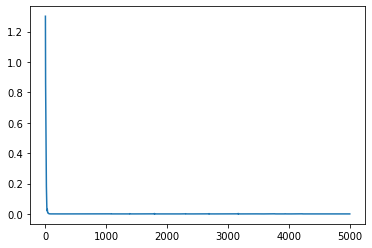

In [13]:
plt.plot(losss)

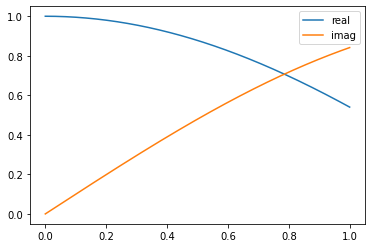

In [14]:
# True solutions
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

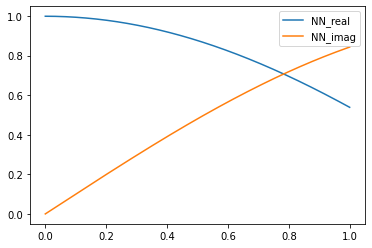

In [15]:
# model solutions
plt.plot(t, z_hat(t)[:,0:1] ,label = 'NN_real')
plt.plot(t,  z_hat(t)[:,1:2], label = 'NN_imag')
plt.legend()

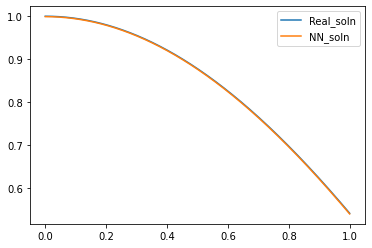

In [16]:
plt.plot(t, x_true(t) ,label = 'Real_soln')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN_soln')
plt.legend()

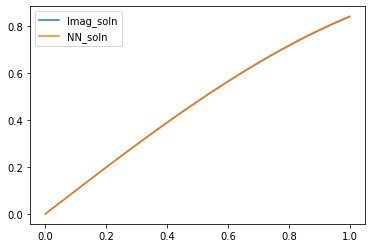

In [17]:
plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [27]:
# With batches
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)

start = time.time()
losss =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

initial loss : 0.0009730759193189442
loss for epoch 0 : 3.205005645751953
best loss so far is 1.166170358657837
best loss so far is 0.7221143841743469
best loss so far is 0.5223390460014343
best loss so far is 0.44322070479393005
best loss so far is 0.41524645686149597
best loss so far is 0.4106939435005188
best loss so far is 0.3957909047603607
best loss so far is 0.3480434715747833
best loss so far is 0.28696614503860474
best loss so far is 0.22973281145095825
best loss so far is 0.1800881326198578
best loss so far is 0.14048011600971222
best loss so far is 0.1257827877998352
best loss so far is 0.131722092628479
best loss so far is 0.1074124425649643
best loss so far is 0.07280506938695908
best loss so far is 0.05213913694024086
best loss so far is 0.0503426268696785
best loss so far is 0.036792002618312836
best loss so far is 0.02877931483089924
best loss so far is 0.028436504304409027
best loss so far is 0.027022581547498703
best loss so far is 0.01873502880334854
best loss so far

best loss so far is 0.002144170692190528
best loss so far is 0.0021420822013169527
best loss so far is 0.0038079714868217707
best loss so far is 0.0024111547973006964
best loss so far is 0.002262142254039645
best loss so far is 0.005238953046500683
best loss so far is 0.003201044164597988
best loss so far is 0.0032902348320931196
best loss so far is 0.002943499479442835
best loss so far is 0.0037804855965077877
best loss so far is 0.003521290374919772
best loss so far is 0.003403586568310857
best loss so far is 0.0032946050632745028
best loss so far is 0.0029275293927639723
best loss so far is 0.0029951962642371655
best loss so far is 0.00273638847284019
best loss so far is 0.0026563978753983974
best loss so far is 0.00251559354364872
best loss so far is 0.002487693913280964
best loss so far is 0.0023276100400835276
best loss so far is 0.0022838457953184843
best loss so far is 0.0022450946271419525
best loss so far is 0.0020849755965173244
best loss so far is 0.0020647929050028324
best

best loss so far is 0.6338922381401062
best loss so far is 0.6367822289466858
best loss so far is 0.6237974762916565
best loss so far is 0.6035627126693726
best loss so far is 0.5762260556221008
best loss so far is 0.5421063899993896
best loss so far is 0.492933064699173
best loss so far is 0.426004022359848
best loss so far is 0.40384945273399353
best loss so far is 0.3946719467639923
best loss so far is 0.3550260663032532
best loss so far is 0.3094526529312134
best loss so far is 0.2915044128894806
best loss so far is 0.24490000307559967
best loss so far is 0.19353049993515015
best loss so far is 0.15123017132282257
best loss so far is 0.14739444851875305
best loss so far is 0.13739247620105743
best loss so far is 0.1044732928276062
best loss so far is 0.0738830417394638
best loss so far is 0.05446380749344826
best loss so far is 0.04302585497498512
best loss so far is 0.032910849899053574
best loss so far is 0.03060409426689148
best loss so far is 0.02516360953450203
best loss so fa

best loss so far is 0.0049804928712546825
best loss so far is 0.0049552288837730885
best loss so far is 0.004936593119055033
best loss so far is 0.004922185558825731
best loss so far is 0.004908546339720488
best loss so far is 0.0048927548341453075
best loss so far is 0.004873459693044424
best loss so far is 0.004851115867495537
best loss so far is 0.004827623721212149
best loss so far is 0.004805343691259623
best loss so far is 0.004786001984030008
best loss so far is 0.00477003026753664
best loss so far is 0.004756242502480745
best loss so far is 0.004742773249745369
best loss so far is 0.004727903753519058
best loss so far is 0.004711125046014786
best loss so far is 0.004693157970905304
best loss so far is 0.004675374832004309
best loss so far is 0.00465900544077158
best loss so far is 0.00464446097612381
best loss so far is 0.0046311975456774235
best loss so far is 0.004618258215487003
best loss so far is 0.0046048397198319435
best loss so far is 0.004590614698827267
best loss so f

best loss so far is 0.00334886834025383
best loss so far is 0.0033445735462009907
best loss so far is 0.003340299939736724
best loss so far is 0.0033360354136675596
best loss so far is 0.0033317909110337496
best loss so far is 0.0033275580499321222
best loss so far is 0.0033233335707336664
best loss so far is 0.003319127717986703
best loss so far is 0.0033149111550301313
best loss so far is 0.003310738829895854
best loss so far is 0.0033065585885196924
best loss so far is 0.003302400466054678
best loss so far is 0.003298246068879962
best loss so far is 0.0032941224053502083
best loss so far is 0.003289993619546294
best loss so far is 0.0032858906779438257
best loss so far is 0.0032817949540913105
best loss so far is 0.0032776985317468643
best loss so far is 0.0032736274879425764
best loss so far is 0.003269548062235117
best loss so far is 0.0032655082177370787
best loss so far is 0.0032614541705697775
best loss so far is 0.003257428528741002
best loss so far is 0.0032534091733396053
be

best loss so far is 0.0026789233088493347
best loss so far is 0.0026761889457702637
best loss so far is 0.00267345504835248
best loss so far is 0.002670734655112028
best loss so far is 0.002668010303750634
best loss so far is 0.002665298990905285
best loss so far is 0.002662594895809889
best loss so far is 0.0026598733384162188
best loss so far is 0.0026571694761514664
best loss so far is 0.002654480980709195
best loss so far is 0.0026517948135733604
best loss so far is 0.0026490874588489532
best loss so far is 0.0026464115362614393
best loss so far is 0.0026437293272465467
best loss so far is 0.0026410561986267567
best loss so far is 0.0026383870281279087
best loss so far is 0.0026357125025242567
best loss so far is 0.0026330496184527874
best loss so far is 0.002630398143082857
best loss so far is 0.0026277562137693167
best loss so far is 0.0026250926312059164
best loss so far is 0.0026224541943520308
best loss so far is 0.0026198048144578934
best loss so far is 0.002617180347442627
b

best loss so far is 0.002208708319813013
best loss so far is 0.00220661167986691
best loss so far is 0.0022045059595257044
best loss so far is 0.0022024207282811403
best loss so far is 0.0022003219928592443
best loss so far is 0.002198233734816313
best loss so far is 0.0021961454767733812
best loss so far is 0.0021940753795206547
best loss so far is 0.002191986655816436
best loss so far is 0.002189912833273411
best loss so far is 0.0021878264378756285
best loss so far is 0.0021857586689293385
best loss so far is 0.0021836741361767054
best loss so far is 0.002181603107601404
best loss so far is 0.0021795323118567467
best loss so far is 0.0021774591878056526
best loss so far is 0.0021754007320851088
best loss so far is 0.00217333878390491
best loss so far is 0.002171269617974758
best loss so far is 0.002169207204133272
best loss so far is 0.0021671506110578775
best loss so far is 0.002165092620998621
best loss so far is 0.0021630357950925827
best loss so far is 0.0021609801333397627
best

best loss so far is 0.0018280668882653117
best loss so far is 0.0018262902740389109
best loss so far is 0.001824497478082776
best loss so far is 0.0018227266846224666
best loss so far is 0.0018209421541541815
best loss so far is 0.001819161931052804
best loss so far is 0.0018173879943788052
best loss so far is 0.0018156057922169566
best loss so far is 0.0018138382583856583
best loss so far is 0.0018120668828487396
best loss so far is 0.001810297486372292
best loss so far is 0.0018085305346176028
best loss so far is 0.0018067504279315472
best loss so far is 0.0018049931386485696
best loss so far is 0.0018032272346317768
best loss so far is 0.0018014592351391912
best loss so far is 0.0017997031100094318
best loss so far is 0.0017979394178837538
best loss so far is 0.0017961785197257996
best loss so far is 0.0017944197170436382
best loss so far is 0.001792671624571085
best loss so far is 0.0017909097950905561
best loss so far is 0.0017891661264002323
best loss so far is 0.0017874183831736

best loss so far is 0.001961125060915947
best loss so far is 0.0020322215277701616
best loss so far is 0.0019056448945775628
best loss so far is 0.001858385861851275
best loss so far is 0.0016586043639108539
best loss so far is 0.0015630800044164062
best loss so far is 0.0014760582707822323
best loss so far is 0.0014371341094374657
best loss so far is 0.0014313083374872804
best loss so far is 0.001662430469878018
best loss so far is 0.0016629925230517983
best loss so far is 0.0016215222422033548
best loss so far is 0.0016168172005563974
best loss so far is 0.001563797239214182
best loss so far is 0.0015494492836296558
best loss so far is 0.00151283317245543
best loss so far is 0.001499897101894021
best loss so far is 0.0014782107900828123
best loss so far is 0.001470548682846129
best loss so far is 0.001459437538869679
best loss so far is 0.0014575637178495526
best loss so far is 0.0014538489049300551
best loss so far is 0.0024520622100681067
best loss so far is 0.0020754486322402954
b

best loss so far is 0.0012441035360097885
best loss so far is 0.0012281660456210375
best loss so far is 0.0012207238469272852
best loss so far is 0.0012191663263365626
best loss so far is 0.002139144577085972
best loss so far is 0.002066797809675336
best loss so far is 0.001585054094903171
best loss so far is 0.0013975960901007056
best loss so far is 0.001250906614586711
best loss so far is 0.0012120982864871621
best loss so far is 0.0014554354129359126
best loss so far is 0.0014158410485833883
best loss so far is 0.0013082498917356133
best loss so far is 0.0012484114849939942
best loss so far is 0.0012149026151746511
best loss so far is 0.0012145854998379946
best loss so far is 0.0013230161275714636
best loss so far is 0.0013209107564762235
best loss so far is 0.0012880307622253895
best loss so far is 0.0012732852483168244
best loss so far is 0.001248897984623909
best loss so far is 0.0012357584200799465
best loss so far is 0.0012225289829075336
best loss so far is 0.00121487420983612

best loss so far is 0.0010887461248785257
best loss so far is 0.00108834239654243
best loss so far is 0.0010876597370952368
best loss so far is 0.0010865831281989813
best loss so far is 0.001086478354409337
best loss so far is 0.0010849301470443606
best loss so far is 0.0010834704153239727
best loss so far is 0.001082110102288425
best loss so far is 0.0010808741208165884
best loss so far is 0.00107969727832824
best loss so far is 0.0010785700287669897
best loss so far is 0.0010783481411635876
best loss so far is 0.0010774647817015648
best loss so far is 0.0010769765358418226
best loss so far is 0.0010763300815597177
best loss so far is 0.0010756420670077205
best loss so far is 0.001075202482752502
best loss so far is 0.0010743739549070597
best loss so far is 0.0010740087600424886
best loss so far is 0.001073150197044015
best loss so far is 0.0010728059569373727
best loss so far is 0.001071979058906436
best loss so far is 0.0010715650860220194
best loss so far is 0.0010708208428695798
b

best loss so far is 0.00098171376157552
best loss so far is 0.0009812690550461411
best loss so far is 0.0009808553149923682
best loss so far is 0.000980424229055643
best loss so far is 0.0009799973340705037
best loss so far is 0.0009795718360692263
best loss so far is 0.0009791486663743854
best loss so far is 0.0009787189774215221
best loss so far is 0.000978300697170198
best loss so far is 0.0009778644889593124
best loss so far is 0.000977457850240171
best loss so far is 0.0009770299075171351
best loss so far is 0.0009766144212335348
best loss so far is 0.0009761967230588198
best loss so far is 0.0009757664520293474
best loss so far is 0.0009753505582921207
best loss so far is 0.0009749324526637793
best loss so far is 0.0009745153947733343
best loss so far is 0.0009740957175381482
best loss so far is 0.0009736770880408585
best loss so far is 0.0009732540929690003
best loss so far is 0.0009728464647196233
best loss so far is 0.0009724284172989428
best loss so far is 0.00097199948504567

best loss so far is 0.0009824171429499984
best loss so far is 0.0009525421191938221
best loss so far is 0.000931848946493119
best loss so far is 0.000914804928470403
best loss so far is 0.0009074365952983499
best loss so far is 0.0009440769208595157
best loss so far is 0.0009439829154871404
best loss so far is 0.000937553180847317
best loss so far is 0.00093568250304088
best loss so far is 0.0009301722166128457
best loss so far is 0.0009285374544560909
best loss so far is 0.0009248509886674583
best loss so far is 0.0009245559922419488
best loss so far is 0.0009230593568645418
best loss so far is 0.001572905806824565
best loss so far is 0.0013883182546123862
best loss so far is 0.0012855281820520759
best loss so far is 0.0010514938039705157
best loss so far is 0.0009448484634049237
best loss so far is 0.0009009354980662465
best loss so far is 0.0011054528877139091
best loss so far is 0.0010292564984411001
best loss so far is 0.000977061572484672
best loss so far is 0.0009238062193617225

In [14]:
# With batches
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)

In [24]:
start = time.time()
losss =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

initial loss : 0.8268986940383911
loss for epoch 0 : 23.394691467285156
best loss so far is 0.7563117742538452
best loss so far is 0.8201162815093994
best loss so far is 0.7578000426292419
best loss so far is 0.697737455368042
best loss so far is 0.6392238140106201
best loss so far is 0.5771272778511047
best loss so far is 0.5112947821617126
best loss so far is 0.4464625120162964
best loss so far is 0.36382272839546204
best loss so far is 0.28370916843414307
best loss so far is 0.2196795493364334
best loss so far is 0.1541692018508911
best loss so far is 0.10570939630270004
best loss so far is 0.0692802220582962
best loss so far is 0.06297258287668228
best loss so far is 0.04595086723566055
best loss so far is 0.03212500363588333
best loss so far is 0.02919686585664749
best loss so far is 0.022964902222156525
best loss so far is 0.03619034215807915
best loss so far is 0.026093685999512672
best loss so far is 0.024226266890764236
best loss so far is 0.021053828299045563
best loss so far

best loss so far is 0.006264309398829937
best loss so far is 0.006258796434849501
best loss so far is 0.0061706961132586
best loss so far is 0.0060920072719454765
best loss so far is 0.034615810960531235
best loss so far is 0.005896371323615313
best loss so far is 0.02302468940615654
best loss so far is 0.007333388552069664
best loss so far is 0.006378361023962498
best loss so far is 0.0068732197396457195
best loss so far is 0.006840865593403578
best loss so far is 0.0059012980200350285
best loss so far is 0.005612887907773256
best loss so far is 0.005982490722090006
best loss so far is 0.006789843551814556
best loss so far is 0.0063328067772090435
best loss so far is 0.005363906733691692
best loss so far is 0.0054343766532838345
best loss so far is 0.00599433109164238
best loss so far is 0.00534858088940382
best loss so far is 0.005104846321046352
best loss so far is 0.00535686407238245
best loss so far is 0.005177292041480541
best loss so far is 0.00490998849272728
best loss so far i

best loss so far is 0.004473434295505285
best loss so far is 0.004394962918013334
best loss so far is 0.00432790769264102
best loss so far is 0.004306346643716097
best loss so far is 0.004212983883917332
best loss so far is 0.0042041284032166
best loss so far is 0.004118571523576975
best loss so far is 0.004102494101971388
best loss so far is 0.0040370444767177105
best loss so far is 0.0040032826364040375
best loss so far is 0.003958612680435181
best loss so far is 0.003916340880095959
best loss so far is 0.0038809499237686396
best loss so far is 0.0038360944017767906
best loss so far is 0.003806566121056676
best loss so far is 0.003763022134080529
best loss so far is 0.003733837977051735
best loss so far is 0.0036950053181499243
best loss so far is 0.003665238618850708
best loss so far is 0.0036310828290879726
best loss so far is 0.003598848357796669
best loss so far is 0.003570868633687496
best loss so far is 0.0035363524220883846
best loss so far is 0.003513346891850233
best loss so

best loss so far is 0.04187564179301262
best loss so far is 0.04380396381020546
best loss so far is 0.03354514762759209
best loss so far is 0.025068165734410286
best loss so far is 0.02722351998090744
best loss so far is 0.02162420004606247
best loss so far is 0.016165027394890785
best loss so far is 0.013650268316268921
best loss so far is 0.012906113639473915
best loss so far is 0.010478843934834003
best loss so far is 0.010018873028457165
best loss so far is 0.007592159789055586
best loss so far is 0.008865558542311192
best loss so far is 0.007338064257055521
best loss so far is 0.0068871332332491875
best loss so far is 0.006569515913724899
best loss so far is 0.005529001355171204
best loss so far is 0.004486056510359049
best loss so far is 0.0044471570290625095
best loss so far is 0.004162277095019817
best loss so far is 0.0036861025728285313
best loss so far is 0.0038811468984931707
best loss so far is 0.0038408825639635324
best loss so far is 0.003376877401024103
best loss so far

best loss so far is 0.0023400988429784775
best loss so far is 0.0023379132617264986
best loss so far is 0.002335741650313139
best loss so far is 0.0023335686419159174
best loss so far is 0.002331402385607362
best loss so far is 0.0023292365949600935
best loss so far is 0.002327074995264411
best loss so far is 0.0023249201476573944
best loss so far is 0.0023227676283568144
best loss so far is 0.0023206225596368313
best loss so far is 0.0023184805177152157
best loss so far is 0.0023163375444710255
best loss so far is 0.0023142050486057997
best loss so far is 0.0023120753467082977
best loss so far is 0.002309947507455945
best loss so far is 0.0023078196682035923
best loss so far is 0.002305704401805997
best loss so far is 0.0023035865742713213
best loss so far is 0.002301474567502737
best loss so far is 0.002299367683008313
best loss so far is 0.002297263592481613
best loss so far is 0.002295162994414568
best loss so far is 0.002293064258992672
best loss so far is 0.0022909718099981546
be

best loss so far is 0.001972729805856943
best loss so far is 0.0019711332861334085
best loss so far is 0.0019695498049259186
best loss so far is 0.0019679635297507048
best loss so far is 0.0019663830753415823
best loss so far is 0.001964800525456667
best loss so far is 0.0019632226321846247
best loss so far is 0.00196165032684803
best loss so far is 0.0019600773230195045
best loss so far is 0.001958505716174841
best loss so far is 0.0019569366704672575
best loss so far is 0.001955369021743536
best loss so far is 0.0019537999760359526
best loss so far is 0.0019522394286468625
best loss so far is 0.0019506815588101745
best loss so far is 0.001949117984622717
best loss so far is 0.0019475638400763273
best loss so far is 0.0019460114417597651
best loss so far is 0.0019444548524916172
best loss so far is 0.0019429093226790428
best loss so far is 0.0019413618138059974
best loss so far is 0.0019398150034248829
best loss so far is 0.0019382786704227328
best loss so far is 0.0019367277855053544

best loss so far is 0.0016961920773610473
best loss so far is 0.0016949641285464168
best loss so far is 0.0016937325708568096
best loss so far is 0.0016925144009292126
best loss so far is 0.0016912874998524785
best loss so far is 0.0016900780610740185
best loss so far is 0.0016888538375496864
best loss so far is 0.001687641255557537
best loss so far is 0.001686420408077538
best loss so far is 0.0016852091066539288
best loss so far is 0.0016839962918311357
best loss so far is 0.0016827891813591123
best loss so far is 0.0016815762501209974
best loss so far is 0.0016803693724796176
best loss so far is 0.001679165055975318
best loss so far is 0.0016779567813500762
best loss so far is 0.0016767597990110517
best loss so far is 0.0016755493124946952
best loss so far is 0.0016743545420467854
best loss so far is 0.001673158723860979
best loss so far is 0.0016719592968001962
best loss so far is 0.0016707605682313442
best loss so far is 0.0016695612575858831
best loss so far is 0.0016683760331943

best loss so far is 0.0014798485208302736
best loss so far is 0.0014788752887398005
best loss so far is 0.0014779050834476948
best loss so far is 0.0014769373228773475
best loss so far is 0.001475962926633656
best loss so far is 0.0014749969122931361
best loss so far is 0.0014740314800292253
best loss so far is 0.0014730572002008557
best loss so far is 0.0014720918843522668
best loss so far is 0.0014711330877617002
best loss so far is 0.0014701716136187315
best loss so far is 0.0014692064141854644
best loss so far is 0.0014682452892884612
best loss so far is 0.0014672887045890093
best loss so far is 0.0014663279289379716
best loss so far is 0.0014653748366981745
best loss so far is 0.0014644163893535733
best loss so far is 0.0014634598046541214
best loss so far is 0.0014625033363699913
best loss so far is 0.0014615539694204926
best loss so far is 0.001460596569813788
best loss so far is 0.001459643361158669
best loss so far is 0.0014586963225156069
best loss so far is 0.001457746257074

best loss so far is 0.0013054225128144026
best loss so far is 0.00130463857203722
best loss so far is 0.001303848228417337
best loss so far is 0.0013030630070716143
best loss so far is 0.0013022826751694083
best loss so far is 0.0013014845317229629
best loss so far is 0.0013007030356675386
best loss so far is 0.001299924566410482
best loss so far is 0.0012991426046937704
best loss so far is 0.0012983570341020823
best loss so far is 0.0012975784484297037
best loss so far is 0.0012967947404831648
best loss so far is 0.0012960134772583842
best loss so far is 0.001295234658755362
best loss so far is 0.0012944545596837997
best loss so far is 0.0012936779530718923
best loss so far is 0.0012929014628753066
best loss so far is 0.0012921288143843412
best loss so far is 0.001291349995881319
best loss so far is 0.0012905766488984227
best loss so far is 0.001289804233238101
best loss so far is 0.0012890301877632737
loss for epoch 2000 : 0.0012890301877632737
best loss so far is 0.00128825940191745

best loss so far is 0.00116416672244668
best loss so far is 0.0011635180562734604
best loss so far is 0.0011628636857494712
best loss so far is 0.0011622161837294698
best loss so far is 0.001161560881882906
best loss so far is 0.0011609180364757776
best loss so far is 0.0011602655285969377
best loss so far is 0.0011596203548833728
best loss so far is 0.0011589773930609226
best loss so far is 0.001158328028395772
best loss so far is 0.0011576832039281726
best loss so far is 0.0011570435017347336
best loss so far is 0.0011563962325453758
best loss so far is 0.0011557525722309947
best loss so far is 0.0011551096104085445
best loss so far is 0.0011544682784006
best loss so far is 0.0011538275284692645
best loss so far is 0.0011531832860782743
best loss so far is 0.0011525460286065936
best loss so far is 0.0011519051622599363
best loss so far is 0.0011512660421431065
best loss so far is 0.001150630065239966
best loss so far is 0.0011499897809699178
best loss so far is 0.0011493535712361336


best loss so far is 0.0010579907102510333
best loss so far is 0.0010574753396213055
best loss so far is 0.0010569531004875898
best loss so far is 0.0010564515832811594
best loss so far is 0.0010559632210060954
best loss so far is 0.001055487198755145
best loss so far is 0.001055030501447618
best loss so far is 0.0010545698460191488
best loss so far is 0.0010541063966229558
best loss so far is 0.0010536301415413618
best loss so far is 0.001053154468536377
best loss so far is 0.0010526628466323018
best loss so far is 0.0010521650547161698
best loss so far is 0.00105167122092098
best loss so far is 0.0010511884465813637
best loss so far is 0.0010507006663829088
best loss so far is 0.001050224993377924
best loss so far is 0.0010497403563931584
best loss so far is 0.0010492634028196335
best loss so far is 0.0010487829567864537
best loss so far is 0.0010483131045475602
best loss so far is 0.0010478382464498281
best loss so far is 0.0010473631555214524
best loss so far is 0.001046895049512386

best loss so far is 0.0010045056696981192
best loss so far is 0.0010041015921160579
best loss so far is 0.0010037047322839499
best loss so far is 0.0010033022845163941
best loss so far is 0.0010029063560068607
best loss so far is 0.0010025074006989598
best loss so far is 0.0010021229973062873
best loss so far is 0.0010017398744821548
best loss so far is 0.0010013824794441462
best loss so far is 0.0010010445257648826
best loss so far is 0.0010007658274844289
best loss so far is 0.0010006125085055828
best loss so far is 0.013497413136065006
best loss so far is 0.0066704279743134975
best loss so far is 0.0011025962885469198
best loss so far is 0.004750168416649103
best loss so far is 0.001044567208737135
best loss so far is 0.001993258949369192
best loss so far is 0.0014125349698588252
best loss so far is 0.0024867483880370855
best loss so far is 0.0010637858649715781
best loss so far is 0.002412493107840419
best loss so far is 0.001046359189786017
best loss so far is 0.001052649808116257

best loss so far is 0.0009887267369776964
best loss so far is 0.0009883508319035172
best loss so far is 0.000987982377409935
best loss so far is 0.0009876054245978594
best loss so far is 0.000987230334430933
best loss so far is 0.0009868607157841325
best loss so far is 0.0009864774765446782
best loss so far is 0.0009861164726316929
best loss so far is 0.0009857409168034792
best loss so far is 0.0009853688534349203
best loss so far is 0.0009849952766671777
best loss so far is 0.0009846145985648036
best loss so far is 0.0009842495201155543
best loss so far is 0.0009838769910857081
best loss so far is 0.0009835035307332873
best loss so far is 0.0009831279749050736
best loss so far is 0.0009827670874074101
best loss so far is 0.0009823935106396675
best loss so far is 0.0009820323903113604
best loss so far is 0.0009816668462008238
best loss so far is 0.0009812902426347136
best loss so far is 0.0009809192270040512
best loss so far is 0.0009805479785427451
best loss so far is 0.00098017393611

best loss so far is 0.0009763492271304131
best loss so far is 0.000976166978944093
best loss so far is 0.0009759824024513364
best loss so far is 0.0009757968946360052
best loss so far is 0.0009756159270182252
best loss so far is 0.0009754319326020777
best loss so far is 0.0009752478799782693
best loss so far is 0.0009750641183927655
best loss so far is 0.0009748811135068536
best loss so far is 0.0009747009025886655
best loss so far is 0.0009745113202370703
best loss so far is 0.000974329246673733
best loss so far is 0.0009741457761265337
best loss so far is 0.0009739630622789264
best loss so far is 0.0009737826767377555
best loss so far is 0.0009735953062772751
best loss so far is 0.0009734142222441733
best loss so far is 0.0009732292965054512
best loss so far is 0.0009730492602102458
best loss so far is 0.0009728657314553857
best loss so far is 0.0009726780699566007
best loss so far is 0.000972496869508177
best loss so far is 0.0009723113034851849
best loss so far is 0.000972128123976

best loss so far is 0.0009403949952684343
best loss so far is 0.0009402157738804817
best loss so far is 0.0009400303242728114
best loss so far is 0.0009398564579896629
best loss so far is 0.0009396763634867966
best loss so far is 0.000939493824262172
best loss so far is 0.0009393142536282539
best loss so far is 0.0009391304920427501
best loss so far is 0.0009389527258463204
best loss so far is 0.0009387801983393729
best loss so far is 0.0009385969024151564
best loss so far is 0.000938420940656215
best loss so far is 0.0009382368880324066
best loss so far is 0.0009380578412674367
best loss so far is 0.0009378799004480243
best loss so far is 0.0009376996313221753
best loss so far is 0.0009375225636176765
best loss so far is 0.0009373408975079656
best loss so far is 0.0009371637715958059
best loss so far is 0.0009369816980324686
best loss so far is 0.0009368065511807799
best loss so far is 0.0009366222657263279
best loss so far is 0.0009364470606669784
best loss so far is 0.00093626923626

best loss so far is 0.000904710206668824
best loss so far is 0.0009045368642546237
best loss so far is 0.000904356362298131
best loss so far is 0.0009041879675351083
best loss so far is 0.000904007232747972
best loss so far is 0.00090383505448699
best loss so far is 0.0009036596165969968
best loss so far is 0.0009034841204993427
best loss so far is 0.0009033051319420338
best loss so far is 0.0009031295776367188
best loss so far is 0.000902956526260823
best loss so far is 0.0009027835330925882
best loss so far is 0.0009026038460433483
best loss so far is 0.0009024303290061653
best loss so far is 0.0009022568701766431
best loss so far is 0.0009020804427564144
best loss so far is 0.0009019045392051339
best loss so far is 0.0009017333504743874
best loss so far is 0.0009015585528686643
best loss so far is 0.0009013800299726427
best loss so far is 0.0009012033115141094
best loss so far is 0.0009010307840071619
best loss so far is 0.0009008530178107321
best loss so far is 0.000900680548511445

best loss so far is 0.0008703863131813705
best loss so far is 0.0008702162303961813
best loss so far is 0.0008700434118509293
best loss so far is 0.000869873387273401
best loss so far is 0.0008697034791111946
best loss so far is 0.0008695290889590979
best loss so far is 0.0008693565032444894
best loss so far is 0.0008691863622516394
best loss so far is 0.0008690153481438756
best loss so far is 0.0008688429370522499
best loss so far is 0.0008686762885190547
best loss so far is 0.0008685079519636929
best loss so far is 0.0008683318737894297
best loss so far is 0.0008681634208187461
best loss so far is 0.0008679914753884077
best loss so far is 0.0008678167941980064
best loss so far is 0.0008676484576426446
best loss so far is 0.0008674795972183347
best loss so far is 0.0008673042757436633
best loss so far is 0.000867134949658066
best loss so far is 0.0008669667295180261
best loss so far is 0.0008667919901199639
best loss so far is 0.0008666195790283382
best loss so far is 0.00086645426927

In [15]:
start = time.time()
losss =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in is {(time.time() -start)//60.}s ')

initial loss : 1.0586482286453247

called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
..........
 loss for epoch 0 : 0.0008528536418452859
..............................................................
 best loss for epoch 7 : 0.25244295597076416

 best loss for epoch 7 : 0.18638254702091217

 best loss for epoch 7 : 0.163031205534935

 best loss for epoch 7 : 0.09121569991111755

 best loss for epoch 7 : 0.08160550892353058
.
 best loss for epoch 7 : 0.06085747480392456
..
 best loss for epoch 7 : 0.11478178948163986

 best loss for epoch 7 : 0.039784688502550125

 best loss for epoch 7 : 0.01966833882033825
.
 best loss for epoch 7 : 0.016529830172657967
.
 best loss for epoch 7 : 0.01340452954173088
.
 best loss for epoch 7 : 0.010984786786139011

 best loss for epoch 7 : 0.006949259899556637

 best loss for epoch 7 : 0.005838486365973949
.
 best loss for epoch 7 : 0.003925774712115526

 best loss for epoch 7 : 0.0

.
 best loss for epoch 12 : 0.15253114700317383

 best loss for epoch 12 : 0.14883334934711456

 best loss for epoch 12 : 0.1436706781387329

 best loss for epoch 12 : 0.1364085078239441

 best loss for epoch 12 : 0.12998121976852417
.
 best loss for epoch 12 : 0.12513573467731476

 best loss for epoch 12 : 0.120766781270504

 best loss for epoch 12 : 0.11622326821088791

 best loss for epoch 12 : 0.11148390918970108

 best loss for epoch 12 : 0.1067558154463768
.
 best loss for epoch 12 : 0.10225827991962433

 best loss for epoch 12 : 0.09813666343688965

 best loss for epoch 12 : 0.09443386644124985

 best loss for epoch 12 : 0.09110858291387558

 best loss for epoch 12 : 0.08808216452598572
..
 best loss for epoch 13 : 0.33012211322784424

 best loss for epoch 13 : 0.09480641782283783
.
 best loss for epoch 13 : 0.10408317297697067

 best loss for epoch 13 : 0.10148579627275467

 best loss for epoch 13 : 0.09959834069013596
.
 best loss for epoch 13 : 0.09770786017179489

 best loss


 best loss for epoch 17 : 0.027584677562117577

 best loss for epoch 17 : 0.026603711768984795
.
 best loss for epoch 17 : 0.025646459311246872

 best loss for epoch 17 : 0.024709230288863182

 best loss for epoch 17 : 0.023790400475263596

 best loss for epoch 17 : 0.022890029475092888

 best loss for epoch 17 : 0.022009631618857384
..
 best loss for epoch 18 : 0.023337427526712418
.
 best loss for epoch 18 : 0.018877923488616943

 best loss for epoch 18 : 0.017026813700795174

 best loss for epoch 18 : 0.016489168629050255

 best loss for epoch 18 : 0.016206249594688416

 best loss for epoch 18 : 0.015854671597480774
.
 best loss for epoch 18 : 0.015584002248942852

 best loss for epoch 18 : 0.015065019950270653
.
 best loss for epoch 18 : 0.014169172383844852

 best loss for epoch 18 : 0.01340931560844183

 best loss for epoch 18 : 0.012915956787765026

 best loss for epoch 18 : 0.0125806275755167

 best loss for epoch 18 : 0.012262717820703983
.
 best loss for epoch 18 : 0.0118900


 best loss for epoch 22 : 0.004452573135495186
...
 best loss for epoch 23 : 0.010014127008616924
.
 best loss for epoch 23 : 0.009086450561881065

 best loss for epoch 23 : 0.00820946879684925

 best loss for epoch 23 : 0.007441556081175804

 best loss for epoch 23 : 0.006799497175961733

 best loss for epoch 23 : 0.006276716943830252
.
 best loss for epoch 23 : 0.005856623873114586

 best loss for epoch 23 : 0.0055204275995492935

 best loss for epoch 23 : 0.005250788759440184

 best loss for epoch 23 : 0.005033135414123535

 best loss for epoch 23 : 0.004855752922594547
.
 best loss for epoch 23 : 0.004709492903202772

 best loss for epoch 23 : 0.00458733644336462

 best loss for epoch 23 : 0.004483920056372881

 best loss for epoch 23 : 0.004395149648189545

 best loss for epoch 23 : 0.004317921586334705
.
 best loss for epoch 23 : 0.004249883815646172

 best loss for epoch 23 : 0.00418921560049057

 best loss for epoch 23 : 0.004134530667215586

 best loss for epoch 23 : 0.004084

.
 best loss for epoch 27 : 0.0015574911376461387

 best loss for epoch 27 : 0.0015456348191946745

 best loss for epoch 27 : 0.0015342923579737544

 best loss for epoch 27 : 0.0015233865706250072

 best loss for epoch 27 : 0.0015128450468182564
.
 best loss for epoch 27 : 0.0015026145847514272

 best loss for epoch 27 : 0.0014926475705578923

 best loss for epoch 27 : 0.00148290628567338

 best loss for epoch 27 : 0.0014733674470335245

 best loss for epoch 27 : 0.0014640078879892826
...
 best loss for epoch 28 : 0.006397987715899944

 best loss for epoch 28 : 0.005027888808399439
.
 best loss for epoch 28 : 0.003993471153080463

 best loss for epoch 28 : 0.0032577612437307835

 best loss for epoch 28 : 0.002745153149589896

 best loss for epoch 28 : 0.002387489890679717

 best loss for epoch 28 : 0.002134566893801093
.
 best loss for epoch 28 : 0.0019521545618772507

 best loss for epoch 28 : 0.0018175294389948249

 best loss for epoch 28 : 0.001715711667202413

 best loss for epoch 


 best loss for epoch 32 : 0.0005333019653335214

 best loss for epoch 32 : 0.0005179392173886299

 best loss for epoch 32 : 0.0005046890582889318

 best loss for epoch 32 : 0.0004931899602524936
.
 best loss for epoch 32 : 0.00048317850450985134

 best loss for epoch 32 : 0.00047443178482353687

 best loss for epoch 32 : 0.00046676440979354084

 best loss for epoch 32 : 0.0004600127867888659

 best loss for epoch 32 : 0.0004540335794445127
.
 best loss for epoch 32 : 0.00044868767145089805

 best loss for epoch 32 : 0.0004438541363924742

 best loss for epoch 32 : 0.0004394296556711197

 best loss for epoch 32 : 0.00043531626579351723

 best loss for epoch 32 : 0.0004314362595323473
.
 best loss for epoch 32 : 0.0004277263942640275

 best loss for epoch 32 : 0.00042413570918142796

 best loss for epoch 32 : 0.00042062578722834587

 best loss for epoch 32 : 0.00041717226849868894

 best loss for epoch 32 : 0.00041376129956915975
.
 best loss for epoch 32 : 0.0004103833925910294

 best 

.
 best loss for epoch 36 : 0.00012915313709527254

 best loss for epoch 36 : 0.00012766548024956137

 best loss for epoch 36 : 0.00012617062020581216

 best loss for epoch 36 : 0.0001246758474735543

 best loss for epoch 36 : 0.00012319300731178373
.
 best loss for epoch 36 : 0.00012174116272944957

 best loss for epoch 36 : 0.00012033390521537513

 best loss for epoch 36 : 0.00011898412776645273

 best loss for epoch 36 : 0.00011770674609579146

 best loss for epoch 36 : 0.00011650619853753597
...
 best loss for epoch 37 : 0.0023565664887428284

 best loss for epoch 37 : 0.0013174214400351048

 best loss for epoch 37 : 0.0007975181797519326
.
 best loss for epoch 37 : 0.0005324972444213927

 best loss for epoch 37 : 0.00039036624366417527

 best loss for epoch 37 : 0.0003090266836807132

 best loss for epoch 37 : 0.00025898811873048544

 best loss for epoch 37 : 0.00022577632626052946
.
 best loss for epoch 37 : 0.00020202240557409823

 best loss for epoch 37 : 0.00018387445015832782


 best loss for epoch 41 : 7.5261399615556e-05

 best loss for epoch 41 : 6.704810948576778e-05

 best loss for epoch 41 : 5.9834674175363034e-05

 best loss for epoch 41 : 5.354341192287393e-05
.
 best loss for epoch 41 : 4.814736530533992e-05

 best loss for epoch 41 : 4.3618092604447156e-05

 best loss for epoch 41 : 3.990620461991057e-05

 best loss for epoch 41 : 3.693365215440281e-05

 best loss for epoch 41 : 3.459930303506553e-05
.
 best loss for epoch 41 : 3.278872463852167e-05

 best loss for epoch 41 : 3.1383420719066635e-05

 best loss for epoch 41 : 3.0271192372310907e-05

 best loss for epoch 41 : 2.9351886041695252e-05

 best loss for epoch 41 : 2.8544405722641386e-05
.
 best loss for epoch 41 : 2.7786991267930716e-05

 best loss for epoch 41 : 2.703819700400345e-05

 best loss for epoch 41 : 2.6277379220118746e-05

 best loss for epoch 41 : 2.5498791728750803e-05

 best loss for epoch 41 : 2.470917570462916e-05
.
 best loss for epoch 41 : 2.392549140495248e-05

 best lo


 best loss for epoch 45 : 6.473635494330665e-06
.
 best loss for epoch 45 : 5.9068815971841104e-06

 best loss for epoch 45 : 5.439021606434835e-06

 best loss for epoch 45 : 5.08106995766866e-06

 best loss for epoch 45 : 4.836032530874945e-06

 best loss for epoch 45 : 4.700136742030736e-06
.
 best loss for epoch 45 : 4.662799256038852e-06
...
 best loss for epoch 46 : 0.0015445747412741184

 best loss for epoch 46 : 0.0006235978798940778

 best loss for epoch 46 : 0.00028466281946748495

 best loss for epoch 46 : 0.0001565608981763944
.
 best loss for epoch 46 : 0.00010465647210367024

 best loss for epoch 46 : 8.117333345580846e-05

 best loss for epoch 46 : 6.851356738479808e-05

 best loss for epoch 46 : 5.994503590045497e-05

 best loss for epoch 46 : 5.289115506457165e-05
.
 best loss for epoch 46 : 4.6452823880827054e-05

 best loss for epoch 46 : 4.042006912641227e-05

 best loss for epoch 46 : 3.483762702671811e-05

 best loss for epoch 46 : 2.9819299015798606e-05

 best lo

....
 best loss for epoch 51 : 0.0009162637288682163

 best loss for epoch 51 : 0.0003404022427275777

 best loss for epoch 51 : 0.0001553726033307612

 best loss for epoch 51 : 9.321085235569626e-05
.
 best loss for epoch 51 : 7.048358384054154e-05

 best loss for epoch 51 : 6.0537629906320944e-05

 best loss for epoch 51 : 5.445141505333595e-05

 best loss for epoch 51 : 4.923975211568177e-05

 best loss for epoch 51 : 4.40503608842846e-05
.
 best loss for epoch 51 : 3.881036172970198e-05

 best loss for epoch 51 : 3.3703239751048386e-05

 best loss for epoch 51 : 2.8947881219210103e-05

 best loss for epoch 51 : 2.4707362172193825e-05

 best loss for epoch 51 : 2.1061590814497322e-05
.
 best loss for epoch 51 : 1.801200232875999e-05

 best loss for epoch 51 : 1.549843182147015e-05

 best loss for epoch 51 : 1.3425966244540177e-05

 best loss for epoch 51 : 1.1686871403071564e-05

 best loss for epoch 51 : 1.0181280231336132e-05
.
 best loss for epoch 51 : 8.830661499814596e-06

 bes


 best loss for epoch 56 : 4.964732397638727e-06

 best loss for epoch 56 : 3.68890687241219e-06

 best loss for epoch 56 : 2.651923068697215e-06
.
 best loss for epoch 56 : 1.8751809420791687e-06

 best loss for epoch 56 : 1.3635076356877107e-06

 best loss for epoch 56 : 1.1021488717233296e-06

 best loss for epoch 56 : 1.0589119483483955e-06
.....
 best loss for epoch 57 : 0.0005066379089839756

 best loss for epoch 57 : 0.00018568674568086863

 best loss for epoch 57 : 9.516074351267889e-05

 best loss for epoch 57 : 6.817912071710452e-05
.
 best loss for epoch 57 : 5.9172984038013965e-05

 best loss for epoch 57 : 5.4841028031660244e-05

 best loss for epoch 57 : 5.117087857797742e-05

 best loss for epoch 57 : 4.711254587164149e-05

 best loss for epoch 57 : 4.261717913323082e-05
.
 best loss for epoch 57 : 3.7942783819744363e-05

 best loss for epoch 57 : 3.338022361276671e-05

 best loss for epoch 57 : 2.9145659937057644e-05

 best loss for epoch 57 : 2.535086423449684e-05

 be


 best loss for epoch 62 : 3.939778252970427e-05

 best loss for epoch 62 : 3.0486458854284137e-05
.
 best loss for epoch 62 : 2.3829314159229398e-05

 best loss for epoch 62 : 1.8746970454230905e-05

 best loss for epoch 62 : 1.4821050172031391e-05

 best loss for epoch 62 : 1.1776544852182269e-05

 best loss for epoch 62 : 9.423410119779874e-06
.
 best loss for epoch 62 : 7.618244580953615e-06

 best loss for epoch 62 : 6.244315045478288e-06

 best loss for epoch 62 : 5.205973138799891e-06

 best loss for epoch 62 : 4.423239715833915e-06

 best loss for epoch 62 : 3.827690761681879e-06
.
 best loss for epoch 62 : 3.3642920698184753e-06

 best loss for epoch 62 : 2.9898042157583404e-06

 best loss for epoch 62 : 2.6738982796814525e-06

 best loss for epoch 62 : 2.3970692382135894e-06

 best loss for epoch 62 : 2.1491068764589727e-06
.
 best loss for epoch 62 : 1.9276940292911604e-06

 best loss for epoch 62 : 1.736370336402615e-06

 best loss for epoch 62 : 1.5830719348741695e-06

 be

......
 best loss for epoch 69 : 0.0014670088421553373

 best loss for epoch 69 : 0.0006708271102979779

 best loss for epoch 69 : 0.0002984537568408996

 best loss for epoch 69 : 0.00013633479829877615
.
 best loss for epoch 69 : 6.7392953496892e-05

 best loss for epoch 69 : 3.8328922528307885e-05

 best loss for epoch 69 : 2.611961645015981e-05

 best loss for epoch 69 : 2.089932604576461e-05

 best loss for epoch 69 : 1.844499638536945e-05
.
 best loss for epoch 69 : 1.6975853213807568e-05

 best loss for epoch 69 : 1.578608680574689e-05

 best loss for epoch 69 : 1.4646143426944036e-05

 best loss for epoch 69 : 1.3524019777833018e-05

 best loss for epoch 69 : 1.24606840472552e-05
.
 best loss for epoch 69 : 1.1512902347021736e-05

 best loss for epoch 69 : 1.0723229024733882e-05

 best loss for epoch 69 : 1.0115746590599883e-05

 best loss for epoch 69 : 9.691872946859803e-06

 best loss for epoch 69 : 9.43402756092837e-06
.
 best loss for epoch 69 : 9.312933798355516e-06

 best


 best loss for epoch 76 : 0.00016966060502454638

 best loss for epoch 76 : 7.244246080517769e-05
.
 best loss for epoch 76 : 3.714421109179966e-05

 best loss for epoch 76 : 2.5251481929444708e-05

 best loss for epoch 76 : 2.1823025235789828e-05

 best loss for epoch 76 : 2.1104295228724368e-05

 best loss for epoch 76 : 2.0951212718500756e-05
.
 best loss for epoch 76 : 2.0651919840020128e-05

 best loss for epoch 76 : 2.005994065257255e-05

 best loss for epoch 76 : 1.92376428458374e-05

 best loss for epoch 76 : 1.830115434131585e-05

 best loss for epoch 76 : 1.7364473023917526e-05
.
 best loss for epoch 76 : 1.650848935241811e-05

 best loss for epoch 76 : 1.5782812624820508e-05

 best loss for epoch 76 : 1.5204059309326112e-05

 best loss for epoch 76 : 1.4767610082344618e-05

 best loss for epoch 76 : 1.4452434697886929e-05
.
 best loss for epoch 76 : 1.423240337317111e-05

 best loss for epoch 76 : 1.4078081221668981e-05

 best loss for epoch 76 : 1.3966996448289137e-05

 be

.
 best loss for epoch 82 : 1.6476609744131565e-05

 best loss for epoch 82 : 1.548134969198145e-05

 best loss for epoch 82 : 1.4634772924182471e-05

 best loss for epoch 82 : 1.3931217836216092e-05

 best loss for epoch 82 : 1.3357260286284145e-05
.
 best loss for epoch 82 : 1.2894835890620016e-05

 best loss for epoch 82 : 1.2528952538559679e-05

 best loss for epoch 82 : 1.2246491678524762e-05

 best loss for epoch 82 : 1.20402892207494e-05

 best loss for epoch 82 : 1.1905704013770446e-05
.
 best loss for epoch 82 : 1.1840882507385686e-05
.....
 best loss for epoch 83 : 0.0007433765567839146

 best loss for epoch 83 : 0.00027188911917619407

 best loss for epoch 83 : 0.00010264498996548355

 best loss for epoch 83 : 4.5585624320665374e-05
.
 best loss for epoch 83 : 2.7850435799336992e-05

 best loss for epoch 83 : 2.3323585992329754e-05

 best loss for epoch 83 : 2.274550024594646e-05
.
 best loss for epoch 83 : 2.217636938439682e-05

 best loss for epoch 83 : 2.1188150640227832e

.
 best loss for epoch 89 : 1.3490121091308538e-05

 best loss for epoch 89 : 1.218583929585293e-05

 best loss for epoch 89 : 1.1062912562920246e-05

 best loss for epoch 89 : 1.0127158020623028e-05

 best loss for epoch 89 : 9.374194632982835e-06
.
 best loss for epoch 89 : 8.798867384030018e-06

 best loss for epoch 89 : 8.389077265746891e-06

 best loss for epoch 89 : 8.134318704833277e-06

 best loss for epoch 89 : 8.019151209737174e-06
...
 best loss for epoch 89 : 9.577878699928988e-06

 best loss for epoch 89 : 9.432595106773078e-06

 best loss for epoch 89 : 9.270559530705214e-06
...
 best loss for epoch 90 : 0.0005143818561919034

 best loss for epoch 90 : 0.00017449280130676925

 best loss for epoch 90 : 6.558086897712201e-05

 best loss for epoch 90 : 3.284910781076178e-05
.
 best loss for epoch 90 : 2.4242859581136145e-05

 best loss for epoch 90 : 2.275141014251858e-05

 best loss for epoch 90 : 2.2750875359633937e-05

 best loss for epoch 90 : 2.212095023423899e-05
.
 be


 best loss for epoch 95 : 5.8725236158352345e-06

 best loss for epoch 95 : 5.756247446697671e-06
...
 best loss for epoch 96 : 0.0003627609694376588

 best loss for epoch 96 : 0.00011738575994968414

 best loss for epoch 96 : 4.600426473189145e-05

 best loss for epoch 96 : 2.6711208192864433e-05
.
 best loss for epoch 96 : 2.248339842481073e-05

 best loss for epoch 96 : 2.2083509975345805e-05

 best loss for epoch 96 : 2.1635736629832536e-05

 best loss for epoch 96 : 2.054647666227538e-05
.
 best loss for epoch 96 : 1.8970147721120156e-05

 best loss for epoch 96 : 1.7092894267989323e-05

 best loss for epoch 96 : 1.5084956430655438e-05

 best loss for epoch 96 : 1.3084176316624507e-05

 best loss for epoch 96 : 1.1195405022590421e-05
.
 best loss for epoch 96 : 9.492094250163063e-06

 best loss for epoch 96 : 8.02489466877887e-06

 best loss for epoch 96 : 6.823860530857928e-06

 best loss for epoch 96 : 5.90146919421386e-06

 best loss for epoch 96 : 5.254851203062572e-06
.
 bes


 best loss for epoch 101 : 3.736287226274726e-06
.
 best loss for epoch 101 : 3.6238661778043024e-06

 best loss for epoch 101 : 3.546550033206586e-06

 best loss for epoch 101 : 3.4987806429853663e-06

 best loss for epoch 101 : 3.4734512155409902e-06

 best loss for epoch 101 : 3.460833113422268e-06
...
 best loss for epoch 102 : 0.00024761297390796244

 best loss for epoch 102 : 7.825407374184579e-05

 best loss for epoch 102 : 3.365205702721141e-05

 best loss for epoch 102 : 2.3050390154821798e-05
.
 best loss for epoch 102 : 2.1331952666514553e-05

 best loss for epoch 102 : 2.1197171008680016e-05

 best loss for epoch 102 : 2.0331986888777465e-05

 best loss for epoch 102 : 1.8819231627276167e-05
.
 best loss for epoch 102 : 1.6834539565024897e-05

 best loss for epoch 102 : 1.4577334695786703e-05

 best loss for epoch 102 : 1.2234053428983316e-05

 best loss for epoch 102 : 9.962875992641784e-06

 best loss for epoch 102 : 7.891392669989727e-06
.
 best loss for epoch 102 : 6.1

...
 best loss for epoch 108 : 0.000164466182468459

 best loss for epoch 108 : 5.2603852964239195e-05

 best loss for epoch 108 : 2.6219135179417208e-05

 best loss for epoch 108 : 2.106187639583368e-05
.
 best loss for epoch 108 : 2.0759933249792084e-05

 best loss for epoch 108 : 2.0444880647119135e-05

 best loss for epoch 108 : 1.9126737242913805e-05

 best loss for epoch 108 : 1.711654113023542e-05
.
 best loss for epoch 108 : 1.4646059753431473e-05

 best loss for epoch 108 : 1.1966681995545514e-05

 best loss for epoch 108 : 9.313191185356118e-06

 best loss for epoch 108 : 6.884006324980874e-06

 best loss for epoch 108 : 4.828799319511745e-06
.
 best loss for epoch 108 : 3.2403988825535635e-06

 best loss for epoch 108 : 2.152449269487988e-06

 best loss for epoch 108 : 1.542452082503587e-06

 best loss for epoch 108 : 1.3419190736385644e-06
..
 best loss for epoch 108 : 2.6466334475117037e-06

 best loss for epoch 108 : 2.424039394099964e-06
.
 best loss for epoch 108 : 2.21

....
 best loss for epoch 115 : 0.00010048644617199898

 best loss for epoch 115 : 3.5032309824600816e-05

 best loss for epoch 115 : 2.1998988813720644e-05

 best loss for epoch 115 : 2.0548806787701324e-05
.
 best loss for epoch 115 : 1.9983157471870072e-05

 best loss for epoch 115 : 1.7976148228626698e-05

 best loss for epoch 115 : 1.52836691995617e-05
.
 best loss for epoch 115 : 1.2245278412592597e-05

 best loss for epoch 115 : 9.193337973556481e-06

 best loss for epoch 115 : 6.408631179510849e-06

 best loss for epoch 115 : 4.093640200153459e-06

 best loss for epoch 115 : 2.3617108126927633e-06
.
 best loss for epoch 115 : 1.2365072734610294e-06

 best loss for epoch 115 : 6.65826689782989e-07

 best loss for epoch 115 : 5.427857558970572e-07
..
 best loss for epoch 115 : 1.7054115915016155e-06

 best loss for epoch 115 : 1.4737015590071678e-06

 best loss for epoch 115 : 1.2583267334775883e-06
.
 best loss for epoch 115 : 1.0778352361739962e-06

 best loss for epoch 115 : 9

..
 best loss for epoch 122 : 2.1150201519049006e-06

 best loss for epoch 122 : 1.737821776259807e-06

 best loss for epoch 122 : 1.3415833564067725e-06

 best loss for epoch 122 : 9.720466778162518e-07
.
 best loss for epoch 122 : 6.682541879854398e-07

 best loss for epoch 122 : 4.567320956994081e-07

 best loss for epoch 122 : 3.501407377370924e-07

 best loss for epoch 122 : 3.4641988122530165e-07
....
 best loss for epoch 123 : 5.704036448150873e-05

 best loss for epoch 123 : 2.4116519853123464e-05

 best loss for epoch 123 : 1.988733492908068e-05
.
 best loss for epoch 123 : 1.776049793988932e-05

 best loss for epoch 123 : 1.4401845874090213e-05
.
 best loss for epoch 123 : 1.0849615136976354e-05

 best loss for epoch 123 : 7.514468506997218e-06

 best loss for epoch 123 : 4.6933937483117916e-06

 best loss for epoch 123 : 2.555445917096222e-06

 best loss for epoch 123 : 1.1442215281931567e-06
.
 best loss for epoch 123 : 4.070334682637622e-07

 best loss for epoch 123 : 2.24


 best loss for epoch 131 : 5.096788981973077e-07
.
 best loss for epoch 131 : 1.305308074961431e-07
..
 best loss for epoch 131 : 2.379118541284697e-06

 best loss for epoch 131 : 1.7016570836858591e-06

 best loss for epoch 131 : 1.0733185717981542e-06

 best loss for epoch 131 : 5.716767077501572e-07

 best loss for epoch 131 : 2.474071720826032e-07
.
 best loss for epoch 131 : 1.2142514549395855e-07
..
 best loss for epoch 132 : 1.4844331417407375e-06

 best loss for epoch 132 : 1.198561449200497e-06
..
 best loss for epoch 132 : 2.6847552362596616e-05

 best loss for epoch 132 : 1.302539385505952e-05
.
 best loss for epoch 132 : 1.1139155503769871e-05
.
 best loss for epoch 132 : 8.194239853764884e-06

 best loss for epoch 132 : 5.428351414593635e-06

 best loss for epoch 132 : 3.112347030764795e-06

 best loss for epoch 132 : 1.4213693475539912e-06

 best loss for epoch 132 : 4.3026810203627974e-07
.
 best loss for epoch 132 : 1.1636839047923786e-07
..
 best loss for epoch 132 : 

...
 best loss for epoch 141 : 4.688961053034291e-05

 best loss for epoch 141 : 1.2501556739152875e-05

 best loss for epoch 141 : 6.57788768876344e-06

 best loss for epoch 141 : 5.8856489886238705e-06
.
 best loss for epoch 141 : 5.8005334722111e-06

 best loss for epoch 141 : 4.506805453274865e-06
.
 best loss for epoch 141 : 3.0490375593217323e-06

 best loss for epoch 141 : 1.7339316400466487e-06

 best loss for epoch 141 : 8.096748160824063e-07

 best loss for epoch 141 : 3.863128483772016e-07
..
 best loss for epoch 141 : 1.525785592093598e-06

 best loss for epoch 141 : 1.1027802884200355e-06
.
 best loss for epoch 141 : 6.845455686743662e-07

 best loss for epoch 141 : 3.50284665273648e-07

 best loss for epoch 141 : 1.6083983211956365e-07

 best loss for epoch 141 : 1.3877181004318118e-07
..
 best loss for epoch 141 : 8.487050990879652e-07

 best loss for epoch 141 : 6.250208457458939e-07
...
 best loss for epoch 142 : 4.3098505557281896e-05

 best loss for epoch 142 : 1.176


 best loss for epoch 149 : 2.3981074264156632e-06
.
 best loss for epoch 149 : 1.9827339201583527e-06

 best loss for epoch 149 : 1.3689964362129103e-06
.
 best loss for epoch 149 : 9.276315608985897e-07

 best loss for epoch 149 : 8.133059736792347e-07
.
 best loss for epoch 149 : 1.2661805612879107e-06
.
 best loss for epoch 149 : 1.193791945297562e-06

 best loss for epoch 149 : 1.029311079037143e-06

 best loss for epoch 149 : 7.971902391545882e-07

 best loss for epoch 149 : 5.712072379537858e-07

 best loss for epoch 149 : 4.2616863993316656e-07
.
 best loss for epoch 149 : 3.9369194837490795e-07
.
 best loss for epoch 149 : 5.867675554327434e-07

 best loss for epoch 149 : 5.140905727785139e-07
.
 best loss for epoch 149 : 4.156399029398017e-07

 best loss for epoch 149 : 3.150769600779313e-07

 best loss for epoch 149 : 2.489207986400288e-07
...
 best loss for epoch 150 : 1.8137270672013983e-05

 best loss for epoch 150 : 6.906895123393042e-06

 best loss for epoch 150 : 3.877


 best loss for epoch 155 : 1.3940583585281274e-06

 best loss for epoch 155 : 1.3452025768856402e-06

 best loss for epoch 155 : 1.338071456302714e-06
..
 best loss for epoch 156 : 3.5201312584831612e-06

 best loss for epoch 156 : 3.2536834169150097e-06
.
 best loss for epoch 156 : 2.1439916508825263e-06

 best loss for epoch 156 : 1.1713221965692355e-06

 best loss for epoch 156 : 8.643518185635912e-07
..
 best loss for epoch 156 : 1.1902012602149625e-06
.
 best loss for epoch 156 : 7.836144391148991e-07

 best loss for epoch 156 : 5.968558980384842e-07

 best loss for epoch 156 : 5.324770313563931e-07

 best loss for epoch 156 : 4.903226908936631e-07

 best loss for epoch 156 : 4.4933048570783285e-07
..
 best loss for epoch 156 : 3.872868035159627e-07

 best loss for epoch 156 : 2.085983084043619e-07

 best loss for epoch 156 : 1.2694586359884852e-07
..
 best loss for epoch 156 : 5.939067477811477e-07

 best loss for epoch 156 : 3.9908769622343243e-07
..
 best loss for epoch 157 : 


 best loss for epoch 161 : 1.4678037132398458e-06
.
 best loss for epoch 161 : 1.4520006743623526e-06

 best loss for epoch 161 : 1.4038639619684545e-06

 best loss for epoch 161 : 1.3282974578032736e-06

 best loss for epoch 161 : 1.2492304222178063e-06

 best loss for epoch 161 : 1.183974063678761e-06
.
 best loss for epoch 161 : 1.131191197600856e-06

 best loss for epoch 161 : 1.079180151464243e-06

 best loss for epoch 161 : 1.0241909649266745e-06

 best loss for epoch 161 : 9.81336825134349e-07

 best loss for epoch 161 : 9.78241359916865e-07
..
 best loss for epoch 162 : 1.4143828593660146e-05

 best loss for epoch 162 : 6.171111635921989e-06
.
 best loss for epoch 162 : 4.500833711063024e-06

 best loss for epoch 162 : 2.8527892936835997e-06

 best loss for epoch 162 : 1.7569333294886746e-06

 best loss for epoch 162 : 1.7381540828864672e-06
.
 best loss for epoch 162 : 1.676698502706131e-06

 best loss for epoch 162 : 1.188610440294724e-06
.
 best loss for epoch 162 : 1.14439


 best loss for epoch 167 : 1.7381242287228815e-05

 best loss for epoch 167 : 1.6930805941228755e-05
.
 best loss for epoch 167 : 1.6247533494606614e-05

 best loss for epoch 167 : 1.5458123016287573e-05

 best loss for epoch 167 : 1.4690176612930372e-05

 best loss for epoch 167 : 1.4032284525455907e-05

 best loss for epoch 167 : 1.3531180229620077e-05
..
 best loss for epoch 168 : 1.4180947800923605e-05

 best loss for epoch 168 : 1.3643886632053182e-05

 best loss for epoch 168 : 1.2929582226206549e-05
.
 best loss for epoch 168 : 1.1837682905024849e-05

 best loss for epoch 168 : 1.0892444151977543e-05

 best loss for epoch 168 : 1.0465336345077958e-05

 best loss for epoch 168 : 1.0397682672191877e-05

 best loss for epoch 168 : 1.0259622285957448e-05
.
 best loss for epoch 168 : 9.831437637330964e-06

 best loss for epoch 168 : 9.26866960071493e-06

 best loss for epoch 168 : 8.851883649185766e-06

 best loss for epoch 168 : 8.659908417030238e-06

 best loss for epoch 168 : 8.5

.
 best loss for epoch 173 : 6.6578986661625095e-06

 best loss for epoch 173 : 6.453182322729845e-06

 best loss for epoch 173 : 6.26568225925439e-06

 best loss for epoch 173 : 6.093782303651096e-06

 best loss for epoch 173 : 5.9341814448998775e-06
.
 best loss for epoch 173 : 5.782393600384239e-06

 best loss for epoch 173 : 5.6332460189878475e-06

 best loss for epoch 173 : 5.482940650836099e-06

 best loss for epoch 173 : 5.3286848924472e-06

 best loss for epoch 173 : 5.1695742513402365e-06
.
 best loss for epoch 173 : 5.0063576964021195e-06

 best loss for epoch 173 : 4.841244845010806e-06

 best loss for epoch 173 : 4.67790050606709e-06

 best loss for epoch 173 : 4.520009497355204e-06

 best loss for epoch 173 : 4.372433977550827e-06
.
 best loss for epoch 173 : 4.239676854922436e-06

 best loss for epoch 173 : 4.127086413063807e-06

 best loss for epoch 173 : 4.041158717882354e-06

 best loss for epoch 173 : 3.988956905232044e-06

 best loss for epoch 173 : 3.977716460212832


 best loss for epoch 180 : 5.579391654464416e-06

 best loss for epoch 180 : 4.92025264975382e-06
.
 best loss for epoch 180 : 4.453522706171498e-06

 best loss for epoch 180 : 4.258277840563096e-06

 best loss for epoch 180 : 4.212052317598136e-06

 best loss for epoch 180 : 4.105974767298903e-06

 best loss for epoch 180 : 3.889770141540794e-06
.
 best loss for epoch 180 : 3.6705848742712988e-06

 best loss for epoch 180 : 3.516994183883071e-06

 best loss for epoch 180 : 3.3612225251999917e-06

 best loss for epoch 180 : 3.1116428544919472e-06

 best loss for epoch 180 : 2.78857851299108e-06
.
 best loss for epoch 180 : 2.500630898794043e-06

 best loss for epoch 180 : 2.312847300345311e-06

 best loss for epoch 180 : 2.1887235561734997e-06

 best loss for epoch 180 : 2.063120064121904e-06

 best loss for epoch 180 : 1.9286462702439167e-06
.
 best loss for epoch 180 : 1.8250210587211768e-06

 best loss for epoch 180 : 1.7677335790722282e-06

 best loss for epoch 180 : 1.72258069142


 best loss for epoch 187 : 3.0813436751486734e-05

 best loss for epoch 187 : 2.9527278456953354e-05
.
 best loss for epoch 187 : 3.0178993256413378e-05
.
 best loss for epoch 187 : 2.716894232435152e-05

 best loss for epoch 187 : 2.4977271095849574e-05

 best loss for epoch 187 : 2.3967932065716013e-05

 best loss for epoch 187 : 2.3930719180498272e-05
....
 best loss for epoch 188 : 5.793976743007079e-05
.
 best loss for epoch 188 : 5.681949187419377e-05

 best loss for epoch 188 : 5.624836921924725e-05

 best loss for epoch 188 : 5.6118358770618215e-05

 best loss for epoch 188 : 5.576697367359884e-05

 best loss for epoch 188 : 5.50084441783838e-05
.
 best loss for epoch 188 : 5.424714618129656e-05

 best loss for epoch 188 : 5.3710999054601416e-05

 best loss for epoch 188 : 5.3143419791013e-05

 best loss for epoch 188 : 5.2318759117042646e-05

 best loss for epoch 188 : 5.1416449423413724e-05
.
 best loss for epoch 188 : 5.066992525826208e-05

 best loss for epoch 188 : 4.9970


 best loss for epoch 192 : 7.499194452975644e-06

 best loss for epoch 192 : 7.373594598902855e-06

 best loss for epoch 192 : 7.299717708519893e-06
.
 best loss for epoch 192 : 7.182715762610314e-06

 best loss for epoch 192 : 6.978732926654629e-06

 best loss for epoch 192 : 6.696684522466967e-06

 best loss for epoch 192 : 6.3751067500561476e-06

 best loss for epoch 192 : 6.0675424720102455e-06
..
 best loss for epoch 193 : 8.307418283948209e-06

 best loss for epoch 193 : 7.906049177108798e-06

 best loss for epoch 193 : 7.235375960590318e-06
.
 best loss for epoch 193 : 5.740827873523813e-06

 best loss for epoch 193 : 4.971429007127881e-06

 best loss for epoch 193 : 4.518238256423501e-06
.
 best loss for epoch 193 : 3.833138634945499e-06

 best loss for epoch 193 : 3.81742120225681e-06

 best loss for epoch 193 : 3.7257582334859762e-06

 best loss for epoch 193 : 3.220243343093898e-06
.
 best loss for epoch 193 : 3.0594735562772257e-06

 best loss for epoch 193 : 2.92242430077


 best loss for epoch 199 : 4.760353112942539e-05

 best loss for epoch 199 : 4.6705430577276275e-05

 best loss for epoch 199 : 4.5855918870074674e-05

 best loss for epoch 199 : 4.489536877372302e-05
.
 best loss for epoch 199 : 4.390333197079599e-05

 best loss for epoch 199 : 4.3035397538915277e-05

 best loss for epoch 199 : 4.232443097862415e-05

 best loss for epoch 199 : 4.162593904766254e-05

 best loss for epoch 199 : 4.0742859710007906e-05
..
 best loss for epoch 200 : 3.4910459362436086e-05

 best loss for epoch 200 : 3.241428566980176e-05

 best loss for epoch 200 : 3.21463739965111e-05
.
 best loss for epoch 200 : 2.9567630917881615e-05

 best loss for epoch 200 : 2.6592078938847408e-05

 best loss for epoch 200 : 2.431960638205055e-05

 best loss for epoch 200 : 2.302313623658847e-05
..
 best loss for epoch 200 : 2.2341169824358076e-05

 best loss for epoch 200 : 2.0236546333762817e-05

 best loss for epoch 200 : 1.8322327377973124e-05

 best loss for epoch 200 : 1.70070


 best loss for epoch 205 : 2.2285745217232034e-05

 best loss for epoch 205 : 2.176037014578469e-05
.
 best loss for epoch 205 : 2.1271498553687707e-05

 best loss for epoch 205 : 2.08838791877497e-05

 best loss for epoch 205 : 2.0570898414007388e-05

 best loss for epoch 205 : 2.020689680648502e-05

 best loss for epoch 205 : 1.9675810108310543e-05
..
 best loss for epoch 206 : 2.537379077693913e-05
.
 best loss for epoch 206 : 2.527545984776225e-05

 best loss for epoch 206 : 1.9323817468830384e-05

 best loss for epoch 206 : 1.4930219549569301e-05
..
 best loss for epoch 206 : 1.606186924618669e-05

 best loss for epoch 206 : 1.3278479855216574e-05

 best loss for epoch 206 : 1.1646699022094253e-05
.
 best loss for epoch 206 : 1.0152101822313853e-05

 best loss for epoch 206 : 1.0020284207712393e-05
.
 best loss for epoch 206 : 9.15829514269717e-06

 best loss for epoch 206 : 8.454770977550652e-06
.
 best loss for epoch 206 : 7.5930565799353644e-06
.
 best loss for epoch 206 : 7.1


 best loss for epoch 213 : 3.3169355447171256e-05

 best loss for epoch 213 : 3.227354682167061e-05

 best loss for epoch 213 : 3.152804492856376e-05
.
 best loss for epoch 213 : 3.0993676773505285e-05

 best loss for epoch 213 : 3.0378201699932106e-05

 best loss for epoch 213 : 2.9587739845737815e-05

 best loss for epoch 213 : 2.8859469239250757e-05

 best loss for epoch 213 : 2.8283358915359713e-05
..
 best loss for epoch 214 : 4.839179018745199e-05
.
 best loss for epoch 214 : 3.189873677911237e-05

 best loss for epoch 214 : 2.5128614652203396e-05
.
 best loss for epoch 214 : 2.422884244879242e-05

 best loss for epoch 214 : 2.2365848053595982e-05

 best loss for epoch 214 : 2.153657260350883e-05
.
 best loss for epoch 214 : 2.1065336113679223e-05

 best loss for epoch 214 : 1.8657654436537996e-05

 best loss for epoch 214 : 1.7735057554091327e-05
.
 best loss for epoch 214 : 1.552490721223876e-05

 best loss for epoch 214 : 1.4853367247269489e-05
.
 best loss for epoch 214 : 1.

.
 best loss for epoch 221 : 5.5140579206636176e-05

 best loss for epoch 221 : 5.4194271797314286e-05

 best loss for epoch 221 : 5.290125773171894e-05

 best loss for epoch 221 : 5.1639126468217e-05

 best loss for epoch 221 : 5.06276119267568e-05
...
 best loss for epoch 222 : 8.137016993714496e-05
.
 best loss for epoch 222 : 8.01580972620286e-05
.
 best loss for epoch 222 : 7.74115978856571e-05

 best loss for epoch 222 : 7.545189873781055e-05
.
 best loss for epoch 222 : 7.331262895604596e-05

 best loss for epoch 222 : 7.173079939093441e-05

 best loss for epoch 222 : 6.928020593477413e-05
.
 best loss for epoch 222 : 6.858502456452698e-05

 best loss for epoch 222 : 6.754654896212742e-05

 best loss for epoch 222 : 6.52204398647882e-05

 best loss for epoch 222 : 6.362951535265893e-05
.
 best loss for epoch 222 : 6.320505781332031e-05

 best loss for epoch 222 : 6.249183934414759e-05

 best loss for epoch 222 : 6.076462159398943e-05

 best loss for epoch 222 : 5.904917998122983


 best loss for epoch 229 : 5.563440481637372e-06
...
 best loss for epoch 230 : 3.681614180095494e-05

 best loss for epoch 230 : 1.0059822670882568e-05

 best loss for epoch 230 : 9.161681191471871e-06
.
 best loss for epoch 230 : 6.919528004800668e-06

 best loss for epoch 230 : 6.1124824242142495e-06
.
 best loss for epoch 230 : 5.214650627749506e-06

 best loss for epoch 230 : 4.3929308048973326e-06
.
 best loss for epoch 230 : 4.225239536026493e-06

 best loss for epoch 230 : 3.296544946351787e-06
.
 best loss for epoch 230 : 2.6956095098285004e-06
.
 best loss for epoch 230 : 2.2221524886845145e-06
.
 best loss for epoch 230 : 2.1592377379420213e-06
.
 best loss for epoch 230 : 2.037615786321112e-06

 best loss for epoch 230 : 1.837860054365592e-06
...
 best loss for epoch 231 : 8.071618140093051e-06
...
 best loss for epoch 231 : 8.476171387883369e-06
.
 best loss for epoch 231 : 7.807716428942513e-06
.
 best loss for epoch 231 : 7.436300620611291e-06
.
 best loss for epoch 231

....
 best loss for epoch 241 : 0.00027740158839151263

 best loss for epoch 241 : 0.0002602976164780557
.
 best loss for epoch 241 : 0.00025454870774410665

 best loss for epoch 241 : 0.00025345219182781875
.
 best loss for epoch 241 : 0.00024758928338997066

 best loss for epoch 241 : 0.00023690550005994737
.
 best loss for epoch 241 : 0.00023475222405977547

 best loss for epoch 241 : 0.00022824386542197317
.
 best loss for epoch 241 : 0.00022078465553931892

 best loss for epoch 241 : 0.00021681172074750066

 best loss for epoch 241 : 0.00021615416335407645

 best loss for epoch 241 : 0.0002146947372239083
.
 best loss for epoch 241 : 0.0002105837920680642

 best loss for epoch 241 : 0.0002051076735369861

 best loss for epoch 241 : 0.00020021003729198128

 best loss for epoch 241 : 0.000197097280761227

 best loss for epoch 241 : 0.00019547906413208693
.
 best loss for epoch 241 : 0.00019406639330554754

 best loss for epoch 241 : 0.00019173369219060987

 best loss for epoch 241 :


 best loss for epoch 248 : 1.2198893273307476e-05
..
 best loss for epoch 249 : 4.1150655306410044e-05

 best loss for epoch 249 : 1.526083542557899e-05

 best loss for epoch 249 : 1.2092850738554262e-05
..
 best loss for epoch 249 : 2.3837468688725494e-05

 best loss for epoch 249 : 1.0864876458072104e-05

 best loss for epoch 249 : 8.260672075266484e-06
.
 best loss for epoch 249 : 8.319598236994352e-06

 best loss for epoch 249 : 7.35473940949305e-06
..
 best loss for epoch 249 : 8.19150318420725e-06

 best loss for epoch 249 : 5.994980710966047e-06
.
 best loss for epoch 249 : 5.579520802712068e-06

 best loss for epoch 249 : 5.0326166274317075e-06
.
 best loss for epoch 249 : 4.983477992936969e-06
.
 best loss for epoch 249 : 4.394002189656021e-06
..
 best loss for epoch 250 : 1.808379056456033e-05
..
 best loss for epoch 250 : 2.7081719963462092e-05

 best loss for epoch 250 : 1.0432971976115368e-05

 best loss for epoch 250 : 8.325785529450513e-06
.
 best loss for epoch 250 : 5

.......
 best loss for epoch 261 : 3.7258625525282696e-05
.
 best loss for epoch 261 : 3.6828092561336234e-05

 best loss for epoch 261 : 3.614029265008867e-05

 best loss for epoch 261 : 3.572511195670813e-05

 best loss for epoch 261 : 3.544068385963328e-05
.
 best loss for epoch 261 : 3.530388858052902e-05

 best loss for epoch 261 : 3.51611633959692e-05

 best loss for epoch 261 : 3.470199226285331e-05

 best loss for epoch 261 : 3.392860890016891e-05

 best loss for epoch 261 : 3.319988536532037e-05
.
 best loss for epoch 261 : 3.2739986636443064e-05

 best loss for epoch 261 : 3.243375977035612e-05

 best loss for epoch 261 : 3.211356670362875e-05

 best loss for epoch 261 : 3.173436925862916e-05

 best loss for epoch 261 : 3.1254039640771225e-05
.
 best loss for epoch 261 : 3.0616956792073324e-05

 best loss for epoch 261 : 2.9901659218012355e-05

 best loss for epoch 261 : 2.9283244657563046e-05

 best loss for epoch 261 : 2.8814392862841487e-05

 best loss for epoch 261 : 2.83


 best loss for epoch 267 : 1.5964917110977694e-05

 best loss for epoch 267 : 1.527994027128443e-05
.
 best loss for epoch 267 : 1.4933868442312814e-05

 best loss for epoch 267 : 1.4389621355803683e-05

 best loss for epoch 267 : 1.3811958524456713e-05

 best loss for epoch 267 : 1.3663536265084986e-05
.
 best loss for epoch 267 : 1.332222018390894e-05

 best loss for epoch 267 : 1.2781762052327394e-05

 best loss for epoch 267 : 1.2466546650102828e-05

 best loss for epoch 267 : 1.2291866369196214e-05

 best loss for epoch 267 : 1.201070517709013e-05
.
 best loss for epoch 267 : 1.17339823191287e-05

 best loss for epoch 267 : 1.1599068784562405e-05

 best loss for epoch 267 : 1.1425911907281261e-05

 best loss for epoch 267 : 1.1078304851253051e-05

 best loss for epoch 267 : 1.0732453119999263e-05
...
 best loss for epoch 268 : 7.691396604059264e-05
.
 best loss for epoch 268 : 6.61881931591779e-05
.
 best loss for epoch 268 : 7.994765473995358e-05

 best loss for epoch 268 : 7.01


 best loss for epoch 273 : 5.2289564337115735e-05

 best loss for epoch 273 : 5.1230188546469435e-05
...
 best loss for epoch 274 : 6.287253927439451e-05

 best loss for epoch 274 : 5.855703420820646e-05
..
 best loss for epoch 274 : 0.00011531052587088197

 best loss for epoch 274 : 9.134237916441634e-05

 best loss for epoch 274 : 7.957916386658326e-05
.
 best loss for epoch 274 : 6.786097947042435e-05

 best loss for epoch 274 : 5.555753887165338e-05

 best loss for epoch 274 : 4.8185320338234305e-05

 best loss for epoch 274 : 4.709617860498838e-05
.
 best loss for epoch 274 : 4.527781129581854e-05

 best loss for epoch 274 : 4.112752867513336e-05

 best loss for epoch 274 : 3.84233717340976e-05

 best loss for epoch 274 : 3.8058191421441734e-05

 best loss for epoch 274 : 3.795981319854036e-05
.
 best loss for epoch 274 : 3.65098676411435e-05

 best loss for epoch 274 : 3.455699697951786e-05

 best loss for epoch 274 : 3.365642987773754e-05

 best loss for epoch 274 : 3.319207098


 best loss for epoch 283 : 1.716132646834012e-05

 best loss for epoch 283 : 1.6909949408727698e-05

 best loss for epoch 283 : 1.6480078556924127e-05

 best loss for epoch 283 : 1.6034839063649997e-05
.
 best loss for epoch 283 : 1.573289955558721e-05

 best loss for epoch 283 : 1.5548605006188154e-05

 best loss for epoch 283 : 1.533366594230756e-05

 best loss for epoch 283 : 1.5005235582066234e-05

 best loss for epoch 283 : 1.4626368283643387e-05
...
 best loss for epoch 284 : 1.6292307918774895e-05
.
 best loss for epoch 284 : 1.5499444998567924e-05
.
 best loss for epoch 284 : 1.4529152394970879e-05

 best loss for epoch 284 : 1.450842319172807e-05
.
 best loss for epoch 284 : 1.3511214092432056e-05

 best loss for epoch 284 : 1.3164301890356e-05
.
 best loss for epoch 284 : 1.241515110450564e-05

 best loss for epoch 284 : 1.1923247257072944e-05
.
 best loss for epoch 284 : 1.1854608601424843e-05

 best loss for epoch 284 : 1.1277212252025492e-05

 best loss for epoch 284 : 1.


 best loss for epoch 290 : 4.154238922637887e-05

 best loss for epoch 290 : 4.025991074740887e-05

 best loss for epoch 290 : 3.932615072699264e-05

 best loss for epoch 290 : 3.891752567142248e-05
.
 best loss for epoch 290 : 3.858761920128018e-05

 best loss for epoch 290 : 3.786163142649457e-05

 best loss for epoch 290 : 3.679441942949779e-05

 best loss for epoch 290 : 3.5835113521898165e-05

 best loss for epoch 290 : 3.525410284055397e-05
.
 best loss for epoch 290 : 3.4866541682276875e-05

 best loss for epoch 290 : 3.4319920814596117e-05

 best loss for epoch 290 : 3.351853592903353e-05

 best loss for epoch 290 : 3.267823558417149e-05

 best loss for epoch 290 : 3.201845902367495e-05
..
 best loss for epoch 291 : 3.2774936698842794e-05
.
 best loss for epoch 291 : 2.811933336488437e-05
.
 best loss for epoch 291 : 2.5703451683511958e-05

 best loss for epoch 291 : 2.4474216843373142e-05
.
 best loss for epoch 291 : 2.438117007841356e-05

 best loss for epoch 291 : 2.2545442


 best loss for epoch 297 : 3.8286580092972144e-05

 best loss for epoch 297 : 3.762011692742817e-05

 best loss for epoch 297 : 3.691166057251394e-05

 best loss for epoch 297 : 3.6207544326316565e-05
.
 best loss for epoch 297 : 3.5541102988645434e-05

 best loss for epoch 297 : 3.4904267522506416e-05

 best loss for epoch 297 : 3.426958210184239e-05

 best loss for epoch 297 : 3.3621476177359e-05

 best loss for epoch 297 : 3.2967072911560535e-05
.....
 best loss for epoch 298 : 5.888359737582505e-05

 best loss for epoch 298 : 5.8478584833210334e-05

 best loss for epoch 298 : 5.7950826885644346e-05

 best loss for epoch 298 : 5.7439498050371185e-05

 best loss for epoch 298 : 5.696130028809421e-05
.
 best loss for epoch 298 : 5.6417939049424604e-05

 best loss for epoch 298 : 5.574810711550526e-05

 best loss for epoch 298 : 5.5004758905852214e-05

 best loss for epoch 298 : 5.4274543799692765e-05

 best loss for epoch 298 : 5.357246845960617e-05
.
 best loss for epoch 298 : 5.284


 best loss for epoch 302 : 4.92896833748091e-06

 best loss for epoch 302 : 4.7532416829199065e-06
.
 best loss for epoch 302 : 4.60969340565498e-06

 best loss for epoch 302 : 4.5263323045219295e-06

 best loss for epoch 302 : 4.442665613169083e-06

 best loss for epoch 302 : 4.315974820201518e-06

 best loss for epoch 302 : 4.178656126896385e-06
.
 best loss for epoch 302 : 4.075812739756657e-06

 best loss for epoch 302 : 3.997211479145335e-06

 best loss for epoch 302 : 3.903985088982154e-06

 best loss for epoch 302 : 3.792152483583777e-06

 best loss for epoch 302 : 3.6924780033587012e-06
.....
 best loss for epoch 303 : 3.741313048521988e-05
.
 best loss for epoch 303 : 2.872256482078228e-05

 best loss for epoch 303 : 2.18267559830565e-05

 best loss for epoch 303 : 1.6954720194917172e-05

 best loss for epoch 303 : 1.3516205399355385e-05

 best loss for epoch 303 : 1.0929056770692114e-05
.
 best loss for epoch 303 : 8.960395462054294e-06

 best loss for epoch 303 : 7.54929442


 best loss for epoch 309 : 2.336627585464157e-05

 best loss for epoch 309 : 2.190946543123573e-05
.
 best loss for epoch 309 : 2.066776141873561e-05

 best loss for epoch 309 : 1.960251756827347e-05

 best loss for epoch 309 : 1.8665354218683206e-05

 best loss for epoch 309 : 1.7820011635194533e-05

 best loss for epoch 309 : 1.706103103060741e-05
..
 best loss for epoch 310 : 1.661679198150523e-05

 best loss for epoch 310 : 1.340913604508387e-05

 best loss for epoch 310 : 1.2258926290087402e-05
.
 best loss for epoch 310 : 1.1695215107465629e-05

 best loss for epoch 310 : 1.0743370694399346e-05

 best loss for epoch 310 : 1.0731599104474299e-05

 best loss for epoch 310 : 1.061969123838935e-05

 best loss for epoch 310 : 9.94051242741989e-06
.
 best loss for epoch 310 : 9.373312423122115e-06

 best loss for epoch 310 : 9.20872662391048e-06

 best loss for epoch 310 : 8.92556181497639e-06

 best loss for epoch 310 : 8.384296961594373e-06

 best loss for epoch 310 : 8.085538865998


 best loss for epoch 316 : 0.0001444268855266273

 best loss for epoch 316 : 0.00014225138875190169
.
 best loss for epoch 316 : 0.0001400381443090737

 best loss for epoch 316 : 0.00013782364840153605

 best loss for epoch 316 : 0.00013563965330831707

 best loss for epoch 316 : 0.00013348994252737612

 best loss for epoch 316 : 0.00013135248445905745
.
 best loss for epoch 316 : 0.0001292092347284779

 best loss for epoch 316 : 0.00012706936104223132

 best loss for epoch 316 : 0.00012495979899540544

 best loss for epoch 316 : 0.00012289121514186263

 best loss for epoch 316 : 0.00012084741319995373
.....
 best loss for epoch 317 : 0.00019661350233945996

 best loss for epoch 317 : 0.00019601357053034008

 best loss for epoch 317 : 0.0001946587726706639

 best loss for epoch 317 : 0.0001927993871504441

 best loss for epoch 317 : 0.00019098969642072916
.
 best loss for epoch 317 : 0.0001894811721285805

 best loss for epoch 317 : 0.0001880216004792601

 best loss for epoch 317 : 0.


 best loss for epoch 321 : 8.88542490429245e-05

 best loss for epoch 321 : 8.74742036103271e-05

 best loss for epoch 321 : 8.615003753220662e-05
...
 best loss for epoch 322 : 9.141876216745004e-05

 best loss for epoch 322 : 9.098587179323658e-05
.
 best loss for epoch 322 : 8.97409554454498e-05

 best loss for epoch 322 : 8.756812167121097e-05

 best loss for epoch 322 : 8.737069583730772e-05
.
 best loss for epoch 322 : 8.659880404593423e-05

 best loss for epoch 322 : 8.440772216999903e-05

 best loss for epoch 322 : 8.298017928609625e-05

 best loss for epoch 322 : 8.267602242995054e-05

 best loss for epoch 322 : 8.22052825242281e-05
.
 best loss for epoch 322 : 8.07925607659854e-05

 best loss for epoch 322 : 7.907411054475233e-05

 best loss for epoch 322 : 7.787301001371816e-05

 best loss for epoch 322 : 7.711422949796543e-05

 best loss for epoch 322 : 7.62137133278884e-05
.
 best loss for epoch 322 : 7.493915472878143e-05

 best loss for epoch 322 : 7.357121648965403e-05


 best loss for epoch 326 : 6.239966296561761e-06

 best loss for epoch 326 : 6.095448043197393e-06

 best loss for epoch 326 : 6.0013467191311065e-06
.
 best loss for epoch 326 : 5.869179858564166e-06

 best loss for epoch 326 : 5.711356607207563e-06

 best loss for epoch 326 : 5.62027389605646e-06

 best loss for epoch 326 : 5.564412731473567e-06

 best loss for epoch 326 : 5.436786977952579e-06
.
 best loss for epoch 326 : 5.257914835965494e-06

 best loss for epoch 326 : 5.131528723723022e-06

 best loss for epoch 326 : 5.053092081652721e-06

 best loss for epoch 326 : 4.942233772453619e-06

 best loss for epoch 326 : 4.800904207513668e-06
.
 best loss for epoch 326 : 4.6900377128622495e-06

 best loss for epoch 326 : 4.610436462826328e-06

 best loss for epoch 326 : 4.5188703552412335e-06

 best loss for epoch 326 : 4.412693670019507e-06

 best loss for epoch 326 : 4.317249931773404e-06
.
 best loss for epoch 326 : 4.234676453052089e-06

 best loss for epoch 326 : 4.15590102420537


 best loss for epoch 333 : 0.00030104146571829915

 best loss for epoch 333 : 0.0002979204582516104
.
 best loss for epoch 333 : 0.00029473667382262647

 best loss for epoch 333 : 0.00029172911308705807

 best loss for epoch 333 : 0.0002887792943511158

 best loss for epoch 333 : 0.0002856783976312727

 best loss for epoch 333 : 0.00028248244780115783
.
 best loss for epoch 333 : 0.00027941272128373384

 best loss for epoch 333 : 0.0002765105455182493

 best loss for epoch 333 : 0.00027359547675587237

 best loss for epoch 333 : 0.00027054475503973663

 best loss for epoch 333 : 0.00026745544164441526
.....
 best loss for epoch 334 : 0.00037172104930505157

 best loss for epoch 334 : 0.00036984035978093743

 best loss for epoch 334 : 0.000369068089639768

 best loss for epoch 334 : 0.0003677325148601085
.
 best loss for epoch 334 : 0.0003651929728221148

 best loss for epoch 334 : 0.0003624057862907648

 best loss for epoch 334 : 0.00036014182842336595

 best loss for epoch 334 : 0.00


 best loss for epoch 339 : 0.00040621653897687793
.
 best loss for epoch 339 : 0.00040452429675497115

 best loss for epoch 339 : 0.000402446195948869

 best loss for epoch 339 : 0.0004006143717560917

 best loss for epoch 339 : 0.000398862874135375

 best loss for epoch 339 : 0.0003967045631725341
.
 best loss for epoch 339 : 0.00039415250648744404

 best loss for epoch 339 : 0.00039160982123576105

 best loss for epoch 339 : 0.00038919737562537193

 best loss for epoch 339 : 0.00038663740269839764

 best loss for epoch 339 : 0.000383773964131251
.
 best loss for epoch 339 : 0.0003808159090112895

 best loss for epoch 339 : 0.00037798372795805335

 best loss for epoch 339 : 0.00037518469616770744

 best loss for epoch 339 : 0.00037220324156805873

 best loss for epoch 339 : 0.0003690434677992016
.
 best loss for epoch 339 : 0.0003658997593447566

 best loss for epoch 339 : 0.00036285200621932745

 best loss for epoch 339 : 0.0003597970644477755

 best loss for epoch 339 : 0.000356646


 best loss for epoch 344 : 0.0003068337100557983

 best loss for epoch 344 : 0.0003051276144105941

 best loss for epoch 344 : 0.00030348895234055817

 best loss for epoch 344 : 0.0003016753471456468
.
 best loss for epoch 344 : 0.0002997421834152192

 best loss for epoch 344 : 0.00029778797761537135

 best loss for epoch 344 : 0.0002957334800157696

 best loss for epoch 344 : 0.00029353253194130957

 best loss for epoch 344 : 0.0002913419157266617
.
 best loss for epoch 344 : 0.0002892708289436996

 best loss for epoch 344 : 0.00028717180248349905

 best loss for epoch 344 : 0.0002848503354471177

 best loss for epoch 344 : 0.0002823584363795817

 best loss for epoch 344 : 0.0002799103094730526
.
 best loss for epoch 344 : 0.00027758622309193015

 best loss for epoch 344 : 0.00027527791098691523

 best loss for epoch 344 : 0.00027289509307593107

 best loss for epoch 344 : 0.00027047761250287294

 best loss for epoch 344 : 0.00026808871189132333
.
 best loss for epoch 344 : 0.0002657


 best loss for epoch 349 : 0.00019906436500605196

 best loss for epoch 349 : 0.00019707303727045655

 best loss for epoch 349 : 0.00019564149260986596
.
 best loss for epoch 349 : 0.0001946479023899883

 best loss for epoch 349 : 0.00019343450549058616

 best loss for epoch 349 : 0.000191645827726461

 best loss for epoch 349 : 0.00018955605628434569

 best loss for epoch 349 : 0.0001876374735729769
.
 best loss for epoch 349 : 0.00018604888464324176

 best loss for epoch 349 : 0.00018458136764820665

 best loss for epoch 349 : 0.00018297720816917717

 best loss for epoch 349 : 0.00018119368178304285

 best loss for epoch 349 : 0.00017939692770596594
.
 best loss for epoch 349 : 0.00017775777087081224

 best loss for epoch 349 : 0.00017626085900701582

 best loss for epoch 349 : 0.0001747276255628094

 best loss for epoch 349 : 0.00017302609921898693

 best loss for epoch 349 : 0.00017121376004070044
.
 best loss for epoch 349 : 0.00016945555398706347

 best loss for epoch 349 : 0.00

.
 best loss for epoch 354 : 7.871421257732436e-05

 best loss for epoch 354 : 7.763750181766227e-05

 best loss for epoch 354 : 7.68858299124986e-05

 best loss for epoch 354 : 7.621900294907391e-05

 best loss for epoch 354 : 7.53968270146288e-05
.
 best loss for epoch 354 : 7.445623487001285e-05

 best loss for epoch 354 : 7.361565803876147e-05

 best loss for epoch 354 : 7.296321564354002e-05

 best loss for epoch 354 : 7.232849020510912e-05

 best loss for epoch 354 : 7.151135650929064e-05
...
 best loss for epoch 355 : 8.057151717366651e-05
.
 best loss for epoch 355 : 7.920836651464924e-05
.
 best loss for epoch 355 : 7.641047704964876e-05
.
 best loss for epoch 355 : 7.508814451284707e-05

 best loss for epoch 355 : 7.350274972850457e-05
.
 best loss for epoch 355 : 7.16770882718265e-05

 best loss for epoch 355 : 7.004169310675934e-05

 best loss for epoch 355 : 6.981002661632374e-05

 best loss for epoch 355 : 6.901549932081252e-05
.
 best loss for epoch 355 : 6.7529021180234


 best loss for epoch 362 : 0.000169053950230591

 best loss for epoch 362 : 0.00016804620099719614

 best loss for epoch 362 : 0.00016681011766195297

 best loss for epoch 362 : 0.00016518059419468045
.
 best loss for epoch 362 : 0.00016356217383872718

 best loss for epoch 362 : 0.00016229742323048413

 best loss for epoch 362 : 0.00016118092753458768

 best loss for epoch 362 : 0.0001598256203578785

 best loss for epoch 362 : 0.00015822317800484598
.
 best loss for epoch 362 : 0.0001566848804941401

 best loss for epoch 362 : 0.0001553527981741354

 best loss for epoch 362 : 0.00015405431622639298

 best loss for epoch 362 : 0.00015261530643329024

 best loss for epoch 362 : 0.00015108991647139192
.
 best loss for epoch 362 : 0.00014961107808630913

 best loss for epoch 362 : 0.0001481767394579947

 best loss for epoch 362 : 0.00014669576194137335

 best loss for epoch 362 : 0.00014516891678795218

 best loss for epoch 362 : 0.00014369672862812877
.....
 best loss for epoch 363 : 0


 best loss for epoch 367 : 0.0002778963535092771

 best loss for epoch 367 : 0.00027535538538359106

 best loss for epoch 367 : 0.00027278956258669496

 best loss for epoch 367 : 0.0002702402707654983
.....
 best loss for epoch 368 : 0.0003415961691644043

 best loss for epoch 368 : 0.0003401869034860283

 best loss for epoch 368 : 0.00033808356965892017

 best loss for epoch 368 : 0.00033635180443525314

 best loss for epoch 368 : 0.0003351958002895117
.
 best loss for epoch 368 : 0.0003337786765769124

 best loss for epoch 368 : 0.000331606570398435

 best loss for epoch 368 : 0.00032916778582148254

 best loss for epoch 368 : 0.000327037472743541

 best loss for epoch 368 : 0.00032507398282177746
.
 best loss for epoch 368 : 0.00032285883207805455

 best loss for epoch 368 : 0.0003204170789103955

 best loss for epoch 368 : 0.0003180677304044366

 best loss for epoch 368 : 0.0003158272011205554

 best loss for epoch 368 : 0.0003134073631372303
.
 best loss for epoch 368 : 0.0003107


 best loss for epoch 373 : 0.0002991552755702287

 best loss for epoch 373 : 0.0002961829595733434

 best loss for epoch 373 : 0.000293663062620908

 best loss for epoch 373 : 0.00029218822601251304
.
 best loss for epoch 373 : 0.00029060299857519567

 best loss for epoch 373 : 0.0002881014079321176

 best loss for epoch 373 : 0.00028538983315229416

 best loss for epoch 373 : 0.0002833220351021737

 best loss for epoch 373 : 0.000281573215033859
.
 best loss for epoch 373 : 0.00027935963589698076

 best loss for epoch 373 : 0.00027671302086673677

 best loss for epoch 373 : 0.0002742590440902859

 best loss for epoch 373 : 0.0002721531200222671

 best loss for epoch 373 : 0.00026997114764526486
.
 best loss for epoch 373 : 0.00026752104167826474

 best loss for epoch 373 : 0.00026511686155572534

 best loss for epoch 373 : 0.00026299181627109647

 best loss for epoch 373 : 0.00026091199833899736

 best loss for epoch 373 : 0.00025858188746497035
.
 best loss for epoch 373 : 0.0002560


 best loss for epoch 378 : 0.00020891084568575025
.
 best loss for epoch 378 : 0.00020731831318698823

 best loss for epoch 378 : 0.0002056355297099799

 best loss for epoch 378 : 0.00020360422786325216

 best loss for epoch 378 : 0.0002014777419390157

 best loss for epoch 378 : 0.0001995798957068473
.....
 best loss for epoch 379 : 0.00023876003979239613

 best loss for epoch 379 : 0.00023548123135697097

 best loss for epoch 379 : 0.00023546887678094208
.
 best loss for epoch 379 : 0.00023058263468556106

 best loss for epoch 379 : 0.00022895158326718956

 best loss for epoch 379 : 0.0002259414759464562
.
 best loss for epoch 379 : 0.00022239951067604125

 best loss for epoch 379 : 0.00022106751566752791

 best loss for epoch 379 : 0.0002207956276834011

 best loss for epoch 379 : 0.00021916787954978645

 best loss for epoch 379 : 0.00021606691007036716
.
 best loss for epoch 379 : 0.00021343327534850687

 best loss for epoch 379 : 0.00021225730597507209

 best loss for epoch 379 :


 best loss for epoch 384 : 0.00012330093886703253

 best loss for epoch 384 : 0.0001220401463797316

 best loss for epoch 384 : 0.00012068966316292062
...
 best loss for epoch 385 : 0.0001400762121193111
.
 best loss for epoch 385 : 0.00013929697161074728
.
 best loss for epoch 385 : 0.00013738131383433938

 best loss for epoch 385 : 0.00013546721311286092
.
 best loss for epoch 385 : 0.00013512527220882475

 best loss for epoch 385 : 0.0001331803505308926

 best loss for epoch 385 : 0.00013148800644557923

 best loss for epoch 385 : 0.00013086192484479398

 best loss for epoch 385 : 0.0001299830328207463
.
 best loss for epoch 385 : 0.00012807361781597137

 best loss for epoch 385 : 0.00012635915481951088

 best loss for epoch 385 : 0.00012576428707689047

 best loss for epoch 385 : 0.00012524302292149514

 best loss for epoch 385 : 0.00012360561231616884
.
 best loss for epoch 385 : 0.00012148913083365187

 best loss for epoch 385 : 0.00012025560135953128

 best loss for epoch 385 :


 best loss for epoch 390 : 4.085787440999411e-05
.
 best loss for epoch 390 : 4.040897692902945e-05

 best loss for epoch 390 : 3.998211832367815e-05

 best loss for epoch 390 : 3.957101216656156e-05

 best loss for epoch 390 : 3.914450280717574e-05

 best loss for epoch 390 : 3.8707068597432226e-05
...
 best loss for epoch 391 : 4.3621072109090164e-05

 best loss for epoch 391 : 4.233467552694492e-05
.
 best loss for epoch 391 : 4.074769822182134e-05
.
 best loss for epoch 391 : 3.866699626087211e-05

 best loss for epoch 391 : 3.668470526463352e-05
.
 best loss for epoch 391 : 3.665996337076649e-05

 best loss for epoch 391 : 3.647172707132995e-05

 best loss for epoch 391 : 3.510459646349773e-05
.
 best loss for epoch 391 : 3.4722575946943834e-05
.
 best loss for epoch 391 : 3.4498163586249575e-05

 best loss for epoch 391 : 3.448537245276384e-05
.
 best loss for epoch 391 : 3.3862255804706365e-05

 best loss for epoch 391 : 3.350027327542193e-05

 best loss for epoch 391 : 3.34358

.
 best loss for epoch 400 : 3.028300852747634e-06

 best loss for epoch 400 : 2.8977144665987e-06

 best loss for epoch 400 : 2.7484984457259998e-06

 best loss for epoch 400 : 2.5749418455234263e-06

 best loss for epoch 400 : 2.4036546619754517e-06
..
 best loss for epoch 401 : 3.6294721212470904e-05
.
 best loss for epoch 401 : 2.042938649537973e-05

 best loss for epoch 401 : 1.2499631338869222e-05

 best loss for epoch 401 : 8.454297130811028e-06

 best loss for epoch 401 : 5.641174084303202e-06

 best loss for epoch 401 : 3.3622957289480837e-06
.
 best loss for epoch 401 : 1.9662920749397017e-06

 best loss for epoch 401 : 1.5355345794887398e-06

 best loss for epoch 401 : 1.4827560335106682e-06

 best loss for epoch 401 : 1.211241283272102e-06

 best loss for epoch 401 : 7.614796118105005e-07
.
 best loss for epoch 401 : 5.678504635397985e-07

 best loss for epoch 401 : 3.617236643549404e-07
.
 best loss for epoch 401 : 1.721705160662168e-07

 best loss for epoch 401 : 1.032585


 best loss for epoch 408 : 0.0002950982307083905
.
 best loss for epoch 408 : 0.0002920563274528831

 best loss for epoch 408 : 0.00028905956423841417

 best loss for epoch 408 : 0.0002862185938283801

 best loss for epoch 408 : 0.00028354604728519917

 best loss for epoch 408 : 0.00028093281434848905
.
 best loss for epoch 408 : 0.00027824053540825844

 best loss for epoch 408 : 0.0002754184533841908

 best loss for epoch 408 : 0.00027254116139374673

 best loss for epoch 408 : 0.00026972757768817246

 best loss for epoch 408 : 0.00026703489129431546
....
 best loss for epoch 409 : 0.00036888691829517484
.
 best loss for epoch 409 : 0.0003676765481941402

 best loss for epoch 409 : 0.0003638909838628024
.
 best loss for epoch 409 : 0.0003601065545808524

 best loss for epoch 409 : 0.00035727984504774213

 best loss for epoch 409 : 0.0003555966541171074

 best loss for epoch 409 : 0.0003543687635101378

 best loss for epoch 409 : 0.000352637522155419
.
 best loss for epoch 409 : 0.000


 best loss for epoch 414 : 0.0004233632062096149

 best loss for epoch 414 : 0.00042165673221461475

 best loss for epoch 414 : 0.00041960703674703836
.
 best loss for epoch 414 : 0.00041671571671031415

 best loss for epoch 414 : 0.00041319019510410726

 best loss for epoch 414 : 0.0004095928743481636

 best loss for epoch 414 : 0.0004063159867655486

 best loss for epoch 414 : 0.0004033845034427941
.
 best loss for epoch 414 : 0.00040061637992039323

 best loss for epoch 414 : 0.0003978418535552919

 best loss for epoch 414 : 0.00039495163946412504

 best loss for epoch 414 : 0.0003918487927876413

 best loss for epoch 414 : 0.0003884787147399038
.
 best loss for epoch 414 : 0.00038491294253617525

 best loss for epoch 414 : 0.00038134571514092386

 best loss for epoch 414 : 0.0003779586695600301

 best loss for epoch 414 : 0.00037478486774489284

 best loss for epoch 414 : 0.00037170026917010546
.
 best loss for epoch 414 : 0.00036856072256341577

 best loss for epoch 414 : 0.00036


 best loss for epoch 419 : 0.00039040716364979744

 best loss for epoch 419 : 0.00038779331953264773

 best loss for epoch 419 : 0.0003850511275231838
.
 best loss for epoch 419 : 0.0003821981081273407

 best loss for epoch 419 : 0.0003793977084569633

 best loss for epoch 419 : 0.00037666832213290036

 best loss for epoch 419 : 0.00037383963353931904

 best loss for epoch 419 : 0.00037078975583426654
.
 best loss for epoch 419 : 0.0003676170890685171

 best loss for epoch 419 : 0.000364523206371814

 best loss for epoch 419 : 0.00036158107104711235

 best loss for epoch 419 : 0.0003586956299841404

 best loss for epoch 419 : 0.00035575698711909354
.
 best loss for epoch 419 : 0.0003527810622472316

 best loss for epoch 419 : 0.0003498536243569106

 best loss for epoch 419 : 0.00034700953983701766

 best loss for epoch 419 : 0.00034418763243593276

 best loss for epoch 419 : 0.00034131802385672927
....
 best loss for epoch 420 : 0.0004125983687117696
.
 best loss for epoch 420 : 0.000

.
 best loss for epoch 424 : 0.0003123345668427646

 best loss for epoch 424 : 0.0003097692388109863

 best loss for epoch 424 : 0.0003073804546147585

 best loss for epoch 424 : 0.00030494670500047505

 best loss for epoch 424 : 0.000302387896226719
.
 best loss for epoch 424 : 0.0002998524869326502

 best loss for epoch 424 : 0.000297463993774727

 best loss for epoch 424 : 0.0002951475908048451

 best loss for epoch 424 : 0.0002927399182226509

 best loss for epoch 424 : 0.0002902079722844064
.....
 best loss for epoch 425 : 0.0003427823248784989

 best loss for epoch 425 : 0.00034045972279272974

 best loss for epoch 425 : 0.00033988390350714326

 best loss for epoch 425 : 0.0003395596577320248

 best loss for epoch 425 : 0.00033775530755519867
.
 best loss for epoch 425 : 0.0003347877645865083

 best loss for epoch 425 : 0.0003322568372823298

 best loss for epoch 425 : 0.0003307707083877176

 best loss for epoch 425 : 0.00032938786898739636

 best loss for epoch 425 : 0.000327141

.
 best loss for epoch 430 : 0.0002841806272044778

 best loss for epoch 430 : 0.00028123066294938326

 best loss for epoch 430 : 0.0002784905373118818

 best loss for epoch 430 : 0.00027672553551383317

 best loss for epoch 430 : 0.0002753176959231496
.
 best loss for epoch 430 : 0.00027331599267199636

 best loss for epoch 430 : 0.0002707026433199644

 best loss for epoch 430 : 0.00026825102395378053

 best loss for epoch 430 : 0.0002664154744707048

 best loss for epoch 430 : 0.00026480056112632155
.
 best loss for epoch 430 : 0.0002627810463309288

 best loss for epoch 430 : 0.00026030041044577956

 best loss for epoch 430 : 0.00025783354067243636

 best loss for epoch 430 : 0.0002557193802203983

 best loss for epoch 430 : 0.00025379497674293816
.
 best loss for epoch 430 : 0.0002517231914680451

 best loss for epoch 430 : 0.00024946953635662794

 best loss for epoch 430 : 0.0002472883206792176

 best loss for epoch 430 : 0.00024533795658499

 best loss for epoch 430 : 0.000243467

....
 best loss for epoch 436 : 0.00024535105330869555
.
 best loss for epoch 436 : 0.00024282099911943078

 best loss for epoch 436 : 0.0002408012660453096

 best loss for epoch 436 : 0.00024035945534706116
.
 best loss for epoch 436 : 0.00024017554824240506

 best loss for epoch 436 : 0.00023875088663771749

 best loss for epoch 436 : 0.00023620095453225076

 best loss for epoch 436 : 0.00023385869280900806

 best loss for epoch 436 : 0.00023253443941939622
.
 best loss for epoch 436 : 0.00023168785264715552

 best loss for epoch 436 : 0.00023029833391774446

 best loss for epoch 436 : 0.0002281201450387016

 best loss for epoch 436 : 0.00022581592202186584

 best loss for epoch 436 : 0.00022402395552489907
.
 best loss for epoch 436 : 0.00022264473955146968

 best loss for epoch 436 : 0.00022111419821158051

 best loss for epoch 436 : 0.0002191667736042291

 best loss for epoch 436 : 0.00021709375141654164

 best loss for epoch 436 : 0.00021529593504965305
.
 best loss for epoch 436


 best loss for epoch 441 : 0.00019703542056959122

 best loss for epoch 441 : 0.00019521698413882405

 best loss for epoch 441 : 0.00019340534345246851

 best loss for epoch 441 : 0.00019184986012987792
.
 best loss for epoch 441 : 0.00019045152293983847

 best loss for epoch 441 : 0.00018892844673246145

 best loss for epoch 441 : 0.00018717668717727065

 best loss for epoch 441 : 0.000185358730959706

 best loss for epoch 441 : 0.00018366910808254033
.
 best loss for epoch 441 : 0.0001821120094973594

 best loss for epoch 441 : 0.0001805493957363069

 best loss for epoch 441 : 0.0001789083326002583

 best loss for epoch 441 : 0.00017725539510138333

 best loss for epoch 441 : 0.00017568162002135068
....
 best loss for epoch 442 : 0.0002098895492963493
.
 best loss for epoch 442 : 0.00020940910326316953

 best loss for epoch 442 : 0.00020703089830931276

 best loss for epoch 442 : 0.0002055322693195194

 best loss for epoch 442 : 0.00020520517136901617
.
 best loss for epoch 442 : 0.


 best loss for epoch 446 : 0.00014182367885950953
....
 best loss for epoch 447 : 0.00017129549814853817
.
 best loss for epoch 447 : 0.00016991986194625497

 best loss for epoch 447 : 0.00016839432646520436

 best loss for epoch 447 : 0.00016770255751907825

 best loss for epoch 447 : 0.0001674210070632398
.
 best loss for epoch 447 : 0.00016657703963574022

 best loss for epoch 447 : 0.00016496038006152958

 best loss for epoch 447 : 0.0001632696221349761

 best loss for epoch 447 : 0.00016211143520195037

 best loss for epoch 447 : 0.0001612898922758177
.
 best loss for epoch 447 : 0.0001602111296961084

 best loss for epoch 447 : 0.00015868991613388062

 best loss for epoch 447 : 0.00015710304433014244

 best loss for epoch 447 : 0.00015581349725835025

 best loss for epoch 447 : 0.00015472847735509276
.
 best loss for epoch 447 : 0.00015350522880908102

 best loss for epoch 447 : 0.00015203379734884948

 best loss for epoch 447 : 0.000150536754517816

 best loss for epoch 447 : 0

.
 best loss for epoch 452 : 0.00011803257802966982

 best loss for epoch 452 : 0.00011770644050557166

 best loss for epoch 452 : 0.00011651481327135116

 best loss for epoch 452 : 0.00011493630154291168

 best loss for epoch 452 : 0.00011398826609365642
.
 best loss for epoch 452 : 0.00011340111086610705

 best loss for epoch 452 : 0.00011233784607611597

 best loss for epoch 452 : 0.00011098135291831568

 best loss for epoch 452 : 0.00011003275722032413

 best loss for epoch 452 : 0.00010937434853985906
.
 best loss for epoch 452 : 0.00010836575529538095

 best loss for epoch 452 : 0.00010699889389798045

 best loss for epoch 452 : 0.00010583463154034689

 best loss for epoch 452 : 0.00010502409713808447

 best loss for epoch 452 : 0.0001041450013872236
.
 best loss for epoch 452 : 0.0001029657869366929

 best loss for epoch 452 : 0.0001017628819681704

 best loss for epoch 452 : 0.00010079373168991879

 best loss for epoch 452 : 9.991654223995283e-05

 best loss for epoch 452 : 9.8

....
 best loss for epoch 458 : 8.544873708160594e-05

 best loss for epoch 458 : 8.438449003733695e-05
.
 best loss for epoch 458 : 8.400985825574026e-05

 best loss for epoch 458 : 8.286591764772311e-05

 best loss for epoch 458 : 8.1708662037272e-05
.
 best loss for epoch 458 : 8.120190614135936e-05

 best loss for epoch 458 : 8.085223089437932e-05

 best loss for epoch 458 : 8.005247946130112e-05

 best loss for epoch 458 : 7.905615348136052e-05

 best loss for epoch 458 : 7.838229066692293e-05
.
 best loss for epoch 458 : 7.792058022459969e-05

 best loss for epoch 458 : 7.721189467702061e-05

 best loss for epoch 458 : 7.623559213243425e-05

 best loss for epoch 458 : 7.53646090743132e-05

 best loss for epoch 458 : 7.47273734305054e-05
.
 best loss for epoch 458 : 7.406960503431037e-05

 best loss for epoch 458 : 7.322044257307425e-05

 best loss for epoch 458 : 7.232518692035228e-05

 best loss for epoch 458 : 7.156031642807648e-05

 best loss for epoch 458 : 7.086925324983895e


 best loss for epoch 463 : 2.8235355785000138e-05

 best loss for epoch 463 : 2.7781306926044635e-05

 best loss for epoch 463 : 2.7582011171034537e-05
.
 best loss for epoch 463 : 2.7442127247923054e-05

 best loss for epoch 463 : 2.7223917641094886e-05

 best loss for epoch 463 : 2.718766154430341e-05
.
 best loss for epoch 463 : 2.7118934667669237e-05

 best loss for epoch 463 : 2.700814002309926e-05

 best loss for epoch 463 : 2.6997129680239595e-05

 best loss for epoch 463 : 2.6981668270309456e-05

 best loss for epoch 463 : 2.688027780095581e-05
.
 best loss for epoch 463 : 2.6765341317513958e-05

 best loss for epoch 463 : 2.667864282557275e-05

 best loss for epoch 463 : 2.6564151994534768e-05

 best loss for epoch 463 : 2.6402367439004593e-05

 best loss for epoch 463 : 2.6231429728795774e-05
.
 best loss for epoch 463 : 2.6052177418023348e-05

 best loss for epoch 463 : 2.5833924155449495e-05

 best loss for epoch 463 : 2.5578814529580995e-05

 best loss for epoch 463 : 2.5


 best loss for epoch 471 : 4.356670899596793e-07
...
 best loss for epoch 472 : 1.2735797099594492e-05

 best loss for epoch 472 : 5.490221610671142e-06

 best loss for epoch 472 : 2.8208964977238793e-06
.
 best loss for epoch 472 : 2.290586053277366e-06

 best loss for epoch 472 : 1.4136868458081153e-06
.
 best loss for epoch 472 : 6.846670430604718e-07

 best loss for epoch 472 : 6.123805178503972e-07
.
 best loss for epoch 472 : 2.2999213911134575e-07
..
 best loss for epoch 472 : 3.785945068557339e-07

 best loss for epoch 472 : 2.768518925222452e-07

 best loss for epoch 472 : 1.878705973012984e-07
.
 best loss for epoch 472 : 1.5445642986833263e-07

 best loss for epoch 472 : 1.0390935756277031e-07
....
 best loss for epoch 473 : 6.452787602029275e-07
.
 best loss for epoch 473 : 4.550897756416816e-07
.
 best loss for epoch 473 : 3.304841698081873e-07
..
 best loss for epoch 473 : 4.907192305836361e-07

 best loss for epoch 473 : 4.7322757268375426e-07
.
 best loss for epoch 473


 best loss for epoch 480 : 3.777096571866423e-05

 best loss for epoch 480 : 3.718914740602486e-05

 best loss for epoch 480 : 3.660814036265947e-05

 best loss for epoch 480 : 3.602072683861479e-05
.
 best loss for epoch 480 : 3.545506115187891e-05

 best loss for epoch 480 : 3.48999492416624e-05

 best loss for epoch 480 : 3.43312494806014e-05

 best loss for epoch 480 : 3.376789754838683e-05

 best loss for epoch 480 : 3.3230036933673546e-05
.
 best loss for epoch 480 : 3.2693966204533353e-05

 best loss for epoch 480 : 3.214407115592621e-05

 best loss for epoch 480 : 3.160108462907374e-05

 best loss for epoch 480 : 3.107572774752043e-05

 best loss for epoch 480 : 3.055185152334161e-05
...
 best loss for epoch 481 : 3.30621624016203e-05

 best loss for epoch 481 : 3.284116246504709e-05

 best loss for epoch 481 : 3.2462074159411713e-05
.
 best loss for epoch 481 : 3.241392914787866e-05

 best loss for epoch 481 : 3.225413092877716e-05

 best loss for epoch 481 : 3.18509555654600


 best loss for epoch 486 : 6.514845881611109e-05

 best loss for epoch 486 : 6.412684160750359e-05

 best loss for epoch 486 : 6.334825593512505e-05
.
 best loss for epoch 486 : 6.258695793803781e-05

 best loss for epoch 486 : 6.165292870718986e-05

 best loss for epoch 486 : 6.060416126274504e-05

 best loss for epoch 486 : 5.9598904044833034e-05

 best loss for epoch 486 : 5.8709636505227536e-05
.
 best loss for epoch 486 : 5.7866654969984666e-05

 best loss for epoch 486 : 5.6953758758027107e-05

 best loss for epoch 486 : 5.597034396487288e-05

 best loss for epoch 486 : 5.503322972799651e-05

 best loss for epoch 486 : 5.419847002485767e-05
.
 best loss for epoch 486 : 5.337835682439618e-05

 best loss for epoch 486 : 5.2483952458715066e-05

 best loss for epoch 486 : 5.153858364792541e-05

 best loss for epoch 486 : 5.062282070866786e-05

 best loss for epoch 486 : 4.9760816182242706e-05
.....
 best loss for epoch 487 : 8.07927135610953e-05

 best loss for epoch 487 : 8.0138437

.
 best loss for epoch 491 : 5.048911043559201e-05

 best loss for epoch 491 : 4.9593683797866106e-05

 best loss for epoch 491 : 4.873244324699044e-05

 best loss for epoch 491 : 4.788220030604862e-05

 best loss for epoch 491 : 4.705437095253728e-05
....
 best loss for epoch 492 : 5.8478632126934826e-05

 best loss for epoch 492 : 5.8065237681148574e-05
.
 best loss for epoch 492 : 5.497645906871185e-05
.
 best loss for epoch 492 : 5.3794497944181785e-05

 best loss for epoch 492 : 5.190221781958826e-05

 best loss for epoch 492 : 5.17831722390838e-05
.
 best loss for epoch 492 : 5.150958168087527e-05

 best loss for epoch 492 : 4.934012395096943e-05

 best loss for epoch 492 : 4.794172855326906e-05

 best loss for epoch 492 : 4.789543163497001e-05
.
 best loss for epoch 492 : 4.675578384194523e-05

 best loss for epoch 492 : 4.53030297649093e-05

 best loss for epoch 492 : 4.435385562828742e-05

 best loss for epoch 492 : 4.390889807837084e-05

 best loss for epoch 492 : 4.350869494


 best loss for epoch 497 : 1.6629322999506257e-05
.
 best loss for epoch 497 : 1.63469958351925e-05

 best loss for epoch 497 : 1.5960848031681962e-05

 best loss for epoch 497 : 1.5799540051375516e-05

 best loss for epoch 497 : 1.559497286507394e-05

 best loss for epoch 497 : 1.5218651242321357e-05
.
 best loss for epoch 497 : 1.4957671737647615e-05

 best loss for epoch 497 : 1.4761349120817613e-05

 best loss for epoch 497 : 1.4448745787376538e-05

 best loss for epoch 497 : 1.4175400792737491e-05

 best loss for epoch 497 : 1.3982426025904715e-05
.
 best loss for epoch 497 : 1.3703715012525208e-05

 best loss for epoch 497 : 1.3402855074673425e-05

 best loss for epoch 497 : 1.3180612768337596e-05

 best loss for epoch 497 : 1.2936161510879174e-05

 best loss for epoch 497 : 1.2665768736042082e-05
.
 best loss for epoch 497 : 1.2457520824682433e-05

 best loss for epoch 497 : 1.2243811397638638e-05

 best loss for epoch 497 : 1.1974057997576892e-05

 best loss for epoch 497 : 1.

.....
 best loss for epoch 505 : 0.00033475030795671046

 best loss for epoch 505 : 0.00033205305226147175

 best loss for epoch 505 : 0.00032907011336646974
.
 best loss for epoch 505 : 0.00032684486359357834

 best loss for epoch 505 : 0.00032570993062108755

 best loss for epoch 505 : 0.00032424365053884685

 best loss for epoch 505 : 0.00032134278444573283

 best loss for epoch 505 : 0.0003177412727382034
.
 best loss for epoch 505 : 0.00031454491545446217

 best loss for epoch 505 : 0.0003117870364803821

 best loss for epoch 505 : 0.00030911670182831585

 best loss for epoch 505 : 0.0003065408964175731

 best loss for epoch 505 : 0.000303912500385195
.
 best loss for epoch 505 : 0.00030074530513957143

 best loss for epoch 505 : 0.00029701614403165877

 best loss for epoch 505 : 0.00029334332793951035

 best loss for epoch 505 : 0.0002901139378082007

 best loss for epoch 505 : 0.000287084054434672
.
 best loss for epoch 505 : 0.0002839555963873863

 best loss for epoch 505 : 0.0


 best loss for epoch 510 : 0.00035786133958026767

 best loss for epoch 510 : 0.00035399702028371394

 best loss for epoch 510 : 0.0003506496432237327
.
 best loss for epoch 510 : 0.0003475522098597139

 best loss for epoch 510 : 0.0003442201414145529

 best loss for epoch 510 : 0.0003407236363273114

 best loss for epoch 510 : 0.0003373354848008603

 best loss for epoch 510 : 0.00033401045948266983
.
 best loss for epoch 510 : 0.0003306350263301283

 best loss for epoch 510 : 0.00032734760316088796

 best loss for epoch 510 : 0.000324243534123525

 best loss for epoch 510 : 0.00032111379550769925

 best loss for epoch 510 : 0.0003177529142703861
....
 best loss for epoch 511 : 0.0004104212566744536

 best loss for epoch 511 : 0.00040896033169701695
.
 best loss for epoch 511 : 0.0004081756924279034

 best loss for epoch 511 : 0.0004056157486047596

 best loss for epoch 511 : 0.00040403244202025235

 best loss for epoch 511 : 0.00040239994996227324
.
 best loss for epoch 511 : 0.00039

....
 best loss for epoch 516 : 0.0003949730598833412

 best loss for epoch 516 : 0.0003923526965081692
.
 best loss for epoch 516 : 0.00038956571370363235

 best loss for epoch 516 : 0.00038748871884308755

 best loss for epoch 516 : 0.0003841492289211601
.
 best loss for epoch 516 : 0.0003815272939391434

 best loss for epoch 516 : 0.0003794674121309072

 best loss for epoch 516 : 0.00037693159538321197

 best loss for epoch 516 : 0.00037406399496831

 best loss for epoch 516 : 0.00037168432027101517
.
 best loss for epoch 516 : 0.00036959382123313844

 best loss for epoch 516 : 0.0003668099525384605

 best loss for epoch 516 : 0.00036323443055152893

 best loss for epoch 516 : 0.000359890895197168

 best loss for epoch 516 : 0.00035740534076467156
.
 best loss for epoch 516 : 0.0003551743575371802

 best loss for epoch 516 : 0.000352354341885075

 best loss for epoch 516 : 0.0003489928785711527

 best loss for epoch 516 : 0.00034571069409139454

 best loss for epoch 516 : 0.00034274

.
 best loss for epoch 521 : 0.00034971037530340254

 best loss for epoch 521 : 0.00034754336229525506

 best loss for epoch 521 : 0.0003449106006883085

 best loss for epoch 521 : 0.00034190501901321113

 best loss for epoch 521 : 0.00033916812390089035
.
 best loss for epoch 521 : 0.0003368941543158144

 best loss for epoch 521 : 0.00033457516110502183

 best loss for epoch 521 : 0.00033178876037709415

 best loss for epoch 521 : 0.0003287646977696568

 best loss for epoch 521 : 0.0003259607183281332
.
 best loss for epoch 521 : 0.00032341908081434667

 best loss for epoch 521 : 0.0003208291018381715

 best loss for epoch 521 : 0.0003180481435265392

 best loss for epoch 521 : 0.00031525042140856385

 best loss for epoch 521 : 0.00031259015668183565
.
 best loss for epoch 521 : 0.00030998405418358743

 best loss for epoch 521 : 0.00030730513390153646

 best loss for epoch 521 : 0.0003045820340048522

 best loss for epoch 521 : 0.00030191132100299

 best loss for epoch 521 : 0.0002992


 best loss for epoch 526 : 0.0002804410469252616

 best loss for epoch 526 : 0.0002780603535939008

 best loss for epoch 526 : 0.0002755772147793323

 best loss for epoch 526 : 0.00027322795358486474
.
 best loss for epoch 526 : 0.00027102185413241386

 best loss for epoch 526 : 0.0002687534724827856

 best loss for epoch 526 : 0.0002663360210135579

 best loss for epoch 526 : 0.0002639132726471871

 best loss for epoch 526 : 0.00026161663117818534
.....
 best loss for epoch 527 : 0.00031358349951915443

 best loss for epoch 527 : 0.00031216375646181405

 best loss for epoch 527 : 0.0003121230402030051

 best loss for epoch 527 : 0.00031117943581193686

 best loss for epoch 527 : 0.00030852429335936904
.
 best loss for epoch 527 : 0.0003057685389649123

 best loss for epoch 527 : 0.00030429151956923306

 best loss for epoch 527 : 0.0003033473913092166

 best loss for epoch 527 : 0.0003014655667357147

 best loss for epoch 527 : 0.0002986319886986166
.
 best loss for epoch 527 : 0.0002


 best loss for epoch 532 : 0.0002586548216640949
.
 best loss for epoch 532 : 0.0002581355511210859

 best loss for epoch 532 : 0.0002571613295003772

 best loss for epoch 532 : 0.0002537666878197342

 best loss for epoch 532 : 0.0002501986164133996

 best loss for epoch 532 : 0.00024957809364423156
.
 best loss for epoch 532 : 0.0002470856416039169

 best loss for epoch 532 : 0.00024249273701570928

 best loss for epoch 532 : 0.00024076768022496253
.
 best loss for epoch 532 : 0.0002388111752225086

 best loss for epoch 532 : 0.00023475720081478357

 best loss for epoch 532 : 0.00023326817608904094

 best loss for epoch 532 : 0.0002327711263205856

 best loss for epoch 532 : 0.00023010604490991682
.
 best loss for epoch 532 : 0.00022729460033588111

 best loss for epoch 532 : 0.00022602082754019648

 best loss for epoch 532 : 0.00022387635544873774

 best loss for epoch 532 : 0.00022117543267086148

 best loss for epoch 532 : 0.00021996426221448928
.
 best loss for epoch 532 : 0.0002


 best loss for epoch 537 : 0.00014765001833438873

 best loss for epoch 537 : 0.00014612468658015132
.
 best loss for epoch 537 : 0.00014473182091023773

 best loss for epoch 537 : 0.0001434983278159052

 best loss for epoch 537 : 0.00014217801799532026

 best loss for epoch 537 : 0.0001407107774866745

 best loss for epoch 537 : 0.00013933183799963444
...
 best loss for epoch 538 : 0.0001714165264274925
.
 best loss for epoch 538 : 0.00017081717669498175

 best loss for epoch 538 : 0.00017048863810487092
.
 best loss for epoch 538 : 0.00016934641462285072

 best loss for epoch 538 : 0.00016695042722858489

 best loss for epoch 538 : 0.000165870544151403
.
 best loss for epoch 538 : 0.000165388744790107

 best loss for epoch 538 : 0.00016367516946047544

 best loss for epoch 538 : 0.00016166901332326233

 best loss for epoch 538 : 0.00016045077063608915

 best loss for epoch 538 : 0.0001597957598278299
.
 best loss for epoch 538 : 0.00015876350516919047

 best loss for epoch 538 : 0.0

.
 best loss for epoch 542 : 0.0001159969688160345

 best loss for epoch 542 : 0.00011510537296999246

 best loss for epoch 542 : 0.0001137383296736516

 best loss for epoch 542 : 0.00011240636376896873

 best loss for epoch 542 : 0.00011144205200253054
...
 best loss for epoch 543 : 0.0001421844499418512

 best loss for epoch 543 : 0.00014173961244523525
.
 best loss for epoch 543 : 0.0001415459846612066

 best loss for epoch 543 : 0.0001411156408721581

 best loss for epoch 543 : 0.0001406589726684615

 best loss for epoch 543 : 0.0001397716550854966
.
 best loss for epoch 543 : 0.00013842563203070313

 best loss for epoch 543 : 0.00013726225006394088

 best loss for epoch 543 : 0.00013659631076734513

 best loss for epoch 543 : 0.00013581852545030415

 best loss for epoch 543 : 0.00013442407362163067
.
 best loss for epoch 543 : 0.00013302247680258006

 best loss for epoch 543 : 0.0001324075710726902

 best loss for epoch 543 : 0.00013199909881222993

 best loss for epoch 543 : 0.00


 best loss for epoch 548 : 8.912429620977491e-05

 best loss for epoch 548 : 8.880104724084958e-05
.
 best loss for epoch 548 : 8.62697052070871e-05

 best loss for epoch 548 : 8.518433605786413e-05

 best loss for epoch 548 : 8.481247641611844e-05

 best loss for epoch 548 : 8.285052899736911e-05
.
 best loss for epoch 548 : 8.162900485331193e-05

 best loss for epoch 548 : 8.161440928233787e-05

 best loss for epoch 548 : 8.095916564343497e-05

 best loss for epoch 548 : 7.92787250247784e-05

 best loss for epoch 548 : 7.828111120034009e-05
.
 best loss for epoch 548 : 7.815668504917994e-05

 best loss for epoch 548 : 7.735115650575608e-05

 best loss for epoch 548 : 7.578081567771733e-05

 best loss for epoch 548 : 7.484503294108436e-05

 best loss for epoch 548 : 7.456778985215351e-05
.
 best loss for epoch 548 : 7.371480751316994e-05

 best loss for epoch 548 : 7.241013372549787e-05

 best loss for epoch 548 : 7.167581497924402e-05

 best loss for epoch 548 : 7.12763867340982e-05


 best loss for epoch 554 : 2.9182765501900576e-05

 best loss for epoch 554 : 2.8883117920486256e-05

 best loss for epoch 554 : 2.8429325539036654e-05
.
 best loss for epoch 554 : 2.816006053762976e-05

 best loss for epoch 554 : 2.7875927116838284e-05

 best loss for epoch 554 : 2.7408024834585376e-05

 best loss for epoch 554 : 2.708017018449027e-05

 best loss for epoch 554 : 2.680973193491809e-05
.
 best loss for epoch 554 : 2.6400748538435437e-05

 best loss for epoch 554 : 2.608817521831952e-05

 best loss for epoch 554 : 2.5819868824328296e-05

 best loss for epoch 554 : 2.5438805096200667e-05

 best loss for epoch 554 : 2.5118235498666763e-05
....
 best loss for epoch 555 : 2.897591366490815e-05
.
 best loss for epoch 555 : 2.8760628993040882e-05

 best loss for epoch 555 : 2.7911097276955843e-05
.
 best loss for epoch 555 : 2.6886738851317205e-05

 best loss for epoch 555 : 2.6820262064575218e-05

 best loss for epoch 555 : 2.680596116988454e-05
.
 best loss for epoch 555 : 


 best loss for epoch 563 : 0.00033021983108483255
.
 best loss for epoch 563 : 0.00031422553001903

 best loss for epoch 563 : 0.0003033390094060451

 best loss for epoch 563 : 0.0002983375743497163
..
 best loss for epoch 563 : 0.00029799886397086084

 best loss for epoch 563 : 0.00029037942294962704

 best loss for epoch 563 : 0.0002836091734934598

 best loss for epoch 563 : 0.0002786778786685318

 best loss for epoch 563 : 0.00027597096050158143
.
 best loss for epoch 563 : 0.00027518035494722426

 best loss for epoch 563 : 0.0002743727236520499
.
 best loss for epoch 563 : 0.00027144033811055124

 best loss for epoch 563 : 0.00026712819817475975

 best loss for epoch 563 : 0.0002619638107717037

 best loss for epoch 563 : 0.0002567941846791655

 best loss for epoch 563 : 0.00025256257504224777
.
 best loss for epoch 563 : 0.0002500185219105333

 best loss for epoch 563 : 0.00024937689886428416

 best loss for epoch 563 : 0.000248487398494035
....
 best loss for epoch 564 : 0.0003


 best loss for epoch 569 : 0.0004027026880066842

 best loss for epoch 569 : 0.0004008228424936533
.
 best loss for epoch 569 : 0.00039798254147171974

 best loss for epoch 569 : 0.00039425495197065175

 best loss for epoch 569 : 0.00039007290615700185

 best loss for epoch 569 : 0.0003859720309264958

 best loss for epoch 569 : 0.00038232377846725285
.
 best loss for epoch 569 : 0.00037927195080555975

 best loss for epoch 569 : 0.00037680647801607847

 best loss for epoch 569 : 0.0003748025046661496

 best loss for epoch 569 : 0.00037299326504580677

 best loss for epoch 569 : 0.00037100937333889306
.
 best loss for epoch 569 : 0.0003685192496050149

 best loss for epoch 569 : 0.00036537437699735165

 best loss for epoch 569 : 0.000361630751285702

 best loss for epoch 569 : 0.0003574916918296367

 best loss for epoch 569 : 0.0003532540868036449
.
 best loss for epoch 569 : 0.00034928813693113625

 best loss for epoch 569 : 0.0003459650033619255

 best loss for epoch 569 : 0.0003434

.
 best loss for epoch 574 : 0.00036929556517861784

 best loss for epoch 574 : 0.0003660102956928313

 best loss for epoch 574 : 0.00036302622174844146

 best loss for epoch 574 : 0.0003603443328756839

 best loss for epoch 574 : 0.0003578609030228108
.....
 best loss for epoch 575 : 0.00043062580516561866

 best loss for epoch 575 : 0.00042783969547599554

 best loss for epoch 575 : 0.00042515990207903087

 best loss for epoch 575 : 0.00042277073953300714
.
 best loss for epoch 575 : 0.0004206653102301061

 best loss for epoch 575 : 0.0004187316808383912

 best loss for epoch 575 : 0.00041681149741634727

 best loss for epoch 575 : 0.0004147084546275437

 best loss for epoch 575 : 0.00041227423935197294
.
 best loss for epoch 575 : 0.0004094900796189904

 best loss for epoch 575 : 0.00040648042340762913

 best loss for epoch 575 : 0.00040341660496778786

 best loss for epoch 575 : 0.00040044248453341424

 best loss for epoch 575 : 0.000397647701902315
.
 best loss for epoch 575 : 0.0


 best loss for epoch 580 : 0.0003916419518645853

 best loss for epoch 580 : 0.00038881637738086283

 best loss for epoch 580 : 0.0003860224096570164

 best loss for epoch 580 : 0.0003833517839666456
.
 best loss for epoch 580 : 0.00038084076368249953

 best loss for epoch 580 : 0.00037845521001145244

 best loss for epoch 580 : 0.0003761016414500773

 best loss for epoch 580 : 0.00037367496406659484

 best loss for epoch 580 : 0.00037110247649252415
.
 best loss for epoch 580 : 0.000368347653420642

 best loss for epoch 580 : 0.00036541465669870377

 best loss for epoch 580 : 0.0003623462689574808

 best loss for epoch 580 : 0.00035921859671361744

 best loss for epoch 580 : 0.0003561073390301317
.
 best loss for epoch 580 : 0.0003530694229993969

 best loss for epoch 580 : 0.00035013764863833785

 best loss for epoch 580 : 0.00034732252242974937

 best loss for epoch 580 : 0.00034461217001080513

 best loss for epoch 580 : 0.000341969687724486
....
 best loss for epoch 581 : 0.00041


 best loss for epoch 585 : 0.0003549047978594899

 best loss for epoch 585 : 0.0003525080974213779

 best loss for epoch 585 : 0.0003499921294860542
.
 best loss for epoch 585 : 0.00034734554355964065

 best loss for epoch 585 : 0.0003446015471126884

 best loss for epoch 585 : 0.0003418104606680572

 best loss for epoch 585 : 0.00033901314600370824

 best loss for epoch 585 : 0.00033624429488554597
.
 best loss for epoch 585 : 0.0003335267829243094

 best loss for epoch 585 : 0.00033086593612097204

 best loss for epoch 585 : 0.000328252324834466

 best loss for epoch 585 : 0.0003256696800235659

 best loss for epoch 585 : 0.0003231079026591033
....
 best loss for epoch 586 : 0.00038820976624265313
.
 best loss for epoch 586 : 0.00038725658669136465

 best loss for epoch 586 : 0.0003858418785966933

 best loss for epoch 586 : 0.00038415685412473977

 best loss for epoch 586 : 0.0003823765437118709

 best loss for epoch 586 : 0.00038058680365793407
.
 best loss for epoch 586 : 0.00037


 best loss for epoch 590 : 0.00034084293292835355
.
 best loss for epoch 590 : 0.00033828834421001375

 best loss for epoch 590 : 0.0003356906527187675

 best loss for epoch 590 : 0.00033307139528915286

 best loss for epoch 590 : 0.0003304620913695544

 best loss for epoch 590 : 0.0003278797375969589
.
 best loss for epoch 590 : 0.00032531929900869727

 best loss for epoch 590 : 0.00032277844729833305

 best loss for epoch 590 : 0.0003202537482138723

 best loss for epoch 590 : 0.00031774083618074656

 best loss for epoch 590 : 0.00031523575307801366
....
 best loss for epoch 591 : 0.0003797839453909546

 best loss for epoch 591 : 0.00037949313991703093

 best loss for epoch 591 : 0.0003789755282923579
.
 best loss for epoch 591 : 0.000378086551791057

 best loss for epoch 591 : 0.00037688511656597257

 best loss for epoch 591 : 0.00037549453554674983

 best loss for epoch 591 : 0.00037394571700133383

 best loss for epoch 591 : 0.00037228557630442083
.
 best loss for epoch 591 : 0.0

.
 best loss for epoch 595 : 0.0003276477218605578

 best loss for epoch 595 : 0.00032516891951672733

 best loss for epoch 595 : 0.0003226905537303537

 best loss for epoch 595 : 0.00032021733932197094

 best loss for epoch 595 : 0.00031775739626027644
.
 best loss for epoch 595 : 0.00031531084096059203

 best loss for epoch 595 : 0.000312870746711269

 best loss for epoch 595 : 0.00031043600756675005

 best loss for epoch 595 : 0.00030801212415099144

 best loss for epoch 595 : 0.0003056009591091424
....
 best loss for epoch 596 : 0.00036719112540595233

 best loss for epoch 596 : 0.00036658006138168275
.
 best loss for epoch 596 : 0.0003657089255284518

 best loss for epoch 596 : 0.0003646396507974714

 best loss for epoch 596 : 0.0003633487212937325

 best loss for epoch 596 : 0.0003618600021582097

 best loss for epoch 596 : 0.00036029203329235315
.
 best loss for epoch 596 : 0.0003586687962524593

 best loss for epoch 596 : 0.00035695175756700337

 best loss for epoch 596 : 0.000


 best loss for epoch 600 : 0.00031548176775686443

 best loss for epoch 600 : 0.00031308078905567527
.
 best loss for epoch 600 : 0.00031068274984136224

 best loss for epoch 600 : 0.00030829382012598217

 best loss for epoch 600 : 0.0003059084410779178

 best loss for epoch 600 : 0.00030353033798746765

 best loss for epoch 600 : 0.00030116786365397274
....
 best loss for epoch 601 : 0.0003626181569416076

 best loss for epoch 601 : 0.00036196151631884277
.
 best loss for epoch 601 : 0.00036116893170401454

 best loss for epoch 601 : 0.00036017459933646023

 best loss for epoch 601 : 0.0003588864055927843

 best loss for epoch 601 : 0.00035743394983001053

 best loss for epoch 601 : 0.00035588964237831533
.
 best loss for epoch 601 : 0.00035422504879534245

 best loss for epoch 601 : 0.0003525084175635129

 best loss for epoch 601 : 0.0003507650108076632

 best loss for epoch 601 : 0.0003489059745334089

 best loss for epoch 601 : 0.0003469285147730261
.
 best loss for epoch 601 : 0.


 best loss for epoch 605 : 0.0003041602612938732

 best loss for epoch 605 : 0.0003018118441104889

 best loss for epoch 605 : 0.0002994741080328822

 best loss for epoch 605 : 0.0002971530193462968
....
 best loss for epoch 606 : 0.0003561795165296644

 best loss for epoch 606 : 0.0003556113806553185
.
 best loss for epoch 606 : 0.00035488049616105855

 best loss for epoch 606 : 0.0003538280143402517

 best loss for epoch 606 : 0.00035255635157227516

 best loss for epoch 606 : 0.0003510823880787939

 best loss for epoch 606 : 0.0003494368866086006
.
 best loss for epoch 606 : 0.0003477879799902439

 best loss for epoch 606 : 0.0003461291780695319

 best loss for epoch 606 : 0.0003443941823206842

 best loss for epoch 606 : 0.000342590210493654

 best loss for epoch 606 : 0.00034065378713421524
.
 best loss for epoch 606 : 0.00033855679794214666

 best loss for epoch 606 : 0.0003363911819178611

 best loss for epoch 606 : 0.0003341964620631188

 best loss for epoch 606 : 0.0003320007


 best loss for epoch 610 : 0.00026981215341947973

 best loss for epoch 610 : 0.00026765064103528857

 best loss for epoch 610 : 0.0002654705895110965
....
 best loss for epoch 611 : 0.0003089647216256708

 best loss for epoch 611 : 0.00030831582262180746

 best loss for epoch 611 : 0.00030758403590880334
.
 best loss for epoch 611 : 0.00030672934371978045

 best loss for epoch 611 : 0.0003055127162951976

 best loss for epoch 611 : 0.00030426017474383116

 best loss for epoch 611 : 0.000302960688713938

 best loss for epoch 611 : 0.00030152147519402206
.
 best loss for epoch 611 : 0.00030011223861947656

 best loss for epoch 611 : 0.0002985534374602139

 best loss for epoch 611 : 0.0002968063054140657

 best loss for epoch 611 : 0.0002950306225102395

 best loss for epoch 611 : 0.00029317018925212324
.
 best loss for epoch 611 : 0.0002913114440161735

 best loss for epoch 611 : 0.0002895144571084529

 best loss for epoch 611 : 0.0002876420912798494

 best loss for epoch 611 : 0.00028

.
 best loss for epoch 615 : 0.0001953744504135102

 best loss for epoch 615 : 0.00019379467994440347

 best loss for epoch 615 : 0.00019218453962821513

 best loss for epoch 615 : 0.0001905629615066573

 best loss for epoch 615 : 0.00018892776279244572
.
 best loss for epoch 615 : 0.00018734537297859788

 best loss for epoch 615 : 0.0001857774768723175

 best loss for epoch 615 : 0.0001842024939833209

 best loss for epoch 615 : 0.00018266406550537795

 best loss for epoch 615 : 0.00018114069825969636
....
 best loss for epoch 616 : 0.00020959465473424643

 best loss for epoch 616 : 0.000209451507544145

 best loss for epoch 616 : 0.00020892165775876492

 best loss for epoch 616 : 0.00020801590289920568
.
 best loss for epoch 616 : 0.00020730735559482127

 best loss for epoch 616 : 0.00020654412219300866

 best loss for epoch 616 : 0.00020577189570758492

 best loss for epoch 616 : 0.00020507113367784768

 best loss for epoch 616 : 0.00020399522327352315
.
 best loss for epoch 616 : 0

.
 best loss for epoch 620 : 0.00015713521861471236

 best loss for epoch 620 : 0.0001559478259878233

 best loss for epoch 620 : 0.00015483101014979184

 best loss for epoch 620 : 0.0001535585179226473

 best loss for epoch 620 : 0.0001521651865914464
.
 best loss for epoch 620 : 0.00015081190213095397

 best loss for epoch 620 : 0.00014958503015805036

 best loss for epoch 620 : 0.0001484593958593905

 best loss for epoch 620 : 0.00014726686640642583

 best loss for epoch 620 : 0.0001459205523133278
.
 best loss for epoch 620 : 0.0001445118832634762

 best loss for epoch 620 : 0.00014313941937871277

 best loss for epoch 620 : 0.0001418537722202018

 best loss for epoch 620 : 0.00014061089314054698

 best loss for epoch 620 : 0.00013933501031715423
....
 best loss for epoch 621 : 0.00016924420197028667
.
 best loss for epoch 621 : 0.00016901749768294394

 best loss for epoch 621 : 0.00016778979625087231

 best loss for epoch 621 : 0.00016651328769512475

 best loss for epoch 621 : 0.


 best loss for epoch 625 : 0.00012132296251365915

 best loss for epoch 625 : 0.00012013229570584372

 best loss for epoch 625 : 0.00011893081682501361

 best loss for epoch 625 : 0.00011784396338043734
....
 best loss for epoch 626 : 0.00013381520693656057

 best loss for epoch 626 : 0.00013309453788679093
.
 best loss for epoch 626 : 0.0001326462661381811

 best loss for epoch 626 : 0.00013145866978447884

 best loss for epoch 626 : 0.00013011747796554118

 best loss for epoch 626 : 0.00012925265764351934

 best loss for epoch 626 : 0.0001291021762881428
.
 best loss for epoch 626 : 0.000128678759210743

 best loss for epoch 626 : 0.00012776201765518636

 best loss for epoch 626 : 0.0001263540907530114

 best loss for epoch 626 : 0.00012482689635362476

 best loss for epoch 626 : 0.00012390340270940214
.
 best loss for epoch 626 : 0.00012328359298408031

 best loss for epoch 626 : 0.0001225373853230849

 best loss for epoch 626 : 0.00012146544031566009

 best loss for epoch 626 : 0.


 best loss for epoch 630 : 7.297768752323464e-05
....
 best loss for epoch 631 : 8.741153578739613e-05

 best loss for epoch 631 : 8.72206874191761e-05

 best loss for epoch 631 : 8.716007869224995e-05

 best loss for epoch 631 : 8.683268242748454e-05
.
 best loss for epoch 631 : 8.611784141976386e-05

 best loss for epoch 631 : 8.561152208130807e-05

 best loss for epoch 631 : 8.52588564157486e-05

 best loss for epoch 631 : 8.511551277479157e-05

 best loss for epoch 631 : 8.47897827043198e-05
.
 best loss for epoch 631 : 8.398869977099821e-05

 best loss for epoch 631 : 8.308298856718466e-05

 best loss for epoch 631 : 8.227584476117045e-05

 best loss for epoch 631 : 8.173507376341149e-05

 best loss for epoch 631 : 8.129010529955849e-05
.
 best loss for epoch 631 : 8.058206003624946e-05

 best loss for epoch 631 : 7.973787433002144e-05

 best loss for epoch 631 : 7.893518341006711e-05

 best loss for epoch 631 : 7.828248635632917e-05

 best loss for epoch 631 : 7.769284275127575e


 best loss for epoch 635 : 3.8248213968472555e-05

 best loss for epoch 635 : 3.780209954129532e-05
.
 best loss for epoch 635 : 3.7469941162271425e-05

 best loss for epoch 635 : 3.7084777432028204e-05

 best loss for epoch 635 : 3.6561123124556616e-05

 best loss for epoch 635 : 3.607655889936723e-05

 best loss for epoch 635 : 3.5685745388036594e-05
..
 best loss for epoch 636 : 4.08570485888049e-05
..
 best loss for epoch 636 : 4.0837028791429475e-05
.
 best loss for epoch 636 : 4.014517617179081e-05

 best loss for epoch 636 : 3.960722096962854e-05
.
 best loss for epoch 636 : 3.9298520277952775e-05

 best loss for epoch 636 : 3.82371035811957e-05

 best loss for epoch 636 : 3.779496910283342e-05
.
 best loss for epoch 636 : 3.7180456274654716e-05

 best loss for epoch 636 : 3.64057814294938e-05

 best loss for epoch 636 : 3.605566234909929e-05

 best loss for epoch 636 : 3.603209916036576e-05

 best loss for epoch 636 : 3.5766326618613675e-05
.
 best loss for epoch 636 : 3.50559

.
 best loss for epoch 642 : 2.2301370336208493e-05

 best loss for epoch 642 : 2.182482603529934e-05

 best loss for epoch 642 : 2.1376614313339815e-05

 best loss for epoch 642 : 2.1274441678542644e-05
.
 best loss for epoch 642 : 2.1005998860346153e-05

 best loss for epoch 642 : 2.051769661193248e-05

 best loss for epoch 642 : 2.018092891376e-05

 best loss for epoch 642 : 2.0121558918617666e-05

 best loss for epoch 642 : 1.9994640751974657e-05
.
 best loss for epoch 642 : 1.9578908904804848e-05

 best loss for epoch 642 : 1.9203302144887857e-05

 best loss for epoch 642 : 1.902348049043212e-05

 best loss for epoch 642 : 1.886828431452159e-05

 best loss for epoch 642 : 1.853753019531723e-05
.
 best loss for epoch 642 : 1.8220782294520177e-05

 best loss for epoch 642 : 1.810417052183766e-05

 best loss for epoch 642 : 1.792913280951325e-05

 best loss for epoch 642 : 1.758677353791427e-05

 best loss for epoch 642 : 1.7275453501497395e-05
...
 best loss for epoch 643 : 2.295745


 best loss for epoch 648 : 1.5994528439478017e-05

 best loss for epoch 648 : 1.5716044799773954e-05

 best loss for epoch 648 : 1.5358176824520342e-05
....
 best loss for epoch 649 : 2.212301296822261e-05
.
 best loss for epoch 649 : 2.1746802303823642e-05
.
 best loss for epoch 649 : 2.1243811715976335e-05

 best loss for epoch 649 : 2.062308521999512e-05

 best loss for epoch 649 : 2.0522715203696862e-05
.
 best loss for epoch 649 : 2.0453158867894672e-05

 best loss for epoch 649 : 1.989540396607481e-05

 best loss for epoch 649 : 1.944075665960554e-05

 best loss for epoch 649 : 1.9347129637026228e-05
.
 best loss for epoch 649 : 1.9150555090163834e-05

 best loss for epoch 649 : 1.860691736510489e-05

 best loss for epoch 649 : 1.818855707824696e-05

 best loss for epoch 649 : 1.807796797947958e-05

 best loss for epoch 649 : 1.7969507098314352e-05
.
 best loss for epoch 649 : 1.76431676663924e-05

 best loss for epoch 649 : 1.7201607988681644e-05

 best loss for epoch 649 : 1.6


 best loss for epoch 657 : 4.329275782311015e-07
.
 best loss for epoch 657 : 5.004040986023028e-07
.
 best loss for epoch 657 : 4.647651508093986e-07

 best loss for epoch 657 : 3.1707338621345116e-07

 best loss for epoch 657 : 3.166235842400056e-07
.
 best loss for epoch 657 : 2.7103860134047864e-07
..
 best loss for epoch 658 : 0.0009508809889666736
.
 best loss for epoch 658 : 0.0005930851330049336

 best loss for epoch 658 : 0.0002991791407112032

 best loss for epoch 658 : 9.490755473962054e-05

 best loss for epoch 658 : 7.640914191142656e-06
..
 best loss for epoch 658 : 0.00020785527885891497

 best loss for epoch 658 : 0.00010625438881106675

 best loss for epoch 658 : 3.2352007110603154e-05

 best loss for epoch 658 : 8.118832738546189e-06
..
 best loss for epoch 658 : 3.844941966235638e-05

 best loss for epoch 658 : 9.009077075461391e-06
..
 best loss for epoch 658 : 1.9240740584791638e-05

 best loss for epoch 658 : 7.523286512878258e-06

 best loss for epoch 658 : 6.29


 best loss for epoch 664 : 0.00025685259606689215

 best loss for epoch 664 : 0.0002544884628150612
.
 best loss for epoch 664 : 0.0002519468544051051

 best loss for epoch 664 : 0.0002491999475751072

 best loss for epoch 664 : 0.00024633604334667325

 best loss for epoch 664 : 0.00024337023205589503

 best loss for epoch 664 : 0.00024037346884142607
.
 best loss for epoch 664 : 0.0002374875039095059

 best loss for epoch 664 : 0.00023474730551242828

 best loss for epoch 664 : 0.00023213548411149532

 best loss for epoch 664 : 0.00022966653341427445

 best loss for epoch 664 : 0.0002272959245601669
.....
 best loss for epoch 665 : 0.0003251461894251406

 best loss for epoch 665 : 0.00032076987554319203

 best loss for epoch 665 : 0.00031674947240389884

 best loss for epoch 665 : 0.00031328375916928053
.
 best loss for epoch 665 : 0.0003109033277723938

 best loss for epoch 665 : 0.00030948122730478644

 best loss for epoch 665 : 0.0003082343318965286

 best loss for epoch 665 : 0.0

.
 best loss for epoch 670 : 0.0003542140475474298

 best loss for epoch 670 : 0.0003510265378281474

 best loss for epoch 670 : 0.00034719030372798443

 best loss for epoch 670 : 0.00034309609327465296

 best loss for epoch 670 : 0.0003392518556211144
.
 best loss for epoch 670 : 0.0003359534021001309

 best loss for epoch 670 : 0.00033316417830064893

 best loss for epoch 670 : 0.00033072312362492085

 best loss for epoch 670 : 0.00032837429898791015

 best loss for epoch 670 : 0.00032580667175352573
.
 best loss for epoch 670 : 0.00032286514760926366

 best loss for epoch 670 : 0.00031958016916178167

 best loss for epoch 670 : 0.00031605694675818086

 best loss for epoch 670 : 0.0003124845970887691

 best loss for epoch 670 : 0.00030907674226909876
.
 best loss for epoch 670 : 0.0003059339360333979

 best loss for epoch 670 : 0.0003030488733202219

 best loss for epoch 670 : 0.0003003514721058309

 best loss for epoch 670 : 0.00029769548564217985

 best loss for epoch 670 : 0.00029


 best loss for epoch 675 : 0.0003125036892015487

 best loss for epoch 675 : 0.0003098614979535341
....
 best loss for epoch 676 : 0.0003878972784150392

 best loss for epoch 676 : 0.00038745917845517397
.
 best loss for epoch 676 : 0.00038559536915272474

 best loss for epoch 676 : 0.00038198925903998315
.
 best loss for epoch 676 : 0.00037813899689354

 best loss for epoch 676 : 0.00037471583345904946

 best loss for epoch 676 : 0.0003719600208569318

 best loss for epoch 676 : 0.0003697747306432575

 best loss for epoch 676 : 0.0003680222143884748
.
 best loss for epoch 676 : 0.00036631946568377316

 best loss for epoch 676 : 0.00036427227314561605

 best loss for epoch 676 : 0.00036176544381305575

 best loss for epoch 676 : 0.0003587762184906751

 best loss for epoch 676 : 0.0003554068389348686
.
 best loss for epoch 676 : 0.0003519482270348817

 best loss for epoch 676 : 0.0003486188652459532

 best loss for epoch 676 : 0.00034552576835267246

 best loss for epoch 676 : 0.000342

.
 best loss for epoch 681 : 0.0003632960142567754

 best loss for epoch 681 : 0.00036050440394319594

 best loss for epoch 681 : 0.00035795121220871806

 best loss for epoch 681 : 0.0003557096642907709

 best loss for epoch 681 : 0.00035370123805478215
.
 best loss for epoch 681 : 0.00035180224222131073

 best loss for epoch 681 : 0.00034980307100340724

 best loss for epoch 681 : 0.00034755576052702963

 best loss for epoch 681 : 0.00034502247581258416

 best loss for epoch 681 : 0.0003422217851039022
.
 best loss for epoch 681 : 0.00033926835749298334

 best loss for epoch 681 : 0.0003363094001542777

 best loss for epoch 681 : 0.0003334417997393757

 best loss for epoch 681 : 0.0003307276056148112

 best loss for epoch 681 : 0.0003281585522927344
.
 best loss for epoch 681 : 0.00032566164736635983

 best loss for epoch 681 : 0.0003231613081879914

 best loss for epoch 681 : 0.00032058643409982324

 best loss for epoch 681 : 0.0003179018967784941

 best loss for epoch 681 : 0.000315


 best loss for epoch 686 : 0.0003213691816199571
.
 best loss for epoch 686 : 0.00031943549402058125

 best loss for epoch 686 : 0.00031742267310619354

 best loss for epoch 686 : 0.00031536701135337353

 best loss for epoch 686 : 0.00031340611167252064

 best loss for epoch 686 : 0.0003114795545116067
.
 best loss for epoch 686 : 0.00030954033718444407

 best loss for epoch 686 : 0.0003075623535551131

 best loss for epoch 686 : 0.0003054389380849898

 best loss for epoch 686 : 0.0003032010281458497

 best loss for epoch 686 : 0.0003008722560480237
.
 best loss for epoch 686 : 0.00029847922269254923

 best loss for epoch 686 : 0.00029611168429255486

 best loss for epoch 686 : 0.00029377403552643955

 best loss for epoch 686 : 0.00029148245812393725

 best loss for epoch 686 : 0.0002892357879318297
.
 best loss for epoch 686 : 0.00028698024107143283

 best loss for epoch 686 : 0.0002846966381184757

 best loss for epoch 686 : 0.00028235898935236037

 best loss for epoch 686 : 0.00027


 best loss for epoch 691 : 0.00029854520107619464

 best loss for epoch 691 : 0.00029667039052583277
.
 best loss for epoch 691 : 0.00029484648257493973

 best loss for epoch 691 : 0.0002929368056356907

 best loss for epoch 691 : 0.00029090006137266755

 best loss for epoch 691 : 0.0002888005110435188

 best loss for epoch 691 : 0.0002865795395337045
.
 best loss for epoch 691 : 0.0002843569091055542

 best loss for epoch 691 : 0.0002821503730956465

 best loss for epoch 691 : 0.0002799597568809986

 best loss for epoch 691 : 0.00027783834957517684

 best loss for epoch 691 : 0.00027570684324018657
.
 best loss for epoch 691 : 0.0002735629677772522

 best loss for epoch 691 : 0.00027137441793456674

 best loss for epoch 691 : 0.00026910839369520545

 best loss for epoch 691 : 0.00026681789313443005

 best loss for epoch 691 : 0.0002645067870616913
.
 best loss for epoch 691 : 0.00026221759617328644

 best loss for epoch 691 : 0.00025997927878051996

 best loss for epoch 691 : 0.00025

.
 best loss for epoch 696 : 0.0002903402491938323

 best loss for epoch 696 : 0.00028839768492616713

 best loss for epoch 696 : 0.0002863253466784954

 best loss for epoch 696 : 0.00028420003945939243

 best loss for epoch 696 : 0.0002819968794938177
.
 best loss for epoch 696 : 0.00027987512294203043

 best loss for epoch 696 : 0.00027778014191426337

 best loss for epoch 696 : 0.00027571740793064237

 best loss for epoch 696 : 0.0002736834285315126

 best loss for epoch 696 : 0.00027157182921655476
.
 best loss for epoch 696 : 0.00026941884425468743

 best loss for epoch 696 : 0.0002671814290806651

 best loss for epoch 696 : 0.00026489183073863387

 best loss for epoch 696 : 0.00026261675520800054

 best loss for epoch 696 : 0.00026035282644443214
.
 best loss for epoch 696 : 0.0002581468434073031

 best loss for epoch 696 : 0.0002559766871854663

 best loss for epoch 696 : 0.0002538235567044467

 best loss for epoch 696 : 0.00025169382570311427

 best loss for epoch 696 : 0.00024


 best loss for epoch 701 : 0.00028263169224373996

 best loss for epoch 701 : 0.0002805419499054551
.
 best loss for epoch 701 : 0.0002785612887237221

 best loss for epoch 701 : 0.00027657480677589774

 best loss for epoch 701 : 0.00027452531503513455

 best loss for epoch 701 : 0.00027243216754868627

 best loss for epoch 701 : 0.0002702162601053715
.
 best loss for epoch 701 : 0.00026797151076607406

 best loss for epoch 701 : 0.0002657058648765087

 best loss for epoch 701 : 0.00026344589423388243

 best loss for epoch 701 : 0.00026124800206162035

 best loss for epoch 701 : 0.00025906230439431965
.
 best loss for epoch 701 : 0.0002569063217379153

 best loss for epoch 701 : 0.00025474789435975254

 best loss for epoch 701 : 0.0002525719755794853

 best loss for epoch 701 : 0.0002504127915017307

 best loss for epoch 701 : 0.00024825468426570296
....
 best loss for epoch 702 : 0.0003051521198358387

 best loss for epoch 702 : 0.00030453057843260467
.
 best loss for epoch 702 : 0.0


 best loss for epoch 706 : 0.0002673259878065437

 best loss for epoch 706 : 0.0002651136601343751
.
 best loss for epoch 706 : 0.0002629481896292418

 best loss for epoch 706 : 0.00026078804512508214

 best loss for epoch 706 : 0.0002586432674434036

 best loss for epoch 706 : 0.0002565107715781778

 best loss for epoch 706 : 0.0002543604641687125
.
 best loss for epoch 706 : 0.0002522259601391852

 best loss for epoch 706 : 0.0002500878181308508

 best loss for epoch 706 : 0.0002479635877534747

 best loss for epoch 706 : 0.00024585885694250464

 best loss for epoch 706 : 0.00024375335488002747
....
 best loss for epoch 707 : 0.00029833984444849193

 best loss for epoch 707 : 0.00029777700547128916
.
 best loss for epoch 707 : 0.00029713843832723796

 best loss for epoch 707 : 0.0002959856647066772

 best loss for epoch 707 : 0.00029470614390447736

 best loss for epoch 707 : 0.00029330889810808003

 best loss for epoch 707 : 0.0002918158133979887
.
 best loss for epoch 707 : 0.0002


 best loss for epoch 711 : 0.0002511700731702149

 best loss for epoch 711 : 0.0002490828337613493
.
 best loss for epoch 711 : 0.0002470177423674613

 best loss for epoch 711 : 0.00024493495584465563

 best loss for epoch 711 : 0.00024285224208142608

 best loss for epoch 711 : 0.00024075307010207325

 best loss for epoch 711 : 0.00023865315597504377
....
 best loss for epoch 712 : 0.000290308817056939
.
 best loss for epoch 712 : 0.0002894205681513995

 best loss for epoch 712 : 0.0002882616245187819

 best loss for epoch 712 : 0.0002871319593396038

 best loss for epoch 712 : 0.00028590860893018544

 best loss for epoch 712 : 0.0002846506249625236
.
 best loss for epoch 712 : 0.00028329857741482556

 best loss for epoch 712 : 0.00028171652229502797

 best loss for epoch 712 : 0.0002800298389047384

 best loss for epoch 712 : 0.0002781960356514901

 best loss for epoch 712 : 0.0002763525699265301
.
 best loss for epoch 712 : 0.0002745389356277883

 best loss for epoch 712 : 0.000272


 best loss for epoch 716 : 0.00021627065143547952

 best loss for epoch 716 : 0.00021439717966131866

 best loss for epoch 716 : 0.0002125401224475354
....
 best loss for epoch 717 : 0.00025311255012638867

 best loss for epoch 717 : 0.00025253728381358087
.
 best loss for epoch 717 : 0.00025184592232108116

 best loss for epoch 717 : 0.0002511721395421773

 best loss for epoch 717 : 0.0002500760310795158

 best loss for epoch 717 : 0.00024878644035197794

 best loss for epoch 717 : 0.0002472657070029527
.
 best loss for epoch 717 : 0.000245755712967366

 best loss for epoch 717 : 0.00024435430532321334

 best loss for epoch 717 : 0.00024292834859807044

 best loss for epoch 717 : 0.00024150423996616155

 best loss for epoch 717 : 0.0002398716751486063
.
 best loss for epoch 717 : 0.00023816448810975999

 best loss for epoch 717 : 0.0002363635430810973

 best loss for epoch 717 : 0.0002345788961974904

 best loss for epoch 717 : 0.0002328318078070879

 best loss for epoch 717 : 0.0002


 best loss for epoch 721 : 0.00015371038170997053

 best loss for epoch 721 : 0.00015228688425850123

 best loss for epoch 721 : 0.00015085353516042233

 best loss for epoch 721 : 0.00014941369590815157
....
 best loss for epoch 722 : 0.00017835301696322858
.
 best loss for epoch 722 : 0.000177321198862046

 best loss for epoch 722 : 0.00017636419215705246

 best loss for epoch 722 : 0.00017529228352941573

 best loss for epoch 722 : 0.00017443130491301417

 best loss for epoch 722 : 0.00017364192171953619
.
 best loss for epoch 722 : 0.00017256522551178932

 best loss for epoch 722 : 0.0001714654208626598

 best loss for epoch 722 : 0.00017024797853082418

 best loss for epoch 722 : 0.00016903829236980528

 best loss for epoch 722 : 0.0001679467677604407
.
 best loss for epoch 722 : 0.0001667106116656214

 best loss for epoch 722 : 0.00016542711819056422

 best loss for epoch 722 : 0.00016410632815677673

 best loss for epoch 722 : 0.00016276718815788627

 best loss for epoch 722 : 0


 best loss for epoch 727 : 0.00013037081225775182

 best loss for epoch 727 : 0.00012905601761303842

 best loss for epoch 727 : 0.00012830675404984504

 best loss for epoch 727 : 0.00012782445992343128
.
 best loss for epoch 727 : 0.00012718858488369733

 best loss for epoch 727 : 0.00012591776612680405

 best loss for epoch 727 : 0.00012439322017598897

 best loss for epoch 727 : 0.00012315018102526665

 best loss for epoch 727 : 0.00012226315448060632
.
 best loss for epoch 727 : 0.00012152901035733521

 best loss for epoch 727 : 0.0001204885047627613

 best loss for epoch 727 : 0.00011915774666704237

 best loss for epoch 727 : 0.00011784796515712515

 best loss for epoch 727 : 0.00011671840911731124
.
 best loss for epoch 727 : 0.0001157609949586913

 best loss for epoch 727 : 0.00011471067409729585

 best loss for epoch 727 : 0.000113513226096984

 best loss for epoch 727 : 0.0001123407346312888

 best loss for epoch 727 : 0.00011130039638374001
.
 best loss for epoch 727 : 0.00


 best loss for epoch 732 : 0.00010570375161478296

 best loss for epoch 732 : 0.00010453865252202377

 best loss for epoch 732 : 0.0001035845562000759
.
 best loss for epoch 732 : 0.00010260238195769489

 best loss for epoch 732 : 0.00010146569547941908

 best loss for epoch 732 : 0.00010050756100099534

 best loss for epoch 732 : 9.953995322575793e-05

 best loss for epoch 732 : 9.842585859587416e-05
.
 best loss for epoch 732 : 9.742765541886911e-05

 best loss for epoch 732 : 9.64547143667005e-05

 best loss for epoch 732 : 9.540892642689869e-05

 best loss for epoch 732 : 9.44529238040559e-05

 best loss for epoch 732 : 9.348931052954867e-05
....
 best loss for epoch 733 : 0.0001199559701490216
.
 best loss for epoch 733 : 0.00011926634761039168

 best loss for epoch 733 : 0.00011847757559735328

 best loss for epoch 733 : 0.00011790347343776375

 best loss for epoch 733 : 0.00011629852815531194
.
 best loss for epoch 733 : 0.00011606265616137534

 best loss for epoch 733 : 0.0001


 best loss for epoch 738 : 8.787133992882445e-05

 best loss for epoch 738 : 8.737506141187623e-05

 best loss for epoch 738 : 8.703781350050122e-05
.
 best loss for epoch 738 : 8.560868445783854e-05

 best loss for epoch 738 : 8.424050611210987e-05

 best loss for epoch 738 : 8.333777805091813e-05

 best loss for epoch 738 : 8.271811384474859e-05

 best loss for epoch 738 : 8.226613135775551e-05
.
 best loss for epoch 738 : 8.167421765392646e-05

 best loss for epoch 738 : 8.055770013015717e-05

 best loss for epoch 738 : 7.919671770650893e-05

 best loss for epoch 738 : 7.821051258360967e-05

 best loss for epoch 738 : 7.761236338410527e-05
.
 best loss for epoch 738 : 7.69792459323071e-05

 best loss for epoch 738 : 7.615357753820717e-05

 best loss for epoch 738 : 7.519679638789967e-05

 best loss for epoch 738 : 7.416689913952723e-05

 best loss for epoch 738 : 7.322442252188921e-05
.
 best loss for epoch 738 : 7.24934070603922e-05

 best loss for epoch 738 : 7.180219108704478e-0


 best loss for epoch 744 : 5.8241239457856864e-05
.
 best loss for epoch 744 : 5.759371924796142e-05

 best loss for epoch 744 : 5.714686994906515e-05

 best loss for epoch 744 : 5.663541014655493e-05

 best loss for epoch 744 : 5.589524153037928e-05

 best loss for epoch 744 : 5.501439227373339e-05
.
 best loss for epoch 744 : 5.418419459601864e-05

 best loss for epoch 744 : 5.350242281565443e-05

 best loss for epoch 744 : 5.292927016853355e-05

 best loss for epoch 744 : 5.234821583144367e-05

 best loss for epoch 744 : 5.167371273273602e-05
..
 best loss for epoch 745 : 6.644646782660857e-05
..
 best loss for epoch 745 : 6.864493479952216e-05
.
 best loss for epoch 745 : 6.729685992468148e-05
.
 best loss for epoch 745 : 6.562197086168453e-05

 best loss for epoch 745 : 6.431864312617108e-05

 best loss for epoch 745 : 6.390377529896796e-05
.
 best loss for epoch 745 : 6.368472531903535e-05

 best loss for epoch 745 : 6.286253483267501e-05

 best loss for epoch 745 : 6.1647231632


 best loss for epoch 750 : 4.285008617443964e-05

 best loss for epoch 750 : 4.208364407531917e-05

 best loss for epoch 750 : 4.152012843405828e-05
.
 best loss for epoch 750 : 4.1169307223754004e-05

 best loss for epoch 750 : 4.0808408812154084e-05

 best loss for epoch 750 : 4.025342423119582e-05

 best loss for epoch 750 : 3.9545036997878924e-05

 best loss for epoch 750 : 3.8856840546941385e-05
.
 best loss for epoch 750 : 3.8301026506815106e-05

 best loss for epoch 750 : 3.784265209105797e-05

 best loss for epoch 750 : 3.736362486961298e-05

 best loss for epoch 750 : 3.6809226003242657e-05

 best loss for epoch 750 : 3.623644806793891e-05
...
 best loss for epoch 751 : 4.379765232442878e-05
.
 best loss for epoch 751 : 4.3409207137301564e-05
.
 best loss for epoch 751 : 4.227063982398249e-05

 best loss for epoch 751 : 4.163090488873422e-05
.
 best loss for epoch 751 : 4.121556776226498e-05

 best loss for epoch 751 : 3.991544872405939e-05

 best loss for epoch 751 : 3.92341

.
 best loss for epoch 756 : 7.563042345282156e-06

 best loss for epoch 756 : 6.754021342203487e-06

 best loss for epoch 756 : 6.223523996595759e-06

 best loss for epoch 756 : 5.369200152927078e-06

 best loss for epoch 756 : 4.150487711740425e-06
.
 best loss for epoch 756 : 3.0179567147570197e-06

 best loss for epoch 756 : 2.3131260604714043e-06

 best loss for epoch 756 : 2.0134561964368913e-06

 best loss for epoch 756 : 1.7983468296733918e-06

 best loss for epoch 756 : 1.4530891121466993e-06
.
 best loss for epoch 756 : 1.2108604323657346e-06
.
 best loss for epoch 756 : 1.2577856978168711e-06

 best loss for epoch 756 : 1.0298094821337145e-06

 best loss for epoch 756 : 8.262073833975592e-07
.
 best loss for epoch 756 : 7.427889840982971e-07

 best loss for epoch 756 : 6.663206590928894e-07

 best loss for epoch 756 : 5.232603825788829e-07

 best loss for epoch 756 : 4.5137983306631213e-07
..
 best loss for epoch 757 : 1.1254302080487832e-05

 best loss for epoch 757 : 9.593


 best loss for epoch 768 : 1.2603353525264538e-06
.
 best loss for epoch 768 : 1.186373310702038e-06

 best loss for epoch 768 : 1.1407593092371826e-06
.
 best loss for epoch 768 : 1.104105649574194e-06

 best loss for epoch 768 : 1.029956706588564e-06
..
 best loss for epoch 769 : 2.2044205252313986e-06

 best loss for epoch 769 : 2.0572522316797404e-06
..
 best loss for epoch 769 : 2.5256179014832014e-06
..
 best loss for epoch 769 : 2.892227030315553e-06

 best loss for epoch 769 : 2.810779051287682e-06
.
 best loss for epoch 769 : 2.737785280260141e-06
.
 best loss for epoch 769 : 2.5681711122160777e-06

 best loss for epoch 769 : 2.4807359295664355e-06

 best loss for epoch 769 : 2.3133416107157245e-06
.
 best loss for epoch 769 : 2.3013683403405594e-06

 best loss for epoch 769 : 2.2997487576503772e-06

 best loss for epoch 769 : 2.2085300770413596e-06

 best loss for epoch 769 : 2.068139338007313e-06

 best loss for epoch 769 : 1.9755334506044164e-06
.
 best loss for epoch 769 

.
 best loss for epoch 782 : 5.442518613563152e-08
.
 best loss for epoch 782 : 4.501918837718222e-08
..
 best loss for epoch 783 : 5.94550670030003e-07
..
 best loss for epoch 783 : 4.847037757826911e-07
.
 best loss for epoch 783 : 4.692030017849902e-07
.
 best loss for epoch 783 : 2.0688227664322767e-07
.
 best loss for epoch 783 : 1.5827806976176362e-07
.
 best loss for epoch 783 : 1.1340520700287016e-07
.
 best loss for epoch 783 : 5.197334829176725e-08
.
 best loss for epoch 783 : 4.419199939320606e-08
..
 best loss for epoch 784 : 7.309319016712834e-07
..
 best loss for epoch 784 : 4.625530323210114e-07
..
 best loss for epoch 784 : 2.088723078941257e-07
.
 best loss for epoch 784 : 1.6470430352910626e-07
.
 best loss for epoch 784 : 1.0974137154562413e-07
.
 best loss for epoch 784 : 4.901438899196364e-08
.
 best loss for epoch 784 : 4.514026485935574e-08
..
 best loss for epoch 785 : 9.720184834804968e-07
..
 best loss for epoch 785 : 4.444779619916517e-07
..
 best loss for ep

.
 best loss for epoch 800 : 9.755819263546073e-08

 best loss for epoch 800 : 4.635994699242474e-08
.
 best loss for epoch 800 : 3.816749227780747e-08
...
 best loss for epoch 801 : 8.902658805709507e-07
.
 best loss for epoch 801 : 6.250656383599562e-07

 best loss for epoch 801 : 5.369722657633247e-07
.
 best loss for epoch 801 : 4.685313683694403e-07
.
 best loss for epoch 801 : 2.9512304422496527e-07
.
 best loss for epoch 801 : 2.4769633455434814e-07

 best loss for epoch 801 : 2.2425412282700563e-07
.
 best loss for epoch 801 : 1.0137937067611347e-07

 best loss for epoch 801 : 9.83403651844128e-08
.
 best loss for epoch 801 : 7.80444722181528e-08

 best loss for epoch 801 : 4.430469502381129e-08
.
 best loss for epoch 801 : 2.1467418065412858e-08
...
 best loss for epoch 802 : 9.025191047840053e-07
.
 best loss for epoch 802 : 8.7596913544985e-07

 best loss for epoch 802 : 5.063282628725574e-07
..
 best loss for epoch 802 : 2.6963661525769567e-07
.
 best loss for epoch 802 : 1


 best loss for epoch 814 : 1.976179646590026e-06
.
 best loss for epoch 814 : 1.3547545449910103e-06

 best loss for epoch 814 : 1.269556946681405e-06
.
 best loss for epoch 814 : 4.626845395705459e-07

 best loss for epoch 814 : 1.372754923067987e-07
.
 best loss for epoch 814 : 7.831337711650121e-08
...
 best loss for epoch 814 : 8.898424397330018e-08

 best loss for epoch 814 : 2.2864552917667424e-08
....
 best loss for epoch 815 : 1.093777314054023e-06

 best loss for epoch 815 : 6.506691079266602e-07
.
 best loss for epoch 815 : 4.871193937106e-07
.
 best loss for epoch 815 : 1.9386476424188004e-07

 best loss for epoch 815 : 1.6814956893540511e-07
.
 best loss for epoch 815 : 1.5458834923265385e-07

 best loss for epoch 815 : 4.462621205902906e-08
.
 best loss for epoch 815 : 4.108666473712219e-08
.
 best loss for epoch 815 : 2.715234970196434e-08

 best loss for epoch 815 : 2.3402739302014197e-08
.
 best loss for epoch 815 : 7.516028688314691e-09
...
 best loss for epoch 816 : 


 best loss for epoch 828 : 9.201389161717088e-08
.
 best loss for epoch 828 : 2.7434660765379704e-08

 best loss for epoch 828 : 1.0840322417493553e-08
.
 best loss for epoch 828 : 5.95621330035101e-09
...
 best loss for epoch 829 : 9.211678957399272e-07
.
 best loss for epoch 829 : 1.2527602848422248e-06
.
 best loss for epoch 829 : 7.514953495046939e-07
.
 best loss for epoch 829 : 4.1746065448933223e-07
.
 best loss for epoch 829 : 2.40885810853797e-07

 best loss for epoch 829 : 1.5381846196760307e-07
.
 best loss for epoch 829 : 4.599463210297472e-08
.
 best loss for epoch 829 : 1.4241354762134506e-08

 best loss for epoch 829 : 1.1680552525206167e-08
.....
 best loss for epoch 830 : 1.3239915688245674e-06
.
 best loss for epoch 830 : 7.581940053569269e-07
.
 best loss for epoch 830 : 4.1282089568994706e-07

 best loss for epoch 830 : 3.391931784335611e-07
.
 best loss for epoch 830 : 2.3293468132123962e-07

 best loss for epoch 830 : 1.085448388948862e-07
.
 best loss for epoch 


 best loss for epoch 839 : 0.0032382470089942217

 best loss for epoch 839 : 0.002626670291647315

 best loss for epoch 839 : 0.0019844085909426212
.
 best loss for epoch 839 : 0.001364789786748588

 best loss for epoch 839 : 0.0008568752673454583

 best loss for epoch 839 : 0.000517808657605201

 best loss for epoch 839 : 0.0003500853490550071

 best loss for epoch 839 : 0.00031554076122120023
..
 best loss for epoch 839 : 0.0003991943085566163

 best loss for epoch 839 : 0.0003143197391182184

 best loss for epoch 839 : 0.0002562008157838136
..
 best loss for epoch 839 : 0.0005859338562004268

 best loss for epoch 839 : 0.0003131047997158021
.
 best loss for epoch 839 : 0.00015121218166314065

 best loss for epoch 839 : 8.853074541548267e-05
...
 best loss for epoch 840 : 0.00825189147144556

 best loss for epoch 840 : 0.005907744634896517
.
 best loss for epoch 840 : 0.003984720911830664

 best loss for epoch 840 : 0.002584654139354825

 best loss for epoch 840 : 0.0016694343648850


 best loss for epoch 846 : 1.615195105841849e-05
..
 best loss for epoch 846 : 0.00010991127055604011

 best loss for epoch 846 : 0.00010111355368280783

 best loss for epoch 846 : 9.299827797804028e-05

 best loss for epoch 846 : 8.553162479074672e-05
.
 best loss for epoch 846 : 7.85759839345701e-05

 best loss for epoch 846 : 7.208128226920962e-05

 best loss for epoch 846 : 6.614347512368113e-05

 best loss for epoch 846 : 6.0933587519684806e-05

 best loss for epoch 846 : 5.659246744471602e-05
.
 best loss for epoch 846 : 5.311887798598036e-05

 best loss for epoch 846 : 5.0314178224653006e-05

 best loss for epoch 846 : 4.7787998482817784e-05

 best loss for epoch 846 : 4.504265962168574e-05

 best loss for epoch 846 : 4.157986040809192e-05
.
 best loss for epoch 846 : 3.704982009367086e-05

 best loss for epoch 846 : 3.137687599519268e-05

 best loss for epoch 846 : 2.4880429918994196e-05

 best loss for epoch 846 : 1.8365553842158988e-05

 best loss for epoch 846 : 1.311503820


 best loss for epoch 855 : 0.00014694938727188855

 best loss for epoch 855 : 9.46255968301557e-05
.
 best loss for epoch 855 : 5.523931031348184e-05

 best loss for epoch 855 : 3.179473787895404e-05

 best loss for epoch 855 : 2.3323182176682167e-05
..
 best loss for epoch 855 : 5.1570445066317916e-05

 best loss for epoch 855 : 3.6877925595035776e-05

 best loss for epoch 855 : 2.1382786144386046e-05
.
 best loss for epoch 855 : 8.177480594895314e-06

 best loss for epoch 855 : 8.888364391168579e-07
...
 best loss for epoch 856 : 0.0005204369081184268

 best loss for epoch 856 : 5.707627860829234e-05
.
 best loss for epoch 856 : 2.48700689553516e-05

 best loss for epoch 856 : 1.9701372366398573e-05
..
 best loss for epoch 856 : 0.0001680006826063618

 best loss for epoch 856 : 0.00010449664114275947

 best loss for epoch 856 : 5.805720138596371e-05
.
 best loss for epoch 856 : 3.2470401492901146e-05

 best loss for epoch 856 : 2.5945417291950434e-05
..
 best loss for epoch 856 : 6.

.
 best loss for epoch 866 : 0.00015090424858499318

 best loss for epoch 866 : 9.647267870604992e-05
.
 best loss for epoch 866 : 5.142750160302967e-05

 best loss for epoch 866 : 2.4992425096570514e-05

 best loss for epoch 866 : 2.0382720322231762e-05
.
 best loss for epoch 866 : 4.5034426875645295e-05
.
 best loss for epoch 866 : 2.8231333999428898e-05

 best loss for epoch 866 : 1.9142604287480935e-05

 best loss for epoch 866 : 1.7025928173097782e-05
..
 best loss for epoch 867 : 1.7448588550905697e-05
...
 best loss for epoch 867 : 0.0003338409587740898

 best loss for epoch 867 : 0.00014896714128553867

 best loss for epoch 867 : 4.0137612813850865e-05
.
 best loss for epoch 867 : 1.5130126485018991e-05
.
 best loss for epoch 867 : 0.00013805633352603763

 best loss for epoch 867 : 8.337957842741162e-05
.
 best loss for epoch 867 : 4.1786301153479144e-05

 best loss for epoch 867 : 2.1377936718636192e-05
.
 best loss for epoch 867 : 3.9339964132523164e-05
.
 best loss for epoch

..
 best loss for epoch 878 : 4.16825532738585e-05

 best loss for epoch 878 : 1.4509160791931208e-05

 best loss for epoch 878 : 3.2988734801620012e-06
...
 best loss for epoch 879 : 6.0401329392334446e-05
.
 best loss for epoch 879 : 4.491599975153804e-05

 best loss for epoch 879 : 1.1383828677935526e-05
..
 best loss for epoch 879 : 0.00033890418126247823

 best loss for epoch 879 : 0.0001396725419908762

 best loss for epoch 879 : 4.479529525269754e-05
..
 best loss for epoch 879 : 0.00016431626863777637

 best loss for epoch 879 : 9.01428866200149e-05

 best loss for epoch 879 : 3.772520358324982e-05

 best loss for epoch 879 : 1.9061470084125176e-05
..
 best loss for epoch 879 : 6.855664105387405e-05

 best loss for epoch 879 : 3.2272924727294594e-05

 best loss for epoch 879 : 8.806980076769833e-06

 best loss for epoch 879 : 2.4914836558309617e-06
...
 best loss for epoch 880 : 0.00010898141044890508

 best loss for epoch 880 : 6.349793693516403e-05
.
 best loss for epoch 880 


 best loss for epoch 891 : 9.575478179613128e-05
.
 best loss for epoch 891 : 4.0339109546039253e-05
.
 best loss for epoch 891 : 0.00024293374735862017

 best loss for epoch 891 : 0.00010920615022769198

 best loss for epoch 891 : 2.2792235540691763e-05
.
 best loss for epoch 891 : 4.855767656408716e-06
.
 best loss for epoch 891 : 5.2820570999756455e-05

 best loss for epoch 891 : 2.238507295260206e-05

 best loss for epoch 891 : 1.5990141037036665e-05
..
 best loss for epoch 891 : 1.2476021765905898e-05

 best loss for epoch 891 : 1.6257007473541307e-06

 best loss for epoch 891 : 1.4635153320341487e-06
..
 best loss for epoch 892 : 1.412214169249637e-05
..
 best loss for epoch 892 : 0.00029549706960096955

 best loss for epoch 892 : 7.54996290197596e-05
.
 best loss for epoch 892 : 3.894312976626679e-05
.
 best loss for epoch 892 : 0.00023053713084664196

 best loss for epoch 892 : 9.684906399343163e-05

 best loss for epoch 892 : 1.7760628907126375e-05
.
 best loss for epoch 892 

..
 best loss for epoch 903 : 0.0001864168734755367

 best loss for epoch 903 : 9.393823711434379e-05

 best loss for epoch 903 : 6.191332795424387e-05
..
 best loss for epoch 903 : 8.377925405511633e-05

 best loss for epoch 903 : 4.188122693449259e-05

 best loss for epoch 903 : 2.416369170532562e-05
.
 best loss for epoch 903 : 2.9377033570199274e-05
.
 best loss for epoch 903 : 1.0008912795456126e-05

 best loss for epoch 903 : 1.1114821063529234e-06
..
 best loss for epoch 904 : 7.819990423740819e-05
.
 best loss for epoch 904 : 5.1356328185647726e-05

 best loss for epoch 904 : 3.3883101423271e-05
.
 best loss for epoch 904 : 0.00020097180095035583

 best loss for epoch 904 : 4.0010985685512424e-05
..
 best loss for epoch 904 : 0.00017265584028791636

 best loss for epoch 904 : 8.336745668202639e-05

 best loss for epoch 904 : 5.5180145864142105e-05
..
 best loss for epoch 904 : 8.014964987523854e-05

 best loss for epoch 904 : 3.730039679794572e-05

 best loss for epoch 904 : 1.


 best loss for epoch 915 : 0.0001539889199193567
.
 best loss for epoch 915 : 3.696233034133911e-05
.
 best loss for epoch 915 : 0.00014467818255070597

 best loss for epoch 915 : 5.425561539595947e-05
..
 best loss for epoch 915 : 0.00018622510833665729

 best loss for epoch 915 : 8.786765101831406e-05

 best loss for epoch 915 : 3.937844667234458e-05
..
 best loss for epoch 915 : 6.078744991100393e-05

 best loss for epoch 915 : 2.0156714526819997e-05

 best loss for epoch 915 : 4.539161636785138e-06
.
 best loss for epoch 915 : 2.7334683181834407e-05
.
 best loss for epoch 915 : 9.754245184012689e-06

 best loss for epoch 915 : 1.0943973620669567e-06
..
 best loss for epoch 916 : 0.0001912036823341623

 best loss for epoch 916 : 0.00012299920490477234
.
 best loss for epoch 916 : 2.8659998861257918e-05
.
 best loss for epoch 916 : 0.0003562485799193382

 best loss for epoch 916 : 0.00012350956967566162

 best loss for epoch 916 : 4.197956877760589e-05
..
 best loss for epoch 916 : 

.
 best loss for epoch 925 : 8.500857802573591e-06

 best loss for epoch 925 : 1.4483952099908493e-06
..
 best loss for epoch 926 : 2.9519553208956495e-05
..
 best loss for epoch 926 : 0.00019661708211060613

 best loss for epoch 926 : 4.181338590569794e-05

 best loss for epoch 926 : 3.4641652746358886e-05
..
 best loss for epoch 926 : 0.00010356523125665262

 best loss for epoch 926 : 2.581190346973017e-05

 best loss for epoch 926 : 2.9926113711553626e-06
..
 best loss for epoch 926 : 4.2967149056494236e-05

 best loss for epoch 926 : 1.1662221368169412e-05

 best loss for epoch 926 : 1.8033018704954884e-06
.
 best loss for epoch 926 : 2.0901607058476657e-05
.
 best loss for epoch 926 : 7.504258064727765e-06

 best loss for epoch 926 : 1.019197497953428e-06
..
 best loss for epoch 927 : 2.1302985260263085e-05
..
 best loss for epoch 927 : 0.000185437937034294

 best loss for epoch 927 : 3.6321402149042115e-05

 best loss for epoch 927 : 3.38990030286368e-05
..
 best loss for epoch 9


 best loss for epoch 938 : 7.887968968134373e-05

 best loss for epoch 938 : 2.221336035290733e-05

 best loss for epoch 938 : 1.0230140105704777e-05
..
 best loss for epoch 938 : 3.680744339362718e-05

 best loss for epoch 938 : 1.26369986901409e-05

 best loss for epoch 938 : 2.921231498476118e-06
.
 best loss for epoch 938 : 2.2073581931181252e-05
.
 best loss for epoch 938 : 9.777436389413197e-06

 best loss for epoch 938 : 1.907781097543193e-06
..
 best loss for epoch 939 : 4.4989756133873016e-05

 best loss for epoch 939 : 7.769472176732961e-06
..
 best loss for epoch 939 : 0.0003309094754513353

 best loss for epoch 939 : 9.815463272389024e-05

 best loss for epoch 939 : 1.801058533601463e-05
..
 best loss for epoch 939 : 0.00016866462829057127

 best loss for epoch 939 : 8.244035416282713e-05

 best loss for epoch 939 : 2.5139075660263188e-05

 best loss for epoch 939 : 1.0875051884795539e-05
..
 best loss for epoch 939 : 3.753219061763957e-05

 best loss for epoch 939 : 1.393

.
 best loss for epoch 949 : 0.00014727271627634764
.
 best loss for epoch 949 : 0.00028821692103520036

 best loss for epoch 949 : 6.615610618609935e-05
.
 best loss for epoch 949 : 3.0003293431946076e-06
.
 best loss for epoch 949 : 0.00010667283640941605

 best loss for epoch 949 : 2.5000732421176508e-05

 best loss for epoch 949 : 5.517181762115797e-06
..
 best loss for epoch 949 : 2.9212369554443285e-05

 best loss for epoch 949 : 1.2990368304599542e-05
..
 best loss for epoch 949 : 3.2109557650983334e-05

 best loss for epoch 949 : 1.8927337805507705e-05

 best loss for epoch 949 : 4.744441412185552e-06

 best loss for epoch 949 : 2.796419039441389e-06
..
 best loss for epoch 950 : 0.00036885804729536176
.
 best loss for epoch 950 : 0.0007359623559750617
.
 best loss for epoch 950 : 0.0004285269242245704

 best loss for epoch 950 : 0.0003214084426872432
.
 best loss for epoch 950 : 0.00040798907866701484

 best loss for epoch 950 : 0.00022089554113335907
.
 best loss for epoch 95


 best loss for epoch 959 : 1.3783173926640302e-05
..
 best loss for epoch 959 : 0.0001391325204167515

 best loss for epoch 959 : 6.168842810438946e-05

 best loss for epoch 959 : 1.5030763279355597e-05

 best loss for epoch 959 : 6.035314072505571e-06
..
 best loss for epoch 959 : 4.4879889173898846e-05

 best loss for epoch 959 : 2.1366560758906417e-05

 best loss for epoch 959 : 7.4064282671315596e-06

 best loss for epoch 959 : 4.404829724080628e-06
..
 best loss for epoch 959 : 1.3290782590047456e-05

 best loss for epoch 959 : 8.887575859262142e-06

 best loss for epoch 959 : 6.9499392338912e-06
..
 best loss for epoch 960 : 9.699390830064658e-06

 best loss for epoch 960 : 2.4562264115957078e-06
..
 best loss for epoch 960 : 0.0004575924249365926

 best loss for epoch 960 : 0.00019786538905464113

 best loss for epoch 960 : 4.6287528675748035e-05

 best loss for epoch 960 : 1.6338537534466013e-05
..
 best loss for epoch 960 : 0.00014297013694886118

 best loss for epoch 960 : 7

.
 best loss for epoch 969 : 0.0004639828111976385

 best loss for epoch 969 : 0.00014610184007324278
.
 best loss for epoch 969 : 4.666360837290995e-05
.
 best loss for epoch 969 : 0.00026862771483138204

 best loss for epoch 969 : 0.00010566209675744176
.
 best loss for epoch 969 : 2.915011646109633e-05
.
 best loss for epoch 969 : 9.720969683257863e-05

 best loss for epoch 969 : 3.8057900383137167e-05
.
 best loss for epoch 969 : 9.603009857528377e-06
.
 best loss for epoch 969 : 3.560166078386828e-05

 best loss for epoch 969 : 1.2347658412181772e-05
.
 best loss for epoch 969 : 1.4738038771611173e-06
..
 best loss for epoch 970 : 0.0002902749110944569

 best loss for epoch 970 : 0.00010523968376219273

 best loss for epoch 970 : 7.118484063539654e-05
..
 best loss for epoch 970 : 8.136211545206606e-05

 best loss for epoch 970 : 2.4377071895287372e-05
.
 best loss for epoch 970 : 4.766013444168493e-05
.
 best loss for epoch 970 : 6.54245595796965e-05
.
 best loss for epoch 970 : 

.
 best loss for epoch 978 : 4.440925749804592e-06
...
 best loss for epoch 979 : 0.0005490397452376783

 best loss for epoch 979 : 0.0002461002441123128

 best loss for epoch 979 : 0.0002219904854428023
..
 best loss for epoch 979 : 0.00033777725184336305

 best loss for epoch 979 : 0.00016858254093676805

 best loss for epoch 979 : 0.00011662705946946517
.
 best loss for epoch 979 : 0.00016107021656353027

 best loss for epoch 979 : 7.546693814219907e-05
.
 best loss for epoch 979 : 4.833003549720161e-05
.
 best loss for epoch 979 : 4.712309964816086e-05

 best loss for epoch 979 : 2.1953052055323496e-05
..
 best loss for epoch 979 : 1.5296469427994452e-05

 best loss for epoch 979 : 7.349293809966184e-06
..
 best loss for epoch 980 : 0.0006542917108163238

 best loss for epoch 980 : 0.0004597866500262171

 best loss for epoch 980 : 0.00031185540137812495
.
 best loss for epoch 980 : 0.0002145405305782333

 best loss for epoch 980 : 0.00016063261136878282

 best loss for epoch 980 : 


 best loss for epoch 988 : 4.412644193507731e-05
..
 best loss for epoch 988 : 7.673197978874668e-05

 best loss for epoch 988 : 5.863173646503128e-05

 best loss for epoch 988 : 4.040967542096041e-05

 best loss for epoch 988 : 2.5025994546012953e-05
.
 best loss for epoch 988 : 1.4486775398836471e-05

 best loss for epoch 988 : 9.395354027219582e-06

 best loss for epoch 988 : 8.978366167866625e-06
.
 best loss for epoch 988 : 1.527650783827994e-05
.
 best loss for epoch 988 : 1.160887950391043e-05

 best loss for epoch 988 : 8.032709047256503e-06

 best loss for epoch 988 : 5.072005933470791e-06

 best loss for epoch 988 : 3.023780891453498e-06

 best loss for epoch 988 : 1.9506589978846023e-06
..
 best loss for epoch 989 : 8.193746180040762e-05
.
 best loss for epoch 989 : 0.00021976794232614338

 best loss for epoch 989 : 9.686560224508867e-05
.
 best loss for epoch 989 : 4.19169882661663e-05

 best loss for epoch 989 : 4.12676454288885e-05
.
 best loss for epoch 989 : 7.05530328


 best loss for epoch 997 : 9.766303992364556e-05
.
 best loss for epoch 997 : 3.792995630647056e-05

 best loss for epoch 997 : 1.8984232156071812e-05
.
 best loss for epoch 997 : 4.4413740397430956e-05

 best loss for epoch 997 : 1.6649386452627368e-05
.
 best loss for epoch 997 : 4.35108995588962e-06
.
 best loss for epoch 997 : 1.6829137166496366e-05

 best loss for epoch 997 : 6.831330210843589e-06
..
 best loss for epoch 998 : 0.0011858654906973243
.
 best loss for epoch 998 : 0.0008289990364573896

 best loss for epoch 998 : 0.0005064935539849102

 best loss for epoch 998 : 0.00026197495753876865

 best loss for epoch 998 : 0.00011500690743559971

 best loss for epoch 998 : 6.159422628115863e-05
..
 best loss for epoch 998 : 0.00013911562564317137

 best loss for epoch 998 : 8.305843221023679e-05

 best loss for epoch 998 : 4.174960486125201e-05
.
 best loss for epoch 998 : 2.1002761059207842e-05

 best loss for epoch 998 : 2.0020983356516808e-05
.
 best loss for epoch 998 : 4.1


 best loss for epoch 1005 : 3.9232298149727285e-05

 best loss for epoch 1005 : 3.0369243177119642e-05
.
 best loss for epoch 1005 : 2.8421301976777613e-05
..
 best loss for epoch 1005 : 3.945241041947156e-05

 best loss for epoch 1005 : 3.356076922500506e-05

 best loss for epoch 1005 : 2.4843293431331404e-05

 best loss for epoch 1005 : 1.5033438103273511e-05

 best loss for epoch 1005 : 6.723746992065571e-06
.
 best loss for epoch 1005 : 2.219607267761603e-06
..
 best loss for epoch 1006 : 4.217549576424062e-05
..
 best loss for epoch 1006 : 0.0004912613076157868

 best loss for epoch 1006 : 0.0002894926001317799
.
 best loss for epoch 1006 : 0.00013427677913568914

 best loss for epoch 1006 : 4.170397005509585e-05

 best loss for epoch 1006 : 1.3437436791718937e-05
..
 best loss for epoch 1006 : 0.0001368663361063227

 best loss for epoch 1006 : 8.87107671587728e-05

 best loss for epoch 1006 : 5.111802602186799e-05

 best loss for epoch 1006 : 2.7362286346033216e-05
.
 best loss 

.
 best loss for epoch 1014 : 6.684402615064755e-05
.
 best loss for epoch 1014 : 5.437905201688409e-05

 best loss for epoch 1014 : 4.653355063055642e-05

 best loss for epoch 1014 : 4.409615939948708e-05

 best loss for epoch 1014 : 4.390537287690677e-05
.
 best loss for epoch 1014 : 4.010756310890429e-05

 best loss for epoch 1014 : 3.2605013984721154e-05

 best loss for epoch 1014 : 2.2832233298686333e-05

 best loss for epoch 1014 : 1.3481232599588111e-05

 best loss for epoch 1014 : 7.351197837124346e-06
.
 best loss for epoch 1014 : 5.877987405256135e-06
..
 best loss for epoch 1015 : 0.0017773383297026157
.
 best loss for epoch 1015 : 0.0011388184502720833

 best loss for epoch 1015 : 0.0005953747313469648

 best loss for epoch 1015 : 0.00022754748351871967

 best loss for epoch 1015 : 5.783208325738087e-05
..
 best loss for epoch 1015 : 0.0004467965627554804

 best loss for epoch 1015 : 0.0003168380353599787

 best loss for epoch 1015 : 0.00019811338279396296
.
 best loss for 


 best loss for epoch 1022 : 2.4568635126342997e-05

 best loss for epoch 1022 : 1.4755107258679345e-05
...
 best loss for epoch 1023 : 0.0010195216163992882

 best loss for epoch 1023 : 0.0008039229433052242

 best loss for epoch 1023 : 0.0006021542358212173

 best loss for epoch 1023 : 0.0004285375471226871
.
 best loss for epoch 1023 : 0.0002899497339967638

 best loss for epoch 1023 : 0.00018885689496528357

 best loss for epoch 1023 : 0.00012465410691220313

 best loss for epoch 1023 : 9.349897300126031e-05

 best loss for epoch 1023 : 8.823187818052247e-05
..
 best loss for epoch 1023 : 0.0001236013777088374

 best loss for epoch 1023 : 0.00010741929145297036
.
 best loss for epoch 1023 : 9.088902152143419e-05

 best loss for epoch 1023 : 7.476307655451819e-05

 best loss for epoch 1023 : 5.930739644099958e-05

 best loss for epoch 1023 : 4.456315946299583e-05

 best loss for epoch 1023 : 3.0814546335022897e-05
.
 best loss for epoch 1023 : 1.908410013129469e-05

 best loss for e


 best loss for epoch 1031 : 9.824007975112181e-06

 best loss for epoch 1031 : 4.425317456480116e-06

 best loss for epoch 1031 : 3.5358407330932096e-06
....
 best loss for epoch 1032 : 0.0003080836613662541

 best loss for epoch 1032 : 0.00011695586727000773

 best loss for epoch 1032 : 6.54236864647828e-05

 best loss for epoch 1032 : 6.528101221192628e-05
.
 best loss for epoch 1032 : 6.036342165316455e-05
.
 best loss for epoch 1032 : 4.072375304531306e-05

 best loss for epoch 1032 : 2.3006528863334097e-05

 best loss for epoch 1032 : 1.0885289157158695e-05

 best loss for epoch 1032 : 6.114953976066317e-06
..
 best loss for epoch 1032 : 1.4180482139636297e-05

 best loss for epoch 1032 : 6.761017630196875e-06

 best loss for epoch 1032 : 1.887292228275328e-06

 best loss for epoch 1032 : 9.60332158683741e-07
.
 best loss for epoch 1032 : 9.921978971760836e-07
.
 best loss for epoch 1032 : 3.3333930105072795e-07
.
 best loss for epoch 1032 : 2.2411711597669637e-06

 best loss for


 best loss for epoch 1041 : 1.564110971230548e-05
..
 best loss for epoch 1041 : 4.808966696145944e-05

 best loss for epoch 1041 : 3.5399112675804645e-05

 best loss for epoch 1041 : 3.462960012257099e-05
.
 best loss for epoch 1041 : 1.9259046894148923e-05

 best loss for epoch 1041 : 5.782879270554986e-06

 best loss for epoch 1041 : 7.006864848335681e-07
..
 best loss for epoch 1041 : 1.0654653124220204e-05

 best loss for epoch 1041 : 6.5251142586930655e-06

 best loss for epoch 1041 : 3.463610937615158e-06

 best loss for epoch 1041 : 1.8274454305355903e-06
..
 best loss for epoch 1042 : 3.4692791814450175e-05

 best loss for epoch 1042 : 2.7056159524363466e-05
.
 best loss for epoch 1042 : 1.4029946214577649e-05
.
 best loss for epoch 1042 : 0.0001804111379897222

 best loss for epoch 1042 : 9.954907727660611e-05
.
 best loss for epoch 1042 : 4.192846245132387e-05

 best loss for epoch 1042 : 1.5443099982803687e-05
.
 best loss for epoch 1042 : 5.962935392744839e-05
.
 best los


 best loss for epoch 1050 : 1.0922474757535383e-05
..
 best loss for epoch 1051 : 5.0851063861045986e-05
...
 best loss for epoch 1051 : 0.0007719513960182667

 best loss for epoch 1051 : 0.0006937315338291228

 best loss for epoch 1051 : 0.0006365259177982807

 best loss for epoch 1051 : 0.0005937665118835866
.
 best loss for epoch 1051 : 0.0005581469158641994

 best loss for epoch 1051 : 0.00052363466238603

 best loss for epoch 1051 : 0.00048703618813306093

 best loss for epoch 1051 : 0.0004486421821638942

 best loss for epoch 1051 : 0.00041121538379229605
.
 best loss for epoch 1051 : 0.00037796644028276205

 best loss for epoch 1051 : 0.0003509777889121324

 best loss for epoch 1051 : 0.0003307777806185186

 best loss for epoch 1051 : 0.00031674071215093136

 best loss for epoch 1051 : 0.00030759666697122157
.
 best loss for epoch 1051 : 0.0003017355047632009

 best loss for epoch 1051 : 0.00029735727002844214

 best loss for epoch 1051 : 0.0002926572342403233

 best loss for e


 best loss for epoch 1056 : 0.00010254290100419894

 best loss for epoch 1056 : 0.0001011084095807746
....
 best loss for epoch 1057 : 0.00017146975733339787
.
 best loss for epoch 1057 : 0.0001643927680561319

 best loss for epoch 1057 : 0.0001558074727654457

 best loss for epoch 1057 : 0.00014736050798092037

 best loss for epoch 1057 : 0.00014077463129069656

 best loss for epoch 1057 : 0.0001372689730487764
.
 best loss for epoch 1057 : 0.00013712608779314905
.
 best loss for epoch 1057 : 0.00013773115642834455

 best loss for epoch 1057 : 0.0001308547070948407

 best loss for epoch 1057 : 0.0001238782424479723

 best loss for epoch 1057 : 0.00011805901158368215
.
 best loss for epoch 1057 : 0.00011413119500502944

 best loss for epoch 1057 : 0.00011217359860893339

 best loss for epoch 1057 : 0.00011169358185725287
.
 best loss for epoch 1057 : 0.00011109100887551904

 best loss for epoch 1057 : 0.00010929522977676243

 best loss for epoch 1057 : 0.00010663708235369995

 best lo


 best loss for epoch 1063 : 6.071049574529752e-05

 best loss for epoch 1063 : 5.8286557759856805e-05
.
 best loss for epoch 1063 : 5.598350253421813e-05

 best loss for epoch 1063 : 5.4138145060278475e-05

 best loss for epoch 1063 : 5.286474333843216e-05

 best loss for epoch 1063 : 5.2071594836888835e-05

 best loss for epoch 1063 : 5.1546267059165984e-05
.
 best loss for epoch 1063 : 5.1052171329502016e-05

 best loss for epoch 1063 : 5.040064570493996e-05

 best loss for epoch 1063 : 4.948048081132583e-05

 best loss for epoch 1063 : 4.827240627491847e-05

 best loss for epoch 1063 : 4.687026375904679e-05
.
 best loss for epoch 1063 : 4.5503325964091346e-05

 best loss for epoch 1063 : 4.4535281631397083e-05

 best loss for epoch 1063 : 4.436634844751097e-05
..
 best loss for epoch 1064 : 6.086628491175361e-05

 best loss for epoch 1064 : 5.8938025176757947e-05
.
 best loss for epoch 1064 : 7.49120008549653e-05
.
 best loss for epoch 1064 : 6.549013778567314e-05

 best loss for e


 best loss for epoch 1070 : 4.7011199058033526e-05

 best loss for epoch 1070 : 3.932050458388403e-05
.
 best loss for epoch 1070 : 3.696762723848224e-05

 best loss for epoch 1070 : 3.606375685194507e-05
.
 best loss for epoch 1070 : 3.0971546948421746e-05

 best loss for epoch 1070 : 2.5373145035700873e-05

 best loss for epoch 1070 : 2.088287874357775e-05

 best loss for epoch 1070 : 1.8477141566108912e-05

 best loss for epoch 1070 : 1.81610812433064e-05
.
 best loss for epoch 1070 : 1.67939633684e-05
.
 best loss for epoch 1070 : 1.4244088561099488e-05

 best loss for epoch 1070 : 1.2041281479469035e-05

 best loss for epoch 1070 : 1.0583810762909707e-05

 best loss for epoch 1070 : 9.865600077318959e-06

 best loss for epoch 1070 : 9.568234418111388e-06
.
 best loss for epoch 1070 : 9.281726306653582e-06

 best loss for epoch 1070 : 8.733885806577746e-06

 best loss for epoch 1070 : 7.922984877950512e-06

 best loss for epoch 1070 : 7.083735454216367e-06

 best loss for epoch 10


 best loss for epoch 1080 : 1.1494010323076509e-05
..
 best loss for epoch 1080 : 8.213988621719182e-06

 best loss for epoch 1080 : 5.401887847256148e-06

 best loss for epoch 1080 : 4.147175332036568e-06
..
 best loss for epoch 1080 : 4.285064733267063e-06

 best loss for epoch 1080 : 2.3835586944187526e-06

 best loss for epoch 1080 : 1.3035923984716646e-06

 best loss for epoch 1080 : 1.1988565802312223e-06
.
 best loss for epoch 1080 : 1.508102286607027e-06
.
 best loss for epoch 1080 : 6.386699737959134e-07

 best loss for epoch 1080 : 2.4179877300412045e-07
.
 best loss for epoch 1080 : 6.183820460137213e-07
.
 best loss for epoch 1080 : 2.5054785623979114e-07

 best loss for epoch 1080 : 1.434363099406255e-07
..
 best loss for epoch 1081 : 6.803481483075302e-06
.
 best loss for epoch 1081 : 1.959338624146767e-05

 best loss for epoch 1081 : 1.3465209121932276e-05

 best loss for epoch 1081 : 7.88828492659377e-06
.
 best loss for epoch 1081 : 3.5326170291227754e-06

 best loss 


 best loss for epoch 1088 : 8.154894021572545e-05

 best loss for epoch 1088 : 7.92872961028479e-05

 best loss for epoch 1088 : 7.836633449187502e-05

 best loss for epoch 1088 : 7.742916204733774e-05
..
 best loss for epoch 1089 : 0.0001056134351529181
..
 best loss for epoch 1089 : 0.00013301153376232833

 best loss for epoch 1089 : 0.00012072854588041082

 best loss for epoch 1089 : 0.00011252634431002662
.
 best loss for epoch 1089 : 0.00011157414701301605
.
 best loss for epoch 1089 : 0.00011100096890004352

 best loss for epoch 1089 : 0.00010452152491779998

 best loss for epoch 1089 : 0.00010316703992430121
.
 best loss for epoch 1089 : 0.00010059089254355058

 best loss for epoch 1089 : 9.620616037864238e-05

 best loss for epoch 1089 : 9.457993292016909e-05
.
 best loss for epoch 1089 : 9.28517765714787e-05

 best loss for epoch 1089 : 8.792577864369377e-05

 best loss for epoch 1089 : 8.474633796140552e-05

 best loss for epoch 1089 : 8.459141099592671e-05
.
 best loss for 

.
 best loss for epoch 1096 : 6.731644680257887e-05

 best loss for epoch 1096 : 6.447158375522122e-05
.
 best loss for epoch 1096 : 6.184322410263121e-05

 best loss for epoch 1096 : 5.9941263316432014e-05

 best loss for epoch 1096 : 5.8896985137835145e-05

 best loss for epoch 1096 : 5.848910950589925e-05

 best loss for epoch 1096 : 5.83018409088254e-05
.
 best loss for epoch 1096 : 5.79222796659451e-05

 best loss for epoch 1096 : 5.7091336202574894e-05

 best loss for epoch 1096 : 5.577090632868931e-05

 best loss for epoch 1096 : 5.4126063332660124e-05

 best loss for epoch 1096 : 5.2452531235758215e-05
.
 best loss for epoch 1096 : 5.1089973567286506e-05

 best loss for epoch 1096 : 5.032134140492417e-05

 best loss for epoch 1096 : 5.024121128371917e-05
....
 best loss for epoch 1097 : 7.378656300716102e-05

 best loss for epoch 1097 : 7.077192276483402e-05

 best loss for epoch 1097 : 7.033872680040076e-05
..
 best loss for epoch 1097 : 6.867287447676063e-05

 best loss for e

.
 best loss for epoch 1104 : 6.802206826250767e-06

 best loss for epoch 1104 : 6.367223704728531e-06
..
 best loss for epoch 1104 : 6.026471055520233e-06

 best loss for epoch 1104 : 5.545671228901483e-06

 best loss for epoch 1104 : 5.244825388217578e-06

 best loss for epoch 1104 : 5.145789600646822e-06
...
 best loss for epoch 1105 : 1.0895704690483399e-05
.
 best loss for epoch 1105 : 7.445514256687602e-06

 best loss for epoch 1105 : 6.918807230249513e-06
.
 best loss for epoch 1105 : 6.645475878030993e-06

 best loss for epoch 1105 : 4.671732312999666e-06

 best loss for epoch 1105 : 3.740448619282688e-06
..
 best loss for epoch 1105 : 2.7355540623830166e-06

 best loss for epoch 1105 : 1.7607785594009329e-06

 best loss for epoch 1105 : 1.4475018588200328e-06
.
 best loss for epoch 1105 : 1.604495423634944e-06

 best loss for epoch 1105 : 1.3048295386397513e-06
.
 best loss for epoch 1105 : 1.1453037132014288e-06

 best loss for epoch 1105 : 1.144925022344978e-06
.
 best loss 


 best loss for epoch 1112 : 7.206633017631248e-05
..
 best loss for epoch 1113 : 0.00011655483831418678
.
 best loss for epoch 1113 : 0.00021785387070849538
.
 best loss for epoch 1113 : 0.00017898455553222448

 best loss for epoch 1113 : 0.00014515069779008627

 best loss for epoch 1113 : 0.00012766991858370602
.
 best loss for epoch 1113 : 0.0001221488491864875
.
 best loss for epoch 1113 : 0.00011843383254017681
.
 best loss for epoch 1113 : 0.00011307391105219722

 best loss for epoch 1113 : 0.00010736781405285001

 best loss for epoch 1113 : 0.00010477853356860578
.
 best loss for epoch 1113 : 0.00010243112774332985
.
 best loss for epoch 1113 : 9.837793913902715e-05

 best loss for epoch 1113 : 9.459898865316063e-05

 best loss for epoch 1113 : 9.150530968327075e-05

 best loss for epoch 1113 : 8.919239189708605e-05

 best loss for epoch 1113 : 8.754805458011106e-05
.
 best loss for epoch 1113 : 8.633652760181576e-05

 best loss for epoch 1113 : 8.526428428012878e-05

 best loss


 best loss for epoch 1119 : 9.574831346981227e-05

 best loss for epoch 1119 : 9.390344348503277e-05

 best loss for epoch 1119 : 9.191288700094447e-05

 best loss for epoch 1119 : 9.030497312778607e-05
.
 best loss for epoch 1119 : 8.959858678281307e-05

 best loss for epoch 1119 : 8.953505312092602e-05

 best loss for epoch 1119 : 8.866276039043441e-05

 best loss for epoch 1119 : 8.625737973488867e-05

 best loss for epoch 1119 : 8.377194899367169e-05
...
 best loss for epoch 1120 : 0.00011605367762967944

 best loss for epoch 1120 : 0.00011524889850988984
.
 best loss for epoch 1120 : 0.0001187325397040695
.
 best loss for epoch 1120 : 0.00011498989624669775

 best loss for epoch 1120 : 0.0001128041185438633

 best loss for epoch 1120 : 0.00011214303958695382
.
 best loss for epoch 1120 : 0.00011144875315949321

 best loss for epoch 1120 : 0.00010951429430861026

 best loss for epoch 1120 : 0.00010712790390243754

 best loss for epoch 1120 : 0.00010475938324816525
.
 best loss for


 best loss for epoch 1124 : 4.332920434535481e-05

 best loss for epoch 1124 : 4.257717955624685e-05

 best loss for epoch 1124 : 4.1855113522615284e-05

 best loss for epoch 1124 : 4.117400385439396e-05
...
 best loss for epoch 1125 : 5.601315206149593e-05
.
 best loss for epoch 1125 : 5.590174259850755e-05

 best loss for epoch 1125 : 5.551731737796217e-05
.
 best loss for epoch 1125 : 5.4751300922362134e-05

 best loss for epoch 1125 : 5.4049931350164115e-05

 best loss for epoch 1125 : 5.351863001124002e-05

 best loss for epoch 1125 : 5.3104511607671157e-05

 best loss for epoch 1125 : 5.268186214379966e-05
.
 best loss for epoch 1125 : 5.216437057242729e-05

 best loss for epoch 1125 : 5.1544328016461805e-05

 best loss for epoch 1125 : 5.086483361083083e-05

 best loss for epoch 1125 : 5.016308568883687e-05

 best loss for epoch 1125 : 4.944673491991125e-05
.
 best loss for epoch 1125 : 4.87120050820522e-05

 best loss for epoch 1125 : 4.796739449375309e-05

 best loss for epoc

.
 best loss for epoch 1130 : 3.8488738937303424e-05

 best loss for epoch 1130 : 3.744344212464057e-05

 best loss for epoch 1130 : 3.7363362935138866e-05
.
 best loss for epoch 1130 : 3.730408934643492e-05

 best loss for epoch 1130 : 3.6065441236132756e-05

 best loss for epoch 1130 : 3.4632172173587605e-05

 best loss for epoch 1130 : 3.354269574629143e-05

 best loss for epoch 1130 : 3.302454933873378e-05
.
 best loss for epoch 1130 : 3.2848638511495665e-05

 best loss for epoch 1130 : 3.254322655266151e-05

 best loss for epoch 1130 : 3.182564614689909e-05

 best loss for epoch 1130 : 3.086465585511178e-05

 best loss for epoch 1130 : 3.0099748983047903e-05
.
 best loss for epoch 1130 : 2.977021904371213e-05

 best loss for epoch 1130 : 2.9663719033123925e-05

 best loss for epoch 1130 : 2.9347787858569063e-05

 best loss for epoch 1130 : 2.8612741516553797e-05

 best loss for epoch 1130 : 2.766733268799726e-05
..
 best loss for epoch 1131 : 3.5129130992572755e-05
.
 best loss fo


 best loss for epoch 1137 : 1.7361788195557892e-05
.
 best loss for epoch 1137 : 1.7003994798869826e-05

 best loss for epoch 1137 : 1.655978849157691e-05

 best loss for epoch 1137 : 1.6093539670691825e-05

 best loss for epoch 1137 : 1.567971230542753e-05

 best loss for epoch 1137 : 1.5369048924185336e-05
.
 best loss for epoch 1137 : 1.5164854630711488e-05

 best loss for epoch 1137 : 1.50219411807484e-05

 best loss for epoch 1137 : 1.4865550838294439e-05

 best loss for epoch 1137 : 1.4624560208176263e-05

 best loss for epoch 1137 : 1.4268054655985907e-05
....
 best loss for epoch 1138 : 1.8645363525138237e-05
.
 best loss for epoch 1138 : 1.8183667634730227e-05
.
 best loss for epoch 1138 : 1.7609521819395013e-05

 best loss for epoch 1138 : 1.6777667042333633e-05

 best loss for epoch 1138 : 1.6297859474434517e-05

 best loss for epoch 1138 : 1.619323120394256e-05
.
 best loss for epoch 1138 : 1.5918645658530295e-05

 best loss for epoch 1138 : 1.539807635708712e-05

 best lo

...
 best loss for epoch 1145 : 2.8487780582509004e-05

 best loss for epoch 1145 : 1.8175853256252594e-05
.
 best loss for epoch 1145 : 4.595127029460855e-05
.
 best loss for epoch 1145 : 3.0217712264857255e-05
..
 best loss for epoch 1145 : 3.876042319461703e-05

 best loss for epoch 1145 : 3.2738309528212994e-05

 best loss for epoch 1145 : 3.1095150916371495e-05
.
 best loss for epoch 1145 : 2.4730312361498363e-05

 best loss for epoch 1145 : 2.0093169950996526e-05
.
 best loss for epoch 1145 : 1.7863863831735216e-05
.
 best loss for epoch 1145 : 1.7570786440046504e-05
...
 best loss for epoch 1146 : 7.40780815249309e-05
..
 best loss for epoch 1146 : 0.00010146242857445031

 best loss for epoch 1146 : 8.986380998976529e-05

 best loss for epoch 1146 : 8.501110278302804e-05
.
 best loss for epoch 1146 : 8.387540583498776e-05
.
 best loss for epoch 1146 : 7.358026050496846e-05

 best loss for epoch 1146 : 7.106916018528864e-05
.
 best loss for epoch 1146 : 6.734007183695212e-05

 be

.
 best loss for epoch 1152 : 0.0001934820757014677

 best loss for epoch 1152 : 0.00019198632799088955

 best loss for epoch 1152 : 0.0001895211753435433

 best loss for epoch 1152 : 0.0001862824719864875

 best loss for epoch 1152 : 0.00018281010852660984
.
 best loss for epoch 1152 : 0.00017964477592613548

 best loss for epoch 1152 : 0.00017706298967823386

 best loss for epoch 1152 : 0.00017501585534773767

 best loss for epoch 1152 : 0.00017323116480838507

 best loss for epoch 1152 : 0.0001713867241051048
.
 best loss for epoch 1152 : 0.00016925518866628408

 best loss for epoch 1152 : 0.00016677095845807344

 best loss for epoch 1152 : 0.00016403212794102728

 best loss for epoch 1152 : 0.00016124181274790317

 best loss for epoch 1152 : 0.0001586123980814591
.
 best loss for epoch 1152 : 0.00015626473759766668

 best loss for epoch 1152 : 0.00015417758550029248

 best loss for epoch 1152 : 0.00015221169451251626

 best loss for epoch 1152 : 0.00015019472630228847

 best loss f


 best loss for epoch 1158 : 0.0002191350213252008
.
 best loss for epoch 1158 : 0.00021909605129621923

 best loss for epoch 1158 : 0.0002169534272979945
.
 best loss for epoch 1158 : 0.0002138271665899083

 best loss for epoch 1158 : 0.00021041500440333039

 best loss for epoch 1158 : 0.00020739484170917422

 best loss for epoch 1158 : 0.00020507753652054816

 best loss for epoch 1158 : 0.00020333920838311315
.
 best loss for epoch 1158 : 0.00020180630963295698

 best loss for epoch 1158 : 0.0002001108368858695

 best loss for epoch 1158 : 0.000198046414880082

 best loss for epoch 1158 : 0.00019561502267606556

 best loss for epoch 1158 : 0.0001929834979819134
.
 best loss for epoch 1158 : 0.00019039424660149962

 best loss for epoch 1158 : 0.00018805026775225997

 best loss for epoch 1158 : 0.00018600212933961302

 best loss for epoch 1158 : 0.00018411906785331666

 best loss for epoch 1158 : 0.00018217694014310837
.
 best loss for epoch 1158 : 0.00018000917043536901

 best loss fo


 best loss for epoch 1163 : 0.00018200979684479535

 best loss for epoch 1163 : 0.00018015634850598872

 best loss for epoch 1163 : 0.00017842819215729833

 best loss for epoch 1163 : 0.00017659968580119312
.
 best loss for epoch 1163 : 0.00017455608758609742

 best loss for epoch 1163 : 0.00017234522965736687

 best loss for epoch 1163 : 0.00017010114970616996

 best loss for epoch 1163 : 0.00016794426483102143

 best loss for epoch 1163 : 0.00016591818712186068
.
 best loss for epoch 1163 : 0.00016399532614741474

 best loss for epoch 1163 : 0.00016210204921662807

 best loss for epoch 1163 : 0.0001601660333108157

 best loss for epoch 1163 : 0.00015816223458386958

 best loss for epoch 1163 : 0.0001561262470204383
....
 best loss for epoch 1164 : 0.00020939516252838075
.
 best loss for epoch 1164 : 0.00020855898037552834

 best loss for epoch 1164 : 0.0002073560026474297
.
 best loss for epoch 1164 : 0.00020512042101472616

 best loss for epoch 1164 : 0.00020240429148543626

 best 

....
 best loss for epoch 1169 : 0.00020786111417692155
.
 best loss for epoch 1169 : 0.00020678651344496757

 best loss for epoch 1169 : 0.00020661971939262003

 best loss for epoch 1169 : 0.0002064691361738369

 best loss for epoch 1169 : 0.00020533180213533342
.
 best loss for epoch 1169 : 0.00020338482863735408

 best loss for epoch 1169 : 0.00020094851788599044

 best loss for epoch 1169 : 0.0001984337723115459

 best loss for epoch 1169 : 0.00019619813247118145

 best loss for epoch 1169 : 0.0001944149553310126
.
 best loss for epoch 1169 : 0.00019297491235192865

 best loss for epoch 1169 : 0.0001915394386742264

 best loss for epoch 1169 : 0.00018978783919010311

 best loss for epoch 1169 : 0.00018766442371997982

 best loss for epoch 1169 : 0.00018540790188126266
.
 best loss for epoch 1169 : 0.00018331628234591335

 best loss for epoch 1169 : 0.00018150356481783092

 best loss for epoch 1169 : 0.00017984687292482704

 best loss for epoch 1169 : 0.00017812821897678077

 best l


 best loss for epoch 1174 : 0.00020000769291073084

 best loss for epoch 1174 : 0.00019779747526627034

 best loss for epoch 1174 : 0.00019585985864978284

 best loss for epoch 1174 : 0.00019428020459599793
.
 best loss for epoch 1174 : 0.00019288052862975746

 best loss for epoch 1174 : 0.00019135720503982157

 best loss for epoch 1174 : 0.00018952274695038795

 best loss for epoch 1174 : 0.00018745020497590303

 best loss for epoch 1174 : 0.00018538261065259576
.
 best loss for epoch 1174 : 0.00018350976461078972

 best loss for epoch 1174 : 0.0001818262826418504

 best loss for epoch 1174 : 0.00018017461115960032

 best loss for epoch 1174 : 0.00017839096835814416

 best loss for epoch 1174 : 0.00017642282182350755
.
 best loss for epoch 1174 : 0.00017434812616556883

 best loss for epoch 1174 : 0.00017230588127858937

 best loss for epoch 1174 : 0.00017039146041497588

 best loss for epoch 1174 : 0.0001685910829110071

 best loss for epoch 1174 : 0.00016680224507581443
.
 best los


 best loss for epoch 1179 : 0.00018509091751184314

 best loss for epoch 1179 : 0.00018353067571297288
.
 best loss for epoch 1179 : 0.00018196487508248538

 best loss for epoch 1179 : 0.00018035648099612445

 best loss for epoch 1179 : 0.00017865444533526897

 best loss for epoch 1179 : 0.00017690806998871267

 best loss for epoch 1179 : 0.0001752108073560521
.
 best loss for epoch 1179 : 0.00017356248281430453

 best loss for epoch 1179 : 0.000171871914062649

 best loss for epoch 1179 : 0.0001700978318694979

 best loss for epoch 1179 : 0.000168292666785419

 best loss for epoch 1179 : 0.00016652114572934806
.
 best loss for epoch 1179 : 0.00016477647295687348

 best loss for epoch 1179 : 0.0001630235929042101

 best loss for epoch 1179 : 0.00016125658294185996

 best loss for epoch 1179 : 0.00015949882799759507

 best loss for epoch 1179 : 0.0001577568327775225
.
 best loss for epoch 1179 : 0.00015602284111082554

 best loss for epoch 1179 : 0.00015429919585585594

 best loss for 


 best loss for epoch 1184 : 0.00014627704513259232

 best loss for epoch 1184 : 0.0001448062394047156
.
 best loss for epoch 1184 : 0.00014361267676576972

 best loss for epoch 1184 : 0.00014251997345127165

 best loss for epoch 1184 : 0.00014118285616859794

 best loss for epoch 1184 : 0.00013959665375296026

 best loss for epoch 1184 : 0.00013805166236124933
.
 best loss for epoch 1184 : 0.00013668574683833867

 best loss for epoch 1184 : 0.0001353671250399202

 best loss for epoch 1184 : 0.00013397740258369595

 best loss for epoch 1184 : 0.0001325549092143774

 best loss for epoch 1184 : 0.00013114610919728875
.
 best loss for epoch 1184 : 0.000129702064441517

 best loss for epoch 1184 : 0.00012819313269574195

 best loss for epoch 1184 : 0.0001266996841877699

 best loss for epoch 1184 : 0.00012529423111118376

 best loss for epoch 1184 : 0.00012392965436447412
.
 best loss for epoch 1184 : 0.00012252079613972455

 best loss for epoch 1184 : 0.00012107698421459645

 best loss fo


 best loss for epoch 1189 : 0.00011966429156018421

 best loss for epoch 1189 : 0.00011826020636362955

 best loss for epoch 1189 : 0.00011708669626386836
.
 best loss for epoch 1189 : 0.00011606583575485274

 best loss for epoch 1189 : 0.00011494540376588702

 best loss for epoch 1189 : 0.00011364593228790909

 best loss for epoch 1189 : 0.00011229822848690674

 best loss for epoch 1189 : 0.00011100790288764983
.
 best loss for epoch 1189 : 0.00010976051999023184

 best loss for epoch 1189 : 0.00010852287960005924

 best loss for epoch 1189 : 0.00010730167559813708

 best loss for epoch 1189 : 0.00010608551383484155

 best loss for epoch 1189 : 0.00010483866208232939
.
 best loss for epoch 1189 : 0.0001035726600093767

 best loss for epoch 1189 : 0.00010235452646156773

 best loss for epoch 1189 : 0.0001012089051073417

 best loss for epoch 1189 : 0.00010007333185058087

 best loss for epoch 1189 : 9.888170461636037e-05
....
 best loss for epoch 1190 : 0.00013057210890110582
.
 best 

.
 best loss for epoch 1194 : 0.0001019235496642068

 best loss for epoch 1194 : 0.00010078315972350538

 best loss for epoch 1194 : 9.951648098649457e-05

 best loss for epoch 1194 : 9.830535418586805e-05

 best loss for epoch 1194 : 9.719653462525457e-05
.
 best loss for epoch 1194 : 9.612146095605567e-05

 best loss for epoch 1194 : 9.502503962721676e-05

 best loss for epoch 1194 : 9.389944898430258e-05

 best loss for epoch 1194 : 9.274706826545298e-05

 best loss for epoch 1194 : 9.159142791759223e-05
.
 best loss for epoch 1194 : 9.048317588167265e-05

 best loss for epoch 1194 : 8.943946158979088e-05

 best loss for epoch 1194 : 8.840287773637101e-05

 best loss for epoch 1194 : 8.730976696824655e-05

 best loss for epoch 1194 : 8.617051207693294e-05
....
 best loss for epoch 1195 : 0.00011426673154346645
.
 best loss for epoch 1195 : 0.00011316201562294737

 best loss for epoch 1195 : 0.00011290099791949615

 best loss for epoch 1195 : 0.00011236969294259325

 best loss for ep


 best loss for epoch 1199 : 6.741556717315689e-05

 best loss for epoch 1199 : 6.649796705460176e-05

 best loss for epoch 1199 : 6.564051727764308e-05

 best loss for epoch 1199 : 6.481865420937538e-05
...
 best loss for epoch 1200 : 8.1275800766889e-05
.
 best loss for epoch 1200 : 8.052989142015576e-05
.
 best loss for epoch 1200 : 7.901051867520437e-05

 best loss for epoch 1200 : 7.805224595358595e-05
.
 best loss for epoch 1200 : 7.636425289092585e-05

 best loss for epoch 1200 : 7.55007567931898e-05

 best loss for epoch 1200 : 7.53539934521541e-05

 best loss for epoch 1200 : 7.523273234255612e-05

 best loss for epoch 1200 : 7.45584475225769e-05
.
 best loss for epoch 1200 : 7.326051127165556e-05

 best loss for epoch 1200 : 7.181350520113483e-05

 best loss for epoch 1200 : 7.082279626047239e-05

 best loss for epoch 1200 : 7.03828627592884e-05

 best loss for epoch 1200 : 6.996181764407083e-05
.
 best loss for epoch 1200 : 6.905994814587757e-05

 best loss for epoch 1200 : 


 best loss for epoch 1205 : 3.3633426937740296e-05
.
 best loss for epoch 1205 : 3.3243471989408135e-05

 best loss for epoch 1205 : 3.229413414373994e-05

 best loss for epoch 1205 : 3.173036384396255e-05

 best loss for epoch 1205 : 3.1655516067985445e-05
.
 best loss for epoch 1205 : 3.148134419461712e-05

 best loss for epoch 1205 : 3.0851024348521605e-05

 best loss for epoch 1205 : 3.0119874281808734e-05

 best loss for epoch 1205 : 2.974579547299072e-05

 best loss for epoch 1205 : 2.9581604394479655e-05
.
 best loss for epoch 1205 : 2.9171900678193197e-05

 best loss for epoch 1205 : 2.8528436814667657e-05

 best loss for epoch 1205 : 2.8060558179276995e-05

 best loss for epoch 1205 : 2.7830379622173496e-05

 best loss for epoch 1205 : 2.7487913030199707e-05
.
 best loss for epoch 1205 : 2.6937714210362174e-05

 best loss for epoch 1205 : 2.6474273909116164e-05

 best loss for epoch 1205 : 2.6197512852377258e-05

 best loss for epoch 1205 : 2.5860343157546595e-05

 best loss 

.
 best loss for epoch 1213 : 9.6254389063688e-06
.
 best loss for epoch 1213 : 9.246668923879042e-06
.
 best loss for epoch 1213 : 8.745172635826748e-06
.
 best loss for epoch 1213 : 8.335118764080107e-06
.
 best loss for epoch 1213 : 7.956500667205546e-06

 best loss for epoch 1213 : 7.710193131060805e-06
.
 best loss for epoch 1213 : 7.344717232626863e-06

 best loss for epoch 1213 : 7.185843060142361e-06

 best loss for epoch 1213 : 6.765912985429168e-06
.
 best loss for epoch 1213 : 6.661035058641573e-06

 best loss for epoch 1213 : 6.49580942990724e-06

 best loss for epoch 1213 : 6.2489434640156105e-06

 best loss for epoch 1213 : 6.209585535543738e-06
...
 best loss for epoch 1214 : 0.00011129863560199738

 best loss for epoch 1214 : 0.00010260416456731036
.
 best loss for epoch 1214 : 9.217238402925432e-05

 best loss for epoch 1214 : 7.984635885804892e-05

 best loss for epoch 1214 : 6.919920269865543e-05

 best loss for epoch 1214 : 6.257536733755842e-05

 best loss for epoc


 best loss for epoch 1222 : 3.8268630305537954e-05
.
 best loss for epoch 1222 : 3.705906055984087e-05

 best loss for epoch 1222 : 3.5202607250539586e-05

 best loss for epoch 1222 : 3.458245191723108e-05
.
 best loss for epoch 1222 : 3.3861368137877434e-05

 best loss for epoch 1222 : 3.226321859983727e-05

 best loss for epoch 1222 : 3.157364699291065e-05

 best loss for epoch 1222 : 3.148675023112446e-05

 best loss for epoch 1222 : 3.1067116651684046e-05
...
 best loss for epoch 1223 : 5.6673496146686375e-05
.
 best loss for epoch 1223 : 5.1215465646237135e-05

 best loss for epoch 1223 : 5.028900704928674e-05
.
 best loss for epoch 1223 : 4.859469481743872e-05

 best loss for epoch 1223 : 4.5513785153161734e-05
.
 best loss for epoch 1223 : 4.401941623655148e-05
.
 best loss for epoch 1223 : 4.200572584522888e-05

 best loss for epoch 1223 : 4.175972571829334e-05
.
 best loss for epoch 1223 : 4.0321032429346815e-05

 best loss for epoch 1223 : 3.8179150578798726e-05

 best loss 


 best loss for epoch 1229 : 2.355013566557318e-05
..
 best loss for epoch 1230 : 4.437784446054138e-05

 best loss for epoch 1230 : 3.604184166761115e-05
.
 best loss for epoch 1230 : 5.0538277719169855e-05

 best loss for epoch 1230 : 3.875121910823509e-05
.
 best loss for epoch 1230 : 3.7692589103244245e-05
.
 best loss for epoch 1230 : 3.790959817706607e-05

 best loss for epoch 1230 : 3.4994071029359475e-05
.
 best loss for epoch 1230 : 3.4952179703395814e-05

 best loss for epoch 1230 : 3.184732486261055e-05
.
 best loss for epoch 1230 : 3.089736128458753e-05
.
 best loss for epoch 1230 : 3.0292150768218562e-05

 best loss for epoch 1230 : 2.851878343790304e-05

 best loss for epoch 1230 : 2.727090031839907e-05

 best loss for epoch 1230 : 2.67502291535493e-05
.
 best loss for epoch 1230 : 2.6716343199950643e-05

 best loss for epoch 1230 : 2.6031731977127492e-05

 best loss for epoch 1230 : 2.5013185222633183e-05

 best loss for epoch 1230 : 2.399012737441808e-05
.
 best loss fo


 best loss for epoch 1239 : 2.6686882392823463e-06
.
 best loss for epoch 1239 : 2.2988774617260788e-06
.
 best loss for epoch 1239 : 2.4567048058088403e-06

 best loss for epoch 1239 : 2.1906030269747134e-06

 best loss for epoch 1239 : 2.012380264204694e-06
.
 best loss for epoch 1239 : 1.858010023170209e-06
.
 best loss for epoch 1239 : 1.7285955209445092e-06

 best loss for epoch 1239 : 1.7072525224648416e-06
..
 best loss for epoch 1240 : 7.696426109760068e-06

 best loss for epoch 1240 : 3.135958422717522e-06
.
 best loss for epoch 1240 : 5.854233677382581e-06

 best loss for epoch 1240 : 4.610669293469982e-06
.
 best loss for epoch 1240 : 3.6304243167251116e-06
.
 best loss for epoch 1240 : 3.663653387775412e-06

 best loss for epoch 1240 : 3.535214545991039e-06

 best loss for epoch 1240 : 3.4228028198413085e-06
.
 best loss for epoch 1240 : 3.0284800232038833e-06
.
 best loss for epoch 1240 : 2.598498667794047e-06
.
 best loss for epoch 1240 : 2.4451057925034547e-06

 best lo

.
 best loss for epoch 1246 : 4.138603981118649e-05

 best loss for epoch 1246 : 4.040693966089748e-05

 best loss for epoch 1246 : 3.941208342439495e-05

 best loss for epoch 1246 : 3.848975757136941e-05

 best loss for epoch 1246 : 3.764307257370092e-05
.....
 best loss for epoch 1247 : 6.585638766409829e-05

 best loss for epoch 1247 : 6.450393266277388e-05

 best loss for epoch 1247 : 6.338310049613938e-05

 best loss for epoch 1247 : 6.291259342106059e-05
.
 best loss for epoch 1247 : 6.257258064579219e-05

 best loss for epoch 1247 : 6.171939457999542e-05

 best loss for epoch 1247 : 6.0402093367883936e-05

 best loss for epoch 1247 : 5.917092857998796e-05

 best loss for epoch 1247 : 5.8307585277361795e-05
.
 best loss for epoch 1247 : 5.754326775786467e-05

 best loss for epoch 1247 : 5.6523149396525696e-05

 best loss for epoch 1247 : 5.5284159316215664e-05

 best loss for epoch 1247 : 5.413814869825728e-05

 best loss for epoch 1247 : 5.322465949575417e-05
.
 best loss for ep


 best loss for epoch 1251 : 3.547609594534151e-05
....
 best loss for epoch 1252 : 5.032177796238102e-05

 best loss for epoch 1252 : 5.026088183512911e-05
.
 best loss for epoch 1252 : 5.0027658289764076e-05

 best loss for epoch 1252 : 4.887971226708032e-05

 best loss for epoch 1252 : 4.7390611143782735e-05

 best loss for epoch 1252 : 4.618902676156722e-05

 best loss for epoch 1252 : 4.5631495595443994e-05
.
 best loss for epoch 1252 : 4.546281343209557e-05

 best loss for epoch 1252 : 4.513197927735746e-05

 best loss for epoch 1252 : 4.4352371332934126e-05

 best loss for epoch 1252 : 4.3270392779959366e-05

 best loss for epoch 1252 : 4.219040056341328e-05
.
 best loss for epoch 1252 : 4.127252759644762e-05

 best loss for epoch 1252 : 4.050420830026269e-05

 best loss for epoch 1252 : 3.982749694841914e-05

 best loss for epoch 1252 : 3.919069786206819e-05

 best loss for epoch 1252 : 3.8508991565322503e-05
.
 best loss for epoch 1252 : 3.769487011595629e-05

 best loss for e


 best loss for epoch 1257 : 7.775019184919074e-06

 best loss for epoch 1257 : 7.486241429432994e-06

 best loss for epoch 1257 : 7.361031748587266e-06

 best loss for epoch 1257 : 7.299873686861247e-06
.
 best loss for epoch 1257 : 7.166968771343818e-06

 best loss for epoch 1257 : 6.919953648321098e-06

 best loss for epoch 1257 : 6.636697435169481e-06

 best loss for epoch 1257 : 6.423523700505029e-06

 best loss for epoch 1257 : 6.310267053777352e-06
...
 best loss for epoch 1258 : 1.149339550465811e-05
.
 best loss for epoch 1258 : 9.792424862098414e-06
.
 best loss for epoch 1258 : 1.011581662169192e-05

 best loss for epoch 1258 : 9.21123591979267e-06
.
 best loss for epoch 1258 : 8.517576134181581e-06

 best loss for epoch 1258 : 8.01529677119106e-06
.
 best loss for epoch 1258 : 7.4958834375138395e-06
.
 best loss for epoch 1258 : 7.0691967266611755e-06

 best loss for epoch 1258 : 6.94029995429446e-06

 best loss for epoch 1258 : 6.869460776215419e-06
.
 best loss for epoch 


 best loss for epoch 1266 : 0.0001081920345313847
.
 best loss for epoch 1266 : 0.00010754353570519015

 best loss for epoch 1266 : 0.00010616260988172144

 best loss for epoch 1266 : 0.00010383566404925659

 best loss for epoch 1266 : 0.0001008166727842763

 best loss for epoch 1266 : 9.766725997906178e-05
.
 best loss for epoch 1266 : 9.492284880252555e-05

 best loss for epoch 1266 : 9.282025712309405e-05

 best loss for epoch 1266 : 9.124615462496877e-05

 best loss for epoch 1266 : 8.989216439658776e-05

 best loss for epoch 1266 : 8.846373384585604e-05
....
 best loss for epoch 1267 : 0.00016260877600871027
.
 best loss for epoch 1267 : 0.00016182800754904747

 best loss for epoch 1267 : 0.0001618172536836937
.
 best loss for epoch 1267 : 0.00016081612557172775

 best loss for epoch 1267 : 0.00015836078091524541

 best loss for epoch 1267 : 0.0001550928718643263

 best loss for epoch 1267 : 0.00015168581739999354

 best loss for epoch 1267 : 0.00014873454347252846
.
 best loss f


 best loss for epoch 1271 : 0.0001456622121622786

 best loss for epoch 1271 : 0.00014336656022351235

 best loss for epoch 1271 : 0.00014109697076492012

 best loss for epoch 1271 : 0.00013885233784094453
....
 best loss for epoch 1272 : 0.00020488745940383524
.
 best loss for epoch 1272 : 0.00020320397743489593

 best loss for epoch 1272 : 0.00020184357708785683

 best loss for epoch 1272 : 0.00020077366207260638

 best loss for epoch 1272 : 0.00019964338571298867

 best loss for epoch 1272 : 0.00019825619529001415
.
 best loss for epoch 1272 : 0.00019668176537379622

 best loss for epoch 1272 : 0.0001950053556356579

 best loss for epoch 1272 : 0.00019313194206915796

 best loss for epoch 1272 : 0.00019091115973424166

 best loss for epoch 1272 : 0.0001883749500848353
.
 best loss for epoch 1272 : 0.00018577298033051193

 best loss for epoch 1272 : 0.00018334182095713913

 best loss for epoch 1272 : 0.00018111418467015028

 best loss for epoch 1272 : 0.00017894530901685357

 best l


 best loss for epoch 1277 : 0.0001931000006152317

 best loss for epoch 1277 : 0.00019142440578434616

 best loss for epoch 1277 : 0.00018991128308698535
.
 best loss for epoch 1277 : 0.0001887237303890288

 best loss for epoch 1277 : 0.00018758431542664766

 best loss for epoch 1277 : 0.00018603960052132607

 best loss for epoch 1277 : 0.00018394268408883363

 best loss for epoch 1277 : 0.00018157389422412962
.
 best loss for epoch 1277 : 0.00017930885951500386

 best loss for epoch 1277 : 0.0001772687683114782

 best loss for epoch 1277 : 0.0001753258256940171

 best loss for epoch 1277 : 0.00017335062148049474

 best loss for epoch 1277 : 0.00017134079826064408
.
 best loss for epoch 1277 : 0.00016933644656091928

 best loss for epoch 1277 : 0.00016729884373489767

 best loss for epoch 1277 : 0.00016515914467163384

 best loss for epoch 1277 : 0.00016293396765831858

 best loss for epoch 1277 : 0.00016074307495728135
.
 best loss for epoch 1277 : 0.00015868301852606237

 best loss 


 best loss for epoch 1282 : 0.00017961392586585134

 best loss for epoch 1282 : 0.0001781881437636912

 best loss for epoch 1282 : 0.00017647648928686976

 best loss for epoch 1282 : 0.0001746382040437311
.
 best loss for epoch 1282 : 0.00017281871987506747

 best loss for epoch 1282 : 0.00017100964032579213

 best loss for epoch 1282 : 0.00016914722800720483

 best loss for epoch 1282 : 0.0001672567886998877

 best loss for epoch 1282 : 0.00016541419608984143
.
 best loss for epoch 1282 : 0.00016362732276320457

 best loss for epoch 1282 : 0.00016180913371499628

 best loss for epoch 1282 : 0.00015988991071935743

 best loss for epoch 1282 : 0.00015790709585417062

 best loss for epoch 1282 : 0.00015595140575896949
.
 best loss for epoch 1282 : 0.00015406303282361478

 best loss for epoch 1282 : 0.00015220948262140155

 best loss for epoch 1282 : 0.00015034775424282998

 best loss for epoch 1282 : 0.00014847563579678535

 best loss for epoch 1282 : 0.0001466118701500818
.
 best loss 

.
 best loss for epoch 1287 : 0.00017951728659681976

 best loss for epoch 1287 : 0.000178244270500727

 best loss for epoch 1287 : 0.00017674575792625546

 best loss for epoch 1287 : 0.00017513681086711586

 best loss for epoch 1287 : 0.00017350056441500783
.
 best loss for epoch 1287 : 0.00017179468704853207

 best loss for epoch 1287 : 0.00016998770297504961

 best loss for epoch 1287 : 0.00016816453717183322

 best loss for epoch 1287 : 0.00016642725677229464

 best loss for epoch 1287 : 0.00016475716256536543
.
 best loss for epoch 1287 : 0.0001630403276067227

 best loss for epoch 1287 : 0.00016121538646984845

 best loss for epoch 1287 : 0.00015933418762870133

 best loss for epoch 1287 : 0.00015747506404295564

 best loss for epoch 1287 : 0.00015565493959002197
.
 best loss for epoch 1287 : 0.0001538453798275441

 best loss for epoch 1287 : 0.00015203571820165962

 best loss for epoch 1287 : 0.00015024386812001467

 best loss for epoch 1287 : 0.0001484720705775544

 best loss f


 best loss for epoch 1292 : 0.00015145372890401632

 best loss for epoch 1292 : 0.0001502232044003904

 best loss for epoch 1292 : 0.00014887140423525125

 best loss for epoch 1292 : 0.00014733258285559714
.
 best loss for epoch 1292 : 0.00014568609185516834

 best loss for epoch 1292 : 0.00014412918244488537

 best loss for epoch 1292 : 0.00014274270506575704

 best loss for epoch 1292 : 0.0001414057333022356

 best loss for epoch 1292 : 0.0001399611501256004
.
 best loss for epoch 1292 : 0.00013838701124768704

 best loss for epoch 1292 : 0.0001367695804219693

 best loss for epoch 1292 : 0.00013517381739802659

 best loss for epoch 1292 : 0.00013360338925849646

 best loss for epoch 1292 : 0.00013205739378463477
.
 best loss for epoch 1292 : 0.0001305509067606181

 best loss for epoch 1292 : 0.00012907273776363581

 best loss for epoch 1292 : 0.00012757453077938408

 best loss for epoch 1292 : 0.00012602181232068688

 best loss for epoch 1292 : 0.00012443872401490808
.
 best loss f

.
 best loss for epoch 1297 : 0.00012450800568331033

 best loss for epoch 1297 : 0.00012327556032687426

 best loss for epoch 1297 : 0.00012210950080771

 best loss for epoch 1297 : 0.00012087065988453105

 best loss for epoch 1297 : 0.00011956216621911153
.
 best loss for epoch 1297 : 0.00011823989916592836

 best loss for epoch 1297 : 0.00011689356324495748

 best loss for epoch 1297 : 0.00011549682676559314

 best loss for epoch 1297 : 0.00011410030856495723

 best loss for epoch 1297 : 0.00011277675366727635
.
 best loss for epoch 1297 : 0.00011151497164973989

 best loss for epoch 1297 : 0.00011023264960385859

 best loss for epoch 1297 : 0.0001088884673663415

 best loss for epoch 1297 : 0.00010752082744147629

 best loss for epoch 1297 : 0.00010617713269311935
.
 best loss for epoch 1297 : 0.00010486210521776229

 best loss for epoch 1297 : 0.00010356219718232751

 best loss for epoch 1297 : 0.00010228331666439772

 best loss for epoch 1297 : 0.00010103460954269394

 best loss 


 best loss for epoch 1302 : 0.00010650020703906193
.
 best loss for epoch 1302 : 0.000105256236565765

 best loss for epoch 1302 : 0.00010394061246188357

 best loss for epoch 1302 : 0.00010262064461130649

 best loss for epoch 1302 : 0.00010134780313819647

 best loss for epoch 1302 : 0.0001001011987682432
.
 best loss for epoch 1302 : 9.885149484034628e-05

 best loss for epoch 1302 : 9.761280671227723e-05

 best loss for epoch 1302 : 9.64002829277888e-05

 best loss for epoch 1302 : 9.519232116872445e-05

 best loss for epoch 1302 : 9.396488167112693e-05
.....
 best loss for epoch 1303 : 0.000127147781313397

 best loss for epoch 1303 : 0.00012621883070096374

 best loss for epoch 1303 : 0.00012554912245832384

 best loss for epoch 1303 : 0.0001247656618943438

 best loss for epoch 1303 : 0.00012378109386190772
.
 best loss for epoch 1303 : 0.0001228545734193176

 best loss for epoch 1303 : 0.00012200015044072643

 best loss for epoch 1303 : 0.00012093237455701455

 best loss for e

.
 best loss for epoch 1307 : 9.124752978095785e-05

 best loss for epoch 1307 : 9.009179484564811e-05

 best loss for epoch 1307 : 8.891730249160901e-05

 best loss for epoch 1307 : 8.77148995641619e-05

 best loss for epoch 1307 : 8.652477117720991e-05
....
 best loss for epoch 1308 : 0.00011450604506535456
.
 best loss for epoch 1308 : 0.00011304441432002932

 best loss for epoch 1308 : 0.00011240364983677864

 best loss for epoch 1308 : 0.00011230279778828844

 best loss for epoch 1308 : 0.00011182654998265207

 best loss for epoch 1308 : 0.00011070082837250084
.
 best loss for epoch 1308 : 0.00010938876948785037

 best loss for epoch 1308 : 0.00010826464131241664

 best loss for epoch 1308 : 0.00010729049245128408

 best loss for epoch 1308 : 0.00010636027582222596

 best loss for epoch 1308 : 0.00010545341501710936
.
 best loss for epoch 1308 : 0.0001044533055392094

 best loss for epoch 1308 : 0.00010321440640836954

 best loss for epoch 1308 : 0.00010183965059695765

 best loss


 best loss for epoch 1313 : 0.00010114610631717369

 best loss for epoch 1313 : 0.00010037640458904207

 best loss for epoch 1313 : 9.957240399671718e-05
.
 best loss for epoch 1313 : 9.886785846902058e-05

 best loss for epoch 1313 : 9.813156793825328e-05

 best loss for epoch 1313 : 9.716025670059025e-05

 best loss for epoch 1313 : 9.604650404071435e-05

 best loss for epoch 1313 : 9.502864850219339e-05
.
 best loss for epoch 1313 : 9.412492363480851e-05

 best loss for epoch 1313 : 9.317686635768041e-05

 best loss for epoch 1313 : 9.213502198690549e-05

 best loss for epoch 1313 : 9.107378718908876e-05

 best loss for epoch 1313 : 9.00118684512563e-05
.
 best loss for epoch 1313 : 8.891286415746436e-05

 best loss for epoch 1313 : 8.78100108820945e-05

 best loss for epoch 1313 : 8.676440484123304e-05

 best loss for epoch 1313 : 8.574491221224889e-05

 best loss for epoch 1313 : 8.467490260954946e-05
.
 best loss for epoch 1313 : 8.355678437510505e-05

 best loss for epoch 1313 


 best loss for epoch 1318 : 7.961218943819404e-05

 best loss for epoch 1318 : 7.8990837209858e-05

 best loss for epoch 1318 : 7.810944953234866e-05
.
 best loss for epoch 1318 : 7.697263936279342e-05

 best loss for epoch 1318 : 7.587697473354638e-05

 best loss for epoch 1318 : 7.504713721573353e-05

 best loss for epoch 1318 : 7.434307190123945e-05

 best loss for epoch 1318 : 7.3495481046848e-05
.
 best loss for epoch 1318 : 7.246856694109738e-05

 best loss for epoch 1318 : 7.142873073462397e-05

 best loss for epoch 1318 : 7.049000851111487e-05

 best loss for epoch 1318 : 6.963519263081253e-05

 best loss for epoch 1318 : 6.879022839711979e-05
.
 best loss for epoch 1318 : 6.788758764741942e-05

 best loss for epoch 1318 : 6.690797454211861e-05

 best loss for epoch 1318 : 6.592064164578915e-05

 best loss for epoch 1318 : 6.50142683298327e-05

 best loss for epoch 1318 : 6.418031262001023e-05
.
 best loss for epoch 1318 : 6.332720658974722e-05

 best loss for epoch 1318 : 6.2


 best loss for epoch 1323 : 4.132454705541022e-05

 best loss for epoch 1323 : 4.0870116208679974e-05

 best loss for epoch 1323 : 4.036397149320692e-05
.
 best loss for epoch 1323 : 3.9747545088175684e-05

 best loss for epoch 1323 : 3.915718843927607e-05

 best loss for epoch 1323 : 3.864833706757054e-05

 best loss for epoch 1323 : 3.8131729525048286e-05

 best loss for epoch 1323 : 3.7573903682641685e-05
.
 best loss for epoch 1323 : 3.7023168260930106e-05

 best loss for epoch 1323 : 3.648381607490592e-05

 best loss for epoch 1323 : 3.593034853111021e-05

 best loss for epoch 1323 : 3.539023964549415e-05

 best loss for epoch 1323 : 3.4885742934420705e-05
.
 best loss for epoch 1323 : 3.437477789702825e-05

 best loss for epoch 1323 : 3.383400326129049e-05

 best loss for epoch 1323 : 3.330593244754709e-05

 best loss for epoch 1323 : 3.281574390712194e-05

 best loss for epoch 1323 : 3.232808376196772e-05
....
 best loss for epoch 1324 : 4.317975981393829e-05
.
 best loss for e

.
 best loss for epoch 1328 : 2.5264187570428476e-05

 best loss for epoch 1328 : 2.4874669179553166e-05

 best loss for epoch 1328 : 2.4281103833345696e-05

 best loss for epoch 1328 : 2.3719512682873756e-05

 best loss for epoch 1328 : 2.3365155357168987e-05
.
 best loss for epoch 1328 : 2.301214772160165e-05

 best loss for epoch 1328 : 2.25032363232458e-05

 best loss for epoch 1328 : 2.2011330656823702e-05

 best loss for epoch 1328 : 2.1662452127202414e-05

 best loss for epoch 1328 : 2.1319337975000963e-05
.
 best loss for epoch 1328 : 2.0883155229967088e-05

 best loss for epoch 1328 : 2.046335612249095e-05

 best loss for epoch 1328 : 2.013761331909336e-05

 best loss for epoch 1328 : 1.981567038455978e-05

 best loss for epoch 1328 : 1.942798371601384e-05
...
 best loss for epoch 1329 : 6.796871457481757e-05

 best loss for epoch 1329 : 4.724939208244905e-05

 best loss for epoch 1329 : 3.964066127082333e-05

 best loss for epoch 1329 : 3.744263085536659e-05

 best loss for e


 best loss for epoch 1333 : 1.0946941074507777e-05

 best loss for epoch 1333 : 1.07459118225961e-05

 best loss for epoch 1333 : 1.0078347258968279e-05

 best loss for epoch 1333 : 9.191862773150206e-06
.
 best loss for epoch 1333 : 8.774149137025233e-06

 best loss for epoch 1333 : 8.748962500249036e-06

 best loss for epoch 1333 : 8.451090252492577e-06

 best loss for epoch 1333 : 7.829831702110823e-06

 best loss for epoch 1333 : 7.437064596160781e-06
.
 best loss for epoch 1333 : 7.376077519438695e-06

 best loss for epoch 1333 : 7.19946274330141e-06

 best loss for epoch 1333 : 6.7680048232432455e-06

 best loss for epoch 1333 : 6.465926162491087e-06

 best loss for epoch 1333 : 6.432738700823393e-06
.
 best loss for epoch 1333 : 6.322494755295338e-06

 best loss for epoch 1333 : 6.004222996125463e-06

 best loss for epoch 1333 : 5.758731276728213e-06

 best loss for epoch 1333 : 5.689618319593137e-06

 best loss for epoch 1333 : 5.585260169027606e-06
.
 best loss for epoch 1333


 best loss for epoch 1338 : 7.225554554679547e-07

 best loss for epoch 1338 : 6.180233071972907e-07
...
 best loss for epoch 1339 : 7.751541852485389e-05

 best loss for epoch 1339 : 6.182655488373712e-05
.
 best loss for epoch 1339 : 4.841603367822245e-05

 best loss for epoch 1339 : 3.5828772524837404e-05

 best loss for epoch 1339 : 2.5002091206260957e-05

 best loss for epoch 1339 : 1.744805740599986e-05

 best loss for epoch 1339 : 1.2833404070988763e-05
.
 best loss for epoch 1339 : 9.664741810411215e-06

 best loss for epoch 1339 : 6.823977400927106e-06

 best loss for epoch 1339 : 4.064470431330847e-06

 best loss for epoch 1339 : 1.967528078239411e-06

 best loss for epoch 1339 : 1.1659476513159461e-06
.
 best loss for epoch 1339 : 1.1026662605218007e-06

 best loss for epoch 1339 : 5.269207576930057e-07

 best loss for epoch 1339 : 2.251517940976555e-07
....
 best loss for epoch 1339 : 1.355613107989484e-06
...
 best loss for epoch 1340 : 7.857324089854956e-05

 best loss f

.
 best loss for epoch 1346 : 1.6790694701285247e-07

 best loss for epoch 1346 : 1.3710831581192906e-07
.
 best loss for epoch 1346 : 1.3031396406404383e-07
.
 best loss for epoch 1346 : 1.2259492621069512e-07

 best loss for epoch 1346 : 1.019470090568575e-07
.
 best loss for epoch 1346 : 7.98523274170293e-08
..
 best loss for epoch 1347 : 2.7213886255594844e-07
.
 best loss for epoch 1347 : 2.6598630142871116e-07
..
 best loss for epoch 1347 : 2.8458248380047735e-07
.
 best loss for epoch 1347 : 1.7101262983487686e-07

 best loss for epoch 1347 : 1.287231725655147e-07
..
 best loss for epoch 1347 : 8.336278511933415e-08
.
 best loss for epoch 1347 : 6.564476251469387e-08
....
 best loss for epoch 1348 : 7.599597324770002e-07
...
 best loss for epoch 1348 : 7.364616294580628e-07

 best loss for epoch 1348 : 6.556667813129025e-07
.
 best loss for epoch 1348 : 6.418442239919386e-07
.
 best loss for epoch 1348 : 5.60386297365767e-07

 best loss for epoch 1348 : 5.578731361310929e-07
.
 


 best loss for epoch 1356 : 8.446283754892647e-05

 best loss for epoch 1356 : 8.290667028632015e-05
.
 best loss for epoch 1356 : 8.1431950093247e-05

 best loss for epoch 1356 : 8.001332025742158e-05

 best loss for epoch 1356 : 7.861437188694254e-05

 best loss for epoch 1356 : 7.713239756412804e-05

 best loss for epoch 1356 : 7.54976281314157e-05
...
 best loss for epoch 1357 : 0.0001623330608708784

 best loss for epoch 1357 : 0.00015092271496541798
..
 best loss for epoch 1357 : 0.0001504991960246116

 best loss for epoch 1357 : 0.00014250159438233823

 best loss for epoch 1357 : 0.00014043778355699033
.
 best loss for epoch 1357 : 0.00014043030387256294
.
 best loss for epoch 1357 : 0.0001374968560412526

 best loss for epoch 1357 : 0.00013301518629305065

 best loss for epoch 1357 : 0.0001280065771425143

 best loss for epoch 1357 : 0.00012409222836140543

 best loss for epoch 1357 : 0.00012193570000817999
.
 best loss for epoch 1357 : 0.0001208305693580769

 best loss for ep


 best loss for epoch 1362 : 0.00016697717364877462

 best loss for epoch 1362 : 0.00016279960982501507

 best loss for epoch 1362 : 0.00015940822777338326

 best loss for epoch 1362 : 0.0001570819440530613
.
 best loss for epoch 1362 : 0.00015542849723715335

 best loss for epoch 1362 : 0.0001538261421956122

 best loss for epoch 1362 : 0.00015190680278465152

 best loss for epoch 1362 : 0.0001496868790127337

 best loss for epoch 1362 : 0.00014733278658241034
.
 best loss for epoch 1362 : 0.00014492309128399938

 best loss for epoch 1362 : 0.00014243002806324512

 best loss for epoch 1362 : 0.00013986894919071347

 best loss for epoch 1362 : 0.00013737528934143484

 best loss for epoch 1362 : 0.0001351015962427482
.
 best loss for epoch 1362 : 0.00013307099288795143

 best loss for epoch 1362 : 0.00013115284673403949

 best loss for epoch 1362 : 0.00012917775893583894

 best loss for epoch 1362 : 0.00012708624126389623

 best loss for epoch 1362 : 0.00012495586997829378
....
 best lo


 best loss for epoch 1368 : 0.00016538143972866237
.
 best loss for epoch 1368 : 0.00016343063907697797

 best loss for epoch 1368 : 0.00016153916658367962

 best loss for epoch 1368 : 0.0001600413816049695

 best loss for epoch 1368 : 0.00015884627646300942

 best loss for epoch 1368 : 0.0001575533242430538
.
 best loss for epoch 1368 : 0.00015585588698741049

 best loss for epoch 1368 : 0.0001538018259452656

 best loss for epoch 1368 : 0.00015169222024269402

 best loss for epoch 1368 : 0.00014976282545831054

 best loss for epoch 1368 : 0.00014799875498283654
.
 best loss for epoch 1368 : 0.00014622743765357882

 best loss for epoch 1368 : 0.0001443354703951627

 best loss for epoch 1368 : 0.00014238279254641384

 best loss for epoch 1368 : 0.00014050213212613016

 best loss for epoch 1368 : 0.00013874308206140995
.
 best loss for epoch 1368 : 0.00013702102296520025

 best loss for epoch 1368 : 0.00013521382061298937

 best loss for epoch 1368 : 0.00013329200737643987

 best loss 


 best loss for epoch 1373 : 0.00014587398618459702

 best loss for epoch 1373 : 0.0001440635387552902

 best loss for epoch 1373 : 0.00014242173347156495

 best loss for epoch 1373 : 0.0001408683165209368
.
 best loss for epoch 1373 : 0.00013923310325480998

 best loss for epoch 1373 : 0.00013746399781666696

 best loss for epoch 1373 : 0.000135665264679119

 best loss for epoch 1373 : 0.00013396232679951936

 best loss for epoch 1373 : 0.00013236072845757008
.
 best loss for epoch 1373 : 0.00013075665629003197

 best loss for epoch 1373 : 0.00012906512711197138

 best loss for epoch 1373 : 0.0001273108209716156

 best loss for epoch 1373 : 0.0001255851675523445

 best loss for epoch 1373 : 0.0001239381090272218
.
 best loss for epoch 1373 : 0.0001223361468873918

 best loss for epoch 1373 : 0.00012071205128449947

 best loss for epoch 1373 : 0.00011904712300747633

 best loss for epoch 1373 : 0.00011738410830730572

 best loss for epoch 1373 : 0.00011576759425224736
....
 best loss f


 best loss for epoch 1378 : 0.00013725385360885412
.
 best loss for epoch 1378 : 0.0001356859429506585

 best loss for epoch 1378 : 0.00013398879673331976

 best loss for epoch 1378 : 0.00013228382158558816

 best loss for epoch 1378 : 0.00013065911480225623

 best loss for epoch 1378 : 0.0001290946383960545
.
 best loss for epoch 1378 : 0.00012751543545164168

 best loss for epoch 1378 : 0.00012589950347319245

 best loss for epoch 1378 : 0.0001242948928847909

 best loss for epoch 1378 : 0.00012275067274458706

 best loss for epoch 1378 : 0.00012124831118853763
.
 best loss for epoch 1378 : 0.00011972626816714182

 best loss for epoch 1378 : 0.00011815418110927567

 best loss for epoch 1378 : 0.00011657045251922682

 best loss for epoch 1378 : 0.00011503651330713183

 best loss for epoch 1378 : 0.00011357131734257564
....
 best loss for epoch 1379 : 0.00015759211964905262

 best loss for epoch 1379 : 0.00015634561714250594
.
 best loss for epoch 1379 : 0.00015488907229155302

 best 


 best loss for epoch 1383 : 0.0001307828788412735

 best loss for epoch 1383 : 0.00012913801765535027
.
 best loss for epoch 1383 : 0.00012742471881210804

 best loss for epoch 1383 : 0.0001257296826224774

 best loss for epoch 1383 : 0.00012417179823387414

 best loss for epoch 1383 : 0.00012274070468265563

 best loss for epoch 1383 : 0.00012130103277741
.
 best loss for epoch 1383 : 0.00011976352834608406

 best loss for epoch 1383 : 0.00011818452912848443

 best loss for epoch 1383 : 0.00011665782949421555

 best loss for epoch 1383 : 0.00011518251994857565

 best loss for epoch 1383 : 0.00011372270819265395
...
 best loss for epoch 1384 : 0.00015857681864872575

 best loss for epoch 1384 : 0.00015780386456754059
..
 best loss for epoch 1384 : 0.00015583699860144407

 best loss for epoch 1384 : 0.00015361666737589985

 best loss for epoch 1384 : 0.0001526222622487694

 best loss for epoch 1384 : 0.0001522236707387492

 best loss for epoch 1384 : 0.0001516109041403979
.
 best loss 


 best loss for epoch 1388 : 0.0001335980196017772

 best loss for epoch 1388 : 0.00013210339238867164

 best loss for epoch 1388 : 0.0001307458005612716

 best loss for epoch 1388 : 0.00012926680210512131
.
 best loss for epoch 1388 : 0.00012764896382577717

 best loss for epoch 1388 : 0.00012605861411429942

 best loss for epoch 1388 : 0.00012456573313102126

 best loss for epoch 1388 : 0.0001230712077813223

 best loss for epoch 1388 : 0.0001214958683704026
.
 best loss for epoch 1388 : 0.0001199246253236197

 best loss for epoch 1388 : 0.00011847601854242384

 best loss for epoch 1388 : 0.00011711322440532967

 best loss for epoch 1388 : 0.00011568843183340505

 best loss for epoch 1388 : 0.00011417450878070667
...
 best loss for epoch 1389 : 0.0001610084145795554

 best loss for epoch 1389 : 0.00015928853827062994
.
 best loss for epoch 1389 : 0.00015835008525755256

 best loss for epoch 1389 : 0.0001568271400174126
.
 best loss for epoch 1389 : 0.0001544278347864747

 best loss f


 best loss for epoch 1393 : 0.00013141968520358205

 best loss for epoch 1393 : 0.00013060637866146863

 best loss for epoch 1393 : 0.00012886490731034428
.
 best loss for epoch 1393 : 0.00012674146273639053

 best loss for epoch 1393 : 0.00012526103819254786

 best loss for epoch 1393 : 0.00012425874592736363

 best loss for epoch 1393 : 0.00012287258869037032

 best loss for epoch 1393 : 0.00012100223830202594
.
 best loss for epoch 1393 : 0.00011935727525269613

 best loss for epoch 1393 : 0.00011820537474704906

 best loss for epoch 1393 : 0.00011695562716340646

 best loss for epoch 1393 : 0.00011525896115927026

 best loss for epoch 1393 : 0.00011358779738657176
.
 best loss for epoch 1393 : 0.00011228229413973168

 best loss for epoch 1393 : 0.0001110055745812133

 best loss for epoch 1393 : 0.00010948493581963703

 best loss for epoch 1393 : 0.00010796517017297447

 best loss for epoch 1393 : 0.00010667164315236732
..
 best loss for epoch 1394 : 0.00013698171824216843
.
 best 


 best loss for epoch 1399 : 9.64783612289466e-05
.
 best loss for epoch 1399 : 9.48587985476479e-05

 best loss for epoch 1399 : 9.477450657868758e-05

 best loss for epoch 1399 : 9.265337575925514e-05

 best loss for epoch 1399 : 9.014346142066643e-05
.
 best loss for epoch 1399 : 8.89265866135247e-05

 best loss for epoch 1399 : 8.860712114255875e-05

 best loss for epoch 1399 : 8.761254139244556e-05

 best loss for epoch 1399 : 8.572533261030912e-05

 best loss for epoch 1399 : 8.418812649324536e-05
...
 best loss for epoch 1400 : 0.0001110425655497238
.
 best loss for epoch 1400 : 0.00011156121763633564
.
 best loss for epoch 1400 : 0.00010783431207528338

 best loss for epoch 1400 : 0.00010525067045819014
.
 best loss for epoch 1400 : 9.966227662516758e-05
.
 best loss for epoch 1400 : 9.497615246800706e-05

 best loss for epoch 1400 : 9.351246990263462e-05
.
 best loss for epoch 1400 : 9.033759852172807e-05

 best loss for epoch 1400 : 8.778222399996594e-05
.
 best loss for epoc


 best loss for epoch 1406 : 5.675467764376663e-05

 best loss for epoch 1406 : 5.593804962700233e-05
..
 best loss for epoch 1407 : 5.843095277668908e-05
.
 best loss for epoch 1407 : 6.375119846779853e-05

 best loss for epoch 1407 : 5.7470431784167886e-05

 best loss for epoch 1407 : 5.604040779871866e-05
..
 best loss for epoch 1407 : 5.3443058277480304e-05

 best loss for epoch 1407 : 5.1792882004519925e-05

 best loss for epoch 1407 : 5.177378261578269e-05
.
 best loss for epoch 1407 : 5.136258187121712e-05

 best loss for epoch 1407 : 4.967946733813733e-05

 best loss for epoch 1407 : 4.8162877646973357e-05

 best loss for epoch 1407 : 4.7368270315928385e-05

 best loss for epoch 1407 : 4.723979873233475e-05
.
 best loss for epoch 1407 : 4.6944838686613366e-05

 best loss for epoch 1407 : 4.6113877033349127e-05

 best loss for epoch 1407 : 4.5022428821539506e-05

 best loss for epoch 1407 : 4.4063464883947745e-05
.
 best loss for epoch 1407 : 4.346882997197099e-05

 best loss fo

.
 best loss for epoch 1416 : 5.053123004472582e-06

 best loss for epoch 1416 : 4.207033271086402e-06
.
 best loss for epoch 1416 : 4.3651539272104856e-06
.
 best loss for epoch 1416 : 3.697407692015986e-06
.
 best loss for epoch 1416 : 3.4380725537630497e-06

 best loss for epoch 1416 : 3.4165545912401285e-06
.
 best loss for epoch 1416 : 3.1282711461244617e-06

 best loss for epoch 1416 : 2.931344624812482e-06
...
 best loss for epoch 1417 : 5.38354925083695e-06
..
 best loss for epoch 1417 : 5.71935788684641e-06

 best loss for epoch 1417 : 4.2020974433398806e-06
.
 best loss for epoch 1417 : 3.919435584975872e-06
..
 best loss for epoch 1417 : 3.595371481424081e-06

 best loss for epoch 1417 : 3.5006885354960104e-06
.
 best loss for epoch 1417 : 3.3355479445162928e-06

 best loss for epoch 1417 : 3.0292260362330126e-06
.
 best loss for epoch 1417 : 2.8944537007191684e-06

 best loss for epoch 1417 : 2.6376071673439583e-06
...
 best loss for epoch 1418 : 4.1061525735131e-06
..
 bes


 best loss for epoch 1426 : 4.646051820600405e-06
.
 best loss for epoch 1426 : 4.626571808330482e-06

 best loss for epoch 1426 : 4.2422311707923654e-06
...
 best loss for epoch 1427 : 2.974210019601742e-06
.
 best loss for epoch 1427 : 1.6286451227642829e-06
.
 best loss for epoch 1427 : 1.571503958075482e-06
.
 best loss for epoch 1427 : 1.3828365581503022e-06
.
 best loss for epoch 1427 : 1.2206158999106265e-06
.
 best loss for epoch 1427 : 1.1809586339950329e-06

 best loss for epoch 1427 : 1.0275575732521247e-06
..
 best loss for epoch 1427 : 7.188596669038816e-07

 best loss for epoch 1427 : 6.481391778834222e-07
..
 best loss for epoch 1428 : 2.692736700282694e-07
.
 best loss for epoch 1428 : 2.2726239876647014e-06
.
 best loss for epoch 1428 : 2.6017630716523854e-07
.
 best loss for epoch 1428 : 1.0913814776358777e-06

 best loss for epoch 1428 : 1.2338105648268538e-07
..
 best loss for epoch 1428 : 1.1793841991902809e-07
.
 best loss for epoch 1428 : 2.852150373655604e-07



.
 best loss for epoch 1436 : 2.2997053747531027e-05

 best loss for epoch 1436 : 1.564794911246281e-05

 best loss for epoch 1436 : 1.1095711670350283e-05

 best loss for epoch 1436 : 7.241354524012422e-06

 best loss for epoch 1436 : 3.8087616758275544e-06
.
 best loss for epoch 1436 : 1.4190662795954267e-06

 best loss for epoch 1436 : 6.817980420237291e-07
...
 best loss for epoch 1436 : 7.995205123734195e-06

 best loss for epoch 1436 : 7.81677408667747e-06
.
 best loss for epoch 1436 : 7.621527856827015e-06

 best loss for epoch 1436 : 7.283883860509377e-06
.
 best loss for epoch 1436 : 7.0428295657620765e-06

 best loss for epoch 1436 : 7.008054581092438e-06

 best loss for epoch 1436 : 6.736938757967437e-06
.
 best loss for epoch 1437 : 3.9818377217670786e-07
.
 best loss for epoch 1437 : 3.905930498149246e-05

 best loss for epoch 1437 : 1.6009826140361838e-05
.
 best loss for epoch 1437 : 1.0045050657936372e-05

 best loss for epoch 1437 : 7.877730240579695e-06
..
 best loss 

.
 best loss for epoch 1446 : 1.3649918173541664e-06

 best loss for epoch 1446 : 1.2865042435805663e-06
.
 best loss for epoch 1446 : 1.2746107813654817e-06

 best loss for epoch 1446 : 1.1254531955273706e-06
..
 best loss for epoch 1447 : 0.00010540943185333163
.
 best loss for epoch 1447 : 4.5785804104525596e-05

 best loss for epoch 1447 : 2.210927414125763e-05

 best loss for epoch 1447 : 1.052747575158719e-05

 best loss for epoch 1447 : 4.3053264562331606e-06

 best loss for epoch 1447 : 1.4366195273396443e-06
.
 best loss for epoch 1447 : 9.232089723809622e-07
.
 best loss for epoch 1447 : 4.115572664886713e-07

 best loss for epoch 1447 : 2.934071403615235e-07
.
 best loss for epoch 1447 : 7.843224238968105e-07

 best loss for epoch 1447 : 7.402608162010438e-07
..
 best loss for epoch 1447 : 9.65387926044059e-07

 best loss for epoch 1447 : 8.410564191763115e-07
.
 best loss for epoch 1447 : 8.757199339015642e-07

 best loss for epoch 1447 : 8.110086469059752e-07
.
 best loss 

.
 best loss for epoch 1453 : 0.00011801680375356227

 best loss for epoch 1453 : 0.00011574933887459338

 best loss for epoch 1453 : 0.00011342612560838461

 best loss for epoch 1453 : 0.00011115643428638577

 best loss for epoch 1453 : 0.00010902153007918969
.
 best loss for epoch 1453 : 0.00010704887245083228

 best loss for epoch 1453 : 0.00010521131480345502

 best loss for epoch 1453 : 0.00010344252223148942

 best loss for epoch 1453 : 0.00010166519496124238

 best loss for epoch 1453 : 9.982184565160424e-05
.
 best loss for epoch 1453 : 9.789679461391643e-05

 best loss for epoch 1453 : 9.591742855263874e-05

 best loss for epoch 1453 : 9.39334713621065e-05

 best loss for epoch 1453 : 9.198894258588552e-05

 best loss for epoch 1453 : 9.010785288410261e-05
...
 best loss for epoch 1454 : 0.00017587370530236512
.
 best loss for epoch 1454 : 0.00016884510114323348

 best loss for epoch 1454 : 0.00016370338562410325

 best loss for epoch 1454 : 0.00016107708506751806

 best loss 


 best loss for epoch 1458 : 0.0001452002179576084
.
 best loss for epoch 1458 : 0.0001429540861863643

 best loss for epoch 1458 : 0.00014109913900028914

 best loss for epoch 1458 : 0.0001392840495100245

 best loss for epoch 1458 : 0.00013727651094086468

 best loss for epoch 1458 : 0.00013502547517418861
.
 best loss for epoch 1458 : 0.00013262048014439642

 best loss for epoch 1458 : 0.00013020732149016112

 best loss for epoch 1458 : 0.00012790925393346697

 best loss for epoch 1458 : 0.0001257846161024645

 best loss for epoch 1458 : 0.00012380839325487614
..
 best loss for epoch 1459 : 0.0001668698387220502
..
 best loss for epoch 1459 : 0.00020077834778930992

 best loss for epoch 1459 : 0.00019275433442089707

 best loss for epoch 1459 : 0.00018745150009635836

 best loss for epoch 1459 : 0.0001854745642049238
..
 best loss for epoch 1459 : 0.00018081744201481342

 best loss for epoch 1459 : 0.00017567780741956085

 best loss for epoch 1459 : 0.00017242667672690004

 best los

.
 best loss for epoch 1464 : 0.00018768286099657416

 best loss for epoch 1464 : 0.00018676763284020126
.
 best loss for epoch 1464 : 0.00018124573398381472

 best loss for epoch 1464 : 0.0001787573128240183

 best loss for epoch 1464 : 0.00017709344683680683
.
 best loss for epoch 1464 : 0.00017229985678568482

 best loss for epoch 1464 : 0.00016894773580133915

 best loss for epoch 1464 : 0.00016870220133569092

 best loss for epoch 1464 : 0.00016826018691062927

 best loss for epoch 1464 : 0.00016472177230753005
.
 best loss for epoch 1464 : 0.00016096356557682157

 best loss for epoch 1464 : 0.00015908246859908104

 best loss for epoch 1464 : 0.00015782877744641155

 best loss for epoch 1464 : 0.00015603768406435847

 best loss for epoch 1464 : 0.0001534192997496575
.
 best loss for epoch 1464 : 0.00015050185902509838

 best loss for epoch 1464 : 0.00014824992103967816

 best loss for epoch 1464 : 0.0001468450209358707

 best loss for epoch 1464 : 0.0001453309232601896

 best loss

...
 best loss for epoch 1470 : 0.00018074539548251778
.
 best loss for epoch 1470 : 0.0001787152432370931

 best loss for epoch 1470 : 0.00017803987429942936
.
 best loss for epoch 1470 : 0.00017709736130200326

 best loss for epoch 1470 : 0.00017457202193327248

 best loss for epoch 1470 : 0.00017214428225997835
.
 best loss for epoch 1470 : 0.00017020096129272133

 best loss for epoch 1470 : 0.00016875173605512828

 best loss for epoch 1470 : 0.00016775088442955166

 best loss for epoch 1470 : 0.00016701139975339174

 best loss for epoch 1470 : 0.00016604646225459874
.
 best loss for epoch 1470 : 0.00016440008766949177

 best loss for epoch 1470 : 0.00016209685418289155

 best loss for epoch 1470 : 0.00015956966672092676

 best loss for epoch 1470 : 0.00015723226533737034

 best loss for epoch 1470 : 0.00015527161303907633
.
 best loss for epoch 1470 : 0.00015369105676654726

 best loss for epoch 1470 : 0.0001523413957329467

 best loss for epoch 1470 : 0.0001509369321865961

 best 


 best loss for epoch 1474 : 0.0001283197634620592

 best loss for epoch 1474 : 0.00012670017895288765

 best loss for epoch 1474 : 0.0001250838686246425

 best loss for epoch 1474 : 0.00012345956929493695
....
 best loss for epoch 1475 : 0.0001681607391219586
.
 best loss for epoch 1475 : 0.00016754475655034184

 best loss for epoch 1475 : 0.00016672843776177615

 best loss for epoch 1475 : 0.0001657775283092633

 best loss for epoch 1475 : 0.00016475455777253956

 best loss for epoch 1475 : 0.00016355379193555564
.
 best loss for epoch 1475 : 0.00016209951718337834

 best loss for epoch 1475 : 0.00016051616694312543

 best loss for epoch 1475 : 0.00015894812531769276

 best loss for epoch 1475 : 0.00015740674280095845

 best loss for epoch 1475 : 0.0001558612275402993
.
 best loss for epoch 1475 : 0.0001543276448501274

 best loss for epoch 1475 : 0.00015277958300430328

 best loss for epoch 1475 : 0.00015113642439246178

 best loss for epoch 1475 : 0.0001493995077908039

 best loss 

....
 best loss for epoch 1480 : 0.0001601989206392318

 best loss for epoch 1480 : 0.00015944339975249022

 best loss for epoch 1480 : 0.00015909298963379115
.
 best loss for epoch 1480 : 0.0001587693259352818

 best loss for epoch 1480 : 0.00015822716522961855

 best loss for epoch 1480 : 0.00015762815019115806

 best loss for epoch 1480 : 0.00015693411114625633

 best loss for epoch 1480 : 0.00015583360800519586
.
 best loss for epoch 1480 : 0.00015433473163284361

 best loss for epoch 1480 : 0.000152778928168118

 best loss for epoch 1480 : 0.00015130038082133979

 best loss for epoch 1480 : 0.00014979670231696218

 best loss for epoch 1480 : 0.00014829752035439014
.
 best loss for epoch 1480 : 0.0001469118142267689

 best loss for epoch 1480 : 0.00014554554945789278

 best loss for epoch 1480 : 0.00014403392560780048

 best loss for epoch 1480 : 0.00014241978351492435

 best loss for epoch 1480 : 0.00014082642155699432
.
 best loss for epoch 1480 : 0.00013925436360295862

 best lo


 best loss for epoch 1485 : 0.00014622467278968543

 best loss for epoch 1485 : 0.00014513351197820157
.
 best loss for epoch 1485 : 0.0001438710023649037

 best loss for epoch 1485 : 0.0001423763605998829

 best loss for epoch 1485 : 0.0001406783121638

 best loss for epoch 1485 : 0.0001389172684866935

 best loss for epoch 1485 : 0.00013721435971092433
.
 best loss for epoch 1485 : 0.00013561177183873951

 best loss for epoch 1485 : 0.00013412685075309128

 best loss for epoch 1485 : 0.000132765548187308

 best loss for epoch 1485 : 0.00013146779383532703

 best loss for epoch 1485 : 0.0001301195879932493
.
 best loss for epoch 1485 : 0.00012864047312177718

 best loss for epoch 1485 : 0.00012702326057478786

 best loss for epoch 1485 : 0.00012532109394669533

 best loss for epoch 1485 : 0.00012362907000351697

 best loss for epoch 1485 : 0.00012204101221868768
.
 best loss for epoch 1485 : 0.00012058886932209134

 best loss for epoch 1485 : 0.00011921241093659773

 best loss for ep


 best loss for epoch 1490 : 0.0001342836330877617
.
 best loss for epoch 1490 : 0.00013269596092868596

 best loss for epoch 1490 : 0.00013126849080435932

 best loss for epoch 1490 : 0.00012995926954317838

 best loss for epoch 1490 : 0.00012866858742199838

 best loss for epoch 1490 : 0.0001273066591238603
.
 best loss for epoch 1490 : 0.00012580126349348575

 best loss for epoch 1490 : 0.00012415526725817472

 best loss for epoch 1490 : 0.00012247601989656687

 best loss for epoch 1490 : 0.0001208976173074916

 best loss for epoch 1490 : 0.00011945771984755993
.
 best loss for epoch 1490 : 0.0001180890467367135

 best loss for epoch 1490 : 0.00011670216190395877

 best loss for epoch 1490 : 0.00011524603905854747

 best loss for epoch 1490 : 0.00011374288442311808

 best loss for epoch 1490 : 0.00011228703078813851
....
 best loss for epoch 1491 : 0.00015037712000776082

 best loss for epoch 1491 : 0.00015015665849205106

 best loss for epoch 1491 : 0.00015002356667537242
.
 best l


 best loss for epoch 1495 : 0.0001319654838880524

 best loss for epoch 1495 : 0.00013037868484389037

 best loss for epoch 1495 : 0.00012892592349089682
.
 best loss for epoch 1495 : 0.00012759101809933782

 best loss for epoch 1495 : 0.0001262801670236513

 best loss for epoch 1495 : 0.00012494547991082072

 best loss for epoch 1495 : 0.0001235540839843452

 best loss for epoch 1495 : 0.00012207125837448984
.
 best loss for epoch 1495 : 0.00012053104001097381

 best loss for epoch 1495 : 0.00011901336984010413

 best loss for epoch 1495 : 0.00011755109881050885

 best loss for epoch 1495 : 0.00011613359674811363

 best loss for epoch 1495 : 0.00011474865459604189
.
 best loss for epoch 1495 : 0.00011337118485243991

 best loss for epoch 1495 : 0.00011197505227755755

 best loss for epoch 1495 : 0.00011057813389925286

 best loss for epoch 1495 : 0.00010922651563305408

 best loss for epoch 1495 : 0.00010793374531203881
....
 best loss for epoch 1496 : 0.0001458399201510474

 best lo


 best loss for epoch 1500 : 0.00011176621774211526
.
 best loss for epoch 1500 : 0.0001104354378185235

 best loss for epoch 1500 : 0.00010910911078099161

 best loss for epoch 1500 : 0.0001078213463188149

 best loss for epoch 1500 : 0.00010657269012881443

 best loss for epoch 1500 : 0.00010534239117987454
.
 best loss for epoch 1500 : 0.00010409199603600428

 best loss for epoch 1500 : 0.00010280038259224966

 best loss for epoch 1500 : 0.00010148738510906696

 best loss for epoch 1500 : 0.00010018480679718778

 best loss for epoch 1500 : 9.891395166050643e-05
.
 best loss for epoch 1500 : 9.768436575541273e-05

 best loss for epoch 1500 : 9.649062849348411e-05

 best loss for epoch 1500 : 9.531055547995493e-05

 best loss for epoch 1500 : 9.412485815118998e-05

 best loss for epoch 1500 : 9.292629692936316e-05
....
 best loss for epoch 1501 : 0.00011958568939007819
.
 best loss for epoch 1501 : 0.0001185765941045247

 best loss for epoch 1501 : 0.00011759504559449852

 best loss f


 best loss for epoch 1505 : 6.924691115273163e-05

 best loss for epoch 1505 : 6.811961793573573e-05

 best loss for epoch 1505 : 6.708422006340697e-05
....
 best loss for epoch 1506 : 9.119992319028825e-05
.
 best loss for epoch 1506 : 9.005486936075613e-05

 best loss for epoch 1506 : 8.901530236471444e-05
.
 best loss for epoch 1506 : 8.898635132936761e-05

 best loss for epoch 1506 : 8.732650167075917e-05

 best loss for epoch 1506 : 8.54042882565409e-05

 best loss for epoch 1506 : 8.381079533137381e-05
.
 best loss for epoch 1506 : 8.281828195322305e-05

 best loss for epoch 1506 : 8.228387014241889e-05

 best loss for epoch 1506 : 8.177656854968518e-05

 best loss for epoch 1506 : 8.09473785921e-05

 best loss for epoch 1506 : 7.976790948305279e-05
.
 best loss for epoch 1506 : 7.844402716727927e-05

 best loss for epoch 1506 : 7.723437738604844e-05

 best loss for epoch 1506 : 7.628352614119649e-05

 best loss for epoch 1506 : 7.551890303147957e-05

 best loss for epoch 1506 :


 best loss for epoch 1511 : 5.801013685413636e-05
.
 best loss for epoch 1511 : 5.739544940297492e-05

 best loss for epoch 1511 : 5.671022518072277e-05

 best loss for epoch 1511 : 5.582108497037552e-05

 best loss for epoch 1511 : 5.483629138325341e-05

 best loss for epoch 1511 : 5.397024142439477e-05
.....
 best loss for epoch 1512 : 7.275727693922818e-05

 best loss for epoch 1512 : 7.187397568486631e-05

 best loss for epoch 1512 : 7.12482797098346e-05

 best loss for epoch 1512 : 7.100572838680819e-05

 best loss for epoch 1512 : 7.091973384376615e-05
.
 best loss for epoch 1512 : 7.066289981594309e-05

 best loss for epoch 1512 : 6.997639866312966e-05

 best loss for epoch 1512 : 6.888049392728135e-05

 best loss for epoch 1512 : 6.767723971279338e-05

 best loss for epoch 1512 : 6.665232649538666e-05
.
 best loss for epoch 1512 : 6.590309931198135e-05

 best loss for epoch 1512 : 6.531469989567995e-05

 best loss for epoch 1512 : 6.4652253058739e-05

 best loss for epoch 1512


 best loss for epoch 1517 : 4.931763032800518e-05

 best loss for epoch 1517 : 4.853047721553594e-05
.
 best loss for epoch 1517 : 4.765090488945134e-05

 best loss for epoch 1517 : 4.683448787545785e-05

 best loss for epoch 1517 : 4.616230944520794e-05

 best loss for epoch 1517 : 4.5608354412252083e-05

 best loss for epoch 1517 : 4.503312084125355e-05
.
 best loss for epoch 1517 : 4.4354135752655566e-05

 best loss for epoch 1517 : 4.361690298537724e-05

 best loss for epoch 1517 : 4.295518374419771e-05

 best loss for epoch 1517 : 4.2500563722569495e-05

 best loss for epoch 1517 : 4.208066820865497e-05
.
 best loss for epoch 1517 : 4.133770926273428e-05

 best loss for epoch 1517 : 4.048995833727531e-05

 best loss for epoch 1517 : 3.9882226701593027e-05

 best loss for epoch 1517 : 3.937501605832949e-05

 best loss for epoch 1517 : 3.8743997720303014e-05
....
 best loss for epoch 1518 : 5.507143214344978e-05
.
 best loss for epoch 1518 : 5.4529700719285756e-05

 best loss for e


 best loss for epoch 1522 : 3.3267479011556134e-05

 best loss for epoch 1522 : 3.2756659493315965e-05

 best loss for epoch 1522 : 3.212926094420254e-05
....
 best loss for epoch 1523 : 4.684731175075285e-05
.
 best loss for epoch 1523 : 4.622334017767571e-05

 best loss for epoch 1523 : 4.5354932808550075e-05

 best loss for epoch 1523 : 4.5161519665271044e-05
.
 best loss for epoch 1523 : 4.477843322092667e-05

 best loss for epoch 1523 : 4.3847532651852816e-05

 best loss for epoch 1523 : 4.280252323951572e-05

 best loss for epoch 1523 : 4.2061448766617104e-05
.
 best loss for epoch 1523 : 4.1686653275974095e-05

 best loss for epoch 1523 : 4.153721602051519e-05

 best loss for epoch 1523 : 4.11149267165456e-05

 best loss for epoch 1523 : 4.020362030132674e-05

 best loss for epoch 1523 : 3.930585444322787e-05
.
 best loss for epoch 1523 : 3.871257649734616e-05

 best loss for epoch 1523 : 3.8327834772644565e-05

 best loss for epoch 1523 : 3.793643554672599e-05

 best loss for 

.
 best loss for epoch 1528 : 1.6317177141900174e-05

 best loss for epoch 1528 : 1.598058224772103e-05

 best loss for epoch 1528 : 1.566614446346648e-05

 best loss for epoch 1528 : 1.549355329188984e-05
.
 best loss for epoch 1528 : 1.5042860468383878e-05

 best loss for epoch 1528 : 1.4808692867518403e-05

 best loss for epoch 1528 : 1.4629525139753241e-05

 best loss for epoch 1528 : 1.4364800335897598e-05

 best loss for epoch 1528 : 1.4093163372308481e-05
.
 best loss for epoch 1528 : 1.3894806215830613e-05

 best loss for epoch 1528 : 1.3750214748142753e-05

 best loss for epoch 1528 : 1.3467923054122366e-05

 best loss for epoch 1528 : 1.3142343050276395e-05

 best loss for epoch 1528 : 1.2928538126288913e-05
.
 best loss for epoch 1528 : 1.2715401680907235e-05

 best loss for epoch 1528 : 1.246783540409524e-05

 best loss for epoch 1528 : 1.2230553693370894e-05

 best loss for epoch 1528 : 1.202999828819884e-05

 best loss for epoch 1528 : 1.1841220839414746e-05
.
 best loss 


 best loss for epoch 1536 : 5.272690032143146e-06
.
 best loss for epoch 1536 : 5.2077607506362256e-06

 best loss for epoch 1536 : 4.827104930882342e-06

 best loss for epoch 1536 : 4.773608907271409e-06
.
 best loss for epoch 1536 : 4.550123321678257e-06

 best loss for epoch 1536 : 4.326749603933422e-06

 best loss for epoch 1536 : 4.281093424651772e-06

 best loss for epoch 1536 : 4.053069005749421e-06
.
 best loss for epoch 1536 : 3.9002811718091834e-06

 best loss for epoch 1536 : 3.875270522257779e-06

 best loss for epoch 1536 : 3.846370418614242e-06

 best loss for epoch 1536 : 3.6747383092006203e-06

 best loss for epoch 1536 : 3.491584720904939e-06
.
 best loss for epoch 1536 : 3.3771989365050104e-06

 best loss for epoch 1536 : 3.2742168514232617e-06

 best loss for epoch 1536 : 3.2061282126960577e-06

 best loss for epoch 1536 : 3.1834165383770596e-06

 best loss for epoch 1536 : 3.1341078283730894e-06
...
 best loss for epoch 1537 : 1.0979550097545143e-05
.
 best loss fo

.
 best loss for epoch 1547 : 1.9112603695248254e-06

 best loss for epoch 1547 : 3.253650220358395e-07
..
 best loss for epoch 1547 : 1.0060869044536958e-06

 best loss for epoch 1547 : 3.58934585165116e-07

 best loss for epoch 1547 : 3.293305610441166e-07
..
 best loss for epoch 1547 : 2.5633090672272374e-07
.
 best loss for epoch 1547 : 2.581855937933142e-07
.
 best loss for epoch 1547 : 2.4607089699202334e-07

 best loss for epoch 1547 : 2.0819413748540683e-07
...
 best loss for epoch 1548 : 2.102093503708602e-06

 best loss for epoch 1548 : 9.080453082788154e-07
.
 best loss for epoch 1548 : 2.4547205157432472e-06

 best loss for epoch 1548 : 1.3192088772484567e-06
.
 best loss for epoch 1548 : 1.2121988675062312e-06
.
 best loss for epoch 1548 : 1.570451559018693e-06

 best loss for epoch 1548 : 1.0296341770299478e-06
.
 best loss for epoch 1548 : 8.927390240387467e-07
.
 best loss for epoch 1548 : 8.02201554961357e-07
.
 best loss for epoch 1548 : 7.327227535824932e-07
.
 best 

..
 best loss for epoch 1556 : 6.172183020680677e-06
..
 best loss for epoch 1556 : 7.1573294917470776e-06

 best loss for epoch 1556 : 6.9442448875634e-06
.
 best loss for epoch 1556 : 6.860839221189963e-06

 best loss for epoch 1556 : 6.496119112853194e-06
.
 best loss for epoch 1556 : 6.406139618775342e-06

 best loss for epoch 1556 : 6.256215783650987e-06
.
 best loss for epoch 1556 : 5.883802259631921e-06

 best loss for epoch 1556 : 5.56854911337723e-06

 best loss for epoch 1556 : 5.406589934864314e-06

 best loss for epoch 1556 : 5.385353688325267e-06

 best loss for epoch 1556 : 5.384597898228094e-06
.
 best loss for epoch 1556 : 5.296770723361988e-06

 best loss for epoch 1556 : 5.097814664623002e-06

 best loss for epoch 1556 : 4.82690393255325e-06

 best loss for epoch 1556 : 4.563390120893018e-06

 best loss for epoch 1556 : 4.376511242298875e-06
....
 best loss for epoch 1557 : 2.881066575355362e-05
.
 best loss for epoch 1557 : 2.8402857424225658e-05
.
 best loss for epo


 best loss for epoch 1561 : 2.3996952222660184e-05

 best loss for epoch 1561 : 2.3189235434983857e-05

 best loss for epoch 1561 : 2.241376569145359e-05
....
 best loss for epoch 1562 : 4.6392317017307505e-05

 best loss for epoch 1562 : 4.497124609770253e-05

 best loss for epoch 1562 : 4.487963087740354e-05
.
 best loss for epoch 1562 : 4.3894731788896024e-05

 best loss for epoch 1562 : 4.2218798625981435e-05
.
 best loss for epoch 1562 : 4.103965329704806e-05

 best loss for epoch 1562 : 4.063222877448425e-05

 best loss for epoch 1562 : 4.046335016028024e-05

 best loss for epoch 1562 : 3.9890295738587156e-05

 best loss for epoch 1562 : 3.866825136356056e-05
.
 best loss for epoch 1562 : 3.716665378306061e-05

 best loss for epoch 1562 : 3.6065306630916893e-05

 best loss for epoch 1562 : 3.550534165697172e-05

 best loss for epoch 1562 : 3.5003191442228854e-05

 best loss for epoch 1562 : 3.420616121729836e-05
.
 best loss for epoch 1562 : 3.313007618999109e-05

 best loss for

.
 best loss for epoch 1568 : 4.977708158548921e-06

 best loss for epoch 1568 : 4.327695023675915e-06
.
 best loss for epoch 1568 : 4.2689944166340865e-06
.
 best loss for epoch 1568 : 4.077823632542277e-06

 best loss for epoch 1568 : 3.5714924706553575e-06

 best loss for epoch 1568 : 3.3491814974695444e-06
.
 best loss for epoch 1568 : 3.3161074952658964e-06

 best loss for epoch 1568 : 3.075104586969246e-06

 best loss for epoch 1568 : 2.748275846897741e-06

 best loss for epoch 1568 : 2.5724934857862536e-06
...
 best loss for epoch 1569 : 7.312463367270539e-06

 best loss for epoch 1569 : 6.172603661980247e-06
.
 best loss for epoch 1569 : 6.063046384952031e-06
.
 best loss for epoch 1569 : 5.025534392189002e-06
.
 best loss for epoch 1569 : 4.9683994802762754e-06

 best loss for epoch 1569 : 4.0126137719198596e-06
.
 best loss for epoch 1569 : 4.079937752976548e-06

 best loss for epoch 1569 : 3.270777369834832e-06
.
 best loss for epoch 1569 : 3.0820178835710976e-06
.
 best los

....
 best loss for epoch 1580 : 0.0004937467165291309

 best loss for epoch 1580 : 0.00032770817051641643

 best loss for epoch 1580 : 0.0001359466987196356

 best loss for epoch 1580 : 2.2973583327257074e-05
..
 best loss for epoch 1580 : 1.3460211448546033e-05
.
 best loss for epoch 1580 : 2.8990736609557644e-05

 best loss for epoch 1580 : 1.8185375665780157e-05

 best loss for epoch 1580 : 1.3842603948432952e-05
.
 best loss for epoch 1580 : 1.023621007334441e-05

 best loss for epoch 1580 : 8.816658009891398e-06
.
 best loss for epoch 1580 : 7.549444035248598e-06

 best loss for epoch 1580 : 7.308729891519761e-06
.
 best loss for epoch 1580 : 5.252008122624829e-06

 best loss for epoch 1580 : 4.700569206761429e-06
..
 best loss for epoch 1581 : 0.00011782681394834071

 best loss for epoch 1581 : 5.891395267099142e-05

 best loss for epoch 1581 : 3.380215639481321e-05

 best loss for epoch 1581 : 2.490338920324575e-05

 best loss for epoch 1581 : 1.552588219055906e-05
.
 best loss


 best loss for epoch 1586 : 0.00012692357995547354

 best loss for epoch 1586 : 0.00012539174349512905

 best loss for epoch 1586 : 0.00012286179116927087

 best loss for epoch 1586 : 0.0001198844620375894
.
 best loss for epoch 1586 : 0.00011713517596945167

 best loss for epoch 1586 : 0.00011477273801574484

 best loss for epoch 1586 : 0.00011261380859650671

 best loss for epoch 1586 : 0.00011050899047404528

 best loss for epoch 1586 : 0.00010846925579244271
.
 best loss for epoch 1586 : 0.000106522194982972

 best loss for epoch 1586 : 0.00010459857003297657

 best loss for epoch 1586 : 0.00010262714931741357

 best loss for epoch 1586 : 0.0001006431266432628

 best loss for epoch 1586 : 9.872211376205087e-05
.....
 best loss for epoch 1587 : 0.00016408115334343165

 best loss for epoch 1587 : 0.00015882879961282015

 best loss for epoch 1587 : 0.00015648675616830587
.
 best loss for epoch 1587 : 0.00015561378677375615

 best loss for epoch 1587 : 0.00015022691513877362

 best lo


 best loss for epoch 1592 : 0.00014252011897042394
.
 best loss for epoch 1592 : 0.0001399214961566031

 best loss for epoch 1592 : 0.00013865009532310069

 best loss for epoch 1592 : 0.0001376814761897549

 best loss for epoch 1592 : 0.00013572450552601367

 best loss for epoch 1592 : 0.0001328201760770753
.
 best loss for epoch 1592 : 0.00013002529158256948

 best loss for epoch 1592 : 0.0001278402196476236

 best loss for epoch 1592 : 0.00012595922453328967

 best loss for epoch 1592 : 0.0001240263372892514

 best loss for epoch 1592 : 0.00012203297956148162
.
 best loss for epoch 1592 : 0.00012009087367914617

 best loss for epoch 1592 : 0.00011817063204944134

 best loss for epoch 1592 : 0.00011620494478847831

 best loss for epoch 1592 : 0.00011426953278714791

 best loss for epoch 1592 : 0.00011248235387029126
.....
 best loss for epoch 1593 : 0.0001693602098384872

 best loss for epoch 1593 : 0.00016454365686513484

 best loss for epoch 1593 : 0.0001618619280634448
.
 best los


 best loss for epoch 1598 : 0.00014048957382328808

 best loss for epoch 1598 : 0.00013828564260620624

 best loss for epoch 1598 : 0.00013611630129162222

 best loss for epoch 1598 : 0.00013411672262009233
.
 best loss for epoch 1598 : 0.00013244926230981946

 best loss for epoch 1598 : 0.00013099581701681018

 best loss for epoch 1598 : 0.0001294540415983647

 best loss for epoch 1598 : 0.00012771019828505814

 best loss for epoch 1598 : 0.0001258790580322966
.
 best loss for epoch 1598 : 0.0001240279816556722

 best loss for epoch 1598 : 0.00012211310968268663

 best loss for epoch 1598 : 0.00012017288827337325

 best loss for epoch 1598 : 0.0001183293861686252

 best loss for epoch 1598 : 0.00011660580639727414
.....
 best loss for epoch 1599 : 0.0001664855662966147

 best loss for epoch 1599 : 0.000163408592925407
.
 best loss for epoch 1599 : 0.00015990807150956243

 best loss for epoch 1599 : 0.00015712146705482155

 best loss for epoch 1599 : 0.00015542608161922544

 best loss


 best loss for epoch 1604 : 0.00013017274613957852

 best loss for epoch 1604 : 0.00012851032079197466
.
 best loss for epoch 1604 : 0.00012678795610554516

 best loss for epoch 1604 : 0.000125007180031389

 best loss for epoch 1604 : 0.00012326144496910274

 best loss for epoch 1604 : 0.00012162475468358025

 best loss for epoch 1604 : 0.00012007014447590336
.
 best loss for epoch 1604 : 0.00011853982141474262

 best loss for epoch 1604 : 0.00011702781193889678

 best loss for epoch 1604 : 0.00011553405784070492

 best loss for epoch 1604 : 0.00011401536903576925

 best loss for epoch 1604 : 0.00011243556946283206
.....
 best loss for epoch 1605 : 0.00015808439638931304

 best loss for epoch 1605 : 0.0001549386652186513
.
 best loss for epoch 1605 : 0.0001514854811830446

 best loss for epoch 1605 : 0.0001494064781581983

 best loss for epoch 1605 : 0.00014914233179297298

 best loss for epoch 1605 : 0.00014902962720952928

 best loss for epoch 1605 : 0.00014722385094501078
.
 best l

.
 best loss for epoch 1610 : 0.00014380092034116387

 best loss for epoch 1610 : 0.0001421809138264507

 best loss for epoch 1610 : 0.00014002251555211842

 best loss for epoch 1610 : 0.00013784317707177252

 best loss for epoch 1610 : 0.00013604432751890272
.
 best loss for epoch 1610 : 0.000134612710098736

 best loss for epoch 1610 : 0.00013328512432053685

 best loss for epoch 1610 : 0.00013181510439608246

 best loss for epoch 1610 : 0.00013013191346544772

 best loss for epoch 1610 : 0.00012832204811275005
.
 best loss for epoch 1610 : 0.00012650867574848235

 best loss for epoch 1610 : 0.00012477548443712294

 best loss for epoch 1610 : 0.00012316269567236304

 best loss for epoch 1610 : 0.00012167383101768792

 best loss for epoch 1610 : 0.0001202571002067998
.
 best loss for epoch 1610 : 0.00011882209219038486

 best loss for epoch 1610 : 0.00011730293044820428

 best loss for epoch 1610 : 0.00011570598144317046

 best loss for epoch 1610 : 0.00011407939746277407

 best loss 


 best loss for epoch 1615 : 0.00011293974239379168
.....
 best loss for epoch 1616 : 0.00015364012506324798
.
 best loss for epoch 1616 : 0.00015051153604872525

 best loss for epoch 1616 : 0.00014809396816417575

 best loss for epoch 1616 : 0.0001470826828153804

 best loss for epoch 1616 : 0.0001467744878027588

 best loss for epoch 1616 : 0.00014584742893930525
.
 best loss for epoch 1616 : 0.0001437770260963589

 best loss for epoch 1616 : 0.00014131225179880857

 best loss for epoch 1616 : 0.0001393716811435297

 best loss for epoch 1616 : 0.00013806112110614777

 best loss for epoch 1616 : 0.00013693780056200922
.
 best loss for epoch 1616 : 0.00013561293599195778

 best loss for epoch 1616 : 0.00013396472786553204

 best loss for epoch 1616 : 0.00013206640142016113

 best loss for epoch 1616 : 0.00013010606926400214

 best loss for epoch 1616 : 0.00012831938511226326
.
 best loss for epoch 1616 : 0.0001268287596758455

 best loss for epoch 1616 : 0.00012551451800391078

 best l


 best loss for epoch 1621 : 0.00012989211245439947

 best loss for epoch 1621 : 0.00012844633602071553
.
 best loss for epoch 1621 : 0.00012692343443632126

 best loss for epoch 1621 : 0.000125228485558182

 best loss for epoch 1621 : 0.00012347135634627193

 best loss for epoch 1621 : 0.00012187084212200716

 best loss for epoch 1621 : 0.00012046724441461265
.
 best loss for epoch 1621 : 0.00011910150351468474

 best loss for epoch 1621 : 0.00011764601367758587

 best loss for epoch 1621 : 0.00011611189984250814

 best loss for epoch 1621 : 0.00011455218918854371

 best loss for epoch 1621 : 0.00011299434117972851
....
 best loss for epoch 1622 : 0.00015495608386117965
.
 best loss for epoch 1622 : 0.0001540997182019055

 best loss for epoch 1622 : 0.00015303818508982658

 best loss for epoch 1622 : 0.0001525019179098308

 best loss for epoch 1622 : 0.00015240981883835047

 best loss for epoch 1622 : 0.0001517942437203601
.
 best loss for epoch 1622 : 0.0001501650840509683

 best los


 best loss for epoch 1627 : 0.00014094459766056389

 best loss for epoch 1627 : 0.00013885133375879377
.
 best loss for epoch 1627 : 0.00013627915177494287

 best loss for epoch 1627 : 0.00013458346074912697

 best loss for epoch 1627 : 0.00013400787429418415

 best loss for epoch 1627 : 0.00013358701835386455

 best loss for epoch 1627 : 0.00013225678412709385
.
 best loss for epoch 1627 : 0.00013011951523367316

 best loss for epoch 1627 : 0.00012825799058191478

 best loss for epoch 1627 : 0.00012717349454760551

 best loss for epoch 1627 : 0.000126356040709652

 best loss for epoch 1627 : 0.0001251373760169372
.
 best loss for epoch 1627 : 0.00012336434156168252

 best loss for epoch 1627 : 0.0001214390285895206

 best loss for epoch 1627 : 0.00011989080667262897

 best loss for epoch 1627 : 0.00011878630903083831

 best loss for epoch 1627 : 0.00011759271001210436
.
 best loss for epoch 1627 : 0.00011602271843003109

 best loss for epoch 1627 : 0.00011435645137680694

 best loss 


 best loss for epoch 1632 : 0.00011399305367376655
.
 best loss for epoch 1632 : 0.00011218162399018183

 best loss for epoch 1632 : 0.0001106526906369254

 best loss for epoch 1632 : 0.00010944275709334761

 best loss for epoch 1632 : 0.00010828418453456834

 best loss for epoch 1632 : 0.00010701500286813825
.
 best loss for epoch 1632 : 0.00010567158460617065

 best loss for epoch 1632 : 0.00010428419045638293

 best loss for epoch 1632 : 0.00010282598668709397

 best loss for epoch 1632 : 0.00010135929187526926

 best loss for epoch 1632 : 0.00010003378702094778
....
 best loss for epoch 1633 : 0.00013811599637847394
.
 best loss for epoch 1633 : 0.0001377795560983941

 best loss for epoch 1633 : 0.00013483213842846453

 best loss for epoch 1633 : 0.00013279034465085715
.
 best loss for epoch 1633 : 0.00013150031736586243

 best loss for epoch 1633 : 0.00013049467816017568

 best loss for epoch 1633 : 0.00012980983592569828

 best loss for epoch 1633 : 0.00012950797099620104

 best


 best loss for epoch 1637 : 9.920007869368419e-05
....
 best loss for epoch 1638 : 0.00013348483480513096

 best loss for epoch 1638 : 0.00013261869025882334
.
 best loss for epoch 1638 : 0.00013234330981504172

 best loss for epoch 1638 : 0.00013220695836935192

 best loss for epoch 1638 : 0.00013178341032471508

 best loss for epoch 1638 : 0.00013100776413921267

 best loss for epoch 1638 : 0.00012996559962630272
.
 best loss for epoch 1638 : 0.00012865944881923497

 best loss for epoch 1638 : 0.0001271316286874935

 best loss for epoch 1638 : 0.0001256106625078246

 best loss for epoch 1638 : 0.00012434546079020947

 best loss for epoch 1638 : 0.0001233337097801268
.
 best loss for epoch 1638 : 0.00012235893518663943

 best loss for epoch 1638 : 0.00012125595094403252

 best loss for epoch 1638 : 0.00012001649884041399

 best loss for epoch 1638 : 0.00011867478315252811

 best loss for epoch 1638 : 0.00011722421913873404
.
 best loss for epoch 1638 : 0.00011569893104024231

 best l


 best loss for epoch 1643 : 0.00012425598106347024
.
 best loss for epoch 1643 : 0.00012292632891330868

 best loss for epoch 1643 : 0.00012204521044623107

 best loss for epoch 1643 : 0.00012149045505793765

 best loss for epoch 1643 : 0.00012076197162969038

 best loss for epoch 1643 : 0.0001195580480271019
.
 best loss for epoch 1643 : 0.0001180601684609428

 best loss for epoch 1643 : 0.0001165902431239374

 best loss for epoch 1643 : 0.00011522801651153713

 best loss for epoch 1643 : 0.00011392338637961075

 best loss for epoch 1643 : 0.00011270987306488678
.
 best loss for epoch 1643 : 0.00011160370195284486

 best loss for epoch 1643 : 0.00011045435530832037

 best loss for epoch 1643 : 0.00010910435230471194

 best loss for epoch 1643 : 0.00010762700549094006

 best loss for epoch 1643 : 0.00010619238310027868
.
 best loss for epoch 1643 : 0.00010484007361810654

 best loss for epoch 1643 : 0.00010350983939133584

 best loss for epoch 1643 : 0.00010221316915703937

 best loss


 best loss for epoch 1648 : 9.788663737708703e-05
.
 best loss for epoch 1648 : 9.649742423789576e-05

 best loss for epoch 1648 : 9.472390229348093e-05

 best loss for epoch 1648 : 9.331799083156511e-05

 best loss for epoch 1648 : 9.239772771252319e-05

 best loss for epoch 1648 : 9.143887291429564e-05
.
 best loss for epoch 1648 : 9.015072282636538e-05

 best loss for epoch 1648 : 8.870464080246165e-05

 best loss for epoch 1648 : 8.73740209499374e-05

 best loss for epoch 1648 : 8.632487879367545e-05

 best loss for epoch 1648 : 8.536399400327355e-05
....
 best loss for epoch 1649 : 0.00011577190889511257
.
 best loss for epoch 1649 : 0.00011431849998189136

 best loss for epoch 1649 : 0.00011121320130769163
.
 best loss for epoch 1649 : 0.0001106034469557926

 best loss for epoch 1649 : 0.00011048829765059054

 best loss for epoch 1649 : 0.00010809551895363256
.
 best loss for epoch 1649 : 0.00010561125236563385

 best loss for epoch 1649 : 0.00010385958012193441

 best loss for 


 best loss for epoch 1654 : 9.922432218445465e-05

 best loss for epoch 1654 : 9.858245175564662e-05

 best loss for epoch 1654 : 9.773317287908867e-05

 best loss for epoch 1654 : 9.665921243140474e-05
.
 best loss for epoch 1654 : 9.541551844449714e-05

 best loss for epoch 1654 : 9.413949737790972e-05

 best loss for epoch 1654 : 9.299800149165094e-05

 best loss for epoch 1654 : 9.2044792836532e-05

 best loss for epoch 1654 : 9.116525325225666e-05
.
 best loss for epoch 1654 : 9.02022366062738e-05

 best loss for epoch 1654 : 8.909992902772501e-05

 best loss for epoch 1654 : 8.791008440311998e-05

 best loss for epoch 1654 : 8.670257375342771e-05

 best loss for epoch 1654 : 8.552605868317187e-05
.
 best loss for epoch 1654 : 8.441542013315484e-05

 best loss for epoch 1654 : 8.33824960864149e-05

 best loss for epoch 1654 : 8.237834117608145e-05

 best loss for epoch 1654 : 8.13267397461459e-05

 best loss for epoch 1654 : 8.021179382922128e-05
.
 best loss for epoch 1654 : 7.9

.
 best loss for epoch 1659 : 7.630068284925073e-05

 best loss for epoch 1659 : 7.535960321547464e-05

 best loss for epoch 1659 : 7.42765114409849e-05

 best loss for epoch 1659 : 7.324386388063431e-05

 best loss for epoch 1659 : 7.235681550810114e-05
.
 best loss for epoch 1659 : 7.143727998482063e-05

 best loss for epoch 1659 : 7.041214121272787e-05

 best loss for epoch 1659 : 6.943385960767046e-05

 best loss for epoch 1659 : 6.851792568340898e-05

 best loss for epoch 1659 : 6.754514470230788e-05
.
 best loss for epoch 1659 : 6.656937330262735e-05

 best loss for epoch 1659 : 6.568363460246474e-05

 best loss for epoch 1659 : 6.479355215560645e-05

 best loss for epoch 1659 : 6.384201697073877e-05

 best loss for epoch 1659 : 6.292786565609276e-05
....
 best loss for epoch 1660 : 8.63403474795632e-05

 best loss for epoch 1660 : 8.588376658735797e-05
.
 best loss for epoch 1660 : 8.571940998081118e-05

 best loss for epoch 1660 : 8.45921749714762e-05

 best loss for epoch 1660


 best loss for epoch 1664 : 4.433461799635552e-05

 best loss for epoch 1664 : 4.373147021397017e-05

 best loss for epoch 1664 : 4.288775016902946e-05

 best loss for epoch 1664 : 4.2277777538402006e-05
...
 best loss for epoch 1665 : 6.1147911765147e-05
.
 best loss for epoch 1665 : 5.9528501878958195e-05

 best loss for epoch 1665 : 5.627817881759256e-05
.
 best loss for epoch 1665 : 5.5692315072519705e-05

 best loss for epoch 1665 : 5.383019379223697e-05
.
 best loss for epoch 1665 : 5.237572258920409e-05

 best loss for epoch 1665 : 5.1511742640286684e-05
.
 best loss for epoch 1665 : 5.147887350176461e-05

 best loss for epoch 1665 : 5.009963933844119e-05

 best loss for epoch 1665 : 4.903227818431333e-05

 best loss for epoch 1665 : 4.875161175732501e-05
.
 best loss for epoch 1665 : 4.832749255001545e-05

 best loss for epoch 1665 : 4.7173605707939714e-05

 best loss for epoch 1665 : 4.600061583914794e-05

 best loss for epoch 1665 : 4.555688065011054e-05

 best loss for epoc


 best loss for epoch 1670 : 3.970508623751812e-05

 best loss for epoch 1670 : 3.909057340933941e-05

 best loss for epoch 1670 : 3.9057933463482186e-05

 best loss for epoch 1670 : 3.782350540859625e-05
.
 best loss for epoch 1670 : 3.589721382013522e-05

 best loss for epoch 1670 : 3.4933465940412134e-05

 best loss for epoch 1670 : 3.427050614845939e-05
.
 best loss for epoch 1670 : 3.289225060143508e-05

 best loss for epoch 1670 : 3.2293286494677886e-05

 best loss for epoch 1670 : 3.227614433853887e-05

 best loss for epoch 1670 : 3.1417381251230836e-05
.
 best loss for epoch 1670 : 3.043296601390466e-05

 best loss for epoch 1670 : 2.9966229703859426e-05

 best loss for epoch 1670 : 2.9856013497919776e-05

 best loss for epoch 1670 : 2.9524591809604317e-05

 best loss for epoch 1670 : 2.8833141186623834e-05
.
 best loss for epoch 1670 : 2.8144941097707488e-05

 best loss for epoch 1670 : 2.771826257230714e-05

 best loss for epoch 1670 : 2.7416283046477474e-05

 best loss for e


 best loss for epoch 1675 : 1.7039417798514478e-05

 best loss for epoch 1675 : 1.5871830328251235e-05
.
 best loss for epoch 1675 : 1.531543421151582e-05

 best loss for epoch 1675 : 1.4362958609126508e-05

 best loss for epoch 1675 : 1.3185343050281517e-05

 best loss for epoch 1675 : 1.2708183021459263e-05

 best loss for epoch 1675 : 1.239858193002874e-05
.
 best loss for epoch 1675 : 1.1310268746456131e-05

 best loss for epoch 1675 : 1.0344726433686446e-05

 best loss for epoch 1675 : 1.027562302624574e-05

 best loss for epoch 1675 : 9.990148100769147e-06

 best loss for epoch 1675 : 9.07933554117335e-06
.
 best loss for epoch 1675 : 8.684358363098e-06

 best loss for epoch 1675 : 8.573179002269171e-06

 best loss for epoch 1675 : 7.908057341410313e-06

 best loss for epoch 1675 : 7.592412657686509e-06

 best loss for epoch 1675 : 7.482397904823301e-06
....
 best loss for epoch 1676 : 5.0486967666074634e-05

 best loss for epoch 1676 : 4.7850029659457505e-05

 best loss for epo


 best loss for epoch 1681 : 1.1461328313089325e-06
.
 best loss for epoch 1681 : 5.204799435887253e-07
.
 best loss for epoch 1681 : 2.491704549356655e-07

 best loss for epoch 1681 : 1.9902599035503954e-07
...
 best loss for epoch 1682 : 0.0009465155308134854
.
 best loss for epoch 1682 : 0.0004224705626256764

 best loss for epoch 1682 : 0.00015452505613211542

 best loss for epoch 1682 : 4.67555109935347e-05

 best loss for epoch 1682 : 1.4808336345595308e-05

 best loss for epoch 1682 : 1.0988472240569536e-05
.....
 best loss for epoch 1682 : 5.055319707025774e-05

 best loss for epoch 1682 : 4.9439648137195036e-05

 best loss for epoch 1682 : 4.851906487601809e-05

 best loss for epoch 1682 : 4.808604353456758e-05

 best loss for epoch 1682 : 4.791147875948809e-05
.
 best loss for epoch 1682 : 4.7456818720093e-05

 best loss for epoch 1682 : 4.6487060899380594e-05

 best loss for epoch 1682 : 4.533023093244992e-05

 best loss for epoch 1682 : 4.4378994061844423e-05

 best loss fo

.
 best loss for epoch 1688 : 1.2571568731800653e-05

 best loss for epoch 1688 : 1.2068637261108961e-05

 best loss for epoch 1688 : 1.177646845462732e-05

 best loss for epoch 1688 : 1.1662332326523028e-05

 best loss for epoch 1688 : 1.1522998647706117e-05
.
 best loss for epoch 1688 : 1.1222632565477397e-05

 best loss for epoch 1688 : 1.0820293937285896e-05

 best loss for epoch 1688 : 1.0479429874976631e-05

 best loss for epoch 1688 : 1.0278426088916603e-05

 best loss for epoch 1688 : 1.01417635960388e-05
.
 best loss for epoch 1688 : 9.943711120286025e-06

 best loss for epoch 1688 : 9.648512786952779e-06

 best loss for epoch 1688 : 9.325610335508827e-06

 best loss for epoch 1688 : 9.056008821062278e-06

 best loss for epoch 1688 : 8.852804967318662e-06
.
 best loss for epoch 1689 : 8.158452146744821e-06

 best loss for epoch 1689 : 7.0704741119698156e-06
.
 best loss for epoch 1689 : 6.0624361140071414e-06
.
 best loss for epoch 1689 : 4.696822998084826e-06
.
 best loss for


 best loss for epoch 1697 : 1.862432691268623e-05
.
 best loss for epoch 1697 : 1.7268142983084545e-05

 best loss for epoch 1697 : 1.623631760594435e-05

 best loss for epoch 1697 : 1.5841973436181433e-05
.
 best loss for epoch 1697 : 1.559025804453995e-05

 best loss for epoch 1697 : 1.4846417798253242e-05

 best loss for epoch 1697 : 1.3974484318168834e-05

 best loss for epoch 1697 : 1.3290708920976613e-05

 best loss for epoch 1697 : 1.296402024308918e-05
...
 best loss for epoch 1698 : 2.7632871933747083e-05

 best loss for epoch 1698 : 2.4624974685139023e-05
..
 best loss for epoch 1698 : 2.2072053980082273e-05

 best loss for epoch 1698 : 2.0097446395084262e-05
.
 best loss for epoch 1698 : 1.9663921193568967e-05

 best loss for epoch 1698 : 1.8041533621726558e-05
.
 best loss for epoch 1698 : 1.662704198679421e-05
.
 best loss for epoch 1698 : 1.5093720321601722e-05

 best loss for epoch 1698 : 1.4900076166668441e-05
.
 best loss for epoch 1698 : 1.4592345905839466e-05

 best

.
 best loss for epoch 1707 : 1.5858863662288059e-06
.
 best loss for epoch 1707 : 1.5917720475044916e-06
.
 best loss for epoch 1707 : 1.5717652104285662e-06

 best loss for epoch 1707 : 1.5506765294048819e-06
.
 best loss for epoch 1707 : 1.3769423503617872e-06

 best loss for epoch 1707 : 1.3271379657453508e-06
.
 best loss for epoch 1707 : 1.2424127362464787e-06

 best loss for epoch 1707 : 1.1604161045397632e-06

 best loss for epoch 1707 : 1.1325081459290232e-06
...
 best loss for epoch 1708 : 8.080774023255799e-06
..
 best loss for epoch 1708 : 8.796320798865054e-06

 best loss for epoch 1708 : 8.414173862547614e-06

 best loss for epoch 1708 : 8.087807145784609e-06
.
 best loss for epoch 1708 : 7.372041636699578e-06

 best loss for epoch 1708 : 6.694840067211771e-06
.
 best loss for epoch 1708 : 6.023743480909616e-06

 best loss for epoch 1708 : 5.669621259585256e-06
.
 best loss for epoch 1708 : 5.436386800283799e-06

 best loss for epoch 1708 : 5.079588390799472e-06

 best lo

.
 best loss for epoch 1715 : 1.9522039451658202e-07

 best loss for epoch 1715 : 1.4657494773473445e-07
....
 best loss for epoch 1716 : 7.239507340273121e-06

 best loss for epoch 1716 : 6.357990514516132e-06
.
 best loss for epoch 1716 : 5.278164735500468e-06

 best loss for epoch 1716 : 3.3980850275838748e-06

 best loss for epoch 1716 : 3.328190814499976e-06
.
 best loss for epoch 1716 : 2.0364991542010102e-06

 best loss for epoch 1716 : 2.0159607174718985e-06
.
 best loss for epoch 1716 : 1.6121764474519296e-06

 best loss for epoch 1716 : 1.3857527392246993e-06

 best loss for epoch 1716 : 1.3225221664470155e-06
.
 best loss for epoch 1716 : 7.701218009970034e-07

 best loss for epoch 1716 : 7.437261047016364e-07

 best loss for epoch 1716 : 5.524074708773696e-07
.
 best loss for epoch 1716 : 3.216456434529391e-07

 best loss for epoch 1716 : 3.089224378527433e-07

 best loss for epoch 1716 : 2.7342804287400213e-07
.
 best loss for epoch 1716 : 9.558524993735773e-08
....
 best 


 best loss for epoch 1729 : 5.781298639817578e-08

 best loss for epoch 1729 : 3.794117731104052e-08
.
 best loss for epoch 1729 : 3.3672506560833426e-08

 best loss for epoch 1729 : 3.265889247927589e-08

 best loss for epoch 1729 : 3.087217237407458e-08
..
 best loss for epoch 1730 : 4.916033162771782e-07
..
 best loss for epoch 1730 : 4.880008646068745e-07

 best loss for epoch 1730 : 4.873489274359599e-07
.
 best loss for epoch 1730 : 4.1935936678783037e-07

 best loss for epoch 1730 : 3.2571804808867455e-07

 best loss for epoch 1730 : 3.252197302572313e-07
.
 best loss for epoch 1730 : 2.7247250500295195e-07

 best loss for epoch 1730 : 2.368831673038585e-07

 best loss for epoch 1730 : 2.1284412810018694e-07
.
 best loss for epoch 1730 : 1.684104660171215e-07

 best loss for epoch 1730 : 1.6616228037946712e-07

 best loss for epoch 1730 : 1.6607134512014454e-07

 best loss for epoch 1730 : 1.230092152582074e-07
.
 best loss for epoch 1730 : 9.729256333912417e-08

 best loss for

...
 best loss for epoch 1740 : 7.379749149549752e-07
.
 best loss for epoch 1740 : 5.756868404205306e-07
..
 best loss for epoch 1740 : 6.35269145732309e-07

 best loss for epoch 1740 : 5.999932568556687e-07
.
 best loss for epoch 1740 : 4.720657500456582e-07

 best loss for epoch 1740 : 2.772588345578697e-07
.
 best loss for epoch 1740 : 2.477918314980343e-07

 best loss for epoch 1740 : 1.668601754545307e-07
.
 best loss for epoch 1740 : 8.406382789871714e-08
.
 best loss for epoch 1740 : 1.757825884851627e-08
...
 best loss for epoch 1741 : 8.128684498842631e-07
..
 best loss for epoch 1741 : 6.231284714885987e-07
.
 best loss for epoch 1741 : 7.271480626513949e-07

 best loss for epoch 1741 : 4.433302365214331e-07
.
 best loss for epoch 1741 : 3.9926820250002493e-07

 best loss for epoch 1741 : 2.0823677004955243e-07
.
 best loss for epoch 1741 : 1.3078089011742122e-07
.
 best loss for epoch 1741 : 1.2292221640564094e-07

 best loss for epoch 1741 : 1.1010978084868839e-07
.
 best 

.
 best loss for epoch 1755 : 6.674255246252869e-07

 best loss for epoch 1755 : 5.068335440228111e-07
.
 best loss for epoch 1755 : 4.6991769409032713e-07

 best loss for epoch 1755 : 2.609335467695928e-07

 best loss for epoch 1755 : 2.2266276289428788e-07
.
 best loss for epoch 1755 : 1.5931360053400567e-07

 best loss for epoch 1755 : 5.611372699831918e-08
.
 best loss for epoch 1755 : 4.069493897418397e-08

 best loss for epoch 1755 : 6.652297379616812e-09
.
 best loss for epoch 1755 : 5.532830638088626e-09
...
 best loss for epoch 1756 : 8.520558480995533e-07
..
 best loss for epoch 1756 : 9.165049164039374e-07
.
 best loss for epoch 1756 : 6.536279784086219e-07

 best loss for epoch 1756 : 5.203559680921899e-07
.
 best loss for epoch 1756 : 4.4127725118414673e-07

 best loss for epoch 1756 : 2.4858954361661745e-07

 best loss for epoch 1756 : 2.2610963412716956e-07
.
 best loss for epoch 1756 : 1.324963250226574e-07

 best loss for epoch 1756 : 4.962351951576238e-08
.
 best loss


 best loss for epoch 1767 : 1.2123381338824402e-06
.
 best loss for epoch 1767 : 1.149714535131352e-06

 best loss for epoch 1767 : 9.400660019309726e-07

 best loss for epoch 1767 : 7.027324500086252e-07
.
 best loss for epoch 1767 : 5.777880005553016e-07

 best loss for epoch 1767 : 5.543516863326658e-07

 best loss for epoch 1767 : 5.092795163363917e-07

 best loss for epoch 1767 : 4.0039265059022e-07

 best loss for epoch 1767 : 2.78418099242117e-07
.
 best loss for epoch 1767 : 1.9597142397742573e-07

 best loss for epoch 1767 : 1.7218381742623023e-07

 best loss for epoch 1767 : 1.3882133487186366e-07

 best loss for epoch 1767 : 7.496950615859532e-08
.
 best loss for epoch 1767 : 3.197456166503798e-08

 best loss for epoch 1767 : 2.762300965741815e-08

 best loss for epoch 1767 : 2.3614013855421945e-08
.
 best loss for epoch 1767 : 4.787923835181118e-09
..
 best loss for epoch 1767 : 2.5605165987485634e-08
...
 best loss for epoch 1768 : 1.2923849226353923e-06
.
 best loss for 

...
 best loss for epoch 1782 : 1.8229346778753097e-06

 best loss for epoch 1782 : 1.7545933133078506e-06
.
 best loss for epoch 1782 : 1.445964585400361e-06

 best loss for epoch 1782 : 1.1260011660851887e-06

 best loss for epoch 1782 : 1.1202014320588205e-06
.
 best loss for epoch 1782 : 8.27081805709895e-07

 best loss for epoch 1782 : 5.744729492107581e-07

 best loss for epoch 1782 : 5.036398533775355e-07

 best loss for epoch 1782 : 4.318827677707304e-07

 best loss for epoch 1782 : 2.9121667921572225e-07
.
 best loss for epoch 1782 : 2.302407438037335e-07

 best loss for epoch 1782 : 2.1968355667922879e-07

 best loss for epoch 1782 : 8.24437407231926e-08

 best loss for epoch 1782 : 1.5790183383046497e-08
....
 best loss for epoch 1782 : 5.786982981703659e-08

 best loss for epoch 1782 : 5.65804469943032e-08

 best loss for epoch 1782 : 5.30393968745102e-08

 best loss for epoch 1782 : 4.1261902339329026e-08
...
 best loss for epoch 1783 : 2.4438124910375336e-06
.
 best loss 


 best loss for epoch 1797 : 8.025161832847516e-07

 best loss for epoch 1797 : 7.860974164941581e-07

 best loss for epoch 1797 : 7.727724096184829e-07
.
 best loss for epoch 1797 : 4.88036221213406e-07

 best loss for epoch 1797 : 2.7548557568479737e-07
.
 best loss for epoch 1797 : 1.5674388009756512e-07

 best loss for epoch 1797 : 1.0945053929845017e-07
.
 best loss for epoch 1797 : 8.69620961907458e-08

 best loss for epoch 1797 : 7.431285808934263e-08
.....
 best loss for epoch 1798 : 0.00011325047671562061

 best loss for epoch 1798 : 0.00011272550182184204

 best loss for epoch 1798 : 0.00011242267646593973
.
 best loss for epoch 1798 : 0.00011024210107279941

 best loss for epoch 1798 : 0.00010625986760715023

 best loss for epoch 1798 : 0.00010188094893237576

 best loss for epoch 1798 : 9.794806101126596e-05

 best loss for epoch 1798 : 9.456122643314302e-05
.
 best loss for epoch 1798 : 9.170305565930903e-05

 best loss for epoch 1798 : 8.905663707992062e-05

 best loss fo


 best loss for epoch 1802 : 1.976589919649996e-05

 best loss for epoch 1802 : 1.9014229110325687e-05
...
 best loss for epoch 1803 : 4.942947634845041e-05

 best loss for epoch 1803 : 4.6671881136717275e-05
.
 best loss for epoch 1803 : 5.106822936795652e-05

 best loss for epoch 1803 : 4.8629102820996195e-05
.
 best loss for epoch 1803 : 4.680360871134326e-05

 best loss for epoch 1803 : 4.67343779746443e-05
.
 best loss for epoch 1803 : 4.545180854620412e-05

 best loss for epoch 1803 : 4.308300049160607e-05

 best loss for epoch 1803 : 4.123949838685803e-05

 best loss for epoch 1803 : 3.970548277720809e-05

 best loss for epoch 1803 : 3.842253499897197e-05
.
 best loss for epoch 1803 : 3.7656376662198454e-05

 best loss for epoch 1803 : 3.733612902578898e-05

 best loss for epoch 1803 : 3.6843041016254574e-05

 best loss for epoch 1803 : 3.5666391340782866e-05

 best loss for epoch 1803 : 3.39665639330633e-05
.
 best loss for epoch 1803 : 3.228745117667131e-05

 best loss for epo

.
 best loss for epoch 1808 : 1.0163989827560727e-05

 best loss for epoch 1808 : 9.624288395571057e-06

 best loss for epoch 1808 : 9.108404810831416e-06

 best loss for epoch 1808 : 8.62876095197862e-06

 best loss for epoch 1808 : 8.266113582067192e-06
.
 best loss for epoch 1808 : 8.073499884631019e-06

 best loss for epoch 1808 : 7.952176929393318e-06

 best loss for epoch 1808 : 7.732689482509159e-06

 best loss for epoch 1808 : 7.365420970018022e-06

 best loss for epoch 1808 : 6.954778200451983e-06
.
 best loss for epoch 1808 : 6.615845450141933e-06

 best loss for epoch 1808 : 6.366569778037956e-06

 best loss for epoch 1808 : 6.164906608319143e-06

 best loss for epoch 1808 : 5.9820408750965726e-06

 best loss for epoch 1808 : 5.8016498769575264e-06
...
 best loss for epoch 1809 : 1.8924669348052703e-05

 best loss for epoch 1809 : 1.6733951269998215e-05

 best loss for epoch 1809 : 1.572018300066702e-05
.
 best loss for epoch 1809 : 1.5636485841241665e-05
.
 best loss for ep


 best loss for epoch 1816 : 1.0246119018120226e-05
..
 best loss for epoch 1816 : 1.7436630514566787e-05
...
 best loss for epoch 1817 : 4.17770970670972e-05
.
 best loss for epoch 1817 : 9.002031583804637e-05

 best loss for epoch 1817 : 6.721037061652169e-05
.
 best loss for epoch 1817 : 6.294466584222391e-05
.
 best loss for epoch 1817 : 6.767480954295024e-05

 best loss for epoch 1817 : 5.1968858315376565e-05

 best loss for epoch 1817 : 4.8431124014314264e-05
..
 best loss for epoch 1817 : 5.140206849318929e-05

 best loss for epoch 1817 : 4.578176231007092e-05

 best loss for epoch 1817 : 4.1183953726431355e-05

 best loss for epoch 1817 : 3.679962537717074e-05
.
 best loss for epoch 1817 : 3.4151777072111145e-05
.
 best loss for epoch 1817 : 3.265909253968857e-05

 best loss for epoch 1817 : 2.9895170882809907e-05

 best loss for epoch 1817 : 2.7842092094942927e-05
.
 best loss for epoch 1817 : 2.6778563551488332e-05

 best loss for epoch 1817 : 2.618525832076557e-05

 best los

.
 best loss for epoch 1823 : 2.1470490537467413e-05

 best loss for epoch 1823 : 2.093144939863123e-05

 best loss for epoch 1823 : 2.0366725948406383e-05

 best loss for epoch 1823 : 1.979748958547134e-05

 best loss for epoch 1823 : 1.9246688680141233e-05
...
 best loss for epoch 1824 : 2.8374317480484024e-05

 best loss for epoch 1824 : 2.745011806837283e-05
.
 best loss for epoch 1824 : 2.7038589905714616e-05

 best loss for epoch 1824 : 2.6673678803490475e-05

 best loss for epoch 1824 : 2.6096759029314853e-05

 best loss for epoch 1824 : 2.550819408497773e-05

 best loss for epoch 1824 : 2.527731703594327e-05
.
 best loss for epoch 1824 : 2.5134186216746457e-05
.
 best loss for epoch 1824 : 2.4516313715139404e-05

 best loss for epoch 1824 : 2.3979628167580813e-05

 best loss for epoch 1824 : 2.3429814973496832e-05

 best loss for epoch 1824 : 2.2721649656887166e-05

 best loss for epoch 1824 : 2.1839510736754164e-05
.
 best loss for epoch 1824 : 2.092135400744155e-05

 best los


 best loss for epoch 1829 : 9.939250048773829e-06

 best loss for epoch 1829 : 9.613509973860346e-06
.
 best loss for epoch 1829 : 9.578112440067343e-06

 best loss for epoch 1829 : 9.446587682759855e-06

 best loss for epoch 1829 : 9.017751835926902e-06

 best loss for epoch 1829 : 8.437271389993839e-06

 best loss for epoch 1829 : 7.972792445798405e-06
.
 best loss for epoch 1829 : 7.715470928815193e-06

 best loss for epoch 1829 : 7.5197626756562386e-06

 best loss for epoch 1829 : 7.200137588370126e-06

 best loss for epoch 1829 : 6.734644102834864e-06

 best loss for epoch 1829 : 6.264426247071242e-06
.
 best loss for epoch 1829 : 5.927526672167005e-06

 best loss for epoch 1829 : 5.723921731259907e-06

 best loss for epoch 1829 : 5.544990926864557e-06

 best loss for epoch 1829 : 5.306859748088755e-06

 best loss for epoch 1829 : 5.02978627991979e-06
.
 best loss for epoch 1829 : 4.795154382009059e-06

 best loss for epoch 1829 : 4.6448858483927324e-06

 best loss for epoch 1829

.
 best loss for epoch 1835 : 9.641665883464157e-07

 best loss for epoch 1835 : 9.404968182025186e-07

 best loss for epoch 1835 : 8.693993436281744e-07

 best loss for epoch 1835 : 8.038350074457412e-07
.
 best loss for epoch 1835 : 7.748067787360924e-07

 best loss for epoch 1835 : 7.684414526920591e-07

 best loss for epoch 1835 : 7.506711199312122e-07

 best loss for epoch 1835 : 7.105090844561346e-07

 best loss for epoch 1835 : 6.675900294794701e-07
.
 best loss for epoch 1835 : 6.43236660380353e-07

 best loss for epoch 1835 : 6.342019105431973e-07

 best loss for epoch 1835 : 6.20593539224501e-07

 best loss for epoch 1835 : 5.91902278301859e-07

 best loss for epoch 1835 : 5.577380193244608e-07
...
 best loss for epoch 1836 : 6.935184160283825e-07

 best loss for epoch 1836 : 6.643041956522211e-07
.
 best loss for epoch 1836 : 6.097562845752691e-07
.
 best loss for epoch 1836 : 5.542517556023085e-07
.
 best loss for epoch 1836 : 4.5135723780731496e-07
.
 best loss for epoch 1


 best loss for epoch 1842 : 8.91450690687634e-05

 best loss for epoch 1842 : 8.683431224199012e-05

 best loss for epoch 1842 : 8.497662201989442e-05

 best loss for epoch 1842 : 8.366780093638226e-05
.
 best loss for epoch 1842 : 8.270475518656895e-05

 best loss for epoch 1842 : 8.18281841930002e-05

 best loss for epoch 1842 : 8.09212724561803e-05

 best loss for epoch 1842 : 7.994383486220613e-05

 best loss for epoch 1842 : 7.877837924752384e-05
.
 best loss for epoch 1842 : 7.724879833403975e-05

 best loss for epoch 1842 : 7.529624417657033e-05

 best loss for epoch 1842 : 7.308053318411112e-05

 best loss for epoch 1842 : 7.088305574143305e-05

 best loss for epoch 1842 : 6.892290548421443e-05
.
 best loss for epoch 1842 : 6.725385173922405e-05

 best loss for epoch 1842 : 6.579636101378128e-05

 best loss for epoch 1842 : 6.444529572036117e-05

 best loss for epoch 1842 : 6.312742334557697e-05

 best loss for epoch 1842 : 6.176938768476248e-05
.
 best loss for epoch 1842 : 6


 best loss for epoch 1847 : 7.320003351196647e-05

 best loss for epoch 1847 : 7.15716669219546e-05

 best loss for epoch 1847 : 6.999065226409584e-05
.
 best loss for epoch 1847 : 6.847853364888579e-05

 best loss for epoch 1847 : 6.703967665089294e-05

 best loss for epoch 1847 : 6.565017974935472e-05

 best loss for epoch 1847 : 6.427545304177329e-05

 best loss for epoch 1847 : 6.29020796623081e-05
.
 best loss for epoch 1847 : 6.154645961942151e-05

 best loss for epoch 1847 : 6.0235171986278147e-05

 best loss for epoch 1847 : 5.898046219954267e-05

 best loss for epoch 1847 : 5.7759654737310484e-05

 best loss for epoch 1847 : 5.651482570101507e-05
.....
 best loss for epoch 1848 : 9.788395254872739e-05

 best loss for epoch 1848 : 9.688178397482261e-05

 best loss for epoch 1848 : 9.565836080582812e-05

 best loss for epoch 1848 : 9.439587302040309e-05

 best loss for epoch 1848 : 9.301708632847294e-05
.
 best loss for epoch 1848 : 9.143076022155583e-05

 best loss for epoch 1


 best loss for epoch 1852 : 6.01508108957205e-05

 best loss for epoch 1852 : 5.887605220777914e-05
.....
 best loss for epoch 1853 : 9.695674089016393e-05

 best loss for epoch 1853 : 9.626549581298605e-05

 best loss for epoch 1853 : 9.524119377601892e-05

 best loss for epoch 1853 : 9.397699614055455e-05

 best loss for epoch 1853 : 9.266923734685406e-05
.
 best loss for epoch 1853 : 9.136363951256499e-05

 best loss for epoch 1853 : 8.999106648843735e-05

 best loss for epoch 1853 : 8.85673871380277e-05

 best loss for epoch 1853 : 8.720793994143605e-05

 best loss for epoch 1853 : 8.595312829129398e-05
.
 best loss for epoch 1853 : 8.47211922518909e-05

 best loss for epoch 1853 : 8.343975787283853e-05

 best loss for epoch 1853 : 8.212685497710481e-05

 best loss for epoch 1853 : 8.080864790827036e-05

 best loss for epoch 1853 : 7.945002289488912e-05
.
 best loss for epoch 1853 : 7.801013998687267e-05

 best loss for epoch 1853 : 7.651701889699325e-05

 best loss for epoch 1853


 best loss for epoch 1858 : 8.95537668839097e-05

 best loss for epoch 1858 : 8.835361222736537e-05

 best loss for epoch 1858 : 8.721119229448959e-05

 best loss for epoch 1858 : 8.600230648880824e-05
.
 best loss for epoch 1858 : 8.471168985124677e-05

 best loss for epoch 1858 : 8.343717490788549e-05

 best loss for epoch 1858 : 8.21977446321398e-05

 best loss for epoch 1858 : 8.090990013442934e-05

 best loss for epoch 1858 : 7.955057662911713e-05
.
 best loss for epoch 1858 : 7.819038000889122e-05

 best loss for epoch 1858 : 7.687009929213673e-05

 best loss for epoch 1858 : 7.555539923487231e-05

 best loss for epoch 1858 : 7.42274642107077e-05

 best loss for epoch 1858 : 7.292480586329475e-05
.
 best loss for epoch 1858 : 7.166247814893723e-05

 best loss for epoch 1858 : 7.039738557068631e-05

 best loss for epoch 1858 : 6.910489173606038e-05

 best loss for epoch 1858 : 6.78165233694017e-05

 best loss for epoch 1858 : 6.655860488535836e-05
.
 best loss for epoch 1858 : 6.


 best loss for epoch 1863 : 8.13832666608505e-05

 best loss for epoch 1863 : 8.00391353550367e-05
.
 best loss for epoch 1863 : 7.871670095482841e-05

 best loss for epoch 1863 : 7.745709444861859e-05

 best loss for epoch 1863 : 7.615637878188863e-05

 best loss for epoch 1863 : 7.481228385586292e-05

 best loss for epoch 1863 : 7.354276021942496e-05
.
 best loss for epoch 1863 : 7.236535020638257e-05

 best loss for epoch 1863 : 7.116970664355904e-05

 best loss for epoch 1863 : 6.991373811615631e-05

 best loss for epoch 1863 : 6.867374031571671e-05

 best loss for epoch 1863 : 6.747717998223379e-05
.
 best loss for epoch 1863 : 6.626352842431515e-05

 best loss for epoch 1863 : 6.502176984213293e-05

 best loss for epoch 1863 : 6.381519779097289e-05

 best loss for epoch 1863 : 6.265991396503523e-05

 best loss for epoch 1863 : 6.150671106297523e-05
....
 best loss for epoch 1864 : 9.578307071933523e-05

 best loss for epoch 1864 : 9.550737013341859e-05
.
 best loss for epoch 186

.
 best loss for epoch 1868 : 7.871008710935712e-05

 best loss for epoch 1868 : 7.750699296593666e-05

 best loss for epoch 1868 : 7.631702465005219e-05

 best loss for epoch 1868 : 7.504288078052923e-05

 best loss for epoch 1868 : 7.376465509878471e-05
.
 best loss for epoch 1868 : 7.257095421664417e-05

 best loss for epoch 1868 : 7.140034722397104e-05

 best loss for epoch 1868 : 7.01713579474017e-05

 best loss for epoch 1868 : 6.89323860569857e-05

 best loss for epoch 1868 : 6.775513611501083e-05
.
 best loss for epoch 1868 : 6.66046398691833e-05

 best loss for epoch 1868 : 6.542923074448481e-05

 best loss for epoch 1868 : 6.426891195587814e-05

 best loss for epoch 1868 : 6.317147199297324e-05

 best loss for epoch 1868 : 6.209174898685887e-05
....
 best loss for epoch 1869 : 9.563437197357416e-05

 best loss for epoch 1869 : 9.505877096671611e-05
.
 best loss for epoch 1869 : 9.48020169744268e-05

 best loss for epoch 1869 : 9.418071567779407e-05

 best loss for epoch 1869 


 best loss for epoch 1873 : 7.552118768217042e-05

 best loss for epoch 1873 : 7.431059202644974e-05
.
 best loss for epoch 1873 : 7.313679088838398e-05

 best loss for epoch 1873 : 7.195201033027843e-05

 best loss for epoch 1873 : 7.070360879879445e-05

 best loss for epoch 1873 : 6.94471673341468e-05

 best loss for epoch 1873 : 6.825382297392935e-05
.
 best loss for epoch 1873 : 6.710123125230893e-05

 best loss for epoch 1873 : 6.59420620650053e-05

 best loss for epoch 1873 : 6.479618605226278e-05

 best loss for epoch 1873 : 6.369623588398099e-05

 best loss for epoch 1873 : 6.26180408289656e-05
.....
 best loss for epoch 1874 : 9.53570197452791e-05

 best loss for epoch 1874 : 9.413452062290162e-05

 best loss for epoch 1874 : 9.286314889322966e-05

 best loss for epoch 1874 : 9.18982841540128e-05
.
 best loss for epoch 1874 : 9.084484190680087e-05

 best loss for epoch 1874 : 8.949290349846706e-05

 best loss for epoch 1874 : 8.823202369967476e-05

 best loss for epoch 1874 :

.
 best loss for epoch 1878 : 6.749611929990351e-05

 best loss for epoch 1878 : 6.634124292759225e-05

 best loss for epoch 1878 : 6.517625297419727e-05

 best loss for epoch 1878 : 6.405349267879501e-05

 best loss for epoch 1878 : 6.297521031228825e-05
....
 best loss for epoch 1879 : 9.457150008529425e-05
.
 best loss for epoch 1879 : 9.420828428119421e-05

 best loss for epoch 1879 : 9.370349289383739e-05

 best loss for epoch 1879 : 9.273827163269743e-05

 best loss for epoch 1879 : 9.178120672004297e-05

 best loss for epoch 1879 : 9.115134889725596e-05
.
 best loss for epoch 1879 : 9.048080391949043e-05

 best loss for epoch 1879 : 8.944156434154138e-05

 best loss for epoch 1879 : 8.827992860460654e-05

 best loss for epoch 1879 : 8.728438115213066e-05

 best loss for epoch 1879 : 8.629805233795196e-05
.
 best loss for epoch 1879 : 8.509609324391931e-05

 best loss for epoch 1879 : 8.381940278923139e-05

 best loss for epoch 1879 : 8.26918039820157e-05

 best loss for epoch 18

.
 best loss for epoch 1884 : 9.539090387988836e-05

 best loss for epoch 1884 : 9.531234536552802e-05
.
 best loss for epoch 1884 : 9.334500646218657e-05

 best loss for epoch 1884 : 9.075823618331924e-05

 best loss for epoch 1884 : 9.019129356602207e-05
.
 best loss for epoch 1884 : 8.84293403942138e-05
.
 best loss for epoch 1884 : 8.594628161517903e-05

 best loss for epoch 1884 : 8.344557136297226e-05

 best loss for epoch 1884 : 8.139262354234233e-05

 best loss for epoch 1884 : 8.00255365902558e-05

 best loss for epoch 1884 : 7.922904478618875e-05
.
 best loss for epoch 1884 : 7.863561768317595e-05

 best loss for epoch 1884 : 7.786358037265018e-05

 best loss for epoch 1884 : 7.670935883652419e-05

 best loss for epoch 1884 : 7.52045089029707e-05

 best loss for epoch 1884 : 7.356141577474773e-05
.
 best loss for epoch 1884 : 7.202549750218168e-05

 best loss for epoch 1884 : 7.071281288517639e-05

 best loss for epoch 1884 : 6.956680590519682e-05

 best loss for epoch 1884 :

...
 best loss for epoch 1890 : 0.00010508514969842508

 best loss for epoch 1890 : 9.681992378318682e-05

 best loss for epoch 1890 : 9.433224477106705e-05
..
 best loss for epoch 1890 : 9.971046529244632e-05

 best loss for epoch 1890 : 9.527488145977259e-05

 best loss for epoch 1890 : 9.220092033501714e-05

 best loss for epoch 1890 : 9.045578917721286e-05
.
 best loss for epoch 1890 : 8.97509598871693e-05

 best loss for epoch 1890 : 8.966343011707067e-05

 best loss for epoch 1890 : 8.937942766351625e-05

 best loss for epoch 1890 : 8.850897575030103e-05
.
 best loss for epoch 1890 : 8.710166002856568e-05

 best loss for epoch 1890 : 8.534333755960688e-05

 best loss for epoch 1890 : 8.349281415576115e-05

 best loss for epoch 1890 : 8.181057637557387e-05

 best loss for epoch 1890 : 8.045719732763246e-05
.
 best loss for epoch 1890 : 7.942500815261155e-05

 best loss for epoch 1890 : 7.857866148697212e-05

 best loss for epoch 1890 : 7.774445111863315e-05

 best loss for epoch 1


 best loss for epoch 1895 : 8.136344695230946e-05

 best loss for epoch 1895 : 8.021719986572862e-05
.
 best loss for epoch 1895 : 7.916080357972533e-05

 best loss for epoch 1895 : 7.815084245521575e-05

 best loss for epoch 1895 : 7.712050864938647e-05

 best loss for epoch 1895 : 7.602434197906405e-05

 best loss for epoch 1895 : 7.485970127163455e-05
.
 best loss for epoch 1895 : 7.364945486187935e-05

 best loss for epoch 1895 : 7.24267156329006e-05

 best loss for epoch 1895 : 7.122884562704712e-05

 best loss for epoch 1895 : 7.00859964126721e-05

 best loss for epoch 1895 : 6.900057633174583e-05
.
 best loss for epoch 1895 : 6.795305671403185e-05

 best loss for epoch 1895 : 6.692003080388531e-05

 best loss for epoch 1895 : 6.587969255633652e-05

 best loss for epoch 1895 : 6.481752643594518e-05

 best loss for epoch 1895 : 6.373273208737373e-05
....
 best loss for epoch 1896 : 9.440112626180053e-05
.
 best loss for epoch 1896 : 9.419221896678209e-05

 best loss for epoch 189


 best loss for epoch 1900 : 6.579932960448787e-05

 best loss for epoch 1900 : 6.481903983512893e-05

 best loss for epoch 1900 : 6.382957508321851e-05
....
 best loss for epoch 1901 : 9.694827167550102e-05

 best loss for epoch 1901 : 9.474936086917296e-05
.
 best loss for epoch 1901 : 9.2923546617385e-05

 best loss for epoch 1901 : 9.072757529793307e-05
.
 best loss for epoch 1901 : 8.966902532847598e-05

 best loss for epoch 1901 : 8.911409531719983e-05

 best loss for epoch 1901 : 8.858532237354666e-05

 best loss for epoch 1901 : 8.779608469922096e-05

 best loss for epoch 1901 : 8.667546353535727e-05
.
 best loss for epoch 1901 : 8.534186781616881e-05

 best loss for epoch 1901 : 8.395477925660089e-05

 best loss for epoch 1901 : 8.263444760814309e-05

 best loss for epoch 1901 : 8.146553591359407e-05

 best loss for epoch 1901 : 8.044871356105432e-05
.
 best loss for epoch 1901 : 7.948232814669609e-05

 best loss for epoch 1901 : 7.845376967452466e-05

 best loss for epoch 190


 best loss for epoch 1906 : 7.205125439213589e-05

 best loss for epoch 1906 : 7.118211942724884e-05

 best loss for epoch 1906 : 7.016349263722077e-05
.
 best loss for epoch 1906 : 6.898769061081111e-05

 best loss for epoch 1906 : 6.773030327167362e-05

 best loss for epoch 1906 : 6.649109127465636e-05

 best loss for epoch 1906 : 6.534780550282449e-05

 best loss for epoch 1906 : 6.432766531361267e-05
.
 best loss for epoch 1906 : 6.339616811601445e-05

 best loss for epoch 1906 : 6.248837598832324e-05

 best loss for epoch 1906 : 6.154908624012023e-05

 best loss for epoch 1906 : 6.054911500541493e-05

 best loss for epoch 1906 : 5.949431943008676e-05
....
 best loss for epoch 1907 : 8.85319386725314e-05

 best loss for epoch 1907 : 8.749023982090876e-05

 best loss for epoch 1907 : 8.736373274587095e-05
.
 best loss for epoch 1907 : 8.735840674489737e-05

 best loss for epoch 1907 : 8.59965875861235e-05
.
 best loss for epoch 1907 : 8.436819189228117e-05

 best loss for epoch 190

....
 best loss for epoch 1912 : 7.71048798924312e-05

 best loss for epoch 1912 : 7.651403575437143e-05
.
 best loss for epoch 1912 : 7.546888809883967e-05

 best loss for epoch 1912 : 7.363015902228653e-05
.
 best loss for epoch 1912 : 7.239769911393523e-05

 best loss for epoch 1912 : 7.164802082115784e-05

 best loss for epoch 1912 : 7.130317681003362e-05

 best loss for epoch 1912 : 7.092793384799734e-05

 best loss for epoch 1912 : 7.013844879111275e-05
.
 best loss for epoch 1912 : 6.90709930495359e-05

 best loss for epoch 1912 : 6.785725418012589e-05

 best loss for epoch 1912 : 6.654113531112671e-05

 best loss for epoch 1912 : 6.537231820402667e-05

 best loss for epoch 1912 : 6.445386679843068e-05
.
 best loss for epoch 1912 : 6.363559805322438e-05

 best loss for epoch 1912 : 6.285850395215675e-05

 best loss for epoch 1912 : 6.207014666870236e-05

 best loss for epoch 1912 : 6.113300332799554e-05

 best loss for epoch 1912 : 6.006709736539051e-05
.
 best loss for epoch 19


 best loss for epoch 1918 : 6.630826101172715e-05
.
 best loss for epoch 1918 : 6.535810825880617e-05

 best loss for epoch 1918 : 6.443652091547847e-05

 best loss for epoch 1918 : 6.346327427309006e-05

 best loss for epoch 1918 : 6.23878586338833e-05

 best loss for epoch 1918 : 6.134533759905025e-05
.
 best loss for epoch 1918 : 6.0489594034152105e-05

 best loss for epoch 1918 : 5.968823825241998e-05

 best loss for epoch 1918 : 5.87402428209316e-05

 best loss for epoch 1918 : 5.766095273429528e-05

 best loss for epoch 1918 : 5.657175279338844e-05
...
 best loss for epoch 1919 : 9.45005813264288e-05
.
 best loss for epoch 1919 : 0.00010349000513087958
.
 best loss for epoch 1919 : 9.804761066334322e-05
.
 best loss for epoch 1919 : 9.899815631797537e-05

 best loss for epoch 1919 : 9.336876246379688e-05

 best loss for epoch 1919 : 9.178689651889727e-05
.
 best loss for epoch 1919 : 8.964002336142585e-05
.
 best loss for epoch 1919 : 8.542555588064715e-05

 best loss for epoch 


 best loss for epoch 1924 : 0.00010840281174750999

 best loss for epoch 1924 : 0.00010656248923623934
.
 best loss for epoch 1924 : 0.00010492214641999453

 best loss for epoch 1924 : 0.00010337620187783614

 best loss for epoch 1924 : 0.00010187100997427478

 best loss for epoch 1924 : 0.00010044177179224789

 best loss for epoch 1924 : 9.900643635774031e-05
.
 best loss for epoch 1924 : 9.751801553647965e-05

 best loss for epoch 1924 : 9.60740217124112e-05

 best loss for epoch 1924 : 9.472125384490937e-05

 best loss for epoch 1924 : 9.341874829260632e-05

 best loss for epoch 1924 : 9.215814498020336e-05
...
 best loss for epoch 1925 : 0.00013299143756739795

 best loss for epoch 1925 : 0.00013213790953159332
..
 best loss for epoch 1925 : 0.00013570110604632646

 best loss for epoch 1925 : 0.0001329278020421043

 best loss for epoch 1925 : 0.00013096083421260118

 best loss for epoch 1925 : 0.0001305939513258636
.
 best loss for epoch 1925 : 0.0001304947363678366

 best loss fo

...
 best loss for epoch 1930 : 0.00013731185754295439

 best loss for epoch 1930 : 0.0001363690389553085
..
 best loss for epoch 1930 : 0.00013747285993304104

 best loss for epoch 1930 : 0.00013524855603463948

 best loss for epoch 1930 : 0.00013436851440928876

 best loss for epoch 1930 : 0.00013352054520510137

 best loss for epoch 1930 : 0.00013249936455395073
.
 best loss for epoch 1930 : 0.00013209882308728993

 best loss for epoch 1930 : 0.00013177236542105675

 best loss for epoch 1930 : 0.00013044769002590328

 best loss for epoch 1930 : 0.00012847718608099967

 best loss for epoch 1930 : 0.0001266960025532171
.
 best loss for epoch 1930 : 0.00012494060501921922

 best loss for epoch 1930 : 0.00012294974294491112

 best loss for epoch 1930 : 0.00012121583131374791

 best loss for epoch 1930 : 0.0001199916223413311

 best loss for epoch 1930 : 0.00011876828648382798
.
 best loss for epoch 1930 : 0.00011725504009518772

 best loss for epoch 1930 : 0.00011572106450330466

 best 


 best loss for epoch 1935 : 0.00012885114119853824

 best loss for epoch 1935 : 0.0001277091505471617

 best loss for epoch 1935 : 0.00012612032878678292
.
 best loss for epoch 1935 : 0.00012460439756978303

 best loss for epoch 1935 : 0.0001233332441188395

 best loss for epoch 1935 : 0.00012192182475700974

 best loss for epoch 1935 : 0.00012028535275021568

 best loss for epoch 1935 : 0.00011876979988301173
.
 best loss for epoch 1935 : 0.00011743969662347808

 best loss for epoch 1935 : 0.0001160026658908464

 best loss for epoch 1935 : 0.00011440192611189559

 best loss for epoch 1935 : 0.00011287086817901582

 best loss for epoch 1935 : 0.00011145199096063152
.
 best loss for epoch 1935 : 0.00010996957280440256

 best loss for epoch 1935 : 0.00010841668699868023

 best loss for epoch 1935 : 0.00010694732918636873

 best loss for epoch 1935 : 0.00010555626067798585

 best loss for epoch 1935 : 0.00010410870891064405
.
 best loss for epoch 1935 : 0.00010260763519909233

 best loss


 best loss for epoch 1940 : 0.00011939118121517822
.
 best loss for epoch 1940 : 0.00011763141810661182

 best loss for epoch 1940 : 0.00011624717444647104

 best loss for epoch 1940 : 0.0001151073447545059

 best loss for epoch 1940 : 0.00011382231605239213

 best loss for epoch 1940 : 0.00011229001393076032
.
 best loss for epoch 1940 : 0.00011068724415963516

 best loss for epoch 1940 : 0.00010910757555393502

 best loss for epoch 1940 : 0.00010752961679827422

 best loss for epoch 1940 : 0.00010603028204059228

 best loss for epoch 1940 : 0.00010471219866303727
.
 best loss for epoch 1940 : 0.000103469799796585

 best loss for epoch 1940 : 0.00010208398452959955

 best loss for epoch 1940 : 0.0001005346275633201

 best loss for epoch 1940 : 9.900314034894109e-05

 best loss for epoch 1940 : 9.759865497471765e-05
....
 best loss for epoch 1941 : 0.0001381932379445061

 best loss for epoch 1941 : 0.0001362223702017218
.
 best loss for epoch 1941 : 0.00013616736396215856

 best loss 


 best loss for epoch 1945 : 0.0001091754311346449

 best loss for epoch 1945 : 0.00010764537728391588

 best loss for epoch 1945 : 0.00010615581413730979

 best loss for epoch 1945 : 0.00010476363968336955
.
 best loss for epoch 1945 : 0.00010343884787289426

 best loss for epoch 1945 : 0.00010209040192421526

 best loss for epoch 1945 : 0.00010068064875667915

 best loss for epoch 1945 : 9.925513586495072e-05

 best loss for epoch 1945 : 9.7865384304896e-05
....
 best loss for epoch 1946 : 0.0001370712707284838

 best loss for epoch 1946 : 0.0001359007292194292
.
 best loss for epoch 1946 : 0.00013544799003284425

 best loss for epoch 1946 : 0.0001352222025161609

 best loss for epoch 1946 : 0.00013467423559632152

 best loss for epoch 1946 : 0.00013383665645960718

 best loss for epoch 1946 : 0.00013283411681186408
.
 best loss for epoch 1946 : 0.00013152191240806133

 best loss for epoch 1946 : 0.0001299016730627045

 best loss for epoch 1946 : 0.00012835975212510675

 best loss fo

.
 best loss for epoch 1950 : 0.00011060346150770783

 best loss for epoch 1950 : 0.00010918049520114437

 best loss for epoch 1950 : 0.00010773337271530181

 best loss for epoch 1950 : 0.0001063236195477657

 best loss for epoch 1950 : 0.00010495806782273576
.
 best loss for epoch 1950 : 0.00010357615974498913

 best loss for epoch 1950 : 0.00010216385271633044

 best loss for epoch 1950 : 0.00010077137994812801

 best loss for epoch 1950 : 9.941756434272975e-05

 best loss for epoch 1950 : 9.807074820855632e-05
....
 best loss for epoch 1951 : 0.00013642416161019355

 best loss for epoch 1951 : 0.00013584781845565885
.
 best loss for epoch 1951 : 0.0001355582644464448

 best loss for epoch 1951 : 0.0001349016820313409

 best loss for epoch 1951 : 0.00013385650527197868

 best loss for epoch 1951 : 0.00013291291543282568

 best loss for epoch 1951 : 0.00013207299343775958
.
 best loss for epoch 1951 : 0.00013094974565319717

 best loss for epoch 1951 : 0.00012958543084096164

 best lo

.
 best loss for epoch 1955 : 0.00011075844668084756

 best loss for epoch 1955 : 0.00010933484736597165

 best loss for epoch 1955 : 0.00010792409011628479

 best loss for epoch 1955 : 0.00010655017103999853

 best loss for epoch 1955 : 0.00010515737812966108
.
 best loss for epoch 1955 : 0.000103731632407289

 best loss for epoch 1955 : 0.00010233279317617416

 best loss for epoch 1955 : 0.00010098280472448096

 best loss for epoch 1955 : 9.963628690456972e-05

 best loss for epoch 1955 : 9.828019392443821e-05
....
 best loss for epoch 1956 : 0.00013631003093905747

 best loss for epoch 1956 : 0.0001359520829282701
.
 best loss for epoch 1956 : 0.00013577300705946982

 best loss for epoch 1956 : 0.0001350600941805169

 best loss for epoch 1956 : 0.00013400649186223745

 best loss for epoch 1956 : 0.00013307644985616207

 best loss for epoch 1956 : 0.00013210329052526504
.
 best loss for epoch 1956 : 0.0001308346982114017

 best loss for epoch 1956 : 0.0001295596157433465

 best loss 


 best loss for epoch 1960 : 0.00010949331044685096

 best loss for epoch 1960 : 0.00010803902841871604

 best loss for epoch 1960 : 0.0001066375189111568

 best loss for epoch 1960 : 0.00010524322715355083
.
 best loss for epoch 1960 : 0.00010387067595729604

 best loss for epoch 1960 : 0.00010252330685034394

 best loss for epoch 1960 : 0.00010114610631717369

 best loss for epoch 1960 : 9.974334534490481e-05

 best loss for epoch 1960 : 9.839777339948341e-05
....
 best loss for epoch 1961 : 0.00013633821799885482
.
 best loss for epoch 1961 : 0.0001358533772872761

 best loss for epoch 1961 : 0.00013434009451884776

 best loss for epoch 1961 : 0.00013312959345057607

 best loss for epoch 1961 : 0.00013207545271143317
.
 best loss for epoch 1961 : 0.00013094695168547332

 best loss for epoch 1961 : 0.00012999301543459296

 best loss for epoch 1961 : 0.00012914332910440862

 best loss for epoch 1961 : 0.00012787824380211532

 best loss for epoch 1961 : 0.00012618557957466692
.
 best l


 best loss for epoch 1965 : 0.00010011491394834593

 best loss for epoch 1965 : 9.862962178885937e-05
....
 best loss for epoch 1966 : 0.00013711740029975772
.
 best loss for epoch 1966 : 0.00013672570639755577

 best loss for epoch 1966 : 0.00013391349057201296

 best loss for epoch 1966 : 0.00013295956887304783
.
 best loss for epoch 1966 : 0.00013162991672288626

 best loss for epoch 1966 : 0.00012943215551786125

 best loss for epoch 1966 : 0.00012738244549836963

 best loss for epoch 1966 : 0.00012610905105248094
.
 best loss for epoch 1966 : 0.0001255045208381489

 best loss for epoch 1966 : 0.00012475394760258496

 best loss for epoch 1966 : 0.00012319038796704262

 best loss for epoch 1966 : 0.00012110632815165445

 best loss for epoch 1966 : 0.00011931892368011177
.
 best loss for epoch 1966 : 0.00011813447781605646

 best loss for epoch 1966 : 0.00011714763968484476

 best loss for epoch 1966 : 0.00011587686458369717

 best loss for epoch 1966 : 0.0001142365945270285

 best 


 best loss for epoch 1971 : 0.00011953724606428295
.
 best loss for epoch 1971 : 0.00011813176388386637

 best loss for epoch 1971 : 0.0001165735739050433

 best loss for epoch 1971 : 0.00011507193266879767

 best loss for epoch 1971 : 0.00011374234600225464

 best loss for epoch 1971 : 0.00011245341738685966
.
 best loss for epoch 1971 : 0.00011107506725238636

 best loss for epoch 1971 : 0.00010962859232677147

 best loss for epoch 1971 : 0.00010817198199220002

 best loss for epoch 1971 : 0.00010673142242012545

 best loss for epoch 1971 : 0.00010534351167734712
.
 best loss for epoch 1971 : 0.00010402163752587512

 best loss for epoch 1971 : 0.00010269761696690693

 best loss for epoch 1971 : 0.00010132434545084834

 best loss for epoch 1971 : 9.994456195272505e-05

 best loss for epoch 1971 : 9.860012505669147e-05
....
 best loss for epoch 1972 : 0.00013592799950856715
.
 best loss for epoch 1972 : 0.00013541840598918498

 best loss for epoch 1972 : 0.00013478686742018908

 best 


 best loss for epoch 1976 : 0.00010558337817201391
.
 best loss for epoch 1976 : 0.00010437941091367975

 best loss for epoch 1976 : 0.00010299660789314657

 best loss for epoch 1976 : 0.00010149615263799205

 best loss for epoch 1976 : 0.00010007146192947403

 best loss for epoch 1976 : 9.875575779005885e-05
.....
 best loss for epoch 1977 : 0.00013719327398575842

 best loss for epoch 1977 : 0.0001339774753432721

 best loss for epoch 1977 : 0.00013329221110325307
.
 best loss for epoch 1977 : 0.0001315776607953012

 best loss for epoch 1977 : 0.0001289704377995804

 best loss for epoch 1977 : 0.00012746544962283224

 best loss for epoch 1977 : 0.00012705013796221465
.
 best loss for epoch 1977 : 0.00012665745452977717

 best loss for epoch 1977 : 0.0001253005611943081

 best loss for epoch 1977 : 0.00012301033711992204

 best loss for epoch 1977 : 0.00012082530884072185

 best loss for epoch 1977 : 0.00011956096568610519
.
 best loss for epoch 1977 : 0.0001187894304166548

 best lo

.
 best loss for epoch 1982 : 0.0001183501590276137

 best loss for epoch 1982 : 0.00011681931209750473

 best loss for epoch 1982 : 0.00011527987953741103

 best loss for epoch 1982 : 0.00011391589941922575

 best loss for epoch 1982 : 0.00011261655163252726
.
 best loss for epoch 1982 : 0.00011123318108730018

 best loss for epoch 1982 : 0.00010980162915075198

 best loss for epoch 1982 : 0.00010837630543392152

 best loss for epoch 1982 : 0.00010695869423216209

 best loss for epoch 1982 : 0.00010559177462710068
.
 best loss for epoch 1982 : 0.00010428488894831389

 best loss for epoch 1982 : 0.0001029436316457577

 best loss for epoch 1982 : 0.00010153542825719342

 best loss for epoch 1982 : 0.00010016216401709244

 best loss for epoch 1982 : 9.887395572150126e-05
.....
 best loss for epoch 1983 : 0.00013621881953440607

 best loss for epoch 1983 : 0.00013483174552675337

 best loss for epoch 1983 : 0.0001337444846285507

 best loss for epoch 1983 : 0.00013337474956642836

 best l


 best loss for epoch 1987 : 0.00010167209984501824

 best loss for epoch 1987 : 0.00010025318624684587

 best loss for epoch 1987 : 9.885358304018155e-05
....
 best loss for epoch 1988 : 0.00013666076119989157
.
 best loss for epoch 1988 : 0.00013564180699177086

 best loss for epoch 1988 : 0.00013366770872380584

 best loss for epoch 1988 : 0.00013281857536640018

 best loss for epoch 1988 : 0.00013266938913147897
.
 best loss for epoch 1988 : 0.00013206629955675453

 best loss for epoch 1988 : 0.00013065585517324507

 best loss for epoch 1988 : 0.00012888418859802186

 best loss for epoch 1988 : 0.0001272640365641564

 best loss for epoch 1988 : 0.00012609196710400283
.
 best loss for epoch 1988 : 0.00012526086356956512

 best loss for epoch 1988 : 0.000124215948744677

 best loss for epoch 1988 : 0.0001226156746270135

 best loss for epoch 1988 : 0.00012083992623956874

 best loss for epoch 1988 : 0.00011938702664338052
.
 best loss for epoch 1988 : 0.00011822405213024467

 best lo


 best loss for epoch 1993 : 0.00013038632459938526

 best loss for epoch 1993 : 0.00012912963575217873

 best loss for epoch 1993 : 0.00012745402636937797

 best loss for epoch 1993 : 0.00012589861580636352
.
 best loss for epoch 1993 : 0.00012471392983570695

 best loss for epoch 1993 : 0.0001236619136761874

 best loss for epoch 1993 : 0.0001224829611601308

 best loss for epoch 1993 : 0.00012110351235605776

 best loss for epoch 1993 : 0.00011955323861911893
.
 best loss for epoch 1993 : 0.000117992858577054

 best loss for epoch 1993 : 0.00011661883763736114

 best loss for epoch 1993 : 0.00011539554543560371

 best loss for epoch 1993 : 0.00011410918523324654

 best loss for epoch 1993 : 0.00011267344962107018
.
 best loss for epoch 1993 : 0.00011117197573184967

 best loss for epoch 1993 : 0.00010969901632051915

 best loss for epoch 1993 : 0.0001083081733668223

 best loss for epoch 1993 : 0.00010700609709601849

 best loss for epoch 1993 : 0.00010570417362032458
.
 best loss f

.
 best loss for epoch 1998 : 0.0001247236068593338

 best loss for epoch 1998 : 0.00012336882355157286

 best loss for epoch 1998 : 0.00012204397353343666

 best loss for epoch 1998 : 0.00012073852849425748

 best loss for epoch 1998 : 0.00011941438424400985
.
 best loss for epoch 1998 : 0.00011804982932517305

 best loss for epoch 1998 : 0.0001166451329481788

 best loss for epoch 1998 : 0.0001152389741037041

 best loss for epoch 1998 : 0.00011386891856091097

 best loss for epoch 1998 : 0.00011251565592829138
.
 best loss for epoch 1998 : 0.00011113770597148687

 best loss for epoch 1998 : 0.00010973258758895099

 best loss for epoch 1998 : 0.00010832768020918593

 best loss for epoch 1998 : 0.00010694054799387231

 best loss for epoch 1998 : 0.00010557762288954109
.
 best loss for epoch 1998 : 0.00010422875493532047

 best loss for epoch 1998 : 0.00010287584882462397

 best loss for epoch 1998 : 0.00010152094182558358

 best loss for epoch 1998 : 0.00010018247121479362

 best loss


 best loss for epoch 2003 : 0.00011038723459932953

 best loss for epoch 2003 : 0.00010849460522877052

 best loss for epoch 2003 : 0.00010722835577325895

 best loss for epoch 2003 : 0.00010581655806163326
.
 best loss for epoch 2003 : 0.0001046967227011919

 best loss for epoch 2003 : 0.00010311361984349787

 best loss for epoch 2003 : 0.00010175515490118414

 best loss for epoch 2003 : 0.00010027178359450772

 best loss for epoch 2003 : 9.914580004988238e-05
....
 best loss for epoch 2004 : 0.00013456668239086866
.
 best loss for epoch 2004 : 0.00013455523003358394
.
 best loss for epoch 2004 : 0.0001315991103183478

 best loss for epoch 2004 : 0.00013120951189193875

 best loss for epoch 2004 : 0.00012767035514116287

 best loss for epoch 2004 : 0.00012676583719439805
.
 best loss for epoch 2004 : 0.00012603483628481627

 best loss for epoch 2004 : 0.00012260029325261712

 best loss for epoch 2004 : 0.0001221890124725178

 best loss for epoch 2004 : 0.00011885714775417
.
 best los


 best loss for epoch 2009 : 2.1156876755412668e-05

 best loss for epoch 2009 : 2.1040976207586937e-05

 best loss for epoch 2009 : 2.045400469796732e-05
..
 best loss for epoch 2010 : 2.098830373142846e-05
.
 best loss for epoch 2010 : 2.4149314413079992e-05
..
 best loss for epoch 2010 : 1.9652341507025994e-05

 best loss for epoch 2010 : 1.77885485754814e-05
.
 best loss for epoch 2010 : 1.6532350855413824e-05
.
 best loss for epoch 2010 : 1.579360105097294e-05

 best loss for epoch 2010 : 1.4712107258674223e-05
.
 best loss for epoch 2010 : 1.4303497664513998e-05
.
 best loss for epoch 2010 : 1.3447230230667628e-05

 best loss for epoch 2010 : 1.2895518921141047e-05

 best loss for epoch 2010 : 1.2861076356784906e-05
.
 best loss for epoch 2010 : 1.262755449715769e-05

 best loss for epoch 2010 : 1.194988999486668e-05

 best loss for epoch 2010 : 1.158570285042515e-05

 best loss for epoch 2010 : 1.1546816494956147e-05
.....
 best loss for epoch 2011 : 1.31794859044021e-05

 best 

.
 best loss for epoch 2019 : 1.7148072402051184e-06

 best loss for epoch 2019 : 1.7122907820521505e-06

 best loss for epoch 2019 : 1.663998205003736e-06

 best loss for epoch 2019 : 1.5910649153738632e-06

 best loss for epoch 2019 : 1.5514010556216817e-06
.
 best loss for epoch 2019 : 1.532428768769023e-06

 best loss for epoch 2019 : 1.462350951442204e-06

 best loss for epoch 2019 : 1.41101656936371e-06
.
 best loss for epoch 2019 : 1.4044927638678928e-06

 best loss for epoch 2019 : 1.3973902923680726e-06

 best loss for epoch 2019 : 1.3468113593262387e-06

 best loss for epoch 2019 : 1.294611934099521e-06
.
 best loss for epoch 2019 : 1.267761263079592e-06

 best loss for epoch 2019 : 1.2578898349602241e-06

 best loss for epoch 2019 : 1.239397988683777e-06

 best loss for epoch 2019 : 1.2050244322381332e-06

 best loss for epoch 2019 : 1.1730054438885418e-06
..
 best loss for epoch 2020 : 1.8594294033391634e-06
.
 best loss for epoch 2020 : 1.9932094801333733e-06
.
 best loss 

.
 best loss for epoch 2026 : 1.807280114007881e-06

 best loss for epoch 2026 : 1.683273808339436e-06
.
 best loss for epoch 2026 : 1.5573056089124293e-06

 best loss for epoch 2026 : 1.5470193375222152e-06
.
 best loss for epoch 2026 : 1.3952396784588927e-06
.
 best loss for epoch 2026 : 1.2702322464974714e-06

 best loss for epoch 2026 : 1.250058744517446e-06

 best loss for epoch 2026 : 1.2214176194902393e-06
.
 best loss for epoch 2026 : 1.1372720791769098e-06

 best loss for epoch 2026 : 1.1045090104744304e-06

 best loss for epoch 2026 : 1.0971842812068644e-06
....
 best loss for epoch 2027 : 3.3077515126933577e-06

 best loss for epoch 2027 : 3.2220143566519255e-06

 best loss for epoch 2027 : 3.0585310923925135e-06

 best loss for epoch 2027 : 2.7904156922886614e-06
.
 best loss for epoch 2027 : 2.6703391995397396e-06

 best loss for epoch 2027 : 2.444310212013079e-06

 best loss for epoch 2027 : 2.0108477656322066e-06
.
 best loss for epoch 2027 : 1.919868736877106e-06

 best


 best loss for epoch 2035 : 3.548976019374095e-05
....
 best loss for epoch 2036 : 0.00011155214451719075

 best loss for epoch 2036 : 9.118841262534261e-05

 best loss for epoch 2036 : 8.867194992490113e-05
.
 best loss for epoch 2036 : 9.429144847672433e-05

 best loss for epoch 2036 : 8.933300705393776e-05
.
 best loss for epoch 2036 : 8.594620885560289e-05

 best loss for epoch 2036 : 8.332985453307629e-05

 best loss for epoch 2036 : 8.149544009938836e-05

 best loss for epoch 2036 : 8.042550325626507e-05

 best loss for epoch 2036 : 7.980603550095111e-05
.
 best loss for epoch 2036 : 7.92758510215208e-05

 best loss for epoch 2036 : 7.867122621973976e-05

 best loss for epoch 2036 : 7.795956480549648e-05

 best loss for epoch 2036 : 7.704416202614084e-05

 best loss for epoch 2036 : 7.575228664791211e-05
.
 best loss for epoch 2036 : 7.401771290460601e-05

 best loss for epoch 2036 : 7.202200504252687e-05

 best loss for epoch 2036 : 7.009639375610277e-05

 best loss for epoch 2


 best loss for epoch 2042 : 0.00012778078962583095

 best loss for epoch 2042 : 0.00012447513290680945

 best loss for epoch 2042 : 0.00012269035505596548
.
 best loss for epoch 2042 : 0.00012176427117083222

 best loss for epoch 2042 : 0.00012082805915270001

 best loss for epoch 2042 : 0.00011928434832952917

 best loss for epoch 2042 : 0.00011721556802513078

 best loss for epoch 2042 : 0.00011509338219184428
.
 best loss for epoch 2042 : 0.00011318473116261885

 best loss for epoch 2042 : 0.00011135177919641137

 best loss for epoch 2042 : 0.00010938649211311713

 best loss for epoch 2042 : 0.00010734524403233081

 best loss for epoch 2042 : 0.00010547929559834301
.
 best loss for epoch 2042 : 0.00010390372335677966

 best loss for epoch 2042 : 0.00010246052261209115

 best loss for epoch 2042 : 0.00010091318836202845

 best loss for epoch 2042 : 9.919721924234182e-05

 best loss for epoch 2042 : 9.742970723891631e-05
.
 best loss for epoch 2042 : 9.572389535605907e-05

 best loss


 best loss for epoch 2048 : 0.00012068542855558917

 best loss for epoch 2048 : 0.00011944049037992954

 best loss for epoch 2048 : 0.00011826252739410847
.
 best loss for epoch 2048 : 0.00011695886496454477

 best loss for epoch 2048 : 0.00011542520223883912

 best loss for epoch 2048 : 0.00011363586963852867

 best loss for epoch 2048 : 0.0001116516868933104

 best loss for epoch 2048 : 0.00010961664520436898
.
 best loss for epoch 2048 : 0.00010768543143058196

 best loss for epoch 2048 : 0.0001059439018717967

 best loss for epoch 2048 : 0.00010438598110340536

 best loss for epoch 2048 : 0.00010294997628079727

 best loss for epoch 2048 : 0.00010156233474845067
.
 best loss for epoch 2048 : 0.00010016088344855234

 best loss for epoch 2048 : 9.869384666671976e-05

 best loss for epoch 2048 : 9.713429608382285e-05

 best loss for epoch 2048 : 9.54930656007491e-05

 best loss for epoch 2048 : 9.382072312291712e-05
.....
 best loss for epoch 2049 : 0.0001397924352204427

 best loss 


 best loss for epoch 2054 : 0.00012132133997511119

 best loss for epoch 2054 : 0.00011936257942579687
.
 best loss for epoch 2054 : 0.00011726145748980343

 best loss for epoch 2054 : 0.00011525805166456848

 best loss for epoch 2054 : 0.00011345861275913194

 best loss for epoch 2054 : 0.00011190740042366087

 best loss for epoch 2054 : 0.00011058506061090156
.
 best loss for epoch 2054 : 0.00010935214959317818

 best loss for epoch 2054 : 0.00010800057498272508

 best loss for epoch 2054 : 0.00010641999688232318

 best loss for epoch 2054 : 0.00010467336687725037

 best loss for epoch 2054 : 0.00010290564387105405
.
 best loss for epoch 2054 : 0.0001012126449495554

 best loss for epoch 2054 : 9.96176604530774e-05

 best loss for epoch 2054 : 9.812248754315078e-05

 best loss for epoch 2054 : 9.671712177805603e-05

 best loss for epoch 2054 : 9.535761637380347e-05
.....
 best loss for epoch 2055 : 0.00013608868175651878

 best loss for epoch 2055 : 0.0001338697475148365
.
 best los


 best loss for epoch 2060 : 0.00012448673078324646

 best loss for epoch 2060 : 0.00012284057447686791

 best loss for epoch 2060 : 0.00012088703078916296

 best loss for epoch 2060 : 0.00011886064021382481
.
 best loss for epoch 2060 : 0.0001169741663034074

 best loss for epoch 2060 : 0.00011534338409546763

 best loss for epoch 2060 : 0.00011395835463190451

 best loss for epoch 2060 : 0.00011271103721810505

 best loss for epoch 2060 : 0.00011145084863528609
.
 best loss for epoch 2060 : 0.00011006036220351234

 best loss for epoch 2060 : 0.00010850643593585119

 best loss for epoch 2060 : 0.00010683374421205372

 best loss for epoch 2060 : 0.00010513185407035053

 best loss for epoch 2060 : 0.00010349271906306967
.
 best loss for epoch 2060 : 0.00010197178926318884

 best loss for epoch 2060 : 0.00010057091276394203

 best loss for epoch 2060 : 9.924306505126879e-05

 best loss for epoch 2060 : 9.792154014576226e-05

 best loss for epoch 2060 : 9.65557701420039e-05
....
 best los


 best loss for epoch 2065 : 0.00010861914051929489

 best loss for epoch 2065 : 0.00010709158232202753

 best loss for epoch 2065 : 0.00010554953041719273

 best loss for epoch 2065 : 0.0001040368078975007
.
 best loss for epoch 2065 : 0.00010257802932756022

 best loss for epoch 2065 : 0.0001011697095236741

 best loss for epoch 2065 : 9.97917159111239e-05

 best loss for epoch 2065 : 9.842268627835438e-05

 best loss for epoch 2065 : 9.704875265015289e-05
....
 best loss for epoch 2066 : 0.00013685435988008976

 best loss for epoch 2066 : 0.0001363893534289673
.
 best loss for epoch 2066 : 0.0001361840550089255

 best loss for epoch 2066 : 0.00013583738473244011

 best loss for epoch 2066 : 0.00013508534175343812

 best loss for epoch 2066 : 0.00013392548135016114

 best loss for epoch 2066 : 0.00013250905612949282
.
 best loss for epoch 2066 : 0.00013100879732519388

 best loss for epoch 2066 : 0.00012957178114447743

 best loss for epoch 2066 : 0.00012828546459786594

 best loss f


 best loss for epoch 2070 : 9.873080853139982e-05

 best loss for epoch 2070 : 9.726863208925352e-05
....
 best loss for epoch 2071 : 0.00014220253797248006

 best loss for epoch 2071 : 0.0001367092045256868
.
 best loss for epoch 2071 : 0.00013433987624011934
.
 best loss for epoch 2071 : 0.00013049491099081933

 best loss for epoch 2071 : 0.00013028948160354048

 best loss for epoch 2071 : 0.00012891778897028416
.
 best loss for epoch 2071 : 0.00012657982006203383

 best loss for epoch 2071 : 0.00012432868243195117

 best loss for epoch 2071 : 0.00012200149649288505

 best loss for epoch 2071 : 0.00011993371299467981

 best loss for epoch 2071 : 0.00011874279152834788
.
 best loss for epoch 2071 : 0.00011819270730484277

 best loss for epoch 2071 : 0.00011737195018213242

 best loss for epoch 2071 : 0.00011587927292566746

 best loss for epoch 2071 : 0.0001140644890256226

 best loss for epoch 2071 : 0.00011222621105844155
.
 best loss for epoch 2071 : 0.00011033980990760028

 best 


 best loss for epoch 2076 : 0.00010099754581460729

 best loss for epoch 2076 : 9.953151311492547e-05

 best loss for epoch 2076 : 9.812146163312718e-05
....
 best loss for epoch 2077 : 0.00013757125998381525
.
 best loss for epoch 2077 : 0.0001357955188723281

 best loss for epoch 2077 : 0.00013377970026340336

 best loss for epoch 2077 : 0.0001322534226346761
.
 best loss for epoch 2077 : 0.0001310604129685089

 best loss for epoch 2077 : 0.00013001835031900555

 best loss for epoch 2077 : 0.00012924641487188637

 best loss for epoch 2077 : 0.0001285401958739385

 best loss for epoch 2077 : 0.00012737061479128897
.
 best loss for epoch 2077 : 0.00012566649820655584

 best loss for epoch 2077 : 0.0001238673139596358

 best loss for epoch 2077 : 0.00012222187069710344

 best loss for epoch 2077 : 0.00012065680493833497

 best loss for epoch 2077 : 0.00011921055556740612
.
 best loss for epoch 2077 : 0.00011799066851381212

 best loss for epoch 2077 : 0.0001168363232864067

 best loss 


 best loss for epoch 2082 : 0.000133550216560252

 best loss for epoch 2082 : 0.0001328175130765885
.
 best loss for epoch 2082 : 0.00013151808525435627

 best loss for epoch 2082 : 0.00012980352039448917

 best loss for epoch 2082 : 0.00012856813555117697

 best loss for epoch 2082 : 0.00012774733477272093

 best loss for epoch 2082 : 0.00012658577179536223
.
 best loss for epoch 2082 : 0.0001250991044798866

 best loss for epoch 2082 : 0.00012379280815366656

 best loss for epoch 2082 : 0.00012253083696123213

 best loss for epoch 2082 : 0.00012094397970940918

 best loss for epoch 2082 : 0.00011930882465094328
.
 best loss for epoch 2082 : 0.00011798676132457331

 best loss for epoch 2082 : 0.00011672971595544368

 best loss for epoch 2082 : 0.00011526817979756743

 best loss for epoch 2082 : 0.00011381084914319217

 best loss for epoch 2082 : 0.00011247870133956894
.
 best loss for epoch 2082 : 0.0001110474913730286

 best loss for epoch 2082 : 0.00010949809075100347

 best loss f


 best loss for epoch 2087 : 0.00011737782915588468

 best loss for epoch 2087 : 0.00011535968951648101

 best loss for epoch 2087 : 0.00011413628089940175

 best loss for epoch 2087 : 0.00011316555173834786
.
 best loss for epoch 2087 : 0.00011146902397740632

 best loss for epoch 2087 : 0.00010953908349620178

 best loss for epoch 2087 : 0.00010826913785422221

 best loss for epoch 2087 : 0.00010720333375502378

 best loss for epoch 2087 : 0.00010563183604972437
.
 best loss for epoch 2087 : 0.00010406105138827115

 best loss for epoch 2087 : 0.00010292897786712274

 best loss for epoch 2087 : 0.00010163435217691585

 best loss for epoch 2087 : 9.998214227380231e-05

 best loss for epoch 2087 : 9.858160046860576e-05
.....
 best loss for epoch 2088 : 0.0001355856074951589
.
 best loss for epoch 2088 : 0.00013174106425140053

 best loss for epoch 2088 : 0.00012973348202649504

 best loss for epoch 2088 : 0.0001279019779758528
.
 best loss for epoch 2088 : 0.00012501007586251944

 best 


 best loss for epoch 2093 : 0.00012280023656785488

 best loss for epoch 2093 : 0.00012065561895724386

 best loss for epoch 2093 : 0.00011955203081015497
.
 best loss for epoch 2093 : 0.00011891358735738322

 best loss for epoch 2093 : 0.00011769418779294938

 best loss for epoch 2093 : 0.0001157662773039192

 best loss for epoch 2093 : 0.0001138660591095686

 best loss for epoch 2093 : 0.00011249240196775645
.
 best loss for epoch 2093 : 0.00011133118823636323

 best loss for epoch 2093 : 0.0001099143410101533

 best loss for epoch 2093 : 0.00010839869355550036

 best loss for epoch 2093 : 0.0001071616934495978

 best loss for epoch 2093 : 0.00010590075544314459
.
 best loss for epoch 2093 : 0.00010423675121273845

 best loss for epoch 2093 : 0.00010263340664096177

 best loss for epoch 2093 : 0.00010138940706383437

 best loss for epoch 2093 : 0.00010023140930570662

 best loss for epoch 2093 : 9.889696229947731e-05
....
 best loss for epoch 2094 : 0.00013666792074218392

 best los


 best loss for epoch 2098 : 0.00010547591955401003
.
 best loss for epoch 2098 : 0.00010401786130387336

 best loss for epoch 2098 : 0.00010266802564729005

 best loss for epoch 2098 : 0.00010134502372238785

 best loss for epoch 2098 : 0.00010000430484069511

 best loss for epoch 2098 : 9.865881293080747e-05
....
 best loss for epoch 2099 : 0.00013813801342621446

 best loss for epoch 2099 : 0.00013615154603030533
.
 best loss for epoch 2099 : 0.00013522000517696142

 best loss for epoch 2099 : 0.00013502934598363936

 best loss for epoch 2099 : 0.0001329972583334893
.
 best loss for epoch 2099 : 0.00013085138925816864

 best loss for epoch 2099 : 0.0001295297988690436

 best loss for epoch 2099 : 0.00012894706742372364

 best loss for epoch 2099 : 0.00012829889601562172

 best loss for epoch 2099 : 0.00012701832747552544
.
 best loss for epoch 2099 : 0.00012527436774689704

 best loss for epoch 2099 : 0.00012357757077552378

 best loss for epoch 2099 : 0.00012216329923830926

 best 


 best loss for epoch 2103 : 9.86586746876128e-05
....
 best loss for epoch 2104 : 0.00013816438149660826

 best loss for epoch 2104 : 0.00013727480836678296
.
 best loss for epoch 2104 : 0.00013547041453421116

 best loss for epoch 2104 : 0.00013440482143778354

 best loss for epoch 2104 : 0.00013429930550046265

 best loss for epoch 2104 : 0.00013419135939329863

 best loss for epoch 2104 : 0.00013315655814949423
.
 best loss for epoch 2104 : 0.0001313375832978636

 best loss for epoch 2104 : 0.00012962825712747872

 best loss for epoch 2104 : 0.00012856720422860235

 best loss for epoch 2104 : 0.0001278226263821125

 best loss for epoch 2104 : 0.00012675821199081838
.
 best loss for epoch 2104 : 0.00012521896860562265

 best loss for epoch 2104 : 0.0001235744566656649

 best loss for epoch 2104 : 0.00012213384616188705

 best loss for epoch 2104 : 0.00012082803004886955

 best loss for epoch 2104 : 0.00011948667088290676
.
 best loss for epoch 2104 : 0.00011812437151093036

 best lo


 best loss for epoch 2109 : 0.00012248590064700693
.
 best loss for epoch 2109 : 0.00012048205098835751

 best loss for epoch 2109 : 0.00011757890752051026

 best loss for epoch 2109 : 0.00011525305308168754

 best loss for epoch 2109 : 0.00011405732948333025

 best loss for epoch 2109 : 0.00011336118041072041
.
 best loss for epoch 2109 : 0.0001122722533182241

 best loss for epoch 2109 : 0.0001105644550989382

 best loss for epoch 2109 : 0.00010869494144571945

 best loss for epoch 2109 : 0.00010715536336647347

 best loss for epoch 2109 : 0.00010598286462482065
.
 best loss for epoch 2109 : 0.00010484443191671744

 best loss for epoch 2109 : 0.00010344765905756503

 best loss for epoch 2109 : 0.00010183899576077238

 best loss for epoch 2109 : 0.00010032211866928264

 best loss for epoch 2109 : 9.908743959385902e-05
....
 best loss for epoch 2110 : 0.00014255705173127353

 best loss for epoch 2110 : 0.00014035739877726883
.
 best loss for epoch 2110 : 0.0001371261605527252

 best l


 best loss for epoch 2115 : 0.00011274981807218865
.
 best loss for epoch 2115 : 0.00011098971299361438

 best loss for epoch 2115 : 0.00011001065286109224

 best loss for epoch 2115 : 0.00010922546789515764

 best loss for epoch 2115 : 0.00010798275616252795

 best loss for epoch 2115 : 0.0001061939328792505
.
 best loss for epoch 2115 : 0.00010431415284983814

 best loss for epoch 2115 : 0.00010281227878294885

 best loss for epoch 2115 : 0.00010173163173021749

 best loss for epoch 2115 : 0.00010073163139168173

 best loss for epoch 2115 : 9.9469609267544e-05
....
 best loss for epoch 2116 : 0.00013823772314935923
.
 best loss for epoch 2116 : 0.00013724472955800593

 best loss for epoch 2116 : 0.00013367930660024285
.
 best loss for epoch 2116 : 0.00013005564687773585

 best loss for epoch 2116 : 0.00012727243301924318

 best loss for epoch 2116 : 0.0001265050668735057
.
 best loss for epoch 2116 : 0.00012648006668314338

 best loss for epoch 2116 : 0.0001246379833901301

 best lo


 best loss for epoch 2121 : 0.000121586155728437

 best loss for epoch 2121 : 0.0001199324251501821
.
 best loss for epoch 2121 : 0.00011816176265710965

 best loss for epoch 2121 : 0.00011659076699288562

 best loss for epoch 2121 : 0.00011531452037161216

 best loss for epoch 2121 : 0.0001141705215559341

 best loss for epoch 2121 : 0.00011291448754491284
.
 best loss for epoch 2121 : 0.0001114393598982133

 best loss for epoch 2121 : 0.00010983916581608355

 best loss for epoch 2121 : 0.00010830209794221446

 best loss for epoch 2121 : 0.00010693338117562234

 best loss for epoch 2121 : 0.00010568348807282746
.
 best loss for epoch 2121 : 0.00010442038910696283

 best loss for epoch 2121 : 0.00010305611795047298

 best loss for epoch 2121 : 0.00010161645332118496

 best loss for epoch 2121 : 0.00010020157060353085

 best loss for epoch 2121 : 9.88841857179068e-05
....
 best loss for epoch 2122 : 0.0001365936768706888
.
 best loss for epoch 2122 : 0.00013460070476867259

 best loss 

.
 best loss for epoch 2127 : 0.00013469671830534935

 best loss for epoch 2127 : 0.00013275680248625576

 best loss for epoch 2127 : 0.00013186316937208176
.
 best loss for epoch 2127 : 0.00013165466953068972

 best loss for epoch 2127 : 0.0001312560198130086

 best loss for epoch 2127 : 0.0001300713192904368

 best loss for epoch 2127 : 0.0001282099256059155

 best loss for epoch 2127 : 0.00012626319949049503
.
 best loss for epoch 2127 : 0.00012474913091864437

 best loss for epoch 2127 : 0.00012371789489407092

 best loss for epoch 2127 : 0.00012280572263989598

 best loss for epoch 2127 : 0.00012161214544903487

 best loss for epoch 2127 : 0.00012002858420601115
.
 best loss for epoch 2127 : 0.0001182726991828531

 best loss for epoch 2127 : 0.00011665640340652317

 best loss for epoch 2127 : 0.0001153193588834256

 best loss for epoch 2127 : 0.00011414920300012454

 best loss for epoch 2127 : 0.00011291787814116105
.
 best loss for epoch 2127 : 0.00011148899648105726

 best loss 

.
 best loss for epoch 2132 : 0.00011835119221359491

 best loss for epoch 2132 : 0.00011673591507133096

 best loss for epoch 2132 : 0.00011541253479663283

 best loss for epoch 2132 : 0.00011425384582253173

 best loss for epoch 2132 : 0.0001129802840296179
.
 best loss for epoch 2132 : 0.00011145498865516856

 best loss for epoch 2132 : 0.00010981570812873542

 best loss for epoch 2132 : 0.00010830219980562106

 best loss for epoch 2132 : 0.00010700111306505278

 best loss for epoch 2132 : 0.00010578604269539937
.
 best loss for epoch 2132 : 0.0001044854216161184

 best loss for epoch 2132 : 0.00010304994793841615

 best loss for epoch 2132 : 0.0001015758462017402

 best loss for epoch 2132 : 0.00010018904140451923

 best loss for epoch 2132 : 9.89232721622102e-05
....
 best loss for epoch 2133 : 0.00013642312842421234
.
 best loss for epoch 2133 : 0.00013641694386024028

 best loss for epoch 2133 : 0.00013404100900515914

 best loss for epoch 2133 : 0.00013342541933525354
.
 best l


 best loss for epoch 2138 : 0.0001328928192378953
.
 best loss for epoch 2138 : 0.00013162459072191268

 best loss for epoch 2138 : 0.0001292357046622783

 best loss for epoch 2138 : 0.00012739025987684727

 best loss for epoch 2138 : 0.00012649445852730423
.
 best loss for epoch 2138 : 0.00012584814976435155

 best loss for epoch 2138 : 0.00012467190390452743

 best loss for epoch 2138 : 0.00012295554915908724

 best loss for epoch 2138 : 0.00012120755854994059

 best loss for epoch 2138 : 0.00011974972585448995
.
 best loss for epoch 2138 : 0.00011848759459098801

 best loss for epoch 2138 : 0.00011719384929165244

 best loss for epoch 2138 : 0.00011578355770325288

 best loss for epoch 2138 : 0.00011431756865931675

 best loss for epoch 2138 : 0.00011284128413535655
.
 best loss for epoch 2138 : 0.00011134126543765888

 best loss for epoch 2138 : 0.00010985911649186164

 best loss for epoch 2138 : 0.00010849557293113321

 best loss for epoch 2138 : 0.00010723942250479013

 best los


 best loss for epoch 2143 : 0.00010593255865387619
.
 best loss for epoch 2143 : 0.0001042226649587974

 best loss for epoch 2143 : 0.00010292851220583543

 best loss for epoch 2143 : 0.00010186736471951008

 best loss for epoch 2143 : 0.00010066849790746346

 best loss for epoch 2143 : 9.920218144543469e-05
...
 best loss for epoch 2144 : 0.00013343521277420223
..
 best loss for epoch 2144 : 0.00013542268425226212

 best loss for epoch 2144 : 0.00013486681564245373
.
 best loss for epoch 2144 : 0.00013184691488277167

 best loss for epoch 2144 : 0.00012868230987805873

 best loss for epoch 2144 : 0.00012684102694038302
.
 best loss for epoch 2144 : 0.0001265345636056736

 best loss for epoch 2144 : 0.00012538522423710674

 best loss for epoch 2144 : 0.0001226372696692124

 best loss for epoch 2144 : 0.00011973427899647504
.
 best loss for epoch 2144 : 0.0001181918487418443

 best loss for epoch 2144 : 0.00011789241398219019

 best loss for epoch 2144 : 0.0001173896889667958

 best lo


 best loss for epoch 2149 : 0.00011079746764153242

 best loss for epoch 2149 : 0.00010890710109379143

 best loss for epoch 2149 : 0.00010698878031689674

 best loss for epoch 2149 : 0.00010550732258707285
.
 best loss for epoch 2149 : 0.00010444893996464089

 best loss for epoch 2149 : 0.00010342334280721843

 best loss for epoch 2149 : 0.0001020975032588467

 best loss for epoch 2149 : 0.00010048904368886724

 best loss for epoch 2149 : 9.888485510600731e-05
...
 best loss for epoch 2150 : 0.0001421537162968889

 best loss for epoch 2150 : 0.00013842839689459652
..
 best loss for epoch 2150 : 0.00013672244676854461

 best loss for epoch 2150 : 0.00013633407070301473
.
 best loss for epoch 2150 : 0.00013117289927322417

 best loss for epoch 2150 : 0.00012862526637036353
.
 best loss for epoch 2150 : 0.0001254034141311422

 best loss for epoch 2150 : 0.00012199149932712317

 best loss for epoch 2150 : 0.00012076021812390536
.
 best loss for epoch 2150 : 0.0001207511595566757

 best l


 best loss for epoch 2156 : 0.00012953858822584152

 best loss for epoch 2156 : 0.0001281183067476377

 best loss for epoch 2156 : 0.00012637305189855397
.
 best loss for epoch 2156 : 0.0001249476772500202

 best loss for epoch 2156 : 0.00012390916526783258

 best loss for epoch 2156 : 0.00012268162390682846

 best loss for epoch 2156 : 0.00012103124026907608

 best loss for epoch 2156 : 0.00011938863463001326
.
 best loss for epoch 2156 : 0.00011805773829109967

 best loss for epoch 2156 : 0.00011685610661515966

 best loss for epoch 2156 : 0.00011550493218237534

 best loss for epoch 2156 : 0.00011397116031730548

 best loss for epoch 2156 : 0.00011242678738199174
.
 best loss for epoch 2156 : 0.00011100563278887421

 best loss for epoch 2156 : 0.00010967800335492939

 best loss for epoch 2156 : 0.00010833478154381737

 best loss for epoch 2156 : 0.00010693432705011219

 best loss for epoch 2156 : 0.00010551669402047992
.
 best loss for epoch 2156 : 0.00010412701522000134

 best los


 best loss for epoch 2162 : 0.00012849947961512953

 best loss for epoch 2162 : 0.00012667218106798828
.
 best loss for epoch 2162 : 0.00012474009417928755

 best loss for epoch 2162 : 0.00012312695616856217

 best loss for epoch 2162 : 0.00012189456901978701

 best loss for epoch 2162 : 0.00012082021567039192

 best loss for epoch 2162 : 0.00011964296572841704
.
 best loss for epoch 2162 : 0.00011823483509942889

 best loss for epoch 2162 : 0.00011665790225379169

 best loss for epoch 2162 : 0.00011513758363435045

 best loss for epoch 2162 : 0.00011393650493118912

 best loss for epoch 2162 : 0.00011298138997517526
.
 best loss for epoch 2162 : 0.00011167699994985014

 best loss for epoch 2162 : 0.00011000367521774024

 best loss for epoch 2162 : 0.00010851046681636944

 best loss for epoch 2162 : 0.00010720059799496084

 best loss for epoch 2162 : 0.0001058625421137549
.
 best loss for epoch 2162 : 0.0001044553064275533

 best loss for epoch 2162 : 0.00010306930198566988

 best los

.
 best loss for epoch 2167 : 0.00011778353655245155

 best loss for epoch 2167 : 0.00011634332622634247

 best loss for epoch 2167 : 0.00011497677769511938

 best loss for epoch 2167 : 0.00011365872342139482

 best loss for epoch 2167 : 0.00011234087287448347
.
 best loss for epoch 2167 : 0.00011098481627414003

 best loss for epoch 2167 : 0.00010958468919852749

 best loss for epoch 2167 : 0.00010817041038535535

 best loss for epoch 2167 : 0.00010678265971364453

 best loss for epoch 2167 : 0.00010544259566813707
.
 best loss for epoch 2167 : 0.0001041365903802216

 best loss for epoch 2167 : 0.0001028307742672041

 best loss for epoch 2167 : 0.00010150190064450726

 best loss for epoch 2167 : 0.00010015774023486301

 best loss for epoch 2167 : 9.882363519864157e-05
....
 best loss for epoch 2168 : 0.00013717148976866156
.
 best loss for epoch 2168 : 0.00013515970204025507

 best loss for epoch 2168 : 0.00013491493882611394
.
 best loss for epoch 2168 : 0.00013425158977042884

 best


 best loss for epoch 2173 : 0.0001279584685107693
.
 best loss for epoch 2173 : 0.00012602991773746908

 best loss for epoch 2173 : 0.0001239353878190741

 best loss for epoch 2173 : 0.00012213681475259364

 best loss for epoch 2173 : 0.00012083537149010226

 best loss for epoch 2173 : 0.00011987404286628589
.
 best loss for epoch 2173 : 0.00011888493463629857

 best loss for epoch 2173 : 0.0001175710785901174

 best loss for epoch 2173 : 0.0001159035018645227

 best loss for epoch 2173 : 0.00011413506581448019

 best loss for epoch 2173 : 0.00011261781037319452
.
 best loss for epoch 2173 : 0.00011153446394018829

 best loss for epoch 2173 : 0.00011063522833865136

 best loss for epoch 2173 : 0.0001093540049623698

 best loss for epoch 2173 : 0.00010759008000604808

 best loss for epoch 2173 : 0.00010587317228782922
.
 best loss for epoch 2173 : 0.00010451356502017006

 best loss for epoch 2173 : 0.00010335727711208165

 best loss for epoch 2173 : 0.00010214715439360589

 best loss f

.
 best loss for epoch 2179 : 0.0001325705525232479

 best loss for epoch 2179 : 0.0001286884944420308

 best loss for epoch 2179 : 0.0001274351088795811
.
 best loss for epoch 2179 : 0.000125387407024391

 best loss for epoch 2179 : 0.00012226153921801597

 best loss for epoch 2179 : 0.00011997917317785323
.
 best loss for epoch 2179 : 0.00011869546870002523

 best loss for epoch 2179 : 0.00011784278467530385

 best loss for epoch 2179 : 0.00011689032544381917

 best loss for epoch 2179 : 0.00011564564192667603

 best loss for epoch 2179 : 0.00011412143794586882
.
 best loss for epoch 2179 : 0.00011236815043957904

 best loss for epoch 2179 : 0.00011049124441342428

 best loss for epoch 2179 : 0.00010870987171074376

 best loss for epoch 2179 : 0.00010725901665864512

 best loss for epoch 2179 : 0.00010618314991006628
.
 best loss for epoch 2179 : 0.00010525038669584319

 best loss for epoch 2179 : 0.00010412244591861963

 best loss for epoch 2179 : 0.00010263251897413284

 best loss 


 best loss for epoch 2184 : 9.941896860254928e-05
....
 best loss for epoch 2185 : 0.00013611077156383544
.
 best loss for epoch 2185 : 0.00013507730909623206

 best loss for epoch 2185 : 0.00013462817878462374

 best loss for epoch 2185 : 0.0001324015756836161
.
 best loss for epoch 2185 : 0.00013050943380221725

 best loss for epoch 2185 : 0.00012967284419573843

 best loss for epoch 2185 : 0.00012931827222928405

 best loss for epoch 2185 : 0.00012843993317801505

 best loss for epoch 2185 : 0.00012675790640059859
.
 best loss for epoch 2185 : 0.0001248610788024962

 best loss for epoch 2185 : 0.00012340447574388236

 best loss for epoch 2185 : 0.00012239989882800728

 best loss for epoch 2185 : 0.0001213507930515334

 best loss for epoch 2185 : 0.00011990368511760607
.
 best loss for epoch 2185 : 0.0001182146297651343

 best loss for epoch 2185 : 0.0001166791989817284

 best loss for epoch 2185 : 0.00011544501467142254

 best loss for epoch 2185 : 0.0001142908149631694

 best loss


 best loss for epoch 2190 : 0.00012663262896239758
.
 best loss for epoch 2190 : 0.00012471746595110744

 best loss for epoch 2190 : 0.00012334655912127346

 best loss for epoch 2190 : 0.0001224600855493918

 best loss for epoch 2190 : 0.0001214665244333446

 best loss for epoch 2190 : 0.0001199864418595098
.
 best loss for epoch 2190 : 0.0001182255000458099

 best loss for epoch 2190 : 0.00011664031626423821

 best loss for epoch 2190 : 0.0001153979028458707

 best loss for epoch 2190 : 0.00011425847333157435

 best loss for epoch 2190 : 0.00011292126873740926
.
 best loss for epoch 2190 : 0.00011136763350805268

 best loss for epoch 2190 : 0.00010982294770656154

 best loss for epoch 2190 : 0.00010846111399587244

 best loss for epoch 2190 : 0.000107224375824444

 best loss for epoch 2190 : 0.00010593757906462997
.
 best loss for epoch 2190 : 0.00010452429705765098

 best loss for epoch 2190 : 0.00010307457705494016

 best loss for epoch 2190 : 0.00010171120811719447

 best loss for


 best loss for epoch 2195 : 0.00010312283120583743

 best loss for epoch 2195 : 0.00010168881999561563

 best loss for epoch 2195 : 0.00010053033474832773

 best loss for epoch 2195 : 9.933964611263946e-05
....
 best loss for epoch 2196 : 0.00013784442853648216

 best loss for epoch 2196 : 0.0001373049453832209
.
 best loss for epoch 2196 : 0.0001363039918942377

 best loss for epoch 2196 : 0.00013543192471843213

 best loss for epoch 2196 : 0.00013490366109181195

 best loss for epoch 2196 : 0.00013421541370917112

 best loss for epoch 2196 : 0.00013285907334648073
.
 best loss for epoch 2196 : 0.0001310584630118683

 best loss for epoch 2196 : 0.00012954152771271765

 best loss for epoch 2196 : 0.00012868050544057041

 best loss for epoch 2196 : 0.00012806867016479373

 best loss for epoch 2196 : 0.00012702120875474066
.
 best loss for epoch 2196 : 0.00012533531116787344

 best loss for epoch 2196 : 0.00012346147559583187

 best loss for epoch 2196 : 0.00012195885938126594

 best lo


 best loss for epoch 2201 : 0.00013438031601253897

 best loss for epoch 2201 : 0.00013297713303472847

 best loss for epoch 2201 : 0.00013229956675786525
.
 best loss for epoch 2201 : 0.00013198706437833607

 best loss for epoch 2201 : 0.0001311336673097685

 best loss for epoch 2201 : 0.00012938166037201881

 best loss for epoch 2201 : 0.00012733963376376778

 best loss for epoch 2201 : 0.00012574100401252508
.
 best loss for epoch 2201 : 0.0001246869214810431

 best loss for epoch 2201 : 0.00012375165533740073

 best loss for epoch 2201 : 0.00012250951840542257

 best loss for epoch 2201 : 0.00012090920063201338

 best loss for epoch 2201 : 0.0001192400450236164
.
 best loss for epoch 2201 : 0.00011779517080867663

 best loss for epoch 2201 : 0.00011660123709589243

 best loss for epoch 2201 : 0.00011544660083018243

 best loss for epoch 2201 : 0.00011411518062232062

 best loss for epoch 2201 : 0.00011259140592301264
.
 best loss for epoch 2201 : 0.00011103551514679566

 best loss


 best loss for epoch 2206 : 0.00010972810559906065

 best loss for epoch 2206 : 0.00010836413275683299

 best loss for epoch 2206 : 0.00010704182204790413

 best loss for epoch 2206 : 0.00010572320024948567
.
 best loss for epoch 2206 : 0.00010438008030178025

 best loss for epoch 2206 : 0.00010300763824488968

 best loss for epoch 2206 : 0.00010162951366510242

 best loss for epoch 2206 : 0.00010028114775195718

 best loss for epoch 2206 : 9.89852924249135e-05
....
 best loss for epoch 2207 : 0.00013620752724818885

 best loss for epoch 2207 : 0.0001362047769362107
.
 best loss for epoch 2207 : 0.0001357500732410699

 best loss for epoch 2207 : 0.00013470511476043612

 best loss for epoch 2207 : 0.00013342933380044997

 best loss for epoch 2207 : 0.00013238682004157454

 best loss for epoch 2207 : 0.00013167552242521197
.
 best loss for epoch 2207 : 0.00013098720228299499

 best loss for epoch 2207 : 0.00012997437443118542

 best loss for epoch 2207 : 0.00012860454444307834

 best lo


 best loss for epoch 2211 : 0.00011259110760875046
.
 best loss for epoch 2211 : 0.00011112435458926484

 best loss for epoch 2211 : 0.00010976444173138589

 best loss for epoch 2211 : 0.00010846430086530745

 best loss for epoch 2211 : 0.00010711382492445409

 best loss for epoch 2211 : 0.00010570391896180809
.
 best loss for epoch 2211 : 0.0001043183947331272

 best loss for epoch 2211 : 0.00010299890709575266

 best loss for epoch 2211 : 0.00010169420420425013

 best loss for epoch 2211 : 0.00010035721061285585

 best loss for epoch 2211 : 9.901534212986007e-05
....
 best loss for epoch 2212 : 0.00013684395526070148
.
 best loss for epoch 2212 : 0.0001351027749478817

 best loss for epoch 2212 : 0.00013242964632809162

 best loss for epoch 2212 : 0.00013234990183264017
.
 best loss for epoch 2212 : 0.0001322217140113935

 best loss for epoch 2212 : 0.0001304366742260754

 best loss for epoch 2212 : 0.00012860412243753672

 best loss for epoch 2212 : 0.0001275026152143255
.
 best lo


 best loss for epoch 2218 : 5.9019286709371954e-05

 best loss for epoch 2218 : 5.805143155157566e-05

 best loss for epoch 2218 : 5.705713920178823e-05

 best loss for epoch 2218 : 5.611635424429551e-05
.
 best loss for epoch 2218 : 5.528736437554471e-05

 best loss for epoch 2218 : 5.456874714582227e-05

 best loss for epoch 2218 : 5.3906376706436276e-05

 best loss for epoch 2218 : 5.323806180967949e-05

 best loss for epoch 2218 : 5.253006747807376e-05
....
 best loss for epoch 2219 : 5.9445592341944575e-05

 best loss for epoch 2219 : 5.78134240640793e-05

 best loss for epoch 2219 : 5.74911136936862e-05
.
 best loss for epoch 2219 : 5.621283344225958e-05

 best loss for epoch 2219 : 5.452933692140505e-05
.
 best loss for epoch 2219 : 5.3146319260122254e-05

 best loss for epoch 2219 : 5.2361905545694754e-05

 best loss for epoch 2219 : 5.204429544392042e-05

 best loss for epoch 2219 : 5.1845243433490396e-05

 best loss for epoch 2219 : 5.151797813596204e-05
.
 best loss for epo


 best loss for epoch 2224 : 4.530030128080398e-05
..
 best loss for epoch 2224 : 4.73145664727781e-05

 best loss for epoch 2224 : 4.4900905777467415e-05

 best loss for epoch 2224 : 4.4076110498281196e-05
.
 best loss for epoch 2224 : 4.452357825357467e-05

 best loss for epoch 2224 : 4.289863136364147e-05
.
 best loss for epoch 2224 : 4.1392930143047124e-05

 best loss for epoch 2224 : 4.033550067106262e-05

 best loss for epoch 2224 : 3.9835118514019996e-05

 best loss for epoch 2224 : 3.9745093090459704e-05
.
 best loss for epoch 2224 : 3.96599352825433e-05

 best loss for epoch 2224 : 3.927050420315936e-05

 best loss for epoch 2224 : 3.860415381495841e-05

 best loss for epoch 2224 : 3.774423021241091e-05

 best loss for epoch 2224 : 3.6818069929722697e-05
.
 best loss for epoch 2224 : 3.59654804924503e-05

 best loss for epoch 2224 : 3.5288030630908906e-05

 best loss for epoch 2224 : 3.4805885661626235e-05

 best loss for epoch 2224 : 3.445255788392387e-05

 best loss for epoc


 best loss for epoch 2230 : 7.82237111707218e-05

 best loss for epoch 2230 : 7.683833973715082e-05
.
 best loss for epoch 2230 : 7.53196218283847e-05

 best loss for epoch 2230 : 7.395129796350375e-05

 best loss for epoch 2230 : 7.301212463062257e-05

 best loss for epoch 2230 : 7.240728882607073e-05

 best loss for epoch 2230 : 7.175604696385562e-05
.
 best loss for epoch 2230 : 7.080478098941967e-05

 best loss for epoch 2230 : 6.962547922739759e-05

 best loss for epoch 2230 : 6.842314905952662e-05

 best loss for epoch 2230 : 6.728492007823661e-05

 best loss for epoch 2230 : 6.617518374696374e-05
.
 best loss for epoch 2230 : 6.509534432552755e-05

 best loss for epoch 2230 : 6.411909271264449e-05

 best loss for epoch 2230 : 6.327521259663627e-05

 best loss for epoch 2230 : 6.247004785109311e-05

 best loss for epoch 2230 : 6.158060568850487e-05
....
 best loss for epoch 2231 : 9.091805259231478e-05

 best loss for epoch 2231 : 8.79260987858288e-05
..
 best loss for epoch 223


 best loss for epoch 2236 : 2.5197903596563265e-05

 best loss for epoch 2236 : 2.488724385329988e-05
....
 best loss for epoch 2237 : 3.5175977245671675e-05
.
 best loss for epoch 2237 : 3.2693336834199727e-05
.
 best loss for epoch 2237 : 3.228139757993631e-05

 best loss for epoch 2237 : 3.1680810934631154e-05

 best loss for epoch 2237 : 3.151068085571751e-05
.
 best loss for epoch 2237 : 2.99517505482072e-05

 best loss for epoch 2237 : 2.9182261641835794e-05

 best loss for epoch 2237 : 2.915798540925607e-05
.
 best loss for epoch 2237 : 2.7954478355241008e-05

 best loss for epoch 2237 : 2.6919124138657935e-05

 best loss for epoch 2237 : 2.659622441569809e-05

 best loss for epoch 2237 : 2.6577266908134334e-05
.
 best loss for epoch 2237 : 2.594378929643426e-05

 best loss for epoch 2237 : 2.5127374101430178e-05

 best loss for epoch 2237 : 2.457216032780707e-05

 best loss for epoch 2237 : 2.4336341084563173e-05

 best loss for epoch 2237 : 2.411703098914586e-05
.
 best loss 


 best loss for epoch 2247 : 8.393763891945127e-06
.
 best loss for epoch 2247 : 7.821779036021326e-06
.
 best loss for epoch 2247 : 5.330004569259472e-06

 best loss for epoch 2247 : 4.7160242502286565e-06
.
 best loss for epoch 2247 : 2.7578444132814184e-06

 best loss for epoch 2247 : 1.7651133248364204e-06
..
 best loss for epoch 2247 : 1.5297393929358805e-06

 best loss for epoch 2247 : 1.1333020211168332e-06
.
 best loss for epoch 2247 : 1.1641443506960059e-06

 best loss for epoch 2247 : 1.0631681561790174e-06
...
 best loss for epoch 2248 : 2.8929613108630292e-05

 best loss for epoch 2248 : 1.264911043108441e-05

 best loss for epoch 2248 : 5.252349183137994e-06
.
 best loss for epoch 2248 : 1.0109118193213362e-05
.
 best loss for epoch 2248 : 7.76380784373032e-06
.
 best loss for epoch 2248 : 7.1036424742487725e-06

 best loss for epoch 2248 : 5.087630142952548e-06

 best loss for epoch 2248 : 4.279919721739134e-06
.
 best loss for epoch 2248 : 2.9811060358042596e-06

 best l

.
 best loss for epoch 2258 : 1.3897266626372584e-06

 best loss for epoch 2258 : 1.3834024912284804e-06
.
 best loss for epoch 2258 : 1.3132702179063926e-06

 best loss for epoch 2258 : 1.1841265177281457e-06

 best loss for epoch 2258 : 1.1020916872439557e-06
.
 best loss for epoch 2258 : 1.0736112017184496e-06

 best loss for epoch 2258 : 1.0601778512864257e-06
..
 best loss for epoch 2259 : 1.656438712416275e-06

 best loss for epoch 2259 : 1.454887751606293e-06
.
 best loss for epoch 2259 : 3.563280870366725e-06
.
 best loss for epoch 2259 : 2.512103492335882e-06

 best loss for epoch 2259 : 1.919765054481104e-06

 best loss for epoch 2259 : 1.9055894426855957e-06
.
 best loss for epoch 2259 : 2.289995109094889e-06
.
 best loss for epoch 2259 : 1.8565025357020204e-06

 best loss for epoch 2259 : 1.6746914752729936e-06
.
 best loss for epoch 2259 : 1.7234248161912546e-06

 best loss for epoch 2259 : 1.5088832014953368e-06
.
 best loss for epoch 2259 : 1.3912273288951837e-06

 best 

..
 best loss for epoch 2265 : 9.637207654122903e-08

 best loss for epoch 2265 : 6.61008385804962e-08

 best loss for epoch 2265 : 5.4407337302109227e-08
...
 best loss for epoch 2266 : 1.4982671245888923e-06
.
 best loss for epoch 2266 : 1.9663668808789225e-06
.
 best loss for epoch 2266 : 1.8750688468571752e-06
.
 best loss for epoch 2266 : 1.9826065909001045e-06

 best loss for epoch 2266 : 1.8486729231881327e-06

 best loss for epoch 2266 : 1.756844199007901e-06
.
 best loss for epoch 2266 : 1.7166429415738094e-06

 best loss for epoch 2266 : 1.7131343383880449e-06

 best loss for epoch 2266 : 1.7076498579626787e-06

 best loss for epoch 2266 : 1.6675038523317198e-06
.
 best loss for epoch 2266 : 1.6012151036193245e-06

 best loss for epoch 2266 : 1.5230808685373631e-06

 best loss for epoch 2266 : 1.4501739542538417e-06

 best loss for epoch 2266 : 1.3944502370577538e-06

 best loss for epoch 2266 : 1.3581637858806062e-06
.
 best loss for epoch 2266 : 1.3348484344533063e-06

 bes


 best loss for epoch 2272 : 6.618354382226244e-05

 best loss for epoch 2272 : 6.485224002972245e-05
.
 best loss for epoch 2272 : 6.342346023302525e-05

 best loss for epoch 2272 : 6.191617285367101e-05

 best loss for epoch 2272 : 6.0390684666344896e-05

 best loss for epoch 2272 : 5.891113687539473e-05

 best loss for epoch 2272 : 5.750753916800022e-05
.
 best loss for epoch 2272 : 5.617176429950632e-05

 best loss for epoch 2272 : 5.48707575944718e-05

 best loss for epoch 2272 : 5.357312329579145e-05

 best loss for epoch 2272 : 5.226510256761685e-05

 best loss for epoch 2272 : 5.095152300782502e-05
.
 best loss for epoch 2272 : 4.964670370100066e-05

 best loss for epoch 2272 : 4.836121297557838e-05

 best loss for epoch 2272 : 4.710098437499255e-05

 best loss for epoch 2272 : 4.5867778680985793e-05

 best loss for epoch 2272 : 4.466332757147029e-05
....
 best loss for epoch 2273 : 8.33668964332901e-05
.
 best loss for epoch 2273 : 8.247299410868436e-05

 best loss for epoch 2


 best loss for epoch 2277 : 6.268599099712446e-05

 best loss for epoch 2277 : 6.125181971583515e-05

 best loss for epoch 2277 : 5.97979778831359e-05
.
 best loss for epoch 2277 : 5.834210605826229e-05

 best loss for epoch 2277 : 5.694687206414528e-05

 best loss for epoch 2277 : 5.568173583014868e-05

 best loss for epoch 2277 : 5.4559124691877514e-05

 best loss for epoch 2277 : 5.3509080316871405e-05
.
 best loss for epoch 2277 : 5.242276529315859e-05

 best loss for epoch 2277 : 5.1226772484369576e-05

 best loss for epoch 2277 : 4.993241964257322e-05

 best loss for epoch 2277 : 4.8621448513586074e-05

 best loss for epoch 2277 : 4.738860661746003e-05
...
 best loss for epoch 2278 : 8.951748168328777e-05

 best loss for epoch 2278 : 8.787027036305517e-05

 best loss for epoch 2278 : 8.765271195443347e-05
..
 best loss for epoch 2278 : 8.451171015622094e-05

 best loss for epoch 2278 : 8.092392090475187e-05

 best loss for epoch 2278 : 7.8924247645773e-05

 best loss for epoch 2

.
 best loss for epoch 2283 : 7.201638072729111e-05

 best loss for epoch 2283 : 7.017595635261387e-05

 best loss for epoch 2283 : 6.965619104448706e-05

 best loss for epoch 2283 : 6.944334745639935e-05

 best loss for epoch 2283 : 6.873353413539007e-05
.
 best loss for epoch 2283 : 6.74052134854719e-05

 best loss for epoch 2283 : 6.58085773466155e-05

 best loss for epoch 2283 : 6.425501487683505e-05

 best loss for epoch 2283 : 6.275607302086428e-05

 best loss for epoch 2283 : 6.11888972343877e-05
.
 best loss for epoch 2283 : 5.957694520475343e-05

 best loss for epoch 2283 : 5.813097959617153e-05

 best loss for epoch 2283 : 5.70302436244674e-05

 best loss for epoch 2283 : 5.622280150419101e-05

 best loss for epoch 2283 : 5.544236410059966e-05
.
 best loss for epoch 2283 : 5.441309622256085e-05

 best loss for epoch 2283 : 5.3048897825647146e-05

 best loss for epoch 2283 : 5.151057484908961e-05

 best loss for epoch 2283 : 5.007684012525715e-05

 best loss for epoch 2283 : 4


 best loss for epoch 2289 : 8.541415445506573e-05

 best loss for epoch 2289 : 8.137150143738836e-05

 best loss for epoch 2289 : 7.811375689925626e-05
.
 best loss for epoch 2289 : 7.712440128671005e-05

 best loss for epoch 2289 : 7.649188046343625e-05
.
 best loss for epoch 2289 : 7.307124906219542e-05

 best loss for epoch 2289 : 7.022841600701213e-05

 best loss for epoch 2289 : 6.882597517687827e-05

 best loss for epoch 2289 : 6.855074752820656e-05

 best loss for epoch 2289 : 6.841543654445559e-05
.
 best loss for epoch 2289 : 6.763835699530318e-05

 best loss for epoch 2289 : 6.614835001528263e-05

 best loss for epoch 2289 : 6.44055544398725e-05

 best loss for epoch 2289 : 6.284942355705425e-05

 best loss for epoch 2289 : 6.154382572276518e-05
.
 best loss for epoch 2289 : 6.02989130129572e-05

 best loss for epoch 2289 : 5.900673568248749e-05

 best loss for epoch 2289 : 5.7772162108449265e-05

 best loss for epoch 2289 : 5.673415944329463e-05

 best loss for epoch 2289 :


 best loss for epoch 2294 : 5.93498298258055e-05

 best loss for epoch 2294 : 5.826180495205335e-05

 best loss for epoch 2294 : 5.717551175621338e-05

 best loss for epoch 2294 : 5.6142227549571544e-05
.
 best loss for epoch 2294 : 5.511400377145037e-05

 best loss for epoch 2294 : 5.400701775215566e-05

 best loss for epoch 2294 : 5.282273923512548e-05

 best loss for epoch 2294 : 5.167446215637028e-05

 best loss for epoch 2294 : 5.0691774958977476e-05
...
 best loss for epoch 2295 : 8.520780102116987e-05

 best loss for epoch 2295 : 8.434033225057647e-05
..
 best loss for epoch 2295 : 8.476566290482879e-05

 best loss for epoch 2295 : 8.395377517445013e-05

 best loss for epoch 2295 : 8.264632197096944e-05

 best loss for epoch 2295 : 8.052304474404082e-05

 best loss for epoch 2295 : 7.834511052351445e-05
.
 best loss for epoch 2295 : 7.710215140832588e-05

 best loss for epoch 2295 : 7.701088907197118e-05

 best loss for epoch 2295 : 7.677191752009094e-05

 best loss for epoch 2


 best loss for epoch 2299 : 5.624488403555006e-05
.
 best loss for epoch 2299 : 5.516340388567187e-05

 best loss for epoch 2299 : 5.410893209045753e-05

 best loss for epoch 2299 : 5.3070227295393124e-05

 best loss for epoch 2299 : 5.209262963035144e-05

 best loss for epoch 2299 : 5.1205006457166746e-05
...
 best loss for epoch 2300 : 8.428263390669599e-05

 best loss for epoch 2300 : 8.313057332998142e-05
..
 best loss for epoch 2300 : 8.341427746927366e-05

 best loss for epoch 2300 : 8.245667413575575e-05

 best loss for epoch 2300 : 8.144071034621447e-05

 best loss for epoch 2300 : 7.995914347702637e-05

 best loss for epoch 2300 : 7.85211959737353e-05
.
 best loss for epoch 2300 : 7.773251127218828e-05

 best loss for epoch 2300 : 7.752206875011325e-05

 best loss for epoch 2300 : 7.714875391684473e-05

 best loss for epoch 2300 : 7.589797314722091e-05

 best loss for epoch 2300 : 7.376832945737988e-05
.
 best loss for epoch 2300 : 7.150583405746147e-05

 best loss for epoch 

.
 best loss for epoch 2304 : 5.5289874580921605e-05

 best loss for epoch 2304 : 5.4315711167873815e-05

 best loss for epoch 2304 : 5.332817818270996e-05

 best loss for epoch 2304 : 5.236384822637774e-05

 best loss for epoch 2304 : 5.143837915966287e-05
...
 best loss for epoch 2305 : 8.457944932160899e-05

 best loss for epoch 2305 : 8.298234024550766e-05
..
 best loss for epoch 2305 : 8.297237218357623e-05

 best loss for epoch 2305 : 8.226644422393292e-05

 best loss for epoch 2305 : 8.138671546475962e-05

 best loss for epoch 2305 : 8.011316094780341e-05

 best loss for epoch 2305 : 7.908150291768834e-05
.
 best loss for epoch 2305 : 7.860223558964208e-05

 best loss for epoch 2305 : 7.819222810212523e-05

 best loss for epoch 2305 : 7.709253259235993e-05

 best loss for epoch 2305 : 7.50903200241737e-05

 best loss for epoch 2305 : 7.2800277848728e-05
.
 best loss for epoch 2305 : 7.113099854905158e-05

 best loss for epoch 2305 : 7.04786361893639e-05

 best loss for epoch 230

.
 best loss for epoch 2309 : 5.5525306379422545e-05

 best loss for epoch 2309 : 5.451359902508557e-05

 best loss for epoch 2309 : 5.348524427972734e-05

 best loss for epoch 2309 : 5.251347101875581e-05

 best loss for epoch 2309 : 5.1589548093033955e-05
...
 best loss for epoch 2310 : 8.833378524286672e-05

 best loss for epoch 2310 : 8.33412996144034e-05
..
 best loss for epoch 2310 : 8.373406308237463e-05

 best loss for epoch 2310 : 8.305439405376092e-05

 best loss for epoch 2310 : 8.12894941191189e-05

 best loss for epoch 2310 : 7.955187902553007e-05

 best loss for epoch 2310 : 7.886996172601357e-05
.
 best loss for epoch 2310 : 7.834449934307486e-05

 best loss for epoch 2310 : 7.65887089073658e-05

 best loss for epoch 2310 : 7.415327127091587e-05

 best loss for epoch 2310 : 7.223735883599147e-05
.
 best loss for epoch 2310 : 7.151442696340382e-05

 best loss for epoch 2310 : 7.126913988031447e-05

 best loss for epoch 2310 : 6.998726894380525e-05

 best loss for epoch 23


 best loss for epoch 2315 : 6.062512693461031e-05

 best loss for epoch 2315 : 5.889928070246242e-05

 best loss for epoch 2315 : 5.7484892749926075e-05

 best loss for epoch 2315 : 5.654608685290441e-05
.
 best loss for epoch 2315 : 5.580545257544145e-05

 best loss for epoch 2315 : 5.492627315106802e-05

 best loss for epoch 2315 : 5.38459571544081e-05

 best loss for epoch 2315 : 5.274673821986653e-05

 best loss for epoch 2315 : 5.177683851798065e-05
....
 best loss for epoch 2316 : 8.419567166129127e-05

 best loss for epoch 2316 : 8.205285121221095e-05
.
 best loss for epoch 2316 : 8.180935401469469e-05
.
 best loss for epoch 2316 : 7.882336649345234e-05

 best loss for epoch 2316 : 7.600880053360015e-05

 best loss for epoch 2316 : 7.421734335366637e-05

 best loss for epoch 2316 : 7.376201392617077e-05
.
 best loss for epoch 2316 : 7.282648584805429e-05

 best loss for epoch 2316 : 7.06713180989027e-05

 best loss for epoch 2316 : 6.837925320724025e-05

 best loss for epoch 23


 best loss for epoch 2321 : 6.330370524665341e-05

 best loss for epoch 2321 : 6.214781751623377e-05
.
 best loss for epoch 2321 : 6.100310565670952e-05

 best loss for epoch 2321 : 5.993341255816631e-05

 best loss for epoch 2321 : 5.8935362176271155e-05

 best loss for epoch 2321 : 5.79588559048716e-05

 best loss for epoch 2321 : 5.695718573406339e-05
.
 best loss for epoch 2321 : 5.5924181651789695e-05

 best loss for epoch 2321 : 5.489214163389988e-05

 best loss for epoch 2321 : 5.38990025233943e-05

 best loss for epoch 2321 : 5.2954066632082686e-05

 best loss for epoch 2321 : 5.203760156291537e-05
...
 best loss for epoch 2322 : 7.976446795510128e-05
..
 best loss for epoch 2322 : 7.984739931998774e-05

 best loss for epoch 2322 : 7.841113256290555e-05

 best loss for epoch 2322 : 7.779915176797658e-05

 best loss for epoch 2322 : 7.770411320962012e-05

 best loss for epoch 2322 : 7.756102422717959e-05
.
 best loss for epoch 2322 : 7.692593499086797e-05

 best loss for epoch 


 best loss for epoch 2327 : 6.522540934383869e-05

 best loss for epoch 2327 : 6.308961746981367e-05
.
 best loss for epoch 2327 : 6.124371429905295e-05

 best loss for epoch 2327 : 6.022271918482147e-05

 best loss for epoch 2327 : 5.9712921938626096e-05

 best loss for epoch 2327 : 5.8962894399883226e-05

 best loss for epoch 2327 : 5.772180884378031e-05
.
 best loss for epoch 2327 : 5.6380522437393665e-05

 best loss for epoch 2327 : 5.525657252292149e-05

 best loss for epoch 2327 : 5.4287964303512126e-05

 best loss for epoch 2327 : 5.333719673217274e-05

 best loss for epoch 2327 : 5.2394825615920126e-05
...
 best loss for epoch 2328 : 8.79313811310567e-05

 best loss for epoch 2328 : 8.18492189864628e-05

 best loss for epoch 2328 : 8.154899114742875e-05
..
 best loss for epoch 2328 : 7.958775677252561e-05

 best loss for epoch 2328 : 7.823955820640549e-05
.
 best loss for epoch 2328 : 7.7931304986123e-05

 best loss for epoch 2328 : 7.603422272950411e-05

 best loss for epoch 

.
 best loss for epoch 2333 : 6.70577646815218e-05

 best loss for epoch 2333 : 6.628864502999932e-05

 best loss for epoch 2333 : 6.509687955258414e-05

 best loss for epoch 2333 : 6.36058030067943e-05

 best loss for epoch 2333 : 6.207615660969168e-05
.
 best loss for epoch 2333 : 6.074601333239116e-05

 best loss for epoch 2333 : 5.9708658227464184e-05

 best loss for epoch 2333 : 5.889577732887119e-05

 best loss for epoch 2333 : 5.814483301946893e-05

 best loss for epoch 2333 : 5.7302637287648395e-05
.
 best loss for epoch 2333 : 5.629737279377878e-05

 best loss for epoch 2333 : 5.5161257478175685e-05

 best loss for epoch 2333 : 5.399711517384276e-05

 best loss for epoch 2333 : 5.291440902510658e-05

 best loss for epoch 2333 : 5.197089922148734e-05
...
 best loss for epoch 2334 : 8.281562622869387e-05
.
 best loss for epoch 2334 : 8.021470421226695e-05
.
 best loss for epoch 2334 : 8.161012374330312e-05

 best loss for epoch 2334 : 7.784549234202132e-05

 best loss for epoch 


 best loss for epoch 2339 : 7.545468542957678e-05

 best loss for epoch 2339 : 7.434246799675748e-05
.
 best loss for epoch 2339 : 7.258961704792455e-05

 best loss for epoch 2339 : 7.062157237669453e-05

 best loss for epoch 2339 : 6.895678234286606e-05

 best loss for epoch 2339 : 6.789250619476661e-05

 best loss for epoch 2339 : 6.732819019816816e-05
.
 best loss for epoch 2339 : 6.687637505820021e-05

 best loss for epoch 2339 : 6.615668826270849e-05

 best loss for epoch 2339 : 6.50309375487268e-05

 best loss for epoch 2339 : 6.362205022014678e-05

 best loss for epoch 2339 : 6.217036570888013e-05
.
 best loss for epoch 2339 : 6.0877111536683515e-05

 best loss for epoch 2339 : 5.982522634440102e-05

 best loss for epoch 2339 : 5.8976616855943576e-05

 best loss for epoch 2339 : 5.8203750086249784e-05

 best loss for epoch 2339 : 5.736012462875806e-05
.
 best loss for epoch 2339 : 5.635998604702763e-05

 best loss for epoch 2339 : 5.52278506802395e-05

 best loss for epoch 2339


 best loss for epoch 2344 : 5.180417429073714e-05

 best loss for epoch 2344 : 5.073416468803771e-05

 best loss for epoch 2344 : 4.957631972501986e-05

 best loss for epoch 2344 : 4.8462221457157284e-05
...
 best loss for epoch 2345 : 8.0654768680688e-05
.
 best loss for epoch 2345 : 7.640116382390261e-05

 best loss for epoch 2345 : 7.429521065205336e-05
.
 best loss for epoch 2345 : 7.406927761621773e-05

 best loss for epoch 2345 : 7.135904888855293e-05
.
 best loss for epoch 2345 : 6.967574154259637e-05

 best loss for epoch 2345 : 6.899616710143164e-05

 best loss for epoch 2345 : 6.898728315718472e-05

 best loss for epoch 2345 : 6.855632818769664e-05
.
 best loss for epoch 2345 : 6.729029701091349e-05

 best loss for epoch 2345 : 6.554721767315641e-05

 best loss for epoch 2345 : 6.389006011886522e-05

 best loss for epoch 2345 : 6.271683378145099e-05

 best loss for epoch 2345 : 6.203914381330833e-05
.
 best loss for epoch 2345 : 6.157770985737443e-05

 best loss for epoch 23


 best loss for epoch 2350 : 5.170664735487662e-05
.
 best loss for epoch 2350 : 5.052959386375733e-05

 best loss for epoch 2350 : 4.9613176088314503e-05

 best loss for epoch 2350 : 4.890234413323924e-05

 best loss for epoch 2350 : 4.823989365831949e-05

 best loss for epoch 2350 : 4.747993443743326e-05
...
 best loss for epoch 2351 : 7.644529978279024e-05

 best loss for epoch 2351 : 7.361846655840054e-05
.
 best loss for epoch 2351 : 7.386245124507695e-05
.
 best loss for epoch 2351 : 7.294457464013249e-05

 best loss for epoch 2351 : 7.123754039639607e-05
.
 best loss for epoch 2351 : 7.006945816101506e-05

 best loss for epoch 2351 : 6.780326657462865e-05

 best loss for epoch 2351 : 6.672075687674806e-05
.
 best loss for epoch 2351 : 6.638603372266516e-05

 best loss for epoch 2351 : 6.586794916074723e-05

 best loss for epoch 2351 : 6.482634489657357e-05

 best loss for epoch 2351 : 6.34830939816311e-05

 best loss for epoch 2351 : 6.22176012257114e-05
.
 best loss for epoch 2

.
 best loss for epoch 2356 : 5.51670636923518e-05

 best loss for epoch 2356 : 5.3966272389516234e-05

 best loss for epoch 2356 : 5.301487180986442e-05

 best loss for epoch 2356 : 5.2218689233995974e-05

 best loss for epoch 2356 : 5.143292582943104e-05
.
 best loss for epoch 2356 : 5.061527917860076e-05

 best loss for epoch 2356 : 4.9781894631450996e-05

 best loss for epoch 2356 : 4.891034041065723e-05

 best loss for epoch 2356 : 4.796205394086428e-05

 best loss for epoch 2356 : 4.696996256825514e-05
....
 best loss for epoch 2357 : 7.622440898558125e-05

 best loss for epoch 2357 : 7.373781409114599e-05
.
 best loss for epoch 2357 : 7.38956150598824e-05

 best loss for epoch 2357 : 6.999867764534429e-05
.
 best loss for epoch 2357 : 6.887510971864685e-05
.
 best loss for epoch 2357 : 6.769749597879127e-05

 best loss for epoch 2357 : 6.539889000123367e-05

 best loss for epoch 2357 : 6.317139195743948e-05

 best loss for epoch 2357 : 6.160045450087637e-05

 best loss for epoch

.
 best loss for epoch 2362 : 5.527879693545401e-05

 best loss for epoch 2362 : 5.45540387975052e-05

 best loss for epoch 2362 : 5.367439007386565e-05

 best loss for epoch 2362 : 5.273414353723638e-05

 best loss for epoch 2362 : 5.176340346224606e-05
.
 best loss for epoch 2362 : 5.069184408057481e-05

 best loss for epoch 2362 : 4.958599674864672e-05

 best loss for epoch 2362 : 4.86422904941719e-05

 best loss for epoch 2362 : 4.790700040757656e-05

 best loss for epoch 2362 : 4.7194120270432904e-05
....
 best loss for epoch 2363 : 7.554243347840384e-05
.
 best loss for epoch 2363 : 7.279936107806861e-05
.
 best loss for epoch 2363 : 7.111607555998489e-05

 best loss for epoch 2363 : 6.824324373155832e-05

 best loss for epoch 2363 : 6.805062002968043e-05
.
 best loss for epoch 2363 : 6.664908869424835e-05

 best loss for epoch 2363 : 6.47574124741368e-05

 best loss for epoch 2363 : 6.334733188850805e-05

 best loss for epoch 2363 : 6.254794425331056e-05

 best loss for epoch 23


 best loss for epoch 2368 : 2.3595162929268554e-05

 best loss for epoch 2368 : 2.349225542275235e-05

 best loss for epoch 2368 : 2.2992460799287073e-05
.
 best loss for epoch 2368 : 2.207307807111647e-05

 best loss for epoch 2368 : 2.1531286620302126e-05

 best loss for epoch 2368 : 2.1377676603151485e-05

 best loss for epoch 2368 : 2.104932900692802e-05

 best loss for epoch 2368 : 2.0394587409100495e-05
.
 best loss for epoch 2368 : 1.9818262444459833e-05

 best loss for epoch 2368 : 1.953825994860381e-05

 best loss for epoch 2368 : 1.9288001567474566e-05

 best loss for epoch 2368 : 1.8833297872333787e-05

 best loss for epoch 2368 : 1.832687485148199e-05
....
 best loss for epoch 2369 : 2.3075564968166873e-05

 best loss for epoch 2369 : 2.2939568225410767e-05
.
 best loss for epoch 2369 : 2.179607326979749e-05
.
 best loss for epoch 2369 : 2.1415595256257802e-05

 best loss for epoch 2369 : 2.0751167539856397e-05

 best loss for epoch 2369 : 1.981570676434785e-05
.
 best los


 best loss for epoch 2375 : 4.982073369319551e-05
.....
 best loss for epoch 2376 : 9.28939480218105e-05

 best loss for epoch 2376 : 9.235960897058249e-05

 best loss for epoch 2376 : 9.19209560379386e-05

 best loss for epoch 2376 : 9.118650632444769e-05

 best loss for epoch 2376 : 9.009447967400774e-05
.
 best loss for epoch 2376 : 8.899164095055312e-05

 best loss for epoch 2376 : 8.808226266410202e-05

 best loss for epoch 2376 : 8.717664604773745e-05

 best loss for epoch 2376 : 8.605058974353597e-05

 best loss for epoch 2376 : 8.478324161842465e-05
.
 best loss for epoch 2376 : 8.358874038094655e-05

 best loss for epoch 2376 : 8.248710946645588e-05

 best loss for epoch 2376 : 8.132008952088654e-05

 best loss for epoch 2376 : 8.00234338385053e-05

 best loss for epoch 2376 : 7.87059252616018e-05
.
 best loss for epoch 2376 : 7.745780021650717e-05

 best loss for epoch 2376 : 7.622681732755154e-05

 best loss for epoch 2376 : 7.492539589293301e-05

 best loss for epoch 2376 


 best loss for epoch 2381 : 0.00011316371819702908
.
 best loss for epoch 2381 : 0.00011196085688425228

 best loss for epoch 2381 : 0.00011081055708928034

 best loss for epoch 2381 : 0.00010959109204122797

 best loss for epoch 2381 : 0.00010822324111359194

 best loss for epoch 2381 : 0.00010679514525691047
.
 best loss for epoch 2381 : 0.00010540175571804866

 best loss for epoch 2381 : 0.00010400611790828407

 best loss for epoch 2381 : 0.00010253124492010102

 best loss for epoch 2381 : 0.00010099632345372811

 best loss for epoch 2381 : 9.947962098522112e-05
.
 best loss for epoch 2381 : 9.799614053918049e-05

 best loss for epoch 2381 : 9.649373532738537e-05

 best loss for epoch 2381 : 9.495599078945816e-05

 best loss for epoch 2381 : 9.342307748738676e-05

 best loss for epoch 2381 : 9.19239828363061e-05
.
 best loss for epoch 2381 : 9.0434004960116e-05

 best loss for epoch 2381 : 8.892590994946659e-05

 best loss for epoch 2381 : 8.741361671127379e-05

 best loss for epoc


 best loss for epoch 2386 : 0.00011006652493961155

 best loss for epoch 2386 : 0.00010875907901208848
.
 best loss for epoch 2386 : 0.00010744718019850552

 best loss for epoch 2386 : 0.00010605921852402389

 best loss for epoch 2386 : 0.00010461973579367623

 best loss for epoch 2386 : 0.00010318910062778741

 best loss for epoch 2386 : 0.00010176268551731482
.
 best loss for epoch 2386 : 0.00010029901750385761

 best loss for epoch 2386 : 9.880823927232996e-05

 best loss for epoch 2386 : 9.73346977843903e-05

 best loss for epoch 2386 : 9.588571265339851e-05

 best loss for epoch 2386 : 9.442786540603265e-05
.
 best loss for epoch 2386 : 9.29527377593331e-05

 best loss for epoch 2386 : 9.148674143943936e-05

 best loss for epoch 2386 : 9.004476305563003e-05

 best loss for epoch 2386 : 8.861168316798285e-05

 best loss for epoch 2386 : 8.717901073396206e-05
.
 best loss for epoch 2386 : 8.57603590702638e-05

 best loss for epoch 2386 : 8.436539064859971e-05

 best loss for epoch 


 best loss for epoch 2391 : 9.610196138964966e-05
.
 best loss for epoch 2391 : 9.489473450230435e-05

 best loss for epoch 2391 : 9.36680517042987e-05

 best loss for epoch 2391 : 9.246003901353106e-05

 best loss for epoch 2391 : 9.123468771576881e-05

 best loss for epoch 2391 : 8.996419637696818e-05
.
 best loss for epoch 2391 : 8.868247095961124e-05

 best loss for epoch 2391 : 8.742210775380954e-05

 best loss for epoch 2391 : 8.61641310621053e-05

 best loss for epoch 2391 : 8.488481398671865e-05

 best loss for epoch 2391 : 8.36038525449112e-05
.
 best loss for epoch 2391 : 8.234196138801053e-05

 best loss for epoch 2391 : 8.108682231977582e-05

 best loss for epoch 2391 : 7.982557872310281e-05

 best loss for epoch 2391 : 7.857221498852596e-05

 best loss for epoch 2391 : 7.734045357210562e-05
.
 best loss for epoch 2391 : 7.612068293383345e-05

 best loss for epoch 2391 : 7.490177085855976e-05

 best loss for epoch 2391 : 7.368992373812944e-05

 best loss for epoch 2391 : 7


 best loss for epoch 2396 : 8.777167386142537e-05
.
 best loss for epoch 2396 : 8.65637484821491e-05

 best loss for epoch 2396 : 8.534238440915942e-05

 best loss for epoch 2396 : 8.410980080952868e-05

 best loss for epoch 2396 : 8.288568642456084e-05

 best loss for epoch 2396 : 8.16722385934554e-05
.
 best loss for epoch 2396 : 8.04528608568944e-05

 best loss for epoch 2396 : 7.923055090941489e-05

 best loss for epoch 2396 : 7.802071195328608e-05

 best loss for epoch 2396 : 7.682325667701662e-05

 best loss for epoch 2396 : 7.562949031125754e-05
.
 best loss for epoch 2396 : 7.44433345971629e-05

 best loss for epoch 2396 : 7.327264756895602e-05

 best loss for epoch 2396 : 7.211256888695061e-05

 best loss for epoch 2396 : 7.09582818672061e-05

 best loss for epoch 2396 : 6.981515616644174e-05
....
 best loss for epoch 2397 : 0.00010234918590867892
.
 best loss for epoch 2397 : 0.00010184858547290787

 best loss for epoch 2397 : 0.00010115833720192313

 best loss for epoch 239


 best loss for epoch 2401 : 8.39531421661377e-05

 best loss for epoch 2401 : 8.274444553535432e-05

 best loss for epoch 2401 : 8.152825466822833e-05
.
 best loss for epoch 2401 : 8.032438199734315e-05

 best loss for epoch 2401 : 7.913255103630945e-05

 best loss for epoch 2401 : 7.793121039867401e-05

 best loss for epoch 2401 : 7.672733772778884e-05

 best loss for epoch 2401 : 7.55431829020381e-05
.
 best loss for epoch 2401 : 7.437625026796013e-05

 best loss for epoch 2401 : 7.321449083974585e-05

 best loss for epoch 2401 : 7.206275768112391e-05

 best loss for epoch 2401 : 7.092614396242425e-05

 best loss for epoch 2401 : 6.979594036238268e-05
....
 best loss for epoch 2402 : 0.00010241985728498548

 best loss for epoch 2402 : 0.00010218427632935345
.
 best loss for epoch 2402 : 0.00010171702888328582

 best loss for epoch 2402 : 0.00010103237582370639

 best loss for epoch 2402 : 0.00010029901750385761

 best loss for epoch 2402 : 9.946689533535391e-05

 best loss for epoch


 best loss for epoch 2406 : 8.39586864458397e-05

 best loss for epoch 2406 : 8.275947766378522e-05

 best loss for epoch 2406 : 8.163019083440304e-05
.
 best loss for epoch 2406 : 8.04815354058519e-05

 best loss for epoch 2406 : 7.925069803604856e-05

 best loss for epoch 2406 : 7.799257582519203e-05

 best loss for epoch 2406 : 7.677968096686527e-05

 best loss for epoch 2406 : 7.561365055153146e-05
.
 best loss for epoch 2406 : 7.447511598002166e-05

 best loss for epoch 2406 : 7.334675319725648e-05

 best loss for epoch 2406 : 7.21984397387132e-05

 best loss for epoch 2406 : 7.102810923242941e-05

 best loss for epoch 2406 : 6.98786461725831e-05
....
 best loss for epoch 2407 : 0.00010240728443022817
.
 best loss for epoch 2407 : 0.0001021289499476552

 best loss for epoch 2407 : 0.00010119265789398924

 best loss for epoch 2407 : 9.972185216611251e-05

 best loss for epoch 2407 : 9.836895333137363e-05
.
 best loss for epoch 2407 : 9.755186329130083e-05

 best loss for epoch 240


 best loss for epoch 2412 : 8.408603753196076e-05

 best loss for epoch 2412 : 8.172160596586764e-05
.
 best loss for epoch 2412 : 8.031597826629877e-05

 best loss for epoch 2412 : 7.979528891155496e-05

 best loss for epoch 2412 : 7.951775478431955e-05

 best loss for epoch 2412 : 7.861569611122832e-05

 best loss for epoch 2412 : 7.683779404032975e-05
.
 best loss for epoch 2412 : 7.480481872335076e-05

 best loss for epoch 2412 : 7.323682075366378e-05

 best loss for epoch 2412 : 7.228083995869383e-05

 best loss for epoch 2412 : 7.162748806877062e-05

 best loss for epoch 2412 : 7.084794924594462e-05
...
 best loss for epoch 2413 : 0.00010600649693515152

 best loss for epoch 2413 : 0.00010252886568196118
.
 best loss for epoch 2413 : 0.00010564841068116948
.
 best loss for epoch 2413 : 0.00010107838897965848
.
 best loss for epoch 2413 : 9.886360203381628e-05

 best loss for epoch 2413 : 9.531126852380112e-05

 best loss for epoch 2413 : 9.471634984947741e-05
.
 best loss for ep


 best loss for epoch 2419 : 9.309471352025867e-05

 best loss for epoch 2419 : 9.078418224817142e-05

 best loss for epoch 2419 : 8.876426727510989e-05

 best loss for epoch 2419 : 8.74609177117236e-05
.
 best loss for epoch 2419 : 8.683185296831653e-05

 best loss for epoch 2419 : 8.634103869553655e-05

 best loss for epoch 2419 : 8.552087092539296e-05

 best loss for epoch 2419 : 8.427313150605187e-05

 best loss for epoch 2419 : 8.268500096164644e-05
.
 best loss for epoch 2419 : 8.092110510915518e-05

 best loss for epoch 2419 : 7.92762657511048e-05

 best loss for epoch 2419 : 7.800720049999654e-05

 best loss for epoch 2419 : 7.708252087468281e-05

 best loss for epoch 2419 : 7.62503914302215e-05
.
 best loss for epoch 2419 : 7.530617585871369e-05

 best loss for epoch 2419 : 7.417802407871932e-05

 best loss for epoch 2419 : 7.286971231224015e-05

 best loss for epoch 2419 : 7.146256393752992e-05

 best loss for epoch 2419 : 7.012070273049176e-05
....
 best loss for epoch 2420 


 best loss for epoch 2425 : 9.114389104070142e-05

 best loss for epoch 2425 : 9.021736332215369e-05

 best loss for epoch 2425 : 8.847701974445954e-05

 best loss for epoch 2425 : 8.646350033814088e-05
.
 best loss for epoch 2425 : 8.462518599117175e-05

 best loss for epoch 2425 : 8.310849079862237e-05

 best loss for epoch 2425 : 8.197740680770949e-05

 best loss for epoch 2425 : 8.117260586004704e-05

 best loss for epoch 2425 : 8.038789383135736e-05
.
 best loss for epoch 2425 : 7.932513108244166e-05

 best loss for epoch 2425 : 7.798926526447758e-05

 best loss for epoch 2425 : 7.656745583517477e-05

 best loss for epoch 2425 : 7.519258360844105e-05

 best loss for epoch 2425 : 7.394405110972002e-05
.
 best loss for epoch 2425 : 7.289036875590682e-05

 best loss for epoch 2425 : 7.198772800620645e-05

 best loss for epoch 2425 : 7.106491102604195e-05

 best loss for epoch 2425 : 6.999810284469277e-05

 best loss for epoch 2425 : 6.88150103087537e-05
...
 best loss for epoch 2426


 best loss for epoch 2431 : 2.8055121219949797e-05
.
 best loss for epoch 2431 : 2.5140590878436342e-05

 best loss for epoch 2431 : 2.239477908005938e-05

 best loss for epoch 2431 : 2.0585326637956314e-05

 best loss for epoch 2431 : 1.970383345906157e-05

 best loss for epoch 2431 : 1.8649596313480288e-05
.
 best loss for epoch 2431 : 1.7303191270912066e-05

 best loss for epoch 2431 : 1.642724237171933e-05

 best loss for epoch 2431 : 1.596627407707274e-05

 best loss for epoch 2431 : 1.5393501598737203e-05

 best loss for epoch 2431 : 1.4713563359691761e-05
.
 best loss for epoch 2431 : 1.4209600522008259e-05

 best loss for epoch 2431 : 1.3855156794306822e-05

 best loss for epoch 2431 : 1.3464074072544463e-05

 best loss for epoch 2431 : 1.3056163879809901e-05

 best loss for epoch 2431 : 1.2719237020064611e-05
.
 best loss for epoch 2431 : 1.2389415132929571e-05

 best loss for epoch 2431 : 1.202157000079751e-05

 best loss for epoch 2431 : 1.1712597370205913e-05

 best loss f

.
 best loss for epoch 2437 : 0.001279502990655601

 best loss for epoch 2437 : 0.0007103332318365574

 best loss for epoch 2437 : 0.000476938730571419
..
 best loss for epoch 2437 : 0.0010103038512170315

 best loss for epoch 2437 : 0.0008799592615105212

 best loss for epoch 2437 : 0.0008404846303164959
.
 best loss for epoch 2437 : 0.0007777689024806023
.
 best loss for epoch 2437 : 0.0006532105035148561

 best loss for epoch 2437 : 0.0005390812293626368

 best loss for epoch 2437 : 0.0004646962333936244

 best loss for epoch 2437 : 0.00044195924419909716
..
 best loss for epoch 2437 : 0.0004575554630719125

 best loss for epoch 2437 : 0.0003981862682849169

 best loss for epoch 2437 : 0.0003468466456979513

 best loss for epoch 2437 : 0.0003074945416301489

 best loss for epoch 2437 : 0.0002778705966193229
..
 best loss for epoch 2438 : 0.003097903449088335

 best loss for epoch 2438 : 0.0018642778741195798

 best loss for epoch 2438 : 0.0015592270065099
..
 best loss for epoch 243

..
 best loss for epoch 2450 : 3.7897400034125894e-05
.
 best loss for epoch 2450 : 9.429453348275274e-05

 best loss for epoch 2450 : 6.598208710784093e-05
.
 best loss for epoch 2450 : 5.937344758422114e-05

 best loss for epoch 2450 : 4.420281129569048e-06
..
 best loss for epoch 2450 : 3.41198974638246e-05
..
 best loss for epoch 2451 : 5.243475243332796e-05
.
 best loss for epoch 2451 : 0.00025491922860965133

 best loss for epoch 2451 : 6.850191130070016e-05
.
 best loss for epoch 2451 : 1.6486706954310648e-05
..
 best loss for epoch 2451 : 3.946313518099487e-05
.
 best loss for epoch 2451 : 8.948920003604144e-05

 best loss for epoch 2451 : 5.279254764900543e-05
.
 best loss for epoch 2451 : 3.8128425785544096e-06
..
 best loss for epoch 2451 : 3.0202383641153574e-05
..
 best loss for epoch 2452 : 5.391476952354424e-05
.
 best loss for epoch 2452 : 0.0002722111821640283

 best loss for epoch 2452 : 5.6507400586269796e-05
.
 best loss for epoch 2452 : 1.2467315173125826e-05
..
 b

.
 best loss for epoch 2466 : 1.4347002434078604e-05

 best loss for epoch 2466 : 1.4207467756932601e-05
..
 best loss for epoch 2467 : 8.828629506751895e-05
.
 best loss for epoch 2467 : 1.9839972082991153e-05
.
 best loss for epoch 2467 : 2.950440648419317e-05
..
 best loss for epoch 2467 : 4.217148671159521e-05
.
 best loss for epoch 2467 : 7.788084622006863e-05

 best loss for epoch 2467 : 4.923521919408813e-05
.
 best loss for epoch 2467 : 3.06133006233722e-05
.
 best loss for epoch 2467 : 2.5746732717379928e-05
.
 best loss for epoch 2467 : 1.4421623745874967e-05

 best loss for epoch 2467 : 1.200593396788463e-05
..
 best loss for epoch 2468 : 8.796245674602687e-05
.
 best loss for epoch 2468 : 2.1123785700183362e-05
.
 best loss for epoch 2468 : 3.0843606509733945e-05
..
 best loss for epoch 2468 : 4.323268876760267e-05
.
 best loss for epoch 2468 : 8.150068606482819e-05

 best loss for epoch 2468 : 4.878591062151827e-05
.
 best loss for epoch 2468 : 3.36049051838927e-05
.
 best

.
 best loss for epoch 2481 : 1.6751033399486914e-05

 best loss for epoch 2481 : 4.025083853775868e-06
..
 best loss for epoch 2482 : 7.170369644882157e-05
.
 best loss for epoch 2482 : 0.000141229058499448
.
 best loss for epoch 2482 : 0.0001043036172632128
.
 best loss for epoch 2482 : 6.581792695214972e-05
.
 best loss for epoch 2482 : 0.00013090306310914457

 best loss for epoch 2482 : 0.00011704473581630737
.
 best loss for epoch 2482 : 0.00013432835112325847

 best loss for epoch 2482 : 9.491827950114384e-05
..
 best loss for epoch 2482 : 5.5387419706676155e-05

 best loss for epoch 2482 : 2.3733675334369764e-05

 best loss for epoch 2482 : 1.4053079212317243e-05
.
 best loss for epoch 2482 : 1.4777781871089246e-05
..
 best loss for epoch 2483 : 7.554358307970688e-05
.
 best loss for epoch 2483 : 0.00018896527762990445
.
 best loss for epoch 2483 : 0.00013120216317474842
.
 best loss for epoch 2483 : 6.550733087351546e-05
.
 best loss for epoch 2483 : 0.00016185226559173316

 be


 best loss for epoch 2493 : 6.155643495731056e-05
.
 best loss for epoch 2493 : 5.028743180446327e-05

 best loss for epoch 2493 : 2.2602533135795966e-05
.
 best loss for epoch 2493 : 5.935047283855965e-06

 best loss for epoch 2493 : 3.143165940855397e-06
.
 best loss for epoch 2493 : 7.525697583332658e-06

 best loss for epoch 2493 : 3.7927266021142714e-06
..
 best loss for epoch 2494 : 8.84771507116966e-05
.
 best loss for epoch 2494 : 0.00037790852366015315
.
 best loss for epoch 2494 : 5.071751365903765e-05

 best loss for epoch 2494 : 4.000387343694456e-05
.
 best loss for epoch 2494 : 0.0001004265432129614

 best loss for epoch 2494 : 2.779639180516824e-05
..
 best loss for epoch 2494 : 9.231809235643595e-05

 best loss for epoch 2494 : 5.627657810691744e-05

 best loss for epoch 2494 : 4.991895912098698e-05
.
 best loss for epoch 2494 : 4.715138129540719e-05
.
 best loss for epoch 2494 : 1.9803304894594476e-05

 best loss for epoch 2494 : 4.828214514418505e-06

 best loss for 


 best loss for epoch 2506 : 7.93996377979056e-07
.
 best loss for epoch 2506 : 1.2686658919847105e-05
.
 best loss for epoch 2506 : 1.05584658740554e-05
..
 best loss for epoch 2507 : 2.9547352824010886e-05
..
 best loss for epoch 2507 : 8.27204803499626e-06
.
 best loss for epoch 2507 : 3.061443931073882e-05
.
 best loss for epoch 2507 : 3.0276147299446166e-05

 best loss for epoch 2507 : 1.3097144346829737e-06
.
 best loss for epoch 2507 : 1.3190059689804912e-05
..
 best loss for epoch 2507 : 6.057398877601372e-06
.
 best loss for epoch 2507 : 1.459641339351947e-06
...
 best loss for epoch 2508 : 6.221379589987919e-05

 best loss for epoch 2508 : 2.9269882361404598e-05
..
 best loss for epoch 2508 : 0.00011110037303296849

 best loss for epoch 2508 : 1.7717182345222682e-05

 best loss for epoch 2508 : 1.4237024515750818e-05
.
 best loss for epoch 2508 : 3.4129498089896515e-05

 best loss for epoch 2508 : 9.256966222892515e-06
..
 best loss for epoch 2508 : 1.2083788533345796e-05

 b

..
 best loss for epoch 2523 : 0.00016805662016849965

 best loss for epoch 2523 : 7.299496792256832e-05
.
 best loss for epoch 2523 : 2.3774473447701894e-05
.
 best loss for epoch 2523 : 1.3209139979153406e-05
..
 best loss for epoch 2523 : 1.2849057384300977e-05

 best loss for epoch 2523 : 1.8860798718378646e-06
..
 best loss for epoch 2523 : 5.051002517575398e-06
.
 best loss for epoch 2523 : 3.0803471418039408e-06
.
 best loss for epoch 2523 : 4.415507532939955e-07
...
 best loss for epoch 2524 : 4.9111989937955514e-05
..
 best loss for epoch 2524 : 5.898053495911881e-05

 best loss for epoch 2524 : 8.416491255047731e-06
.
 best loss for epoch 2524 : 2.5063440261874348e-05

 best loss for epoch 2524 : 1.3849883544025943e-05
.
 best loss for epoch 2524 : 6.717230917274719e-06
.
 best loss for epoch 2524 : 5.012233259549248e-07
..
 best loss for epoch 2524 : 5.411537813415634e-07
..
 best loss for epoch 2525 : 2.1218824258539826e-05
..
 best loss for epoch 2525 : 2.070370828732848e-

..
 best loss for epoch 2539 : 8.768995758146048e-05
.
 best loss for epoch 2539 : 9.9264616437722e-06
.
 best loss for epoch 2539 : 2.331241557840258e-05
.
 best loss for epoch 2539 : 1.4394571735465433e-05

 best loss for epoch 2539 : 1.3750142898061313e-05
.
 best loss for epoch 2539 : 5.856019924976863e-06
.
 best loss for epoch 2539 : 4.592967798089376e-06
...
 best loss for epoch 2540 : 9.75045477389358e-05

 best loss for epoch 2540 : 7.411191472783685e-05
.
 best loss for epoch 2540 : 7.40386894904077e-05

 best loss for epoch 2540 : 1.9968738342868164e-05
..
 best loss for epoch 2540 : 2.1279633074300364e-05
.
 best loss for epoch 2540 : 1.6576370398979634e-05
..
 best loss for epoch 2540 : 1.2357821105979383e-05

 best loss for epoch 2540 : 7.4898553066304885e-06
.
 best loss for epoch 2540 : 1.3931005469203228e-06
...
 best loss for epoch 2541 : 4.753085158881731e-05
.
 best loss for epoch 2541 : 6.653075979556888e-05
.
 best loss for epoch 2541 : 3.6134017136646435e-05
..
 

..
 best loss for epoch 2555 : 4.542240731097991e-06
...
 best loss for epoch 2555 : 3.176768950652331e-05
.
 best loss for epoch 2555 : 1.78805785253644e-05
..
 best loss for epoch 2555 : 1.3551380106946453e-05
.
 best loss for epoch 2555 : 1.1228986295463983e-05

 best loss for epoch 2555 : 2.5358237962791463e-06
..
 best loss for epoch 2555 : 2.087273742290563e-06
..
 best loss for epoch 2556 : 3.0801649700151756e-05
..
 best loss for epoch 2556 : 2.5036722945515066e-05
..
 best loss for epoch 2556 : 2.0987348761991598e-05
.
 best loss for epoch 2556 : 1.7477203073212877e-05
.
 best loss for epoch 2556 : 3.836953510472085e-06
.
 best loss for epoch 2556 : 4.3501822801772505e-06
.....
 best loss for epoch 2557 : 4.701369471149519e-05
.
 best loss for epoch 2557 : 2.7532794774742797e-05
.
 best loss for epoch 2557 : 2.1226473108981736e-05
.
 best loss for epoch 2557 : 1.9713304936885834e-05

 best loss for epoch 2557 : 1.3500154636858497e-05
.
 best loss for epoch 2557 : 8.64695721247

..
 best loss for epoch 2571 : 8.835788207761652e-07
..
 best loss for epoch 2571 : 1.0571816346782725e-06
..
 best loss for epoch 2572 : 1.2435410098987631e-05
.
 best loss for epoch 2572 : 1.8055694454233162e-05
..
 best loss for epoch 2572 : 1.1475221981527284e-05
..
 best loss for epoch 2572 : 8.327223440574016e-06

 best loss for epoch 2572 : 8.012934813450556e-06
.
 best loss for epoch 2572 : 5.372362466005143e-06
.
 best loss for epoch 2572 : 2.9884770356147783e-06
.
 best loss for epoch 2572 : 4.5647294655282167e-07
..
 best loss for epoch 2573 : 7.0766145654488355e-06
.
 best loss for epoch 2573 : 1.2921726920467336e-05
.
 best loss for epoch 2573 : 5.2679781219922006e-05
.
 best loss for epoch 2573 : 2.6216572223347612e-05
.
 best loss for epoch 2573 : 3.291754546808079e-05
.
 best loss for epoch 2573 : 1.6177991710719652e-05
.
 best loss for epoch 2573 : 1.4021358765603509e-05

 best loss for epoch 2573 : 5.4316424211720005e-06
.
 best loss for epoch 2573 : 6.679781108687166

..
 best loss for epoch 2585 : 0.0001435476151527837

 best loss for epoch 2585 : 3.5046308767050505e-05
..
 best loss for epoch 2585 : 4.9636226322036237e-05
.
 best loss for epoch 2585 : 5.604380203294568e-05

 best loss for epoch 2585 : 4.131827154196799e-05

 best loss for epoch 2585 : 4.078627171111293e-05
.
 best loss for epoch 2585 : 3.937056681024842e-05
.
 best loss for epoch 2585 : 3.744559217011556e-05

 best loss for epoch 2585 : 3.372447099536657e-05

 best loss for epoch 2585 : 2.485312506905757e-05

 best loss for epoch 2585 : 1.5084773622220382e-05

 best loss for epoch 2585 : 1.0095111065311357e-05
..
 best loss for epoch 2585 : 1.4210554581950419e-05

 best loss for epoch 2585 : 9.609440894564614e-06

 best loss for epoch 2585 : 6.0846055021102075e-06
.
 best loss for epoch 2585 : 4.011197688669199e-06

 best loss for epoch 2585 : 3.302087179690716e-06
..
 best loss for epoch 2586 : 2.1864807422389276e-05

 best loss for epoch 2586 : 1.4275493413151708e-05
..
 best lo


 best loss for epoch 2594 : 6.801806648581987e-06

 best loss for epoch 2594 : 4.146620995015837e-06
.
 best loss for epoch 2594 : 5.825399057357572e-06

 best loss for epoch 2594 : 2.2798237750976114e-06
.
 best loss for epoch 2594 : 1.2103506605853909e-06
.
 best loss for epoch 2594 : 2.669382183739799e-06

 best loss for epoch 2594 : 9.344786349174683e-07

 best loss for epoch 2594 : 8.076558515313081e-07
..
 best loss for epoch 2595 : 4.390804861031938e-06
.
 best loss for epoch 2595 : 0.00010800424934132025
.
 best loss for epoch 2595 : 6.27818881184794e-05

 best loss for epoch 2595 : 2.3774424334987998e-05

 best loss for epoch 2595 : 1.1913512935279869e-05
.
 best loss for epoch 2595 : 3.10223076667171e-05
.
 best loss for epoch 2595 : 2.404507358733099e-05

 best loss for epoch 2595 : 1.9798291759798303e-05
.
 best loss for epoch 2595 : 9.402254363521934e-06

 best loss for epoch 2595 : 2.512854507585871e-06

 best loss for epoch 2595 : 2.0753127500938717e-06
.
 best loss for

.
 best loss for epoch 2606 : 3.851595465675928e-06

 best loss for epoch 2606 : 3.2133227705344325e-06

 best loss for epoch 2606 : 2.8943927645741496e-06

 best loss for epoch 2606 : 2.7186413262825226e-06
.
 best loss for epoch 2606 : 2.4724413378862664e-06

 best loss for epoch 2606 : 2.0591405700542964e-06

 best loss for epoch 2606 : 1.5452174011443276e-06

 best loss for epoch 2606 : 1.1009703939635074e-06

 best loss for epoch 2606 : 8.817902994451288e-07
...
 best loss for epoch 2607 : 6.89127846271731e-05
.
 best loss for epoch 2607 : 6.865979230497032e-05

 best loss for epoch 2607 : 5.33639031345956e-05
.
 best loss for epoch 2607 : 4.9218502681469545e-05

 best loss for epoch 2607 : 2.7498310373630375e-05

 best loss for epoch 2607 : 1.2644279195228592e-05

 best loss for epoch 2607 : 9.858636985882185e-06
..
 best loss for epoch 2607 : 1.5973448171280324e-05

 best loss for epoch 2607 : 1.049598813551711e-05

 best loss for epoch 2607 : 9.030705768964253e-06
.
 best loss 


 best loss for epoch 2617 : 2.7923620109504554e-06
....
 best loss for epoch 2618 : 6.53946481179446e-05
.
 best loss for epoch 2618 : 6.816678796894848e-05
.
 best loss for epoch 2618 : 5.8741585235111415e-05

 best loss for epoch 2618 : 4.13038105762098e-05

 best loss for epoch 2618 : 2.373386814724654e-05

 best loss for epoch 2618 : 1.3997518180985935e-05
..
 best loss for epoch 2618 : 1.5639116099919192e-05

 best loss for epoch 2618 : 1.1378999261069112e-05

 best loss for epoch 2618 : 1.047358637151774e-05
.
 best loss for epoch 2618 : 9.559895261190832e-06

 best loss for epoch 2618 : 7.981294402270578e-06

 best loss for epoch 2618 : 7.664109944016673e-06
.
 best loss for epoch 2618 : 5.7734041547519155e-06
.
 best loss for epoch 2618 : 2.9989164431754034e-06

 best loss for epoch 2618 : 1.1533543329278473e-06

 best loss for epoch 2618 : 7.8132308090062e-07
..
 best loss for epoch 2619 : 2.6923249606625177e-05
..
 best loss for epoch 2619 : 9.235762991011143e-05
.
 best los


 best loss for epoch 2629 : 6.78539727232419e-05
..
 best loss for epoch 2629 : 8.04352603154257e-05

 best loss for epoch 2629 : 6.947416113689542e-05

 best loss for epoch 2629 : 5.806335684610531e-05

 best loss for epoch 2629 : 4.5245240471558645e-05

 best loss for epoch 2629 : 3.427748379181139e-05
.
 best loss for epoch 2629 : 2.961451536975801e-05
.
 best loss for epoch 2629 : 2.954683623102028e-05

 best loss for epoch 2629 : 1.8568736777524464e-05

 best loss for epoch 2629 : 1.2366279406705871e-05
.
 best loss for epoch 2629 : 9.227582268067636e-06

 best loss for epoch 2629 : 4.7461335270782e-06
.
 best loss for epoch 2629 : 4.268732482159976e-06
..
 best loss for epoch 2630 : 0.0005547723267227411

 best loss for epoch 2630 : 0.0002829261065926403

 best loss for epoch 2630 : 0.00011587033804971725
.
 best loss for epoch 2630 : 7.184648711699992e-05
.
 best loss for epoch 2630 : 0.00017283795750699937

 best loss for epoch 2630 : 0.00012318049266468734
.
 best loss for ep


 best loss for epoch 2637 : 0.0006462523015215993

 best loss for epoch 2637 : 0.000641155056655407

 best loss for epoch 2637 : 0.0006337764789350331

 best loss for epoch 2637 : 0.0006239719805307686
.
 best loss for epoch 2637 : 0.0006117977318353951

 best loss for epoch 2637 : 0.0005974923842586577

 best loss for epoch 2637 : 0.000581451749894768

 best loss for epoch 2637 : 0.0005641968455165625

 best loss for epoch 2637 : 0.000546322378795594
.
 best loss for epoch 2637 : 0.0005284349899739027

 best loss for epoch 2637 : 0.000511094112880528

 best loss for epoch 2637 : 0.0004947521956637502

 best loss for epoch 2637 : 0.00047971971798688173

 best loss for epoch 2637 : 0.00046614216989837587
.
 best loss for epoch 2637 : 0.0004540074442047626

 best loss for epoch 2637 : 0.0004431745910551399

 best loss for epoch 2637 : 0.0004334007389843464

 best loss for epoch 2637 : 0.0004243960720486939

 best loss for epoch 2637 : 0.000415859860368073
.
 best loss for epoch 2637 : 0

.
 best loss for epoch 2642 : 0.0001437830796930939

 best loss for epoch 2642 : 0.00014006950368639082

 best loss for epoch 2642 : 0.0001364285999443382

 best loss for epoch 2642 : 0.00013280485291033983

 best loss for epoch 2642 : 0.0001291843072976917
.
 best loss for epoch 2642 : 0.00012560513278003782

 best loss for epoch 2642 : 0.00012215288006700575

 best loss for epoch 2642 : 0.00011892765178345144

 best loss for epoch 2642 : 0.00011600901052588597

 best loss for epoch 2642 : 0.00011343077494530007
.
 best loss for epoch 2642 : 0.00011116550740553066

 best loss for epoch 2642 : 0.00010913432197412476

 best loss for epoch 2642 : 0.00010722804290708154

 best loss for epoch 2642 : 0.00010533598106121644

 best loss for epoch 2642 : 0.00010337487037759274
.
 best loss for epoch 2642 : 0.00010130196460522711

 best loss for epoch 2642 : 9.912182576954365e-05

 best loss for epoch 2642 : 9.68772656051442e-05

 best loss for epoch 2642 : 9.462974412599578e-05

 best loss for


 best loss for epoch 2647 : 7.776903657941148e-05
.
 best loss for epoch 2647 : 7.61848350521177e-05

 best loss for epoch 2647 : 7.510741124860942e-05

 best loss for epoch 2647 : 7.428946992149577e-05

 best loss for epoch 2647 : 7.343610923271626e-05

 best loss for epoch 2647 : 7.2334376454819e-05
..
 best loss for epoch 2648 : 9.811876952880993e-05
.
 best loss for epoch 2648 : 0.00012728212459478527

 best loss for epoch 2648 : 0.00011918980453629047
.
 best loss for epoch 2648 : 0.00011560856364667416
.
 best loss for epoch 2648 : 0.00011447793076513335

 best loss for epoch 2648 : 0.00010741654841694981
.
 best loss for epoch 2648 : 0.0001021884017973207

 best loss for epoch 2648 : 9.940673771779984e-05

 best loss for epoch 2648 : 9.882098675007e-05
.
 best loss for epoch 2648 : 9.628579573472962e-05

 best loss for epoch 2648 : 9.301323734689504e-05

 best loss for epoch 2648 : 8.985693420981988e-05
.
 best loss for epoch 2648 : 8.742800855543464e-05

 best loss for epoch 2


 best loss for epoch 2653 : 7.514940807595849e-05
.
 best loss for epoch 2653 : 7.266250759130344e-05

 best loss for epoch 2653 : 7.20957905286923e-05
.
 best loss for epoch 2653 : 7.017258030828089e-05

 best loss for epoch 2653 : 6.734434282407165e-05

 best loss for epoch 2653 : 6.477271381299943e-05

 best loss for epoch 2653 : 6.295916682574898e-05
.
 best loss for epoch 2653 : 6.193344597704709e-05

 best loss for epoch 2653 : 6.131563714006916e-05

 best loss for epoch 2653 : 6.059953011572361e-05

 best loss for epoch 2653 : 5.9467347455210984e-05

 best loss for epoch 2653 : 5.794981188955717e-05
..
 best loss for epoch 2654 : 8.068948227446526e-05
.
 best loss for epoch 2654 : 0.00012207873805891722

 best loss for epoch 2654 : 9.814013174036518e-05
.
 best loss for epoch 2654 : 8.709188841748983e-05
.
 best loss for epoch 2654 : 0.00010916940664174035

 best loss for epoch 2654 : 9.638591291150078e-05
.
 best loss for epoch 2654 : 8.725567749934271e-05

 best loss for epoc

..
 best loss for epoch 2661 : 0.000112740250187926

 best loss for epoch 2661 : 9.786550799617544e-05

 best loss for epoch 2661 : 8.699417958268896e-05

 best loss for epoch 2661 : 8.206370694097131e-05
..
 best loss for epoch 2661 : 8.903048728825524e-05

 best loss for epoch 2661 : 8.198327122954652e-05

 best loss for epoch 2661 : 7.715352694503963e-05

 best loss for epoch 2661 : 7.420573820127174e-05
.
 best loss for epoch 2661 : 7.182025728980079e-05

 best loss for epoch 2661 : 7.005462975939736e-05

 best loss for epoch 2661 : 6.991001282585785e-05
.
 best loss for epoch 2661 : 6.983568891882896e-05

 best loss for epoch 2661 : 6.681882950942963e-05

 best loss for epoch 2661 : 6.415403913706541e-05
.
 best loss for epoch 2661 : 6.204460078151897e-05

 best loss for epoch 2661 : 5.9989284636685625e-05

 best loss for epoch 2661 : 5.7970279158325866e-05

 best loss for epoch 2661 : 5.663853880832903e-05

 best loss for epoch 2661 : 5.6217781093437225e-05
.
 best loss for epoch


 best loss for epoch 2666 : 5.7390912843402475e-05

 best loss for epoch 2666 : 5.670706741511822e-05
.
 best loss for epoch 2666 : 5.6217504607047886e-05

 best loss for epoch 2666 : 5.5694916227366775e-05

 best loss for epoch 2666 : 5.493871503858827e-05

 best loss for epoch 2666 : 5.385213080444373e-05

 best loss for epoch 2666 : 5.245979264145717e-05
.
 best loss for epoch 2666 : 5.0888804253190756e-05

 best loss for epoch 2666 : 4.930798968416639e-05

 best loss for epoch 2666 : 4.7861962229944766e-05

 best loss for epoch 2666 : 4.6622168156318367e-05

 best loss for epoch 2666 : 4.557538341032341e-05
...
 best loss for epoch 2667 : 0.00010342068708268926

 best loss for epoch 2667 : 9.888571366900578e-05
.
 best loss for epoch 2667 : 9.799880353966728e-05
.
 best loss for epoch 2667 : 0.00010378915612818673

 best loss for epoch 2667 : 9.666675759945065e-05
.
 best loss for epoch 2667 : 8.911624900065362e-05

 best loss for epoch 2667 : 8.23725713416934e-05

 best loss for 


 best loss for epoch 2672 : 4.082131999894045e-05

 best loss for epoch 2672 : 4.048860500915907e-05

 best loss for epoch 2672 : 4.002740388386883e-05
....
 best loss for epoch 2673 : 9.970814426196739e-05

 best loss for epoch 2673 : 8.750854613026604e-05

 best loss for epoch 2673 : 8.065534348133951e-05

 best loss for epoch 2673 : 7.869356340961531e-05
.
 best loss for epoch 2673 : 7.64963187975809e-05
.
 best loss for epoch 2673 : 7.115682092262432e-05

 best loss for epoch 2673 : 6.564982322743163e-05

 best loss for epoch 2673 : 6.125200889073312e-05

 best loss for epoch 2673 : 5.8769517636392266e-05

 best loss for epoch 2673 : 5.825660264235921e-05
.
 best loss for epoch 2673 : 5.588100611930713e-05
.
 best loss for epoch 2673 : 5.30690340383444e-05

 best loss for epoch 2673 : 5.090622653369792e-05

 best loss for epoch 2673 : 4.9877700803335756e-05

 best loss for epoch 2673 : 4.983589315088466e-05
.
 best loss for epoch 2673 : 4.925081520923413e-05

 best loss for epoch 


 best loss for epoch 2679 : 4.9407502956455573e-05
.
 best loss for epoch 2679 : 4.927817644784227e-05

 best loss for epoch 2679 : 4.907520633423701e-05

 best loss for epoch 2679 : 4.863334834226407e-05

 best loss for epoch 2679 : 4.7857673052931204e-05

 best loss for epoch 2679 : 4.6748547902097926e-05
.
 best loss for epoch 2679 : 4.5401866373140365e-05

 best loss for epoch 2679 : 4.397230804897845e-05

 best loss for epoch 2679 : 4.262114453013055e-05

 best loss for epoch 2679 : 4.145573257119395e-05

 best loss for epoch 2679 : 4.049885319545865e-05
.
 best loss for epoch 2679 : 3.969256431446411e-05

 best loss for epoch 2679 : 3.893972098012455e-05

 best loss for epoch 2679 : 3.815386298811063e-05

 best loss for epoch 2679 : 3.730304160853848e-05

 best loss for epoch 2679 : 3.6428351450013e-05
...
 best loss for epoch 2680 : 5.8698642533272505e-05
.
 best loss for epoch 2680 : 7.303791062440723e-05
.
 best loss for epoch 2680 : 6.408065382856876e-05

 best loss for epoc


 best loss for epoch 2685 : 4.4174343202030286e-05

 best loss for epoch 2685 : 4.350655945017934e-05
.
 best loss for epoch 2685 : 4.252781582181342e-05

 best loss for epoch 2685 : 3.7980847992002964e-05

 best loss for epoch 2685 : 3.7304009310901165e-05
.
 best loss for epoch 2685 : 3.4612021408975124e-05

 best loss for epoch 2685 : 3.336206282256171e-05
.
 best loss for epoch 2685 : 3.265261693741195e-05

 best loss for epoch 2685 : 3.016446680703666e-05
...
 best loss for epoch 2686 : 9.979800233850256e-05

 best loss for epoch 2686 : 8.019372762646526e-05
..
 best loss for epoch 2686 : 9.613574366085231e-05

 best loss for epoch 2686 : 7.310833461815491e-05

 best loss for epoch 2686 : 5.726636300096288e-05

 best loss for epoch 2686 : 5.0583297706907615e-05
..
 best loss for epoch 2686 : 4.550372250378132e-05

 best loss for epoch 2686 : 4.020436608698219e-05
.
 best loss for epoch 2686 : 3.9973907405510545e-05

 best loss for epoch 2686 : 3.438128260313533e-05

 best loss fo


 best loss for epoch 2692 : 2.872758159355726e-05

 best loss for epoch 2692 : 2.8184220354887657e-05

 best loss for epoch 2692 : 2.6949855964630842e-05
.
 best loss for epoch 2692 : 2.5497409296804108e-05

 best loss for epoch 2692 : 2.4504473913111724e-05

 best loss for epoch 2692 : 2.4234663214883767e-05

 best loss for epoch 2692 : 2.411153764114715e-05
..
 best loss for epoch 2693 : 0.00010235329682473093
.
 best loss for epoch 2693 : 7.724567694822326e-05

 best loss for epoch 2693 : 6.530342216137797e-05

 best loss for epoch 2693 : 5.533040166483261e-05

 best loss for epoch 2693 : 4.6321965783135965e-05

 best loss for epoch 2693 : 4.110608279006556e-05
.
 best loss for epoch 2693 : 4.0833940147422254e-05
.
 best loss for epoch 2693 : 4.395989890326746e-05

 best loss for epoch 2693 : 4.0646827983437106e-05

 best loss for epoch 2693 : 3.8625272281933576e-05

 best loss for epoch 2693 : 3.798872057814151e-05
.
 best loss for epoch 2693 : 3.710603414219804e-05

 best loss fo

.
 best loss for epoch 2699 : 7.314230606425554e-05

 best loss for epoch 2699 : 6.654062599409372e-05

 best loss for epoch 2699 : 5.9785961639136076e-05

 best loss for epoch 2699 : 5.0681930588325486e-05

 best loss for epoch 2699 : 4.3253930925857276e-05
.
 best loss for epoch 2699 : 4.0792507206788287e-05
.
 best loss for epoch 2699 : 4.0497096051694825e-05

 best loss for epoch 2699 : 3.6474248190643266e-05

 best loss for epoch 2699 : 3.4648561268113554e-05
..
 best loss for epoch 2699 : 3.2833202567417175e-05

 best loss for epoch 2699 : 3.1047678930917755e-05

 best loss for epoch 2699 : 3.016160917468369e-05

 best loss for epoch 2699 : 2.9944443667773157e-05

 best loss for epoch 2699 : 2.966095053125173e-05
.
 best loss for epoch 2699 : 2.8831460440414958e-05

 best loss for epoch 2699 : 2.7706149921868928e-05

 best loss for epoch 2699 : 2.6899835575022735e-05

 best loss for epoch 2699 : 2.659553319972474e-05

 best loss for epoch 2699 : 2.628077163535636e-05
.
 best loss


 best loss for epoch 2706 : 1.255268944078125e-05

 best loss for epoch 2706 : 1.2360186701698694e-05

 best loss for epoch 2706 : 1.2282706848054659e-05
...
 best loss for epoch 2707 : 0.00015413237269967794

 best loss for epoch 2707 : 0.00012334701023064554

 best loss for epoch 2707 : 9.418005356565118e-05

 best loss for epoch 2707 : 6.813829531893134e-05
.
 best loss for epoch 2707 : 4.922695370623842e-05

 best loss for epoch 2707 : 3.9678619941696525e-05

 best loss for epoch 2707 : 3.840158024104312e-05
.
 best loss for epoch 2707 : 3.0805866117589176e-05

 best loss for epoch 2707 : 2.352933370275423e-05

 best loss for epoch 2707 : 1.9378034266992472e-05
.
 best loss for epoch 2707 : 1.8861910575651564e-05
.
 best loss for epoch 2707 : 1.7692011169856414e-05

 best loss for epoch 2707 : 1.6097996194730513e-05
.
 best loss for epoch 2707 : 1.3916604075348005e-05

 best loss for epoch 2707 : 1.2180446901766118e-05
.
 best loss for epoch 2707 : 1.179475657409057e-05

 best los

.
 best loss for epoch 2714 : 6.727486379531911e-06

 best loss for epoch 2714 : 6.505268629553029e-06

 best loss for epoch 2714 : 6.138545359135605e-06

 best loss for epoch 2714 : 5.796309324068716e-06

 best loss for epoch 2714 : 5.684844836650882e-06
.
 best loss for epoch 2714 : 5.553285518544726e-06

 best loss for epoch 2714 : 5.157847226655576e-06

 best loss for epoch 2714 : 4.841831469093449e-06

 best loss for epoch 2714 : 4.830299076274969e-06
...
 best loss for epoch 2715 : 9.41880643949844e-05
.
 best loss for epoch 2715 : 9.32304683374241e-05

 best loss for epoch 2715 : 8.929810428526253e-05
.
 best loss for epoch 2715 : 6.876830593682826e-05

 best loss for epoch 2715 : 4.905230161966756e-05

 best loss for epoch 2715 : 3.556524097803049e-05

 best loss for epoch 2715 : 3.0043111109989695e-05
.
 best loss for epoch 2715 : 2.8025608116877265e-05

 best loss for epoch 2715 : 2.2029049432603642e-05

 best loss for epoch 2715 : 1.9029474060516804e-05
.
 best loss for epoc


 best loss for epoch 2721 : 4.979931418347405e-06
.
 best loss for epoch 2721 : 3.889779691235162e-06

 best loss for epoch 2721 : 3.393366114323726e-06

 best loss for epoch 2721 : 3.1310823942476418e-06

 best loss for epoch 2721 : 2.759539029284497e-06

 best loss for epoch 2721 : 2.2110550617071567e-06
....
 best loss for epoch 2722 : 0.00022407248616218567

 best loss for epoch 2722 : 0.00020537921227514744

 best loss for epoch 2722 : 0.00018709419236984104

 best loss for epoch 2722 : 0.00016838614828884602
.
 best loss for epoch 2722 : 0.00014799412747379392

 best loss for epoch 2722 : 0.00012575469736475497

 best loss for epoch 2722 : 0.0001032982108881697

 best loss for epoch 2722 : 8.337090548593551e-05

 best loss for epoch 2722 : 6.819744157837704e-05
.
 best loss for epoch 2722 : 5.8035078836837783e-05

 best loss for epoch 2722 : 5.1102495490340516e-05

 best loss for epoch 2722 : 4.499191345530562e-05

 best loss for epoch 2722 : 3.8433761801570654e-05

 best loss f


 best loss for epoch 2729 : 2.6299589990230743e-06
..
 best loss for epoch 2729 : 2.6726281703304267e-06

 best loss for epoch 2729 : 2.2117151274869684e-06

 best loss for epoch 2729 : 2.0933766791131347e-06
.
 best loss for epoch 2729 : 1.6611630826446344e-06

 best loss for epoch 2729 : 9.40646543767798e-07

 best loss for epoch 2729 : 7.612770787090994e-07
...
 best loss for epoch 2730 : 7.235211523948237e-05

 best loss for epoch 2730 : 5.260673424345441e-05
.
 best loss for epoch 2730 : 4.1664148739073426e-05

 best loss for epoch 2730 : 3.8968784792814404e-05

 best loss for epoch 2730 : 3.431012373766862e-05
.
 best loss for epoch 2730 : 2.482766649336554e-05

 best loss for epoch 2730 : 1.4124084373179357e-05

 best loss for epoch 2730 : 5.833855539094657e-06

 best loss for epoch 2730 : 2.016442749663838e-06
..
 best loss for epoch 2730 : 6.213237611518707e-06
.
 best loss for epoch 2730 : 5.366602636058815e-06

 best loss for epoch 2730 : 4.0362492654821835e-06
.
 best loss


 best loss for epoch 2737 : 3.783383726840839e-05
.
 best loss for epoch 2737 : 3.117257801932283e-05
.
 best loss for epoch 2737 : 2.6632314984453842e-05

 best loss for epoch 2737 : 2.62362136709271e-05
.
 best loss for epoch 2737 : 2.3389997295453213e-05

 best loss for epoch 2737 : 2.3116432203096338e-05

 best loss for epoch 2737 : 2.1749465304310434e-05

 best loss for epoch 2737 : 2.0756864614668302e-05
..
 best loss for epoch 2738 : 2.423912701488007e-05

 best loss for epoch 2738 : 1.9900822735507973e-05
.
 best loss for epoch 2738 : 3.8533071347046643e-05

 best loss for epoch 2738 : 2.2626556528848596e-05
.
 best loss for epoch 2738 : 1.2789385436917655e-05

 best loss for epoch 2738 : 1.2057844287483022e-05
.
 best loss for epoch 2738 : 8.959970728028566e-06

 best loss for epoch 2738 : 3.1611475606041495e-06
..
 best loss for epoch 2738 : 5.445788701763377e-06

 best loss for epoch 2738 : 2.7523230983206304e-06

 best loss for epoch 2738 : 1.6070383708211011e-06
..
 best 


 best loss for epoch 2749 : 9.513039913144894e-06
.
 best loss for epoch 2749 : 8.82889344211435e-06

 best loss for epoch 2749 : 3.47920695276116e-06
..
 best loss for epoch 2749 : 4.3408540477685165e-06

 best loss for epoch 2749 : 3.915406523447018e-06

 best loss for epoch 2749 : 2.1302764707797905e-06
.
 best loss for epoch 2749 : 1.5051775790198008e-06
..
 best loss for epoch 2750 : 1.7420137737644836e-05
.
 best loss for epoch 2750 : 4.7533667384414e-05

 best loss for epoch 2750 : 3.470424053375609e-05
.
 best loss for epoch 2750 : 2.1217689209152013e-05
.
 best loss for epoch 2750 : 6.415841653506504e-06
..
 best loss for epoch 2750 : 9.940607924363576e-06

 best loss for epoch 2750 : 2.3975032945600105e-06
..
 best loss for epoch 2750 : 3.828756689472357e-06

 best loss for epoch 2750 : 3.0078990675974637e-06
.
 best loss for epoch 2750 : 2.3489758405048633e-06

 best loss for epoch 2750 : 1.629572921046929e-06
...
 best loss for epoch 2751 : 3.099193054367788e-05

 best los

.
 best loss for epoch 2759 : 8.224925295508001e-06

 best loss for epoch 2759 : 7.982697752595413e-06

 best loss for epoch 2759 : 6.851919806649676e-06

 best loss for epoch 2759 : 5.821018021379132e-06
.
 best loss for epoch 2759 : 5.663584033754887e-06

 best loss for epoch 2759 : 5.637979029415874e-06

 best loss for epoch 2759 : 5.2478421821433585e-06
.
 best loss for epoch 2759 : 4.425375209393678e-06

 best loss for epoch 2759 : 3.928565092792269e-06

 best loss for epoch 2759 : 3.8137684441608144e-06

 best loss for epoch 2759 : 3.5305170058563817e-06

 best loss for epoch 2759 : 3.233406687286333e-06
.
 best loss for epoch 2759 : 3.2247937724605436e-06

 best loss for epoch 2759 : 2.919689450209262e-06

 best loss for epoch 2759 : 2.744250423347694e-06

 best loss for epoch 2759 : 2.6491013613849645e-06
..
 best loss for epoch 2760 : 1.3372496141528245e-05

 best loss for epoch 2760 : 8.38383402879117e-06
..
 best loss for epoch 2760 : 2.3094286007108167e-05

 best loss for e


 best loss for epoch 2769 : 6.756554853382113e-07
..
 best loss for epoch 2769 : 4.789735612575896e-07

 best loss for epoch 2769 : 4.747956552364485e-07
..
 best loss for epoch 2770 : 1.5165552213147748e-05
.
 best loss for epoch 2770 : 2.1095229385537095e-05

 best loss for epoch 2770 : 1.60380204761168e-05
.
 best loss for epoch 2770 : 1.3647834748553578e-05

 best loss for epoch 2770 : 7.187450592027744e-06
..
 best loss for epoch 2770 : 6.793264674342936e-06

 best loss for epoch 2770 : 5.515781140275067e-06
.
 best loss for epoch 2770 : 4.07596826335066e-06

 best loss for epoch 2770 : 3.4832760320568923e-06
.
 best loss for epoch 2770 : 2.4280548132082913e-06
.
 best loss for epoch 2770 : 1.6834765119710937e-06
.
 best loss for epoch 2770 : 1.0422822924738284e-06

 best loss for epoch 2770 : 5.913068434892921e-07
...
 best loss for epoch 2771 : 6.368405138346134e-06

 best loss for epoch 2771 : 3.5964185371994972e-06

 best loss for epoch 2771 : 2.933438281615963e-06
.
 best lo


 best loss for epoch 2782 : 5.793171453660761e-07
..
 best loss for epoch 2782 : 5.2886202865920495e-06

 best loss for epoch 2782 : 7.765231657685945e-07
.
 best loss for epoch 2782 : 1.9667618289531674e-06

 best loss for epoch 2782 : 1.2333343875070568e-06
..
 best loss for epoch 2782 : 1.7551446944708005e-06

 best loss for epoch 2782 : 1.1019252497135312e-06

 best loss for epoch 2782 : 6.526893798763922e-07

 best loss for epoch 2782 : 5.092229002912063e-07
..
 best loss for epoch 2782 : 2.897555475556146e-07

 best loss for epoch 2782 : 9.845853554679707e-08
...
 best loss for epoch 2783 : 5.5893495300551876e-05

 best loss for epoch 2783 : 2.7980275262962095e-05

 best loss for epoch 2783 : 9.634271918912418e-06

 best loss for epoch 2783 : 3.428170430197497e-06
..
 best loss for epoch 2783 : 1.0533556633163244e-05

 best loss for epoch 2783 : 7.052625733194873e-06
.
 best loss for epoch 2783 : 8.05618674348807e-06

 best loss for epoch 2783 : 7.926716534711886e-06
.
 best los


 best loss for epoch 2790 : 6.051854506949894e-05

 best loss for epoch 2790 : 5.908534149057232e-05

 best loss for epoch 2790 : 5.7755725720198825e-05

 best loss for epoch 2790 : 5.655734275933355e-05
.
 best loss for epoch 2790 : 5.555816096602939e-05

 best loss for epoch 2790 : 5.4855172493262216e-05

 best loss for epoch 2790 : 5.4549753258470446e-05
...
 best loss for epoch 2791 : 0.00021008355543017387

 best loss for epoch 2791 : 0.00013741386646870524

 best loss for epoch 2791 : 9.815268276724964e-05

 best loss for epoch 2791 : 9.075249545276165e-05
..
 best loss for epoch 2791 : 0.0002377328637521714
.
 best loss for epoch 2791 : 0.00020774944277945906

 best loss for epoch 2791 : 0.0001768998336046934

 best loss for epoch 2791 : 0.0001477766054449603

 best loss for epoch 2791 : 0.00012245458492543548

 best loss for epoch 2791 : 0.00010222644050372764
.
 best loss for epoch 2791 : 8.749886183068156e-05

 best loss for epoch 2791 : 7.783237379044294e-05

 best loss for


 best loss for epoch 2796 : 5.909544779569842e-05

 best loss for epoch 2796 : 5.701537156710401e-05

 best loss for epoch 2796 : 5.648870865115896e-05
..
 best loss for epoch 2796 : 6.45026084384881e-05

 best loss for epoch 2796 : 5.907587183173746e-05

 best loss for epoch 2796 : 5.31833793502301e-05
.
 best loss for epoch 2796 : 4.790592720382847e-05

 best loss for epoch 2796 : 4.426241503097117e-05

 best loss for epoch 2796 : 4.2912812205031514e-05
..
 best loss for epoch 2797 : 7.20318712410517e-05
...
 best loss for epoch 2797 : 0.0001151215037680231

 best loss for epoch 2797 : 0.00010288174962624907
.
 best loss for epoch 2797 : 9.010283974930644e-05

 best loss for epoch 2797 : 7.812586409272626e-05

 best loss for epoch 2797 : 6.796974048484117e-05

 best loss for epoch 2797 : 6.0277154261711985e-05

 best loss for epoch 2797 : 5.5314478231593966e-05
.
 best loss for epoch 2797 : 5.302023419062607e-05
..
 best loss for epoch 2797 : 6.1024878959869966e-05

 best loss for e


 best loss for epoch 2804 : 0.00010135282354895025

 best loss for epoch 2804 : 8.657625585328788e-05

 best loss for epoch 2804 : 7.329844811465591e-05
.
 best loss for epoch 2804 : 6.266659329412505e-05

 best loss for epoch 2804 : 5.523970685317181e-05

 best loss for epoch 2804 : 5.104489537188783e-05

 best loss for epoch 2804 : 4.96699612995144e-05
..
 best loss for epoch 2804 : 5.2475133998086676e-05

 best loss for epoch 2804 : 4.929167698719539e-05

 best loss for epoch 2804 : 4.611266922438517e-05

 best loss for epoch 2804 : 4.355022247182205e-05
.
 best loss for epoch 2804 : 4.212396015645936e-05

 best loss for epoch 2804 : 4.210076076560654e-05
..
 best loss for epoch 2805 : 6.435468822019175e-05

 best loss for epoch 2805 : 6.01852334511932e-05
.
 best loss for epoch 2805 : 0.00015195862215477973
.
 best loss for epoch 2805 : 0.00011366408580215648

 best loss for epoch 2805 : 8.359750063391402e-05

 best loss for epoch 2805 : 6.550367834279314e-05

 best loss for epoch


 best loss for epoch 2811 : 3.0055689421715215e-05
..
 best loss for epoch 2812 : 6.21095095993951e-05

 best loss for epoch 2812 : 5.681621405528858e-05

 best loss for epoch 2812 : 5.570744178839959e-05
..
 best loss for epoch 2812 : 7.871596608310938e-05

 best loss for epoch 2812 : 6.606847455259413e-05
.
 best loss for epoch 2812 : 5.530069029191509e-05

 best loss for epoch 2812 : 4.8423818952869624e-05

 best loss for epoch 2812 : 4.635304139810614e-05
..
 best loss for epoch 2812 : 5.560579302255064e-05

 best loss for epoch 2812 : 4.995786366635002e-05

 best loss for epoch 2812 : 4.5230841351440176e-05

 best loss for epoch 2812 : 4.1818897443590686e-05
.
 best loss for epoch 2812 : 3.976848893216811e-05

 best loss for epoch 2812 : 3.8874753954587504e-05

 best loss for epoch 2812 : 3.8789217796875164e-05
.
 best loss for epoch 2812 : 3.8417423638748005e-05

 best loss for epoch 2812 : 3.713835030794144e-05

 best loss for epoch 2812 : 3.561405173968524e-05
.
 best loss for


 best loss for epoch 2818 : 4.2489282350288704e-05

 best loss for epoch 2818 : 3.9847203879617155e-05

 best loss for epoch 2818 : 3.899343209923245e-05
..
 best loss for epoch 2818 : 3.780748738790862e-05

 best loss for epoch 2818 : 3.591787026380189e-05

 best loss for epoch 2818 : 3.369387923157774e-05

 best loss for epoch 2818 : 3.135967563139275e-05

 best loss for epoch 2818 : 2.917456549766939e-05
.
 best loss for epoch 2818 : 2.739058072620537e-05

 best loss for epoch 2818 : 2.6184954549535178e-05

 best loss for epoch 2818 : 2.560577013355214e-05

 best loss for epoch 2818 : 2.5550065402057953e-05
.
 best loss for epoch 2818 : 2.4956392735475674e-05

 best loss for epoch 2818 : 2.3986893211258575e-05
.
 best loss for epoch 2818 : 2.299041807418689e-05

 best loss for epoch 2818 : 2.2177546270540915e-05

 best loss for epoch 2818 : 2.1692094378522597e-05

 best loss for epoch 2818 : 2.157294875360094e-05
..
 best loss for epoch 2819 : 3.648445999715477e-05

 best loss for 


 best loss for epoch 2824 : 0.0001270296488655731

 best loss for epoch 2824 : 8.967948087956756e-05

 best loss for epoch 2824 : 6.703186954837292e-05

 best loss for epoch 2824 : 5.466472066473216e-05
.
 best loss for epoch 2824 : 4.937655103276484e-05

 best loss for epoch 2824 : 4.825496580451727e-05

 best loss for epoch 2824 : 4.805711068911478e-05

 best loss for epoch 2824 : 4.56983398180455e-05
.
 best loss for epoch 2824 : 4.151216126047075e-05

 best loss for epoch 2824 : 3.6382483813213184e-05

 best loss for epoch 2824 : 3.1451407267013565e-05

 best loss for epoch 2824 : 2.7591268008109182e-05

 best loss for epoch 2824 : 2.5133093004114926e-05
.
 best loss for epoch 2824 : 2.389056135143619e-05

 best loss for epoch 2824 : 2.3389435227727517e-05

 best loss for epoch 2824 : 2.3132219212129712e-05

 best loss for epoch 2824 : 2.2773085220251232e-05

 best loss for epoch 2824 : 2.2155603801365942e-05
.
 best loss for epoch 2824 : 2.125484388670884e-05

 best loss for epoc


 best loss for epoch 2828 : 5.093610525364056e-06

 best loss for epoch 2828 : 4.750631433125818e-06

 best loss for epoch 2828 : 4.292062840249855e-06
.
 best loss for epoch 2828 : 3.79900234293018e-06

 best loss for epoch 2828 : 3.3527810501254862e-06

 best loss for epoch 2828 : 3.0141331990307663e-06

 best loss for epoch 2828 : 2.813399532897165e-06

 best loss for epoch 2828 : 2.7486803446663544e-06
....
 best loss for epoch 2829 : 0.00013506703544408083

 best loss for epoch 2829 : 0.00011361862561898306

 best loss for epoch 2829 : 9.445814066566527e-05

 best loss for epoch 2829 : 7.821296458132565e-05

 best loss for epoch 2829 : 6.459405994974077e-05
.
 best loss for epoch 2829 : 5.309219704940915e-05

 best loss for epoch 2829 : 4.331583113525994e-05

 best loss for epoch 2829 : 3.5045995900873095e-05

 best loss for epoch 2829 : 2.8189282602397725e-05

 best loss for epoch 2829 : 2.270484583277721e-05
.
 best loss for epoch 2829 : 1.85608550964389e-05

 best loss for epo

.
 best loss for epoch 2834 : 2.563363068475155e-06

 best loss for epoch 2834 : 1.2650966709770728e-06

 best loss for epoch 2834 : 6.218916155376064e-07

 best loss for epoch 2834 : 5.467183541441045e-07
..
 best loss for epoch 2834 : 9.327012548965286e-07
...
 best loss for epoch 2835 : 0.0001776267308741808

 best loss for epoch 2835 : 0.00015006835747044533
.
 best loss for epoch 2835 : 0.0001267084589926526

 best loss for epoch 2835 : 0.00010885042865993455

 best loss for epoch 2835 : 9.509550727671012e-05

 best loss for epoch 2835 : 8.294155122712255e-05

 best loss for epoch 2835 : 7.040774653432891e-05
.
 best loss for epoch 2835 : 5.698288441635668e-05

 best loss for epoch 2835 : 4.3598643969744444e-05

 best loss for epoch 2835 : 3.1879364541964605e-05

 best loss for epoch 2835 : 2.3237338609760627e-05

 best loss for epoch 2835 : 1.822847843868658e-05
.
 best loss for epoch 2835 : 1.6430698451586068e-05
.
 best loss for epoch 2835 : 1.4507192645396572e-05

 best loss f


 best loss for epoch 2841 : 7.794834345986601e-06

 best loss for epoch 2841 : 6.758882591384463e-06

 best loss for epoch 2841 : 5.797981430077925e-06

 best loss for epoch 2841 : 4.981870006304234e-06
...
 best loss for epoch 2842 : 0.00013847828085999936

 best loss for epoch 2842 : 0.0001137073923018761
.
 best loss for epoch 2842 : 8.877984510036185e-05

 best loss for epoch 2842 : 6.564773502759635e-05

 best loss for epoch 2842 : 4.56459129054565e-05

 best loss for epoch 2842 : 2.9507769795600325e-05

 best loss for epoch 2842 : 1.743231223372277e-05
.
 best loss for epoch 2842 : 9.163347385765519e-06

 best loss for epoch 2842 : 4.130381512368331e-06

 best loss for epoch 2842 : 1.6030389815568924e-06

 best loss for epoch 2842 : 8.420383323937131e-07
...
 best loss for epoch 2842 : 1.0796115020639263e-05

 best loss for epoch 2842 : 1.0137256140296813e-05
.
 best loss for epoch 2842 : 9.33697447180748e-06

 best loss for epoch 2842 : 8.462200639769435e-06

 best loss for epo

.
 best loss for epoch 2847 : 1.3443575426208554e-06

 best loss for epoch 2847 : 5.624757477562525e-07

 best loss for epoch 2847 : 1.2516294134456984e-07
...
 best loss for epoch 2848 : 0.00015430508938152343

 best loss for epoch 2848 : 9.173481521429494e-05

 best loss for epoch 2848 : 5.02445109304972e-05

 best loss for epoch 2848 : 3.5136472433805466e-05
.
 best loss for epoch 2848 : 3.5582132113631815e-05
.
 best loss for epoch 2848 : 2.3665985281695612e-05

 best loss for epoch 2848 : 1.8339353118790314e-05
.
 best loss for epoch 2848 : 2.718387077038642e-05
.
 best loss for epoch 2848 : 2.715405025810469e-05

 best loss for epoch 2848 : 2.4223802029155195e-05

 best loss for epoch 2848 : 1.9683438949869014e-05
.
 best loss for epoch 2848 : 1.5013768461358268e-05

 best loss for epoch 2848 : 1.1673577319015749e-05

 best loss for epoch 2848 : 1.016387886920711e-05

 best loss for epoch 2848 : 9.756728104548529e-06

 best loss for epoch 2848 : 9.121974471781868e-06
.
 best loss


 best loss for epoch 2855 : 1.7152473446913064e-05

 best loss for epoch 2855 : 1.4463595107372385e-05

 best loss for epoch 2855 : 1.1244376764807384e-05

 best loss for epoch 2855 : 7.659566108486615e-06
.
 best loss for epoch 2855 : 4.271266789146466e-06

 best loss for epoch 2855 : 1.7390146922480199e-06

 best loss for epoch 2855 : 5.047569402449881e-07
...
 best loss for epoch 2856 : 0.0002264792419737205

 best loss for epoch 2856 : 0.00013252148346509784
.
 best loss for epoch 2856 : 7.931921572890133e-05

 best loss for epoch 2856 : 5.015379065298475e-05

 best loss for epoch 2856 : 3.1875486456556246e-05

 best loss for epoch 2856 : 2.0471012248890474e-05

 best loss for epoch 2856 : 1.781485480023548e-05
..
 best loss for epoch 2856 : 8.84539695107378e-05

 best loss for epoch 2856 : 8.077589882304892e-05
.
 best loss for epoch 2856 : 7.635877409484237e-05

 best loss for epoch 2856 : 7.463568908860907e-05

 best loss for epoch 2856 : 7.386237848550081e-05

 best loss for e


 best loss for epoch 2861 : 2.945623236882966e-05

 best loss for epoch 2861 : 2.4714176106499508e-05
.
 best loss for epoch 2861 : 2.0502149709500372e-05

 best loss for epoch 2861 : 1.7400139768142253e-05

 best loss for epoch 2861 : 1.5419311239384115e-05

 best loss for epoch 2861 : 1.4077361811359879e-05

 best loss for epoch 2861 : 1.2711985618807375e-05
.
 best loss for epoch 2861 : 1.0856057087949011e-05

 best loss for epoch 2861 : 8.480077667627484e-06

 best loss for epoch 2861 : 5.952460014668759e-06

 best loss for epoch 2861 : 3.7933377825538628e-06

 best loss for epoch 2861 : 2.3507416244683554e-06
..
 best loss for epoch 2862 : 0.00024143281916622072
.
 best loss for epoch 2862 : 0.00015637186879757792

 best loss for epoch 2862 : 9.83973586698994e-05

 best loss for epoch 2862 : 5.8552399423206225e-05

 best loss for epoch 2862 : 2.9971362891956232e-05

 best loss for epoch 2862 : 1.1415370863687713e-05
.
 best loss for epoch 2862 : 4.26455380875268e-06
.
 best loss 


 best loss for epoch 2868 : 6.229399878066033e-05

 best loss for epoch 2868 : 5.278978278511204e-05
.
 best loss for epoch 2868 : 3.592493885662407e-05
.
 best loss for epoch 2868 : 1.6657069863867946e-05

 best loss for epoch 2868 : 5.796297500637593e-06

 best loss for epoch 2868 : 5.647839770972496e-06
.
 best loss for epoch 2868 : 1.929285099322442e-05
.
 best loss for epoch 2868 : 1.4722673768119421e-05

 best loss for epoch 2868 : 1.3983355529489927e-05
.
 best loss for epoch 2868 : 1.375005922454875e-05

 best loss for epoch 2868 : 1.0741860933194403e-05
.
 best loss for epoch 2868 : 9.411299288331065e-06
.
 best loss for epoch 2868 : 9.040437362273224e-06

 best loss for epoch 2868 : 7.04546300767106e-06

 best loss for epoch 2868 : 4.993468792235944e-06

 best loss for epoch 2868 : 3.4765103009704035e-06

 best loss for epoch 2868 : 2.7896817300643306e-06
.
 best loss for epoch 2869 : 1.7671894738668925e-06
..
 best loss for epoch 2869 : 0.00010703017323976383

 best loss fo


 best loss for epoch 2876 : 4.763725485190662e-07
..
 best loss for epoch 2877 : 0.00020327580568846315
.
 best loss for epoch 2877 : 0.00010400737664895132

 best loss for epoch 2877 : 3.76658390450757e-05

 best loss for epoch 2877 : 6.119707450125134e-06
..
 best loss for epoch 2877 : 5.356835754355416e-05

 best loss for epoch 2877 : 4.4005650124745443e-05
.
 best loss for epoch 2877 : 5.024356141802855e-05

 best loss for epoch 2877 : 4.412875205161981e-05
.
 best loss for epoch 2877 : 4.135439667152241e-05
.
 best loss for epoch 2877 : 3.754448698600754e-05

 best loss for epoch 2877 : 3.196734905941412e-05

 best loss for epoch 2877 : 2.7720763682737015e-05

 best loss for epoch 2877 : 2.5348457711515948e-05
.
 best loss for epoch 2877 : 2.4400244001299143e-05

 best loss for epoch 2877 : 2.391270209045615e-05

 best loss for epoch 2877 : 2.300856249348726e-05

 best loss for epoch 2877 : 2.1282899979269132e-05

 best loss for epoch 2877 : 1.8875034584198147e-05
.
 best loss fo


 best loss for epoch 2886 : 5.711997437174432e-05
.
 best loss for epoch 2886 : 3.413172089494765e-05

 best loss for epoch 2886 : 1.4566743629984558e-05

 best loss for epoch 2886 : 3.9464744077122305e-06

 best loss for epoch 2886 : 2.6353266093792627e-06
..
 best loss for epoch 2886 : 7.607116003782721e-06

 best loss for epoch 2886 : 6.205322733876528e-06
.
 best loss for epoch 2886 : 9.330730790679809e-06

 best loss for epoch 2886 : 7.808323971403297e-06
.
 best loss for epoch 2886 : 7.521811312471982e-06
.
 best loss for epoch 2886 : 7.322563305933727e-06

 best loss for epoch 2886 : 6.124186711531365e-06

 best loss for epoch 2886 : 5.45519878869527e-06
.
 best loss for epoch 2887 : 5.395293555920944e-06
.
 best loss for epoch 2887 : 8.535214146832004e-05
.
 best loss for epoch 2887 : 5.4396383347921073e-05

 best loss for epoch 2887 : 3.87912368751131e-05

 best loss for epoch 2887 : 2.378256613155827e-05

 best loss for epoch 2887 : 1.3138374015397858e-05

 best loss for epo


 best loss for epoch 2893 : 1.694117145234486e-06

 best loss for epoch 2893 : 1.6227693322434789e-06
..
 best loss for epoch 2894 : 2.296273669344373e-05
.
 best loss for epoch 2894 : 1.9852504919981584e-05

 best loss for epoch 2894 : 1.5284955225070007e-05
.
 best loss for epoch 2894 : 1.3547199159802403e-05
.
 best loss for epoch 2894 : 1.6308544218190946e-05

 best loss for epoch 2894 : 1.3464517905958928e-05
.
 best loss for epoch 2894 : 1.2792839697794989e-05

 best loss for epoch 2894 : 1.185549990623258e-05
.
 best loss for epoch 2894 : 1.0803548320836853e-05

 best loss for epoch 2894 : 9.873559974948876e-06

 best loss for epoch 2894 : 9.507155482424423e-06
.
 best loss for epoch 2894 : 8.910168617148884e-06

 best loss for epoch 2894 : 7.468215699191205e-06

 best loss for epoch 2894 : 6.269685400184244e-06

 best loss for epoch 2894 : 5.64636457056622e-06
.
 best loss for epoch 2894 : 5.439311735244701e-06

 best loss for epoch 2894 : 5.26891653862549e-06

 best loss for 


 best loss for epoch 2902 : 2.55471400123497e-06

 best loss for epoch 2902 : 2.4376238343393197e-06
.
 best loss for epoch 2902 : 2.2733765945304185e-06

 best loss for epoch 2902 : 1.6151524278029683e-06

 best loss for epoch 2902 : 1.293311697736499e-06
.
 best loss for epoch 2902 : 1.1333537486279965e-06

 best loss for epoch 2902 : 7.69539610701031e-07
...
 best loss for epoch 2903 : 1.2981404324818868e-05

 best loss for epoch 2903 : 6.477704118879046e-06
.
 best loss for epoch 2903 : 6.266082891670521e-06
..
 best loss for epoch 2903 : 6.5292679209960625e-06

 best loss for epoch 2903 : 5.724244601879036e-06
.
 best loss for epoch 2903 : 5.532995601242874e-06

 best loss for epoch 2903 : 4.760698175232392e-06

 best loss for epoch 2903 : 4.5248702917888295e-06
.
 best loss for epoch 2903 : 4.254928171576466e-06

 best loss for epoch 2903 : 3.6486781027633697e-06

 best loss for epoch 2903 : 3.2222462778008776e-06

 best loss for epoch 2903 : 3.1022127586766146e-06
.
 best loss 

...
 best loss for epoch 2911 : 0.00020227895583957434

 best loss for epoch 2911 : 8.849892037687823e-05

 best loss for epoch 2911 : 6.775231304345652e-05
.
 best loss for epoch 2911 : 8.885085844667628e-05
.
 best loss for epoch 2911 : 6.404945452231914e-05
.
 best loss for epoch 2911 : 6.590614793822169e-05

 best loss for epoch 2911 : 5.3021703934064135e-05

 best loss for epoch 2911 : 5.2199462516000494e-05
..
 best loss for epoch 2911 : 4.2608655348885804e-05

 best loss for epoch 2911 : 3.8719492295058444e-05
.
 best loss for epoch 2911 : 3.2599720725556836e-05

 best loss for epoch 2911 : 2.890507494157646e-05
.
 best loss for epoch 2911 : 2.5759185518836603e-05

 best loss for epoch 2911 : 2.2150681616039947e-05
...
 best loss for epoch 2912 : 0.00012952757242601365

 best loss for epoch 2912 : 8.540941053070128e-05

 best loss for epoch 2912 : 6.73416507197544e-05
..
 best loss for epoch 2912 : 8.672410331200808e-05

 best loss for epoch 2912 : 6.674010364804417e-05

 best l


 best loss for epoch 2919 : 5.577462798100896e-05
.
 best loss for epoch 2919 : 5.26798794453498e-05
.
 best loss for epoch 2919 : 4.959742000210099e-05

 best loss for epoch 2919 : 4.440395059646107e-05

 best loss for epoch 2919 : 4.2422245314810425e-05
..
 best loss for epoch 2919 : 4.0674010961083695e-05

 best loss for epoch 2919 : 3.685686897370033e-05

 best loss for epoch 2919 : 3.409663258935325e-05

 best loss for epoch 2919 : 3.291377652203664e-05
.
 best loss for epoch 2919 : 3.1965664675226435e-05

 best loss for epoch 2919 : 2.9698090656893328e-05
..
 best loss for epoch 2920 : 4.81182687508408e-05
..
 best loss for epoch 2920 : 6.0946749727008864e-05

 best loss for epoch 2920 : 5.714481449103914e-05
.
 best loss for epoch 2920 : 5.734034857596271e-05
.
 best loss for epoch 2920 : 5.3375384595710784e-05

 best loss for epoch 2920 : 5.095783490105532e-05

 best loss for epoch 2920 : 5.011178654967807e-05
.
 best loss for epoch 2920 : 4.9177160690305755e-05

 best loss fo

..
 best loss for epoch 2926 : 4.055677891301457e-06

 best loss for epoch 2926 : 3.749992856683093e-06
.
 best loss for epoch 2926 : 3.57780095328053e-06

 best loss for epoch 2926 : 3.2523701065656496e-06

 best loss for epoch 2926 : 2.916809080488747e-06
.
 best loss for epoch 2926 : 2.6737807274912484e-06

 best loss for epoch 2926 : 2.612308435345767e-06
...
 best loss for epoch 2927 : 3.956383807235397e-06
.
 best loss for epoch 2927 : 4.734419690066716e-06
.
 best loss for epoch 2927 : 4.606993570632767e-06

 best loss for epoch 2927 : 4.5315273382584564e-06
.
 best loss for epoch 2927 : 4.240021553414408e-06

 best loss for epoch 2927 : 3.025617843377404e-06

 best loss for epoch 2927 : 2.2220456230570562e-06

 best loss for epoch 2927 : 2.1723785721405875e-06
.
 best loss for epoch 2927 : 2.0913441858283477e-06
.
 best loss for epoch 2927 : 1.8178675418312196e-06
.
 best loss for epoch 2927 : 1.7511353007648722e-06

 best loss for epoch 2927 : 1.6064726651165984e-06

 best los


 best loss for epoch 2933 : 4.6626624680357054e-05

 best loss for epoch 2933 : 4.576789797283709e-05
.
 best loss for epoch 2933 : 4.499396527535282e-05

 best loss for epoch 2933 : 4.3905263737542555e-05

 best loss for epoch 2933 : 4.2569165088934824e-05

 best loss for epoch 2933 : 4.13794768974185e-05

 best loss for epoch 2933 : 4.0443508623866364e-05
.....
 best loss for epoch 2934 : 8.808598067844287e-05

 best loss for epoch 2934 : 8.457026706309989e-05

 best loss for epoch 2934 : 8.096334931906313e-05

 best loss for epoch 2934 : 7.803821790730581e-05

 best loss for epoch 2934 : 7.640733383595943e-05
.
 best loss for epoch 2934 : 7.616497168783098e-05

 best loss for epoch 2934 : 7.474859012290835e-05
.
 best loss for epoch 2934 : 7.183842535596341e-05

 best loss for epoch 2934 : 6.872542871860787e-05

 best loss for epoch 2934 : 6.618539919145405e-05

 best loss for epoch 2934 : 6.457465497078374e-05

 best loss for epoch 2934 : 6.373143696691841e-05
.
 best loss for epo

.
 best loss for epoch 2939 : 5.341007999959402e-05

 best loss for epoch 2939 : 5.209155642660335e-05

 best loss for epoch 2939 : 5.105879972688854e-05

 best loss for epoch 2939 : 5.0199134420836344e-05

 best loss for epoch 2939 : 4.927000918542035e-05
....
 best loss for epoch 2940 : 8.28848933451809e-05
.
 best loss for epoch 2940 : 8.173240348696709e-05

 best loss for epoch 2940 : 8.084091678028926e-05
.
 best loss for epoch 2940 : 8.00776033429429e-05

 best loss for epoch 2940 : 7.859150355216116e-05

 best loss for epoch 2940 : 7.628610183019191e-05

 best loss for epoch 2940 : 7.395577267743647e-05

 best loss for epoch 2940 : 7.250285125337541e-05
.
 best loss for epoch 2940 : 7.208750321296975e-05

 best loss for epoch 2940 : 7.20181706128642e-05

 best loss for epoch 2940 : 7.139208901207894e-05

 best loss for epoch 2940 : 6.983176717767492e-05

 best loss for epoch 2940 : 6.769837636966258e-05
.
 best loss for epoch 2940 : 6.56887496006675e-05

 best loss for epoch 294


 best loss for epoch 2945 : 6.779285467928275e-05
.
 best loss for epoch 2945 : 6.57704149489291e-05

 best loss for epoch 2945 : 6.392907380359247e-05

 best loss for epoch 2945 : 6.275616033235565e-05

 best loss for epoch 2945 : 6.214597669895738e-05

 best loss for epoch 2945 : 6.151289562694728e-05
.
 best loss for epoch 2945 : 6.036906052031554e-05

 best loss for epoch 2945 : 5.875094575458206e-05

 best loss for epoch 2945 : 5.710669938707724e-05

 best loss for epoch 2945 : 5.582817175309174e-05

 best loss for epoch 2945 : 5.491053525474854e-05
.
 best loss for epoch 2945 : 5.405129923019558e-05

 best loss for epoch 2945 : 5.300536940922029e-05

 best loss for epoch 2945 : 5.180314838071354e-05

 best loss for epoch 2945 : 5.064213473815471e-05

 best loss for epoch 2945 : 4.96337452204898e-05
....
 best loss for epoch 2946 : 8.231702668126673e-05
.
 best loss for epoch 2946 : 8.228145452449098e-05

 best loss for epoch 2946 : 7.940211798995733e-05
.
 best loss for epoch 29


 best loss for epoch 2951 : 7.570440357085317e-05

 best loss for epoch 2951 : 7.514731987612322e-05
.
 best loss for epoch 2951 : 7.394093699986115e-05

 best loss for epoch 2951 : 7.248593465192243e-05

 best loss for epoch 2951 : 7.117262430256233e-05

 best loss for epoch 2951 : 6.998187018325552e-05

 best loss for epoch 2951 : 6.86087878420949e-05
.
 best loss for epoch 2951 : 6.689412839477882e-05

 best loss for epoch 2951 : 6.510044477181509e-05

 best loss for epoch 2951 : 6.371842755470425e-05

 best loss for epoch 2951 : 6.295360071817413e-05

 best loss for epoch 2951 : 6.24433669145219e-05
.
 best loss for epoch 2951 : 6.15759490756318e-05

 best loss for epoch 2951 : 6.008714626659639e-05

 best loss for epoch 2951 : 5.830061490996741e-05

 best loss for epoch 2951 : 5.677387161995284e-05

 best loss for epoch 2951 : 5.576622424996458e-05
.
 best loss for epoch 2951 : 5.507806781679392e-05

 best loss for epoch 2951 : 5.432635225588456e-05

 best loss for epoch 2951 : 5


 best loss for epoch 2957 : 7.451475539710373e-05
.
 best loss for epoch 2957 : 7.393895793939009e-05

 best loss for epoch 2957 : 7.175511564128101e-05

 best loss for epoch 2957 : 6.932899123057723e-05

 best loss for epoch 2957 : 6.737086368957534e-05
.
 best loss for epoch 2957 : 6.614932499360293e-05

 best loss for epoch 2957 : 6.54665709589608e-05

 best loss for epoch 2957 : 6.490796658908948e-05

 best loss for epoch 2957 : 6.411855429178104e-05

 best loss for epoch 2957 : 6.295057391980663e-05
.
 best loss for epoch 2957 : 6.146648956928402e-05

 best loss for epoch 2957 : 5.987835902487859e-05

 best loss for epoch 2957 : 5.8441055443836376e-05

 best loss for epoch 2957 : 5.7317261962452903e-05

 best loss for epoch 2957 : 5.648513251799159e-05
.
 best loss for epoch 2957 : 5.5755510402377695e-05

 best loss for epoch 2957 : 5.490141484187916e-05

 best loss for epoch 2957 : 5.3806568757863715e-05

 best loss for epoch 2957 : 5.252758273854852e-05

 best loss for epoch 29


 best loss for epoch 2963 : 7.242796709761024e-05

 best loss for epoch 2963 : 7.003875361988321e-05
.
 best loss for epoch 2963 : 6.756775837857276e-05

 best loss for epoch 2963 : 6.579187174793333e-05

 best loss for epoch 2963 : 6.479605508502573e-05

 best loss for epoch 2963 : 6.408925401046872e-05

 best loss for epoch 2963 : 6.313143967418e-05
.
 best loss for epoch 2963 : 6.179018964758143e-05

 best loss for epoch 2963 : 6.0379054048098624e-05

 best loss for epoch 2963 : 5.9287114709150046e-05

 best loss for epoch 2963 : 5.856366624357179e-05

 best loss for epoch 2963 : 5.784610766568221e-05
.
 best loss for epoch 2963 : 5.672723273164593e-05

 best loss for epoch 2963 : 5.5185435485327616e-05

 best loss for epoch 2963 : 5.361994408303872e-05

 best loss for epoch 2963 : 5.245008651399985e-05

 best loss for epoch 2963 : 5.171476004761644e-05
...
 best loss for epoch 2964 : 8.407199493376538e-05

 best loss for epoch 2964 : 8.214030822273344e-05
..
 best loss for epoch 2

.
 best loss for epoch 2969 : 6.11680734436959e-05

 best loss for epoch 2969 : 6.0019847296644e-05

 best loss for epoch 2969 : 5.890278043807484e-05

 best loss for epoch 2969 : 5.792124284198508e-05

 best loss for epoch 2969 : 5.709782999474555e-05
.
 best loss for epoch 2969 : 5.629838415188715e-05

 best loss for epoch 2969 : 5.5334705393761396e-05

 best loss for epoch 2969 : 5.413977851276286e-05

 best loss for epoch 2969 : 5.2832780056633055e-05

 best loss for epoch 2969 : 5.16284562763758e-05
...
 best loss for epoch 2970 : 8.922396955313161e-05

 best loss for epoch 2970 : 8.321174391312525e-05
.
 best loss for epoch 2970 : 8.218803122872487e-05
.
 best loss for epoch 2970 : 8.120360871544108e-05

 best loss for epoch 2970 : 7.803972403053194e-05

 best loss for epoch 2970 : 7.749757787678391e-05
.
 best loss for epoch 2970 : 7.630734762642533e-05
.
 best loss for epoch 2970 : 7.313571404665709e-05

 best loss for epoch 2970 : 7.065519457682967e-05

 best loss for epoch 29

.
 best loss for epoch 2975 : 6.718609802192077e-05

 best loss for epoch 2975 : 6.593702710233629e-05

 best loss for epoch 2975 : 6.459964788518846e-05

 best loss for epoch 2975 : 6.33374074823223e-05

 best loss for epoch 2975 : 6.222066440386698e-05
.
 best loss for epoch 2975 : 6.119968747952953e-05

 best loss for epoch 2975 : 6.0174643294885755e-05

 best loss for epoch 2975 : 5.9092290030093864e-05

 best loss for epoch 2975 : 5.79863008169923e-05

 best loss for epoch 2975 : 5.693317871191539e-05
.
 best loss for epoch 2975 : 5.59759973839391e-05

 best loss for epoch 2975 : 5.508159301825799e-05

 best loss for epoch 2975 : 5.417298598331399e-05

 best loss for epoch 2975 : 5.319152114680037e-05

 best loss for epoch 2975 : 5.2147497626719996e-05
...
 best loss for epoch 2976 : 8.254501153714955e-05
.
 best loss for epoch 2976 : 8.071547199506313e-05
.
 best loss for epoch 2976 : 8.02486902102828e-05

 best loss for epoch 2976 : 7.78405083110556e-05

 best loss for epoch 297


 best loss for epoch 2980 : 5.3593790653394535e-05

 best loss for epoch 2980 : 5.258689998299815e-05

 best loss for epoch 2980 : 5.1632116083055735e-05
....
 best loss for epoch 2981 : 8.27736803330481e-05

 best loss for epoch 2981 : 8.173604146577418e-05
.
 best loss for epoch 2981 : 8.033299673115835e-05

 best loss for epoch 2981 : 7.883502257755026e-05

 best loss for epoch 2981 : 7.761969754938036e-05
.
 best loss for epoch 2981 : 7.672523497603834e-05

 best loss for epoch 2981 : 7.600857497891411e-05

 best loss for epoch 2981 : 7.528765127062798e-05

 best loss for epoch 2981 : 7.444965012837201e-05

 best loss for epoch 2981 : 7.346676284214482e-05
.
 best loss for epoch 2981 : 7.236150850076228e-05

 best loss for epoch 2981 : 7.11715838406235e-05

 best loss for epoch 2981 : 6.993611168581992e-05

 best loss for epoch 2981 : 6.870686775073409e-05

 best loss for epoch 2981 : 6.754008791176602e-05
.
 best loss for epoch 2981 : 6.647213740507141e-05

 best loss for epoch 2


 best loss for epoch 2985 : 5.494473589351401e-05

 best loss for epoch 2985 : 5.3916010074317455e-05

 best loss for epoch 2985 : 5.2948915254091844e-05

 best loss for epoch 2985 : 5.201941530685872e-05
....
 best loss for epoch 2986 : 8.035838254727423e-05

 best loss for epoch 2986 : 7.998713408596814e-05
.
 best loss for epoch 2986 : 7.964989345055073e-05

 best loss for epoch 2986 : 7.924903184175491e-05

 best loss for epoch 2986 : 7.869557884987444e-05

 best loss for epoch 2986 : 7.795153214829043e-05

 best loss for epoch 2986 : 7.704190647928044e-05
.
 best loss for epoch 2986 : 7.603903213748708e-05

 best loss for epoch 2986 : 7.503341475967318e-05

 best loss for epoch 2986 : 7.409114914480597e-05

 best loss for epoch 2986 : 7.322261080844328e-05

 best loss for epoch 2986 : 7.237616227939725e-05
.
 best loss for epoch 2986 : 7.147082942537963e-05

 best loss for epoch 2986 : 7.044974336167797e-05

 best loss for epoch 2986 : 6.931667303433642e-05

 best loss for epoch 


 best loss for epoch 2990 : 5.474148929351941e-05

 best loss for epoch 2990 : 5.3789906814927235e-05

 best loss for epoch 2990 : 5.2821796998614445e-05

 best loss for epoch 2990 : 5.1849783631041646e-05
.....
 best loss for epoch 2991 : 8.045685535762459e-05

 best loss for epoch 2991 : 7.915111928014085e-05

 best loss for epoch 2991 : 7.83083014539443e-05

 best loss for epoch 2991 : 7.796238060109317e-05

 best loss for epoch 2991 : 7.765566260786727e-05
.
 best loss for epoch 2991 : 7.692143844906241e-05

 best loss for epoch 2991 : 7.570652815047652e-05

 best loss for epoch 2991 : 7.436585292452946e-05

 best loss for epoch 2991 : 7.329267828026786e-05

 best loss for epoch 2991 : 7.256308163050562e-05
.
 best loss for epoch 2991 : 7.191273471107706e-05

 best loss for epoch 2991 : 7.102002564352006e-05

 best loss for epoch 2991 : 6.979885802138597e-05

 best loss for epoch 2991 : 6.84464248479344e-05

 best loss for epoch 2991 : 6.722590478602797e-05
.
 best loss for epoch 


 best loss for epoch 2996 : 7.206479494925588e-05
.
 best loss for epoch 2996 : 7.167648436734453e-05

 best loss for epoch 2996 : 7.112806633813307e-05

 best loss for epoch 2996 : 6.983494677115232e-05

 best loss for epoch 2996 : 6.818137626396492e-05

 best loss for epoch 2996 : 6.692654278595e-05
.
 best loss for epoch 2996 : 6.618923362111673e-05

 best loss for epoch 2996 : 6.538275192724541e-05

 best loss for epoch 2996 : 6.412596121663228e-05

 best loss for epoch 2996 : 6.27716290182434e-05

 best loss for epoch 2996 : 6.181091885082424e-05
.
 best loss for epoch 2996 : 6.110833783168346e-05

 best loss for epoch 2996 : 6.014949030941352e-05

 best loss for epoch 2996 : 5.885352584300563e-05

 best loss for epoch 2996 : 5.7646608183858916e-05

 best loss for epoch 2996 : 5.675447755493224e-05
.
 best loss for epoch 2996 : 5.588026033365168e-05

 best loss for epoch 2996 : 5.4784137319074944e-05

 best loss for epoch 2996 : 5.369476639316417e-05

 best loss for epoch 2996 : 


 best loss for epoch 3001 : 6.220136128831655e-05
.
 best loss for epoch 3001 : 6.109815876698121e-05

 best loss for epoch 3001 : 6.0115366068203e-05

 best loss for epoch 3001 : 5.919265458942391e-05

 best loss for epoch 3001 : 5.820400838274509e-05

 best loss for epoch 3001 : 5.7126999308820814e-05
.
 best loss for epoch 3001 : 5.606259946944192e-05

 best loss for epoch 3001 : 5.508665708475746e-05

 best loss for epoch 3001 : 5.415327177615836e-05

 best loss for epoch 3001 : 5.31816876900848e-05

 best loss for epoch 3001 : 5.218687510932796e-05
....
 best loss for epoch 3002 : 8.024949056562036e-05

 best loss for epoch 3002 : 7.989457662915811e-05
.
 best loss for epoch 3002 : 7.789086521370336e-05

 best loss for epoch 3002 : 7.647895836271346e-05
.
 best loss for epoch 3002 : 7.629297761013731e-05

 best loss for epoch 3002 : 7.622527482453734e-05

 best loss for epoch 3002 : 7.520201324950904e-05

 best loss for epoch 3002 : 7.34921486582607e-05

 best loss for epoch 3002


 best loss for epoch 3007 : 7.550187729066238e-05

 best loss for epoch 3007 : 7.48502352507785e-05

 best loss for epoch 3007 : 7.367658690782264e-05

 best loss for epoch 3007 : 7.233235373860225e-05
.
 best loss for epoch 3007 : 7.128727156668901e-05

 best loss for epoch 3007 : 7.057126640575007e-05

 best loss for epoch 3007 : 6.98119038133882e-05

 best loss for epoch 3007 : 6.871891673654318e-05

 best loss for epoch 3007 : 6.739975651726127e-05
.
 best loss for epoch 3007 : 6.617871986236423e-05

 best loss for epoch 3007 : 6.520569877466187e-05

 best loss for epoch 3007 : 6.432647205656394e-05

 best loss for epoch 3007 : 6.331731128739193e-05

 best loss for epoch 3007 : 6.215777830220759e-05
.
 best loss for epoch 3007 : 6.1019549320917577e-05

 best loss for epoch 3007 : 6.00325693085324e-05

 best loss for epoch 3007 : 5.9133904869668186e-05

 best loss for epoch 3007 : 5.816864359076135e-05

 best loss for epoch 3007 : 5.7092562201432884e-05
.
 best loss for epoch 3007 


 best loss for epoch 3012 : 6.307109288172796e-05

 best loss for epoch 3012 : 6.216258043423295e-05
.
 best loss for epoch 3012 : 6.111874972702935e-05

 best loss for epoch 3012 : 5.996052277623676e-05

 best loss for epoch 3012 : 5.89413866691757e-05

 best loss for epoch 3012 : 5.8026318583870307e-05

 best loss for epoch 3012 : 5.6971999583765864e-05
.
 best loss for epoch 3012 : 5.5817254178691655e-05

 best loss for epoch 3012 : 5.483414133777842e-05

 best loss for epoch 3012 : 5.402028182288632e-05

 best loss for epoch 3012 : 5.3098410717211664e-05

 best loss for epoch 3012 : 5.2028026402695104e-05
....
 best loss for epoch 3013 : 8.00220514065586e-05
.
 best loss for epoch 3013 : 7.92831415310502e-05

 best loss for epoch 3013 : 7.862125494284555e-05

 best loss for epoch 3013 : 7.697128603467718e-05
.
 best loss for epoch 3013 : 7.589834422105923e-05

 best loss for epoch 3013 : 7.550165173597634e-05

 best loss for epoch 3013 : 7.499079219996929e-05

 best loss for epoch


 best loss for epoch 3018 : 7.512213051086292e-05

 best loss for epoch 3018 : 7.39742536097765e-05

 best loss for epoch 3018 : 7.34492641640827e-05

 best loss for epoch 3018 : 7.303421443793923e-05
.
 best loss for epoch 3018 : 7.221055420814082e-05

 best loss for epoch 3018 : 7.08499428583309e-05

 best loss for epoch 3018 : 6.929031223990023e-05

 best loss for epoch 3018 : 6.803391443099827e-05

 best loss for epoch 3018 : 6.724421109538525e-05
.
 best loss for epoch 3018 : 6.657562335021794e-05

 best loss for epoch 3018 : 6.558858149219304e-05

 best loss for epoch 3018 : 6.426338950404897e-05

 best loss for epoch 3018 : 6.294612103374675e-05

 best loss for epoch 3018 : 6.188509723870084e-05
.
 best loss for epoch 3018 : 6.100794780650176e-05

 best loss for epoch 3018 : 6.011657387716696e-05

 best loss for epoch 3018 : 5.9099395002704114e-05

 best loss for epoch 3018 : 5.7959659898187965e-05

 best loss for epoch 3018 : 5.680274625774473e-05
.
 best loss for epoch 3018 :

.
 best loss for epoch 3023 : 5.621775926556438e-05

 best loss for epoch 3023 : 5.5233707826118916e-05

 best loss for epoch 3023 : 5.419544686446898e-05

 best loss for epoch 3023 : 5.3183634008746594e-05

 best loss for epoch 3023 : 5.221817991696298e-05
....
 best loss for epoch 3024 : 8.117451216094196e-05
.
 best loss for epoch 3024 : 7.994197949301451e-05

 best loss for epoch 3024 : 7.966005068738014e-05
.
 best loss for epoch 3024 : 7.799458398949355e-05

 best loss for epoch 3024 : 7.57048765080981e-05

 best loss for epoch 3024 : 7.486074900953099e-05

 best loss for epoch 3024 : 7.477203325834125e-05

 best loss for epoch 3024 : 7.447548705385998e-05
.
 best loss for epoch 3024 : 7.34759378246963e-05

 best loss for epoch 3024 : 7.17773218639195e-05

 best loss for epoch 3024 : 6.980146281421185e-05

 best loss for epoch 3024 : 6.826806929893792e-05

 best loss for epoch 3024 : 6.762229895684868e-05
.
 best loss for epoch 3024 : 6.7406494054012e-05

 best loss for epoch 302


 best loss for epoch 3029 : 5.900415635551326e-05

 best loss for epoch 3029 : 5.818711360916495e-05

 best loss for epoch 3029 : 5.7214521802961826e-05
.
 best loss for epoch 3029 : 5.6082135415636e-05

 best loss for epoch 3029 : 5.497617166838609e-05

 best loss for epoch 3029 : 5.400779627962038e-05

 best loss for epoch 3029 : 5.3118488722248e-05

 best loss for epoch 3029 : 5.220229650149122e-05
...
 best loss for epoch 3030 : 7.830598042346537e-05
.
 best loss for epoch 3030 : 8.102799620246515e-05

 best loss for epoch 3030 : 8.060808613663539e-05
.
 best loss for epoch 3030 : 8.004923438420519e-05

 best loss for epoch 3030 : 7.849337271181867e-05

 best loss for epoch 3030 : 7.734425162198022e-05

 best loss for epoch 3030 : 7.678935071453452e-05
.
 best loss for epoch 3030 : 7.637187809450552e-05

 best loss for epoch 3030 : 7.553188333986327e-05

 best loss for epoch 3030 : 7.421155169140548e-05

 best loss for epoch 3030 : 7.28910745237954e-05

 best loss for epoch 3030 :


 best loss for epoch 3036 : 8.845312549965456e-05
..
 best loss for epoch 3036 : 8.919565880205482e-05
.
 best loss for epoch 3036 : 8.192798850359395e-05
.
 best loss for epoch 3036 : 6.646208930760622e-05
.
 best loss for epoch 3036 : 6.560469773830846e-05
.
 best loss for epoch 3036 : 6.206769467098638e-05

 best loss for epoch 3036 : 5.9373054682509974e-05

 best loss for epoch 3036 : 5.8431673096492887e-05
.
 best loss for epoch 3036 : 5.7162997109116986e-05

 best loss for epoch 3036 : 5.372532905312255e-05
...
 best loss for epoch 3037 : 9.195236634695902e-05
.
 best loss for epoch 3037 : 9.252865129383281e-05
.
 best loss for epoch 3037 : 9.333654452348128e-05
.
 best loss for epoch 3037 : 8.355866157216951e-05

 best loss for epoch 3037 : 7.54909124225378e-05
..
 best loss for epoch 3037 : 6.694759940728545e-05

 best loss for epoch 3037 : 6.573392602149397e-05
.
 best loss for epoch 3037 : 6.36325275991112e-05

 best loss for epoch 3037 : 5.8687059208750725e-05
.
 best loss 


 best loss for epoch 3044 : 7.748349162284285e-05
.
 best loss for epoch 3044 : 7.605515565956011e-05

 best loss for epoch 3044 : 7.604761776747182e-05

 best loss for epoch 3044 : 7.577990618301556e-05
.
 best loss for epoch 3044 : 7.426213414873928e-05

 best loss for epoch 3044 : 7.238519174279645e-05

 best loss for epoch 3044 : 7.05697457306087e-05

 best loss for epoch 3044 : 6.90726374159567e-05

 best loss for epoch 3044 : 6.79268196108751e-05
.
 best loss for epoch 3044 : 6.700564699713141e-05

 best loss for epoch 3044 : 6.613821460632607e-05

 best loss for epoch 3044 : 6.520343595184386e-05

 best loss for epoch 3044 : 6.416453834390268e-05

 best loss for epoch 3044 : 6.304616545094177e-05
.
 best loss for epoch 3044 : 6.189249688759446e-05

 best loss for epoch 3044 : 6.0733633290510625e-05

 best loss for epoch 3044 : 5.9579215303529054e-05

 best loss for epoch 3044 : 5.8433612139197066e-05

 best loss for epoch 3044 : 5.731441342504695e-05
.
 best loss for epoch 3044


 best loss for epoch 3050 : 6.06689827691298e-05

 best loss for epoch 3050 : 5.905251236981712e-05

 best loss for epoch 3050 : 5.787871123175137e-05

 best loss for epoch 3050 : 5.709291508537717e-05
.
 best loss for epoch 3050 : 5.645038254442625e-05

 best loss for epoch 3050 : 5.569053610088304e-05

 best loss for epoch 3050 : 5.468593735713512e-05

 best loss for epoch 3050 : 5.349827551981434e-05

 best loss for epoch 3050 : 5.231203613220714e-05
...
 best loss for epoch 3051 : 7.963741518324241e-05
.
 best loss for epoch 3051 : 8.17584732430987e-05

 best loss for epoch 3051 : 8.009248995222151e-05
..
 best loss for epoch 3051 : 7.909587293397635e-05

 best loss for epoch 3051 : 7.562802056781948e-05

 best loss for epoch 3051 : 7.38424714654684e-05

 best loss for epoch 3051 : 7.368415390374139e-05
.
 best loss for epoch 3051 : 7.356988498941064e-05

 best loss for epoch 3051 : 7.164551061578095e-05

 best loss for epoch 3051 : 6.927276263013482e-05

 best loss for epoch 3051


 best loss for epoch 3056 : 7.794617704348639e-05
.
 best loss for epoch 3056 : 7.710935460636392e-05

 best loss for epoch 3056 : 7.611939508933574e-05

 best loss for epoch 3056 : 7.499675848521292e-05

 best loss for epoch 3056 : 7.380203169304878e-05

 best loss for epoch 3056 : 7.260600250447169e-05
.
 best loss for epoch 3056 : 7.146110874600708e-05

 best loss for epoch 3056 : 7.038613694021478e-05

 best loss for epoch 3056 : 6.936494173714891e-05

 best loss for epoch 3056 : 6.835719977971166e-05

 best loss for epoch 3056 : 6.732519977958873e-05
.
 best loss for epoch 3056 : 6.625649984925985e-05

 best loss for epoch 3056 : 6.5171392634511e-05

 best loss for epoch 3056 : 6.410952482838184e-05

 best loss for epoch 3056 : 6.309760647127405e-05

 best loss for epoch 3056 : 6.212576408870518e-05
.
 best loss for epoch 3056 : 6.114962161518633e-05

 best loss for epoch 3056 : 6.012332232785411e-05

 best loss for epoch 3056 : 5.9031455748481676e-05

 best loss for epoch 3056 :


 best loss for epoch 3061 : 5.5107582738855854e-05

 best loss for epoch 3061 : 5.4225594794843346e-05

 best loss for epoch 3061 : 5.347497426555492e-05

 best loss for epoch 3061 : 5.260427133180201e-05
....
 best loss for epoch 3062 : 8.713903662282974e-05

 best loss for epoch 3062 : 8.222339965868741e-05
.
 best loss for epoch 3062 : 8.198292198358104e-05
.
 best loss for epoch 3062 : 7.78111134422943e-05

 best loss for epoch 3062 : 7.646767335245386e-05
.
 best loss for epoch 3062 : 7.441677735187113e-05

 best loss for epoch 3062 : 7.15184141881764e-05

 best loss for epoch 3062 : 6.918556755408645e-05

 best loss for epoch 3062 : 6.784331344533712e-05
.
 best loss for epoch 3062 : 6.730215682182461e-05

 best loss for epoch 3062 : 6.696397031191736e-05

 best loss for epoch 3062 : 6.624383968301117e-05

 best loss for epoch 3062 : 6.491575913969427e-05

 best loss for epoch 3062 : 6.318281521089375e-05
.
 best loss for epoch 3062 : 6.147759995656088e-05

 best loss for epoch 

.
 best loss for epoch 3068 : 8.187986531993374e-05

 best loss for epoch 3068 : 8.178061398211867e-05
.
 best loss for epoch 3068 : 8.162489393725991e-05

 best loss for epoch 3068 : 7.817249570507556e-05

 best loss for epoch 3068 : 7.541133527411148e-05

 best loss for epoch 3068 : 7.393727719318122e-05
.
 best loss for epoch 3068 : 7.360773452091962e-05

 best loss for epoch 3068 : 7.338745490415022e-05

 best loss for epoch 3068 : 7.215663936221972e-05

 best loss for epoch 3068 : 7.013235881458968e-05
.
 best loss for epoch 3068 : 6.79227159707807e-05

 best loss for epoch 3068 : 6.621670036111027e-05

 best loss for epoch 3068 : 6.534562271554023e-05

 best loss for epoch 3068 : 6.509031663881615e-05

 best loss for epoch 3068 : 6.485222547780722e-05
.
 best loss for epoch 3068 : 6.407047476386651e-05

 best loss for epoch 3068 : 6.25928514637053e-05

 best loss for epoch 3068 : 6.0739850596291944e-05

 best loss for epoch 3068 : 5.903563942410983e-05

 best loss for epoch 3068 


 best loss for epoch 3074 : 5.880743992747739e-05

 best loss for epoch 3074 : 5.779802449978888e-05

 best loss for epoch 3074 : 5.672806946677156e-05
.
 best loss for epoch 3074 : 5.562933802139014e-05

 best loss for epoch 3074 : 5.460596003104001e-05

 best loss for epoch 3074 : 5.371323277358897e-05

 best loss for epoch 3074 : 5.289227556204423e-05

 best loss for epoch 3074 : 5.2022609452251345e-05
...
 best loss for epoch 3075 : 9.757414954947308e-05

 best loss for epoch 3075 : 9.097038127947599e-05

 best loss for epoch 3075 : 8.411187445744872e-05
.
 best loss for epoch 3075 : 8.168835483957082e-05
.
 best loss for epoch 3075 : 7.9564873885829e-05
.
 best loss for epoch 3075 : 7.702819857513532e-05

 best loss for epoch 3075 : 7.6047916081734e-05

 best loss for epoch 3075 : 7.354100671363994e-05
.
 best loss for epoch 3075 : 7.086767436703667e-05
.
 best loss for epoch 3075 : 6.744439451722428e-05

 best loss for epoch 3075 : 6.616201426368207e-05

 best loss for epoch 307


 best loss for epoch 3083 : 6.366555317072198e-05

 best loss for epoch 3083 : 6.182662036735564e-05

 best loss for epoch 3083 : 6.156862218631431e-05
.
 best loss for epoch 3083 : 6.044412657502107e-05

 best loss for epoch 3083 : 5.7866018323693424e-05

 best loss for epoch 3083 : 5.6117383792297915e-05
.
 best loss for epoch 3083 : 5.557684198720381e-05

 best loss for epoch 3083 : 5.541151767829433e-05

 best loss for epoch 3083 : 5.471554322866723e-05

 best loss for epoch 3083 : 5.3298503189580515e-05

 best loss for epoch 3083 : 5.175872865947895e-05
..
 best loss for epoch 3084 : 7.753172394586727e-05
.
 best loss for epoch 3084 : 9.245795081369579e-05
.
 best loss for epoch 3084 : 8.088093454716727e-05
.
 best loss for epoch 3084 : 9.448511264054105e-05

 best loss for epoch 3084 : 8.230647654272616e-05

 best loss for epoch 3084 : 7.667300087632611e-05
.
 best loss for epoch 3084 : 7.62733761803247e-05
.
 best loss for epoch 3084 : 7.369563536485657e-05

 best loss for epoc

.
 best loss for epoch 3090 : 5.611006054095924e-05

 best loss for epoch 3090 : 5.465248614200391e-05

 best loss for epoch 3090 : 5.376759872888215e-05

 best loss for epoch 3090 : 5.3093466704012826e-05

 best loss for epoch 3090 : 5.224831329542212e-05
....
 best loss for epoch 3091 : 8.381943189306185e-05

 best loss for epoch 3091 : 8.125452586682513e-05
.
 best loss for epoch 3091 : 8.104544394882396e-05

 best loss for epoch 3091 : 7.612779154442251e-05
.
 best loss for epoch 3091 : 7.511033618357033e-05

 best loss for epoch 3091 : 7.429134711856022e-05
.
 best loss for epoch 3091 : 7.071412983350456e-05

 best loss for epoch 3091 : 6.936064892215654e-05
.
 best loss for epoch 3091 : 6.657711492152885e-05

 best loss for epoch 3091 : 6.42369341221638e-05

 best loss for epoch 3091 : 6.402589497156441e-05

 best loss for epoch 3091 : 6.364099681377411e-05
.
 best loss for epoch 3091 : 6.170634151203558e-05

 best loss for epoch 3091 : 5.956905079074204e-05

 best loss for epoch

.
 best loss for epoch 3098 : 7.262113649630919e-05
.
 best loss for epoch 3098 : 7.081878720782697e-05

 best loss for epoch 3098 : 7.03711630194448e-05
.
 best loss for epoch 3098 : 6.728882726747543e-05

 best loss for epoch 3098 : 6.48747882223688e-05

 best loss for epoch 3098 : 6.36806435068138e-05

 best loss for epoch 3098 : 6.330449105007574e-05

 best loss for epoch 3098 : 6.299158849287778e-05
.
 best loss for epoch 3098 : 6.216373003553599e-05

 best loss for epoch 3098 : 6.068230140954256e-05

 best loss for epoch 3098 : 5.887694351258688e-05

 best loss for epoch 3098 : 5.730144403059967e-05

 best loss for epoch 3098 : 5.631376552628353e-05
.
 best loss for epoch 3098 : 5.581073492066935e-05

 best loss for epoch 3098 : 5.5329517635982484e-05

 best loss for epoch 3098 : 5.444975249702111e-05

 best loss for epoch 3098 : 5.312752182362601e-05

 best loss for epoch 3098 : 5.1679136959137395e-05
....
 best loss for epoch 3099 : 9.292440518038347e-05

 best loss for epoch 3

.
 best loss for epoch 3105 : 8.072264608927071e-05

 best loss for epoch 3105 : 8.063628047239035e-05

 best loss for epoch 3105 : 7.899546471890062e-05

 best loss for epoch 3105 : 7.715210813330486e-05
.
 best loss for epoch 3105 : 7.633169298060238e-05

 best loss for epoch 3105 : 7.617742085130885e-05

 best loss for epoch 3105 : 7.530753646278754e-05

 best loss for epoch 3105 : 7.351145904976875e-05

 best loss for epoch 3105 : 7.190412725321949e-05
.
 best loss for epoch 3105 : 7.113509491318837e-05

 best loss for epoch 3105 : 7.062419899739325e-05

 best loss for epoch 3105 : 6.958073936402798e-05

 best loss for epoch 3105 : 6.80297744111158e-05

 best loss for epoch 3105 : 6.660864892182872e-05
.
 best loss for epoch 3105 : 6.566888623638079e-05

 best loss for epoch 3105 : 6.491645035566762e-05

 best loss for epoch 3105 : 6.391695205820724e-05

 best loss for epoch 3105 : 6.266233685892075e-05

 best loss for epoch 3105 : 6.148421380203217e-05
.
 best loss for epoch 3105 

.
 best loss for epoch 3110 : 8.155154500855133e-05
.
 best loss for epoch 3110 : 8.033330959733576e-05

 best loss for epoch 3110 : 7.841703336453065e-05
.
 best loss for epoch 3110 : 7.718244887655601e-05

 best loss for epoch 3110 : 7.661842391826212e-05

 best loss for epoch 3110 : 7.634480425622314e-05

 best loss for epoch 3110 : 7.566379645140842e-05

 best loss for epoch 3110 : 7.4087678513024e-05
.
 best loss for epoch 3110 : 7.199899118859321e-05

 best loss for epoch 3110 : 7.030992128420621e-05

 best loss for epoch 3110 : 6.937181751709431e-05

 best loss for epoch 3110 : 6.871594086987898e-05

 best loss for epoch 3110 : 6.784708239138126e-05
.
 best loss for epoch 3110 : 6.670282891718671e-05

 best loss for epoch 3110 : 6.538310117321089e-05

 best loss for epoch 3110 : 6.398615369107574e-05

 best loss for epoch 3110 : 6.272919563343748e-05

 best loss for epoch 3110 : 6.181178468978032e-05
.
 best loss for epoch 3110 : 6.109633250162005e-05

 best loss for epoch 3110 


 best loss for epoch 3116 : 5.0378552259644493e-05

 best loss for epoch 3116 : 5.016347859054804e-05
.
 best loss for epoch 3116 : 4.979535151505843e-05

 best loss for epoch 3116 : 4.880094274994917e-05

 best loss for epoch 3116 : 4.7104844270506874e-05

 best loss for epoch 3116 : 4.49133622169029e-05

 best loss for epoch 3116 : 4.255594831192866e-05
.
 best loss for epoch 3116 : 4.034254016005434e-05

 best loss for epoch 3116 : 3.8474503526231274e-05

 best loss for epoch 3116 : 3.70295783795882e-05

 best loss for epoch 3116 : 3.598964030970819e-05

 best loss for epoch 3116 : 3.5292672691866755e-05
.
 best loss for epoch 3116 : 3.486653440631926e-05

 best loss for epoch 3116 : 3.46401211572811e-05

 best loss for epoch 3116 : 3.453849058132619e-05

 best loss for epoch 3116 : 3.448328789090738e-05

 best loss for epoch 3116 : 3.439897409407422e-05
.
 best loss for epoch 3116 : 3.422898589633405e-05

 best loss for epoch 3116 : 3.394715895410627e-05

 best loss for epoch 3116


 best loss for epoch 3120 : 5.197915015742183e-05
....
 best loss for epoch 3121 : 8.671571413287893e-05

 best loss for epoch 3121 : 8.3466264186427e-05
.
 best loss for epoch 3121 : 8.236689609475434e-05

 best loss for epoch 3121 : 8.195095142582431e-05

 best loss for epoch 3121 : 8.080295083345845e-05

 best loss for epoch 3121 : 7.857431774027646e-05

 best loss for epoch 3121 : 7.598585216328502e-05
.
 best loss for epoch 3121 : 7.406344229821116e-05

 best loss for epoch 3121 : 7.331544475164264e-05

 best loss for epoch 3121 : 7.29731036699377e-05
.
 best loss for epoch 3121 : 7.154636841733009e-05

 best loss for epoch 3121 : 6.96846327628009e-05

 best loss for epoch 3121 : 6.801230483688414e-05

 best loss for epoch 3121 : 6.69248474878259e-05

 best loss for epoch 3121 : 6.637606566073373e-05
.
 best loss for epoch 3121 : 6.599249172722921e-05

 best loss for epoch 3121 : 6.537736771861091e-05

 best loss for epoch 3121 : 6.437335105147213e-05

 best loss for epoch 3121 :

...
 best loss for epoch 3127 : 8.951691415859386e-05
.
 best loss for epoch 3127 : 9.054302790900692e-05
.
 best loss for epoch 3127 : 8.671724935993552e-05
.
 best loss for epoch 3127 : 8.297121530631557e-05

 best loss for epoch 3127 : 8.04032024461776e-05

 best loss for epoch 3127 : 8.03101429482922e-05
.
 best loss for epoch 3127 : 7.895906310295686e-05

 best loss for epoch 3127 : 7.599929085699841e-05

 best loss for epoch 3127 : 7.372043182840571e-05
.
 best loss for epoch 3127 : 7.270361675182357e-05

 best loss for epoch 3127 : 7.265896419994533e-05

 best loss for epoch 3127 : 7.221908163046464e-05

 best loss for epoch 3127 : 7.082138472469524e-05
.
 best loss for epoch 3127 : 6.890604709042236e-05

 best loss for epoch 3127 : 6.708476576022804e-05

 best loss for epoch 3127 : 6.581266643479466e-05

 best loss for epoch 3127 : 6.51342052151449e-05

 best loss for epoch 3127 : 6.473413668572903e-05
.
 best loss for epoch 3127 : 6.420253339456394e-05

 best loss for epoch 31


 best loss for epoch 3134 : 7.23909106454812e-05
.
 best loss for epoch 3134 : 7.115051994333044e-05

 best loss for epoch 3134 : 6.891095108585432e-05

 best loss for epoch 3134 : 6.664826651103795e-05

 best loss for epoch 3134 : 6.517865404020995e-05
.
 best loss for epoch 3134 : 6.469268555520102e-05

 best loss for epoch 3134 : 6.467256025644019e-05

 best loss for epoch 3134 : 6.397754623321816e-05

 best loss for epoch 3134 : 6.262991519179195e-05
..
 best loss for epoch 3135 : 9.392901120008901e-05
.
 best loss for epoch 3135 : 0.00011596289550652727

 best loss for epoch 3135 : 0.00010122780804522336
.
 best loss for epoch 3135 : 9.099229646380991e-05

 best loss for epoch 3135 : 9.025396866491064e-05
.
 best loss for epoch 3135 : 9.496387065155432e-05

 best loss for epoch 3135 : 8.87769419932738e-05

 best loss for epoch 3135 : 8.769659325480461e-05
.
 best loss for epoch 3135 : 8.347188122570515e-05
.
 best loss for epoch 3135 : 7.98391702119261e-05

 best loss for epoch 3


 best loss for epoch 3141 : 7.03459809301421e-05

 best loss for epoch 3141 : 6.938055594218895e-05
.
 best loss for epoch 3141 : 6.856258551124483e-05

 best loss for epoch 3141 : 6.733201735187322e-05

 best loss for epoch 3141 : 6.576275336556137e-05

 best loss for epoch 3141 : 6.428796041291207e-05

 best loss for epoch 3141 : 6.3230654632207e-05
.
 best loss for epoch 3141 : 6.257544737309217e-05

 best loss for epoch 3141 : 6.205964018590748e-05

 best loss for epoch 3141 : 6.139974721008912e-05

 best loss for epoch 3141 : 6.046458292985335e-05

 best loss for epoch 3141 : 5.93133045185823e-05
..
 best loss for epoch 3142 : 8.67040507728234e-05
.
 best loss for epoch 3142 : 0.00011688932136166841
.
 best loss for epoch 3142 : 0.00010888591350521892

 best loss for epoch 3142 : 9.963136835722253e-05

 best loss for epoch 3142 : 9.430319187231362e-05
.
 best loss for epoch 3142 : 9.224365931004286e-05

 best loss for epoch 3142 : 8.586022158851847e-05
.
 best loss for epoch 3142

..
 best loss for epoch 3148 : 7.882493082433939e-05
..
 best loss for epoch 3148 : 0.0001067482226062566

 best loss for epoch 3148 : 9.854934614850208e-05

 best loss for epoch 3148 : 9.239994687959552e-05

 best loss for epoch 3148 : 9.097619476960972e-05
..
 best loss for epoch 3148 : 8.905157301342115e-05

 best loss for epoch 3148 : 8.450094173895195e-05

 best loss for epoch 3148 : 8.233822154579684e-05

 best loss for epoch 3148 : 8.22442743810825e-05
.
 best loss for epoch 3148 : 8.163313032127917e-05

 best loss for epoch 3148 : 7.91572529124096e-05

 best loss for epoch 3148 : 7.643886056030169e-05

 best loss for epoch 3148 : 7.439930777763948e-05
.
 best loss for epoch 3148 : 7.342975732171908e-05

 best loss for epoch 3148 : 7.324099715333432e-05

 best loss for epoch 3148 : 7.313235255423933e-05

 best loss for epoch 3148 : 7.245700544444844e-05

 best loss for epoch 3148 : 7.099174399627373e-05
.
 best loss for epoch 3148 : 6.898462743265554e-05

 best loss for epoch 31

.
 best loss for epoch 3153 : 6.868255150038749e-05

 best loss for epoch 3153 : 6.745503924321383e-05

 best loss for epoch 3153 : 6.604542431887239e-05

 best loss for epoch 3153 : 6.464590114774182e-05

 best loss for epoch 3153 : 6.340622348943725e-05
.
 best loss for epoch 3153 : 6.235377804841846e-05

 best loss for epoch 3153 : 6.141429184935987e-05

 best loss for epoch 3153 : 6.049119838280603e-05

 best loss for epoch 3153 : 5.9523223171709105e-05

 best loss for epoch 3153 : 5.850778325111605e-05
....
 best loss for epoch 3154 : 9.015935938805342e-05

 best loss for epoch 3154 : 8.822483505355194e-05
.
 best loss for epoch 3154 : 8.636119309812784e-05

 best loss for epoch 3154 : 8.534538937965408e-05
.
 best loss for epoch 3154 : 8.416548371315002e-05

 best loss for epoch 3154 : 8.24385424493812e-05

 best loss for epoch 3154 : 8.092668576864526e-05

 best loss for epoch 3154 : 7.991677557583898e-05
.
 best loss for epoch 3154 : 7.931682921480387e-05

 best loss for epoch 

.
 best loss for epoch 3159 : 8.486895239911973e-05

 best loss for epoch 3159 : 8.332829020218924e-05

 best loss for epoch 3159 : 8.170321234501898e-05

 best loss for epoch 3159 : 8.044252899708226e-05

 best loss for epoch 3159 : 7.963336247485131e-05
.
 best loss for epoch 3159 : 7.901364733697847e-05

 best loss for epoch 3159 : 7.821091276127845e-05

 best loss for epoch 3159 : 7.70076658227481e-05

 best loss for epoch 3159 : 7.546925189672038e-05

 best loss for epoch 3159 : 7.388249650830403e-05
.
 best loss for epoch 3159 : 7.2566865128465e-05

 best loss for epoch 3159 : 7.165182614699006e-05

 best loss for epoch 3159 : 7.095814362401143e-05

 best loss for epoch 3159 : 7.011552224867046e-05

 best loss for epoch 3159 : 6.889327778480947e-05
.
 best loss for epoch 3159 : 6.743008270859718e-05

 best loss for epoch 3159 : 6.605425733141601e-05

 best loss for epoch 3159 : 6.493469118140638e-05

 best loss for epoch 3159 : 6.398485857062042e-05

 best loss for epoch 3159 : 6


 best loss for epoch 3164 : 7.402504706988111e-05
.
 best loss for epoch 3164 : 7.280531281139702e-05

 best loss for epoch 3164 : 7.184427522588521e-05

 best loss for epoch 3164 : 7.096452463883907e-05

 best loss for epoch 3164 : 6.993415445322171e-05

 best loss for epoch 3164 : 6.870973447803408e-05
.
 best loss for epoch 3164 : 6.745023711118847e-05

 best loss for epoch 3164 : 6.629580457229167e-05

 best loss for epoch 3164 : 6.523620686493814e-05

 best loss for epoch 3164 : 6.418432167265564e-05

 best loss for epoch 3164 : 6.310114258667454e-05
.
 best loss for epoch 3164 : 6.20328210061416e-05

 best loss for epoch 3164 : 6.105301872594282e-05

 best loss for epoch 3164 : 6.016796032781713e-05

 best loss for epoch 3164 : 5.927879101363942e-05

 best loss for epoch 3164 : 5.8295729104429483e-05
....
 best loss for epoch 3165 : 8.746534876991063e-05
.
 best loss for epoch 3165 : 8.627361967228353e-05

 best loss for epoch 3165 : 8.565997268306091e-05

 best loss for epoch 3


 best loss for epoch 3169 : 7.05668717273511e-05

 best loss for epoch 3169 : 6.947469955775887e-05

 best loss for epoch 3169 : 6.828004552517086e-05
.
 best loss for epoch 3169 : 6.700691301375628e-05

 best loss for epoch 3169 : 6.579117325600237e-05

 best loss for epoch 3169 : 6.473353278124705e-05

 best loss for epoch 3169 : 6.38085839455016e-05

 best loss for epoch 3169 : 6.289727025432512e-05
.
 best loss for epoch 3169 : 6.19025231571868e-05

 best loss for epoch 3169 : 6.082666732254438e-05

 best loss for epoch 3169 : 5.9742906159954146e-05

 best loss for epoch 3169 : 5.8710236771730706e-05

 best loss for epoch 3169 : 5.773950761067681e-05
...
 best loss for epoch 3170 : 9.060143929673359e-05

 best loss for epoch 3170 : 8.985015301732346e-05

 best loss for epoch 3170 : 8.951640484156087e-05
.
 best loss for epoch 3170 : 8.951104973675683e-05

 best loss for epoch 3170 : 8.945309673435986e-05

 best loss for epoch 3170 : 8.906579023459926e-05

 best loss for epoch 3170


 best loss for epoch 3173 : 6.0875183407915756e-05

 best loss for epoch 3173 : 5.992059232085012e-05

 best loss for epoch 3173 : 5.896219226997346e-05
....
 best loss for epoch 3174 : 8.68564093252644e-05

 best loss for epoch 3174 : 8.627906936453655e-05

 best loss for epoch 3174 : 8.606311166658998e-05
.
 best loss for epoch 3174 : 8.596435509389266e-05

 best loss for epoch 3174 : 8.563647861592472e-05

 best loss for epoch 3174 : 8.492180495522916e-05

 best loss for epoch 3174 : 8.4008599515073e-05

 best loss for epoch 3174 : 8.325628004968166e-05
.
 best loss for epoch 3174 : 8.279328176286072e-05

 best loss for epoch 3174 : 8.235515997512266e-05

 best loss for epoch 3174 : 8.159801654983312e-05

 best loss for epoch 3174 : 8.052528573898599e-05

 best loss for epoch 3174 : 7.946215919218957e-05
.
 best loss for epoch 3174 : 7.857678428990766e-05

 best loss for epoch 3174 : 7.765333430143073e-05

 best loss for epoch 3174 : 7.650097541045398e-05

 best loss for epoch 3174


 best loss for epoch 3178 : 6.372761708917096e-05

 best loss for epoch 3178 : 6.301308167167008e-05
.
 best loss for epoch 3178 : 6.156528979772702e-05

 best loss for epoch 3178 : 6.046972703188658e-05

 best loss for epoch 3178 : 5.936693924013525e-05

 best loss for epoch 3178 : 5.838353172293864e-05

 best loss for epoch 3178 : 5.7719975302461535e-05
..
 best loss for epoch 3179 : 7.97696557128802e-05
..
 best loss for epoch 3179 : 9.339491953141987e-05

 best loss for epoch 3179 : 8.960609557107091e-05

 best loss for epoch 3179 : 8.752136636758223e-05
.
 best loss for epoch 3179 : 8.66103291627951e-05

 best loss for epoch 3179 : 8.648727816762403e-05

 best loss for epoch 3179 : 8.538984548067674e-05
.
 best loss for epoch 3179 : 8.293310384033248e-05

 best loss for epoch 3179 : 8.126128523144871e-05

 best loss for epoch 3179 : 8.018849621294066e-05
.
 best loss for epoch 3179 : 7.907280814833939e-05

 best loss for epoch 3179 : 7.822614134056494e-05

 best loss for epoch 31

....
 best loss for epoch 3185 : 8.720131154404953e-05
.
 best loss for epoch 3185 : 8.576550317229703e-05

 best loss for epoch 3185 : 8.532281208317727e-05
.
 best loss for epoch 3185 : 8.279785106424242e-05

 best loss for epoch 3185 : 8.131474169204012e-05

 best loss for epoch 3185 : 8.120548591250554e-05

 best loss for epoch 3185 : 8.025483111850917e-05
.
 best loss for epoch 3185 : 7.836437725927681e-05

 best loss for epoch 3185 : 7.660078699700534e-05

 best loss for epoch 3185 : 7.573303446406499e-05

 best loss for epoch 3185 : 7.54173961468041e-05

 best loss for epoch 3185 : 7.467577961506322e-05
.
 best loss for epoch 3185 : 7.316228584386408e-05

 best loss for epoch 3185 : 7.150004239520058e-05

 best loss for epoch 3185 : 7.03373589203693e-05

 best loss for epoch 3185 : 6.961476901778951e-05

 best loss for epoch 3185 : 6.882489833515137e-05
.
 best loss for epoch 3185 : 6.765238504158333e-05

 best loss for epoch 3185 : 6.626678805332631e-05

 best loss for epoch 31


 best loss for epoch 3191 : 8.158692071447149e-05
.
 best loss for epoch 3191 : 7.880256453063339e-05

 best loss for epoch 3191 : 7.686899334657937e-05

 best loss for epoch 3191 : 7.62396230129525e-05

 best loss for epoch 3191 : 7.608071609865874e-05

 best loss for epoch 3191 : 7.535643089795485e-05
.
 best loss for epoch 3191 : 7.387431105598807e-05

 best loss for epoch 3191 : 7.226592424558476e-05

 best loss for epoch 3191 : 7.106909470167011e-05

 best loss for epoch 3191 : 7.00137679814361e-05

 best loss for epoch 3191 : 6.858081906102598e-05
.
 best loss for epoch 3191 : 6.738247611792758e-05

 best loss for epoch 3191 : 6.721309182466939e-05

 best loss for epoch 3191 : 6.580114859389141e-05

 best loss for epoch 3191 : 6.408964691217989e-05

 best loss for epoch 3191 : 6.347856106003746e-05
.
 best loss for epoch 3191 : 6.243046664167196e-05

 best loss for epoch 3191 : 6.107355147833005e-05

 best loss for epoch 3191 : 6.0499351093312725e-05

 best loss for epoch 3191 :

.
 best loss for epoch 3197 : 8.631306263851002e-05

 best loss for epoch 3197 : 8.596485713496804e-05
.
 best loss for epoch 3197 : 8.355861064046621e-05

 best loss for epoch 3197 : 8.145173342199996e-05

 best loss for epoch 3197 : 8.066509326454252e-05

 best loss for epoch 3197 : 8.03785806056112e-05
.
 best loss for epoch 3197 : 7.896928582340479e-05

 best loss for epoch 3197 : 7.701039430685341e-05

 best loss for epoch 3197 : 7.545795233454555e-05

 best loss for epoch 3197 : 7.469788397429511e-05

 best loss for epoch 3197 : 7.427739183185622e-05
.
 best loss for epoch 3197 : 7.348302460741252e-05

 best loss for epoch 3197 : 7.206304144347087e-05

 best loss for epoch 3197 : 7.041499338811263e-05

 best loss for epoch 3197 : 6.91184977767989e-05

 best loss for epoch 3197 : 6.831962673459202e-05
.
 best loss for epoch 3197 : 6.762454722775146e-05

 best loss for epoch 3197 : 6.658784695900977e-05

 best loss for epoch 3197 : 6.520850729430094e-05

 best loss for epoch 3197 :


 best loss for epoch 3202 : 7.661619019927457e-05

 best loss for epoch 3202 : 7.558884681202471e-05

 best loss for epoch 3202 : 7.508447743020952e-05
.
 best loss for epoch 3202 : 7.304261816898361e-05

 best loss for epoch 3202 : 7.194835052359849e-05

 best loss for epoch 3202 : 7.060903590172529e-05

 best loss for epoch 3202 : 7.008118700468913e-05

 best loss for epoch 3202 : 6.887603376526386e-05
.
 best loss for epoch 3202 : 6.766083970433101e-05

 best loss for epoch 3202 : 6.629473500652239e-05

 best loss for epoch 3202 : 6.528108497150242e-05

 best loss for epoch 3202 : 6.46079788566567e-05

 best loss for epoch 3202 : 6.330475298454985e-05
.
 best loss for epoch 3202 : 6.217698683030903e-05

 best loss for epoch 3202 : 6.105750071583316e-05

 best loss for epoch 3202 : 6.019325155648403e-05

 best loss for epoch 3202 : 5.92594915360678e-05

 best loss for epoch 3202 : 5.7991783251054585e-05
...
 best loss for epoch 3203 : 8.764350786805153e-05
.
 best loss for epoch 320


 best loss for epoch 3208 : 7.874820585129783e-05
.
 best loss for epoch 3208 : 7.817623554728925e-05

 best loss for epoch 3208 : 7.749118958599865e-05

 best loss for epoch 3208 : 7.654042565263808e-05

 best loss for epoch 3208 : 7.52265186747536e-05

 best loss for epoch 3208 : 7.36532747396268e-05
.
 best loss for epoch 3208 : 7.21777105354704e-05

 best loss for epoch 3208 : 7.108768477337435e-05

 best loss for epoch 3208 : 7.029971311567351e-05

 best loss for epoch 3208 : 6.947741348994896e-05

 best loss for epoch 3208 : 6.840618152637035e-05
.
 best loss for epoch 3208 : 6.714955088682473e-05

 best loss for epoch 3208 : 6.589213444385678e-05

 best loss for epoch 3208 : 6.476897397078574e-05

 best loss for epoch 3208 : 6.380949344020337e-05

 best loss for epoch 3208 : 6.291301542660221e-05
.
 best loss for epoch 3208 : 6.18712292634882e-05

 best loss for epoch 3208 : 6.066269634175114e-05

 best loss for epoch 3208 : 5.957475514151156e-05

 best loss for epoch 3208 : 5.

.
 best loss for epoch 3213 : 7.215238292701542e-05

 best loss for epoch 3213 : 7.10989479557611e-05

 best loss for epoch 3213 : 6.917840073583648e-05

 best loss for epoch 3213 : 6.8475870648399e-05

 best loss for epoch 3213 : 6.741599645465612e-05
.
 best loss for epoch 3213 : 6.652087904512882e-05

 best loss for epoch 3213 : 6.523235788336024e-05

 best loss for epoch 3213 : 6.413525261450559e-05

 best loss for epoch 3213 : 6.295007187873125e-05

 best loss for epoch 3213 : 6.243678944883868e-05
.
 best loss for epoch 3213 : 6.107203080318868e-05

 best loss for epoch 3213 : 6.0216749261599034e-05

 best loss for epoch 3213 : 5.904517092858441e-05

 best loss for epoch 3213 : 5.776815305580385e-05

 best loss for epoch 3213 : 5.7047553127631545e-05
..
 best loss for epoch 3214 : 7.640699914190918e-05
.
 best loss for epoch 3214 : 9.860240243142471e-05

 best loss for epoch 3214 : 8.868485747370869e-05
.
 best loss for epoch 3214 : 8.753043948672712e-05
.
 best loss for epoch 32


 best loss for epoch 3219 : 5.900250107515603e-05

 best loss for epoch 3219 : 5.800264625577256e-05
....
 best loss for epoch 3220 : 9.08212605281733e-05

 best loss for epoch 3220 : 8.828056888887659e-05

 best loss for epoch 3220 : 8.765564416535199e-05
.
 best loss for epoch 3220 : 8.749932021601126e-05

 best loss for epoch 3220 : 8.445901767117903e-05
.
 best loss for epoch 3220 : 8.278182940557599e-05

 best loss for epoch 3220 : 8.253833948401734e-05

 best loss for epoch 3220 : 8.196553244488314e-05

 best loss for epoch 3220 : 8.049103053053841e-05
.
 best loss for epoch 3220 : 7.863243808969855e-05

 best loss for epoch 3220 : 7.704635208938271e-05

 best loss for epoch 3220 : 7.604900019941851e-05

 best loss for epoch 3220 : 7.546568667748943e-05

 best loss for epoch 3220 : 7.487645780202001e-05
.
 best loss for epoch 3220 : 7.395764987450093e-05

 best loss for epoch 3220 : 7.264777377713472e-05

 best loss for epoch 3220 : 7.111996819730848e-05

 best loss for epoch 32

.
 best loss for epoch 3225 : 8.234683627961203e-05

 best loss for epoch 3225 : 8.157814590958878e-05

 best loss for epoch 3225 : 8.09229604783468e-05

 best loss for epoch 3225 : 8.017868822207674e-05

 best loss for epoch 3225 : 7.920613279566169e-05
.
 best loss for epoch 3225 : 7.803145854268223e-05

 best loss for epoch 3225 : 7.680746057303622e-05

 best loss for epoch 3225 : 7.567991997348145e-05

 best loss for epoch 3225 : 7.468293915735558e-05

 best loss for epoch 3225 : 7.373224070761353e-05
.
 best loss for epoch 3225 : 7.271931099239737e-05

 best loss for epoch 3225 : 7.161172106862068e-05

 best loss for epoch 3225 : 7.047079998301342e-05

 best loss for epoch 3225 : 6.937128637218848e-05

 best loss for epoch 3225 : 6.832805229350924e-05
.
 best loss for epoch 3225 : 6.730535824317485e-05

 best loss for epoch 3225 : 6.627749826293439e-05

 best loss for epoch 3225 : 6.525414937641472e-05

 best loss for epoch 3225 : 6.424445018637925e-05

 best loss for epoch 3225 :

....
 best loss for epoch 3231 : 8.649990923004225e-05
.
 best loss for epoch 3231 : 8.594321843702346e-05

 best loss for epoch 3231 : 8.530142804374918e-05

 best loss for epoch 3231 : 8.464622806059197e-05

 best loss for epoch 3231 : 8.398116187890992e-05

 best loss for epoch 3231 : 8.325916132889688e-05
.
 best loss for epoch 3231 : 8.244616037700325e-05

 best loss for epoch 3231 : 8.155267278198153e-05

 best loss for epoch 3231 : 8.062150300247595e-05

 best loss for epoch 3231 : 7.968360296217725e-05

 best loss for epoch 3231 : 7.873601134633645e-05
.
 best loss for epoch 3231 : 7.7755656093359e-05

 best loss for epoch 3231 : 7.673518121009693e-05

 best loss for epoch 3231 : 7.569034642074257e-05

 best loss for epoch 3231 : 7.464479131158441e-05

 best loss for epoch 3231 : 7.360459858318791e-05
.
 best loss for epoch 3231 : 7.255903619807214e-05

 best loss for epoch 3231 : 7.149513839976862e-05

 best loss for epoch 3231 : 7.041687786113471e-05

 best loss for epoch 323


 best loss for epoch 3236 : 8.419302321271971e-05

 best loss for epoch 3236 : 8.34021411719732e-05
.
 best loss for epoch 3236 : 8.252464613178745e-05

 best loss for epoch 3236 : 8.162121230270714e-05

 best loss for epoch 3236 : 8.071093179751188e-05

 best loss for epoch 3236 : 7.977062341524288e-05

 best loss for epoch 3236 : 7.878545875428244e-05
.
 best loss for epoch 3236 : 7.777231076033786e-05

 best loss for epoch 3236 : 7.675256347283721e-05

 best loss for epoch 3236 : 7.572468894068152e-05

 best loss for epoch 3236 : 7.467101386282593e-05

 best loss for epoch 3236 : 7.359209121204913e-05
.
 best loss for epoch 3236 : 7.251126226037741e-05

 best loss for epoch 3236 : 7.144959818106145e-05

 best loss for epoch 3236 : 7.039187039481476e-05

 best loss for epoch 3236 : 6.931260577403009e-05

 best loss for epoch 3236 : 6.821793795097619e-05
.
 best loss for epoch 3236 : 6.714104529237375e-05

 best loss for epoch 3236 : 6.609351839870214e-05

 best loss for epoch 3236 :


 best loss for epoch 3241 : 8.392130257561803e-05
.
 best loss for epoch 3241 : 8.259024616563693e-05

 best loss for epoch 3241 : 8.134524978231639e-05

 best loss for epoch 3241 : 8.053924102568999e-05

 best loss for epoch 3241 : 7.989074219949543e-05

 best loss for epoch 3241 : 7.894795999163762e-05
.
 best loss for epoch 3241 : 7.769923831801862e-05

 best loss for epoch 3241 : 7.64842116041109e-05

 best loss for epoch 3241 : 7.548947905888781e-05

 best loss for epoch 3241 : 7.456784078385681e-05

 best loss for epoch 3241 : 7.348207145696506e-05
.
 best loss for epoch 3241 : 7.226251909742132e-05

 best loss for epoch 3241 : 7.118022767826915e-05

 best loss for epoch 3241 : 7.021729106782004e-05

 best loss for epoch 3241 : 6.911769742146134e-05

 best loss for epoch 3241 : 6.789524195482954e-05
.
 best loss for epoch 3241 : 6.681391096208245e-05

 best loss for epoch 3241 : 6.589705299120396e-05

 best loss for epoch 3241 : 6.478828436229378e-05

 best loss for epoch 3241 :


 best loss for epoch 3246 : 5.947767567704432e-05

 best loss for epoch 3246 : 5.860116652911529e-05
.....
 best loss for epoch 3247 : 8.736526797292754e-05

 best loss for epoch 3247 : 8.601443551015109e-05

 best loss for epoch 3247 : 8.476730727124959e-05
.
 best loss for epoch 3247 : 8.36432445794344e-05

 best loss for epoch 3247 : 8.306514791911468e-05

 best loss for epoch 3247 : 8.272837294498459e-05

 best loss for epoch 3247 : 8.164157043211162e-05

 best loss for epoch 3247 : 7.980224472703412e-05
.
 best loss for epoch 3247 : 7.840325270080939e-05

 best loss for epoch 3247 : 7.792149699525908e-05

 best loss for epoch 3247 : 7.74311411078088e-05

 best loss for epoch 3247 : 7.620489486726001e-05

 best loss for epoch 3247 : 7.465475209755823e-05
.
 best loss for epoch 3247 : 7.339476724155247e-05

 best loss for epoch 3247 : 7.24282072042115e-05

 best loss for epoch 3247 : 7.147808355512097e-05

 best loss for epoch 3247 : 7.040341733954847e-05

 best loss for epoch 3247


 best loss for epoch 3252 : 6.412767834262922e-05

 best loss for epoch 3252 : 6.316276267170906e-05
.
 best loss for epoch 3252 : 6.20838109171018e-05

 best loss for epoch 3252 : 6.096773358876817e-05

 best loss for epoch 3252 : 5.993905506329611e-05

 best loss for epoch 3252 : 5.8998521126341075e-05

 best loss for epoch 3252 : 5.804839383927174e-05
.....
 best loss for epoch 3253 : 8.612153033027425e-05

 best loss for epoch 3253 : 8.47738265292719e-05

 best loss for epoch 3253 : 8.442211401415989e-05

 best loss for epoch 3253 : 8.427500870311633e-05
.
 best loss for epoch 3253 : 8.337404869962484e-05

 best loss for epoch 3253 : 8.188218635041267e-05

 best loss for epoch 3253 : 8.066141890594736e-05

 best loss for epoch 3253 : 8.002955291885883e-05

 best loss for epoch 3253 : 7.94450388639234e-05
.
 best loss for epoch 3253 : 7.835253927623853e-05

 best loss for epoch 3253 : 7.690885831834748e-05

 best loss for epoch 3253 : 7.567815919173881e-05

 best loss for epoch 325


 best loss for epoch 3258 : 8.548700861865655e-05
.
 best loss for epoch 3258 : 8.392830932280049e-05

 best loss for epoch 3258 : 8.206202619476244e-05

 best loss for epoch 3258 : 8.070733019849285e-05

 best loss for epoch 3258 : 8.005670679267496e-05

 best loss for epoch 3258 : 7.961730443639681e-05
.
 best loss for epoch 3258 : 7.883262151153758e-05

 best loss for epoch 3258 : 7.75971420807764e-05

 best loss for epoch 3258 : 7.619713142048568e-05

 best loss for epoch 3258 : 7.492463191738352e-05

 best loss for epoch 3258 : 7.383500633295625e-05
.
 best loss for epoch 3258 : 7.280333375092596e-05

 best loss for epoch 3258 : 7.172624464146793e-05

 best loss for epoch 3258 : 7.061216456349939e-05

 best loss for epoch 3258 : 6.949865201022476e-05

 best loss for epoch 3258 : 6.839229172328487e-05
.
 best loss for epoch 3258 : 6.738564115948975e-05

 best loss for epoch 3258 : 6.65887346258387e-05

 best loss for epoch 3258 : 6.547859084093943e-05

 best loss for epoch 3258 : 


 best loss for epoch 3263 : 6.627672701142728e-05

 best loss for epoch 3263 : 6.520924216601998e-05

 best loss for epoch 3263 : 6.425574974855408e-05

 best loss for epoch 3263 : 6.32863593637012e-05
.
 best loss for epoch 3263 : 6.220648356247693e-05

 best loss for epoch 3263 : 6.105846841819584e-05

 best loss for epoch 3263 : 5.997580956318416e-05

 best loss for epoch 3263 : 5.9019686887040734e-05

 best loss for epoch 3263 : 5.81066487939097e-05
....
 best loss for epoch 3264 : 8.748105028644204e-05
.
 best loss for epoch 3264 : 8.687681111041456e-05

 best loss for epoch 3264 : 8.593149686930701e-05

 best loss for epoch 3264 : 8.51984295877628e-05

 best loss for epoch 3264 : 8.4504863480106e-05

 best loss for epoch 3264 : 8.36905455798842e-05
.
 best loss for epoch 3264 : 8.279205212602392e-05

 best loss for epoch 3264 : 8.192360837711021e-05

 best loss for epoch 3264 : 8.109566260827705e-05

 best loss for epoch 3264 : 8.019968663575128e-05

 best loss for epoch 3264 : 


 best loss for epoch 3269 : 8.683764463057742e-05
.
 best loss for epoch 3269 : 8.452837209915742e-05
.
 best loss for epoch 3269 : 8.263543713837862e-05

 best loss for epoch 3269 : 8.177589188562706e-05

 best loss for epoch 3269 : 8.174806134775281e-05

 best loss for epoch 3269 : 8.166235784301534e-05

 best loss for epoch 3269 : 8.067650196608156e-05
.
 best loss for epoch 3269 : 7.887493848102167e-05

 best loss for epoch 3269 : 7.703420124016702e-05

 best loss for epoch 3269 : 7.567649299744517e-05

 best loss for epoch 3269 : 7.476234895875677e-05

 best loss for epoch 3269 : 7.396678847726434e-05
.
 best loss for epoch 3269 : 7.29959283489734e-05

 best loss for epoch 3269 : 7.177380757639185e-05

 best loss for epoch 3269 : 7.048866973491386e-05

 best loss for epoch 3269 : 6.944448978174478e-05

 best loss for epoch 3269 : 6.873680831631646e-05
.
 best loss for epoch 3269 : 6.803766882512718e-05

 best loss for epoch 3269 : 6.689183646813035e-05

 best loss for epoch 3269 


 best loss for epoch 3274 : 7.156004721764475e-05

 best loss for epoch 3274 : 7.037090108497068e-05

 best loss for epoch 3274 : 6.929664232302457e-05

 best loss for epoch 3274 : 6.827373726991937e-05
.
 best loss for epoch 3274 : 6.722563557559624e-05

 best loss for epoch 3274 : 6.61637241137214e-05

 best loss for epoch 3274 : 6.512256368296221e-05

 best loss for epoch 3274 : 6.408284389181063e-05

 best loss for epoch 3274 : 6.300567474681884e-05
.
 best loss for epoch 3274 : 6.191225838847458e-05

 best loss for epoch 3274 : 6.08730006206315e-05

 best loss for epoch 3274 : 5.990505815134384e-05

 best loss for epoch 3274 : 5.893844718229957e-05

 best loss for epoch 3274 : 5.791955845779739e-05
...
 best loss for epoch 3275 : 8.680808241479099e-05
.
 best loss for epoch 3275 : 8.769224950810894e-05

 best loss for epoch 3275 : 8.652957330923527e-05
.
 best loss for epoch 3275 : 8.479167445329949e-05
.
 best loss for epoch 3275 : 8.238233567681164e-05

 best loss for epoch 327


 best loss for epoch 3280 : 6.801826384617016e-05

 best loss for epoch 3280 : 6.694066541967914e-05
.
 best loss for epoch 3280 : 6.586427480215207e-05

 best loss for epoch 3280 : 6.480509910034016e-05

 best loss for epoch 3280 : 6.376313103828579e-05

 best loss for epoch 3280 : 6.271721213124692e-05

 best loss for epoch 3280 : 6.165937520563602e-05
.
 best loss for epoch 3280 : 6.061699241399765e-05

 best loss for epoch 3280 : 5.960536145721562e-05

 best loss for epoch 3280 : 5.8594567235559225e-05

 best loss for epoch 3280 : 5.758472980232909e-05

 best loss for epoch 3280 : 5.6613978813402355e-05
...
 best loss for epoch 3281 : 9.036399569595233e-05
.
 best loss for epoch 3281 : 8.961875573731959e-05
.
 best loss for epoch 3281 : 8.951402560342103e-05
.
 best loss for epoch 3281 : 8.277247252408415e-05
.
 best loss for epoch 3281 : 7.91378624853678e-05

 best loss for epoch 3281 : 7.572455069748685e-05
.
 best loss for epoch 3281 : 7.406103395624086e-05

 best loss for epoc


 best loss for epoch 3286 : 1.615704422874842e-05

 best loss for epoch 3286 : 1.5704432371421717e-05

 best loss for epoch 3286 : 1.53513319673948e-05

 best loss for epoch 3286 : 1.5122395780053921e-05
...
 best loss for epoch 3287 : 1.8688111595110968e-05
.
 best loss for epoch 3287 : 1.6411828255513683e-05
.
 best loss for epoch 3287 : 1.5762087059556507e-05

 best loss for epoch 3287 : 1.473909378546523e-05

 best loss for epoch 3287 : 1.4396882761502638e-05
.
 best loss for epoch 3287 : 1.4353565347846597e-05

 best loss for epoch 3287 : 1.3924198356107809e-05
.
 best loss for epoch 3287 : 1.3506724826584104e-05

 best loss for epoch 3287 : 1.3080334611004218e-05

 best loss for epoch 3287 : 1.2727504326903727e-05

 best loss for epoch 3287 : 1.2584199794218875e-05
.
 best loss for epoch 3287 : 1.2344396964181215e-05

 best loss for epoch 3287 : 1.1924405953323003e-05

 best loss for epoch 3287 : 1.1530435585882515e-05

 best loss for epoch 3287 : 1.1265695320616942e-05
.
 best 


 best loss for epoch 3295 : 2.5281900889240205e-05

 best loss for epoch 3295 : 2.460091855027713e-05

 best loss for epoch 3295 : 2.412985486444086e-05

 best loss for epoch 3295 : 2.3841983420425095e-05
.
 best loss for epoch 3295 : 2.365055843256414e-05

 best loss for epoch 3295 : 2.3438939024345018e-05

 best loss for epoch 3295 : 2.3109689209377393e-05

 best loss for epoch 3295 : 2.2636204448645003e-05

 best loss for epoch 3295 : 2.2067646568757482e-05
.
 best loss for epoch 3295 : 2.148560633941088e-05

 best loss for epoch 3295 : 2.095661147905048e-05

 best loss for epoch 3295 : 2.0511743059614673e-05

 best loss for epoch 3295 : 2.0147992472629994e-05

 best loss for epoch 3295 : 1.983300899155438e-05
.
 best loss for epoch 3295 : 1.9517496184562333e-05

 best loss for epoch 3295 : 1.916109977173619e-05

 best loss for epoch 3295 : 1.8753915355773643e-05

 best loss for epoch 3295 : 1.831781082728412e-05

 best loss for epoch 3295 : 1.7886024579638615e-05
...
 best loss fo


 best loss for epoch 3300 : 4.24678873969242e-05

 best loss for epoch 3300 : 4.189229730400257e-05

 best loss for epoch 3300 : 4.155767601332627e-05

 best loss for epoch 3300 : 4.1550116293365136e-05
.
 best loss for epoch 3300 : 4.139217344345525e-05

 best loss for epoch 3300 : 4.084325337316841e-05

 best loss for epoch 3300 : 4.0198556234827265e-05

 best loss for epoch 3300 : 3.9705726521788165e-05

 best loss for epoch 3300 : 3.92298934457358e-05
.
 best loss for epoch 3300 : 3.8637132092844695e-05

 best loss for epoch 3300 : 3.80536584998481e-05

 best loss for epoch 3300 : 3.7557452742476016e-05

 best loss for epoch 3300 : 3.699745502672158e-05

 best loss for epoch 3300 : 3.629880302469246e-05
.
 best loss for epoch 3300 : 3.562135680112988e-05

 best loss for epoch 3300 : 3.5067085264017805e-05

 best loss for epoch 3300 : 3.45096668752376e-05

 best loss for epoch 3300 : 3.384442607057281e-05

 best loss for epoch 3300 : 3.316223228466697e-05
.
 best loss for epoch 330


 best loss for epoch 3305 : 3.3598014852032065e-05

 best loss for epoch 3305 : 3.352390194777399e-05

 best loss for epoch 3305 : 3.338598980917595e-05

 best loss for epoch 3305 : 3.3033396903192624e-05
.
 best loss for epoch 3305 : 3.2372256100643426e-05

 best loss for epoch 3305 : 3.135807128273882e-05

 best loss for epoch 3305 : 3.0261002393672243e-05

 best loss for epoch 3305 : 2.9522954719141126e-05

 best loss for epoch 3305 : 2.924400905612856e-05
.
 best loss for epoch 3305 : 2.9063812689855695e-05

 best loss for epoch 3305 : 2.8614083930733614e-05

 best loss for epoch 3305 : 2.7876447347807698e-05

 best loss for epoch 3305 : 2.7045047318097204e-05

 best loss for epoch 3305 : 2.6271236492902972e-05
.
 best loss for epoch 3305 : 2.563588714110665e-05

 best loss for epoch 3305 : 2.5176517738145776e-05

 best loss for epoch 3305 : 2.4816050427034497e-05

 best loss for epoch 3305 : 2.436983777442947e-05

 best loss for epoch 3305 : 2.3737758965580724e-05
.
 best loss fo

.
 best loss for epoch 3311 : 6.4870914684433956e-06
.
 best loss for epoch 3311 : 6.398867753887316e-06

 best loss for epoch 3311 : 6.141031917650253e-06

 best loss for epoch 3311 : 5.819499165227171e-06

 best loss for epoch 3311 : 5.619102466880577e-06
.
 best loss for epoch 3311 : 5.56188524569734e-06

 best loss for epoch 3311 : 5.510604296432575e-06

 best loss for epoch 3311 : 5.403132036008174e-06

 best loss for epoch 3311 : 5.295984919939656e-06

 best loss for epoch 3311 : 5.206025889492594e-06
.
 best loss for epoch 3311 : 5.072030489827739e-06

 best loss for epoch 3311 : 4.883056590188062e-06

 best loss for epoch 3311 : 4.714539954875363e-06

 best loss for epoch 3311 : 4.611486019712174e-06

 best loss for epoch 3311 : 4.532976618065732e-06
.
 best loss for epoch 3311 : 4.435280516190687e-06

 best loss for epoch 3311 : 4.331117452238686e-06

 best loss for epoch 3311 : 4.238777819409734e-06

 best loss for epoch 3311 : 4.138107215112541e-06

 best loss for epoch 3311


 best loss for epoch 3316 : 3.0806947961536935e-06

 best loss for epoch 3316 : 2.9653403998963768e-06
.
 best loss for epoch 3316 : 2.898724233091343e-06

 best loss for epoch 3316 : 2.8488714178820373e-06

 best loss for epoch 3316 : 2.7746873456635512e-06

 best loss for epoch 3316 : 2.6881803023570683e-06

 best loss for epoch 3316 : 2.6127509045181796e-06
...
 best loss for epoch 3317 : 4.981839538231725e-06
.
 best loss for epoch 3317 : 5.3777589528181124e-06

 best loss for epoch 3317 : 5.090137619845336e-06
.
 best loss for epoch 3317 : 5.049401352152927e-06
.
 best loss for epoch 3317 : 4.83509120385861e-06

 best loss for epoch 3317 : 4.5836163735657465e-06

 best loss for epoch 3317 : 4.430317403603112e-06

 best loss for epoch 3317 : 4.35572746937396e-06
.
 best loss for epoch 3317 : 4.308001280151075e-06

 best loss for epoch 3317 : 4.261639332980849e-06

 best loss for epoch 3317 : 4.195206201984547e-06

 best loss for epoch 3317 : 4.08072355639888e-06

 best loss for ep

.
 best loss for epoch 3322 : 3.2201342037296854e-06

 best loss for epoch 3322 : 3.09271240439557e-06

 best loss for epoch 3322 : 3.0162586881488096e-06

 best loss for epoch 3322 : 2.9277020985318813e-06

 best loss for epoch 3322 : 2.8443837436498143e-06
.
 best loss for epoch 3322 : 2.7874589250131976e-06

 best loss for epoch 3322 : 2.7103985758003546e-06

 best loss for epoch 3322 : 2.5822037059697323e-06

 best loss for epoch 3322 : 2.4512523850717116e-06

 best loss for epoch 3322 : 2.3679899641138036e-06
...
 best loss for epoch 3323 : 5.23500784765929e-06
.
 best loss for epoch 3323 : 5.796987807116238e-06

 best loss for epoch 3323 : 5.2351692829688545e-06
.
 best loss for epoch 3323 : 5.223591870162636e-06
.
 best loss for epoch 3323 : 4.945489308738615e-06

 best loss for epoch 3323 : 4.582077508530347e-06

 best loss for epoch 3323 : 4.4658117985818535e-06
.
 best loss for epoch 3323 : 4.294158770790091e-06

 best loss for epoch 3323 : 4.062736934429267e-06

 best loss f


 best loss for epoch 3328 : 2.351580633330741e-06

 best loss for epoch 3328 : 2.2833628463558853e-06

 best loss for epoch 3328 : 2.2195865767571377e-06
...
 best loss for epoch 3329 : 5.300973953126231e-06
.
 best loss for epoch 3329 : 5.720624358218629e-06

 best loss for epoch 3329 : 5.3677777032135054e-06
..
 best loss for epoch 3329 : 5.276602678350173e-06

 best loss for epoch 3329 : 4.775660727318609e-06

 best loss for epoch 3329 : 4.659293608710868e-06
.
 best loss for epoch 3329 : 4.471728061616886e-06

 best loss for epoch 3329 : 4.135692051931983e-06

 best loss for epoch 3329 : 3.885388650815003e-06

 best loss for epoch 3329 : 3.7883241930103395e-06
.
 best loss for epoch 3329 : 3.6852402445219923e-06

 best loss for epoch 3329 : 3.4532738482084824e-06

 best loss for epoch 3329 : 3.2156995075638406e-06
.
 best loss for epoch 3329 : 3.045342964469455e-06

 best loss for epoch 3329 : 2.9546838504757034e-06

 best loss for epoch 3329 : 2.914739752668538e-06

 best loss fo


 best loss for epoch 3335 : 3.995156021119328e-06

 best loss for epoch 3335 : 3.907772224920336e-06
.
 best loss for epoch 3335 : 3.7969691675243666e-06

 best loss for epoch 3335 : 3.5089121865894413e-06

 best loss for epoch 3335 : 3.2295004075422185e-06

 best loss for epoch 3335 : 3.0515841444866965e-06
.
 best loss for epoch 3335 : 2.982732894452056e-06

 best loss for epoch 3335 : 2.9600589641631814e-06

 best loss for epoch 3335 : 2.896604428315186e-06

 best loss for epoch 3335 : 2.750764451775467e-06

 best loss for epoch 3335 : 2.558198730184813e-06
.
 best loss for epoch 3335 : 2.386719415881089e-06

 best loss for epoch 3335 : 2.2714611986884847e-06

 best loss for epoch 3335 : 2.2018805339030223e-06

 best loss for epoch 3335 : 2.1446469418151537e-06

 best loss for epoch 3335 : 2.067248715320602e-06
...
 best loss for epoch 3336 : 5.877571311430074e-06

 best loss for epoch 3336 : 5.572202553594252e-06
.
 best loss for epoch 3336 : 6.2077610891719814e-06

 best loss for


 best loss for epoch 3341 : 2.53596931543143e-06

 best loss for epoch 3341 : 2.3428476652043173e-06
.
 best loss for epoch 3341 : 2.2222316147235688e-06

 best loss for epoch 3341 : 2.1561461380770197e-06

 best loss for epoch 3341 : 2.09452855415293e-06

 best loss for epoch 3341 : 1.9993476598756388e-06

 best loss for epoch 3341 : 1.8716164049692452e-06
...
 best loss for epoch 3342 : 5.793493528472027e-06
.
 best loss for epoch 3342 : 6.080003913666587e-06

 best loss for epoch 3342 : 5.867915660928702e-06
.
 best loss for epoch 3342 : 5.856029019923881e-06

 best loss for epoch 3342 : 5.290813078318024e-06
.
 best loss for epoch 3342 : 5.041219537815778e-06

 best loss for epoch 3342 : 4.942815394315403e-06

 best loss for epoch 3342 : 4.593595349433599e-06
.
 best loss for epoch 3342 : 4.353665644885041e-06

 best loss for epoch 3342 : 4.158337560511427e-06

 best loss for epoch 3342 : 4.058324975630967e-06

 best loss for epoch 3342 : 4.055797944602091e-06

 best loss for epoc

.
 best loss for epoch 3348 : 1.733276258164551e-05

 best loss for epoch 3348 : 5.763133685832145e-06
.
 best loss for epoch 3348 : 3.120189649052918e-05
..
 best loss for epoch 3349 : 0.00041856575990095735

 best loss for epoch 3349 : 0.00015885646280366927
.
 best loss for epoch 3349 : 3.553875285433605e-05
.
 best loss for epoch 3349 : 0.0001503750536357984

 best loss for epoch 3349 : 5.886643339181319e-05
.
 best loss for epoch 3349 : 1.9562348825274967e-05
.
 best loss for epoch 3349 : 4.628469469025731e-05

 best loss for epoch 3349 : 1.5022116713225842e-05
.
 best loss for epoch 3349 : 3.2791829198686173e-06
.
 best loss for epoch 3349 : 1.2287836398172658e-05

 best loss for epoch 3349 : 3.1597260203852784e-06
.
 best loss for epoch 3349 : 1.1692101224980433e-06
.
 best loss for epoch 3349 : 7.90962076280266e-06

 best loss for epoch 3349 : 2.9982302294229157e-06

 best loss for epoch 3349 : 4.535280027084809e-07
..
 best loss for epoch 3350 : 0.000601132633164525

 best los

..
 best loss for epoch 3365 : 9.389477781951427e-06
.
 best loss for epoch 3365 : 4.006728886452038e-06
.
 best loss for epoch 3365 : 7.675621986891201e-07
.
 best loss for epoch 3365 : 1.4743157805696683e-07
...
 best loss for epoch 3366 : 1.9726473965420155e-06
..
 best loss for epoch 3366 : 2.2431954675994348e-06
..
 best loss for epoch 3366 : 9.611927453079261e-06
.
 best loss for epoch 3366 : 3.818122422671877e-06
.
 best loss for epoch 3366 : 6.760212158951617e-07
.
 best loss for epoch 3366 : 3.235907684029371e-07
...
 best loss for epoch 3367 : 2.2923582037037704e-06
..
 best loss for epoch 3367 : 2.0531899735942716e-06
..
 best loss for epoch 3367 : 1.0828526683326345e-05
.
 best loss for epoch 3367 : 3.0847650123178028e-06
.
 best loss for epoch 3367 : 4.4272368882047886e-07
..
 best loss for epoch 3367 : 1.5536888895439915e-06
..
 best loss for epoch 3368 : 2.7415012482379097e-06
..
 best loss for epoch 3368 : 2.399806362518575e-06
..
 best loss for epoch 3368 : 1.312733820

.
 best loss for epoch 3386 : 4.08942396461498e-05
.
 best loss for epoch 3386 : 2.596599188109394e-05
.
 best loss for epoch 3386 : 4.948096830048598e-07
..
 best loss for epoch 3386 : 2.1608097711123264e-07
.
 best loss for epoch 3386 : 2.066763499897206e-06
.
 best loss for epoch 3386 : 7.884610795372282e-07
.
 best loss for epoch 3386 : 3.6256079738450353e-07
..
 best loss for epoch 3387 : 2.496742581570288e-06
.
 best loss for epoch 3387 : 3.9142021705629304e-05
.
 best loss for epoch 3387 : 2.7062889785156585e-05
.
 best loss for epoch 3387 : 3.7786574580422894e-07
..
 best loss for epoch 3387 : 2.271586083679722e-07
.
 best loss for epoch 3387 : 1.5123730463528773e-06
.
 best loss for epoch 3387 : 1.0223664048680803e-06
.
 best loss for epoch 3387 : 3.818889808826498e-07
..
 best loss for epoch 3388 : 2.2817218905402115e-06
.
 best loss for epoch 3388 : 3.7233858165564016e-05
.
 best loss for epoch 3388 : 2.8168438802822493e-05
.
 best loss for epoch 3388 : 3.652798454822914e-07

.
 best loss for epoch 3405 : 6.417185886675725e-06
..
 best loss for epoch 3405 : 1.689079795141879e-06
.
 best loss for epoch 3405 : 1.6166233763215132e-05
.
 best loss for epoch 3405 : 4.1624355162639404e-07
.
 best loss for epoch 3405 : 1.8256713474329445e-06
.
 best loss for epoch 3405 : 2.0531990685412893e-06
.
 best loss for epoch 3405 : 1.882880042103352e-06
..
 best loss for epoch 3406 : 0.00018357318185735494

 best loss for epoch 3406 : 0.00013672943168785423
.
 best loss for epoch 3406 : 1.3057331671006978e-05
.
 best loss for epoch 3406 : 3.443677633185871e-05

 best loss for epoch 3406 : 1.6016563677112572e-05
..
 best loss for epoch 3406 : 3.8221369322855026e-05

 best loss for epoch 3406 : 5.282394113237388e-07
.
 best loss for epoch 3406 : 1.5504534530919045e-05

 best loss for epoch 3406 : 4.3166443219888606e-07
..
 best loss for epoch 3406 : 6.385574124578852e-06

 best loss for epoch 3406 : 1.0634443725621168e-07
.
 best loss for epoch 3406 : 3.1306458367907908e-06



 best loss for epoch 3419 : 1.7449862070861855e-06
.
 best loss for epoch 3419 : 1.8449780327500775e-05

 best loss for epoch 3419 : 4.982443897461053e-06
..
 best loss for epoch 3419 : 2.940157901321072e-05

 best loss for epoch 3419 : 4.105804237042321e-06

 best loss for epoch 3419 : 2.1754949557362124e-06
.
 best loss for epoch 3419 : 7.3689548116817605e-06

 best loss for epoch 3419 : 3.8927501577745716e-07
...
 best loss for epoch 3420 : 3.9325765101239085e-05

 best loss for epoch 3420 : 8.815281034912914e-06
..
 best loss for epoch 3420 : 1.8346458091400564e-05

 best loss for epoch 3420 : 6.404583928087959e-06
.
 best loss for epoch 3420 : 1.2770062312483788e-05

 best loss for epoch 3420 : 6.8549561547115445e-06
..
 best loss for epoch 3420 : 1.3875544027541764e-05

 best loss for epoch 3420 : 4.126719431951642e-06

 best loss for epoch 3420 : 7.944346975818917e-07
.
 best loss for epoch 3420 : 2.8812569325964432e-06
.
 best loss for epoch 3420 : 5.653484436152212e-07
.
 bes


 best loss for epoch 3431 : 4.01775423597428e-06
.
 best loss for epoch 3431 : 8.428254432146787e-07
..
 best loss for epoch 3432 : 4.282659210730344e-05
.
 best loss for epoch 3432 : 1.3234587640909012e-05

 best loss for epoch 3432 : 5.070961378805805e-06
.
 best loss for epoch 3432 : 1.3941757060820237e-05

 best loss for epoch 3432 : 2.254173068649834e-06
.
 best loss for epoch 3432 : 1.3040618114246172e-06
.
 best loss for epoch 3432 : 2.5867084332276136e-06

 best loss for epoch 3432 : 7.14024281478487e-07
..
 best loss for epoch 3432 : 1.5383270692836959e-06

 best loss for epoch 3432 : 9.79027348080308e-08
.
 best loss for epoch 3432 : 8.447671007161262e-07

 best loss for epoch 3432 : 6.674903119119335e-08
...
 best loss for epoch 3433 : 0.0003340985858812928
.
 best loss for epoch 3433 : 0.00010469047992955893

 best loss for epoch 3433 : 3.216254117432982e-05
.
 best loss for epoch 3433 : 0.0001287289778701961

 best loss for epoch 3433 : 4.124869155930355e-05
.
 best loss 

.
 best loss for epoch 3443 : 1.405620650984929e-06
.
 best loss for epoch 3443 : 4.4895816245116293e-05

 best loss for epoch 3443 : 1.7380667486577295e-05
.
 best loss for epoch 3443 : 3.0275807603175053e-06

 best loss for epoch 3443 : 2.630012204463128e-06
.
 best loss for epoch 3443 : 2.0026012862217613e-05

 best loss for epoch 3443 : 9.353979294246528e-06
.
 best loss for epoch 3443 : 2.317334519830183e-06

 best loss for epoch 3443 : 7.896604614643365e-08
.
 best loss for epoch 3443 : 4.762110620504245e-06
.
 best loss for epoch 3443 : 1.7901294313560356e-06

 best loss for epoch 3443 : 3.4655224112611904e-07
.
 best loss for epoch 3443 : 1.9879407773260027e-06
..
 best loss for epoch 3444 : 9.12048744794447e-06
.
 best loss for epoch 3444 : 0.0002805122348945588
.
 best loss for epoch 3444 : 0.00010951315925922245

 best loss for epoch 3444 : 2.0084549760213122e-05

 best loss for epoch 3444 : 1.6239955584751442e-05
.
 best loss for epoch 3444 : 0.00011081078264396638
.
 best 

.
 best loss for epoch 3453 : 1.1952293789363466e-05

 best loss for epoch 3453 : 8.448161679552868e-06
.
 best loss for epoch 3453 : 6.968625530134887e-05

 best loss for epoch 3453 : 3.156975799356587e-05
.
 best loss for epoch 3453 : 7.747875315544661e-06

 best loss for epoch 3453 : 1.912413381432998e-06
.
 best loss for epoch 3453 : 2.615322227939032e-05

 best loss for epoch 3453 : 1.2299920854275115e-05
.
 best loss for epoch 3453 : 3.135894303341047e-06

 best loss for epoch 3453 : 2.733146402533748e-07
.
 best loss for epoch 3453 : 4.860341505263932e-06
..
 best loss for epoch 3454 : 0.00037710447213612497

 best loss for epoch 3454 : 0.0001342201721854508
.
 best loss for epoch 3454 : 1.3786821909889113e-05
.
 best loss for epoch 3454 : 0.00013919308548793197

 best loss for epoch 3454 : 5.165175753063522e-05
.
 best loss for epoch 3454 : 7.823201485734899e-06
.
 best loss for epoch 3454 : 5.4224045015871525e-05

 best loss for epoch 3454 : 2.2633490516454913e-05
.
 best loss


 best loss for epoch 3463 : 2.954298906843178e-06

 best loss for epoch 3463 : 3.308425959858141e-07
..
 best loss for epoch 3463 : 9.557213161315303e-06

 best loss for epoch 3463 : 4.243097919243155e-06

 best loss for epoch 3463 : 1.0037219908554107e-06

 best loss for epoch 3463 : 1.767594568491404e-07
..
 best loss for epoch 3463 : 2.925418129962054e-06

 best loss for epoch 3463 : 1.2887664979643887e-06

 best loss for epoch 3463 : 3.123011822481203e-07

 best loss for epoch 3463 : 8.674977891587332e-08
...
 best loss for epoch 3464 : 6.173326983116567e-05

 best loss for epoch 3464 : 2.3333694116445258e-05
.
 best loss for epoch 3464 : 3.260212906752713e-06

 best loss for epoch 3464 : 3.063908025069395e-06
.
 best loss for epoch 3464 : 1.7787631804822013e-05

 best loss for epoch 3464 : 5.741223503719084e-06
.
 best loss for epoch 3464 : 1.4194513369147899e-06
.
 best loss for epoch 3464 : 6.941881110833492e-06

 best loss for epoch 3464 : 2.5736071620485745e-06

 best loss fo

..
 best loss for epoch 3474 : 0.00012250873260200024

 best loss for epoch 3474 : 4.616328624251764e-06
.
 best loss for epoch 3474 : 0.00010205738362856209
.
 best loss for epoch 3474 : 1.8340482711209916e-05

 best loss for epoch 3474 : 4.1581670302548446e-06
.
 best loss for epoch 3474 : 1.5859457562328316e-05

 best loss for epoch 3474 : 4.6480658966174815e-07
..
 best loss for epoch 3474 : 1.3121439224050846e-05

 best loss for epoch 3474 : 1.4473658893621177e-06
.
 best loss for epoch 3474 : 8.876563697413076e-06
..
 best loss for epoch 3475 : 0.00025899792672134936

 best loss for epoch 3475 : 4.276448453310877e-05

 best loss for epoch 3475 : 1.1044952771044336e-05
..
 best loss for epoch 3475 : 0.00013331837544683367

 best loss for epoch 3475 : 2.7922542358282954e-05

 best loss for epoch 3475 : 2.3669244910706766e-06
.
 best loss for epoch 3475 : 2.417120231257286e-05
.
 best loss for epoch 3475 : 1.1576746601349441e-06
.
 best loss for epoch 3475 : 1.4082751476962585e-05



.
 best loss for epoch 3485 : 4.427198655321263e-05
.
 best loss for epoch 3485 : 1.704554961179383e-05

 best loss for epoch 3485 : 3.965301402786281e-06
.
 best loss for epoch 3485 : 1.808620618248824e-05
.
 best loss for epoch 3485 : 8.273904313682579e-06

 best loss for epoch 3485 : 2.678048076631967e-06

 best loss for epoch 3485 : 1.8145955209547537e-06
.
 best loss for epoch 3485 : 7.426712727465201e-06
..
 best loss for epoch 3486 : 0.0003532661066856235

 best loss for epoch 3486 : 0.00012148332461947575
.
 best loss for epoch 3486 : 1.146068734669825e-05
.
 best loss for epoch 3486 : 0.00013459251204039901

 best loss for epoch 3486 : 4.923671076539904e-05
.
 best loss for epoch 3486 : 5.629603947454598e-06
.
 best loss for epoch 3486 : 5.36957049916964e-05

 best loss for epoch 3486 : 2.3203068849397823e-05
.
 best loss for epoch 3486 : 5.266757398203481e-06

 best loss for epoch 3486 : 2.0906807094434043e-06
.
 best loss for epoch 3486 : 2.0922581825288944e-05

 best loss f

.
 best loss for epoch 3495 : 4.8357228479289915e-06

 best loss for epoch 3495 : 2.710351054702187e-06
.
 best loss for epoch 3495 : 5.233574938756647e-06
..
 best loss for epoch 3496 : 0.0003434567479416728

 best loss for epoch 3496 : 2.4813114578137174e-05
..
 best loss for epoch 3496 : 0.00021553914120886475

 best loss for epoch 3496 : 3.762119740713388e-05
.
 best loss for epoch 3496 : 1.9980774595751427e-05
.
 best loss for epoch 3496 : 3.0741583032067865e-05

 best loss for epoch 3496 : 1.824109313020017e-05
..
 best loss for epoch 3496 : 2.8987435143790208e-05

 best loss for epoch 3496 : 1.3400273019215092e-05

 best loss for epoch 3496 : 1.2773225535056554e-05
.
 best loss for epoch 3496 : 1.4513449059450068e-05
.
 best loss for epoch 3496 : 9.18149271456059e-06

 best loss for epoch 3496 : 5.85686484555481e-06

 best loss for epoch 3496 : 5.109769062983105e-06
..
 best loss for epoch 3497 : 2.765509816526901e-05
.
 best loss for epoch 3497 : 0.0004666835884563625

 best lo

.
 best loss for epoch 3507 : 2.5090888811973855e-05
.
 best loss for epoch 3507 : 7.868157808843534e-06
.
 best loss for epoch 3507 : 2.7148127628606744e-05

 best loss for epoch 3507 : 6.008078344166279e-06
.
 best loss for epoch 3507 : 4.903319677396212e-06
.
 best loss for epoch 3507 : 4.425345650815871e-06
.
 best loss for epoch 3507 : 4.753399025503313e-06

 best loss for epoch 3507 : 1.7089021184801823e-06
.
 best loss for epoch 3507 : 3.418788310227683e-06

 best loss for epoch 3507 : 8.895805194697459e-07
...
 best loss for epoch 3508 : 0.0001427755632903427

 best loss for epoch 3508 : 1.0788225154101383e-05
.
 best loss for epoch 3508 : 1.1067360901506618e-05
..
 best loss for epoch 3508 : 1.2863132724305615e-05

 best loss for epoch 3508 : 9.69101984082954e-06
.
 best loss for epoch 3508 : 7.986506716406438e-06

 best loss for epoch 3508 : 4.66812298327568e-06
..
 best loss for epoch 3508 : 5.953965228400193e-06

 best loss for epoch 3508 : 2.667198259587167e-06
.
 best los


 best loss for epoch 3522 : 4.153868940193206e-05
.
 best loss for epoch 3522 : 0.00014043640112504363
.
 best loss for epoch 3522 : 3.72197428077925e-05

 best loss for epoch 3522 : 2.8362061129882932e-05
..
 best loss for epoch 3523 : 0.00038001060602255166

 best loss for epoch 3523 : 0.00014420509978663176

 best loss for epoch 3523 : 1.8705555703490973e-05
..
 best loss for epoch 3523 : 9.022128506330773e-05

 best loss for epoch 3523 : 2.1389112589531578e-05

 best loss for epoch 3523 : 1.7824547740019625e-06
..
 best loss for epoch 3523 : 5.374941974878311e-05

 best loss for epoch 3523 : 2.0287865481805056e-05

 best loss for epoch 3523 : 2.505230895621935e-06
..
 best loss for epoch 3523 : 1.2843829608755186e-05

 best loss for epoch 3523 : 3.498459818729316e-06

 best loss for epoch 3523 : 5.756097039011365e-07
.
 best loss for epoch 3523 : 7.944035132823046e-06
.
 best loss for epoch 3523 : 3.7862425870116567e-06

 best loss for epoch 3523 : 1.4101359511187184e-06

 best lo

.
 best loss for epoch 3533 : 8.779513882473111e-05

 best loss for epoch 3533 : 6.541726179420948e-05
.
 best loss for epoch 3533 : 3.3451146009610966e-05

 best loss for epoch 3533 : 2.8367163395159878e-05
..
 best loss for epoch 3533 : 0.004791994579136372
.
 best loss for epoch 3533 : 0.0006965035572648048
.
 best loss for epoch 3533 : 0.010571598075330257

 best loss for epoch 3533 : 0.007057704962790012
.
 best loss for epoch 3533 : 0.004078411031514406

 best loss for epoch 3533 : 0.0018734995974227786

 best loss for epoch 3533 : 0.0005903837736696005

 best loss for epoch 3533 : 0.00022710331541020423
..
 best loss for epoch 3534 : 0.0003787679597735405
.
 best loss for epoch 3534 : 0.0019991938024759293

 best loss for epoch 3534 : 0.000945660169236362
.
 best loss for epoch 3534 : 0.00029857686604373157

 best loss for epoch 3534 : 0.0001627939782338217
.
 best loss for epoch 3534 : 0.0005252053961157799

 best loss for epoch 3534 : 0.00023725179198663682
.
 best loss for ep


 best loss for epoch 3543 : 7.919529707578477e-07
..
 best loss for epoch 3543 : 3.634480208347668e-06

 best loss for epoch 3543 : 1.0882333754125284e-06

 best loss for epoch 3543 : 4.70615873382485e-07
..
 best loss for epoch 3543 : 1.7183700720124762e-06

 best loss for epoch 3543 : 6.103878149588127e-07

 best loss for epoch 3543 : 2.0773543951690954e-07
..
 best loss for epoch 3543 : 8.905428785510594e-07

 best loss for epoch 3543 : 3.8178527006493823e-07

 best loss for epoch 3543 : 9.059477434902874e-08

 best loss for epoch 3543 : 6.694430254583494e-08
..
 best loss for epoch 3543 : 2.1566948760209925e-07

 best loss for epoch 3543 : 6.125815588120531e-08

 best loss for epoch 3543 : 1.4469083708945618e-08
..
 best loss for epoch 3544 : 1.2508939107647166e-05

 best loss for epoch 3544 : 3.6657750115409726e-06

 best loss for epoch 3544 : 6.792038220737595e-07
..
 best loss for epoch 3544 : 6.261072030611103e-06

 best loss for epoch 3544 : 2.6271104616171215e-06

 best loss

.
 best loss for epoch 3553 : 2.9215408403615584e-07

 best loss for epoch 3553 : 4.899144556702595e-08

 best loss for epoch 3553 : 2.9122535494252588e-08
...
 best loss for epoch 3554 : 1.043243901222013e-05

 best loss for epoch 3554 : 1.3640870974995778e-06
..
 best loss for epoch 3554 : 3.498438900351175e-06

 best loss for epoch 3554 : 6.456839400925674e-07
.
 best loss for epoch 3554 : 2.7127725843456574e-06
.
 best loss for epoch 3554 : 7.864829285608721e-07

 best loss for epoch 3554 : 2.6762529614643427e-07
.
 best loss for epoch 3554 : 8.535302526979649e-07

 best loss for epoch 3554 : 2.190360390841306e-07
.
 best loss for epoch 3554 : 1.4142318605081527e-07
.
 best loss for epoch 3554 : 2.2370095109636168e-07

 best loss for epoch 3554 : 2.688406652850972e-08
...
 best loss for epoch 3555 : 1.0031177225755528e-05

 best loss for epoch 3555 : 1.1852323495986639e-06
..
 best loss for epoch 3555 : 9.092272193811368e-06

 best loss for epoch 3555 : 3.153932084387634e-06

 best

.
 best loss for epoch 3565 : 7.273986852851522e-07
.
 best loss for epoch 3565 : 2.806460770443664e-07

 best loss for epoch 3565 : 1.4425729943923216e-07
.
 best loss for epoch 3565 : 3.0564601161131577e-07

 best loss for epoch 3565 : 2.3973080942596425e-07
..
 best loss for epoch 3566 : 5.406795935414266e-06

 best loss for epoch 3566 : 1.2095933925593272e-06
..
 best loss for epoch 3566 : 4.252969574736198e-06

 best loss for epoch 3566 : 9.26075074403343e-07
.
 best loss for epoch 3566 : 2.2049262042855844e-06

 best loss for epoch 3566 : 6.406168040484772e-07
..
 best loss for epoch 3566 : 1.2315371122895158e-06

 best loss for epoch 3566 : 5.230689907875785e-07
.
 best loss for epoch 3566 : 6.454983463299868e-07
.
 best loss for epoch 3566 : 2.5040981199708767e-07

 best loss for epoch 3566 : 1.7382453165737388e-07
.
 best loss for epoch 3566 : 2.865543820007588e-07

 best loss for epoch 3566 : 2.4857382641130243e-07
..
 best loss for epoch 3567 : 5.065458935860079e-06

 best l

.
 best loss for epoch 3577 : 5.086518285679631e-06
.
 best loss for epoch 3577 : 1.0840528830158291e-06
.
 best loss for epoch 3577 : 1.9081655864283675e-06

 best loss for epoch 3577 : 8.808538609628158e-07
..
 best loss for epoch 3577 : 8.978493042377522e-07

 best loss for epoch 3577 : 7.817415053068544e-07
.
 best loss for epoch 3577 : 7.661735139663506e-07

 best loss for epoch 3577 : 3.536777057888685e-07

 best loss for epoch 3577 : 2.9322330874492764e-07
..
 best loss for epoch 3577 : 3.327617434933927e-07

 best loss for epoch 3577 : 2.1350113854623487e-07

 best loss for epoch 3577 : 2.0165063574495434e-07
..
 best loss for epoch 3578 : 1.3607215805677697e-05

 best loss for epoch 3578 : 1.7326492525171489e-06
.
 best loss for epoch 3578 : 4.529403213382466e-06
.
 best loss for epoch 3578 : 9.677015668785316e-07
.
 best loss for epoch 3578 : 1.697123252597521e-06

 best loss for epoch 3578 : 9.540526662021875e-07
.
 best loss for epoch 3578 : 1.5976702343323268e-06
.
 best l

.
 best loss for epoch 3589 : 1.6473073571887653e-07
..
 best loss for epoch 3590 : 8.894521670299582e-06

 best loss for epoch 3590 : 9.180758411275747e-07
.
 best loss for epoch 3590 : 6.599791504413588e-06

 best loss for epoch 3590 : 2.4052710614341777e-06
..
 best loss for epoch 3590 : 2.7051892175222747e-06

 best loss for epoch 3590 : 1.2791329027095344e-06
.
 best loss for epoch 3590 : 1.6487030052303453e-06

 best loss for epoch 3590 : 5.603141062238137e-07
..
 best loss for epoch 3590 : 5.964673164271517e-07

 best loss for epoch 3590 : 5.816581847284397e-07
.
 best loss for epoch 3590 : 4.599127692017646e-07

 best loss for epoch 3590 : 2.0875896211691725e-07

 best loss for epoch 3590 : 1.890510503699261e-07
.
 best loss for epoch 3590 : 1.406416316740433e-07
..
 best loss for epoch 3591 : 8.977313882496674e-06

 best loss for epoch 3591 : 1.2829423212679103e-06
.
 best loss for epoch 3591 : 5.917186172155198e-06

 best loss for epoch 3591 : 2.4844619019859238e-06
..
 best 

..
 best loss for epoch 3602 : 2.593805561446061e-07

 best loss for epoch 3602 : 7.875678420532495e-08
..
 best loss for epoch 3603 : 4.575715138344094e-06

 best loss for epoch 3603 : 2.975031520691118e-06
.
 best loss for epoch 3603 : 7.196805427156505e-07
.
 best loss for epoch 3603 : 1.2455694786694949e-06
..
 best loss for epoch 3603 : 5.414000270320685e-07
.
 best loss for epoch 3603 : 4.985472514817957e-07

 best loss for epoch 3603 : 4.805856406164821e-07
.
 best loss for epoch 3603 : 1.53786231749109e-07
..
 best loss for epoch 3603 : 1.376986915602174e-07

 best loss for epoch 3603 : 1.1779808062328812e-07
..
 best loss for epoch 3604 : 5.3675894378102385e-06

 best loss for epoch 3604 : 3.7606207570206607e-06
.
 best loss for epoch 3604 : 6.005957402521744e-07
.
 best loss for epoch 3604 : 1.1169588560733246e-06
..
 best loss for epoch 3604 : 1.6597591638856102e-06

 best loss for epoch 3604 : 4.942564260090876e-07
.
 best loss for epoch 3604 : 3.6309683082436095e-07
.
 bes

.
 best loss for epoch 3618 : 1.6128031177231605e-07
.
 best loss for epoch 3618 : 3.559197381264312e-08
..
 best loss for epoch 3619 : 1.3507202311302535e-05

 best loss for epoch 3619 : 1.1334223017911427e-06
.
 best loss for epoch 3619 : 1.5836496913834708e-06
.
 best loss for epoch 3619 : 1.5042592167446855e-06
.
 best loss for epoch 3619 : 1.199182179334457e-06

 best loss for epoch 3619 : 1.0769067557703238e-06
.
 best loss for epoch 3619 : 5.981664230603201e-07
..
 best loss for epoch 3619 : 2.422032991944434e-07
.
 best loss for epoch 3619 : 7.451838257566124e-08
.
 best loss for epoch 3619 : 9.160697089782843e-09
..
 best loss for epoch 3620 : 1.2548664926725905e-05

 best loss for epoch 3620 : 1.436415004718583e-06
.
 best loss for epoch 3620 : 2.2918006834515836e-06
.
 best loss for epoch 3620 : 2.036474825217738e-06
.
 best loss for epoch 3620 : 8.809328164716135e-07
.
 best loss for epoch 3620 : 4.304941967347986e-07
..
 best loss for epoch 3620 : 1.4839768880392512e-07
.


.
 best loss for epoch 3636 : 3.351603368173528e-07
.
 best loss for epoch 3636 : 3.3463521731391666e-07

 best loss for epoch 3636 : 2.019724405499801e-07
.
 best loss for epoch 3636 : 1.6214357856370043e-08
...
 best loss for epoch 3637 : 7.0037535806477536e-06

 best loss for epoch 3637 : 5.789168426417746e-06
.
 best loss for epoch 3637 : 1.4383255120264948e-06
..
 best loss for epoch 3637 : 9.281110351366806e-07
.
 best loss for epoch 3637 : 1.0355402082495857e-06
.
 best loss for epoch 3637 : 2.527457922951726e-07
.
 best loss for epoch 3637 : 2.1992190113451215e-07
.
 best loss for epoch 3637 : 2.323151093719389e-08
...
 best loss for epoch 3638 : 7.039502634142991e-06

 best loss for epoch 3638 : 5.879814125364646e-06
.
 best loss for epoch 3638 : 1.212710230902303e-06
..
 best loss for epoch 3638 : 9.642117220209911e-07
.
 best loss for epoch 3638 : 9.487640681982157e-07
.
 best loss for epoch 3638 : 2.703242785173643e-07
.
 best loss for epoch 3638 : 2.1603003119707864e-07
.



 best loss for epoch 3646 : 7.866186933824793e-05
.
 best loss for epoch 3646 : 7.776148413540795e-05

 best loss for epoch 3646 : 7.670605555176735e-05

 best loss for epoch 3646 : 7.548425492132083e-05

 best loss for epoch 3646 : 7.410762191284448e-05

 best loss for epoch 3646 : 7.260682468768209e-05
.
 best loss for epoch 3646 : 7.102721428964287e-05

 best loss for epoch 3646 : 6.942328036529943e-05

 best loss for epoch 3646 : 6.785232108086348e-05

 best loss for epoch 3646 : 6.635631143581122e-05

 best loss for epoch 3646 : 6.495599518530071e-05
.
 best loss for epoch 3646 : 6.364646105794236e-05

 best loss for epoch 3646 : 6.240445509320125e-05

 best loss for epoch 3646 : 6.120091711636633e-05

 best loss for epoch 3646 : 6.0015328926965594e-05

 best loss for epoch 3646 : 5.8841607824433595e-05
.....
 best loss for epoch 3647 : 0.0001045653989422135

 best loss for epoch 3647 : 0.00010354928235756233

 best loss for epoch 3647 : 0.00010245272278552875
.
 best loss for ep


 best loss for epoch 3651 : 7.078523049131036e-05
...
 best loss for epoch 3652 : 9.568536916049197e-05

 best loss for epoch 3652 : 9.557956946082413e-05
..
 best loss for epoch 3652 : 0.00010379487503087148

 best loss for epoch 3652 : 9.91748456726782e-05

 best loss for epoch 3652 : 9.496133861830458e-05

 best loss for epoch 3652 : 9.190967830363661e-05
.
 best loss for epoch 3652 : 9.03318723430857e-05

 best loss for epoch 3652 : 9.00371596799232e-05
.
 best loss for epoch 3652 : 8.87783826328814e-05

 best loss for epoch 3652 : 8.670973329572007e-05

 best loss for epoch 3652 : 8.433339826297015e-05

 best loss for epoch 3652 : 8.196348790079355e-05
.
 best loss for epoch 3652 : 7.988153083715588e-05

 best loss for epoch 3652 : 7.826429646229371e-05

 best loss for epoch 3652 : 7.712429214734584e-05

 best loss for epoch 3652 : 7.630007166881114e-05

 best loss for epoch 3652 : 7.552415627287701e-05
.
 best loss for epoch 3652 : 7.454607111867517e-05

 best loss for epoch 365


 best loss for epoch 3657 : 5.386360135162249e-05

 best loss for epoch 3657 : 5.2898642024956644e-05

 best loss for epoch 3657 : 5.191335003473796e-05

 best loss for epoch 3657 : 5.092513674753718e-05
....
 best loss for epoch 3658 : 7.409518730128184e-05

 best loss for epoch 3658 : 7.286438631126657e-05

 best loss for epoch 3658 : 7.25788195268251e-05
.
 best loss for epoch 3658 : 7.221270789159462e-05
.
 best loss for epoch 3658 : 7.053477747831494e-05

 best loss for epoch 3658 : 6.871408550068736e-05

 best loss for epoch 3658 : 6.703942926833406e-05

 best loss for epoch 3658 : 6.575386942131445e-05

 best loss for epoch 3658 : 6.494031549664214e-05
.
 best loss for epoch 3658 : 6.449675856856629e-05

 best loss for epoch 3658 : 6.420406862162054e-05

 best loss for epoch 3658 : 6.384163862094283e-05

 best loss for epoch 3658 : 6.327353185042739e-05

 best loss for epoch 3658 : 6.246180419111624e-05
.
 best loss for epoch 3658 : 6.143327482277527e-05

 best loss for epoch 3


 best loss for epoch 3663 : 7.205329166026786e-05

 best loss for epoch 3663 : 7.151774480007589e-05
.
 best loss for epoch 3663 : 7.114947948139161e-05

 best loss for epoch 3663 : 7.074338645907119e-05

 best loss for epoch 3663 : 7.014795119175687e-05

 best loss for epoch 3663 : 6.930195377208292e-05

 best loss for epoch 3663 : 6.82167083141394e-05
.
 best loss for epoch 3663 : 6.694327021250501e-05

 best loss for epoch 3663 : 6.555142317665741e-05

 best loss for epoch 3663 : 6.412217044271529e-05

 best loss for epoch 3663 : 6.273938925005496e-05

 best loss for epoch 3663 : 6.146851956145838e-05
.
 best loss for epoch 3663 : 6.033375029801391e-05

 best loss for epoch 3663 : 5.930966653977521e-05

 best loss for epoch 3663 : 5.834018884343095e-05

 best loss for epoch 3663 : 5.737175160902552e-05

 best loss for epoch 3663 : 5.637629874399863e-05
.
 best loss for epoch 3663 : 5.5360815167659894e-05

 best loss for epoch 3663 : 5.435109051177278e-05

 best loss for epoch 3663 


 best loss for epoch 3668 : 5.660162423737347e-05
.
 best loss for epoch 3668 : 5.558808334171772e-05

 best loss for epoch 3668 : 5.4637515859212726e-05

 best loss for epoch 3668 : 5.3756259148940444e-05

 best loss for epoch 3668 : 5.292568675940856e-05

 best loss for epoch 3668 : 5.2111347031313926e-05
...
 best loss for epoch 3669 : 7.862881466280669e-05
.
 best loss for epoch 3669 : 7.855080912122503e-05
.
 best loss for epoch 3669 : 7.867145905038342e-05

 best loss for epoch 3669 : 7.681635906919837e-05
.
 best loss for epoch 3669 : 7.51544939703308e-05

 best loss for epoch 3669 : 7.390708924503997e-05

 best loss for epoch 3669 : 7.314341200981289e-05

 best loss for epoch 3669 : 7.274928066181019e-05

 best loss for epoch 3669 : 7.248653855640441e-05
.
 best loss for epoch 3669 : 7.210965122794732e-05

 best loss for epoch 3669 : 7.14611160219647e-05

 best loss for epoch 3669 : 7.049933628877625e-05

 best loss for epoch 3669 : 6.926889909664169e-05

 best loss for epoch 


 best loss for epoch 3674 : 6.731001485604793e-05

 best loss for epoch 3674 : 6.601845961995423e-05

 best loss for epoch 3674 : 6.44214524072595e-05

 best loss for epoch 3674 : 6.270805170061067e-05
.
 best loss for epoch 3674 : 6.109417881816626e-05

 best loss for epoch 3674 : 5.9752677771029994e-05

 best loss for epoch 3674 : 5.8728201111080125e-05

 best loss for epoch 3674 : 5.792550655314699e-05

 best loss for epoch 3674 : 5.718204556615092e-05
.
 best loss for epoch 3674 : 5.6362961913691834e-05

 best loss for epoch 3674 : 5.5415515817003325e-05

 best loss for epoch 3674 : 5.436296123662032e-05

 best loss for epoch 3674 : 5.327088729245588e-05

 best loss for epoch 3674 : 5.2217463235137984e-05
.
 best loss for epoch 3674 : 5.1266128139104694e-05

 best loss for epoch 3674 : 5.044292993261479e-05

 best loss for epoch 3674 : 4.972162423655391e-05

 best loss for epoch 3674 : 4.903278386336751e-05

 best loss for epoch 3674 : 4.829941826756112e-05
...
 best loss for epoc


 best loss for epoch 3679 : 5.292217610985972e-05

 best loss for epoch 3679 : 5.194633558858186e-05

 best loss for epoch 3679 : 5.09510027768556e-05
.
 best loss for epoch 3679 : 4.999134398531169e-05

 best loss for epoch 3679 : 4.910627467324957e-05

 best loss for epoch 3679 : 4.8291036364389583e-05

 best loss for epoch 3679 : 4.750944208353758e-05

 best loss for epoch 3679 : 4.671890928875655e-05
...
 best loss for epoch 3680 : 7.14096604497172e-05

 best loss for epoch 3680 : 6.854178354842588e-05
.
 best loss for epoch 3680 : 6.671602750429884e-05

 best loss for epoch 3680 : 6.67126223561354e-05
.
 best loss for epoch 3680 : 6.706916610710323e-05

 best loss for epoch 3680 : 6.49119247100316e-05
.
 best loss for epoch 3680 : 6.292918988037854e-05

 best loss for epoch 3680 : 6.163150101201609e-05

 best loss for epoch 3680 : 6.095567732700147e-05

 best loss for epoch 3680 : 6.053174365661107e-05

 best loss for epoch 3680 : 6.012456651660614e-05
.
 best loss for epoch 3680

.
 best loss for epoch 3685 : 6.182993820402771e-05

 best loss for epoch 3685 : 6.171869608806446e-05
.
 best loss for epoch 3685 : 6.188510451465845e-05

 best loss for epoch 3685 : 6.062258034944534e-05
.
 best loss for epoch 3685 : 5.9282087022438645e-05

 best loss for epoch 3685 : 5.80782289034687e-05

 best loss for epoch 3685 : 5.7116150856018066e-05

 best loss for epoch 3685 : 5.6406664953101426e-05

 best loss for epoch 3685 : 5.5908571084728464e-05
.
 best loss for epoch 3685 : 5.5545569921378046e-05

 best loss for epoch 3685 : 5.5200373026309535e-05

 best loss for epoch 3685 : 5.474353383760899e-05

 best loss for epoch 3685 : 5.408501601777971e-05

 best loss for epoch 3685 : 5.320766649674624e-05
.
 best loss for epoch 3685 : 5.2161947678541765e-05

 best loss for epoch 3685 : 5.102268551127054e-05

 best loss for epoch 3685 : 4.986217027180828e-05

 best loss for epoch 3685 : 4.874131263932213e-05

 best loss for epoch 3685 : 4.77059293189086e-05
.
 best loss for epoc

....
 best loss for epoch 3690 : 4.039853229187429e-05

 best loss for epoch 3690 : 4.038332190248184e-05
.
 best loss for epoch 3690 : 4.0712540794629604e-05
.
 best loss for epoch 3690 : 3.992688289145008e-05

 best loss for epoch 3690 : 3.897992428392172e-05

 best loss for epoch 3690 : 3.796338933170773e-05

 best loss for epoch 3690 : 3.707540236064233e-05

 best loss for epoch 3690 : 3.6455647205002606e-05
.
 best loss for epoch 3690 : 3.606993050198071e-05

 best loss for epoch 3690 : 3.57851677108556e-05

 best loss for epoch 3690 : 3.550713154254481e-05

 best loss for epoch 3690 : 3.521334656397812e-05

 best loss for epoch 3690 : 3.488273432594724e-05
.
 best loss for epoch 3690 : 3.445131005719304e-05

 best loss for epoch 3690 : 3.386913886060938e-05

 best loss for epoch 3690 : 3.3157371944980696e-05

 best loss for epoch 3690 : 3.239521538489498e-05

 best loss for epoch 3690 : 3.164745794492774e-05
.
 best loss for epoch 3690 : 3.093206396442838e-05

 best loss for epoc

.
 best loss for epoch 3695 : 3.8087335269665346e-05

 best loss for epoch 3695 : 3.7678877561120316e-05
.
 best loss for epoch 3695 : 3.519835081533529e-05

 best loss for epoch 3695 : 3.3912841900018975e-05
.
 best loss for epoch 3695 : 3.3707430702634156e-05
.
 best loss for epoch 3695 : 3.337984890094958e-05

 best loss for epoch 3695 : 3.2603511499473825e-05

 best loss for epoch 3695 : 3.223003659513779e-05

 best loss for epoch 3695 : 3.177960024913773e-05

 best loss for epoch 3695 : 3.087678487645462e-05
.
 best loss for epoch 3695 : 2.9768310923827812e-05

 best loss for epoch 3695 : 2.8957629183423705e-05

 best loss for epoch 3695 : 2.8571681468747556e-05

 best loss for epoch 3695 : 2.8296959499130026e-05

 best loss for epoch 3695 : 2.7857302484335378e-05
.
 best loss for epoch 3695 : 2.733264773269184e-05

 best loss for epoch 3695 : 2.695358853088692e-05

 best loss for epoch 3695 : 2.674126335477922e-05

 best loss for epoch 3695 : 2.64820391748799e-05

 best loss for 

.
 best loss for epoch 3699 : 1.7130345440818928e-05

 best loss for epoch 3699 : 1.6706502719898708e-05

 best loss for epoch 3699 : 1.6334954125341028e-05

 best loss for epoch 3699 : 1.6015141227399e-05

 best loss for epoch 3699 : 1.5696225091232918e-05
..
 best loss for epoch 3700 : 7.358896255027503e-05
.
 best loss for epoch 3700 : 4.6908640797482803e-05

 best loss for epoch 3700 : 3.477015343378298e-05

 best loss for epoch 3700 : 2.9533946872106753e-05

 best loss for epoch 3700 : 2.7491632863529958e-05

 best loss for epoch 3700 : 2.6189343770965934e-05
.
 best loss for epoch 3700 : 2.461671465425752e-05

 best loss for epoch 3700 : 2.31270823860541e-05

 best loss for epoch 3700 : 2.2332424123305827e-05

 best loss for epoch 3700 : 2.2136588086141273e-05

 best loss for epoch 3700 : 2.190436134696938e-05
.
 best loss for epoch 3700 : 2.128641244780738e-05

 best loss for epoch 3700 : 2.053987373074051e-05

 best loss for epoch 3700 : 2.0057999790878966e-05

 best loss for e


 best loss for epoch 3704 : 9.515039710095152e-05
.
 best loss for epoch 3704 : 6.971400580368936e-05

 best loss for epoch 3704 : 5.2039082220289856e-05

 best loss for epoch 3704 : 4.0505052311345935e-05

 best loss for epoch 3704 : 3.330349863972515e-05

 best loss for epoch 3704 : 2.845267954398878e-05
.
 best loss for epoch 3704 : 2.446886537654791e-05

 best loss for epoch 3704 : 2.0827821572311223e-05

 best loss for epoch 3704 : 1.763237378327176e-05

 best loss for epoch 3704 : 1.4945630027796142e-05

 best loss for epoch 3704 : 1.2561838957481086e-05
.
 best loss for epoch 3704 : 1.0301070688001346e-05

 best loss for epoch 3704 : 8.268443707493134e-06

 best loss for epoch 3704 : 6.700676749460399e-06

 best loss for epoch 3704 : 5.641073130391305e-06

 best loss for epoch 3704 : 4.876073035120498e-06
.
 best loss for epoch 3704 : 4.177471510047326e-06

 best loss for epoch 3704 : 3.509644557198044e-06

 best loss for epoch 3704 : 2.9714965421590023e-06

 best loss for epoc


 best loss for epoch 3708 : 9.900472832669038e-07
.
 best loss for epoch 3708 : 4.599310159392189e-07

 best loss for epoch 3708 : 1.809692378174077e-07

 best loss for epoch 3708 : 1.2675801031036826e-07
.....
 best loss for epoch 3709 : 0.0001359239249723032

 best loss for epoch 3709 : 0.00011018736404366791

 best loss for epoch 3709 : 9.037335985340178e-05
.
 best loss for epoch 3709 : 7.668683247175068e-05

 best loss for epoch 3709 : 6.862313603051007e-05

 best loss for epoch 3709 : 6.414395465981215e-05

 best loss for epoch 3709 : 6.028899224475026e-05

 best loss for epoch 3709 : 5.513212090590969e-05
.
 best loss for epoch 3709 : 4.876837192568928e-05

 best loss for epoch 3709 : 4.234603329678066e-05

 best loss for epoch 3709 : 3.6593035474652424e-05

 best loss for epoch 3709 : 3.146791277686134e-05

 best loss for epoch 3709 : 2.6837722543859854e-05
.
 best loss for epoch 3709 : 2.28726403292967e-05

 best loss for epoch 3709 : 1.9666729713208042e-05

 best loss for ep

...
 best loss for epoch 3715 : 9.403962758369744e-05

 best loss for epoch 3715 : 6.832015060354024e-05

 best loss for epoch 3715 : 6.191446300363168e-05
.
 best loss for epoch 3715 : 5.803009116789326e-05

 best loss for epoch 3715 : 3.951434337068349e-05

 best loss for epoch 3715 : 2.510197737137787e-05
.
 best loss for epoch 3715 : 1.4555855159414932e-05

 best loss for epoch 3715 : 7.08629704604391e-06

 best loss for epoch 3715 : 2.7916016733797733e-06

 best loss for epoch 3715 : 2.043412678176537e-06
...
 best loss for epoch 3715 : 1.170005361927906e-05

 best loss for epoch 3715 : 1.1467193871794734e-05
.
 best loss for epoch 3715 : 1.120544402510859e-05

 best loss for epoch 3715 : 9.936069545801729e-06

 best loss for epoch 3715 : 8.664751476317178e-06

 best loss for epoch 3715 : 7.839701538614463e-06
.
 best loss for epoch 3715 : 7.4053832577192225e-06

 best loss for epoch 3715 : 7.000900041020941e-06

 best loss for epoch 3715 : 6.325972208287567e-06

 best loss for ep


 best loss for epoch 3721 : 7.719155291852076e-06

 best loss for epoch 3721 : 6.598210802621907e-06

 best loss for epoch 3721 : 5.615667760139331e-06
.
 best loss for epoch 3722 : 4.4271887418290135e-06
..
 best loss for epoch 3722 : 0.00020146058523096144

 best loss for epoch 3722 : 0.00016807600331958383

 best loss for epoch 3722 : 0.00013376885908655822
.
 best loss for epoch 3722 : 0.00010149292938876897

 best loss for epoch 3722 : 7.305344479391351e-05

 best loss for epoch 3722 : 4.946687477058731e-05

 best loss for epoch 3722 : 3.115875006187707e-05

 best loss for epoch 3722 : 1.796131800801959e-05
.
 best loss for epoch 3722 : 9.209251402353402e-06

 best loss for epoch 3722 : 3.978692348027835e-06

 best loss for epoch 3722 : 1.3628731494463864e-06

 best loss for epoch 3722 : 6.012957669554453e-07
...
 best loss for epoch 3722 : 1.3295322787598707e-05

 best loss for epoch 3722 : 1.2538272130768746e-05
.
 best loss for epoch 3722 : 1.1692270163621288e-05

 best loss f


 best loss for epoch 3727 : 1.4061790352570824e-05

 best loss for epoch 3727 : 1.289664396608714e-05
.
 best loss for epoch 3727 : 1.1881563295901287e-05

 best loss for epoch 3727 : 1.0675626072043087e-05

 best loss for epoch 3727 : 9.376833077112678e-06

 best loss for epoch 3727 : 8.378172424272634e-06

 best loss for epoch 3727 : 7.648769496881869e-06
.
 best loss for epoch 3728 : 6.759544248780003e-06

 best loss for epoch 3728 : 6.131527243269375e-06
..
 best loss for epoch 3728 : 0.00016058949404396117

 best loss for epoch 3728 : 0.0001337378052994609
.
 best loss for epoch 3728 : 0.00010700026905396953

 best loss for epoch 3728 : 8.378256461583078e-05

 best loss for epoch 3728 : 6.435002433136106e-05

 best loss for epoch 3728 : 4.753845860250294e-05

 best loss for epoch 3728 : 3.299784293631092e-05
.
 best loss for epoch 3728 : 2.139017487934325e-05

 best loss for epoch 3728 : 1.3053894690528978e-05

 best loss for epoch 3728 : 7.326313607336488e-06

 best loss for epo

.
 best loss for epoch 3734 : 1.8340465430810582e-06
..
 best loss for epoch 3734 : 5.761756983702071e-05

 best loss for epoch 3734 : 5.438122752821073e-05
.
 best loss for epoch 3734 : 4.9965190555667505e-05

 best loss for epoch 3734 : 4.4836360757471994e-05

 best loss for epoch 3734 : 3.9408900192938745e-05

 best loss for epoch 3734 : 3.400458081159741e-05

 best loss for epoch 3734 : 2.889989991672337e-05
.
 best loss for epoch 3734 : 2.4283164748339914e-05

 best loss for epoch 3734 : 2.0127692550886422e-05

 best loss for epoch 3734 : 1.6238833268289454e-05

 best loss for epoch 3734 : 1.2453499948605895e-05

 best loss for epoch 3734 : 8.837022505758796e-06
.
 best loss for epoch 3734 : 5.658858299284475e-06

 best loss for epoch 3734 : 3.1815313832339598e-06

 best loss for epoch 3734 : 1.5015185681477305e-06

 best loss for epoch 3734 : 5.601360726359417e-07

 best loss for epoch 3734 : 2.3932639692247903e-07
...
 best loss for epoch 3735 : 0.00021403373102657497
.
 best lo

.
 best loss for epoch 3741 : 6.737055082339793e-05

 best loss for epoch 3741 : 3.153221041429788e-05

 best loss for epoch 3741 : 1.3614264389616437e-05

 best loss for epoch 3741 : 6.809782007621834e-06
...
 best loss for epoch 3741 : 5.730125849368051e-05
.
 best loss for epoch 3741 : 5.161928856978193e-05

 best loss for epoch 3741 : 4.777861249749549e-05

 best loss for epoch 3741 : 4.4830903789261356e-05

 best loss for epoch 3741 : 4.133706897846423e-05

 best loss for epoch 3741 : 3.7020294257672504e-05
.
 best loss for epoch 3741 : 3.256256604800001e-05

 best loss for epoch 3741 : 2.855552338587586e-05

 best loss for epoch 3741 : 2.4921175281633623e-05

 best loss for epoch 3741 : 2.1234378436929546e-05

 best loss for epoch 3741 : 1.739178696880117e-05
.
 best loss for epoch 3741 : 1.380467256240081e-05

 best loss for epoch 3741 : 1.0948397175525315e-05

 best loss for epoch 3741 : 8.844690455589443e-06

 best loss for epoch 3741 : 7.072842436173232e-06

 best loss for ep

.
 best loss for epoch 3747 : 8.087240530585404e-06

 best loss for epoch 3747 : 7.314848517125938e-06
.
 best loss for epoch 3747 : 5.849614808539627e-06

 best loss for epoch 3747 : 5.027830866310978e-06
.
 best loss for epoch 3747 : 3.643572426881292e-06

 best loss for epoch 3747 : 3.111192427240894e-06
.
 best loss for epoch 3747 : 2.4301996290887473e-06
.
 best loss for epoch 3747 : 1.8490069351173588e-06
...
 best loss for epoch 3748 : 0.00019581157539505512

 best loss for epoch 3748 : 0.00013496186875272542
.
 best loss for epoch 3748 : 9.143140050582588e-05

 best loss for epoch 3748 : 6.109505193307996e-05

 best loss for epoch 3748 : 3.92567235394381e-05

 best loss for epoch 3748 : 2.287729330419097e-05

 best loss for epoch 3748 : 1.0837850823008921e-05
.
 best loss for epoch 3748 : 3.2400664622400654e-06

 best loss for epoch 3748 : 2.797573586121871e-07
....
 best loss for epoch 3748 : 1.1555888704606332e-05

 best loss for epoch 3748 : 1.1071068001911044e-05

 best los


 best loss for epoch 3755 : 4.3531299525056966e-06
.
 best loss for epoch 3755 : 2.5504277800791897e-06

 best loss for epoch 3755 : 1.5632770100637572e-06
.
 best loss for epoch 3755 : 6.203908924362622e-07

 best loss for epoch 3755 : 4.479489064124209e-07
....
 best loss for epoch 3756 : 0.00018022832227870822

 best loss for epoch 3756 : 6.430330540752038e-05
.
 best loss for epoch 3756 : 2.9928412914159708e-05

 best loss for epoch 3756 : 2.233676059404388e-05

 best loss for epoch 3756 : 1.572368637425825e-05

 best loss for epoch 3756 : 9.68070344242733e-06
...
 best loss for epoch 3756 : 3.0858580430503935e-05
.
 best loss for epoch 3756 : 2.935923112090677e-05

 best loss for epoch 3756 : 2.8771843062713742e-05

 best loss for epoch 3756 : 2.6824138330994174e-05
.
 best loss for epoch 3756 : 2.546978066675365e-05

 best loss for epoch 3756 : 2.4151428078766912e-05

 best loss for epoch 3756 : 2.2748925402993336e-05

 best loss for epoch 3756 : 2.2174232071847655e-05

 best lo

.
 best loss for epoch 3762 : 2.682896365513443e-06
.
 best loss for epoch 3762 : 2.7533933462109417e-06

 best loss for epoch 3762 : 2.728602339630015e-06
..
 best loss for epoch 3762 : 3.943604951928137e-06

 best loss for epoch 3762 : 1.7464914208176197e-06

 best loss for epoch 3762 : 6.847625400041579e-07
..
 best loss for epoch 3762 : 6.958025551284663e-07

 best loss for epoch 3762 : 5.252682058198843e-07
.
 best loss for epoch 3762 : 9.316304385720287e-07

 best loss for epoch 3762 : 6.116212034612545e-07

 best loss for epoch 3762 : 5.118556032357446e-07
..
 best loss for epoch 3762 : 2.7857245754603355e-07
.
 best loss for epoch 3762 : 2.5851397822407307e-07

 best loss for epoch 3762 : 1.9457488065199868e-07

 best loss for epoch 3762 : 1.8478851870895596e-07
...
 best loss for epoch 3763 : 4.82524683320662e-06

 best loss for epoch 3763 : 4.701045327237807e-06
.
 best loss for epoch 3763 : 5.412074642663356e-06

 best loss for epoch 3763 : 4.127457941649482e-06
.
 best loss

.
 best loss for epoch 3770 : 3.062740006498643e-06

 best loss for epoch 3770 : 2.5039598767762072e-06

 best loss for epoch 3770 : 1.835112470871536e-06
.
 best loss for epoch 3770 : 1.1678134796966333e-06

 best loss for epoch 3770 : 1.1211774335606606e-06
.
 best loss for epoch 3770 : 3.3747514862625394e-06
..
 best loss for epoch 3770 : 3.4040269838442327e-06

 best loss for epoch 3770 : 3.302796812931774e-06
.
 best loss for epoch 3770 : 3.0934616006561555e-06

 best loss for epoch 3770 : 2.8689930786640616e-06

 best loss for epoch 3770 : 2.685143726921524e-06

 best loss for epoch 3770 : 2.5296383228123887e-06

 best loss for epoch 3770 : 2.3952682113304036e-06
...
 best loss for epoch 3771 : 1.034576416714117e-05
.
 best loss for epoch 3771 : 1.0647083399817348e-05

 best loss for epoch 3771 : 8.961515050032176e-06
.
 best loss for epoch 3771 : 8.629772310086992e-06

 best loss for epoch 3771 : 8.285450348921586e-06
.
 best loss for epoch 3771 : 6.825021955592092e-06

 best lo


 best loss for epoch 3778 : 7.850093766137434e-07
....
 best loss for epoch 3778 : 4.277250809536781e-06

 best loss for epoch 3778 : 4.08683854402625e-06

 best loss for epoch 3778 : 4.051952601002995e-06
.
 best loss for epoch 3778 : 4.0225872908195015e-06

 best loss for epoch 3778 : 3.870324235322187e-06

 best loss for epoch 3778 : 3.5829443731927313e-06

 best loss for epoch 3778 : 3.2712464417272713e-06

 best loss for epoch 3778 : 3.0771484489378054e-06
.
 best loss for epoch 3778 : 3.0194576083886204e-06

 best loss for epoch 3778 : 2.9346758765314007e-06

 best loss for epoch 3778 : 2.7208352548768744e-06

 best loss for epoch 3778 : 2.4752853278187104e-06

 best loss for epoch 3778 : 2.2629299110121792e-06
.
 best loss for epoch 3778 : 2.0739830688398797e-06

 best loss for epoch 3778 : 1.9285519101686077e-06

 best loss for epoch 3778 : 1.8280901485923096e-06

 best loss for epoch 3778 : 1.7014028799167136e-06

 best loss for epoch 3778 : 1.52232905747951e-06
...
 best los


 best loss for epoch 3784 : 7.678267866140231e-05

 best loss for epoch 3784 : 7.570484740426764e-05
.
 best loss for epoch 3784 : 7.377828296739608e-05

 best loss for epoch 3784 : 7.136828207876533e-05

 best loss for epoch 3784 : 6.89678272465244e-05

 best loss for epoch 3784 : 6.688988651148975e-05

 best loss for epoch 3784 : 6.51739610475488e-05
.
 best loss for epoch 3784 : 6.369486800394952e-05

 best loss for epoch 3784 : 6.229106656974182e-05

 best loss for epoch 3784 : 6.081782703404315e-05

 best loss for epoch 3784 : 5.91666939726565e-05

 best loss for epoch 3784 : 5.731516284868121e-05
.
 best loss for epoch 3784 : 5.536170647246763e-05

 best loss for epoch 3784 : 5.347791011445224e-05

 best loss for epoch 3784 : 5.178699575481005e-05

 best loss for epoch 3784 : 5.028562736697495e-05

 best loss for epoch 3784 : 4.88730329379905e-05
.
 best loss for epoch 3784 : 4.7441622882615775e-05

 best loss for epoch 3784 : 4.5945405872771516e-05

 best loss for epoch 3784 : 


 best loss for epoch 3789 : 5.736751336371526e-05

 best loss for epoch 3789 : 5.617774149868637e-05

 best loss for epoch 3789 : 5.4764645028626546e-05
.
 best loss for epoch 3789 : 5.32712037966121e-05

 best loss for epoch 3789 : 5.1799936045426875e-05

 best loss for epoch 3789 : 5.037152368458919e-05

 best loss for epoch 3789 : 4.9015718104783446e-05

 best loss for epoch 3789 : 4.778876609634608e-05
.
 best loss for epoch 3789 : 4.668552355724387e-05

 best loss for epoch 3789 : 4.560237721307203e-05

 best loss for epoch 3789 : 4.4429769332055e-05

 best loss for epoch 3789 : 4.315888145356439e-05

 best loss for epoch 3789 : 4.1869996493915096e-05
.
 best loss for epoch 3789 : 4.0635546611156315e-05

 best loss for epoch 3789 : 3.946334254578687e-05

 best loss for epoch 3789 : 3.833691880572587e-05

 best loss for epoch 3789 : 3.726352224475704e-05

 best loss for epoch 3789 : 3.625202953116968e-05
...
 best loss for epoch 3790 : 7.072994776535779e-05
.
 best loss for epoch 


 best loss for epoch 3794 : 4.8258509195875376e-05
.
 best loss for epoch 3794 : 4.696497126133181e-05

 best loss for epoch 3794 : 4.5692111598327756e-05

 best loss for epoch 3794 : 4.451155473361723e-05

 best loss for epoch 3794 : 4.3446656491141766e-05

 best loss for epoch 3794 : 4.244406591169536e-05
.
 best loss for epoch 3794 : 4.143283877056092e-05

 best loss for epoch 3794 : 4.0392445953330025e-05

 best loss for epoch 3794 : 3.934588676202111e-05

 best loss for epoch 3794 : 3.8311511161737144e-05

 best loss for epoch 3794 : 3.7300844269338995e-05
...
 best loss for epoch 3795 : 6.87457068124786e-05
.
 best loss for epoch 3795 : 6.965843203943223e-05

 best loss for epoch 3795 : 6.839451816631481e-05
.
 best loss for epoch 3795 : 6.82974568917416e-05

 best loss for epoch 3795 : 6.79733493598178e-05

 best loss for epoch 3795 : 6.618968473048881e-05
.
 best loss for epoch 3795 : 6.432452937588096e-05

 best loss for epoch 3795 : 6.28356501692906e-05

 best loss for epoch


 best loss for epoch 3799 : 3.901454692822881e-05

 best loss for epoch 3799 : 3.808832116192207e-05
.....
 best loss for epoch 3800 : 6.936910358490422e-05

 best loss for epoch 3800 : 6.805403245380148e-05

 best loss for epoch 3800 : 6.651761214016005e-05

 best loss for epoch 3800 : 6.530594691867009e-05
.
 best loss for epoch 3800 : 6.461163138737902e-05

 best loss for epoch 3800 : 6.408549234038219e-05

 best loss for epoch 3800 : 6.320671673165634e-05

 best loss for epoch 3800 : 6.183467485243455e-05

 best loss for epoch 3800 : 6.035686965333298e-05
.
 best loss for epoch 3800 : 5.924582001171075e-05

 best loss for epoch 3800 : 5.850179513799958e-05

 best loss for epoch 3800 : 5.768641858594492e-05

 best loss for epoch 3800 : 5.649099693982862e-05

 best loss for epoch 3800 : 5.506741217686795e-05
.
 best loss for epoch 3800 : 5.374953616410494e-05

 best loss for epoch 3800 : 5.265985964797437e-05

 best loss for epoch 3800 : 5.168887582840398e-05

 best loss for epoch 3

.
 best loss for epoch 3805 : 5.31385958311148e-05

 best loss for epoch 3805 : 5.204724584473297e-05

 best loss for epoch 3805 : 5.112883809488267e-05

 best loss for epoch 3805 : 5.024916754337028e-05

 best loss for epoch 3805 : 4.910426650894806e-05
.
 best loss for epoch 3805 : 4.770035593537614e-05

 best loss for epoch 3805 : 4.642822023015469e-05

 best loss for epoch 3805 : 4.555181658361107e-05

 best loss for epoch 3805 : 4.4809825340053067e-05

 best loss for epoch 3805 : 4.3801450374303386e-05
.
 best loss for epoch 3805 : 4.259915658622049e-05

 best loss for epoch 3805 : 4.1571558540454134e-05

 best loss for epoch 3805 : 4.0780047129374e-05

 best loss for epoch 3805 : 3.996930900029838e-05

 best loss for epoch 3805 : 3.901396848959848e-05
.....
 best loss for epoch 3806 : 6.848415068816394e-05

 best loss for epoch 3806 : 6.714872870361432e-05

 best loss for epoch 3806 : 6.685622065560892e-05

 best loss for epoch 3806 : 6.675191252725199e-05
.
 best loss for epoch 


 best loss for epoch 3811 : 6.101765393395908e-05

 best loss for epoch 3811 : 5.942194547969848e-05
.
 best loss for epoch 3811 : 5.83945402468089e-05

 best loss for epoch 3811 : 5.78262988710776e-05

 best loss for epoch 3811 : 5.7103141443803906e-05

 best loss for epoch 3811 : 5.5902666645124555e-05

 best loss for epoch 3811 : 5.450847675092518e-05
.
 best loss for epoch 3811 : 5.3374096751213074e-05

 best loss for epoch 3811 : 5.2573253924492747e-05

 best loss for epoch 3811 : 5.178744322620332e-05

 best loss for epoch 3811 : 5.074972796137445e-05

 best loss for epoch 3811 : 4.9543112254468724e-05
.
 best loss for epoch 3811 : 4.842875569011085e-05

 best loss for epoch 3811 : 4.750515290652402e-05

 best loss for epoch 3811 : 4.6636130718979985e-05

 best loss for epoch 3811 : 4.5668657548958436e-05

 best loss for epoch 3811 : 4.462083597900346e-05
.
 best loss for epoch 3811 : 4.3614953028736636e-05

 best loss for epoch 3811 : 4.27046834374778e-05

 best loss for epoch 


 best loss for epoch 3816 : 4.247738979756832e-05

 best loss for epoch 3816 : 4.162527693551965e-05

 best loss for epoch 3816 : 4.0734830690780655e-05
....
 best loss for epoch 3817 : 6.681177910650149e-05
.
 best loss for epoch 3817 : 6.650304567301646e-05

 best loss for epoch 3817 : 6.539098831126466e-05

 best loss for epoch 3817 : 6.379938713507727e-05
.
 best loss for epoch 3817 : 6.282216781983152e-05

 best loss for epoch 3817 : 6.250214210012928e-05

 best loss for epoch 3817 : 6.20908394921571e-05

 best loss for epoch 3817 : 6.104020576458424e-05

 best loss for epoch 3817 : 5.95975543546956e-05
.
 best loss for epoch 3817 : 5.8384754083817825e-05

 best loss for epoch 3817 : 5.7628720242064446e-05

 best loss for epoch 3817 : 5.6977714848471805e-05

 best loss for epoch 3817 : 5.6006090744631365e-05

 best loss for epoch 3817 : 5.4721502237953246e-05
.
 best loss for epoch 3817 : 5.3491654398385435e-05

 best loss for epoch 3817 : 5.255860014585778e-05

 best loss for ep


 best loss for epoch 3822 : 6.031541124684736e-05
.
 best loss for epoch 3822 : 5.947078170720488e-05

 best loss for epoch 3822 : 5.8765592257259414e-05

 best loss for epoch 3822 : 5.7871573517331854e-05

 best loss for epoch 3822 : 5.672014958690852e-05

 best loss for epoch 3822 : 5.555364259635098e-05
.
 best loss for epoch 3822 : 5.4596439440501854e-05

 best loss for epoch 3822 : 5.379131835070439e-05

 best loss for epoch 3822 : 5.290420085657388e-05

 best loss for epoch 3822 : 5.18242632097099e-05

 best loss for epoch 3822 : 5.068179598310962e-05
.
 best loss for epoch 3822 : 4.966550841345452e-05

 best loss for epoch 3822 : 4.878509571426548e-05

 best loss for epoch 3822 : 4.788204387295991e-05

 best loss for epoch 3822 : 4.687323234975338e-05

 best loss for epoch 3822 : 4.58637296105735e-05
.
 best loss for epoch 3822 : 4.4966225686948746e-05

 best loss for epoch 3822 : 4.412965790834278e-05

 best loss for epoch 3822 : 4.323343455325812e-05

 best loss for epoch 382


 best loss for epoch 3827 : 5.0811649998649955e-05

 best loss for epoch 3827 : 4.971021553501487e-05
.
 best loss for epoch 3827 : 4.872672070632689e-05

 best loss for epoch 3827 : 4.786872523254715e-05

 best loss for epoch 3827 : 4.701342913904227e-05

 best loss for epoch 3827 : 4.60595365439076e-05

 best loss for epoch 3827 : 4.503748641582206e-05
.
 best loss for epoch 3827 : 4.4080112274969e-05

 best loss for epoch 3827 : 4.325482950662263e-05

 best loss for epoch 3827 : 4.245966556482017e-05

 best loss for epoch 3827 : 4.156887735007331e-05

 best loss for epoch 3827 : 4.062555672135204e-05
....
 best loss for epoch 3828 : 6.703255348838866e-05
.
 best loss for epoch 3828 : 6.700165977235883e-05

 best loss for epoch 3828 : 6.698557990603149e-05

 best loss for epoch 3828 : 6.63220343994908e-05

 best loss for epoch 3828 : 6.517248402815312e-05

 best loss for epoch 3828 : 6.41869701212272e-05
.
 best loss for epoch 3828 : 6.363463762681931e-05

 best loss for epoch 3828 


 best loss for epoch 3832 : 4.128012005821802e-05
....
 best loss for epoch 3833 : 6.427913467632607e-05
.
 best loss for epoch 3833 : 6.392911745933816e-05

 best loss for epoch 3833 : 6.38238198007457e-05

 best loss for epoch 3833 : 6.32550218142569e-05

 best loss for epoch 3833 : 6.223768286872655e-05

 best loss for epoch 3833 : 6.124838546384126e-05
.
 best loss for epoch 3833 : 6.0488229792099446e-05

 best loss for epoch 3833 : 5.980297282803804e-05

 best loss for epoch 3833 : 5.903190321987495e-05

 best loss for epoch 3833 : 5.813183815917e-05

 best loss for epoch 3833 : 5.712116399081424e-05
.
 best loss for epoch 3833 : 5.6086762924678624e-05

 best loss for epoch 3833 : 5.517594763659872e-05

 best loss for epoch 3833 : 5.44175309187267e-05

 best loss for epoch 3833 : 5.3562642278848216e-05

 best loss for epoch 3833 : 5.2416569815250114e-05
.
 best loss for epoch 3833 : 5.129330020281486e-05

 best loss for epoch 3833 : 5.053403219790198e-05

 best loss for epoch 383


 best loss for epoch 3838 : 5.9945614339085296e-05

 best loss for epoch 3838 : 5.965111267869361e-05

 best loss for epoch 3838 : 5.904938007006422e-05

 best loss for epoch 3838 : 5.817671262775548e-05
.
 best loss for epoch 3838 : 5.7322136854054406e-05

 best loss for epoch 3838 : 5.66646849620156e-05

 best loss for epoch 3838 : 5.606265040114522e-05

 best loss for epoch 3838 : 5.526957829715684e-05

 best loss for epoch 3838 : 5.4298474424285814e-05
.
 best loss for epoch 3838 : 5.3392519475892186e-05

 best loss for epoch 3838 : 5.265196887194179e-05

 best loss for epoch 3838 : 5.190294541534968e-05

 best loss for epoch 3838 : 5.098226756672375e-05

 best loss for epoch 3838 : 4.998084114049561e-05
.
 best loss for epoch 3838 : 4.909524795948528e-05

 best loss for epoch 3838 : 4.8310259444406256e-05

 best loss for epoch 3838 : 4.7435194574063644e-05

 best loss for epoch 3838 : 4.646694287657738e-05

 best loss for epoch 3838 : 4.5591139496536925e-05
.
 best loss for epoch


 best loss for epoch 3843 : 5.7683675549924374e-05

 best loss for epoch 3843 : 5.698070890503004e-05
.
 best loss for epoch 3843 : 5.619716102955863e-05

 best loss for epoch 3843 : 5.5463948228862137e-05

 best loss for epoch 3843 : 5.4777054174337536e-05

 best loss for epoch 3843 : 5.402808892540634e-05

 best loss for epoch 3843 : 5.317169416230172e-05
.
 best loss for epoch 3843 : 5.229073576629162e-05

 best loss for epoch 3843 : 5.146540570422076e-05

 best loss for epoch 3843 : 5.066302401246503e-05

 best loss for epoch 3843 : 4.9804373702500015e-05

 best loss for epoch 3843 : 4.8900990805123e-05
.
 best loss for epoch 3843 : 4.8029873141786084e-05

 best loss for epoch 3843 : 4.72027859359514e-05

 best loss for epoch 3843 : 4.635315417544916e-05

 best loss for epoch 3843 : 4.545870251604356e-05

 best loss for epoch 3843 : 4.457809336599894e-05
.
 best loss for epoch 3843 : 4.374141281004995e-05

 best loss for epoch 3843 : 4.290385913918726e-05

 best loss for epoch 384


 best loss for epoch 3848 : 5.562763908528723e-05

 best loss for epoch 3848 : 5.4912790801608935e-05

 best loss for epoch 3848 : 5.4033269407227635e-05
.
 best loss for epoch 3848 : 5.312326902640052e-05

 best loss for epoch 3848 : 5.231650357018225e-05

 best loss for epoch 3848 : 5.1531682402128354e-05

 best loss for epoch 3848 : 5.064596552983858e-05

 best loss for epoch 3848 : 4.9703314289217815e-05
.
 best loss for epoch 3848 : 4.881696804659441e-05

 best loss for epoch 3848 : 4.79774535051547e-05

 best loss for epoch 3848 : 4.7100387746468186e-05

 best loss for epoch 3848 : 4.618522507371381e-05

 best loss for epoch 3848 : 4.530382284428924e-05
.
 best loss for epoch 3848 : 4.446732782525942e-05

 best loss for epoch 3848 : 4.362055187812075e-05

 best loss for epoch 3848 : 4.274519960745238e-05

 best loss for epoch 3848 : 4.188153980067e-05

 best loss for epoch 3848 : 4.1053361201193184e-05
.
 best loss for epoch 3848 : 4.023521614726633e-05

 best loss for epoch 384


 best loss for epoch 3853 : 5.1671206165337935e-05

 best loss for epoch 3853 : 5.076124216429889e-05

 best loss for epoch 3853 : 4.981854362995364e-05

 best loss for epoch 3853 : 4.898407496511936e-05
.
 best loss for epoch 3853 : 4.819274181500077e-05

 best loss for epoch 3853 : 4.730531873065047e-05

 best loss for epoch 3853 : 4.6348821342689916e-05

 best loss for epoch 3853 : 4.5458182285074145e-05

 best loss for epoch 3853 : 4.463994991965592e-05
.
 best loss for epoch 3853 : 4.3783187720691785e-05

 best loss for epoch 3853 : 4.288477066438645e-05

 best loss for epoch 3853 : 4.2043524445034564e-05

 best loss for epoch 3853 : 4.125422128709033e-05

 best loss for epoch 3853 : 4.04273669118993e-05
.
 best loss for epoch 3853 : 3.956589353037998e-05

 best loss for epoch 3853 : 3.874724279739894e-05

 best loss for epoch 3853 : 3.797435783781111e-05

 best loss for epoch 3853 : 3.718569132615812e-05

 best loss for epoch 3853 : 3.6393314076121897e-05
....
 best loss for epo

.
 best loss for epoch 3858 : 4.5288245019037277e-05

 best loss for epoch 3858 : 4.44660363427829e-05

 best loss for epoch 3858 : 4.365013228380121e-05

 best loss for epoch 3858 : 4.282532609067857e-05

 best loss for epoch 3858 : 4.199110117042437e-05
.
 best loss for epoch 3858 : 4.116844502277672e-05

 best loss for epoch 3858 : 4.0365364839090034e-05

 best loss for epoch 3858 : 3.956749787903391e-05

 best loss for epoch 3858 : 3.876965638482943e-05

 best loss for epoch 3858 : 3.798893521889113e-05
.
 best loss for epoch 3858 : 3.7226054701022804e-05

 best loss for epoch 3858 : 3.646189361461438e-05

 best loss for epoch 3858 : 3.5697750718099996e-05

 best loss for epoch 3858 : 3.495193232083693e-05

 best loss for epoch 3858 : 3.422569716349244e-05
....
 best loss for epoch 3859 : 5.522518040379509e-05

 best loss for epoch 3859 : 5.4751450079493225e-05
.
 best loss for epoch 3859 : 5.446248542284593e-05

 best loss for epoch 3859 : 5.4124422604218125e-05

 best loss for ep


 best loss for epoch 3863 : 4.136599454795942e-05

 best loss for epoch 3863 : 4.0569586417404935e-05

 best loss for epoch 3863 : 3.9765545807313174e-05
.
 best loss for epoch 3863 : 3.899406874552369e-05

 best loss for epoch 3863 : 3.823055521934293e-05

 best loss for epoch 3863 : 3.7446923670358956e-05

 best loss for epoch 3863 : 3.6679084587376565e-05

 best loss for epoch 3863 : 3.593771907617338e-05
.
 best loss for epoch 3863 : 3.5190936614526436e-05

 best loss for epoch 3863 : 3.445343827479519e-05

 best loss for epoch 3863 : 3.374213702045381e-05

 best loss for epoch 3863 : 3.302846380393021e-05

 best loss for epoch 3863 : 3.2318293960997835e-05
....
 best loss for epoch 3864 : 5.5130309192463756e-05

 best loss for epoch 3864 : 5.453272024169564e-05
.
 best loss for epoch 3864 : 5.432210673461668e-05

 best loss for epoch 3864 : 5.402738315751776e-05

 best loss for epoch 3864 : 5.328262341208756e-05

 best loss for epoch 3864 : 5.261512706056237e-05

 best loss for e


 best loss for epoch 3868 : 4.033430013805628e-05
.
 best loss for epoch 3868 : 3.9518203266197816e-05

 best loss for epoch 3868 : 3.871806256938726e-05

 best loss for epoch 3868 : 3.795047814492136e-05

 best loss for epoch 3868 : 3.716950595844537e-05

 best loss for epoch 3868 : 3.637723784777336e-05
.
 best loss for epoch 3868 : 3.561974153853953e-05

 best loss for epoch 3868 : 3.4882752515841275e-05

 best loss for epoch 3868 : 3.414094680920243e-05

 best loss for epoch 3868 : 3.3410429750801995e-05

 best loss for epoch 3868 : 3.269962689955719e-05
....
 best loss for epoch 3869 : 5.367196354200132e-05
.
 best loss for epoch 3869 : 5.329708437784575e-05

 best loss for epoch 3869 : 5.2832616347586736e-05

 best loss for epoch 3869 : 5.231199611444026e-05

 best loss for epoch 3869 : 5.1757429901044816e-05

 best loss for epoch 3869 : 5.1159586291760206e-05
.
 best loss for epoch 3869 : 5.050764593761414e-05

 best loss for epoch 3869 : 4.982010068488307e-05

 best loss for e


 best loss for epoch 3873 : 3.257645221310668e-05

 best loss for epoch 3873 : 3.1874500564299524e-05
.
 best loss for epoch 3873 : 3.1199939257930964e-05

 best loss for epoch 3873 : 3.0526276532327756e-05

 best loss for epoch 3873 : 2.988028063555248e-05

 best loss for epoch 3873 : 2.92193035420496e-05

 best loss for epoch 3873 : 2.857877734641079e-05
...
 best loss for epoch 3874 : 3.5131946788169444e-05
.
 best loss for epoch 3874 : 3.498181831673719e-05

 best loss for epoch 3874 : 3.4573342418298125e-05

 best loss for epoch 3874 : 3.400212881388143e-05

 best loss for epoch 3874 : 3.371145066921599e-05
.
 best loss for epoch 3874 : 3.341251431265846e-05

 best loss for epoch 3874 : 3.289118831162341e-05

 best loss for epoch 3874 : 3.231408118153922e-05

 best loss for epoch 3874 : 3.188484697602689e-05

 best loss for epoch 3874 : 3.149886833853088e-05
.
 best loss for epoch 3874 : 3.090235259151086e-05

 best loss for epoch 3874 : 3.0295170290628448e-05

 best loss for epo


 best loss for epoch 3878 : 8.289118341053836e-06

 best loss for epoch 3878 : 8.03487728262553e-06

 best loss for epoch 3878 : 7.839757927285973e-06
....
 best loss for epoch 3879 : 9.683768439572304e-06

 best loss for epoch 3879 : 9.45550618780544e-06

 best loss for epoch 3879 : 9.372120075568091e-06
.
 best loss for epoch 3879 : 9.105325261771213e-06

 best loss for epoch 3879 : 8.871033060131595e-06

 best loss for epoch 3879 : 8.867248652677517e-06

 best loss for epoch 3879 : 8.670929673826322e-06
.
 best loss for epoch 3879 : 8.394866199523676e-06

 best loss for epoch 3879 : 8.335928214364685e-06

 best loss for epoch 3879 : 8.199928743124474e-06

 best loss for epoch 3879 : 7.92743139754748e-06

 best loss for epoch 3879 : 7.820282007742207e-06
.
 best loss for epoch 3879 : 7.70273709349567e-06

 best loss for epoch 3879 : 7.451353212672984e-06

 best loss for epoch 3879 : 7.33038268663222e-06

 best loss for epoch 3879 : 7.205071597127244e-06

 best loss for epoch 3879 : 


 best loss for epoch 3887 : 7.138177352317143e-06
.
 best loss for epoch 3887 : 6.786611265852116e-06

 best loss for epoch 3887 : 6.673209099972155e-06

 best loss for epoch 3887 : 6.638493687205482e-06

 best loss for epoch 3887 : 6.361381565511692e-06

 best loss for epoch 3887 : 6.219218903424917e-06
....
 best loss for epoch 3888 : 3.417443804210052e-05

 best loss for epoch 3888 : 3.325474972371012e-05
.
 best loss for epoch 3888 : 3.214499156456441e-05

 best loss for epoch 3888 : 3.173379081999883e-05
.
 best loss for epoch 3888 : 3.1061674235388637e-05

 best loss for epoch 3888 : 2.9741446269326843e-05
.
 best loss for epoch 3888 : 2.9312488550203852e-05

 best loss for epoch 3888 : 2.8023365302942693e-05

 best loss for epoch 3888 : 2.7449432309367694e-05

 best loss for epoch 3888 : 2.7287425837130286e-05
.
 best loss for epoch 3888 : 2.6805108063854277e-05

 best loss for epoch 3888 : 2.604366818559356e-05

 best loss for epoch 3888 : 2.5327555704279803e-05

 best loss fo


 best loss for epoch 3893 : 5.097794928587973e-05

 best loss for epoch 3893 : 4.992366302758455e-05

 best loss for epoch 3893 : 4.895442907582037e-05

 best loss for epoch 3893 : 4.794596316060051e-05
.
 best loss for epoch 3893 : 4.686949250753969e-05

 best loss for epoch 3893 : 4.5794200559612364e-05

 best loss for epoch 3893 : 4.476293543120846e-05

 best loss for epoch 3893 : 4.375971184344962e-05

 best loss for epoch 3893 : 4.276360050425865e-05
.
 best loss for epoch 3893 : 4.176907896180637e-05

 best loss for epoch 3893 : 4.076894765603356e-05

 best loss for epoch 3893 : 3.9760780055075884e-05

 best loss for epoch 3893 : 3.8771391700720415e-05

 best loss for epoch 3893 : 3.7826084735570475e-05
.
 best loss for epoch 3893 : 3.690832090796903e-05

 best loss for epoch 3893 : 3.5983033740194514e-05

 best loss for epoch 3893 : 3.505628410493955e-05

 best loss for epoch 3893 : 3.416561958147213e-05

 best loss for epoch 3893 : 3.331817060825415e-05
....
 best loss for epo

.
 best loss for epoch 3898 : 4.772739339387044e-05

 best loss for epoch 3898 : 4.672871364164166e-05

 best loss for epoch 3898 : 4.574752529151738e-05

 best loss for epoch 3898 : 4.4763080950360745e-05

 best loss for epoch 3898 : 4.377236109576188e-05
.
 best loss for epoch 3898 : 4.2776511691045016e-05

 best loss for epoch 3898 : 4.178702147328295e-05

 best loss for epoch 3898 : 4.082563100382686e-05

 best loss for epoch 3898 : 3.989436663687229e-05

 best loss for epoch 3898 : 3.896787529811263e-05
.
 best loss for epoch 3898 : 3.803480285569094e-05

 best loss for epoch 3898 : 3.7121153582120314e-05

 best loss for epoch 3898 : 3.624579403549433e-05

 best loss for epoch 3898 : 3.538848613970913e-05

 best loss for epoch 3898 : 3.452509190537967e-05
....
 best loss for epoch 3899 : 6.153141293907538e-05
.
 best loss for epoch 3899 : 6.086987559683621e-05

 best loss for epoch 3899 : 6.0142268921481445e-05

 best loss for epoch 3899 : 5.9598201914923266e-05

 best loss for ep


 best loss for epoch 3903 : 4.4014002924086526e-05
.
 best loss for epoch 3903 : 4.30575200880412e-05

 best loss for epoch 3903 : 4.211639316054061e-05

 best loss for epoch 3903 : 4.119150617043488e-05

 best loss for epoch 3903 : 4.027142495033331e-05

 best loss for epoch 3903 : 3.935693166567944e-05
.
 best loss for epoch 3903 : 3.84629238396883e-05

 best loss for epoch 3903 : 3.7589976273011416e-05

 best loss for epoch 3903 : 3.672332604764961e-05

 best loss for epoch 3903 : 3.586436650948599e-05

 best loss for epoch 3903 : 3.5028333513764665e-05
....
 best loss for epoch 3904 : 6.098282756283879e-05
.
 best loss for epoch 3904 : 6.045095869922079e-05

 best loss for epoch 3904 : 5.988323027850129e-05

 best loss for epoch 3904 : 5.9342870372347534e-05

 best loss for epoch 3904 : 5.870555105502717e-05

 best loss for epoch 3904 : 5.7912089687306434e-05
.
 best loss for epoch 3904 : 5.708598473574966e-05

 best loss for epoch 3904 : 5.631037493003532e-05

 best loss for epoc


 best loss for epoch 3908 : 4.0517898014513776e-05

 best loss for epoch 3908 : 3.9634174754610285e-05
.
 best loss for epoch 3908 : 3.874684625770897e-05

 best loss for epoch 3908 : 3.787337482208386e-05

 best loss for epoch 3908 : 3.703048059833236e-05

 best loss for epoch 3908 : 3.620079951360822e-05

 best loss for epoch 3908 : 3.5371052945265546e-05
....
 best loss for epoch 3909 : 6.072158430470154e-05
.
 best loss for epoch 3909 : 6.032125747879036e-05

 best loss for epoch 3909 : 5.9876827435800806e-05

 best loss for epoch 3909 : 5.923561911913566e-05

 best loss for epoch 3909 : 5.846888234373182e-05

 best loss for epoch 3909 : 5.778455306426622e-05
.
 best loss for epoch 3909 : 5.713726204703562e-05

 best loss for epoch 3909 : 5.6317065173061565e-05

 best loss for epoch 3909 : 5.535804302780889e-05

 best loss for epoch 3909 : 5.446628711069934e-05

 best loss for epoch 3909 : 5.365032848203555e-05
.
 best loss for epoch 3909 : 5.275473085930571e-05

 best loss for ep


 best loss for epoch 3913 : 3.8149319152580574e-05

 best loss for epoch 3913 : 3.729210948222317e-05

 best loss for epoch 3913 : 3.64616971637588e-05

 best loss for epoch 3913 : 3.564198050298728e-05
....
 best loss for epoch 3914 : 6.130239489721134e-05

 best loss for epoch 3914 : 6.0611269873334095e-05
.
 best loss for epoch 3914 : 6.042539462214336e-05

 best loss for epoch 3914 : 5.9320540458429605e-05

 best loss for epoch 3914 : 5.8332541811978444e-05

 best loss for epoch 3914 : 5.8019428252009675e-05
.
 best loss for epoch 3914 : 5.753094228566624e-05

 best loss for epoch 3914 : 5.641173629555851e-05

 best loss for epoch 3914 : 5.532613431569189e-05

 best loss for epoch 3914 : 5.462732588057406e-05

 best loss for epoch 3914 : 5.387998680816963e-05
.
 best loss for epoch 3914 : 5.286946543492377e-05

 best loss for epoch 3914 : 5.184576730243862e-05

 best loss for epoch 3914 : 5.0944247050210834e-05

 best loss for epoch 3914 : 5.009230153518729e-05

 best loss for epo

....
 best loss for epoch 3919 : 6.0733407735824585e-05
.
 best loss for epoch 3919 : 6.009257776895538e-05

 best loss for epoch 3919 : 6.0049966123187914e-05

 best loss for epoch 3919 : 5.950934792053886e-05

 best loss for epoch 3919 : 5.838354263687506e-05

 best loss for epoch 3919 : 5.768993287347257e-05
.
 best loss for epoch 3919 : 5.732862700824626e-05

 best loss for epoch 3919 : 5.6442804634571075e-05

 best loss for epoch 3919 : 5.527782195713371e-05

 best loss for epoch 3919 : 5.4527248721569777e-05

 best loss for epoch 3919 : 5.3884687076788396e-05
.
 best loss for epoch 3919 : 5.2857296395814046e-05

 best loss for epoch 3919 : 5.178512947168201e-05

 best loss for epoch 3919 : 5.099313784739934e-05

 best loss for epoch 3919 : 5.016758223064244e-05

 best loss for epoch 3919 : 4.913906013825908e-05
.
 best loss for epoch 3919 : 4.8164543841267005e-05

 best loss for epoch 3919 : 4.729701322503388e-05

 best loss for epoch 3919 : 4.6363471483346075e-05

 best loss for


 best loss for epoch 3924 : 5.381812297855504e-05
.
 best loss for epoch 3924 : 5.2916264394298196e-05

 best loss for epoch 3924 : 5.169207724975422e-05

 best loss for epoch 3924 : 5.0664442824199796e-05

 best loss for epoch 3924 : 5.002559919375926e-05

 best loss for epoch 3924 : 4.9280333769274876e-05
.
 best loss for epoch 3924 : 4.810018799616955e-05

 best loss for epoch 3924 : 4.692286529461853e-05

 best loss for epoch 3924 : 4.6156135795172304e-05

 best loss for epoch 3924 : 4.544036346487701e-05

 best loss for epoch 3924 : 4.438560426933691e-05
.
 best loss for epoch 3924 : 4.330569208832458e-05

 best loss for epoch 3924 : 4.252871440257877e-05

 best loss for epoch 3924 : 4.179468305665068e-05

 best loss for epoch 3924 : 4.0847098716767505e-05

 best loss for epoch 3924 : 3.985934381489642e-05
.
 best loss for epoch 3924 : 3.902024036506191e-05

 best loss for epoch 3924 : 3.825663588941097e-05

 best loss for epoch 3924 : 3.743690103874542e-05

 best loss for epoch 


 best loss for epoch 3929 : 4.651214476325549e-05

 best loss for epoch 3929 : 4.567778523778543e-05

 best loss for epoch 3929 : 4.463986988412216e-05
.
 best loss for epoch 3929 : 4.370951501186937e-05

 best loss for epoch 3929 : 4.292314042686485e-05

 best loss for epoch 3929 : 4.202905620331876e-05

 best loss for epoch 3929 : 4.10867651225999e-05

 best loss for epoch 3929 : 4.026288661407307e-05
.
 best loss for epoch 3929 : 3.9447815652238205e-05

 best loss for epoch 3929 : 3.856401235680096e-05

 best loss for epoch 3929 : 3.772823038161732e-05

 best loss for epoch 3929 : 3.695107079693116e-05

 best loss for epoch 3929 : 3.614343222579919e-05
....
 best loss for epoch 3930 : 6.111492984928191e-05
.
 best loss for epoch 3930 : 6.065194247639738e-05

 best loss for epoch 3930 : 5.97735597693827e-05

 best loss for epoch 3930 : 5.9318565035937354e-05

 best loss for epoch 3930 : 5.891388718737289e-05

 best loss for epoch 3930 : 5.797919220640324e-05
.
 best loss for epoch 3


 best loss for epoch 3934 : 4.292816447559744e-05

 best loss for epoch 3934 : 4.221437848173082e-05

 best loss for epoch 3934 : 4.1265786421718076e-05

 best loss for epoch 3934 : 4.028874172945507e-05
.
 best loss for epoch 3934 : 3.9513073716079816e-05

 best loss for epoch 3934 : 3.874117464874871e-05

 best loss for epoch 3934 : 3.783922511502169e-05

 best loss for epoch 3934 : 3.698389627970755e-05

 best loss for epoch 3934 : 3.624950841185637e-05
....
 best loss for epoch 3935 : 6.145300721982494e-05
.
 best loss for epoch 3935 : 6.06355897616595e-05

 best loss for epoch 3935 : 6.0144720919197425e-05

 best loss for epoch 3935 : 5.991322541376576e-05

 best loss for epoch 3935 : 5.9299276472302154e-05

 best loss for epoch 3935 : 5.811012306367047e-05
.
 best loss for epoch 3935 : 5.7138244301313534e-05

 best loss for epoch 3935 : 5.677474837284535e-05

 best loss for epoch 3935 : 5.617677015834488e-05

 best loss for epoch 3935 : 5.483589484356344e-05

 best loss for epoc


 best loss for epoch 3939 : 4.2055016820086166e-05

 best loss for epoch 3939 : 4.125409395783208e-05

 best loss for epoch 3939 : 4.044291563332081e-05
.
 best loss for epoch 3939 : 3.9564787584822625e-05

 best loss for epoch 3939 : 3.8678575947415084e-05

 best loss for epoch 3939 : 3.786145680351183e-05

 best loss for epoch 3939 : 3.709147131303325e-05

 best loss for epoch 3939 : 3.628528429544531e-05
....
 best loss for epoch 3940 : 6.140530604170635e-05

 best loss for epoch 3940 : 6.107268563937396e-05
.
 best loss for epoch 3940 : 6.072968244552612e-05

 best loss for epoch 3940 : 5.985973257338628e-05

 best loss for epoch 3940 : 5.905030047870241e-05

 best loss for epoch 3940 : 5.879086893401109e-05

 best loss for epoch 3940 : 5.830017107655294e-05
.
 best loss for epoch 3940 : 5.711554331355728e-05

 best loss for epoch 3940 : 5.6100670917658135e-05

 best loss for epoch 3940 : 5.569338100031018e-05

 best loss for epoch 3940 : 5.504100408870727e-05

 best loss for epoc


 best loss for epoch 3944 : 4.209572944091633e-05

 best loss for epoch 3944 : 4.125086707063019e-05

 best loss for epoch 3944 : 4.044218439958058e-05
.
 best loss for epoch 3944 : 3.960184403695166e-05

 best loss for epoch 3944 : 3.872190791298635e-05

 best loss for epoch 3944 : 3.789142647292465e-05

 best loss for epoch 3944 : 3.7124656955711544e-05

 best loss for epoch 3944 : 3.632910011219792e-05
....
 best loss for epoch 3945 : 6.121710612205788e-05

 best loss for epoch 3945 : 6.063373803044669e-05
.
 best loss for epoch 3945 : 6.03136359131895e-05

 best loss for epoch 3945 : 5.978612171020359e-05

 best loss for epoch 3945 : 5.8968111261492595e-05

 best loss for epoch 3945 : 5.8420915593160316e-05

 best loss for epoch 3945 : 5.7997476687887684e-05
.
 best loss for epoch 3945 : 5.710771802114323e-05

 best loss for epoch 3945 : 5.606620106846094e-05

 best loss for epoch 3945 : 5.544483065023087e-05

 best loss for epoch 3945 : 5.483628046931699e-05

 best loss for epoch


 best loss for epoch 3949 : 3.877337439917028e-05

 best loss for epoch 3949 : 3.7947458622511476e-05

 best loss for epoch 3949 : 3.714991908054799e-05

 best loss for epoch 3949 : 3.637317422544584e-05
....
 best loss for epoch 3950 : 6.0260968893999234e-05
.
 best loss for epoch 3950 : 5.972377039142884e-05

 best loss for epoch 3950 : 5.951158163952641e-05

 best loss for epoch 3950 : 5.894009882467799e-05

 best loss for epoch 3950 : 5.808850619359873e-05

 best loss for epoch 3950 : 5.754749508923851e-05
.
 best loss for epoch 3950 : 5.699418761651032e-05

 best loss for epoch 3950 : 5.605839760391973e-05

 best loss for epoch 3950 : 5.521535422303714e-05

 best loss for epoch 3950 : 5.4560099670197815e-05

 best loss for epoch 3950 : 5.3645027946913615e-05
.
 best loss for epoch 3950 : 5.2727202273672447e-05

 best loss for epoch 3950 : 5.199900260777213e-05

 best loss for epoch 3950 : 5.107147808303125e-05

 best loss for epoch 3950 : 5.0103688408853486e-05

 best loss for ep


 best loss for epoch 3954 : 3.6385721614351496e-05
....
 best loss for epoch 3955 : 6.046807175152935e-05
.
 best loss for epoch 3955 : 5.9446807426866144e-05

 best loss for epoch 3955 : 5.8848348999163136e-05

 best loss for epoch 3955 : 5.873199916095473e-05

 best loss for epoch 3955 : 5.768222035840154e-05
.
 best loss for epoch 3955 : 5.6844008213374764e-05

 best loss for epoch 3955 : 5.645498094963841e-05

 best loss for epoch 3955 : 5.53782592760399e-05

 best loss for epoch 3955 : 5.454271740745753e-05

 best loss for epoch 3955 : 5.3986947023076937e-05
.
 best loss for epoch 3955 : 5.284667349769734e-05

 best loss for epoch 3955 : 5.197335485718213e-05

 best loss for epoch 3955 : 5.129345299792476e-05

 best loss for epoch 3955 : 5.015450733480975e-05

 best loss for epoch 3955 : 4.939644713886082e-05
.
 best loss for epoch 3955 : 4.856226951233111e-05

 best loss for epoch 3955 : 4.7481949877692387e-05

 best loss for epoch 3955 : 4.673372313845903e-05

 best loss for ep


 best loss for epoch 3960 : 4.5922253775643185e-05

 best loss for epoch 3960 : 4.5026157749816775e-05
.
 best loss for epoch 3960 : 4.393962808535434e-05

 best loss for epoch 3960 : 4.304787944420241e-05

 best loss for epoch 3960 : 4.235888991388492e-05

 best loss for epoch 3960 : 4.149640881223604e-05

 best loss for epoch 3960 : 4.045305468025617e-05
.
 best loss for epoch 3960 : 3.9598475268576294e-05

 best loss for epoch 3960 : 3.893365283147432e-05

 best loss for epoch 3960 : 3.812211434706114e-05

 best loss for epoch 3960 : 3.7178557249717414e-05

 best loss for epoch 3960 : 3.6402459954842925e-05
....
 best loss for epoch 3961 : 6.007136107655242e-05
.
 best loss for epoch 3961 : 5.9623620472848415e-05

 best loss for epoch 3961 : 5.911530024604872e-05

 best loss for epoch 3961 : 5.8625853853300214e-05

 best loss for epoch 3961 : 5.8048473874805495e-05

 best loss for epoch 3961 : 5.7352921430720016e-05
.
 best loss for epoch 3961 : 5.6634256907273084e-05

 best loss f


 best loss for epoch 3965 : 4.2185551137663424e-05

 best loss for epoch 3965 : 4.1353938286192715e-05

 best loss for epoch 3965 : 4.049449853482656e-05
.
 best loss for epoch 3965 : 3.966351141571067e-05

 best loss for epoch 3965 : 3.886878403136507e-05

 best loss for epoch 3965 : 3.8057525671320036e-05

 best loss for epoch 3965 : 3.723860208992846e-05

 best loss for epoch 3965 : 3.64549778169021e-05
....
 best loss for epoch 3966 : 6.024209869792685e-05
.
 best loss for epoch 3966 : 5.9812580730067566e-05

 best loss for epoch 3966 : 5.947425961494446e-05

 best loss for epoch 3966 : 5.8796638768399134e-05

 best loss for epoch 3966 : 5.8134661230724305e-05

 best loss for epoch 3966 : 5.7561610447010025e-05
.
 best loss for epoch 3966 : 5.686263466486707e-05

 best loss for epoch 3966 : 5.607928687823005e-05

 best loss for epoch 3966 : 5.531995338969864e-05

 best loss for epoch 3966 : 5.452434561448172e-05

 best loss for epoch 3966 : 5.365271863411181e-05
.
 best loss for e


 best loss for epoch 3970 : 3.8012869481462985e-05

 best loss for epoch 3970 : 3.721882603713311e-05

 best loss for epoch 3970 : 3.6462530260905623e-05
....
 best loss for epoch 3971 : 6.0058035160182044e-05
.
 best loss for epoch 3971 : 5.974027226329781e-05

 best loss for epoch 3971 : 5.915358633501455e-05

 best loss for epoch 3971 : 5.7976172683993354e-05

 best loss for epoch 3971 : 5.773099837824702e-05
.
 best loss for epoch 3971 : 5.752172364736907e-05

 best loss for epoch 3971 : 5.612946188193746e-05

 best loss for epoch 3971 : 5.526607492356561e-05

 best loss for epoch 3971 : 5.5033440730767325e-05

 best loss for epoch 3971 : 5.393026731326245e-05
.
 best loss for epoch 3971 : 5.267389497021213e-05

 best loss for epoch 3971 : 5.222551408223808e-05

 best loss for epoch 3971 : 5.1219933084212244e-05

 best loss for epoch 3971 : 5.0066675612470135e-05

 best loss for epoch 3971 : 4.9528149247635156e-05
.
 best loss for epoch 3971 : 4.857680687564425e-05

 best loss for

.
 best loss for epoch 3976 : 5.287742169457488e-05

 best loss for epoch 3976 : 5.20024259458296e-05

 best loss for epoch 3976 : 5.161616354598664e-05

 best loss for epoch 3976 : 5.0547183491289616e-05

 best loss for epoch 3976 : 4.924013774143532e-05
.
 best loss for epoch 3976 : 4.855251972912811e-05

 best loss for epoch 3976 : 4.782410542247817e-05

 best loss for epoch 3976 : 4.664817970478907e-05

 best loss for epoch 3976 : 4.574271952151321e-05

 best loss for epoch 3976 : 4.5111857616575435e-05
.
 best loss for epoch 3976 : 4.414551585796289e-05

 best loss for epoch 3976 : 4.304922549636103e-05

 best loss for epoch 3976 : 4.2317067709518597e-05

 best loss for epoch 3976 : 4.160495882388204e-05

 best loss for epoch 3976 : 4.058526974404231e-05
.
 best loss for epoch 3976 : 3.969811587012373e-05

 best loss for epoch 3976 : 3.9029466279316694e-05

 best loss for epoch 3976 : 3.817124888882972e-05

 best loss for epoch 3976 : 3.72741196770221e-05

 best loss for epoch 397


 best loss for epoch 3982 : 5.160464934306219e-05

 best loss for epoch 3982 : 5.068697646493092e-05

 best loss for epoch 3982 : 4.960053047398105e-05
.
 best loss for epoch 3982 : 4.854251892538741e-05

 best loss for epoch 3982 : 4.7762830945430323e-05

 best loss for epoch 3982 : 4.7030265704961494e-05

 best loss for epoch 3982 : 4.60146002296824e-05

 best loss for epoch 3982 : 4.4850316044176e-05
.
 best loss for epoch 3982 : 4.392619666759856e-05

 best loss for epoch 3982 : 4.3296200601616874e-05

 best loss for epoch 3982 : 4.2571464291540906e-05

 best loss for epoch 3982 : 4.1509862057864666e-05

 best loss for epoch 3982 : 4.041364081786014e-05
.
 best loss for epoch 3982 : 3.964489951613359e-05

 best loss for epoch 3982 : 3.905326229869388e-05

 best loss for epoch 3982 : 3.824752275249921e-05

 best loss for epoch 3982 : 3.723280315170996e-05

 best loss for epoch 3982 : 3.636492692749016e-05
...
 best loss for epoch 3983 : 5.9643662098096684e-05
..
 best loss for epoc

.
 best loss for epoch 3989 : 6.139988545328379e-05

 best loss for epoch 3989 : 5.853587936144322e-05

 best loss for epoch 3989 : 5.673666964867152e-05

 best loss for epoch 3989 : 5.6196000514319167e-05
.
 best loss for epoch 3989 : 5.57872663193848e-05

 best loss for epoch 3989 : 5.461882392410189e-05

 best loss for epoch 3989 : 5.289868204272352e-05

 best loss for epoch 3989 : 5.142918962519616e-05

 best loss for epoch 3989 : 5.0612205086508766e-05
.
 best loss for epoch 3989 : 5.0084265240002424e-05

 best loss for epoch 3989 : 4.920359788229689e-05

 best loss for epoch 3989 : 4.775650450028479e-05

 best loss for epoch 3989 : 4.61509516753722e-05

 best loss for epoch 3989 : 4.497717600315809e-05
.
 best loss for epoch 3989 : 4.4410902773961425e-05

 best loss for epoch 3989 : 4.404902210808359e-05

 best loss for epoch 3989 : 4.33229906775523e-05

 best loss for epoch 3989 : 4.2054292862303555e-05

 best loss for epoch 3989 : 4.0596994949737564e-05
.
 best loss for epoch 3


 best loss for epoch 3994 : 3.719786764122546e-05

 best loss for epoch 3994 : 3.637807458289899e-05
...
 best loss for epoch 3995 : 6.009559001540765e-05
.
 best loss for epoch 3995 : 6.072578617022373e-05

 best loss for epoch 3995 : 6.0563797887880355e-05
.
 best loss for epoch 3995 : 6.053244578652084e-05

 best loss for epoch 3995 : 6.021533044986427e-05

 best loss for epoch 3995 : 5.94697667111177e-05

 best loss for epoch 3995 : 5.846768544870429e-05

 best loss for epoch 3995 : 5.748578769271262e-05
.
 best loss for epoch 3995 : 5.668303856509738e-05

 best loss for epoch 3995 : 5.603633326245472e-05

 best loss for epoch 3995 : 5.5404918384738266e-05

 best loss for epoch 3995 : 5.464213973027654e-05

 best loss for epoch 3995 : 5.3698942792834714e-05
.
 best loss for epoch 3995 : 5.266872176434845e-05

 best loss for epoch 3995 : 5.170362055650912e-05

 best loss for epoch 3995 : 5.087553654448129e-05

 best loss for epoch 3995 : 5.011828034184873e-05

 best loss for epoch 


 best loss for epoch 4000 : 5.329074338078499e-05
.
 best loss for epoch 4000 : 5.301622877595946e-05

 best loss for epoch 4000 : 5.2851231885142624e-05

 best loss for epoch 4000 : 5.2215971663827077e-05

 best loss for epoch 4000 : 5.098208202980459e-05

 best loss for epoch 4000 : 4.9471684178570285e-05
.
 best loss for epoch 4000 : 4.812822589883581e-05

 best loss for epoch 4000 : 4.718451600638218e-05

 best loss for epoch 4000 : 4.6553672291338444e-05

 best loss for epoch 4000 : 4.596046346705407e-05

 best loss for epoch 4000 : 4.5168548240326345e-05
.
 best loss for epoch 4000 : 4.414047725731507e-05

 best loss for epoch 4000 : 4.303322566556744e-05

 best loss for epoch 4000 : 4.20545220549684e-05

 best loss for epoch 4000 : 4.129751687287353e-05

 best loss for epoch 4000 : 4.0671508031664416e-05
.
 best loss for epoch 4000 : 3.99878881580662e-05

 best loss for epoch 4000 : 3.913468026439659e-05

 best loss for epoch 4000 : 3.8170383049873635e-05

 best loss for epoch 


 best loss for epoch 4005 : 3.81091667804867e-05

 best loss for epoch 4005 : 3.752439806703478e-05

 best loss for epoch 4005 : 3.7139889172976837e-05
....
 best loss for epoch 4006 : 6.074089105823077e-05
.
 best loss for epoch 4006 : 5.931406849413179e-05

 best loss for epoch 4006 : 5.814230826217681e-05
.
 best loss for epoch 4006 : 5.633648470393382e-05

 best loss for epoch 4006 : 5.44618014828302e-05

 best loss for epoch 4006 : 5.3489577112486586e-05
.
 best loss for epoch 4006 : 5.330045678419992e-05

 best loss for epoch 4006 : 5.3052237490192056e-05

 best loss for epoch 4006 : 5.211444295127876e-05

 best loss for epoch 4006 : 5.061792762717232e-05

 best loss for epoch 4006 : 4.919049024465494e-05
.
 best loss for epoch 4006 : 4.827875454793684e-05

 best loss for epoch 4006 : 4.7768844524398446e-05

 best loss for epoch 4006 : 4.719368735095486e-05

 best loss for epoch 4006 : 4.6237655624281615e-05

 best loss for epoch 4006 : 4.5011696784058586e-05
.
 best loss for ep


 best loss for epoch 4011 : 5.045138095738366e-05

 best loss for epoch 4011 : 4.9379807023797184e-05
.
 best loss for epoch 4011 : 4.834160426980816e-05

 best loss for epoch 4011 : 4.745072146761231e-05

 best loss for epoch 4011 : 4.6665601985296234e-05

 best loss for epoch 4011 : 4.5869554014643654e-05

 best loss for epoch 4011 : 4.499335045693442e-05
.
 best loss for epoch 4011 : 4.405905565363355e-05

 best loss for epoch 4011 : 4.313045792514458e-05

 best loss for epoch 4011 : 4.2250696424162015e-05

 best loss for epoch 4011 : 4.141627869103104e-05

 best loss for epoch 4011 : 4.060195715283044e-05
.
 best loss for epoch 4011 : 3.978760287282057e-05

 best loss for epoch 4011 : 3.8969345041550696e-05

 best loss for epoch 4011 : 3.815287709585391e-05

 best loss for epoch 4011 : 3.734530764631927e-05

 best loss for epoch 4011 : 3.655438922578469e-05
....
 best loss for epoch 4012 : 6.040398875484243e-05

 best loss for epoch 4012 : 6.031182419974357e-05
.
 best loss for ep


 best loss for epoch 4016 : 4.57890891993884e-05

 best loss for epoch 4016 : 4.4825275836046785e-05
.
 best loss for epoch 4016 : 4.394151983433403e-05

 best loss for epoch 4016 : 4.315109981689602e-05

 best loss for epoch 4016 : 4.233358413330279e-05

 best loss for epoch 4016 : 4.144105696468614e-05

 best loss for epoch 4016 : 4.056355464854278e-05
.
 best loss for epoch 4016 : 3.9763166569173336e-05

 best loss for epoch 4016 : 3.89864799217321e-05

 best loss for epoch 4016 : 3.817171818809584e-05

 best loss for epoch 4016 : 3.7343201256589964e-05

 best loss for epoch 4016 : 3.656530680018477e-05
....
 best loss for epoch 4017 : 6.0431892052292824e-05
.
 best loss for epoch 4017 : 5.985544703435153e-05

 best loss for epoch 4017 : 5.8266643463866785e-05

 best loss for epoch 4017 : 5.737214451073669e-05
.
 best loss for epoch 4017 : 5.728821633965708e-05

 best loss for epoch 4017 : 5.697435699403286e-05

 best loss for epoch 4017 : 5.581838559010066e-05

 best loss for epoc


 best loss for epoch 4022 : 5.499589678947814e-05

 best loss for epoch 4022 : 5.4077565437182784e-05
.
 best loss for epoch 4022 : 5.304618753143586e-05

 best loss for epoch 4022 : 5.20746034453623e-05

 best loss for epoch 4022 : 5.130499630467966e-05

 best loss for epoch 4022 : 5.0574817578308284e-05

 best loss for epoch 4022 : 4.963822357240133e-05
.
 best loss for epoch 4022 : 4.8529243940720335e-05

 best loss for epoch 4022 : 4.748287392430939e-05

 best loss for epoch 4022 : 4.663784056901932e-05

 best loss for epoch 4022 : 4.590437310980633e-05

 best loss for epoch 4022 : 4.508654456003569e-05
.
 best loss for epoch 4022 : 4.41167430835776e-05

 best loss for epoch 4022 : 4.311990778660402e-05

 best loss for epoch 4022 : 4.223498035571538e-05

 best loss for epoch 4022 : 4.145338971284218e-05

 best loss for epoch 4022 : 4.0671799069968984e-05
.
 best loss for epoch 4022 : 3.982654379797168e-05

 best loss for epoch 4022 : 3.894694964401424e-05

 best loss for epoch 402


 best loss for epoch 4027 : 5.586742554442026e-05

 best loss for epoch 4027 : 5.46880837646313e-05

 best loss for epoch 4027 : 5.3523315727943555e-05
.
 best loss for epoch 4027 : 5.270874680718407e-05

 best loss for epoch 4027 : 5.2142044296488166e-05

 best loss for epoch 4027 : 5.144513852428645e-05

 best loss for epoch 4027 : 5.0427173846401274e-05

 best loss for epoch 4027 : 4.927468762616627e-05
.
 best loss for epoch 4027 : 4.828122109756805e-05

 best loss for epoch 4027 : 4.750734296976589e-05

 best loss for epoch 4027 : 4.677339893532917e-05

 best loss for epoch 4027 : 4.590557000483386e-05

 best loss for epoch 4027 : 4.491397339734249e-05
.
 best loss for epoch 4027 : 4.394102143123746e-05

 best loss for epoch 4027 : 4.3087711674161255e-05

 best loss for epoch 4027 : 4.232420542393811e-05

 best loss for epoch 4027 : 4.1547104046912864e-05

 best loss for epoch 4027 : 4.0697239455766976e-05
.
 best loss for epoch 4027 : 3.980594556196593e-05

 best loss for epoch 


 best loss for epoch 4032 : 4.080382132087834e-05
.
 best loss for epoch 4032 : 3.982073758379556e-05

 best loss for epoch 4032 : 3.8910977309569716e-05

 best loss for epoch 4032 : 3.813786315731704e-05

 best loss for epoch 4032 : 3.745113281183876e-05

 best loss for epoch 4032 : 3.674285107990727e-05
....
 best loss for epoch 4033 : 6.066195055609569e-05
.
 best loss for epoch 4033 : 5.937607420491986e-05

 best loss for epoch 4033 : 5.871193570783362e-05
.
 best loss for epoch 4033 : 5.8434390666661784e-05

 best loss for epoch 4033 : 5.707927266485058e-05

 best loss for epoch 4033 : 5.5443146266043186e-05

 best loss for epoch 4033 : 5.4206106142373756e-05

 best loss for epoch 4033 : 5.3616367949871346e-05
.
 best loss for epoch 4033 : 5.333630906534381e-05

 best loss for epoch 4033 : 5.281259655021131e-05

 best loss for epoch 4033 : 5.177977800485678e-05

 best loss for epoch 4033 : 5.043916462454945e-05

 best loss for epoch 4033 : 4.92007311549969e-05
.
 best loss for ep


 best loss for epoch 4038 : 5.0387458031764254e-05

 best loss for epoch 4038 : 4.930197246721946e-05
.
 best loss for epoch 4038 : 4.836302105104551e-05

 best loss for epoch 4038 : 4.754259862238541e-05

 best loss for epoch 4038 : 4.680707570514642e-05

 best loss for epoch 4038 : 4.606245784088969e-05

 best loss for epoch 4038 : 4.513762178248726e-05
.
 best loss for epoch 4038 : 4.4044551032129675e-05

 best loss for epoch 4038 : 4.304370304453187e-05

 best loss for epoch 4038 : 4.2271272832294926e-05

 best loss for epoch 4038 : 4.156140857958235e-05

 best loss for epoch 4038 : 4.0759496187092736e-05
.
 best loss for epoch 4038 : 3.990265031461604e-05

 best loss for epoch 4038 : 3.903811375494115e-05

 best loss for epoch 4038 : 3.816083335550502e-05

 best loss for epoch 4038 : 3.7325749872252345e-05

 best loss for epoch 4038 : 3.660941365524195e-05
....
 best loss for epoch 4039 : 6.118763849372044e-05

 best loss for epoch 4039 : 6.106882938183844e-05
.
 best loss for ep


 best loss for epoch 4043 : 3.7445974157890305e-05

 best loss for epoch 4043 : 3.667352211778052e-05
...
 best loss for epoch 4044 : 6.2515442550648e-05
.
 best loss for epoch 4044 : 6.266463606152683e-05

 best loss for epoch 4044 : 6.036962804500945e-05
.
 best loss for epoch 4044 : 5.83029177505523e-05

 best loss for epoch 4044 : 5.745988164562732e-05
.
 best loss for epoch 4044 : 5.728429096052423e-05

 best loss for epoch 4044 : 5.498050813912414e-05

 best loss for epoch 4044 : 5.363181480788626e-05
.
 best loss for epoch 4044 : 5.34152532054577e-05

 best loss for epoch 4044 : 5.3163144912105054e-05

 best loss for epoch 4044 : 5.216388308326714e-05

 best loss for epoch 4044 : 5.079606125946157e-05

 best loss for epoch 4044 : 4.966989217791706e-05
.
 best loss for epoch 4044 : 4.8827932914718986e-05

 best loss for epoch 4044 : 4.794047708855942e-05

 best loss for epoch 4044 : 4.6927441871957853e-05

 best loss for epoch 4044 : 4.6027729695197195e-05

 best loss for epoch 

.
 best loss for epoch 4049 : 4.8916561354417354e-05

 best loss for epoch 4049 : 4.80759481433779e-05

 best loss for epoch 4049 : 4.6818622649880126e-05

 best loss for epoch 4049 : 4.560875822789967e-05

 best loss for epoch 4049 : 4.4786873331759125e-05
.
 best loss for epoch 4049 : 4.417329910211265e-05

 best loss for epoch 4049 : 4.340523082646541e-05

 best loss for epoch 4049 : 4.242597060510889e-05

 best loss for epoch 4049 : 4.146427090745419e-05

 best loss for epoch 4049 : 4.065456232638098e-05
.
 best loss for epoch 4049 : 3.988276876043528e-05

 best loss for epoch 4049 : 3.9019520045258105e-05

 best loss for epoch 4049 : 3.813021976384334e-05

 best loss for epoch 4049 : 3.735310019692406e-05

 best loss for epoch 4049 : 3.667014607344754e-05
....
 best loss for epoch 4050 : 6.116348959039897e-05
.
 best loss for epoch 4050 : 6.020180808263831e-05

 best loss for epoch 4050 : 5.817787678097375e-05
.
 best loss for epoch 4050 : 5.6522876548115164e-05

 best loss for ep


 best loss for epoch 4055 : 5.9368372603785247e-05
.
 best loss for epoch 4055 : 5.779662023996934e-05

 best loss for epoch 4055 : 5.61353808734566e-05

 best loss for epoch 4055 : 5.500441693584435e-05

 best loss for epoch 4055 : 5.456557119032368e-05

 best loss for epoch 4055 : 5.4380456276703626e-05
.
 best loss for epoch 4055 : 5.3821291658096015e-05

 best loss for epoch 4055 : 5.2661795052699745e-05

 best loss for epoch 4055 : 5.122576476424001e-05

 best loss for epoch 4055 : 4.9996986490441486e-05

 best loss for epoch 4055 : 4.9165239033754915e-05
.
 best loss for epoch 4055 : 4.8558977141510695e-05

 best loss for epoch 4055 : 4.7901616198942065e-05

 best loss for epoch 4055 : 4.704992170445621e-05

 best loss for epoch 4055 : 4.6025452320463955e-05

 best loss for epoch 4055 : 4.493832966545597e-05
.
 best loss for epoch 4055 : 4.391536276671104e-05

 best loss for epoch 4055 : 4.304421236156486e-05

 best loss for epoch 4055 : 4.2311992729082704e-05

 best loss for ep

.
 best loss for epoch 4060 : 5.2619903726736084e-05

 best loss for epoch 4060 : 5.194095501792617e-05

 best loss for epoch 4060 : 5.108755067340098e-05

 best loss for epoch 4060 : 5.007218351238407e-05

 best loss for epoch 4060 : 4.9120695621240884e-05
.
 best loss for epoch 4060 : 4.8312962462659925e-05

 best loss for epoch 4060 : 4.750695006805472e-05

 best loss for epoch 4060 : 4.660095146391541e-05

 best loss for epoch 4060 : 4.567321593640372e-05

 best loss for epoch 4060 : 4.481839278014377e-05
.
 best loss for epoch 4060 : 4.399653334985487e-05

 best loss for epoch 4060 : 4.312470991862938e-05

 best loss for epoch 4060 : 4.222572533763014e-05

 best loss for epoch 4060 : 4.138236909057014e-05

 best loss for epoch 4060 : 4.05992723244708e-05
.
 best loss for epoch 4060 : 3.980314068030566e-05

 best loss for epoch 4060 : 3.896505950251594e-05

 best loss for epoch 4060 : 3.813692819676362e-05

 best loss for epoch 4060 : 3.7360674468800426e-05

 best loss for epoch 40


 best loss for epoch 4065 : 3.919373921235092e-05

 best loss for epoch 4065 : 3.834746530628763e-05

 best loss for epoch 4065 : 3.749421375687234e-05

 best loss for epoch 4065 : 3.673744868137874e-05
...
 best loss for epoch 4066 : 6.290497549343854e-05
.
 best loss for epoch 4066 : 6.190321437316015e-05
.
 best loss for epoch 4066 : 5.9571371821220964e-05

 best loss for epoch 4066 : 5.944425720372237e-05
.
 best loss for epoch 4066 : 5.686297663487494e-05

 best loss for epoch 4066 : 5.6153596233343706e-05

 best loss for epoch 4066 : 5.5252021411433816e-05
.
 best loss for epoch 4066 : 5.3511357691604644e-05

 best loss for epoch 4066 : 5.210761810303666e-05

 best loss for epoch 4066 : 5.127026088302955e-05

 best loss for epoch 4066 : 5.0757123972289264e-05

 best loss for epoch 4066 : 5.019935269956477e-05
.
 best loss for epoch 4066 : 4.9300273531116545e-05

 best loss for epoch 4066 : 4.804478521691635e-05

 best loss for epoch 4066 : 4.674782030633651e-05

 best loss for e


 best loss for epoch 4071 : 5.467367736855522e-05

 best loss for epoch 4071 : 5.385630720411427e-05
.
 best loss for epoch 4071 : 5.277548552840017e-05

 best loss for epoch 4071 : 5.1735740271396935e-05

 best loss for epoch 4071 : 5.0926231779158115e-05

 best loss for epoch 4071 : 5.0220111006638035e-05

 best loss for epoch 4071 : 4.939921200275421e-05
.
 best loss for epoch 4071 : 4.843833448830992e-05

 best loss for epoch 4071 : 4.7481025831075385e-05

 best loss for epoch 4071 : 4.66092060378287e-05

 best loss for epoch 4071 : 4.576493665808812e-05

 best loss for epoch 4071 : 4.488503691391088e-05
.
 best loss for epoch 4071 : 4.4002332288073376e-05

 best loss for epoch 4071 : 4.3167594412807375e-05

 best loss for epoch 4071 : 4.235464075463824e-05

 best loss for epoch 4071 : 4.150281165493652e-05

 best loss for epoch 4071 : 4.0619659557705745e-05
.
 best loss for epoch 4071 : 3.977933374699205e-05

 best loss for epoch 4071 : 3.90114109904971e-05

 best loss for epoch 


 best loss for epoch 4076 : 1.4929160897736438e-05
.
 best loss for epoch 4076 : 1.486941891926108e-05

 best loss for epoch 4076 : 1.4743456631549634e-05

 best loss for epoch 4076 : 1.4381598703039344e-05

 best loss for epoch 4076 : 1.3817437320540193e-05

 best loss for epoch 4076 : 1.3259150364319794e-05
.
 best loss for epoch 4076 : 1.2901220543426462e-05

 best loss for epoch 4076 : 1.2746932043228298e-05

 best loss for epoch 4076 : 1.2628615877474658e-05

 best loss for epoch 4076 : 1.2385010450088885e-05

 best loss for epoch 4076 : 1.2001039067399688e-05
.
 best loss for epoch 4077 : 1.1846928828163072e-05
.
 best loss for epoch 4077 : 1.1126971003250219e-05
.
 best loss for epoch 4077 : 1.0460129487910308e-05
.
 best loss for epoch 4077 : 1.0124023901880719e-05
.
 best loss for epoch 4077 : 9.488176146987826e-06

 best loss for epoch 4077 : 8.715842341189273e-06

 best loss for epoch 4077 : 8.61085754877422e-06
.
 best loss for epoch 4077 : 8.441351383225992e-06

 best los


 best loss for epoch 4082 : 1.2662075278058182e-05

 best loss for epoch 4082 : 1.2373179743008222e-05

 best loss for epoch 4082 : 1.208265166496858e-05

 best loss for epoch 4082 : 1.179945502371993e-05
.
 best loss for epoch 4082 : 1.152308686869219e-05

 best loss for epoch 4082 : 1.124976643041009e-05

 best loss for epoch 4082 : 1.0982706044160295e-05

 best loss for epoch 4082 : 1.072388477041386e-05

 best loss for epoch 4082 : 1.046862053044606e-05
.....
 best loss for epoch 4083 : 1.8850338165066205e-05

 best loss for epoch 4083 : 1.8604108845465817e-05

 best loss for epoch 4083 : 1.8558093870524317e-05

 best loss for epoch 4083 : 1.8404442016617395e-05

 best loss for epoch 4083 : 1.8011558495345525e-05
.
 best loss for epoch 4083 : 1.7618609490455128e-05

 best loss for epoch 4083 : 1.7418546121916734e-05

 best loss for epoch 4083 : 1.7266931536141783e-05

 best loss for epoch 4083 : 1.6951345969573595e-05

 best loss for epoch 4083 : 1.6532729205209762e-05
.
 best los


 best loss for epoch 4088 : 1.802824772312306e-05

 best loss for epoch 4088 : 1.7955606381292455e-05

 best loss for epoch 4088 : 1.773526491888333e-05

 best loss for epoch 4088 : 1.7316204321105033e-05
.
 best loss for epoch 4088 : 1.6839714589877985e-05

 best loss for epoch 4088 : 1.6410802345490083e-05

 best loss for epoch 4088 : 1.6046637028921396e-05

 best loss for epoch 4088 : 1.574087582412176e-05

 best loss for epoch 4088 : 1.5465759133803658e-05
.
 best loss for epoch 4088 : 1.5147641533985734e-05

 best loss for epoch 4088 : 1.4735263903276064e-05

 best loss for epoch 4088 : 1.4287551493907813e-05

 best loss for epoch 4088 : 1.3921174286224414e-05

 best loss for epoch 4088 : 1.3661023331223987e-05
.
 best loss for epoch 4088 : 1.3404403034655843e-05

 best loss for epoch 4088 : 1.3054383998678531e-05

 best loss for epoch 4088 : 1.2643773516174406e-05

 best loss for epoch 4088 : 1.2279894690436777e-05

 best loss for epoch 4088 : 1.2001059076283127e-05
.
 best loss


 best loss for epoch 4093 : 1.1268989510426763e-05

 best loss for epoch 4093 : 1.0840439244930167e-05

 best loss for epoch 4093 : 1.0438837307447102e-05

 best loss for epoch 4093 : 1.0125434528163169e-05
...
 best loss for epoch 4094 : 1.9618273654486984e-05
.
 best loss for epoch 4094 : 2.017471706494689e-05
.
 best loss for epoch 4094 : 1.924358366522938e-05

 best loss for epoch 4094 : 1.8577011360321194e-05
.
 best loss for epoch 4094 : 1.846194027166348e-05

 best loss for epoch 4094 : 1.8086735508404672e-05

 best loss for epoch 4094 : 1.729762698232662e-05
.
 best loss for epoch 4094 : 1.664394949330017e-05

 best loss for epoch 4094 : 1.6266800230368972e-05

 best loss for epoch 4094 : 1.6047391909523867e-05

 best loss for epoch 4094 : 1.5830237316549756e-05

 best loss for epoch 4094 : 1.5533889381913468e-05
.
 best loss for epoch 4094 : 1.5121810974960681e-05

 best loss for epoch 4094 : 1.4602889677917119e-05

 best loss for epoch 4094 : 1.4073240890866145e-05

 best lo

.
 best loss for epoch 4099 : 1.1133519365102984e-05

 best loss for epoch 4099 : 1.0783584912132937e-05

 best loss for epoch 4099 : 1.0533338354434818e-05

 best loss for epoch 4099 : 1.030728526529856e-05

 best loss for epoch 4099 : 1.0024963557953015e-05
...
 best loss for epoch 4100 : 1.9738976334338076e-05
.
 best loss for epoch 4100 : 2.0771893105120398e-05

 best loss for epoch 4100 : 2.0704001144622453e-05
.
 best loss for epoch 4100 : 1.9978409909526818e-05

 best loss for epoch 4100 : 1.8786486180033535e-05
.
 best loss for epoch 4100 : 1.8564884157967754e-05

 best loss for epoch 4100 : 1.8041821022052318e-05
.
 best loss for epoch 4100 : 1.7185491742566228e-05

 best loss for epoch 4100 : 1.6347989003406838e-05

 best loss for epoch 4100 : 1.582089316798374e-05

 best loss for epoch 4100 : 1.5683081073802896e-05

 best loss for epoch 4100 : 1.5643960068700835e-05
.
 best loss for epoch 4100 : 1.5354828065028414e-05

 best loss for epoch 4100 : 1.477891782997176e-05

 best


 best loss for epoch 4105 : 1.2064429029123858e-05

 best loss for epoch 4105 : 1.185568908113055e-05

 best loss for epoch 4105 : 1.1524742149049416e-05
.
 best loss for epoch 4105 : 1.1099242328782566e-05

 best loss for epoch 4105 : 1.0660179214028176e-05

 best loss for epoch 4105 : 1.024700395646505e-05

 best loss for epoch 4105 : 9.881679943646304e-06

 best loss for epoch 4105 : 9.592786227585748e-06
...
 best loss for epoch 4106 : 2.3119644538383e-05

 best loss for epoch 4106 : 2.0124025468248874e-05
.
 best loss for epoch 4106 : 2.23212773562409e-05

 best loss for epoch 4106 : 2.0595422029145993e-05

 best loss for epoch 4106 : 2.0571646018652245e-05
.
 best loss for epoch 4106 : 1.9889144823537208e-05
.
 best loss for epoch 4106 : 1.8693732272367924e-05

 best loss for epoch 4106 : 1.8208791516372003e-05
.
 best loss for epoch 4106 : 1.8076534615829587e-05

 best loss for epoch 4106 : 1.7093694623326883e-05

 best loss for epoch 4106 : 1.605279067007359e-05

 best loss fo


 best loss for epoch 4111 : 1.0128791473107412e-05

 best loss for epoch 4111 : 9.7507627287996e-06

 best loss for epoch 4111 : 9.465161383559462e-06
...
 best loss for epoch 4112 : 2.1258621927700005e-05
.
 best loss for epoch 4112 : 2.409592707408592e-05

 best loss for epoch 4112 : 2.076294731523376e-05
.
 best loss for epoch 4112 : 2.0265797502361238e-05
.
 best loss for epoch 4112 : 1.9215274733141996e-05

 best loss for epoch 4112 : 1.781826176738832e-05

 best loss for epoch 4112 : 1.7446885976823978e-05
.
 best loss for epoch 4112 : 1.7036481949617155e-05

 best loss for epoch 4112 : 1.6290523490170017e-05

 best loss for epoch 4112 : 1.5272606106009334e-05
.
 best loss for epoch 4112 : 1.4458770237979479e-05

 best loss for epoch 4112 : 1.4136875506665092e-05

 best loss for epoch 4112 : 1.4034988453204278e-05

 best loss for epoch 4112 : 1.3812952602165751e-05

 best loss for epoch 4112 : 1.3457846762321424e-05
.
 best loss for epoch 4112 : 1.3036022210144438e-05

 best los


 best loss for epoch 4118 : 1.9554205209715292e-05

 best loss for epoch 4118 : 1.928658821270801e-05
.
 best loss for epoch 4118 : 1.8904489479609765e-05

 best loss for epoch 4118 : 1.8460259525454603e-05

 best loss for epoch 4118 : 1.7960888726520352e-05

 best loss for epoch 4118 : 1.742815220495686e-05

 best loss for epoch 4118 : 1.6934129234869033e-05
.
 best loss for epoch 4118 : 1.6521913494216278e-05

 best loss for epoch 4118 : 1.6150732335518114e-05

 best loss for epoch 4118 : 1.5760428141220473e-05

 best loss for epoch 4118 : 1.5343672203016467e-05

 best loss for epoch 4118 : 1.492138017056277e-05
.
 best loss for epoch 4118 : 1.4495867617370095e-05

 best loss for epoch 4118 : 1.4062683476367965e-05

 best loss for epoch 4118 : 1.3640174984175246e-05

 best loss for epoch 4118 : 1.3252953067421913e-05

 best loss for epoch 4118 : 1.2893471648567356e-05
.
 best loss for epoch 4118 : 1.2532929758890532e-05

 best loss for epoch 4118 : 1.2156569027865771e-05

 best loss


 best loss for epoch 4123 : 1.5767640434205532e-05

 best loss for epoch 4123 : 1.5411307686008513e-05
.
 best loss for epoch 4123 : 1.5004010492702946e-05

 best loss for epoch 4123 : 1.453374443372013e-05

 best loss for epoch 4123 : 1.4186372027324978e-05

 best loss for epoch 4123 : 1.3830986972607207e-05

 best loss for epoch 4123 : 1.3185795978643e-05
.
 best loss for epoch 4123 : 1.2478615644795354e-05

 best loss for epoch 4123 : 1.2073142897861544e-05

 best loss for epoch 4123 : 1.1828327842522413e-05

 best loss for epoch 4123 : 1.1419253496569581e-05

 best loss for epoch 4123 : 1.0892645150306635e-05
.
 best loss for epoch 4123 : 1.0499521522433497e-05

 best loss for epoch 4123 : 1.0231035048491322e-05

 best loss for epoch 4123 : 9.885737199510913e-06

 best loss for epoch 4123 : 9.44602106756065e-06

 best loss for epoch 4123 : 9.074276022147387e-06
...
 best loss for epoch 4124 : 2.3043430701363832e-05
..
 best loss for epoch 4124 : 2.1722804376622662e-05

 best loss 

.
 best loss for epoch 4129 : 1.2957431863469537e-05

 best loss for epoch 4129 : 1.2287533536436968e-05

 best loss for epoch 4129 : 1.1499690117489081e-05

 best loss for epoch 4129 : 1.1090145562775433e-05

 best loss for epoch 4129 : 1.0978755199175794e-05
.
 best loss for epoch 4129 : 1.0699635822675191e-05

 best loss for epoch 4129 : 1.0108718015544582e-05

 best loss for epoch 4129 : 9.542634870740585e-06

 best loss for epoch 4129 : 9.266757842851803e-06

 best loss for epoch 4129 : 9.108553058467805e-06
....
 best loss for epoch 4130 : 2.1528987417696044e-05
.
 best loss for epoch 4130 : 2.088299152092077e-05

 best loss for epoch 4130 : 2.0658819266827777e-05

 best loss for epoch 4130 : 2.0603240045602433e-05

 best loss for epoch 4130 : 2.032106749538798e-05

 best loss for epoch 4130 : 1.9694125512614846e-05
.
 best loss for epoch 4130 : 1.9017106751562096e-05

 best loss for epoch 4130 : 1.8597853340907022e-05

 best loss for epoch 4130 : 1.8351767721469514e-05

 best lo


 best loss for epoch 4134 : 9.984494681702927e-06

 best loss for epoch 4134 : 9.622338438930456e-06

 best loss for epoch 4134 : 9.286944077757653e-06

 best loss for epoch 4134 : 8.943553439166863e-06
....
 best loss for epoch 4135 : 2.088221299345605e-05
.
 best loss for epoch 4135 : 2.0605868485290557e-05

 best loss for epoch 4135 : 2.0316403606557287e-05

 best loss for epoch 4135 : 2.007478724408429e-05

 best loss for epoch 4135 : 1.98884736164473e-05

 best loss for epoch 4135 : 1.959380279004108e-05
.
 best loss for epoch 4135 : 1.9094579329248518e-05

 best loss for epoch 4135 : 1.8518428987590596e-05

 best loss for epoch 4135 : 1.8018718037637882e-05

 best loss for epoch 4135 : 1.758877988322638e-05

 best loss for epoch 4135 : 1.7157353795482777e-05
.
 best loss for epoch 4135 : 1.6719655832275748e-05

 best loss for epoch 4135 : 1.6287680409732275e-05

 best loss for epoch 4135 : 1.5827867173356935e-05

 best loss for epoch 4135 : 1.5336412616306916e-05

 best loss for

....
 best loss for epoch 4140 : 2.134242640750017e-05
.
 best loss for epoch 4140 : 2.0955567379132845e-05

 best loss for epoch 4140 : 1.9964363673352636e-05

 best loss for epoch 4140 : 1.932933992065955e-05
.
 best loss for epoch 4140 : 1.9092829461442307e-05

 best loss for epoch 4140 : 1.9016024452866986e-05

 best loss for epoch 4140 : 1.8809601897373796e-05

 best loss for epoch 4140 : 1.8297969290870242e-05

 best loss for epoch 4140 : 1.753321885189507e-05
.
 best loss for epoch 4140 : 1.6763016901677474e-05

 best loss for epoch 4140 : 1.620535294932779e-05

 best loss for epoch 4140 : 1.5857380276429467e-05

 best loss for epoch 4140 : 1.555359449412208e-05

 best loss for epoch 4140 : 1.5151747902564239e-05
.
 best loss for epoch 4140 : 1.462104955862742e-05

 best loss for epoch 4140 : 1.4020734852238093e-05

 best loss for epoch 4140 : 1.3457502063829452e-05

 best loss for epoch 4140 : 1.3020432561461348e-05

 best loss for epoch 4140 : 1.2700341358140577e-05
.
 best lo

.
 best loss for epoch 4145 : 1.6714811863494106e-05

 best loss for epoch 4145 : 1.628966310818214e-05

 best loss for epoch 4145 : 1.5978192095644772e-05

 best loss for epoch 4145 : 1.564916965435259e-05

 best loss for epoch 4145 : 1.5216941392282024e-05
.
 best loss for epoch 4145 : 1.4588455087505281e-05

 best loss for epoch 4145 : 1.3885007319913711e-05

 best loss for epoch 4145 : 1.3389747437031474e-05

 best loss for epoch 4145 : 1.3142701391188893e-05

 best loss for epoch 4145 : 1.2838369912060443e-05
.
 best loss for epoch 4145 : 1.2309689736866858e-05

 best loss for epoch 4145 : 1.1755783816624898e-05

 best loss for epoch 4145 : 1.12837315100478e-05

 best loss for epoch 4145 : 1.086460270016687e-05

 best loss for epoch 4145 : 1.051869367074687e-05
.
 best loss for epoch 4145 : 1.0200497854384594e-05

 best loss for epoch 4145 : 9.804953151615337e-06

 best loss for epoch 4145 : 9.358353054267354e-06

 best loss for epoch 4145 : 8.97515747055877e-06

 best loss for ep


 best loss for epoch 4150 : 9.525187124381773e-06

 best loss for epoch 4150 : 9.047825187735725e-06

 best loss for epoch 4150 : 8.643568435218185e-06
...
 best loss for epoch 4151 : 2.914115430030506e-05

 best loss for epoch 4151 : 2.2368138161255047e-05
.
 best loss for epoch 4151 : 2.3151113055064343e-05
.
 best loss for epoch 4151 : 2.192210013163276e-05

 best loss for epoch 4151 : 1.9665914805955254e-05
.
 best loss for epoch 4151 : 1.948906538018491e-05

 best loss for epoch 4151 : 1.773461735865567e-05
.
 best loss for epoch 4151 : 1.703953603282571e-05

 best loss for epoch 4151 : 1.699272615951486e-05

 best loss for epoch 4151 : 1.65697874763282e-05

 best loss for epoch 4151 : 1.5786361473146826e-05

 best loss for epoch 4151 : 1.521572357887635e-05
.
 best loss for epoch 4151 : 1.5059529687277973e-05

 best loss for epoch 4151 : 1.4617447050113697e-05

 best loss for epoch 4151 : 1.3570301234722137e-05

 best loss for epoch 4151 : 1.3227539966464974e-05
.
 best loss for


 best loss for epoch 4157 : 1.5608718967996538e-05
.
 best loss for epoch 4157 : 1.4211578672984615e-05

 best loss for epoch 4157 : 1.4106994967733044e-05

 best loss for epoch 4157 : 1.318987415288575e-05
.
 best loss for epoch 4157 : 1.2202887774037663e-05

 best loss for epoch 4157 : 1.1666301361401565e-05

 best loss for epoch 4157 : 1.1605970030359458e-05

 best loss for epoch 4157 : 1.0896662388404366e-05
.
 best loss for epoch 4157 : 1.0082571861858014e-05

 best loss for epoch 4157 : 9.63017919275444e-06

 best loss for epoch 4157 : 9.472305464441888e-06

 best loss for epoch 4157 : 9.298657460021786e-06

 best loss for epoch 4157 : 8.936787708080374e-06
....
 best loss for epoch 4158 : 2.555182254582178e-05

 best loss for epoch 4158 : 2.3186192265711725e-05
.
 best loss for epoch 4158 : 2.1952913812128827e-05

 best loss for epoch 4158 : 2.0827110347454436e-05
.
 best loss for epoch 4158 : 2.0433666577446274e-05

 best loss for epoch 4158 : 1.8578586605144665e-05

 best los


 best loss for epoch 4163 : 1.2626461284526158e-05
.
 best loss for epoch 4163 : 1.2598923603945877e-05

 best loss for epoch 4163 : 1.2294927728362381e-05

 best loss for epoch 4163 : 1.1611178706516512e-05

 best loss for epoch 4163 : 1.0882232345466036e-05

 best loss for epoch 4163 : 1.041110408550594e-05
.
 best loss for epoch 4163 : 1.0157867109228391e-05

 best loss for epoch 4163 : 9.912788300425746e-06

 best loss for epoch 4163 : 9.538984159007668e-06

 best loss for epoch 4163 : 9.049451364262495e-06

 best loss for epoch 4163 : 8.574181265430525e-06
....
 best loss for epoch 4164 : 2.7423277060734108e-05

 best loss for epoch 4164 : 2.553524791437667e-05

 best loss for epoch 4164 : 2.4459417545585893e-05
.
 best loss for epoch 4164 : 2.42615096794907e-05

 best loss for epoch 4164 : 2.1518646462936886e-05

 best loss for epoch 4164 : 2.0393421436892822e-05
.
 best loss for epoch 4164 : 2.0171057258266956e-05

 best loss for epoch 4164 : 1.8436125174048357e-05

 best loss 


 best loss for epoch 4169 : 1.6619682355667464e-05

 best loss for epoch 4169 : 1.6235797374974936e-05

 best loss for epoch 4169 : 1.5537636500084773e-05

 best loss for epoch 4169 : 1.4759946679987479e-05
.
 best loss for epoch 4169 : 1.4164918866299558e-05

 best loss for epoch 4169 : 1.3738330380874686e-05

 best loss for epoch 4169 : 1.334627995674964e-05

 best loss for epoch 4169 : 1.2900521142000798e-05

 best loss for epoch 4169 : 1.2424787200870924e-05
.
 best loss for epoch 4169 : 1.1967171303695068e-05

 best loss for epoch 4169 : 1.1523507055244409e-05

 best loss for epoch 4169 : 1.1147993063786998e-05

 best loss for epoch 4169 : 1.0792755347210914e-05

 best loss for epoch 4169 : 1.0371863027103245e-05
.
 best loss for epoch 4169 : 9.968345693778247e-06

 best loss for epoch 4169 : 9.569847861712333e-06

 best loss for epoch 4169 : 9.202736691804603e-06

 best loss for epoch 4169 : 8.878632797859609e-06

 best loss for epoch 4169 : 8.526430974598043e-06
....
 best loss

.
 best loss for epoch 4175 : 2.185704761359375e-05

 best loss for epoch 4175 : 2.076961573038716e-05

 best loss for epoch 4175 : 2.0425039110705256e-05
.
 best loss for epoch 4175 : 2.0301915355958045e-05

 best loss for epoch 4175 : 1.927586527017411e-05

 best loss for epoch 4175 : 1.824896753532812e-05

 best loss for epoch 4175 : 1.7658179785939865e-05

 best loss for epoch 4175 : 1.7474125343142077e-05
.
 best loss for epoch 4175 : 1.7314672732027248e-05

 best loss for epoch 4175 : 1.6850513929966837e-05

 best loss for epoch 4175 : 1.6085910829133354e-05

 best loss for epoch 4175 : 1.5292829630197957e-05

 best loss for epoch 4175 : 1.472144685976673e-05
.
 best loss for epoch 4175 : 1.4385295799002051e-05

 best loss for epoch 4175 : 1.4095379810896702e-05

 best loss for epoch 4175 : 1.3668563042301685e-05

 best loss for epoch 4175 : 1.308728133153636e-05

 best loss for epoch 4175 : 1.2480368241085671e-05
.
 best loss for epoch 4175 : 1.1977798749285284e-05

 best loss f


 best loss for epoch 4180 : 1.1198960237379652e-05

 best loss for epoch 4180 : 1.0681925232347567e-05

 best loss for epoch 4180 : 1.0291286343999673e-05
.
 best loss for epoch 4180 : 9.983718882722314e-06

 best loss for epoch 4180 : 9.64804166869726e-06

 best loss for epoch 4180 : 9.227608643413987e-06

 best loss for epoch 4180 : 8.785254976828583e-06

 best loss for epoch 4180 : 8.420111953455489e-06
....
 best loss for epoch 4181 : 2.1960586309432983e-05
.
 best loss for epoch 4181 : 2.1247771655907854e-05

 best loss for epoch 4181 : 2.118544034601655e-05

 best loss for epoch 4181 : 2.1000209017074667e-05

 best loss for epoch 4181 : 2.0070057871635072e-05
.
 best loss for epoch 4181 : 1.9159539078827947e-05

 best loss for epoch 4181 : 1.876498936326243e-05

 best loss for epoch 4181 : 1.869330480985809e-05

 best loss for epoch 4181 : 1.8383692804491147e-05

 best loss for epoch 4181 : 1.7630740330787376e-05
.
 best loss for epoch 4181 : 1.6779405996203423e-05

 best loss f

.
 best loss for epoch 4186 : 2.128315099980682e-05

 best loss for epoch 4186 : 2.1023886802140623e-05

 best loss for epoch 4186 : 2.028924791375175e-05

 best loss for epoch 4186 : 1.9775905457208864e-05
.
 best loss for epoch 4186 : 1.9413848349358886e-05

 best loss for epoch 4186 : 1.891170904855244e-05

 best loss for epoch 4186 : 1.84581549547147e-05

 best loss for epoch 4186 : 1.805888496164698e-05

 best loss for epoch 4186 : 1.745555164234247e-05
.
 best loss for epoch 4186 : 1.6768830391811207e-05

 best loss for epoch 4186 : 1.6303407392115332e-05

 best loss for epoch 4186 : 1.5938709111651406e-05

 best loss for epoch 4186 : 1.5390000044135377e-05

 best loss for epoch 4186 : 1.4793937225476839e-05
.
 best loss for epoch 4186 : 1.4297427696874365e-05

 best loss for epoch 4186 : 1.3821440916217398e-05

 best loss for epoch 4186 : 1.333816908299923e-05

 best loss for epoch 4186 : 1.288611747440882e-05

 best loss for epoch 4186 : 1.2440732461982407e-05
.
 best loss for 

.
 best loss for epoch 4191 : 1.4245933016354684e-05

 best loss for epoch 4191 : 1.3906147614761721e-05

 best loss for epoch 4191 : 1.350114143860992e-05

 best loss for epoch 4191 : 1.2946309652761556e-05

 best loss for epoch 4191 : 1.2376007362036034e-05
.
 best loss for epoch 4191 : 1.1925072612939402e-05

 best loss for epoch 4191 : 1.1561591236386448e-05

 best loss for epoch 4191 : 1.1165138857904822e-05

 best loss for epoch 4191 : 1.0701705832616426e-05

 best loss for epoch 4191 : 1.0245718840451445e-05
.
 best loss for epoch 4191 : 9.858737939794082e-06

 best loss for epoch 4191 : 9.513440090813674e-06

 best loss for epoch 4191 : 9.14968677534489e-06

 best loss for epoch 4191 : 8.760610398894642e-06

 best loss for epoch 4191 : 8.389869435632136e-06
....
 best loss for epoch 4192 : 2.1732377717853524e-05
.
 best loss for epoch 4192 : 2.126089202647563e-05

 best loss for epoch 4192 : 2.0131270503043197e-05
.
 best loss for epoch 4192 : 1.917111876537092e-05

 best loss 

.....
 best loss for epoch 4197 : 2.1542469767155126e-05

 best loss for epoch 4197 : 2.0669689547503367e-05

 best loss for epoch 4197 : 2.0612977095879614e-05

 best loss for epoch 4197 : 2.0466617570491508e-05
.
 best loss for epoch 4197 : 1.9606848582043312e-05

 best loss for epoch 4197 : 1.8751617972156964e-05

 best loss for epoch 4197 : 1.8270435248268768e-05

 best loss for epoch 4197 : 1.8006239770329557e-05

 best loss for epoch 4197 : 1.7637163182371296e-05
.
 best loss for epoch 4197 : 1.7053196643246338e-05

 best loss for epoch 4197 : 1.637073182791937e-05

 best loss for epoch 4197 : 1.576242721057497e-05

 best loss for epoch 4197 : 1.5309235095628537e-05

 best loss for epoch 4197 : 1.4941751942387782e-05
.
 best loss for epoch 4197 : 1.4510375876852777e-05

 best loss for epoch 4197 : 1.3940466487838421e-05

 best loss for epoch 4197 : 1.3323608982318547e-05

 best loss for epoch 4197 : 1.2817786227969918e-05

 best loss for epoch 4197 : 1.2451969269022811e-05
.
 bes

.
 best loss for epoch 4202 : 1.6812498870422132e-05

 best loss for epoch 4202 : 1.612841515452601e-05

 best loss for epoch 4202 : 1.5837189494050108e-05

 best loss for epoch 4202 : 1.5586962035740726e-05

 best loss for epoch 4202 : 1.5010843526397366e-05
.
 best loss for epoch 4202 : 1.4312175153463613e-05

 best loss for epoch 4202 : 1.3787495845463127e-05

 best loss for epoch 4202 : 1.3357355783227831e-05

 best loss for epoch 4202 : 1.2871315448137466e-05

 best loss for epoch 4202 : 1.236570915352786e-05
.
 best loss for epoch 4202 : 1.1908341548405588e-05

 best loss for epoch 4202 : 1.152312324848026e-05

 best loss for epoch 4202 : 1.1192453712283168e-05

 best loss for epoch 4202 : 1.0705356544349343e-05

 best loss for epoch 4202 : 1.0269615813740529e-05
.
 best loss for epoch 4202 : 9.889381544780917e-06

 best loss for epoch 4202 : 9.524698725726921e-06

 best loss for epoch 4202 : 9.194026461045723e-06

 best loss for epoch 4202 : 8.776387403486297e-06

 best loss for


 best loss for epoch 4208 : 2.727087303355802e-05
.....
 best loss for epoch 4209 : 6.07709152973257e-05

 best loss for epoch 4209 : 5.9581667301245034e-05

 best loss for epoch 4209 : 5.885450082132593e-05

 best loss for epoch 4209 : 5.8201672800350934e-05

 best loss for epoch 4209 : 5.767649054178037e-05
.
 best loss for epoch 4209 : 5.7303739595226943e-05

 best loss for epoch 4209 : 5.6688670156290755e-05

 best loss for epoch 4209 : 5.539374615182169e-05

 best loss for epoch 4209 : 5.352040534489788e-05

 best loss for epoch 4209 : 5.163993773749098e-05
.
 best loss for epoch 4209 : 5.01836693729274e-05

 best loss for epoch 4209 : 4.909501876682043e-05

 best loss for epoch 4209 : 4.8089350457303226e-05

 best loss for epoch 4209 : 4.7041357902344316e-05

 best loss for epoch 4209 : 4.599788735504262e-05
.
 best loss for epoch 4209 : 4.4940745283383876e-05

 best loss for epoch 4209 : 4.373547562863678e-05

 best loss for epoch 4209 : 4.233084837323986e-05

 best loss for ep

.
 best loss for epoch 4214 : 5.350693390937522e-05

 best loss for epoch 4214 : 5.214795601204969e-05

 best loss for epoch 4214 : 5.0729577196761966e-05

 best loss for epoch 4214 : 4.9303449486615136e-05

 best loss for epoch 4214 : 4.804602940566838e-05
.
 best loss for epoch 4214 : 4.707975676865317e-05

 best loss for epoch 4214 : 4.62871503259521e-05

 best loss for epoch 4214 : 4.540387089946307e-05

 best loss for epoch 4214 : 4.428128886502236e-05

 best loss for epoch 4214 : 4.299064676160924e-05
.
 best loss for epoch 4214 : 4.169565363554284e-05

 best loss for epoch 4214 : 4.049255221616477e-05

 best loss for epoch 4214 : 3.9395978092215955e-05

 best loss for epoch 4214 : 3.839848068309948e-05

 best loss for epoch 4214 : 3.748132075998001e-05
.
 best loss for epoch 4214 : 3.658905916381627e-05

 best loss for epoch 4214 : 3.564480721252039e-05

 best loss for epoch 4214 : 3.4620727092260495e-05

 best loss for epoch 4214 : 3.357158129801974e-05

 best loss for epoch 42

.
 best loss for epoch 4219 : 4.236089444020763e-05

 best loss for epoch 4219 : 4.126268322579563e-05

 best loss for epoch 4219 : 4.0293449274031445e-05

 best loss for epoch 4219 : 3.93606060242746e-05

 best loss for epoch 4219 : 3.8428257539635524e-05
.
 best loss for epoch 4219 : 3.751810800167732e-05

 best loss for epoch 4219 : 3.6617413570638746e-05

 best loss for epoch 4219 : 3.5675599065143615e-05

 best loss for epoch 4219 : 3.468868453637697e-05

 best loss for epoch 4219 : 3.373114304849878e-05
....
 best loss for epoch 4220 : 6.394983938662335e-05

 best loss for epoch 4220 : 6.225377001101151e-05
.
 best loss for epoch 4220 : 6.216374458745122e-05

 best loss for epoch 4220 : 6.10990246059373e-05

 best loss for epoch 4220 : 5.9563939430518076e-05
.
 best loss for epoch 4220 : 5.776676334789954e-05

 best loss for epoch 4220 : 5.6405639043077826e-05

 best loss for epoch 4220 : 5.579235221375711e-05

 best loss for epoch 4220 : 5.5446664191549644e-05

 best loss for ep

.
 best loss for epoch 4225 : 5.7800934882834554e-05

 best loss for epoch 4225 : 5.655102359014563e-05

 best loss for epoch 4225 : 5.606358536169864e-05

 best loss for epoch 4225 : 5.596820483333431e-05

 best loss for epoch 4225 : 5.549570050789043e-05
.
 best loss for epoch 4225 : 5.4243144404608756e-05

 best loss for epoch 4225 : 5.2528139349306e-05

 best loss for epoch 4225 : 5.09520286868792e-05

 best loss for epoch 4225 : 4.9791990022640675e-05

 best loss for epoch 4225 : 4.8909703764365986e-05
.
 best loss for epoch 4225 : 4.806997822015546e-05

 best loss for epoch 4225 : 4.717923729913309e-05

 best loss for epoch 4225 : 4.6230987209128216e-05

 best loss for epoch 4225 : 4.518213609117083e-05

 best loss for epoch 4225 : 4.400021498440765e-05
.
 best loss for epoch 4225 : 4.278956475900486e-05

 best loss for epoch 4225 : 4.173846173216589e-05

 best loss for epoch 4225 : 4.089305366505869e-05

 best loss for epoch 4225 : 4.0092356357490644e-05

 best loss for epoch 42


 best loss for epoch 4230 : 4.0586746763437986e-05

 best loss for epoch 4230 : 3.962809933000244e-05
.
 best loss for epoch 4230 : 3.854663737001829e-05

 best loss for epoch 4230 : 3.754173303605057e-05

 best loss for epoch 4230 : 3.6719062336487696e-05

 best loss for epoch 4230 : 3.5976441722596064e-05

 best loss for epoch 4230 : 3.517648656270467e-05
....
 best loss for epoch 4231 : 6.205904355738312e-05

 best loss for epoch 4231 : 6.150892295408994e-05
.
 best loss for epoch 4231 : 6.147396197775379e-05

 best loss for epoch 4231 : 5.973123188596219e-05
.
 best loss for epoch 4231 : 5.8052253734786063e-05

 best loss for epoch 4231 : 5.6745258916635066e-05

 best loss for epoch 4231 : 5.602976671070792e-05

 best loss for epoch 4231 : 5.576362309511751e-05

 best loss for epoch 4231 : 5.536812750506215e-05
.
 best loss for epoch 4231 : 5.42968264198862e-05

 best loss for epoch 4231 : 5.2605329983634874e-05

 best loss for epoch 4231 : 5.093605432193726e-05

 best loss for ep


 best loss for epoch 4236 : 5.454170241137035e-05

 best loss for epoch 4236 : 5.3850686526857316e-05
.
 best loss for epoch 4236 : 5.345615863916464e-05

 best loss for epoch 4236 : 5.279666947899386e-05

 best loss for epoch 4236 : 5.16768304805737e-05

 best loss for epoch 4236 : 5.0335856940364465e-05

 best loss for epoch 4236 : 4.911066571366973e-05
.
 best loss for epoch 4236 : 4.812023325939663e-05

 best loss for epoch 4236 : 4.725753024104051e-05

 best loss for epoch 4236 : 4.639224789571017e-05

 best loss for epoch 4236 : 4.549315053736791e-05

 best loss for epoch 4236 : 4.4567052100319415e-05
.
 best loss for epoch 4236 : 4.358089790912345e-05

 best loss for epoch 4236 : 4.2528135963948444e-05

 best loss for epoch 4236 : 4.150739550823346e-05

 best loss for epoch 4236 : 4.0628292481414974e-05

 best loss for epoch 4236 : 3.9860886317910627e-05
.
 best loss for epoch 4236 : 3.906097845174372e-05

 best loss for epoch 4236 : 3.814900992438197e-05

 best loss for epoch 


 best loss for epoch 4241 : 4.5285371015779674e-05

 best loss for epoch 4241 : 4.443400030140765e-05
.
 best loss for epoch 4241 : 4.3629588617477566e-05

 best loss for epoch 4241 : 4.275518949725665e-05

 best loss for epoch 4241 : 4.178057497483678e-05

 best loss for epoch 4241 : 4.079290738445707e-05

 best loss for epoch 4241 : 3.9890521293273196e-05
.
 best loss for epoch 4241 : 3.9075282984413207e-05

 best loss for epoch 4241 : 3.8276382838375866e-05

 best loss for epoch 4241 : 3.744993591681123e-05

 best loss for epoch 4241 : 3.6611549148801714e-05

 best loss for epoch 4241 : 3.578630639822222e-05
....
 best loss for epoch 4242 : 6.20237915427424e-05

 best loss for epoch 4242 : 6.178856710903347e-05

 best loss for epoch 4242 : 6.160908378660679e-05
.
 best loss for epoch 4242 : 6.106535147409886e-05

 best loss for epoch 4242 : 5.980346031719819e-05

 best loss for epoch 4242 : 5.8430650824448094e-05

 best loss for epoch 4242 : 5.75757039769087e-05
.
 best loss for ep

.
 best loss for epoch 4246 : 4.357540456112474e-05

 best loss for epoch 4246 : 4.271719080861658e-05

 best loss for epoch 4246 : 4.1783536289585754e-05

 best loss for epoch 4246 : 4.0848510252544656e-05

 best loss for epoch 4246 : 3.99819400627166e-05
.
 best loss for epoch 4246 : 3.916617788490839e-05

 best loss for epoch 4246 : 3.834305243799463e-05

 best loss for epoch 4246 : 3.750079849851318e-05

 best loss for epoch 4246 : 3.667553755803965e-05

 best loss for epoch 4246 : 3.588144318200648e-05
....
 best loss for epoch 4247 : 6.107884109951556e-05

 best loss for epoch 4247 : 6.032178862369619e-05
.
 best loss for epoch 4247 : 5.996087202220224e-05

 best loss for epoch 4247 : 5.8789493778022006e-05

 best loss for epoch 4247 : 5.7648998335935175e-05
.
 best loss for epoch 4247 : 5.691991464118473e-05

 best loss for epoch 4247 : 5.6376971770077944e-05

 best loss for epoch 4247 : 5.564015737036243e-05

 best loss for epoch 4247 : 5.467504888656549e-05

 best loss for epo

.
 best loss for epoch 4252 : 5.860993769601919e-05

 best loss for epoch 4252 : 5.806036278954707e-05

 best loss for epoch 4252 : 5.680797039531171e-05

 best loss for epoch 4252 : 5.5055366829037666e-05

 best loss for epoch 4252 : 5.3559342632070184e-05
.
 best loss for epoch 4252 : 5.2872757805744186e-05

 best loss for epoch 4252 : 5.269502071314491e-05

 best loss for epoch 4252 : 5.2188428526278585e-05

 best loss for epoch 4252 : 5.092369974590838e-05

 best loss for epoch 4252 : 4.9309717724099755e-05
.
 best loss for epoch 4252 : 4.804733180208132e-05

 best loss for epoch 4252 : 4.734267349704169e-05

 best loss for epoch 4252 : 4.6808196202619e-05

 best loss for epoch 4252 : 4.600931060849689e-05

 best loss for epoch 4252 : 4.490317587624304e-05
.
 best loss for epoch 4252 : 4.374772106530145e-05

 best loss for epoch 4252 : 4.275347964721732e-05

 best loss for epoch 4252 : 4.191662446828559e-05

 best loss for epoch 4252 : 4.113235991098918e-05

 best loss for epoch 42


 best loss for epoch 4257 : 4.486034231376834e-05
.
 best loss for epoch 4257 : 4.4097403588239104e-05

 best loss for epoch 4257 : 4.312710007070564e-05

 best loss for epoch 4257 : 4.209881808492355e-05

 best loss for epoch 4257 : 4.121876190765761e-05

 best loss for epoch 4257 : 4.045986133860424e-05
.
 best loss for epoch 4257 : 3.964519783039577e-05

 best loss for epoch 4257 : 3.8720703742001206e-05

 best loss for epoch 4257 : 3.781386840273626e-05

 best loss for epoch 4257 : 3.703418042277917e-05

 best loss for epoch 4257 : 3.632505104178563e-05
....
 best loss for epoch 4258 : 6.294118793448433e-05
.
 best loss for epoch 4258 : 6.199165363796055e-05

 best loss for epoch 4258 : 5.990695717628114e-05

 best loss for epoch 4258 : 5.8794463257072493e-05
.
 best loss for epoch 4258 : 5.837123535457067e-05

 best loss for epoch 4258 : 5.622493335977197e-05

 best loss for epoch 4258 : 5.438057996798307e-05

 best loss for epoch 4258 : 5.3777836001245305e-05
.
 best loss for ep


 best loss for epoch 4262 : 3.793713403865695e-05

 best loss for epoch 4262 : 3.7186473491601646e-05

 best loss for epoch 4262 : 3.639076749095693e-05
....
 best loss for epoch 4263 : 6.257087079575285e-05

 best loss for epoch 4263 : 6.102989937062375e-05
.
 best loss for epoch 4263 : 6.075372584746219e-05

 best loss for epoch 4263 : 5.9824003983521834e-05

 best loss for epoch 4263 : 5.792337833554484e-05
.
 best loss for epoch 4263 : 5.66904891456943e-05

 best loss for epoch 4263 : 5.648851947626099e-05

 best loss for epoch 4263 : 5.585444887401536e-05

 best loss for epoch 4263 : 5.433784463093616e-05
.
 best loss for epoch 4263 : 5.274331851978786e-05

 best loss for epoch 4263 : 5.177093771635555e-05

 best loss for epoch 4263 : 5.1345949032111093e-05

 best loss for epoch 4263 : 5.084129224997014e-05

 best loss for epoch 4263 : 4.984159386367537e-05
.
 best loss for epoch 4263 : 4.853079735767096e-05

 best loss for epoch 4263 : 4.7375524445669726e-05

 best loss for epoc


 best loss for epoch 4268 : 4.3112180719617754e-05

 best loss for epoch 4268 : 4.2519000999163836e-05

 best loss for epoch 4268 : 4.16317161580082e-05

 best loss for epoch 4268 : 4.0510367398383096e-05
.
 best loss for epoch 4268 : 3.944732452509925e-05

 best loss for epoch 4268 : 3.864504105877131e-05

 best loss for epoch 4268 : 3.8027468690415844e-05

 best loss for epoch 4268 : 3.735813152161427e-05

 best loss for epoch 4268 : 3.6505520256469026e-05
...
 best loss for epoch 4269 : 8.699441968929023e-05
.
 best loss for epoch 4269 : 7.556917262263596e-05

 best loss for epoch 4269 : 7.46714067645371e-05
.
 best loss for epoch 4269 : 6.968843808863312e-05

 best loss for epoch 4269 : 6.0300520999589935e-05

 best loss for epoch 4269 : 5.854948176420294e-05
.
 best loss for epoch 4269 : 5.783902815892361e-05

 best loss for epoch 4269 : 5.4108135373098776e-05
.
 best loss for epoch 4269 : 5.252904156805016e-05
.
 best loss for epoch 4269 : 4.945836553815752e-05

 best loss for e


 best loss for epoch 4275 : 5.967842662357725e-05
.
 best loss for epoch 4275 : 5.802861414849758e-05

 best loss for epoch 4275 : 5.597687777481042e-05

 best loss for epoch 4275 : 5.45183356734924e-05

 best loss for epoch 4275 : 5.3903324442217126e-05

 best loss for epoch 4275 : 5.373807289288379e-05
.
 best loss for epoch 4275 : 5.3379975724965334e-05

 best loss for epoch 4275 : 5.243990017333999e-05

 best loss for epoch 4275 : 5.101788337924518e-05

 best loss for epoch 4275 : 4.953486495651305e-05

 best loss for epoch 4275 : 4.836485459236428e-05
.
 best loss for epoch 4275 : 4.7585312131559476e-05

 best loss for epoch 4275 : 4.699372948380187e-05

 best loss for epoch 4275 : 4.631120464182459e-05

 best loss for epoch 4275 : 4.5391585445031524e-05

 best loss for epoch 4275 : 4.429850378073752e-05
.
 best loss for epoch 4275 : 4.3228963477304205e-05

 best loss for epoch 4275 : 4.2353509343229234e-05

 best loss for epoch 4275 : 4.1700350266182795e-05

 best loss for epoch


 best loss for epoch 4281 : 5.081752533442341e-05

 best loss for epoch 4281 : 4.962257298757322e-05
.
 best loss for epoch 4281 : 4.868715041084215e-05

 best loss for epoch 4281 : 4.787915531778708e-05

 best loss for epoch 4281 : 4.709489076049067e-05

 best loss for epoch 4281 : 4.6290882892208174e-05

 best loss for epoch 4281 : 4.54349719802849e-05
.
 best loss for epoch 4281 : 4.448541585588828e-05

 best loss for epoch 4281 : 4.343376713222824e-05

 best loss for epoch 4281 : 4.2355433834018186e-05

 best loss for epoch 4281 : 4.138035365031101e-05

 best loss for epoch 4281 : 4.059226193930954e-05
.
 best loss for epoch 4281 : 3.9948365156305954e-05

 best loss for epoch 4281 : 3.930927050532773e-05

 best loss for epoch 4281 : 3.855111208395101e-05

 best loss for epoch 4281 : 3.766020017792471e-05

 best loss for epoch 4281 : 3.672349703265354e-05
....
 best loss for epoch 4282 : 6.67687927489169e-05

 best loss for epoch 4282 : 6.469945219578221e-05

 best loss for epoch 4


 best loss for epoch 4287 : 4.8077530664158985e-05

 best loss for epoch 4287 : 4.742736564367078e-05

 best loss for epoch 4287 : 4.674755109590478e-05

 best loss for epoch 4287 : 4.578554580803029e-05
.
 best loss for epoch 4287 : 4.4565113057615235e-05

 best loss for epoch 4287 : 4.3360032577766106e-05

 best loss for epoch 4287 : 4.24327481596265e-05

 best loss for epoch 4287 : 4.1797033190960065e-05

 best loss for epoch 4287 : 4.122253449168056e-05
.
 best loss for epoch 4287 : 4.045511013828218e-05

 best loss for epoch 4287 : 3.94373491872102e-05

 best loss for epoch 4287 : 3.83380611310713e-05

 best loss for epoch 4287 : 3.7383681046776474e-05

 best loss for epoch 4287 : 3.666743577923626e-05
...
 best loss for epoch 4288 : 6.737226794939488e-05
.
 best loss for epoch 4288 : 6.585555092897266e-05
.
 best loss for epoch 4288 : 6.423850572900847e-05

 best loss for epoch 4288 : 6.198585469974205e-05

 best loss for epoch 4288 : 6.0251633840380237e-05

 best loss for epoch


 best loss for epoch 4293 : 5.737640458391979e-05
.
 best loss for epoch 4293 : 5.7314409787068143e-05

 best loss for epoch 4293 : 5.699697067029774e-05

 best loss for epoch 4293 : 5.618588693323545e-05

 best loss for epoch 4293 : 5.506310117198154e-05

 best loss for epoch 4293 : 5.3931933507556096e-05
.
 best loss for epoch 4293 : 5.294047514325939e-05

 best loss for epoch 4293 : 5.2045801567146555e-05

 best loss for epoch 4293 : 5.1160077418899164e-05

 best loss for epoch 4293 : 5.02729817526415e-05

 best loss for epoch 4293 : 4.943515523336828e-05
.
 best loss for epoch 4293 : 4.8657046136213467e-05

 best loss for epoch 4293 : 4.784967313753441e-05

 best loss for epoch 4293 : 4.689128036261536e-05

 best loss for epoch 4293 : 4.5781289372825995e-05

 best loss for epoch 4293 : 4.469925261219032e-05
.
 best loss for epoch 4293 : 4.3847860069945455e-05

 best loss for epoch 4293 : 4.3209885916439816e-05

 best loss for epoch 4293 : 4.253794759279117e-05

 best loss for epoc


 best loss for epoch 4298 : 4.516306216828525e-05
.
 best loss for epoch 4298 : 4.4426662498153746e-05

 best loss for epoch 4298 : 4.367338988231495e-05

 best loss for epoch 4298 : 4.285036993678659e-05

 best loss for epoch 4298 : 4.191593325231224e-05

 best loss for epoch 4298 : 4.089155117981136e-05
.
 best loss for epoch 4298 : 3.9871621993370354e-05

 best loss for epoch 4298 : 3.896612543030642e-05

 best loss for epoch 4298 : 3.822545477305539e-05

 best loss for epoch 4298 : 3.759631727007218e-05

 best loss for epoch 4298 : 3.696046405821107e-05
...
 best loss for epoch 4299 : 6.135459989309311e-05

 best loss for epoch 4299 : 6.112355913501233e-05
.
 best loss for epoch 4299 : 6.378213583957404e-05
.
 best loss for epoch 4299 : 6.123006460256875e-05

 best loss for epoch 4299 : 5.9778907598229125e-05

 best loss for epoch 4299 : 5.942715870332904e-05
.
 best loss for epoch 4299 : 5.909513492952101e-05

 best loss for epoch 4299 : 5.681472612195648e-05

 best loss for epoc


 best loss for epoch 4304 : 5.767234324594028e-05

 best loss for epoch 4304 : 5.638574293698184e-05

 best loss for epoch 4304 : 5.471844269777648e-05

 best loss for epoch 4304 : 5.3288782510207966e-05
.
 best loss for epoch 4304 : 5.255901487544179e-05

 best loss for epoch 4304 : 5.2413204684853554e-05

 best loss for epoch 4304 : 5.224467531661503e-05

 best loss for epoch 4304 : 5.149235585122369e-05

 best loss for epoch 4304 : 5.0130085583077744e-05
.
 best loss for epoch 4304 : 4.861649722442962e-05

 best loss for epoch 4304 : 4.7412740968866274e-05

 best loss for epoch 4304 : 4.6604793169535697e-05

 best loss for epoch 4304 : 4.595469727064483e-05

 best loss for epoch 4304 : 4.521465962170623e-05
.
 best loss for epoch 4304 : 4.4334334234008566e-05

 best loss for epoch 4304 : 4.341540625318885e-05

 best loss for epoch 4304 : 4.2544597818050534e-05

 best loss for epoch 4304 : 4.1703704482642934e-05

 best loss for epoch 4304 : 4.082158557139337e-05
.
 best loss for epo


 best loss for epoch 4309 : 4.944636020809412e-05
.
 best loss for epoch 4309 : 4.8804016842041165e-05

 best loss for epoch 4309 : 4.784667180501856e-05

 best loss for epoch 4309 : 4.666399763664231e-05

 best loss for epoch 4309 : 4.5540477003669366e-05

 best loss for epoch 4309 : 4.465681195142679e-05
.
 best loss for epoch 4309 : 4.394388088257983e-05

 best loss for epoch 4309 : 4.3206324335187674e-05

 best loss for epoch 4309 : 4.233646905049682e-05

 best loss for epoch 4309 : 4.1395254811504856e-05

 best loss for epoch 4309 : 4.050919596920721e-05
.
 best loss for epoch 4309 : 3.972746344516054e-05

 best loss for epoch 4309 : 3.8991147448541597e-05

 best loss for epoch 4309 : 3.821778591373004e-05

 best loss for epoch 4309 : 3.7392484955489635e-05

 best loss for epoch 4309 : 3.657118941191584e-05
....
 best loss for epoch 4310 : 6.101093822508119e-05
.
 best loss for epoch 4310 : 6.0405032854760066e-05

 best loss for epoch 4310 : 5.920213516219519e-05

 best loss for 


 best loss for epoch 4314 : 4.754945621243678e-05

 best loss for epoch 4314 : 4.666834865929559e-05

 best loss for epoch 4314 : 4.571138197206892e-05

 best loss for epoch 4314 : 4.480464485823177e-05
.
 best loss for epoch 4314 : 4.399936369736679e-05

 best loss for epoch 4314 : 4.3143991206306964e-05

 best loss for epoch 4314 : 4.223071300657466e-05

 best loss for epoch 4314 : 4.134520349907689e-05

 best loss for epoch 4314 : 4.0513506974093616e-05
.
 best loss for epoch 4314 : 3.969338649767451e-05

 best loss for epoch 4314 : 3.888683932018466e-05

 best loss for epoch 4314 : 3.809833651757799e-05

 best loss for epoch 4314 : 3.7302383134374395e-05

 best loss for epoch 4314 : 3.6500256101135164e-05
....
 best loss for epoch 4315 : 6.211706931935623e-05

 best loss for epoch 4315 : 6.100282917032018e-05
.
 best loss for epoch 4315 : 6.001049041515216e-05

 best loss for epoch 4315 : 5.97163598285988e-05

 best loss for epoch 4315 : 5.788934140582569e-05
.
 best loss for epoc


 best loss for epoch 4319 : 4.3177515181014314e-05

 best loss for epoch 4319 : 4.232833089190535e-05

 best loss for epoch 4319 : 4.139061275054701e-05

 best loss for epoch 4319 : 4.0476119465893134e-05
.
 best loss for epoch 4319 : 3.9681326597929e-05

 best loss for epoch 4319 : 3.8950056477915496e-05

 best loss for epoch 4319 : 3.81672361982055e-05

 best loss for epoch 4319 : 3.7319856346584857e-05

 best loss for epoch 4319 : 3.6497716791927814e-05
....
 best loss for epoch 4320 : 6.138387107057497e-05

 best loss for epoch 4320 : 6.00974090048112e-05
.
 best loss for epoch 4320 : 5.958342080703005e-05

 best loss for epoch 4320 : 5.944710937910713e-05

 best loss for epoch 4320 : 5.82407956244424e-05
.
 best loss for epoch 4320 : 5.692396007361822e-05

 best loss for epoch 4320 : 5.593547393800691e-05

 best loss for epoch 4320 : 5.5259413784369826e-05

 best loss for epoch 4320 : 5.460856482386589e-05

 best loss for epoch 4320 : 5.379859430831857e-05
.
 best loss for epoch 


 best loss for epoch 4325 : 5.914683424634859e-05
.
 best loss for epoch 4325 : 5.8897709095617756e-05

 best loss for epoch 4325 : 5.7071421906584874e-05

 best loss for epoch 4325 : 5.541347854887135e-05

 best loss for epoch 4325 : 5.440031600301154e-05

 best loss for epoch 4325 : 5.409611912909895e-05
.
 best loss for epoch 4325 : 5.3945219406159595e-05

 best loss for epoch 4325 : 5.310528649715707e-05

 best loss for epoch 4325 : 5.139123823028058e-05

 best loss for epoch 4325 : 4.9842463340610266e-05

 best loss for epoch 4325 : 4.9155896704178303e-05
.
 best loss for epoch 4325 : 4.8719066398916766e-05

 best loss for epoch 4325 : 4.794948472408578e-05

 best loss for epoch 4325 : 4.681401696871035e-05

 best loss for epoch 4325 : 4.5588876673718914e-05

 best loss for epoch 4325 : 4.458226612769067e-05
.
 best loss for epoch 4325 : 4.391273978399113e-05

 best loss for epoch 4325 : 4.340209852671251e-05

 best loss for epoch 4325 : 4.271503712516278e-05

 best loss for epoc


 best loss for epoch 4330 : 4.6882221795385703e-05

 best loss for epoch 4330 : 4.621530752046965e-05

 best loss for epoch 4330 : 4.540473673841916e-05
.
 best loss for epoch 4330 : 4.480065035750158e-05

 best loss for epoch 4330 : 4.381559483590536e-05

 best loss for epoch 4330 : 4.218713365844451e-05

 best loss for epoch 4330 : 4.144794002058916e-05

 best loss for epoch 4330 : 4.1092411265708506e-05
.
 best loss for epoch 4330 : 3.9959060813998803e-05

 best loss for epoch 4330 : 3.950856989831664e-05

 best loss for epoch 4330 : 3.80788987968117e-05

 best loss for epoch 4330 : 3.747461232705973e-05

 best loss for epoch 4330 : 3.6548477510223165e-05
....
 best loss for epoch 4331 : 6.885319453431293e-05

 best loss for epoch 4331 : 6.608750845771283e-05

 best loss for epoch 4331 : 6.49536304990761e-05
.
 best loss for epoch 4331 : 6.475651753135026e-05

 best loss for epoch 4331 : 6.199438212206587e-05

 best loss for epoch 4331 : 5.973687075311318e-05

 best loss for epoch 

.
 best loss for epoch 4336 : 6.153093272587284e-05

 best loss for epoch 4336 : 6.131742702564225e-05

 best loss for epoch 4336 : 6.0761027270928025e-05

 best loss for epoch 4336 : 5.960631096968427e-05

 best loss for epoch 4336 : 5.813448296976276e-05
.
 best loss for epoch 4336 : 5.6970973673742265e-05

 best loss for epoch 4336 : 5.6472665164619684e-05

 best loss for epoch 4336 : 5.636124114971608e-05

 best loss for epoch 4336 : 5.5984874052228406e-05

 best loss for epoch 4336 : 5.4937845561653376e-05
.
 best loss for epoch 4336 : 5.341301948647015e-05

 best loss for epoch 4336 : 5.1981704018544406e-05

 best loss for epoch 4336 : 5.1062193961115554e-05

 best loss for epoch 4336 : 5.057925227447413e-05

 best loss for epoch 4336 : 5.0096234190277755e-05
.
 best loss for epoch 4336 : 4.92450017191004e-05

 best loss for epoch 4336 : 4.803446427104063e-05

 best loss for epoch 4336 : 4.6779459808021784e-05

 best loss for epoch 4336 : 4.5774384489050135e-05

 best loss for ep

.
 best loss for epoch 4341 : 4.9221303925151005e-05

 best loss for epoch 4341 : 4.834603169001639e-05

 best loss for epoch 4341 : 4.727813939098269e-05

 best loss for epoch 4341 : 4.6277145884232596e-05

 best loss for epoch 4341 : 4.540647933026776e-05
.
 best loss for epoch 4341 : 4.4527372665470466e-05

 best loss for epoch 4341 : 4.353450640337542e-05

 best loss for epoch 4341 : 4.251100472174585e-05

 best loss for epoch 4341 : 4.1627459722803906e-05

 best loss for epoch 4341 : 4.09346648666542e-05
.
 best loss for epoch 4341 : 4.028797775390558e-05

 best loss for epoch 4341 : 3.949605525122024e-05

 best loss for epoch 4341 : 3.8521498936461285e-05

 best loss for epoch 4341 : 3.751759140868671e-05

 best loss for epoch 4341 : 3.666392876766622e-05
....
 best loss for epoch 4342 : 6.49197754682973e-05

 best loss for epoch 4342 : 6.339513493003324e-05
.
 best loss for epoch 4342 : 6.191485590534285e-05

 best loss for epoch 4342 : 6.163477519294247e-05

 best loss for epoc


 best loss for epoch 4347 : 5.1302478823345155e-05

 best loss for epoch 4347 : 4.980156882083975e-05
.
 best loss for epoch 4347 : 4.835311119677499e-05

 best loss for epoch 4347 : 4.742346209241077e-05

 best loss for epoch 4347 : 4.6929442760301754e-05

 best loss for epoch 4347 : 4.64054974145256e-05

 best loss for epoch 4347 : 4.5505592424888164e-05
.
 best loss for epoch 4347 : 4.4308540964266285e-05

 best loss for epoch 4347 : 4.316245758673176e-05

 best loss for epoch 4347 : 4.230155172990635e-05

 best loss for epoch 4347 : 4.164498022873886e-05

 best loss for epoch 4347 : 4.094266114407219e-05
.
 best loss for epoch 4347 : 4.0066050132736564e-05

 best loss for epoch 4347 : 3.9112110243877396e-05

 best loss for epoch 4347 : 3.8248464989010245e-05

 best loss for epoch 4347 : 3.7512083508772776e-05

 best loss for epoch 4347 : 3.679471046780236e-05
....
 best loss for epoch 4348 : 6.066704372642562e-05
.
 best loss for epoch 4348 : 5.952028004685417e-05

 best loss for 


 best loss for epoch 4352 : 3.755700890906155e-05

 best loss for epoch 4352 : 3.6750534491147846e-05
.....
 best loss for epoch 4353 : 6.081751052988693e-05

 best loss for epoch 4353 : 5.919565592193976e-05

 best loss for epoch 4353 : 5.885521022719331e-05
.
 best loss for epoch 4353 : 5.8754518249770626e-05

 best loss for epoch 4353 : 5.7216046116082e-05

 best loss for epoch 4353 : 5.557155964197591e-05

 best loss for epoch 4353 : 5.442252222565003e-05

 best loss for epoch 4353 : 5.383974712458439e-05
.
 best loss for epoch 4353 : 5.343442899174988e-05

 best loss for epoch 4353 : 5.2755913202418014e-05

 best loss for epoch 4353 : 5.1657822041306645e-05

 best loss for epoch 4353 : 5.041150143370032e-05

 best loss for epoch 4353 : 4.947304478264414e-05
.
 best loss for epoch 4353 : 4.891007483820431e-05

 best loss for epoch 4353 : 4.82214309158735e-05

 best loss for epoch 4353 : 4.713287853519432e-05

 best loss for epoch 4353 : 4.60007504443638e-05

 best loss for epoch 4


 best loss for epoch 4358 : 4.577157596941106e-05

 best loss for epoch 4358 : 4.502547744777985e-05
.
 best loss for epoch 4358 : 4.419510514708236e-05

 best loss for epoch 4358 : 4.32511733379215e-05

 best loss for epoch 4358 : 4.227027602610178e-05

 best loss for epoch 4358 : 4.135538256377913e-05

 best loss for epoch 4358 : 4.0546117816120386e-05
.
 best loss for epoch 4358 : 3.9795664633857086e-05

 best loss for epoch 4358 : 3.9026250306051224e-05

 best loss for epoch 4358 : 3.820265919785015e-05

 best loss for epoch 4358 : 3.735579230124131e-05

 best loss for epoch 4358 : 3.654684769571759e-05
....
 best loss for epoch 4359 : 6.030737131368369e-05

 best loss for epoch 4359 : 6.0122816648799926e-05
.
 best loss for epoch 4359 : 5.957735993433744e-05

 best loss for epoch 4359 : 5.766042522736825e-05
.
 best loss for epoch 4359 : 5.658129884977825e-05

 best loss for epoch 4359 : 5.631786189042032e-05

 best loss for epoch 4359 : 5.604900434263982e-05

 best loss for epoc

.
 best loss for epoch 4364 : 6.02272484684363e-05
.
 best loss for epoch 4364 : 5.943588985246606e-05

 best loss for epoch 4364 : 5.8954301493940875e-05

 best loss for epoch 4364 : 5.8665580581873655e-05

 best loss for epoch 4364 : 5.834050170960836e-05

 best loss for epoch 4364 : 5.777564729214646e-05
.
 best loss for epoch 4364 : 5.6921060604508966e-05

 best loss for epoch 4364 : 5.590174987446517e-05

 best loss for epoch 4364 : 5.491433694260195e-05

 best loss for epoch 4364 : 5.4089523473521695e-05

 best loss for epoch 4364 : 5.341508949641138e-05
.
 best loss for epoch 4364 : 5.276767478790134e-05

 best loss for epoch 4364 : 5.201838575885631e-05

 best loss for epoch 4364 : 5.1125538448104635e-05

 best loss for epoch 4364 : 5.014333873987198e-05

 best loss for epoch 4364 : 4.916165198665112e-05
.
 best loss for epoch 4364 : 4.8241035983664915e-05

 best loss for epoch 4364 : 4.7388984967255965e-05

 best loss for epoch 4364 : 4.656937380786985e-05

 best loss for epoc

.
 best loss for epoch 4369 : 4.000328408437781e-05

 best loss for epoch 4369 : 3.920135713997297e-05

 best loss for epoch 4369 : 3.8405938539654016e-05

 best loss for epoch 4369 : 3.7616820918628946e-05

 best loss for epoch 4369 : 3.683501563500613e-05
....
 best loss for epoch 4370 : 6.067603681003675e-05
.
 best loss for epoch 4370 : 5.9556372434599325e-05

 best loss for epoch 4370 : 5.864140621270053e-05

 best loss for epoch 4370 : 5.841181700816378e-05
.
 best loss for epoch 4370 : 5.81904714636039e-05

 best loss for epoch 4370 : 5.7372100854991004e-05

 best loss for epoch 4370 : 5.608965511783026e-05

 best loss for epoch 4370 : 5.471893382491544e-05

 best loss for epoch 4370 : 5.362479714676738e-05
.
 best loss for epoch 4370 : 5.291885099723004e-05

 best loss for epoch 4370 : 5.2420982683543116e-05

 best loss for epoch 4370 : 5.18227243446745e-05

 best loss for epoch 4370 : 5.092900028103031e-05

 best loss for epoch 4370 : 4.978513970854692e-05
.
 best loss for epo


 best loss for epoch 4375 : 4.223161158734001e-05

 best loss for epoch 4375 : 4.134819027967751e-05

 best loss for epoch 4375 : 4.04754864575807e-05
.
 best loss for epoch 4375 : 3.964540155720897e-05

 best loss for epoch 4375 : 3.885615660692565e-05

 best loss for epoch 4375 : 3.808501423918642e-05

 best loss for epoch 4375 : 3.731339529622346e-05

 best loss for epoch 4375 : 3.654151441878639e-05
.....
 best loss for epoch 4376 : 6.082089021219872e-05

 best loss for epoch 4376 : 5.935635635978542e-05

 best loss for epoch 4376 : 5.8537865697871894e-05

 best loss for epoch 4376 : 5.822616003570147e-05

 best loss for epoch 4376 : 5.8117384469369426e-05
.
 best loss for epoch 4376 : 5.7890298194251955e-05

 best loss for epoch 4376 : 5.7278306485386565e-05

 best loss for epoch 4376 : 5.618745490210131e-05

 best loss for epoch 4376 : 5.479567334987223e-05

 best loss for epoch 4376 : 5.347283513401635e-05
.
 best loss for epoch 4376 : 5.251049515209161e-05

 best loss for epoc

....
 best loss for epoch 4381 : 5.817640703753568e-05
.
 best loss for epoch 4381 : 5.79548541281838e-05

 best loss for epoch 4381 : 5.711573612643406e-05

 best loss for epoch 4381 : 5.636699279421009e-05

 best loss for epoch 4381 : 5.5644632084295154e-05

 best loss for epoch 4381 : 5.4918258683755994e-05
.
 best loss for epoch 4381 : 5.4278159950627014e-05

 best loss for epoch 4381 : 5.374276952352375e-05

 best loss for epoch 4381 : 5.3149658924667165e-05

 best loss for epoch 4381 : 5.2327915909700096e-05

 best loss for epoch 4381 : 5.1314575102878734e-05
.
 best loss for epoch 4381 : 5.0319344154559076e-05

 best loss for epoch 4381 : 4.9486570787848905e-05

 best loss for epoch 4381 : 4.876489037997089e-05

 best loss for epoch 4381 : 4.801420072908513e-05

 best loss for epoch 4381 : 4.7174693463603035e-05
.
 best loss for epoch 4381 : 4.6291908802231774e-05

 best loss for epoch 4381 : 4.5415439672069624e-05

 best loss for epoch 4381 : 4.454418012755923e-05

 best loss f


 best loss for epoch 4386 : 4.737375274999067e-05
.
 best loss for epoch 4386 : 4.6583216317230836e-05

 best loss for epoch 4386 : 4.574448394123465e-05

 best loss for epoch 4386 : 4.50687475677114e-05

 best loss for epoch 4386 : 4.4475447793956846e-05

 best loss for epoch 4386 : 4.381578037282452e-05
.
 best loss for epoch 4386 : 4.3095667933812365e-05

 best loss for epoch 4386 : 4.2401054088259116e-05

 best loss for epoch 4386 : 4.171878026681952e-05

 best loss for epoch 4386 : 4.096289922017604e-05

 best loss for epoch 4386 : 4.013594298157841e-05
.
 best loss for epoch 4386 : 3.93472146242857e-05

 best loss for epoch 4386 : 3.866421684506349e-05

 best loss for epoch 4386 : 3.802249557338655e-05

 best loss for epoch 4386 : 3.732076584128663e-05

 best loss for epoch 4386 : 3.65474697900936e-05
.
 best loss for epoch 4386 : 3.5774559364654124e-05

 best loss for epoch 4386 : 3.504843698465265e-05

 best loss for epoch 4386 : 3.434980317251757e-05

 best loss for epoch 438


 best loss for epoch 4391 : 4.127839201828465e-05

 best loss for epoch 4391 : 4.05061618948821e-05

 best loss for epoch 4391 : 3.976500011049211e-05

 best loss for epoch 4391 : 3.9042512071318924e-05
.
 best loss for epoch 4391 : 3.8353176933014765e-05

 best loss for epoch 4391 : 3.7685447750845924e-05

 best loss for epoch 4391 : 3.697982174344361e-05

 best loss for epoch 4391 : 3.620133065851405e-05

 best loss for epoch 4391 : 3.540104808053002e-05
.
 best loss for epoch 4391 : 3.465512418188155e-05

 best loss for epoch 4391 : 3.3972810342675075e-05

 best loss for epoch 4391 : 3.3301977964583784e-05

 best loss for epoch 4391 : 3.2606301829218864e-05

 best loss for epoch 4391 : 3.190202914993279e-05
.
 best loss for epoch 4391 : 3.1214600312523544e-05

 best loss for epoch 4391 : 3.0545881600119174e-05

 best loss for epoch 4391 : 2.9888291464885697e-05

 best loss for epoch 4391 : 2.9245007681311108e-05

 best loss for epoch 4391 : 2.86194626823999e-05
....
 best loss for 

.
 best loss for epoch 4396 : 3.463969551376067e-05

 best loss for epoch 4396 : 3.4015993151115254e-05

 best loss for epoch 4396 : 3.332626511109993e-05

 best loss for epoch 4396 : 3.2559219107497483e-05

 best loss for epoch 4396 : 3.179578925482929e-05
.
 best loss for epoch 4396 : 3.110186298727058e-05

 best loss for epoch 4396 : 3.046395977435168e-05

 best loss for epoch 4396 : 2.9830896892235614e-05

 best loss for epoch 4396 : 2.9177752367104404e-05

 best loss for epoch 4396 : 2.8514339646790177e-05
....
 best loss for epoch 4397 : 4.7978548536775634e-05
.
 best loss for epoch 4397 : 4.759477815241553e-05

 best loss for epoch 4397 : 4.717121191788465e-05

 best loss for epoch 4397 : 4.670995258493349e-05

 best loss for epoch 4397 : 4.621444531949237e-05

 best loss for epoch 4397 : 4.5680993935093284e-05
.
 best loss for epoch 4397 : 4.509868085733615e-05

 best loss for epoch 4397 : 4.4470732973422855e-05

 best loss for epoch 4397 : 4.381849794299342e-05

 best loss for

....
 best loss for epoch 4402 : 3.4686450817389414e-05

 best loss for epoch 4402 : 3.340294642839581e-05

 best loss for epoch 4402 : 3.2676063710823655e-05
.
 best loss for epoch 4402 : 3.033442044397816e-05

 best loss for epoch 4402 : 2.7943095119553618e-05

 best loss for epoch 4402 : 2.683089769561775e-05

 best loss for epoch 4402 : 2.6460089429747313e-05

 best loss for epoch 4402 : 2.5548522899043746e-05
.
 best loss for epoch 4402 : 2.396843228780199e-05

 best loss for epoch 4402 : 2.27178188652033e-05

 best loss for epoch 4402 : 2.2376278138835914e-05

 best loss for epoch 4402 : 2.2042588170734234e-05
.
 best loss for epoch 4402 : 2.1357074729166925e-05

 best loss for epoch 4402 : 2.0931616745656356e-05

 best loss for epoch 4402 : 2.0649849830078892e-05
.
 best loss for epoch 4402 : 2.008079900406301e-05

 best loss for epoch 4402 : 1.965758201549761e-05

 best loss for epoch 4402 : 1.944604991876986e-05

 best loss for epoch 4402 : 1.9188475562259555e-05

 best loss f


 best loss for epoch 4408 : 3.948546145693399e-05
.
 best loss for epoch 4408 : 3.899395960615948e-05

 best loss for epoch 4408 : 3.8458791095763445e-05

 best loss for epoch 4408 : 3.789090260397643e-05

 best loss for epoch 4408 : 3.722218389157206e-05

 best loss for epoch 4408 : 3.6426288716029376e-05
.
 best loss for epoch 4408 : 3.556821320671588e-05

 best loss for epoch 4408 : 3.472809476079419e-05

 best loss for epoch 4408 : 3.3917833206942305e-05

 best loss for epoch 4408 : 3.310432657599449e-05

 best loss for epoch 4408 : 3.2284580811392516e-05
....
 best loss for epoch 4409 : 5.1669481763383374e-05

 best loss for epoch 4409 : 5.0685084715951234e-05
..
 best loss for epoch 4409 : 5.1292307034600526e-05

 best loss for epoch 4409 : 5.066585072199814e-05

 best loss for epoch 4409 : 4.990516390535049e-05

 best loss for epoch 4409 : 4.8801688535604626e-05
.
 best loss for epoch 4409 : 4.7531313612125814e-05

 best loss for epoch 4409 : 4.64375589217525e-05

 best loss fo


 best loss for epoch 4413 : 4.569334851112217e-05

 best loss for epoch 4413 : 4.493882443057373e-05

 best loss for epoch 4413 : 4.4195221562404186e-05
.
 best loss for epoch 4413 : 4.3489362724358216e-05

 best loss for epoch 4413 : 4.2791110899997875e-05

 best loss for epoch 4413 : 4.20624710386619e-05

 best loss for epoch 4413 : 4.130997331230901e-05

 best loss for epoch 4413 : 4.056909529026598e-05
....
 best loss for epoch 4414 : 6.448061321862042e-05

 best loss for epoch 4414 : 6.367261084960774e-05
.
 best loss for epoch 4414 : 6.271235906751826e-05

 best loss for epoch 4414 : 6.212601147126406e-05

 best loss for epoch 4414 : 6.176725582918152e-05

 best loss for epoch 4414 : 6.11694558756426e-05

 best loss for epoch 4414 : 6.0267822846071795e-05
.
 best loss for epoch 4414 : 5.9424175560707226e-05

 best loss for epoch 4414 : 5.884674465050921e-05

 best loss for epoch 4414 : 5.8329562307335436e-05

 best loss for epoch 4414 : 5.760927888331935e-05

 best loss for epoc


 best loss for epoch 4418 : 4.5098873670212924e-05

 best loss for epoch 4418 : 4.4267675548326224e-05

 best loss for epoch 4418 : 4.345839988673106e-05

 best loss for epoch 4418 : 4.2677591409301385e-05
....
 best loss for epoch 4419 : 6.607935938518494e-05
.
 best loss for epoch 4419 : 6.531157850986347e-05

 best loss for epoch 4419 : 6.495395791716874e-05

 best loss for epoch 4419 : 6.46656408207491e-05

 best loss for epoch 4419 : 6.39941863482818e-05

 best loss for epoch 4419 : 6.30721406196244e-05
.
 best loss for epoch 4419 : 6.232164741959423e-05

 best loss for epoch 4419 : 6.1793252825737e-05

 best loss for epoch 4419 : 6.116327131167054e-05

 best loss for epoch 4419 : 6.0278656746959314e-05

 best loss for epoch 4419 : 5.9350637457100675e-05
.
 best loss for epoch 4419 : 5.85801390116103e-05

 best loss for epoch 4419 : 5.78736508032307e-05

 best loss for epoch 4419 : 5.70405027247034e-05

 best loss for epoch 4419 : 5.6096232583513483e-05

 best loss for epoch 4419

....
 best loss for epoch 4424 : 6.595528247999027e-05
.
 best loss for epoch 4424 : 6.530101381940767e-05

 best loss for epoch 4424 : 6.510654930025339e-05

 best loss for epoch 4424 : 6.479864532593638e-05

 best loss for epoch 4424 : 6.401692371582612e-05

 best loss for epoch 4424 : 6.31267175776884e-05
.
 best loss for epoch 4424 : 6.253460014704615e-05

 best loss for epoch 4424 : 6.206414400367066e-05

 best loss for epoch 4424 : 6.133313581813127e-05

 best loss for epoch 4424 : 6.037131606717594e-05

 best loss for epoch 4424 : 5.950199192739092e-05
.
 best loss for epoch 4424 : 5.88019065617118e-05

 best loss for epoch 4424 : 5.8042431192006916e-05

 best loss for epoch 4424 : 5.710567711503245e-05

 best loss for epoch 4424 : 5.6153196055674925e-05

 best loss for epoch 4424 : 5.533620060305111e-05
.
 best loss for epoch 4424 : 5.457011502585374e-05

 best loss for epoch 4424 : 5.370974395191297e-05

 best loss for epoch 4424 : 5.27839147252962e-05

 best loss for epoch 44


 best loss for epoch 4429 : 6.30810100119561e-05
.
 best loss for epoch 4429 : 6.2590443121735e-05

 best loss for epoch 4429 : 6.208286504261196e-05

 best loss for epoch 4429 : 6.123720231698826e-05

 best loss for epoch 4429 : 6.02613617957104e-05

 best loss for epoch 4429 : 5.9471913118613884e-05
.
 best loss for epoch 4429 : 5.87842077948153e-05

 best loss for epoch 4429 : 5.793330637970939e-05

 best loss for epoch 4429 : 5.693696584785357e-05

 best loss for epoch 4429 : 5.602655073744245e-05

 best loss for epoch 4429 : 5.5251461162697524e-05
.
 best loss for epoch 4429 : 5.4440690291812643e-05

 best loss for epoch 4429 : 5.3515308536589146e-05

 best loss for epoch 4429 : 5.259695535642095e-05

 best loss for epoch 4429 : 5.177802813705057e-05

 best loss for epoch 4429 : 5.098078690934926e-05
.
 best loss for epoch 4429 : 5.011024040868506e-05

 best loss for epoch 4429 : 4.920348510495387e-05

 best loss for epoch 4429 : 4.834468927583657e-05

 best loss for epoch 4429 :


 best loss for epoch 4434 : 5.950903505436145e-05
.
 best loss for epoch 4434 : 5.878945012227632e-05

 best loss for epoch 4434 : 5.785743269370869e-05

 best loss for epoch 4434 : 5.6854139984352514e-05

 best loss for epoch 4434 : 5.599860742222518e-05

 best loss for epoch 4434 : 5.522779611055739e-05
.
 best loss for epoch 4434 : 5.435550701804459e-05

 best loss for epoch 4434 : 5.339853305486031e-05

 best loss for epoch 4434 : 5.2511662943288684e-05

 best loss for epoch 4434 : 5.17116131959483e-05

 best loss for epoch 4434 : 5.087357931188308e-05
.
 best loss for epoch 4434 : 4.995810013497248e-05

 best loss for epoch 4434 : 4.905531750409864e-05

 best loss for epoch 4434 : 4.821185939363204e-05

 best loss for epoch 4434 : 4.736240953207016e-05

 best loss for epoch 4434 : 4.645775698008947e-05
.
 best loss for epoch 4434 : 4.554805491352454e-05

 best loss for epoch 4434 : 4.468781116884202e-05

 best loss for epoch 4434 : 4.385532520245761e-05

 best loss for epoch 4434


 best loss for epoch 4439 : 5.5193093430716544e-05
.
 best loss for epoch 4439 : 5.426284405984916e-05

 best loss for epoch 4439 : 5.3308784117689356e-05

 best loss for epoch 4439 : 5.2460272854659706e-05

 best loss for epoch 4439 : 5.164950925973244e-05

 best loss for epoch 4439 : 5.0759397709043697e-05
.
 best loss for epoch 4439 : 4.9823600420495495e-05

 best loss for epoch 4439 : 4.8939677071757615e-05

 best loss for epoch 4439 : 4.8093428631545976e-05

 best loss for epoch 4439 : 4.720344804809429e-05

 best loss for epoch 4439 : 4.627485395758413e-05
.
 best loss for epoch 4439 : 4.537985296337865e-05

 best loss for epoch 4439 : 4.453415021998808e-05

 best loss for epoch 4439 : 4.368763984530233e-05

 best loss for epoch 4439 : 4.282576992409304e-05

 best loss for epoch 4439 : 4.199018803774379e-05
....
 best loss for epoch 4440 : 6.681617378490046e-05

 best loss for epoch 4440 : 6.595908780582249e-05
.
 best loss for epoch 4440 : 6.564845534740016e-05

 best loss for 


 best loss for epoch 4444 : 5.513707219506614e-05
.
 best loss for epoch 4444 : 5.416977728600614e-05

 best loss for epoch 4444 : 5.3253021178534254e-05

 best loss for epoch 4444 : 5.243104533292353e-05

 best loss for epoch 4444 : 5.157943451195024e-05

 best loss for epoch 4444 : 5.0643404392758384e-05
.
 best loss for epoch 4444 : 4.9716974899638444e-05

 best loss for epoch 4444 : 4.8852027248358354e-05

 best loss for epoch 4444 : 4.797761357622221e-05

 best loss for epoch 4444 : 4.704878301708959e-05

 best loss for epoch 4444 : 4.612445627572015e-05
.
 best loss for epoch 4444 : 4.525595795712434e-05

 best loss for epoch 4444 : 4.4408174289856106e-05

 best loss for epoch 4444 : 4.354121119831689e-05

 best loss for epoch 4444 : 4.268406701157801e-05

 best loss for epoch 4444 : 4.187044396530837e-05
....
 best loss for epoch 4445 : 6.673538882751018e-05

 best loss for epoch 4445 : 6.599688640562817e-05
.
 best loss for epoch 4445 : 6.577691965503618e-05

 best loss for ep


 best loss for epoch 4449 : 5.504773071152158e-05
.
 best loss for epoch 4449 : 5.408976721810177e-05

 best loss for epoch 4449 : 5.322809738572687e-05

 best loss for epoch 4449 : 5.2394127123989165e-05

 best loss for epoch 4449 : 5.147971387486905e-05

 best loss for epoch 4449 : 5.053220593254082e-05
.
 best loss for epoch 4449 : 4.9639744247542694e-05

 best loss for epoch 4449 : 4.876777165918611e-05

 best loss for epoch 4449 : 4.784590782946907e-05

 best loss for epoch 4449 : 4.690522109740414e-05

 best loss for epoch 4449 : 4.601273758453317e-05
.
 best loss for epoch 4449 : 4.5155324187362567e-05

 best loss for epoch 4449 : 4.4284472096478567e-05

 best loss for epoch 4449 : 4.341274325270206e-05

 best loss for epoch 4449 : 4.2580359149724245e-05

 best loss for epoch 4449 : 4.177675145911053e-05
....
 best loss for epoch 4450 : 6.662130181211978e-05

 best loss for epoch 4450 : 6.605334056075662e-05
.
 best loss for epoch 4450 : 6.587681855307892e-05

 best loss for ep


 best loss for epoch 4454 : 5.496097219293006e-05
.
 best loss for epoch 4454 : 5.40641849511303e-05

 best loss for epoch 4454 : 5.322325887391344e-05

 best loss for epoch 4454 : 5.232651892583817e-05

 best loss for epoch 4454 : 5.137808693689294e-05

 best loss for epoch 4454 : 5.046556543675251e-05
.
 best loss for epoch 4454 : 4.958359568263404e-05

 best loss for epoch 4454 : 4.866290692007169e-05

 best loss for epoch 4454 : 4.7716293920530006e-05

 best loss for epoch 4454 : 4.680859638028778e-05

 best loss for epoch 4454 : 4.593738049152307e-05
.
 best loss for epoch 4454 : 4.505791366682388e-05

 best loss for epoch 4454 : 4.417695163283497e-05

 best loss for epoch 4454 : 4.3331623601261526e-05

 best loss for epoch 4454 : 4.2512448999332264e-05

 best loss for epoch 4454 : 4.1687027987791225e-05
....
 best loss for epoch 4455 : 6.653802120126784e-05

 best loss for epoch 4455 : 6.613636651309207e-05
.
 best loss for epoch 4455 : 6.591575220227242e-05

 best loss for epoc


 best loss for epoch 4459 : 5.492784839589149e-05
.
 best loss for epoch 4459 : 5.407223216025159e-05

 best loss for epoch 4459 : 5.3185147407930344e-05

 best loss for epoch 4459 : 5.2241277444409207e-05

 best loss for epoch 4459 : 5.1317576435394585e-05

 best loss for epoch 4459 : 5.042510019848123e-05
.
 best loss for epoch 4459 : 4.950192669639364e-05

 best loss for epoch 4459 : 4.855262886849232e-05

 best loss for epoch 4459 : 4.763602191815153e-05

 best loss for epoch 4459 : 4.675160744227469e-05

 best loss for epoch 4459 : 4.5859345846110955e-05
.
 best loss for epoch 4459 : 4.49699982709717e-05

 best loss for epoch 4459 : 4.411459667608142e-05

 best loss for epoch 4459 : 4.3279662349959835e-05

 best loss for epoch 4459 : 4.2437004594830796e-05

 best loss for epoch 4459 : 4.1600029362598434e-05
....
 best loss for epoch 4460 : 6.653474702034146e-05

 best loss for epoch 4460 : 6.622038927162066e-05
.
 best loss for epoch 4460 : 6.592059799004346e-05

 best loss for e


 best loss for epoch 4464 : 5.493328717420809e-05
.
 best loss for epoch 4464 : 5.4055923101259395e-05

 best loss for epoch 4464 : 5.3113970352569595e-05

 best loss for epoch 4464 : 5.217784200794995e-05

 best loss for epoch 4464 : 5.128104385221377e-05

 best loss for epoch 4464 : 5.0360049499431625e-05
.
 best loss for epoch 4464 : 4.940635699313134e-05

 best loss for epoch 4464 : 4.8480709665454924e-05

 best loss for epoch 4464 : 4.7588364395778626e-05

 best loss for epoch 4464 : 4.6685701818205416e-05

 best loss for epoch 4464 : 4.5784603571519256e-05
.
 best loss for epoch 4464 : 4.491913932724856e-05

 best loss for epoch 4464 : 4.406960943015292e-05

 best loss for epoch 4464 : 4.3211151933064684e-05

 best loss for epoch 4464 : 4.2362979002064094e-05

 best loss for epoch 4464 : 4.1542498365743086e-05
....
 best loss for epoch 4465 : 6.653563468717039e-05

 best loss for epoch 4465 : 6.629180279560387e-05
.
 best loss for epoch 4465 : 6.594725709874183e-05

 best loss f


 best loss for epoch 4469 : 5.494558354257606e-05
.
 best loss for epoch 4469 : 5.401061207521707e-05

 best loss for epoch 4469 : 5.305546073941514e-05

 best loss for epoch 4469 : 5.215403507463634e-05

 best loss for epoch 4469 : 5.124324161442928e-05

 best loss for epoch 4469 : 5.0285394536331296e-05
.
 best loss for epoch 4469 : 4.934952812618576e-05

 best loss for epoch 4469 : 4.845425428356975e-05

 best loss for epoch 4469 : 4.7545672714477405e-05

 best loss for epoch 4469 : 4.6631113946205005e-05

 best loss for epoch 4469 : 4.575402999762446e-05
.
 best loss for epoch 4469 : 4.489388084039092e-05

 best loss for epoch 4469 : 4.401971455081366e-05

 best loss for epoch 4469 : 4.315834303270094e-05

 best loss for epoch 4469 : 4.232684659655206e-05

 best loss for epoch 4469 : 4.150148743065074e-05
....
 best loss for epoch 4470 : 6.651846342720091e-05

 best loss for epoch 4470 : 6.636376201640815e-05
.
 best loss for epoch 4470 : 6.595981540158391e-05

 best loss for epoc


 best loss for epoch 4474 : 5.492250784300268e-05
.
 best loss for epoch 4474 : 5.39524553460069e-05

 best loss for epoch 4474 : 5.303180660121143e-05

 best loss for epoch 4474 : 5.213588883634657e-05

 best loss for epoch 4474 : 5.1184619223931804e-05

 best loss for epoch 4474 : 5.023245103075169e-05
.
 best loss for epoch 4474 : 4.933156742481515e-05

 best loss for epoch 4474 : 4.842468842980452e-05

 best loss for epoch 4474 : 4.749801883008331e-05

 best loss for epoch 4474 : 4.6605819079559296e-05

 best loss for epoch 4474 : 4.5738823246210814e-05
.
 best loss for epoch 4474 : 4.485493991523981e-05

 best loss for epoch 4474 : 4.397816155687906e-05

 best loss for epoch 4474 : 4.3134747102158144e-05

 best loss for epoch 4474 : 4.22982411691919e-05

 best loss for epoch 4474 : 4.146007995586842e-05
....
 best loss for epoch 4475 : 6.65082479827106e-05

 best loss for epoch 4475 : 6.639448838541284e-05
.
 best loss for epoch 4475 : 6.590701377717778e-05

 best loss for epoch 


 best loss for epoch 4479 : 5.488541864906438e-05
.
 best loss for epoch 4479 : 5.393119135987945e-05

 best loss for epoch 4479 : 5.303699799696915e-05

 best loss for epoch 4479 : 5.2109022362856194e-05

 best loss for epoch 4479 : 5.114367377245799e-05

 best loss for epoch 4479 : 5.0223752623423934e-05
.
 best loss for epoch 4479 : 4.932368392474018e-05

 best loss for epoch 4479 : 4.839331813855097e-05

 best loss for epoch 4479 : 4.748097853735089e-05

 best loss for epoch 4479 : 4.660588820115663e-05

 best loss for epoch 4479 : 4.571933459374122e-05
.
 best loss for epoch 4479 : 4.482707299757749e-05

 best loss for epoch 4479 : 4.39687428297475e-05

 best loss for epoch 4479 : 4.312341843615286e-05

 best loss for epoch 4479 : 4.227325553074479e-05

 best loss for epoch 4479 : 4.1443377995165065e-05
....
 best loss for epoch 4480 : 6.652328738709912e-05

 best loss for epoch 4480 : 6.639145431108773e-05
.
 best loss for epoch 4480 : 6.584862421732396e-05

 best loss for epoch


 best loss for epoch 4484 : 5.485325164045207e-05
.
 best loss for epoch 4484 : 5.3931009460939094e-05

 best loss for epoch 4484 : 5.303177749738097e-05

 best loss for epoch 4484 : 5.207499998505227e-05

 best loss for epoch 4484 : 5.1127364713465795e-05

 best loss for epoch 4484 : 5.022583354730159e-05
.
 best loss for epoch 4484 : 4.930539944325574e-05

 best loss for epoch 4484 : 4.837394953938201e-05

 best loss for epoch 4484 : 4.748305946122855e-05

 best loss for epoch 4484 : 4.6599066990893334e-05

 best loss for epoch 4484 : 4.569701195578091e-05
.
 best loss for epoch 4484 : 4.481870564632118e-05

 best loss for epoch 4484 : 4.39655632362701e-05

 best loss for epoch 4484 : 4.3107138480991125e-05

 best loss for epoch 4484 : 4.226057353662327e-05

 best loss for epoch 4484 : 4.144076592638157e-05
....
 best loss for epoch 4485 : 6.652969750575721e-05

 best loss for epoch 4485 : 6.636972102569416e-05
.
 best loss for epoch 4485 : 6.580873014172539e-05

 best loss for epoc


 best loss for epoch 4489 : 5.4843192629050463e-05
.
 best loss for epoch 4489 : 5.394079562393017e-05

 best loss for epoch 4489 : 5.302346471580677e-05

 best loss for epoch 4489 : 5.2058185247005895e-05

 best loss for epoch 4489 : 5.113165752845816e-05

 best loss for epoch 4489 : 5.0228205509483814e-05
.
 best loss for epoch 4489 : 4.929306305712089e-05

 best loss for epoch 4489 : 4.8375208280049264e-05

 best loss for epoch 4489 : 4.749104846268892e-05

 best loss for epoch 4489 : 4.6590885176556185e-05

 best loss for epoch 4489 : 4.569052907754667e-05
.
 best loss for epoch 4489 : 4.482434087549336e-05

 best loss for epoch 4489 : 4.396373333293013e-05

 best loss for epoch 4489 : 4.3100510083604604e-05

 best loss for epoch 4489 : 4.22629491367843e-05

 best loss for epoch 4489 : 4.143928526900709e-05
....
 best loss for epoch 4490 : 6.652807496720925e-05

 best loss for epoch 4490 : 6.636026228079572e-05
.
 best loss for epoch 4490 : 6.579866021638736e-05

 best loss for ep


 best loss for epoch 4494 : 5.483965287567116e-05
.
 best loss for epoch 4494 : 5.394321124185808e-05

 best loss for epoch 4494 : 5.3013987781014293e-05

 best loss for epoch 4494 : 5.20501343999058e-05

 best loss for epoch 4494 : 5.113384759170003e-05

 best loss for epoch 4494 : 5.02232214785181e-05
.
 best loss for epoch 4494 : 4.92841427330859e-05

 best loss for epoch 4494 : 4.837518645217642e-05

 best loss for epoch 4494 : 4.748832725454122e-05

 best loss for epoch 4494 : 4.65802731923759e-05

 best loss for epoch 4494 : 4.5686432713409886e-05
.
 best loss for epoch 4494 : 4.4823475036537275e-05

 best loss for epoch 4494 : 4.3955613364232704e-05

 best loss for epoch 4494 : 4.30944019171875e-05

 best loss for epoch 4494 : 4.226068267598748e-05

 best loss for epoch 4494 : 4.1430579585721716e-05
....
 best loss for epoch 4495 : 6.652000593021512e-05

 best loss for epoch 4495 : 6.635757745243609e-05
.
 best loss for epoch 4495 : 6.581136403838173e-05

 best loss for epoch 4


 best loss for epoch 4499 : 5.483228960656561e-05
.
 best loss for epoch 4499 : 5.3938565542921424e-05

 best loss for epoch 4499 : 5.300543489283882e-05

 best loss for epoch 4499 : 5.2044211770407856e-05

 best loss for epoch 4499 : 5.1132232329109684e-05

 best loss for epoch 4499 : 5.0217146053910255e-05
.
 best loss for epoch 4499 : 4.927695044898428e-05

 best loss for epoch 4499 : 4.837357482756488e-05

 best loss for epoch 4499 : 4.748474384541623e-05

 best loss for epoch 4499 : 4.6574135922128335e-05

 best loss for epoch 4499 : 4.568445001496002e-05
.
 best loss for epoch 4499 : 4.4820673792855814e-05

 best loss for epoch 4499 : 4.3948555685346946e-05

 best loss for epoch 4499 : 4.308882125769742e-05

 best loss for epoch 4499 : 4.225544034852646e-05

 best loss for epoch 4499 : 4.1420888010179624e-05
....
 best loss for epoch 4500 : 6.650067371083423e-05

 best loss for epoch 4500 : 6.635191675741225e-05
.
 best loss for epoch 4500 : 6.583202048204839e-05

 best loss for


 best loss for epoch 4504 : 5.483735731104389e-05
.
 best loss for epoch 4504 : 5.394409890868701e-05

 best loss for epoch 4504 : 5.301601777318865e-05

 best loss for epoch 4504 : 5.2052018872927874e-05

 best loss for epoch 4504 : 5.113820589031093e-05

 best loss for epoch 4504 : 5.02253242302686e-05
.
 best loss for epoch 4504 : 4.928453199681826e-05

 best loss for epoch 4504 : 4.83798430650495e-05

 best loss for epoch 4504 : 4.7491797886323184e-05

 best loss for epoch 4504 : 4.658062971429899e-05

 best loss for epoch 4504 : 4.568955773720518e-05
.
 best loss for epoch 4504 : 4.482463191379793e-05

 best loss for epoch 4504 : 4.395056384964846e-05

 best loss for epoch 4504 : 4.308957068133168e-05

 best loss for epoch 4504 : 4.225506927468814e-05

 best loss for epoch 4504 : 4.1419862100156024e-05
....
 best loss for epoch 4505 : 6.649604620179161e-05

 best loss for epoch 4505 : 6.634910823777318e-05
.
 best loss for epoch 4505 : 6.588367250515148e-05

 best loss for epoch 


 best loss for epoch 4509 : 5.483337372425012e-05
.
 best loss for epoch 4509 : 5.3936913900543004e-05

 best loss for epoch 4509 : 5.301397686707787e-05

 best loss for epoch 4509 : 5.205031266086735e-05

 best loss for epoch 4509 : 5.1133454689988866e-05

 best loss for epoch 4509 : 5.0222974095959216e-05
.
 best loss for epoch 4509 : 4.9282785766990855e-05

 best loss for epoch 4509 : 4.837591040995903e-05

 best loss for epoch 4509 : 4.748783612740226e-05

 best loss for epoch 4509 : 4.657684621633962e-05

 best loss for epoch 4509 : 4.568419171846472e-05
.
 best loss for epoch 4509 : 4.481828000280075e-05

 best loss for epoch 4509 : 4.3944779463345185e-05

 best loss for epoch 4509 : 4.3083997297799215e-05

 best loss for epoch 4509 : 4.224960503051989e-05

 best loss for epoch 4509 : 4.141460158280097e-05
....
 best loss for epoch 4510 : 6.647394184255973e-05

 best loss for epoch 4510 : 6.631571886828169e-05
.
 best loss for epoch 4510 : 6.58937860862352e-05

 best loss for ep


 best loss for epoch 4514 : 5.484063149197027e-05
.
 best loss for epoch 4514 : 5.3939726058160886e-05

 best loss for epoch 4514 : 5.302828867570497e-05

 best loss for epoch 4514 : 5.205721754464321e-05

 best loss for epoch 4514 : 5.113243605592288e-05

 best loss for epoch 4514 : 5.023115954827517e-05
.
 best loss for epoch 4514 : 4.9289628805126995e-05

 best loss for epoch 4514 : 4.8373833124060184e-05

 best loss for epoch 4514 : 4.7489033022429794e-05

 best loss for epoch 4514 : 4.657700264942832e-05

 best loss for epoch 4514 : 4.567496944218874e-05
.
 best loss for epoch 4514 : 4.480901043280028e-05

 best loss for epoch 4514 : 4.393697599880397e-05

 best loss for epoch 4514 : 4.3071013351436704e-05

 best loss for epoch 4514 : 4.223763244226575e-05

 best loss for epoch 4514 : 4.140591045143083e-05
....
 best loss for epoch 4515 : 6.653190939687192e-05

 best loss for epoch 4515 : 6.63376777083613e-05
.
 best loss for epoch 4515 : 6.601696804864332e-05

 best loss for epo

.
 best loss for epoch 4519 : 5.3933523304294795e-05

 best loss for epoch 4519 : 5.303378202370368e-05

 best loss for epoch 4519 : 5.208258153288625e-05

 best loss for epoch 4519 : 5.113557926961221e-05

 best loss for epoch 4519 : 5.022777622798458e-05
.
 best loss for epoch 4519 : 4.930477371090092e-05

 best loss for epoch 4519 : 4.838460881728679e-05

 best loss for epoch 4519 : 4.749772051582113e-05

 best loss for epoch 4519 : 4.660048944060691e-05

 best loss for epoch 4519 : 4.5694250729866326e-05
.
 best loss for epoch 4519 : 4.48170758318156e-05

 best loss for epoch 4519 : 4.394842471810989e-05

 best loss for epoch 4519 : 4.3080755858682096e-05

 best loss for epoch 4519 : 4.22399680246599e-05

 best loss for epoch 4519 : 4.1412091377424076e-05
....
 best loss for epoch 4520 : 6.623331137234345e-05
.
 best loss for epoch 4520 : 6.589222175534815e-05

 best loss for epoch 4520 : 6.527853838633746e-05

 best loss for epoch 4520 : 6.467829371104017e-05

 best loss for epoch


 best loss for epoch 4524 : 5.298787436913699e-05

 best loss for epoch 4524 : 5.2030416554771364e-05

 best loss for epoch 4524 : 5.111578866490163e-05

 best loss for epoch 4524 : 5.018135198042728e-05
.
 best loss for epoch 4524 : 4.9252528697252274e-05

 best loss for epoch 4524 : 4.8363537644036114e-05

 best loss for epoch 4524 : 4.7458161134272814e-05

 best loss for epoch 4524 : 4.654494841815904e-05

 best loss for epoch 4524 : 4.56656125606969e-05
.
 best loss for epoch 4524 : 4.479002018342726e-05

 best loss for epoch 4524 : 4.3918145820498466e-05

 best loss for epoch 4524 : 4.3075739085907117e-05

 best loss for epoch 4524 : 4.223752694088034e-05

 best loss for epoch 4524 : 4.139592419960536e-05
....
 best loss for epoch 4525 : 6.648222915828228e-05

 best loss for epoch 4525 : 6.63170067127794e-05
.
 best loss for epoch 4525 : 6.583563663298264e-05

 best loss for epoch 4525 : 6.52083326713182e-05

 best loss for epoch 4525 : 6.484046025434509e-05

 best loss for epoch


 best loss for epoch 4529 : 5.301617056829855e-05

 best loss for epoch 4529 : 5.210610470385291e-05

 best loss for epoch 4529 : 5.109935227665119e-05

 best loss for epoch 4529 : 5.0176840886706486e-05
.
 best loss for epoch 4529 : 4.9301943363389e-05

 best loss for epoch 4529 : 4.8351415898650885e-05

 best loss for epoch 4529 : 4.7423822252312675e-05

 best loss for epoch 4529 : 4.656117380363867e-05

 best loss for epoch 4529 : 4.5663204218726605e-05
.
 best loss for epoch 4529 : 4.475833338801749e-05

 best loss for epoch 4529 : 4.391203401610255e-05

 best loss for epoch 4529 : 4.3064221245003864e-05

 best loss for epoch 4529 : 4.219567927066237e-05

 best loss for epoch 4529 : 4.136787902098149e-05
....
 best loss for epoch 4530 : 6.712067988701165e-05

 best loss for epoch 4530 : 6.645474786637351e-05
.
 best loss for epoch 4530 : 6.625363312195987e-05

 best loss for epoch 4530 : 6.566298543475568e-05

 best loss for epoch 4530 : 6.487162318080664e-05

 best loss for epoch


 best loss for epoch 4534 : 5.115312887937762e-05

 best loss for epoch 4534 : 5.026857616030611e-05
.
 best loss for epoch 4534 : 4.936583718517795e-05

 best loss for epoch 4534 : 4.84342708659824e-05

 best loss for epoch 4534 : 4.751269443659112e-05

 best loss for epoch 4534 : 4.659912519855425e-05

 best loss for epoch 4534 : 4.569898374029435e-05
.
 best loss for epoch 4534 : 4.483566226554103e-05

 best loss for epoch 4534 : 4.398273813421838e-05

 best loss for epoch 4534 : 4.311653901822865e-05

 best loss for epoch 4534 : 4.2260740883648396e-05

 best loss for epoch 4534 : 4.1425777453696355e-05
....
 best loss for epoch 4535 : 6.650041905231774e-05
.
 best loss for epoch 4535 : 6.585374649148434e-05

 best loss for epoch 4535 : 6.533446867251769e-05

 best loss for epoch 4535 : 6.49155699647963e-05

 best loss for epoch 4535 : 6.436742842197418e-05

 best loss for epoch 4535 : 6.357469828799367e-05
.
 best loss for epoch 4535 : 6.271163147175685e-05

 best loss for epoch 4

.
 best loss for epoch 4539 : 4.500143404584378e-05

 best loss for epoch 4539 : 4.4095977500546724e-05

 best loss for epoch 4539 : 4.319277286413126e-05

 best loss for epoch 4539 : 4.236027962178923e-05

 best loss for epoch 4539 : 4.1567618609406054e-05
....
 best loss for epoch 4540 : 6.663241219939664e-05

 best loss for epoch 4540 : 6.658335769316182e-05

 best loss for epoch 4540 : 6.651478179264814e-05
.
 best loss for epoch 4540 : 6.61109879729338e-05

 best loss for epoch 4540 : 6.539806054206565e-05

 best loss for epoch 4540 : 6.469727668445557e-05

 best loss for epoch 4540 : 6.412985385395586e-05

 best loss for epoch 4540 : 6.354333891067654e-05
.
 best loss for epoch 4540 : 6.284078699536622e-05

 best loss for epoch 4540 : 6.203372322488576e-05

 best loss for epoch 4540 : 6.116567965364084e-05

 best loss for epoch 4540 : 6.033072349964641e-05

 best loss for epoch 4540 : 5.955396409262903e-05
.
 best loss for epoch 4540 : 5.873400732525624e-05

 best loss for epoch 

.
 best loss for epoch 4545 : 6.654902244918048e-05

 best loss for epoch 4545 : 6.449872307712212e-05

 best loss for epoch 4545 : 6.369473703671247e-05
.
 best loss for epoch 4545 : 6.247860437724739e-05

 best loss for epoch 4545 : 6.050281081115827e-05

 best loss for epoch 4545 : 5.933955981163308e-05
.
 best loss for epoch 4545 : 5.904592035221867e-05

 best loss for epoch 4545 : 5.864733611815609e-05

 best loss for epoch 4545 : 5.762935688835569e-05

 best loss for epoch 4545 : 5.6152159231714904e-05

 best loss for epoch 4545 : 5.478166713146493e-05
.
 best loss for epoch 4545 : 5.401425005402416e-05

 best loss for epoch 4545 : 5.3521664085565135e-05

 best loss for epoch 4545 : 5.2580173360183835e-05

 best loss for epoch 4545 : 5.125377720105462e-05

 best loss for epoch 4545 : 5.012336987419985e-05
.
 best loss for epoch 4545 : 4.9327529268339276e-05

 best loss for epoch 4545 : 4.861598426941782e-05

 best loss for epoch 4545 : 4.7750883823027834e-05

 best loss for epoch


 best loss for epoch 4550 : 4.592910045175813e-05
.
 best loss for epoch 4550 : 4.546877244138159e-05

 best loss for epoch 4550 : 4.4067932321922854e-05

 best loss for epoch 4550 : 4.393787821754813e-05

 best loss for epoch 4550 : 4.239492045599036e-05

 best loss for epoch 4550 : 4.183431883575395e-05
....
 best loss for epoch 4551 : 6.638140621362254e-05
.
 best loss for epoch 4551 : 6.586928793694824e-05

 best loss for epoch 4551 : 6.564774957951158e-05

 best loss for epoch 4551 : 6.47064734948799e-05

 best loss for epoch 4551 : 6.380946433637291e-05
.
 best loss for epoch 4551 : 6.295047933235765e-05

 best loss for epoch 4551 : 6.194927118485793e-05

 best loss for epoch 4551 : 6.120112811913714e-05

 best loss for epoch 4551 : 6.0645743360510096e-05

 best loss for epoch 4551 : 5.9789890656247735e-05
.
 best loss for epoch 4551 : 5.873854388482869e-05

 best loss for epoch 4551 : 5.778368722531013e-05

 best loss for epoch 4551 : 5.681676702806726e-05

 best loss for epoch

....
 best loss for epoch 4556 : 6.659844075329602e-05
.
 best loss for epoch 4556 : 6.639942876063287e-05

 best loss for epoch 4556 : 6.56032279948704e-05

 best loss for epoch 4556 : 6.479074363596737e-05

 best loss for epoch 4556 : 6.405021849786863e-05

 best loss for epoch 4556 : 6.359004328260198e-05
.
 best loss for epoch 4556 : 6.312540790531784e-05

 best loss for epoch 4556 : 6.228205893421546e-05

 best loss for epoch 4556 : 6.126650987425819e-05

 best loss for epoch 4556 : 6.033735189703293e-05

 best loss for epoch 4556 : 5.9450860135257244e-05
.
 best loss for epoch 4556 : 5.861656609340571e-05

 best loss for epoch 4556 : 5.782277003163472e-05

 best loss for epoch 4556 : 5.690140824299306e-05

 best loss for epoch 4556 : 5.58804276806768e-05

 best loss for epoch 4556 : 5.496599987964146e-05
.
 best loss for epoch 4556 : 5.414634142653085e-05

 best loss for epoch 4556 : 5.328315091901459e-05

 best loss for epoch 4556 : 5.23595190315973e-05

 best loss for epoch 455


 best loss for epoch 4561 : 6.400405982276425e-05

 best loss for epoch 4561 : 6.344095891108736e-05
.
 best loss for epoch 4561 : 6.285979179665446e-05

 best loss for epoch 4561 : 6.209101411513984e-05

 best loss for epoch 4561 : 6.123138155089691e-05

 best loss for epoch 4561 : 6.031034354236908e-05

 best loss for epoch 4561 : 5.944796066614799e-05
.
 best loss for epoch 4561 : 5.8695626648841426e-05

 best loss for epoch 4561 : 5.781800427939743e-05

 best loss for epoch 4561 : 5.678324669133872e-05

 best loss for epoch 4561 : 5.586721817962825e-05

 best loss for epoch 4561 : 5.5061609600670636e-05
.
 best loss for epoch 4561 : 5.411625897977501e-05

 best loss for epoch 4561 : 5.309880725690164e-05

 best loss for epoch 4561 : 5.219907689024694e-05

 best loss for epoch 4561 : 5.131493162480183e-05

 best loss for epoch 4561 : 5.0352708058198914e-05
.
 best loss for epoch 4561 : 4.942144005326554e-05

 best loss for epoch 4561 : 4.855460792896338e-05

 best loss for epoch 45

.
 best loss for epoch 4566 : 5.031433465774171e-05

 best loss for epoch 4566 : 4.815934516955167e-05

 best loss for epoch 4566 : 4.713756061391905e-05

 best loss for epoch 4566 : 4.6800785639788955e-05
.
 best loss for epoch 4566 : 4.6208646381273866e-05

 best loss for epoch 4566 : 4.524315954768099e-05

 best loss for epoch 4566 : 4.414029899635352e-05

 best loss for epoch 4566 : 4.2917577957268804e-05

 best loss for epoch 4566 : 4.1868646803777665e-05
...
 best loss for epoch 4567 : 7.078683120198548e-05
.
 best loss for epoch 4567 : 6.888622738188133e-05
.
 best loss for epoch 4567 : 6.925807247171178e-05
.
 best loss for epoch 4567 : 6.330772157525644e-05
.
 best loss for epoch 4567 : 5.8997458836529404e-05

 best loss for epoch 4567 : 5.705000148736872e-05

 best loss for epoch 4567 : 5.644495104206726e-05
.
 best loss for epoch 4567 : 5.5645832617301494e-05

 best loss for epoch 4567 : 5.505398439709097e-05

 best loss for epoch 4567 : 5.3436091548064724e-05

 best loss fo

.
 best loss for epoch 4572 : 4.938897836836986e-05

 best loss for epoch 4572 : 4.8494970542378724e-05

 best loss for epoch 4572 : 4.761398668051697e-05

 best loss for epoch 4572 : 4.671243732445873e-05

 best loss for epoch 4572 : 4.580575114232488e-05
.
 best loss for epoch 4572 : 4.4917505874764174e-05

 best loss for epoch 4572 : 4.403427737997845e-05

 best loss for epoch 4572 : 4.316148624639027e-05

 best loss for epoch 4572 : 4.231618368066847e-05

 best loss for epoch 4572 : 4.1485247493255883e-05
....
 best loss for epoch 4573 : 6.632375152548775e-05
.
 best loss for epoch 4573 : 6.596713501494378e-05

 best loss for epoch 4573 : 6.51637528790161e-05

 best loss for epoch 4573 : 6.40836515231058e-05

 best loss for epoch 4573 : 6.305009446805343e-05
.
 best loss for epoch 4573 : 6.24213062110357e-05

 best loss for epoch 4573 : 6.185978418216109e-05

 best loss for epoch 4573 : 6.106596993049607e-05

 best loss for epoch 4573 : 6.020757064106874e-05

 best loss for epoch 4


 best loss for epoch 4578 : 6.379741535056382e-05
.
 best loss for epoch 4578 : 6.253162428038195e-05

 best loss for epoch 4578 : 6.147593376226723e-05

 best loss for epoch 4578 : 6.0711805417668074e-05

 best loss for epoch 4578 : 6.014705650159158e-05

 best loss for epoch 4578 : 5.9611538745230064e-05
.
 best loss for epoch 4578 : 5.886208964511752e-05

 best loss for epoch 4578 : 5.783366214018315e-05

 best loss for epoch 4578 : 5.66864873690065e-05

 best loss for epoch 4578 : 5.557139593292959e-05

 best loss for epoch 4578 : 5.456854705698788e-05
.
 best loss for epoch 4578 : 5.3715401008958e-05

 best loss for epoch 4578 : 5.2932427934138104e-05

 best loss for epoch 4578 : 5.209046503296122e-05

 best loss for epoch 4578 : 5.1156424888176844e-05

 best loss for epoch 4578 : 5.016558134229854e-05
.
 best loss for epoch 4578 : 4.9164726078743115e-05

 best loss for epoch 4578 : 4.8222122131846845e-05

 best loss for epoch 4578 : 4.737359267892316e-05

 best loss for epoch 45


 best loss for epoch 4584 : 6.193608714966103e-05

 best loss for epoch 4584 : 6.074730117688887e-05

 best loss for epoch 4584 : 6.068882066756487e-05
.
 best loss for epoch 4584 : 6.033587487763725e-05

 best loss for epoch 4584 : 5.9020923799835145e-05

 best loss for epoch 4584 : 5.7264147471869364e-05

 best loss for epoch 4584 : 5.5664746469119564e-05

 best loss for epoch 4584 : 5.458281157189049e-05
.
 best loss for epoch 4584 : 5.389336365624331e-05

 best loss for epoch 4584 : 5.3278676205081865e-05

 best loss for epoch 4584 : 5.2535029681166634e-05

 best loss for epoch 4584 : 5.15633582836017e-05

 best loss for epoch 4584 : 5.03847622894682e-05
.
 best loss for epoch 4584 : 4.919253115076572e-05

 best loss for epoch 4584 : 4.8176916607189924e-05

 best loss for epoch 4584 : 4.734817775897682e-05

 best loss for epoch 4584 : 4.6615514293080196e-05

 best loss for epoch 4584 : 4.588692536344752e-05
.
 best loss for epoch 4584 : 4.5069740735925734e-05

 best loss for epoch


 best loss for epoch 4590 : 6.258658686419949e-05

 best loss for epoch 4590 : 6.218721682671458e-05

 best loss for epoch 4590 : 6.117588054621592e-05

 best loss for epoch 4590 : 6.004756141919643e-05
.
 best loss for epoch 4590 : 5.918369424762204e-05

 best loss for epoch 4590 : 5.825776679557748e-05

 best loss for epoch 4590 : 5.6998469517566264e-05

 best loss for epoch 4590 : 5.5809672630857676e-05

 best loss for epoch 4590 : 5.511342897079885e-05
.
 best loss for epoch 4590 : 5.453788980958052e-05

 best loss for epoch 4590 : 5.3505515097640455e-05

 best loss for epoch 4590 : 5.218143996899016e-05

 best loss for epoch 4590 : 5.107764809508808e-05

 best loss for epoch 4590 : 5.0276314141228795e-05
.
 best loss for epoch 4590 : 4.9505983042763546e-05

 best loss for epoch 4590 : 4.8598893044982105e-05

 best loss for epoch 4590 : 4.761959644383751e-05

 best loss for epoch 4590 : 4.667110260925256e-05

 best loss for epoch 4590 : 4.5759537897538394e-05
.
 best loss for epoc

..
 best loss for epoch 4596 : 6.799406401114538e-05

 best loss for epoch 4596 : 6.53992174193263e-05
.
 best loss for epoch 4596 : 6.346154259517789e-05

 best loss for epoch 4596 : 6.049221701687202e-05

 best loss for epoch 4596 : 5.933131615165621e-05
.
 best loss for epoch 4596 : 5.8653535234043375e-05

 best loss for epoch 4596 : 5.68302275496535e-05
.
 best loss for epoch 4596 : 5.481103653437458e-05

 best loss for epoch 4596 : 5.310302731231786e-05

 best loss for epoch 4596 : 5.200066516408697e-05

 best loss for epoch 4596 : 5.1462982810335234e-05

 best loss for epoch 4596 : 5.11610705871135e-05
.
 best loss for epoch 4596 : 5.068561222287826e-05

 best loss for epoch 4596 : 4.979462391929701e-05

 best loss for epoch 4596 : 4.852865095017478e-05

 best loss for epoch 4596 : 4.7129597078310326e-05

 best loss for epoch 4596 : 4.585821079672314e-05
.
 best loss for epoch 4596 : 4.485433964873664e-05

 best loss for epoch 4596 : 4.410236215335317e-05

 best loss for epoch 45


 best loss for epoch 4601 : 4.2418680095579475e-05

 best loss for epoch 4601 : 4.1648901969892904e-05
....
 best loss for epoch 4602 : 6.679255602648482e-05
.
 best loss for epoch 4602 : 6.597113679163158e-05

 best loss for epoch 4602 : 6.46768239676021e-05

 best loss for epoch 4602 : 6.429576751543209e-05

 best loss for epoch 4602 : 6.428801862057298e-05
.
 best loss for epoch 4602 : 6.407174078049138e-05

 best loss for epoch 4602 : 6.339040555758402e-05

 best loss for epoch 4602 : 6.230996950762346e-05

 best loss for epoch 4602 : 6.102401312091388e-05

 best loss for epoch 4602 : 5.971839709673077e-05
.
 best loss for epoch 4602 : 5.8545894717099145e-05

 best loss for epoch 4602 : 5.7614499382907525e-05

 best loss for epoch 4602 : 5.6920835049822927e-05

 best loss for epoch 4602 : 5.631659951177426e-05

 best loss for epoch 4602 : 5.558588600251824e-05
.
 best loss for epoch 4602 : 5.46013361599762e-05

 best loss for epoch 4602 : 5.3419327741721645e-05

 best loss for epo

.
 best loss for epoch 4607 : 5.858319127582945e-05

 best loss for epoch 4607 : 5.789615534013137e-05

 best loss for epoch 4607 : 5.7100416597677395e-05

 best loss for epoch 4607 : 5.605305341305211e-05

 best loss for epoch 4607 : 5.491361298481934e-05
.
 best loss for epoch 4607 : 5.3916650358587503e-05

 best loss for epoch 4607 : 5.3095907787792385e-05

 best loss for epoch 4607 : 5.228670852375217e-05

 best loss for epoch 4607 : 5.134960520081222e-05

 best loss for epoch 4607 : 5.0322509196121246e-05
.
 best loss for epoch 4607 : 4.9336525989929214e-05

 best loss for epoch 4607 : 4.8445970605826005e-05

 best loss for epoch 4607 : 4.759102375828661e-05

 best loss for epoch 4607 : 4.669739428209141e-05

 best loss for epoch 4607 : 4.577259096549824e-05
.
 best loss for epoch 4607 : 4.487594196689315e-05

 best loss for epoch 4607 : 4.4035794417141005e-05

 best loss for epoch 4607 : 4.321539745433256e-05

 best loss for epoch 4607 : 4.2373336327727884e-05

 best loss for epo


 best loss for epoch 4612 : 5.215114651946351e-05

 best loss for epoch 4612 : 5.139394124853425e-05

 best loss for epoch 4612 : 5.052243432146497e-05
.
 best loss for epoch 4612 : 4.946874832967296e-05

 best loss for epoch 4612 : 4.8445595894008875e-05

 best loss for epoch 4612 : 4.7615936637157574e-05

 best loss for epoch 4612 : 4.6875928092049435e-05

 best loss for epoch 4612 : 4.601804175763391e-05
.
 best loss for epoch 4612 : 4.5004981075180694e-05

 best loss for epoch 4612 : 4.399632598506287e-05

 best loss for epoch 4612 : 4.3133280996698886e-05

 best loss for epoch 4612 : 4.238382462062873e-05

 best loss for epoch 4612 : 4.1618051909608766e-05
....
 best loss for epoch 4613 : 6.750619650119916e-05
.
 best loss for epoch 4613 : 6.682597449980676e-05

 best loss for epoch 4613 : 6.543140625581145e-05

 best loss for epoch 4613 : 6.514666165458038e-05

 best loss for epoch 4613 : 6.503784970846027e-05
.
 best loss for epoch 4613 : 6.399458652595058e-05

 best loss for e

.
 best loss for epoch 4618 : 6.298973312368616e-05

 best loss for epoch 4618 : 6.219465285539627e-05

 best loss for epoch 4618 : 6.13699303357862e-05

 best loss for epoch 4618 : 6.054985715309158e-05

 best loss for epoch 4618 : 5.966523167444393e-05
.
 best loss for epoch 4618 : 5.868994412594475e-05

 best loss for epoch 4618 : 5.7720611948752776e-05

 best loss for epoch 4618 : 5.68551586184185e-05

 best loss for epoch 4618 : 5.605596015811898e-05

 best loss for epoch 4618 : 5.518392936210148e-05
.
 best loss for epoch 4618 : 5.417065403889865e-05

 best loss for epoch 4618 : 5.3100298828212544e-05

 best loss for epoch 4618 : 5.211449024500325e-05

 best loss for epoch 4618 : 5.125330062583089e-05

 best loss for epoch 4618 : 5.0420392653904855e-05
.
 best loss for epoch 4618 : 4.95084204885643e-05

 best loss for epoch 4618 : 4.851673656958155e-05

 best loss for epoch 4618 : 4.753812390845269e-05

 best loss for epoch 4618 : 4.664440348278731e-05

 best loss for epoch 4618 


 best loss for epoch 4623 : 4.724060636362992e-05

 best loss for epoch 4623 : 4.640857150661759e-05
.
 best loss for epoch 4623 : 4.537335553322919e-05

 best loss for epoch 4623 : 4.423268183018081e-05

 best loss for epoch 4623 : 4.3120649934280664e-05

 best loss for epoch 4623 : 4.214317232253961e-05

 best loss for epoch 4623 : 4.1329069063067436e-05
...
 best loss for epoch 4624 : 6.67428394081071e-05
.
 best loss for epoch 4624 : 6.765102443750948e-05
.
 best loss for epoch 4624 : 6.52691232971847e-05
.
 best loss for epoch 4624 : 6.357180245686322e-05

 best loss for epoch 4624 : 6.130089604994282e-05

 best loss for epoch 4624 : 5.988696284475736e-05

 best loss for epoch 4624 : 5.946969395154156e-05
.
 best loss for epoch 4624 : 5.946922465227544e-05

 best loss for epoch 4624 : 5.9054087614640594e-05

 best loss for epoch 4624 : 5.785695248050615e-05

 best loss for epoch 4624 : 5.621051968773827e-05

 best loss for epoch 4624 : 5.470779797178693e-05
.
 best loss for epoch


 best loss for epoch 4629 : 5.1590035582194105e-05

 best loss for epoch 4629 : 5.049078390584327e-05
.
 best loss for epoch 4629 : 4.94979576615151e-05

 best loss for epoch 4629 : 4.862635978497565e-05

 best loss for epoch 4629 : 4.782518954016268e-05

 best loss for epoch 4629 : 4.702060323324986e-05

 best loss for epoch 4629 : 4.615441503119655e-05
.
 best loss for epoch 4629 : 4.521816299529746e-05

 best loss for epoch 4629 : 4.4261305447435006e-05

 best loss for epoch 4629 : 4.3356056266929954e-05

 best loss for epoch 4629 : 4.25351936428342e-05

 best loss for epoch 4629 : 4.177175651420839e-05
....
 best loss for epoch 4630 : 6.699225923512131e-05

 best loss for epoch 4630 : 6.694312469335273e-05
.
 best loss for epoch 4630 : 6.687267159577459e-05

 best loss for epoch 4630 : 6.555660365847871e-05

 best loss for epoch 4630 : 6.450579530792311e-05

 best loss for epoch 4630 : 6.401415157597512e-05

 best loss for epoch 4630 : 6.366385059664026e-05
.
 best loss for epoch 


 best loss for epoch 4634 : 4.151838584220968e-05
...
 best loss for epoch 4635 : 7.493876910302788e-05

 best loss for epoch 4635 : 7.198266393970698e-05
.
 best loss for epoch 4635 : 6.78883443470113e-05

 best loss for epoch 4635 : 6.579184264410287e-05
.
 best loss for epoch 4635 : 6.543449853779748e-05
.
 best loss for epoch 4635 : 6.358951941365376e-05

 best loss for epoch 4635 : 6.276431668084115e-05

 best loss for epoch 4635 : 6.213958113221452e-05

 best loss for epoch 4635 : 6.128083623480052e-05

 best loss for epoch 4635 : 6.0459085943875834e-05
.
 best loss for epoch 4635 : 5.9933070588158444e-05

 best loss for epoch 4635 : 5.93838922213763e-05

 best loss for epoch 4635 : 5.8252710005035624e-05

 best loss for epoch 4635 : 5.650646562571637e-05

 best loss for epoch 4635 : 5.4791278671473265e-05
.
 best loss for epoch 4635 : 5.374845932237804e-05

 best loss for epoch 4635 : 5.3338557336246595e-05

 best loss for epoch 4635 : 5.295167284202762e-05

 best loss for epoc


 best loss for epoch 4640 : 4.814182466361672e-05

 best loss for epoch 4640 : 4.6938846935518086e-05

 best loss for epoch 4640 : 4.5883687562309206e-05
.
 best loss for epoch 4640 : 4.512354644248262e-05

 best loss for epoch 4640 : 4.4488169805845246e-05

 best loss for epoch 4640 : 4.371509930933826e-05

 best loss for epoch 4640 : 4.27376180596184e-05

 best loss for epoch 4640 : 4.172063199803233e-05
....
 best loss for epoch 4641 : 7.047731196507812e-05
.
 best loss for epoch 4641 : 6.813154323026538e-05

 best loss for epoch 4641 : 6.539175956277177e-05

 best loss for epoch 4641 : 6.437383126467466e-05
.
 best loss for epoch 4641 : 6.292304897215217e-05

 best loss for epoch 4641 : 6.127091910457239e-05

 best loss for epoch 4641 : 6.026883784215897e-05

 best loss for epoch 4641 : 5.979203342576511e-05
.
 best loss for epoch 4641 : 5.920766852796078e-05

 best loss for epoch 4641 : 5.819042416987941e-05

 best loss for epoch 4641 : 5.700318070012145e-05

 best loss for epoch


 best loss for epoch 4646 : 5.548507397179492e-05

 best loss for epoch 4646 : 5.457324004964903e-05
.
 best loss for epoch 4646 : 5.366658297134563e-05

 best loss for epoch 4646 : 5.2751933253603056e-05

 best loss for epoch 4646 : 5.1830444135703146e-05

 best loss for epoch 4646 : 5.0911497964989394e-05

 best loss for epoch 4646 : 5.000583405490033e-05
.
 best loss for epoch 4646 : 4.911515861749649e-05

 best loss for epoch 4646 : 4.82316390844062e-05

 best loss for epoch 4646 : 4.7346868086606264e-05

 best loss for epoch 4646 : 4.646113302442245e-05

 best loss for epoch 4646 : 4.5580331061501056e-05
.
 best loss for epoch 4646 : 4.471102511161007e-05

 best loss for epoch 4646 : 4.385615829960443e-05

 best loss for epoch 4646 : 4.301516673876904e-05

 best loss for epoch 4646 : 4.218712274450809e-05

 best loss for epoch 4646 : 4.1372615669388324e-05
..
 best loss for epoch 4647 : 6.238014611881226e-05
..
 best loss for epoch 4647 : 7.323928730329499e-05
.
 best loss for ep

..
 best loss for epoch 4652 : 6.894453690620139e-05

 best loss for epoch 4652 : 6.823051808169112e-05

 best loss for epoch 4652 : 6.80396260577254e-05

 best loss for epoch 4652 : 6.741437391610816e-05

 best loss for epoch 4652 : 6.656441109953448e-05
.
 best loss for epoch 4652 : 6.583903450518847e-05

 best loss for epoch 4652 : 6.468421634053811e-05

 best loss for epoch 4652 : 6.270562153076753e-05

 best loss for epoch 4652 : 6.068982838769443e-05

 best loss for epoch 4652 : 5.958643669146113e-05
.
 best loss for epoch 4652 : 5.918835449847393e-05

 best loss for epoch 4652 : 5.87383437959943e-05

 best loss for epoch 4652 : 5.807264824397862e-05

 best loss for epoch 4652 : 5.646069985232316e-05

 best loss for epoch 4652 : 5.453554695122875e-05
.
 best loss for epoch 4652 : 5.413298640633002e-05

 best loss for epoch 4652 : 5.3774194384459406e-05

 best loss for epoch 4652 : 5.2525632781907916e-05

 best loss for epoch 4652 : 5.1496881496859714e-05

 best loss for epoch 465


 best loss for epoch 4657 : 4.705688843387179e-05

 best loss for epoch 4657 : 4.617270678863861e-05

 best loss for epoch 4657 : 4.5306034735403955e-05
.
 best loss for epoch 4657 : 4.445881495485082e-05

 best loss for epoch 4657 : 4.3621297663776204e-05

 best loss for epoch 4657 : 4.278655251255259e-05

 best loss for epoch 4657 : 4.195950896246359e-05

 best loss for epoch 4657 : 4.114841794944368e-05
....
 best loss for epoch 4658 : 6.54954492347315e-05
.
 best loss for epoch 4658 : 6.517136353068054e-05

 best loss for epoch 4658 : 6.474713882198557e-05

 best loss for epoch 4658 : 6.415345706045628e-05

 best loss for epoch 4658 : 6.34537500445731e-05

 best loss for epoch 4658 : 6.275971099967137e-05
.
 best loss for epoch 4658 : 6.209831190062687e-05

 best loss for epoch 4658 : 6.140190089354292e-05

 best loss for epoch 4658 : 6.061133899493143e-05

 best loss for epoch 4658 : 5.974907617201097e-05

 best loss for epoch 4658 : 5.888164014322683e-05
.
 best loss for epoch 4


 best loss for epoch 4662 : 4.407211599755101e-05

 best loss for epoch 4662 : 4.3224412365816534e-05

 best loss for epoch 4662 : 4.2395015043439344e-05

 best loss for epoch 4662 : 4.157988223596476e-05
....
 best loss for epoch 4663 : 6.61492595099844e-05
.
 best loss for epoch 4663 : 6.584115180885419e-05

 best loss for epoch 4663 : 6.527724326588213e-05

 best loss for epoch 4663 : 6.457694689743221e-05

 best loss for epoch 4663 : 6.390736962202936e-05

 best loss for epoch 4663 : 6.328226299956441e-05
.
 best loss for epoch 4663 : 6.259747169679031e-05

 best loss for epoch 4663 : 6.18079211562872e-05

 best loss for epoch 4663 : 6.0978611145401374e-05

 best loss for epoch 4663 : 6.0171740187797695e-05

 best loss for epoch 4663 : 5.9362719184719026e-05
.
 best loss for epoch 4663 : 5.84888257435523e-05

 best loss for epoch 4663 : 5.755304664489813e-05

 best loss for epoch 4663 : 5.6620232498971745e-05

 best loss for epoch 4663 : 5.573013550019823e-05

 best loss for epoch

..
 best loss for epoch 4668 : 0.00018828069732990116

 best loss for epoch 4668 : 0.0001381646579829976
.
 best loss for epoch 4668 : 8.794140012469143e-05

 best loss for epoch 4668 : 5.4138057748787105e-05
.
 best loss for epoch 4668 : 4.135581912123598e-05

 best loss for epoch 4668 : 3.727843431988731e-05

 best loss for epoch 4668 : 3.573601134121418e-05

 best loss for epoch 4668 : 3.394468512851745e-05
.
 best loss for epoch 4668 : 3.317485607112758e-05

 best loss for epoch 4668 : 3.31116680172272e-05

 best loss for epoch 4668 : 3.3022526622517034e-05

 best loss for epoch 4668 : 3.257222124375403e-05

 best loss for epoch 4668 : 3.188176196999848e-05
.
 best loss for epoch 4668 : 3.1057435990078375e-05

 best loss for epoch 4668 : 3.0038085242267698e-05

 best loss for epoch 4668 : 2.8929784093634225e-05

 best loss for epoch 4668 : 2.8108461265219375e-05

 best loss for epoch 4668 : 2.777916051854845e-05
.
 best loss for epoch 4668 : 2.7663709261105396e-05

 best loss for e

.
 best loss for epoch 4673 : 3.5414261219557375e-05

 best loss for epoch 4673 : 3.475127959973179e-05

 best loss for epoch 4673 : 3.419793210923672e-05

 best loss for epoch 4673 : 3.362533971085213e-05

 best loss for epoch 4673 : 3.2974039640976116e-05
.....
 best loss for epoch 4674 : 5.542876897379756e-05

 best loss for epoch 4674 : 5.492120180861093e-05
.
 best loss for epoch 4674 : 5.3984698752174154e-05

 best loss for epoch 4674 : 5.245207285042852e-05

 best loss for epoch 4674 : 5.1928629545727745e-05

 best loss for epoch 4674 : 5.192204480408691e-05

 best loss for epoch 4674 : 5.1336028263904154e-05
.
 best loss for epoch 4674 : 5.0054015446221456e-05

 best loss for epoch 4674 : 4.8918598622549325e-05

 best loss for epoch 4674 : 4.843429269385524e-05

 best loss for epoch 4674 : 4.815927968593314e-05

 best loss for epoch 4674 : 4.746498234453611e-05
.
 best loss for epoch 4674 : 4.640260158339515e-05

 best loss for epoch 4674 : 4.55030458397232e-05

 best loss for 

....
 best loss for epoch 4680 : 6.541267794091254e-05
.
 best loss for epoch 4680 : 6.378121906891465e-05

 best loss for epoch 4680 : 6.329119787551463e-05
.
 best loss for epoch 4680 : 6.324194691842422e-05

 best loss for epoch 4680 : 6.059083534637466e-05

 best loss for epoch 4680 : 5.948807665845379e-05
.
 best loss for epoch 4680 : 5.8489455113885924e-05

 best loss for epoch 4680 : 5.647809666697867e-05

 best loss for epoch 4680 : 5.5213957239175215e-05

 best loss for epoch 4680 : 5.4937645472818986e-05
.
 best loss for epoch 4680 : 5.4689327953383327e-05

 best loss for epoch 4680 : 5.3660474804928526e-05

 best loss for epoch 4680 : 5.2116527513135225e-05

 best loss for epoch 4680 : 5.0885213568108156e-05

 best loss for epoch 4680 : 5.028158921049908e-05
.
 best loss for epoch 4680 : 4.983917824574746e-05

 best loss for epoch 4680 : 4.9003949243342504e-05

 best loss for epoch 4680 : 4.7803707275306806e-05

 best loss for epoch 4680 : 4.670250928029418e-05

 best loss f


 best loss for epoch 4686 : 5.5502714531030506e-05
.
 best loss for epoch 4686 : 5.4048145102569833e-05

 best loss for epoch 4686 : 5.3194715292192996e-05

 best loss for epoch 4686 : 5.273715214570984e-05

 best loss for epoch 4686 : 5.207722642808221e-05

 best loss for epoch 4686 : 5.095108281238936e-05
.
 best loss for epoch 4686 : 4.9655503971735016e-05

 best loss for epoch 4686 : 4.8627101932652295e-05

 best loss for epoch 4686 : 4.7943685785867274e-05

 best loss for epoch 4686 : 4.731230728793889e-05

 best loss for epoch 4686 : 4.645779699785635e-05
.
 best loss for epoch 4686 : 4.542089664028026e-05

 best loss for epoch 4686 : 4.4452321162680164e-05

 best loss for epoch 4686 : 4.369775706436485e-05

 best loss for epoch 4686 : 4.305474067223258e-05

 best loss for epoch 4686 : 4.2329691495979205e-05
....
 best loss for epoch 4687 : 6.657981430180371e-05
.
 best loss for epoch 4687 : 6.38485507806763e-05
.
 best loss for epoch 4687 : 6.227226549526677e-05

 best loss for


 best loss for epoch 4692 : 5.729891199734993e-05

 best loss for epoch 4692 : 5.658280133502558e-05

 best loss for epoch 4692 : 5.6084583775373176e-05

 best loss for epoch 4692 : 5.534008232643828e-05
.
 best loss for epoch 4692 : 5.424935807241127e-05

 best loss for epoch 4692 : 5.310793130774982e-05

 best loss for epoch 4692 : 5.2203489758539945e-05

 best loss for epoch 4692 : 5.149864227860235e-05

 best loss for epoch 4692 : 5.07317490701098e-05
.
 best loss for epoch 4692 : 4.974668991053477e-05

 best loss for epoch 4692 : 4.864929724135436e-05

 best loss for epoch 4692 : 4.7650584747316316e-05

 best loss for epoch 4692 : 4.682422149926424e-05

 best loss for epoch 4692 : 4.605719368555583e-05
.
 best loss for epoch 4692 : 4.521530354395509e-05

 best loss for epoch 4692 : 4.4294982217252254e-05

 best loss for epoch 4692 : 4.3403979361755773e-05

 best loss for epoch 4692 : 4.2618576117092744e-05

 best loss for epoch 4692 : 4.190177787677385e-05
.....
 best loss for ep

.
 best loss for epoch 4698 : 6.618101906497031e-05

 best loss for epoch 4698 : 6.539145397255197e-05

 best loss for epoch 4698 : 6.481990567408502e-05
.
 best loss for epoch 4698 : 6.348084571072832e-05

 best loss for epoch 4698 : 6.232615851331502e-05

 best loss for epoch 4698 : 6.156540621304885e-05

 best loss for epoch 4698 : 6.0847713029943407e-05

 best loss for epoch 4698 : 5.981720823911019e-05
.
 best loss for epoch 4698 : 5.854721530340612e-05

 best loss for epoch 4698 : 5.7395140174776316e-05

 best loss for epoch 4698 : 5.655434506479651e-05

 best loss for epoch 4698 : 5.586948464042507e-05

 best loss for epoch 4698 : 5.506943125510588e-05
.
 best loss for epoch 4698 : 5.4083844588603824e-05

 best loss for epoch 4698 : 5.3071926231496036e-05

 best loss for epoch 4698 : 5.218736259848811e-05

 best loss for epoch 4698 : 5.139626227901317e-05

 best loss for epoch 4698 : 5.054754365119152e-05
.
 best loss for epoch 4698 : 4.956725024385378e-05

 best loss for epoch 


 best loss for epoch 4703 : 5.978195622446947e-05
.
 best loss for epoch 4703 : 5.8600056945579126e-05

 best loss for epoch 4703 : 5.753048026235774e-05

 best loss for epoch 4703 : 5.662992043653503e-05

 best loss for epoch 4703 : 5.580422657658346e-05

 best loss for epoch 4703 : 5.494474680745043e-05
.
 best loss for epoch 4703 : 5.403898103395477e-05

 best loss for epoch 4703 : 5.314605368766934e-05

 best loss for epoch 4703 : 5.228835652815178e-05

 best loss for epoch 4703 : 5.141849396750331e-05

 best loss for epoch 4703 : 5.047980084782466e-05
.
 best loss for epoch 4703 : 4.948076093569398e-05

 best loss for epoch 4703 : 4.848361277254298e-05

 best loss for epoch 4703 : 4.753767279908061e-05

 best loss for epoch 4703 : 4.663797517423518e-05

 best loss for epoch 4703 : 4.575506318360567e-05
.
 best loss for epoch 4703 : 4.488030754146166e-05

 best loss for epoch 4703 : 4.403181446832605e-05

 best loss for epoch 4703 : 4.322505265008658e-05

 best loss for epoch 4703


 best loss for epoch 4708 : 5.585984399658628e-05

 best loss for epoch 4708 : 5.5008411436574534e-05
.
 best loss for epoch 4708 : 5.420309753390029e-05

 best loss for epoch 4708 : 5.336606045602821e-05

 best loss for epoch 4708 : 5.247131412033923e-05

 best loss for epoch 4708 : 5.153450183570385e-05

 best loss for epoch 4708 : 5.0569149607326835e-05
.
 best loss for epoch 4708 : 4.957522833137773e-05

 best loss for epoch 4708 : 4.856109444517642e-05

 best loss for epoch 4708 : 4.755937698064372e-05

 best loss for epoch 4708 : 4.6606895921286196e-05

 best loss for epoch 4708 : 4.57166024716571e-05
.
 best loss for epoch 4708 : 4.487205296754837e-05

 best loss for epoch 4708 : 4.405072468216531e-05

 best loss for epoch 4708 : 4.3241008825134486e-05

 best loss for epoch 4708 : 4.2440995457582176e-05

 best loss for epoch 4708 : 4.1645977034932e-05
....
 best loss for epoch 4709 : 6.943545304238796e-05

 best loss for epoch 4709 : 6.876249244669452e-05
.
 best loss for epoch


 best loss for epoch 4713 : 5.168388452148065e-05

 best loss for epoch 4713 : 5.0831728003686294e-05
.
 best loss for epoch 4713 : 4.981340316589922e-05

 best loss for epoch 4713 : 4.873408761341125e-05

 best loss for epoch 4713 : 4.780720337294042e-05

 best loss for epoch 4713 : 4.6913817641325295e-05

 best loss for epoch 4713 : 4.594528945744969e-05
.
 best loss for epoch 4713 : 4.505892138695344e-05

 best loss for epoch 4713 : 4.426477607921697e-05

 best loss for epoch 4713 : 4.341162275522947e-05

 best loss for epoch 4713 : 4.253282895660959e-05

 best loss for epoch 4713 : 4.171970795141533e-05
....
 best loss for epoch 4714 : 6.747956649633124e-05
.
 best loss for epoch 4714 : 6.69142827973701e-05

 best loss for epoch 4714 : 6.649371789535508e-05

 best loss for epoch 4714 : 6.60157747915946e-05

 best loss for epoch 4714 : 6.523160118376836e-05

 best loss for epoch 4714 : 6.430112989619374e-05
.
 best loss for epoch 4714 : 6.347132875816897e-05

 best loss for epoch 4

.
 best loss for epoch 4719 : 6.59395955153741e-05

 best loss for epoch 4719 : 6.292221951298416e-05

 best loss for epoch 4719 : 6.081250467104837e-05
.
 best loss for epoch 4719 : 5.889679960091598e-05

 best loss for epoch 4719 : 5.8187022659694776e-05

 best loss for epoch 4719 : 5.587968189502135e-05

 best loss for epoch 4719 : 5.534020601771772e-05
.
 best loss for epoch 4719 : 5.515111479326151e-05

 best loss for epoch 4719 : 5.3443618526216596e-05

 best loss for epoch 4719 : 5.232712283032015e-05

 best loss for epoch 4719 : 5.222517575020902e-05

 best loss for epoch 4719 : 5.0936945626745e-05
.
 best loss for epoch 4719 : 4.951423397869803e-05

 best loss for epoch 4719 : 4.9120830226456746e-05

 best loss for epoch 4719 : 4.814251951756887e-05

 best loss for epoch 4719 : 4.6780933189438656e-05

 best loss for epoch 4719 : 4.625404835678637e-05
.
 best loss for epoch 4719 : 4.5427783334162086e-05

 best loss for epoch 4719 : 4.4133175833849236e-05

 best loss for epoch 4


 best loss for epoch 4726 : 4.241574424668215e-05

 best loss for epoch 4726 : 4.17843293689657e-05
...
 best loss for epoch 4727 : 6.687635323032737e-05
..
 best loss for epoch 4727 : 6.65896586724557e-05

 best loss for epoch 4727 : 6.547680823132396e-05
.
 best loss for epoch 4727 : 6.32468072581105e-05

 best loss for epoch 4727 : 6.113726703915745e-05

 best loss for epoch 4727 : 6.048056820873171e-05
.
 best loss for epoch 4727 : 5.955955566605553e-05

 best loss for epoch 4727 : 5.775134195573628e-05

 best loss for epoch 4727 : 5.598588177235797e-05

 best loss for epoch 4727 : 5.4929529142100364e-05
.
 best loss for epoch 4727 : 5.457657607621513e-05

 best loss for epoch 4727 : 5.4313222790369764e-05

 best loss for epoch 4727 : 5.351816798793152e-05

 best loss for epoch 4727 : 5.211176903685555e-05

 best loss for epoch 4727 : 5.054631401435472e-05
.
 best loss for epoch 4727 : 4.932380034006201e-05

 best loss for epoch 4727 : 4.8555662942817435e-05

 best loss for epoch 


 best loss for epoch 4732 : 4.168445593677461e-05
...
 best loss for epoch 4733 : 6.74627153784968e-05

 best loss for epoch 4733 : 6.685699918307364e-05
..
 best loss for epoch 4733 : 6.743184349033982e-05

 best loss for epoch 4733 : 6.551213300554082e-05

 best loss for epoch 4733 : 6.513232074212283e-05
.
 best loss for epoch 4733 : 6.509642116725445e-05

 best loss for epoch 4733 : 6.330189353320748e-05

 best loss for epoch 4733 : 6.137825403129682e-05

 best loss for epoch 4733 : 6.0212056268937886e-05

 best loss for epoch 4733 : 5.990837962599471e-05
.
 best loss for epoch 4733 : 5.970001802779734e-05

 best loss for epoch 4733 : 5.8804042055271566e-05

 best loss for epoch 4733 : 5.725777009502053e-05

 best loss for epoch 4733 : 5.577246702159755e-05

 best loss for epoch 4733 : 5.487300222739577e-05
.
 best loss for epoch 4733 : 5.439594679046422e-05

 best loss for epoch 4733 : 5.3820462198928e-05

 best loss for epoch 4733 : 5.2829065680271015e-05

 best loss for epoch 4


 best loss for epoch 4738 : 5.209865412325598e-05

 best loss for epoch 4738 : 5.088751277071424e-05
.
 best loss for epoch 4738 : 4.9575646698940545e-05

 best loss for epoch 4738 : 4.851185076404363e-05

 best loss for epoch 4738 : 4.774298577103764e-05

 best loss for epoch 4738 : 4.70405284431763e-05

 best loss for epoch 4738 : 4.6177425247151405e-05
.
 best loss for epoch 4738 : 4.514116153586656e-05

 best loss for epoch 4738 : 4.4110100134275854e-05

 best loss for epoch 4738 : 4.3251340684946626e-05

 best loss for epoch 4738 : 4.254933082847856e-05

 best loss for epoch 4738 : 4.183886994724162e-05
....
 best loss for epoch 4739 : 6.689789006486535e-05
.
 best loss for epoch 4739 : 6.53230381431058e-05

 best loss for epoch 4739 : 6.344586290651932e-05
.
 best loss for epoch 4739 : 6.331508484436199e-05

 best loss for epoch 4739 : 6.317393854260445e-05

 best loss for epoch 4739 : 6.111398397479206e-05
.
 best loss for epoch 4739 : 5.9009667893406004e-05

 best loss for epo

.
 best loss for epoch 4744 : 5.911745392950252e-05

 best loss for epoch 4744 : 5.7879664382198825e-05

 best loss for epoch 4744 : 5.6711061915848404e-05

 best loss for epoch 4744 : 5.57741332158912e-05

 best loss for epoch 4744 : 5.50300937902648e-05
.
 best loss for epoch 4744 : 5.429780503618531e-05

 best loss for epoch 4744 : 5.341520954971202e-05

 best loss for epoch 4744 : 5.235988646745682e-05

 best loss for epoch 4744 : 5.124260496813804e-05

 best loss for epoch 4744 : 5.02076800330542e-05
.
 best loss for epoch 4744 : 4.931943112751469e-05

 best loss for epoch 4744 : 4.853078644373454e-05

 best loss for epoch 4744 : 4.7733981773490086e-05

 best loss for epoch 4744 : 4.685146996052936e-05

 best loss for epoch 4744 : 4.588584852172062e-05
.
 best loss for epoch 4744 : 4.4905045797349885e-05

 best loss for epoch 4744 : 4.398267628857866e-05

 best loss for epoch 4744 : 4.314311081543565e-05

 best loss for epoch 4744 : 4.235258893459104e-05

 best loss for epoch 4744


 best loss for epoch 4749 : 5.2394425438251346e-05

 best loss for epoch 4749 : 5.1340932259336114e-05

 best loss for epoch 4749 : 5.028616214985959e-05
.
 best loss for epoch 4749 : 4.933812306262553e-05

 best loss for epoch 4749 : 4.8507939936826006e-05

 best loss for epoch 4749 : 4.7712266677990556e-05

 best loss for epoch 4749 : 4.68545185867697e-05

 best loss for epoch 4749 : 4.590992830344476e-05
.
 best loss for epoch 4749 : 4.493473898037337e-05

 best loss for epoch 4749 : 4.400754187372513e-05

 best loss for epoch 4749 : 4.315961632528342e-05

 best loss for epoch 4749 : 4.23579040216282e-05

 best loss for epoch 4749 : 4.1547566070221364e-05
.....
 best loss for epoch 4750 : 6.669524736935273e-05

 best loss for epoch 4750 : 6.577772001037374e-05

 best loss for epoch 4750 : 6.524116906803101e-05

 best loss for epoch 4750 : 6.489722727565095e-05

 best loss for epoch 4750 : 6.4367130107712e-05
.
 best loss for epoch 4750 : 6.345904694171622e-05

 best loss for epoch 


 best loss for epoch 4754 : 4.307761992095038e-05

 best loss for epoch 4754 : 4.226801684126258e-05

 best loss for epoch 4754 : 4.143835758441128e-05
.....
 best loss for epoch 4755 : 6.685293192276731e-05

 best loss for epoch 4755 : 6.581954221474007e-05

 best loss for epoch 4755 : 6.490177474915981e-05

 best loss for epoch 4755 : 6.430668872781098e-05

 best loss for epoch 4755 : 6.388438487192616e-05
.
 best loss for epoch 4755 : 6.332933844532818e-05

 best loss for epoch 4755 : 6.247310375329107e-05

 best loss for epoch 4755 : 6.14104574196972e-05

 best loss for epoch 4755 : 6.0378140915418044e-05

 best loss for epoch 4755 : 5.9531579609028995e-05
.
 best loss for epoch 4755 : 5.882464756723493e-05

 best loss for epoch 4755 : 5.807710476801731e-05

 best loss for epoch 4755 : 5.714875806006603e-05

 best loss for epoch 4755 : 5.6058692280203104e-05

 best loss for epoch 4755 : 5.4950505727902055e-05
.
 best loss for epoch 4755 : 5.395372863858938e-05

 best loss for epoc

....
 best loss for epoch 4760 : 6.66566047584638e-05

 best loss for epoch 4760 : 6.628424307564273e-05
.
 best loss for epoch 4760 : 6.598570325877517e-05

 best loss for epoch 4760 : 6.562009366462007e-05

 best loss for epoch 4760 : 6.50875226710923e-05

 best loss for epoch 4760 : 6.438398122554645e-05

 best loss for epoch 4760 : 6.357821257552132e-05
.
 best loss for epoch 4760 : 6.275272608036175e-05

 best loss for epoch 4760 : 6.195368769112974e-05

 best loss for epoch 4760 : 6.117903103586286e-05

 best loss for epoch 4760 : 6.039280924596824e-05

 best loss for epoch 4760 : 5.95567689742893e-05
.
 best loss for epoch 4760 : 5.865730781806633e-05

 best loss for epoch 4760 : 5.771200085291639e-05

 best loss for epoch 4760 : 5.675743886968121e-05

 best loss for epoch 4760 : 5.582450467045419e-05

 best loss for epoch 4760 : 5.491716001415625e-05
.
 best loss for epoch 4760 : 5.401585076469928e-05

 best loss for epoch 4760 : 5.309439802658744e-05

 best loss for epoch 4760


 best loss for epoch 4765 : 6.500824383692816e-05

 best loss for epoch 4765 : 6.4323321566917e-05

 best loss for epoch 4765 : 6.348070019157603e-05
.
 best loss for epoch 4765 : 6.263567047426477e-05

 best loss for epoch 4765 : 6.186939572216943e-05

 best loss for epoch 4765 : 6.114579446148127e-05

 best loss for epoch 4765 : 6.037889397703111e-05

 best loss for epoch 4765 : 5.951737693976611e-05
.
 best loss for epoch 4765 : 5.857966243638657e-05

 best loss for epoch 4765 : 5.76226957491599e-05

 best loss for epoch 4765 : 5.669106394634582e-05

 best loss for epoch 4765 : 5.579076969297603e-05

 best loss for epoch 4765 : 5.489964678417891e-05
.
 best loss for epoch 4765 : 5.399114888859913e-05

 best loss for epoch 4765 : 5.305599916027859e-05

 best loss for epoch 4765 : 5.210437302594073e-05

 best loss for epoch 4765 : 5.115658132126555e-05

 best loss for epoch 4765 : 5.0228965847054496e-05
.
 best loss for epoch 4765 : 4.932457159156911e-05

 best loss for epoch 4765 : 


 best loss for epoch 4770 : 6.115067662904039e-05

 best loss for epoch 4770 : 6.0422546084737405e-05

 best loss for epoch 4770 : 5.956309905741364e-05
.
 best loss for epoch 4770 : 5.859828524990007e-05

 best loss for epoch 4770 : 5.7628196373116225e-05

 best loss for epoch 4770 : 5.671114195138216e-05

 best loss for epoch 4770 : 5.582541780313477e-05

 best loss for epoch 4770 : 5.492245327332057e-05
.
 best loss for epoch 4770 : 5.3986786952009425e-05

 best loss for epoch 4770 : 5.3040381317259744e-05

 best loss for epoch 4770 : 5.2105231588939205e-05

 best loss for epoch 4770 : 5.118157423567027e-05

 best loss for epoch 4770 : 5.025951759307645e-05
.
 best loss for epoch 4770 : 4.933890522806905e-05

 best loss for epoch 4770 : 4.842856651521288e-05

 best loss for epoch 4770 : 4.753324901685119e-05

 best loss for epoch 4770 : 4.664395237341523e-05

 best loss for epoch 4770 : 4.575171260512434e-05
.
 best loss for epoch 4770 : 4.48609353043139e-05

 best loss for epoch 4


 best loss for epoch 4775 : 5.596760456683114e-05

 best loss for epoch 4775 : 5.496100857271813e-05
.
 best loss for epoch 4775 : 5.397372297011316e-05

 best loss for epoch 4775 : 5.3077958000358194e-05

 best loss for epoch 4775 : 5.221240644459613e-05

 best loss for epoch 4775 : 5.1285467634443194e-05

 best loss for epoch 4775 : 5.029979729442857e-05
.
 best loss for epoch 4775 : 4.933906893711537e-05

 best loss for epoch 4775 : 4.844818249694072e-05

 best loss for epoch 4775 : 4.758549766847864e-05

 best loss for epoch 4775 : 4.668831388698891e-05

 best loss for epoch 4775 : 4.575792627292685e-05
.
 best loss for epoch 4775 : 4.4849391997558996e-05

 best loss for epoch 4775 : 4.399616227601655e-05

 best loss for epoch 4775 : 4.3172429286642e-05

 best loss for epoch 4775 : 4.2334046156611294e-05

 best loss for epoch 4775 : 4.147533036302775e-05
.....
 best loss for epoch 4776 : 6.580517219845206e-05

 best loss for epoch 4776 : 6.53649985906668e-05

 best loss for epoch 


 best loss for epoch 4780 : 4.23941201006528e-05

 best loss for epoch 4780 : 4.1509687434881926e-05
.....
 best loss for epoch 4781 : 6.672735617030412e-05

 best loss for epoch 4781 : 6.543751078424975e-05

 best loss for epoch 4781 : 6.512959225801751e-05

 best loss for epoch 4781 : 6.511092942673713e-05

 best loss for epoch 4781 : 6.44007304799743e-05
.
 best loss for epoch 4781 : 6.31021976005286e-05

 best loss for epoch 4781 : 6.202183431014419e-05

 best loss for epoch 4781 : 6.147207750473171e-05

 best loss for epoch 4781 : 6.0973117797402665e-05

 best loss for epoch 4781 : 6.003435919410549e-05
.
 best loss for epoch 4781 : 5.879320451640524e-05

 best loss for epoch 4781 : 5.771655560238287e-05

 best loss for epoch 4781 : 5.6945242249639705e-05

 best loss for epoch 4781 : 5.619732473860495e-05

 best loss for epoch 4781 : 5.522236824617721e-05
.
 best loss for epoch 4781 : 5.410865196608938e-05

 best loss for epoch 4781 : 5.309994230628945e-05

 best loss for epoch 4


 best loss for epoch 4786 : 6.433121598092839e-05
.
 best loss for epoch 4786 : 6.330034375423566e-05

 best loss for epoch 4786 : 6.153618596727028e-05

 best loss for epoch 4786 : 6.0239362937863916e-05

 best loss for epoch 4786 : 5.977473483653739e-05
.
 best loss for epoch 4786 : 5.9403213526820764e-05

 best loss for epoch 4786 : 5.8378791436553e-05

 best loss for epoch 4786 : 5.690088073606603e-05

 best loss for epoch 4786 : 5.571469955611974e-05

 best loss for epoch 4786 : 5.506299203261733e-05
.
 best loss for epoch 4786 : 5.4468808230012655e-05

 best loss for epoch 4786 : 5.3470652346732095e-05

 best loss for epoch 4786 : 5.218933438300155e-05

 best loss for epoch 4786 : 5.107295510242693e-05

 best loss for epoch 4786 : 5.0293961976422e-05
.
 best loss for epoch 4786 : 4.959735451848246e-05

 best loss for epoch 4786 : 4.868888936471194e-05

 best loss for epoch 4786 : 4.759392686537467e-05

 best loss for epoch 4786 : 4.655520024243742e-05

 best loss for epoch 4786 


 best loss for epoch 4791 : 5.123384471517056e-05

 best loss for epoch 4791 : 5.0214042857987806e-05
.
 best loss for epoch 4791 : 4.935188189847395e-05

 best loss for epoch 4791 : 4.855454244534485e-05

 best loss for epoch 4791 : 4.766564961755648e-05

 best loss for epoch 4791 : 4.668998371926136e-05

 best loss for epoch 4791 : 4.57614405604545e-05
.
 best loss for epoch 4791 : 4.4924123358214274e-05

 best loss for epoch 4791 : 4.408608947414905e-05

 best loss for epoch 4791 : 4.318742503528483e-05

 best loss for epoch 4791 : 4.229656042298302e-05

 best loss for epoch 4791 : 4.149837695877068e-05
....
 best loss for epoch 4792 : 6.620484055019915e-05
.
 best loss for epoch 4792 : 6.587272946489975e-05

 best loss for epoch 4792 : 6.446314364438877e-05

 best loss for epoch 4792 : 6.340446270769462e-05
.
 best loss for epoch 4792 : 6.303691043285653e-05

 best loss for epoch 4792 : 6.275837222347036e-05

 best loss for epoch 4792 : 6.191184365889058e-05

 best loss for epoch 


 best loss for epoch 4802 : 4.6004799514776096e-05
.
 best loss for epoch 4802 : 4.536008054856211e-05

 best loss for epoch 4802 : 4.4446467654779553e-05

 best loss for epoch 4802 : 4.3315976654412225e-05

 best loss for epoch 4802 : 4.22076482209377e-05

 best loss for epoch 4802 : 4.131986133870669e-05
....
 best loss for epoch 4803 : 6.806373130530119e-05

 best loss for epoch 4803 : 6.771276821382344e-05
.
 best loss for epoch 4803 : 6.527473306050524e-05

 best loss for epoch 4803 : 6.332117482088506e-05
.
 best loss for epoch 4803 : 6.231832958292216e-05

 best loss for epoch 4803 : 6.00946914346423e-05
.
 best loss for epoch 4803 : 5.857957876287401e-05

 best loss for epoch 4803 : 5.8019817515742034e-05

 best loss for epoch 4803 : 5.778814374934882e-05

 best loss for epoch 4803 : 5.7210520026274025e-05

 best loss for epoch 4803 : 5.607931598206051e-05
.
 best loss for epoch 4803 : 5.460015017888509e-05

 best loss for epoch 4803 : 5.314259396982379e-05

 best loss for epo


 best loss for epoch 4808 : 6.0799819038948044e-05

 best loss for epoch 4808 : 6.004393071634695e-05
.
 best loss for epoch 4808 : 5.88158072787337e-05

 best loss for epoch 4808 : 5.758061524829827e-05

 best loss for epoch 4808 : 5.6729586503934115e-05

 best loss for epoch 4808 : 5.610869629890658e-05

 best loss for epoch 4808 : 5.529814734472893e-05
.
 best loss for epoch 4808 : 5.41780173080042e-05

 best loss for epoch 4808 : 5.302521458361298e-05

 best loss for epoch 4808 : 5.2101855544606224e-05

 best loss for epoch 4808 : 5.132797377882525e-05

 best loss for epoch 4808 : 5.0445898523321375e-05
.
 best loss for epoch 4808 : 4.93926927447319e-05

 best loss for epoch 4808 : 4.837396045331843e-05

 best loss for epoch 4808 : 4.75372071377933e-05

 best loss for epoch 4808 : 4.675300806411542e-05

 best loss for epoch 4808 : 4.584353155223653e-05
.
 best loss for epoch 4808 : 4.4854234147351235e-05

 best loss for epoch 4808 : 4.395429641590454e-05

 best loss for epoch 4808


 best loss for epoch 4813 : 4.667357643484138e-05

 best loss for epoch 4813 : 4.579292726702988e-05
.
 best loss for epoch 4813 : 4.488611011765897e-05

 best loss for epoch 4813 : 4.400498801260255e-05

 best loss for epoch 4813 : 4.315166734158993e-05

 best loss for epoch 4813 : 4.229332262184471e-05

 best loss for epoch 4813 : 4.143824116908945e-05
.....
 best loss for epoch 4814 : 6.652621959801763e-05

 best loss for epoch 4814 : 6.5638218075037e-05

 best loss for epoch 4814 : 6.483308243332431e-05

 best loss for epoch 4814 : 6.392327486537397e-05
.
 best loss for epoch 4814 : 6.295424100244418e-05

 best loss for epoch 4814 : 6.217895861482248e-05

 best loss for epoch 4814 : 6.160014891065657e-05

 best loss for epoch 4814 : 6.0887054132763296e-05

 best loss for epoch 4814 : 5.9818950830958784e-05
.
 best loss for epoch 4814 : 5.860541568836197e-05

 best loss for epoch 4814 : 5.762118234997615e-05

 best loss for epoch 4814 : 5.69292860745918e-05

 best loss for epoch 48


 best loss for epoch 4819 : 6.221219518920407e-05

 best loss for epoch 4819 : 6.141336052678525e-05

 best loss for epoch 4819 : 6.0595219110837206e-05

 best loss for epoch 4819 : 5.964975935057737e-05
.
 best loss for epoch 4819 : 5.8645178796723485e-05

 best loss for epoch 4819 : 5.7749031839193776e-05

 best loss for epoch 4819 : 5.696911830455065e-05

 best loss for epoch 4819 : 5.612043969449587e-05

 best loss for epoch 4819 : 5.5085329222492874e-05
.
 best loss for epoch 4819 : 5.3980744269210845e-05

 best loss for epoch 4819 : 5.3003452194388956e-05

 best loss for epoch 4819 : 5.2173207222949713e-05

 best loss for epoch 4819 : 5.132674050400965e-05

 best loss for epoch 4819 : 5.0350805395282805e-05
.
 best loss for epoch 4819 : 4.932315641781315e-05

 best loss for epoch 4819 : 4.8387628339696676e-05

 best loss for epoch 4819 : 4.7558467485941947e-05

 best loss for epoch 4819 : 4.6721830585738644e-05

 best loss for epoch 4819 : 4.580479071591981e-05
.
 best loss for 


 best loss for epoch 4824 : 5.025399514124729e-05
.
 best loss for epoch 4824 : 4.9326616135658696e-05

 best loss for epoch 4824 : 4.852980055147782e-05

 best loss for epoch 4824 : 4.7696230467408895e-05

 best loss for epoch 4824 : 4.67271929665003e-05

 best loss for epoch 4824 : 4.572097532218322e-05
.
 best loss for epoch 4824 : 4.4817494199378416e-05

 best loss for epoch 4824 : 4.400953184813261e-05

 best loss for epoch 4824 : 4.3189822463318706e-05

 best loss for epoch 4824 : 4.232047649566084e-05

 best loss for epoch 4824 : 4.1458988562226295e-05
.....
 best loss for epoch 4825 : 6.634192686760798e-05

 best loss for epoch 4825 : 6.512997060781345e-05

 best loss for epoch 4825 : 6.447690248023719e-05

 best loss for epoch 4825 : 6.404882878996432e-05
.
 best loss for epoch 4825 : 6.339605170069262e-05

 best loss for epoch 4825 : 6.248516729101539e-05

 best loss for epoch 4825 : 6.150990520836785e-05

 best loss for epoch 4825 : 6.057779319235124e-05

 best loss for epo


 best loss for epoch 4830 : 6.438219133997336e-05

 best loss for epoch 4830 : 6.431742804124951e-05
.
 best loss for epoch 4830 : 6.388116162270308e-05

 best loss for epoch 4830 : 6.262139504542574e-05

 best loss for epoch 4830 : 6.12819058005698e-05

 best loss for epoch 4830 : 6.0525093431351706e-05

 best loss for epoch 4830 : 6.00489329372067e-05
.
 best loss for epoch 4830 : 5.924513970967382e-05

 best loss for epoch 4830 : 5.806722037959844e-05

 best loss for epoch 4830 : 5.690535544999875e-05

 best loss for epoch 4830 : 5.597274866886437e-05

 best loss for epoch 4830 : 5.512921779882163e-05
.
 best loss for epoch 4830 : 5.4167641792446375e-05

 best loss for epoch 4830 : 5.30972502019722e-05

 best loss for epoch 4830 : 5.211268944549374e-05

 best loss for epoch 4830 : 5.130319550517015e-05

 best loss for epoch 4830 : 5.050534673500806e-05
.
 best loss for epoch 4830 : 4.953392272000201e-05

 best loss for epoch 4830 : 4.844873183174059e-05

 best loss for epoch 4830 :


 best loss for epoch 4835 : 4.868393443757668e-05

 best loss for epoch 4835 : 4.7743626055307686e-05

 best loss for epoch 4835 : 4.6681623643962666e-05

 best loss for epoch 4835 : 4.6012868551770225e-05
.
 best loss for epoch 4835 : 4.4875348976347595e-05

 best loss for epoch 4835 : 4.4200689444551244e-05

 best loss for epoch 4835 : 4.3270643800497055e-05

 best loss for epoch 4835 : 4.236374297761358e-05

 best loss for epoch 4835 : 4.1600877011660486e-05
....
 best loss for epoch 4836 : 6.61538724671118e-05
.
 best loss for epoch 4836 : 6.521429168060422e-05

 best loss for epoch 4836 : 6.33437157375738e-05
.
 best loss for epoch 4836 : 6.300774839473888e-05

 best loss for epoch 4836 : 6.282285903580487e-05

 best loss for epoch 4836 : 6.12807780271396e-05

 best loss for epoch 4836 : 5.951901039225049e-05
.
 best loss for epoch 4836 : 5.839447112521157e-05

 best loss for epoch 4836 : 5.792981755803339e-05

 best loss for epoch 4836 : 5.748555122409016e-05

 best loss for epo


 best loss for epoch 4842 : 2.6261215680278838e-05
.
 best loss for epoch 4842 : 2.5833462132140994e-05

 best loss for epoch 4842 : 2.497378045518417e-05

 best loss for epoch 4842 : 2.4278024284285493e-05

 best loss for epoch 4842 : 2.3850965590099804e-05
.
 best loss for epoch 4842 : 2.3402850274578668e-05

 best loss for epoch 4842 : 2.2786558474763297e-05

 best loss for epoch 4842 : 2.220454189227894e-05

 best loss for epoch 4842 : 2.186119854741264e-05

 best loss for epoch 4842 : 2.1646226741722785e-05
.
 best loss for epoch 4842 : 2.1300096705090255e-05

 best loss for epoch 4842 : 2.076127020700369e-05

 best loss for epoch 4842 : 2.020199826802127e-05

 best loss for epoch 4842 : 1.9762732335948385e-05

 best loss for epoch 4842 : 1.9395176423131488e-05
...
 best loss for epoch 4843 : 3.160484629916027e-05

 best loss for epoch 4843 : 2.8380889489199035e-05
..
 best loss for epoch 4843 : 2.9630185963469557e-05

 best loss for epoch 4843 : 2.7204332582186908e-05

 best los


 best loss for epoch 4849 : 6.845445568615105e-06

 best loss for epoch 4849 : 5.746049282606691e-06

 best loss for epoch 4849 : 4.53422762802802e-06
.
 best loss for epoch 4849 : 3.674404752018745e-06

 best loss for epoch 4849 : 3.5805755942419637e-06
.
 best loss for epoch 4849 : 4.2244955693604425e-06

 best loss for epoch 4849 : 3.9240444493771065e-06
.
 best loss for epoch 4849 : 3.4757997582346434e-06

 best loss for epoch 4849 : 3.089312713200343e-06

 best loss for epoch 4849 : 2.932835968749714e-06
.
 best loss for epoch 4849 : 2.9505640668503474e-06

 best loss for epoch 4849 : 2.9153382001823047e-06
..
 best loss for epoch 4850 : 4.256287411408266e-06
.
 best loss for epoch 4850 : 5.016510476707481e-05

 best loss for epoch 4850 : 3.5328474041307345e-05
.
 best loss for epoch 4850 : 2.0644183678086847e-05

 best loss for epoch 4850 : 9.15889540920034e-06

 best loss for epoch 4850 : 3.4360614336037543e-06
..
 best loss for epoch 4850 : 1.930242433445528e-05

 best loss fo


 best loss for epoch 4857 : 5.0893831939902157e-05

 best loss for epoch 4857 : 4.893304139841348e-05

 best loss for epoch 4857 : 4.788088699569926e-05

 best loss for epoch 4857 : 4.7547473513986915e-05
.
 best loss for epoch 4857 : 4.731730223284103e-05

 best loss for epoch 4857 : 4.675707168644294e-05

 best loss for epoch 4857 : 4.583559712045826e-05
.
 best loss for epoch 4857 : 4.4558171794051304e-05

 best loss for epoch 4857 : 4.300472937757149e-05

 best loss for epoch 4857 : 4.1340677853440866e-05

 best loss for epoch 4857 : 3.975220533902757e-05

 best loss for epoch 4857 : 3.836265386780724e-05
...
 best loss for epoch 4858 : 6.839510024292395e-05
..
 best loss for epoch 4858 : 8.480466203764081e-05

 best loss for epoch 4858 : 7.58667301852256e-05

 best loss for epoch 4858 : 6.839376874268055e-05
.
 best loss for epoch 4858 : 6.31170769338496e-05

 best loss for epoch 4858 : 6.0331694839987904e-05

 best loss for epoch 4858 : 5.993267768644728e-05
.
 best loss for epo


 best loss for epoch 4863 : 4.24025856773369e-05

 best loss for epoch 4863 : 4.136802817811258e-05

 best loss for epoch 4863 : 4.034817902720533e-05
....
 best loss for epoch 4864 : 6.891985685797408e-05

 best loss for epoch 4864 : 6.818862311774865e-05
.
 best loss for epoch 4864 : 6.930282688699663e-05
.
 best loss for epoch 4864 : 6.610402488149703e-05

 best loss for epoch 4864 : 6.324726564344019e-05

 best loss for epoch 4864 : 6.117828888818622e-05

 best loss for epoch 4864 : 6.000015855534002e-05

 best loss for epoch 4864 : 5.944769873167388e-05
.
 best loss for epoch 4864 : 5.9129477449459955e-05

 best loss for epoch 4864 : 5.875497299712151e-05

 best loss for epoch 4864 : 5.817166675115004e-05

 best loss for epoch 4864 : 5.729127224185504e-05

 best loss for epoch 4864 : 5.607774801319465e-05
.
 best loss for epoch 4864 : 5.46027222299017e-05

 best loss for epoch 4864 : 5.3047533583594486e-05

 best loss for epoch 4864 : 5.159930879017338e-05

 best loss for epoch 4


 best loss for epoch 4869 : 4.784094198839739e-05

 best loss for epoch 4869 : 4.699163400800899e-05

 best loss for epoch 4869 : 4.6124248910928145e-05

 best loss for epoch 4869 : 4.521795563050546e-05
.
 best loss for epoch 4869 : 4.428682950674556e-05

 best loss for epoch 4869 : 4.335210542194545e-05

 best loss for epoch 4869 : 4.2426498112035915e-05

 best loss for epoch 4869 : 4.1516967030474916e-05

 best loss for epoch 4869 : 4.063461165060289e-05
....
 best loss for epoch 4870 : 6.75899937050417e-05

 best loss for epoch 4870 : 6.723380647599697e-05
.
 best loss for epoch 4870 : 6.708029832225293e-05
.
 best loss for epoch 4870 : 6.55801486573182e-05

 best loss for epoch 4870 : 6.379200931405649e-05

 best loss for epoch 4870 : 6.20639548287727e-05

 best loss for epoch 4870 : 6.0619488067459315e-05

 best loss for epoch 4870 : 5.946977034909651e-05
.
 best loss for epoch 4870 : 5.8527031796984375e-05

 best loss for epoch 4870 : 5.7716712035471573e-05

 best loss for epoc


 best loss for epoch 4880 : 5.854336268384941e-05

 best loss for epoch 4880 : 5.720453555113636e-05

 best loss for epoch 4880 : 5.5881024309201166e-05

 best loss for epoch 4880 : 5.465985304908827e-05
.
 best loss for epoch 4880 : 5.3643099818145856e-05

 best loss for epoch 4880 : 5.2837272960459813e-05

 best loss for epoch 4880 : 5.212648829910904e-05

 best loss for epoch 4880 : 5.137983680469915e-05

 best loss for epoch 4880 : 5.0548122089821845e-05
.
 best loss for epoch 4880 : 4.963016908732243e-05

 best loss for epoch 4880 : 4.8625024646753445e-05

 best loss for epoch 4880 : 4.754951078211889e-05

 best loss for epoch 4880 : 4.646947490982711e-05

 best loss for epoch 4880 : 4.546031777863391e-05
.
 best loss for epoch 4880 : 4.45487821707502e-05

 best loss for epoch 4880 : 4.3713513150578365e-05

 best loss for epoch 4880 : 4.292726225685328e-05

 best loss for epoch 4880 : 4.216889283270575e-05

 best loss for epoch 4880 : 4.140999953961e-05
...
 best loss for epoch 4


 best loss for epoch 4885 : 4.84906486235559e-05

 best loss for epoch 4885 : 4.743351382785477e-05

 best loss for epoch 4885 : 4.641824489226565e-05

 best loss for epoch 4885 : 4.548702418105677e-05
.
 best loss for epoch 4885 : 4.463961522560567e-05

 best loss for epoch 4885 : 4.385961437947117e-05

 best loss for epoch 4885 : 4.311844895710237e-05

 best loss for epoch 4885 : 4.2368781578261405e-05

 best loss for epoch 4885 : 4.1565101128071547e-05
....
 best loss for epoch 4886 : 6.700199446640909e-05

 best loss for epoch 4886 : 6.693389877909794e-05
.
 best loss for epoch 4886 : 6.679308717139065e-05

 best loss for epoch 4886 : 6.524016498588026e-05

 best loss for epoch 4886 : 6.377850513672456e-05
.
 best loss for epoch 4886 : 6.259796646190807e-05

 best loss for epoch 4886 : 6.184228550409898e-05

 best loss for epoch 4886 : 6.142998608993366e-05

 best loss for epoch 4886 : 6.106985529186204e-05

 best loss for epoch 4886 : 6.051105447113514e-05
.
 best loss for epoch 


 best loss for epoch 4891 : 6.359925464494154e-05
.
 best loss for epoch 4891 : 6.259374640649185e-05

 best loss for epoch 4891 : 6.186586688272655e-05

 best loss for epoch 4891 : 6.130618567112833e-05

 best loss for epoch 4891 : 6.073309850762598e-05

 best loss for epoch 4891 : 6.004456372465938e-05
.
 best loss for epoch 4891 : 5.919699833611958e-05

 best loss for epoch 4891 : 5.817217970616184e-05

 best loss for epoch 4891 : 5.702508497051895e-05

 best loss for epoch 4891 : 5.5878910643514246e-05

 best loss for epoch 4891 : 5.4825701226945966e-05
.
 best loss for epoch 4891 : 5.386965494835749e-05

 best loss for epoch 4891 : 5.298127871355973e-05

 best loss for epoch 4891 : 5.212945325183682e-05

 best loss for epoch 4891 : 5.126697215018794e-05

 best loss for epoch 4891 : 5.034666901337914e-05
.
 best loss for epoch 4891 : 4.93675033794716e-05

 best loss for epoch 4891 : 4.837136293645017e-05

 best loss for epoch 4891 : 4.739938594866544e-05

 best loss for epoch 4891

.
 best loss for epoch 4896 : 5.900203177588992e-05

 best loss for epoch 4896 : 5.791140938526951e-05

 best loss for epoch 4896 : 5.68018076592125e-05

 best loss for epoch 4896 : 5.576379771810025e-05

 best loss for epoch 4896 : 5.4805950640002266e-05
.
 best loss for epoch 4896 : 5.391890954342671e-05

 best loss for epoch 4896 : 5.307954779709689e-05

 best loss for epoch 4896 : 5.2224542741896585e-05

 best loss for epoch 4896 : 5.130240606376901e-05

 best loss for epoch 4896 : 5.03254086652305e-05
.
 best loss for epoch 4896 : 4.9334568757331e-05

 best loss for epoch 4896 : 4.83578369312454e-05

 best loss for epoch 4896 : 4.74206535727717e-05

 best loss for epoch 4896 : 4.654483564081602e-05

 best loss for epoch 4896 : 4.5717242755927145e-05
.
 best loss for epoch 4896 : 4.4899352360516787e-05

 best loss for epoch 4896 : 4.406529478728771e-05

 best loss for epoch 4896 : 4.320812877267599e-05

 best loss for epoch 4896 : 4.232635910739191e-05

 best loss for epoch 4896 : 


 best loss for epoch 4901 : 4.835303479922004e-05

 best loss for epoch 4901 : 4.749797153635882e-05

 best loss for epoch 4901 : 4.6662287786602974e-05

 best loss for epoch 4901 : 4.581518442137167e-05
.
 best loss for epoch 4901 : 4.4946362322662026e-05

 best loss for epoch 4901 : 4.405150320963003e-05

 best loss for epoch 4901 : 4.314187390264124e-05

 best loss for epoch 4901 : 4.224747681291774e-05

 best loss for epoch 4901 : 4.138461372349411e-05
....
 best loss for epoch 4902 : 6.675598706351593e-05
.
 best loss for epoch 4902 : 6.63024329696782e-05

 best loss for epoch 4902 : 6.515863060485572e-05

 best loss for epoch 4902 : 6.407088221749291e-05

 best loss for epoch 4902 : 6.32818992016837e-05
.
 best loss for epoch 4902 : 6.272086466196924e-05

 best loss for epoch 4902 : 6.221047806320712e-05

 best loss for epoch 4902 : 6.163120997371152e-05

 best loss for epoch 4902 : 6.086023131501861e-05

 best loss for epoch 4902 : 5.9847418015124276e-05
.
 best loss for epoch 

.
 best loss for epoch 4907 : 6.336635124171153e-05

 best loss for epoch 4907 : 6.284225673880428e-05

 best loss for epoch 4907 : 6.194264278747141e-05

 best loss for epoch 4907 : 6.074320481275208e-05

 best loss for epoch 4907 : 5.9501195210032165e-05
.
 best loss for epoch 4907 : 5.842086102347821e-05

 best loss for epoch 4907 : 5.754733138019219e-05

 best loss for epoch 4907 : 5.6820128520485014e-05

 best loss for epoch 4907 : 5.610387961496599e-05

 best loss for epoch 4907 : 5.525863525690511e-05
.
 best loss for epoch 4907 : 5.425500785349868e-05

 best loss for epoch 4907 : 5.316758688422851e-05

 best loss for epoch 4907 : 5.2088220400037244e-05

 best loss for epoch 4907 : 5.108866753289476e-05

 best loss for epoch 4907 : 5.01971117046196e-05
.
 best loss for epoch 4907 : 4.937055200571194e-05

 best loss for epoch 4907 : 4.853718928643502e-05

 best loss for epoch 4907 : 4.765774792758748e-05

 best loss for epoch 4907 : 4.672853174270131e-05

 best loss for epoch 490


 best loss for epoch 4912 : 5.0615708460099995e-05
.
 best loss for epoch 4912 : 4.981367601430975e-05

 best loss for epoch 4912 : 4.882450957666151e-05

 best loss for epoch 4912 : 4.77141875308007e-05

 best loss for epoch 4912 : 4.661663479055278e-05

 best loss for epoch 4912 : 4.563483889796771e-05
.
 best loss for epoch 4912 : 4.478390110307373e-05

 best loss for epoch 4912 : 4.400031320983544e-05

 best loss for epoch 4912 : 4.3194540921831504e-05

 best loss for epoch 4912 : 4.231720959069207e-05

 best loss for epoch 4912 : 4.139764860155992e-05
...
 best loss for epoch 4913 : 6.722335092490539e-05

 best loss for epoch 4913 : 6.65842235321179e-05
..
 best loss for epoch 4913 : 6.784167635487393e-05

 best loss for epoch 4913 : 6.533433042932302e-05

 best loss for epoch 4913 : 6.456711707869545e-05
.
 best loss for epoch 4913 : 6.438395939767361e-05

 best loss for epoch 4913 : 6.236797344172373e-05

 best loss for epoch 4913 : 6.0437618230935186e-05

 best loss for epoch 


 best loss for epoch 4918 : 4.19595671701245e-05

 best loss for epoch 4918 : 4.0818078559823334e-05
...
 best loss for epoch 4919 : 7.251629722304642e-05
.
 best loss for epoch 4919 : 6.697347271256149e-05
.
 best loss for epoch 4919 : 6.549622776219621e-05

 best loss for epoch 4919 : 6.360883708111942e-05
.
 best loss for epoch 4919 : 6.0797752666985616e-05
.
 best loss for epoch 4919 : 5.803611929877661e-05

 best loss for epoch 4919 : 5.7021385146072134e-05

 best loss for epoch 4919 : 5.6880719057517126e-05
.
 best loss for epoch 4919 : 5.5211981816682965e-05

 best loss for epoch 4919 : 5.306646562530659e-05

 best loss for epoch 4919 : 5.1357306801946834e-05

 best loss for epoch 4919 : 5.047723971074447e-05

 best loss for epoch 4919 : 5.0236998504260555e-05
.
 best loss for epoch 4919 : 5.0041246140608564e-05

 best loss for epoch 4919 : 4.934507887810469e-05

 best loss for epoch 4919 : 4.809691745322198e-05

 best loss for epoch 4919 : 4.657259341911413e-05

 best loss for


 best loss for epoch 4925 : 5.175652040634304e-05

 best loss for epoch 4925 : 5.0287533667869866e-05
.
 best loss for epoch 4925 : 4.91037244501058e-05

 best loss for epoch 4925 : 4.833638377021998e-05

 best loss for epoch 4925 : 4.776264540851116e-05

 best loss for epoch 4925 : 4.70684353786055e-05

 best loss for epoch 4925 : 4.609196548699401e-05
.
 best loss for epoch 4925 : 4.4915690523339435e-05

 best loss for epoch 4925 : 4.379811434773728e-05

 best loss for epoch 4925 : 4.295329563319683e-05

 best loss for epoch 4925 : 4.233593062963337e-05

 best loss for epoch 4925 : 4.164086567470804e-05
.....
 best loss for epoch 4926 : 6.946020585019141e-05

 best loss for epoch 4926 : 6.643789674853906e-05

 best loss for epoch 4926 : 6.552680133609101e-05
.
 best loss for epoch 4926 : 6.449863576563075e-05

 best loss for epoch 4926 : 6.24154563411139e-05

 best loss for epoch 4926 : 6.0697580920532346e-05

 best loss for epoch 4926 : 5.967091419734061e-05
.
 best loss for epoch 


 best loss for epoch 4931 : 5.400782902142964e-05

 best loss for epoch 4931 : 5.23454618814867e-05

 best loss for epoch 4931 : 5.128660632180981e-05

 best loss for epoch 4931 : 5.0894970627268776e-05
.
 best loss for epoch 4931 : 5.057615271653049e-05

 best loss for epoch 4931 : 4.9402897275285795e-05

 best loss for epoch 4931 : 4.776769856107421e-05

 best loss for epoch 4931 : 4.6748511522309855e-05

 best loss for epoch 4931 : 4.628466194844805e-05
.
 best loss for epoch 4931 : 4.5743676309939474e-05

 best loss for epoch 4931 : 4.4709544454235584e-05

 best loss for epoch 4931 : 4.3360621930332854e-05

 best loss for epoch 4931 : 4.2401730752317235e-05

 best loss for epoch 4931 : 4.1967919969465584e-05
...
 best loss for epoch 4932 : 6.808157922932878e-05
.
 best loss for epoch 4932 : 6.695716001559049e-05
.
 best loss for epoch 4932 : 6.760397081961855e-05

 best loss for epoch 4932 : 6.533010309794918e-05

 best loss for epoch 4932 : 6.35196192888543e-05
.
 best loss for e


 best loss for epoch 4936 : 4.1776405851123855e-05
....
 best loss for epoch 4937 : 6.663620297331363e-05

 best loss for epoch 4937 : 6.59509896649979e-05
.
 best loss for epoch 4937 : 6.567491072928533e-05

 best loss for epoch 4937 : 6.540895265061408e-05

 best loss for epoch 4937 : 6.512254185508937e-05

 best loss for epoch 4937 : 6.48098939564079e-05

 best loss for epoch 4937 : 6.415101961465552e-05
.
 best loss for epoch 4937 : 6.311549805104733e-05

 best loss for epoch 4937 : 6.205496174516156e-05

 best loss for epoch 4937 : 6.11142604611814e-05

 best loss for epoch 4937 : 6.023994501447305e-05

 best loss for epoch 4937 : 5.951210550847463e-05
.
 best loss for epoch 4937 : 5.891163891647011e-05

 best loss for epoch 4937 : 5.818626959808171e-05

 best loss for epoch 4937 : 5.72268727410119e-05

 best loss for epoch 4937 : 5.616535054286942e-05

 best loss for epoch 4937 : 5.509378752321936e-05
.
 best loss for epoch 4937 : 5.405676711234264e-05

 best loss for epoch 4937

.
 best loss for epoch 4942 : 6.82629324728623e-05
.
 best loss for epoch 4942 : 6.648272392340004e-05

 best loss for epoch 4942 : 6.503990152850747e-05

 best loss for epoch 4942 : 6.464488978963345e-05
.
 best loss for epoch 4942 : 6.404750456567854e-05

 best loss for epoch 4942 : 6.287384894676507e-05

 best loss for epoch 4942 : 6.147121894173324e-05

 best loss for epoch 4942 : 6.0161295550642535e-05

 best loss for epoch 4942 : 5.963111107121222e-05
.
 best loss for epoch 4942 : 5.953488653176464e-05

 best loss for epoch 4942 : 5.8779438404599205e-05

 best loss for epoch 4942 : 5.728152973460965e-05

 best loss for epoch 4942 : 5.5868178606033325e-05

 best loss for epoch 4942 : 5.490535477292724e-05
.
 best loss for epoch 4942 : 5.4186206398298964e-05

 best loss for epoch 4942 : 5.349895582185127e-05

 best loss for epoch 4942 : 5.265646905172616e-05

 best loss for epoch 4942 : 5.1548278861446306e-05

 best loss for epoch 4942 : 5.03585506521631e-05
.
 best loss for epoch 

.
 best loss for epoch 4947 : 4.4910560973221436e-05

 best loss for epoch 4947 : 4.416823503561318e-05

 best loss for epoch 4947 : 4.3471089156810194e-05

 best loss for epoch 4947 : 4.253917722962797e-05

 best loss for epoch 4947 : 4.149477535975166e-05
....
 best loss for epoch 4948 : 6.919814040884376e-05

 best loss for epoch 4948 : 6.880985165480524e-05
.
 best loss for epoch 4948 : 6.846122414572164e-05

 best loss for epoch 4948 : 6.439655408030376e-05
.
 best loss for epoch 4948 : 6.236758781597018e-05
.
 best loss for epoch 4948 : 5.9491114370757714e-05

 best loss for epoch 4948 : 5.7289678807137534e-05
.
 best loss for epoch 4948 : 5.720490662497468e-05

 best loss for epoch 4948 : 5.455052450997755e-05

 best loss for epoch 4948 : 5.262402191874571e-05

 best loss for epoch 4948 : 5.1585695473477244e-05

 best loss for epoch 4948 : 5.1441340474411845e-05
.
 best loss for epoch 4948 : 5.115595195093192e-05

 best loss for epoch 4948 : 4.9814967496786267e-05

 best loss fo


 best loss for epoch 4953 : 4.649538459489122e-05
.
 best loss for epoch 4953 : 4.622066262527369e-05

 best loss for epoch 4953 : 4.604503556038253e-05

 best loss for epoch 4953 : 4.396056829136796e-05

 best loss for epoch 4953 : 4.365456334198825e-05
...
 best loss for epoch 4954 : 6.673097232123837e-05
..
 best loss for epoch 4954 : 6.76097915857099e-05

 best loss for epoch 4954 : 6.560855399584398e-05

 best loss for epoch 4954 : 6.492246029665694e-05

 best loss for epoch 4954 : 6.485559424618259e-05

 best loss for epoch 4954 : 6.47512570139952e-05
.
 best loss for epoch 4954 : 6.44625470158644e-05

 best loss for epoch 4954 : 6.379555270541459e-05

 best loss for epoch 4954 : 6.247294368222356e-05

 best loss for epoch 4954 : 6.074697375879623e-05

 best loss for epoch 4954 : 5.9315323596820235e-05
.
 best loss for epoch 4954 : 5.848452201462351e-05

 best loss for epoch 4954 : 5.788252019556239e-05

 best loss for epoch 4954 : 5.708611570298672e-05

 best loss for epoch 495

.
 best loss for epoch 4959 : 6.607700925087556e-05

 best loss for epoch 4959 : 6.585283699678257e-05

 best loss for epoch 4959 : 6.520401075249538e-05

 best loss for epoch 4959 : 6.42783852526918e-05

 best loss for epoch 4959 : 6.344925350276753e-05
.
 best loss for epoch 4959 : 6.286512507358566e-05

 best loss for epoch 4959 : 6.238013884285465e-05

 best loss for epoch 4959 : 6.177883187774569e-05

 best loss for epoch 4959 : 6.0935217334190384e-05

 best loss for epoch 4959 : 5.987218173686415e-05
.
 best loss for epoch 4959 : 5.8765654102899134e-05

 best loss for epoch 4959 : 5.7852921599987894e-05

 best loss for epoch 4959 : 5.718155443901196e-05

 best loss for epoch 4959 : 5.647034413414076e-05

 best loss for epoch 4959 : 5.545465319301002e-05
.
 best loss for epoch 4959 : 5.426812276709825e-05

 best loss for epoch 4959 : 5.3234605729812756e-05

 best loss for epoch 4959 : 5.2427636546781287e-05

 best loss for epoch 4959 : 5.1628387154778466e-05

 best loss for epoch 


 best loss for epoch 4964 : 6.41298174741678e-05
.
 best loss for epoch 4964 : 6.308348383754492e-05

 best loss for epoch 4964 : 6.201110227266327e-05

 best loss for epoch 4964 : 6.115096766734496e-05

 best loss for epoch 4964 : 6.0733156715286896e-05

 best loss for epoch 4964 : 6.031981683918275e-05
.
 best loss for epoch 4964 : 5.93859949731268e-05

 best loss for epoch 4964 : 5.809650610899553e-05

 best loss for epoch 4964 : 5.691306432709098e-05

 best loss for epoch 4964 : 5.591604349319823e-05

 best loss for epoch 4964 : 5.497141683008522e-05
.
 best loss for epoch 4964 : 5.4118358093546703e-05

 best loss for epoch 4964 : 5.338360642781481e-05

 best loss for epoch 4964 : 5.256845543044619e-05

 best loss for epoch 4964 : 5.153347228770144e-05

 best loss for epoch 4964 : 5.0421116611687467e-05
.
 best loss for epoch 4964 : 4.941252336720936e-05

 best loss for epoch 4964 : 4.849684773944318e-05

 best loss for epoch 4964 : 4.761634409078397e-05

 best loss for epoch 4964


 best loss for epoch 4969 : 6.009814751450904e-05
.
 best loss for epoch 4969 : 5.9179637901252136e-05

 best loss for epoch 4969 : 5.792862066300586e-05

 best loss for epoch 4969 : 5.67077768209856e-05

 best loss for epoch 4969 : 5.5866763432277367e-05

 best loss for epoch 4969 : 5.5233809689525515e-05
.
 best loss for epoch 4969 : 5.442048859549686e-05

 best loss for epoch 4969 : 5.33723650733009e-05

 best loss for epoch 4969 : 5.230578244663775e-05

 best loss for epoch 4969 : 5.131528087076731e-05

 best loss for epoch 4969 : 5.034066271036863e-05
.
 best loss for epoch 4969 : 4.9395453970646486e-05

 best loss for epoch 4969 : 4.8555473767919466e-05

 best loss for epoch 4969 : 4.7771562094567344e-05

 best loss for epoch 4969 : 4.6906636271160096e-05

 best loss for epoch 4969 : 4.594117126544006e-05
.
 best loss for epoch 4969 : 4.498429916566238e-05

 best loss for epoch 4969 : 4.409959365148097e-05

 best loss for epoch 4969 : 4.324827386881225e-05

 best loss for epoch 

.
 best loss for epoch 4974 : 4.9334485083818436e-05

 best loss for epoch 4974 : 4.86245917272754e-05

 best loss for epoch 4974 : 4.778551374329254e-05

 best loss for epoch 4974 : 4.6862231101840734e-05

 best loss for epoch 4974 : 4.5870241592638195e-05
.
 best loss for epoch 4974 : 4.482289295992814e-05

 best loss for epoch 4974 : 4.3824569729622453e-05

 best loss for epoch 4974 : 4.2980384023394436e-05

 best loss for epoch 4974 : 4.2264207877451554e-05

 best loss for epoch 4974 : 4.156149589107372e-05
...
 best loss for epoch 4975 : 9.12406831048429e-05

 best loss for epoch 4975 : 7.902036304585636e-05

 best loss for epoch 4975 : 6.77433199598454e-05
..
 best loss for epoch 4975 : 6.636440957663581e-05

 best loss for epoch 4975 : 6.426136678783223e-05

 best loss for epoch 4975 : 6.289881275733933e-05
.
 best loss for epoch 4975 : 6.229265272850171e-05

 best loss for epoch 4975 : 6.215828034328297e-05

 best loss for epoch 4975 : 6.0993632359895855e-05
.
 best loss for ep

....
 best loss for epoch 4981 : 6.7964727350045e-05
.
 best loss for epoch 4981 : 6.695432966807857e-05

 best loss for epoch 4981 : 6.68326101731509e-05

 best loss for epoch 4981 : 6.616005703108385e-05
.
 best loss for epoch 4981 : 6.394035153789446e-05

 best loss for epoch 4981 : 6.199359631864354e-05

 best loss for epoch 4981 : 6.152242713142186e-05

 best loss for epoch 4981 : 6.118558667367324e-05
.
 best loss for epoch 4981 : 5.9288806369295344e-05

 best loss for epoch 4981 : 5.757886538049206e-05

 best loss for epoch 4981 : 5.684411007678136e-05

 best loss for epoch 4981 : 5.645459896186367e-05

 best loss for epoch 4981 : 5.56876439077314e-05
.
 best loss for epoch 4981 : 5.449921081890352e-05

 best loss for epoch 4981 : 5.3182859119260684e-05

 best loss for epoch 4981 : 5.2097089792368934e-05

 best loss for epoch 4981 : 5.1257469749543816e-05

 best loss for epoch 4981 : 5.038436211179942e-05
.
 best loss for epoch 4981 : 4.939274731441401e-05

 best loss for epoch 


 best loss for epoch 4986 : 6.051863238099031e-05

 best loss for epoch 4986 : 5.968498226138763e-05
.
 best loss for epoch 4986 : 5.8672161685535684e-05

 best loss for epoch 4986 : 5.763348235632293e-05

 best loss for epoch 4986 : 5.6850847613532096e-05

 best loss for epoch 4986 : 5.588287240243517e-05

 best loss for epoch 4986 : 5.502872954821214e-05
.
 best loss for epoch 4986 : 5.39668690180406e-05

 best loss for epoch 4986 : 5.302399949869141e-05

 best loss for epoch 4986 : 5.208753646002151e-05

 best loss for epoch 4986 : 5.119325578561984e-05

 best loss for epoch 4986 : 5.028587838751264e-05
.
 best loss for epoch 4986 : 4.930205977871083e-05

 best loss for epoch 4986 : 4.8393256292911246e-05

 best loss for epoch 4986 : 4.745681508211419e-05

 best loss for epoch 4986 : 4.6619519707746804e-05

 best loss for epoch 4986 : 4.570072269416414e-05
.
 best loss for epoch 4986 : 4.4823173084296286e-05

 best loss for epoch 4986 : 4.392135451780632e-05

 best loss for epoch 4


 best loss for epoch 4991 : 5.2953968406654894e-05

 best loss for epoch 4991 : 5.204433182370849e-05

 best loss for epoch 4991 : 5.1274972065584734e-05

 best loss for epoch 4991 : 5.0442395149730146e-05
.
 best loss for epoch 4991 : 4.941742372466251e-05

 best loss for epoch 4991 : 4.83866133436095e-05

 best loss for epoch 4991 : 4.74362495879177e-05

 best loss for epoch 4991 : 4.6528013626812026e-05

 best loss for epoch 4991 : 4.5660803152713925e-05
.
 best loss for epoch 4991 : 4.482427175389603e-05

 best loss for epoch 4991 : 4.396855001687072e-05

 best loss for epoch 4991 : 4.308718052925542e-05

 best loss for epoch 4991 : 4.222877760184929e-05

 best loss for epoch 4991 : 4.140495366300456e-05
.....
 best loss for epoch 4992 : 6.587606912944466e-05

 best loss for epoch 4992 : 6.482173193944618e-05

 best loss for epoch 4992 : 6.417273834813386e-05

 best loss for epoch 4992 : 6.37298435322009e-05
.
 best loss for epoch 4992 : 6.323339766822755e-05

 best loss for epoch


 best loss for epoch 4996 : 4.3166444811504334e-05

 best loss for epoch 4996 : 4.227320459904149e-05

 best loss for epoch 4996 : 4.141540557611734e-05
....
 best loss for epoch 4997 : 6.680879596387967e-05
.
 best loss for epoch 4997 : 6.629863491980359e-05

 best loss for epoch 4997 : 6.553231651196256e-05

 best loss for epoch 4997 : 6.475014379248023e-05

 best loss for epoch 4997 : 6.371603376464918e-05
.
 best loss for epoch 4997 : 6.295947969192639e-05

 best loss for epoch 4997 : 6.272191239986569e-05

 best loss for epoch 4997 : 6.216697511263192e-05

 best loss for epoch 4997 : 6.07861002208665e-05

 best loss for epoch 4997 : 5.942992356722243e-05
.
 best loss for epoch 4997 : 5.872615656699054e-05

 best loss for epoch 4997 : 5.811969094793312e-05

 best loss for epoch 4997 : 5.717908788938075e-05

 best loss for epoch 4997 : 5.619362855213694e-05

 best loss for epoch 4997 : 5.5312604672508314e-05
.
 best loss for epoch 4997 : 5.424585469882004e-05

 best loss for epoch 

In [18]:
losss

NameError: name 'losss' is not defined

In [53]:
losss[-3:]

[0.00089274126, 0.00091889227, 0.0009449155]

In [48]:
losss[-1]

0.0009449155

In [54]:
losss[-]

0.0009449155

In [52]:
tf.math.is_strictly_increasing(losss[-3:])


<tf.Tensor: shape=(), dtype=bool, numpy=True>

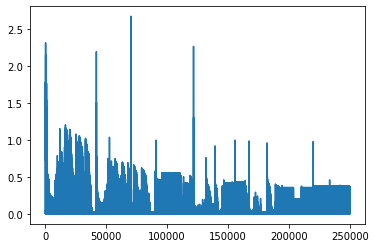

In [16]:
plt.plot(losss)

In [ ]:
losss =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)

## notes: 
save best so far model

In [53]:
pinn.loss(t)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0011600598>

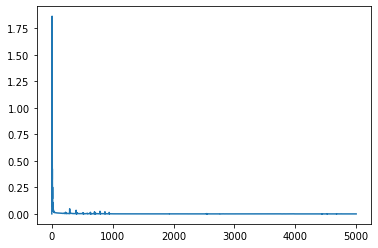

In [54]:
plt.plot(losss)

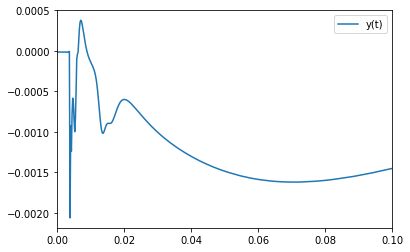

In [17]:
# t= tf.linspace(0., 1., n_samples)[:, tf.newaxis]


# plt.plot(t, z_hat(t) ,label = 'x(t)')
plt.plot(t,  z_hat(t)[:,1:2], label = 'y(t)')
plt.xlim(0,0.1)
# plt.ylim(0.,1.)
plt.legend()

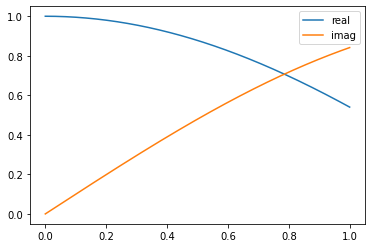

In [27]:
#  z = [x,y]
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

In [46]:
np.min(z_hat(t)[:,0:1])

-0.078544706

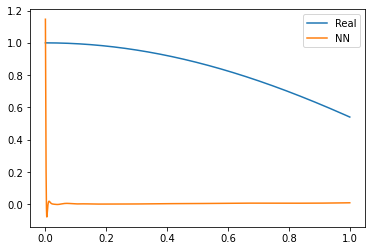

In [47]:
plt.plot(t, x_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN')
# plt.ylim(np.min(z_hat(t)[:,0:1]),)
plt.legend()

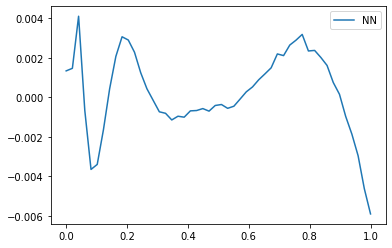

In [109]:
# plt.plot(t, y_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,1:], label = 'NN')
plt.legend()

In [22]:
x_hat = X_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')
y_hat = Y_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')

In [25]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(t) 
    x = x_hat(t)
    y = y_hat(t)
x_prime = tape.gradient(x,t)    
y_prime = tape.gradient(y,t)  
del tape
print(f'x prime {x_prime} \n y_prime {y_prime}')

x prime [[-0.04691141]
 [-0.04580088]
 [-0.04488641]
 [-0.04389558]
 [-0.043158  ]
 [-0.04230914]
 [-0.04150027]
 [-0.04096917]
 [-0.04029977]
 [-0.03980972]
 [-0.03932826]
 [-0.03878361]
 [-0.03844483]
 [-0.0380714 ]
 [-0.03777011]
 [-0.03750508]
 [-0.03729995]
 [-0.03701679]
 [-0.03681608]
 [-0.03672321]
 [-0.03664884]
 [-0.03652166]
 [-0.03646646]
 [-0.03636636]
 [-0.03637227]
 [-0.03632809]
 [-0.03634595]
 [-0.03639278]
 [-0.03642997]
 [-0.036442  ]
 [-0.03648344]
 [-0.03647701]
 [-0.03653761]
 [-0.03662881]
 [-0.03669764]
 [-0.03675947]
 [-0.03684453]
 [-0.03696074]
 [-0.03699692]
 [-0.03705414]
 [-0.03713073]
 [-0.03717476]
 [-0.03723507]
 [-0.03731408]
 [-0.03736116]
 [-0.03742646]
 [-0.03746198]
 [-0.03747474]
 [-0.03752461]
 [-0.03753534]
 [-0.03754866]
 [-0.03752921]
 [-0.03754056]
 [-0.03753002]
 [-0.03750424]
 [-0.03748228]
 [-0.0374103 ]
 [-0.03739306]
 [-0.03733627]
 [-0.03725561]
 [-0.03719684]
 [-0.03709857]
 [-0.03701421]
 [-0.03691789]
 [-0.03682933]
 [-0.03666963]
 [

In [29]:
class PINN:
    def __init__(self, t,model_x, model_y, x_init, y_init,optim):
        self.model_x = model_x
        self.model_y = model_y
        
        self.t = t
        self.x_init = x_init
        self.y_init = y_init
        
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivatives
                
        

        '''
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t) 
            x = self.model_x(t)
            y = self.model_y(t)
        x_prime = tape.gradient(x,t)    
        y_prime = tape.gradient(y,t)   
        del tape
        
        return x,y,x_prime,y_prime   
        
    def ode_ic(self,t):
        x_hat,y_hat,x_prime,y_prime = self.get_derivatives(self.t)
       
        u1 =  x_prime + x_hat - 6.0*y_hat
        u2 =  y_prime - x_hat + 2.0*y_hat
#         Initial conditions
        x0,y0,x_prime0,y_prime0 = self.get_derivatives(tf.zeros_like(self.t))
#        
        u3 =  x0-self.x_init
        u4 =  y0 - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        return mse_x+mse_y+mse_x0+mse_y0
    
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
#         which parameters???
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
#                     if i%(steps_per_epoch/10)==0:
#                         print(end=".")
                        
                if epoch%1000==0:   
                    print(f'loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses   

In [34]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 10
x_int = tf.constant(2.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)


pinn = PINN(t,x_hat, y_hat, x_int, y_int,optim)

In [35]:
loss_list = pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)

NameError: in user code:

    File "/tmp/ipykernel_42571/1049554588.py", line 64, in train_and_update  *
        tape.watch(model.trainable_variables)

    NameError: name 'model' is not defined
